In [2]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F
import torchvision.models as models
import matplotlib.pyplot as plt

In [3]:
!pip install transformers

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
#!pip install numpy==1.22.4

In [6]:
from transformers import ViTModel

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [7]:
checkpoint_path = '/kaggle/input/pretrainmae-config/pytorch_model.bin'

In [8]:
cp_state_dict = torch.load(checkpoint_path, map_location=torch.device('cuda'))


In [9]:
vit_model = ViTModel.from_pretrained('facebook/vit-mae-base', state_dict = cp_state_dict)

You are using a model of type vit_mae to instantiate a model of type vit. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at facebook/vit-mae-base were not used when initializing ViTModel: ['decoder.decoder_layers.1.attention.attention.query.bias', 'decoder.decoder_layers.5.attention.attention.query.bias', 'decoder.decoder_layers.4.output.dense.bias', 'decoder.decoder_layers.6.layernorm_after.bias', 'decoder.decoder_layers.1.layernorm_before.bias', 'decoder.decoder_layers.5.intermediate.dense.bias', 'decoder.decoder_layers.0.layernorm_before.bias', 'decoder.decoder_layers.7.attention.output.dense.weight', 'decoder.decoder_norm.bias', 'decoder.decoder_layers.4.attention.output.dense.bias', 'decoder.decoder_layers.0.intermediate.dense.weight', 'decoder.decoder_layers.0.layernorm_after.weight', 'decoder.decoder_layers.6.output.dense.weight', 'decoder.decoder_layers.5.intermediate.dense.weight', 'decoder.decoder_layers.0.att

In [10]:
vit_model

ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation(

In [11]:
class AgeGenderClassifier(nn.Module):
  def __init__(self):
    super(AgeGenderClassifier, self).__init__()
    self.vit = vit_model
    self.gender_bn = nn.BatchNorm1d(768)
    self.gender_classifier =nn.Linear(768,2)
    self.age_bn = nn.BatchNorm1d(768)
    self.age_regressor = nn.Linear(768,1)

  def forward(self, input_ids):
    outputs = self.vit(input_ids)
    pooler_output = outputs.pooler_output
    
    gender_output = self.gender_classifier(self.gender_bn(pooler_output))
    age_output = self.age_regressor(self.age_bn(pooler_output))
    return gender_output, age_output

In [12]:
age_gender_model = AgeGenderClassifier()

In [13]:
!pip install -q datasets transformers

In [14]:
from datasets import load_dataset
# loading UTKFace from HuggingFace https://huggingface.co/datasets/nlphuji/utk_faces
dataset = load_dataset('nlphuji/utk_faces')

  0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
dataset

DatasetDict({
    test: Dataset({
        features: ['image', 'age', 'gender', 'race', 'image_name'],
        num_rows: 23703
    })
})

In [16]:
dataset.shape

{'test': (23703, 5)}

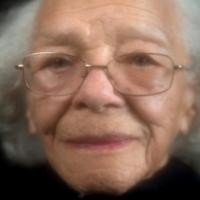

In [17]:
dataset['test']['image'][5]

In [18]:
label_age = dataset['test']['age']
label_gender = dataset['test']['gender']
label_gender_encode = []
for gender in label_gender:
  if gender == 'male':
    label_gender_encode.append(0)
  else:
    label_gender_encode.append(1)

In [19]:
from transformers import AutoImageProcessor
image_processor = AutoImageProcessor.from_pretrained("facebook/vit-mae-base")
image_processor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [20]:
from torchvision.transforms import(
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    RandomRotation,
    ColorJitter,
    ToTensor
)

In [21]:
normalize = Normalize(mean = image_processor.image_mean, std = image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            RandomRotation(20),
            ColorJitter(brightness = 0.2, contrast = 0.2, saturation = 0.2, hue = 0.2),
            ToTensor(),
            normalize,
        ]
    )

test_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_test(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [test_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [22]:
# training + validation splitting
splits = dataset['test'].train_test_split(test_size = .1)
train_ds = splits['train']
test_ds = splits['test']

In [23]:
# transform train dataset and test dataset
train_ds.set_transform(preprocess_train)
test_ds.set_transform(preprocess_test)

In [24]:
train_ds[10]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=200x200>,
 'age': 30,
 'gender': 'male',
 'race': 'white',
 'image_name': '30_0_0_20170116221857954.jpg',
 'pixel_values': tensor([[[-1.8610, -1.8610, -1.8610,  ..., -1.8610, -1.8610, -1.8610],
          [-1.8610, -1.8610, -1.8610,  ..., -1.8610, -1.8610, -1.8610],
          [-1.8610, -1.8610, -1.8610,  ..., -1.8610, -1.8610, -1.8610],
          ...,
          [-1.8610, -1.8610, -1.8610,  ..., -1.8610, -1.8610, -1.8610],
          [-1.8610, -1.8610, -1.8610,  ..., -1.8610, -1.8610, -1.8610],
          [-1.8610, -1.8610, -1.8610,  ..., -1.8610, -1.8610, -1.8610]],
 
         [[-1.7731, -1.7731, -1.7731,  ..., -1.7731, -1.7731, -1.7731],
          [-1.7731, -1.7731, -1.7731,  ..., -1.7731, -1.7731, -1.7731],
          [-1.7731, -1.7731, -1.7731,  ..., -1.7731, -1.7731, -1.7731],
          ...,
          [-1.7731, -1.7731, -1.7731,  ..., -1.7731, -1.7731, -1.7731],
          [-1.7731, -1.7731, -1.7731,  ..., -1.7731, -1.7731

In [25]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        pixel_values = item['pixel_values']
        gender = 1.0 if item['gender'] == 'female' else 0.0  # encode 'female' as 1.0 and 'male' as 0.0
        age = float(item['age'])
        return pixel_values, torch.tensor(gender), torch.tensor(age)

In [26]:
train_dataset = CustomDataset(train_ds)
test_dataset = CustomDataset(test_ds)

In [27]:
train_loader = DataLoader(train_dataset, batch_size=64 , shuffle=True, num_workers = 2)
test_loader = DataLoader(test_dataset,  batch_size=64, shuffle=True, num_workers = 2)

In [28]:
dataloaders = {'train': train_loader, 'test': test_loader}

In [29]:
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [31]:
from torch import optim
from torch.optim import lr_scheduler
import copy
model = age_gender_model

# Specify the loss functions for each head
criterion1 = nn.CrossEntropyLoss()  # Binary Cross-Entropy Loss for the gender classification
criterion2 = nn.SmoothL1Loss(reduction='mean')

# Applying weight for eahc loss
weight_gender = 0.95
weight_age = 1- weight_gender

# Specify the optimizer
optimizer = optim.Adam(model.parameters(), lr= 10e-5, weight_decay = 1e-4)

# Specify the learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.1)

# Specify the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = nn.DataParallel(model)
model.to(device)

# Initialize empty lists to store loss and accuracy values
train_loss_values = []
train_acc_values = []
test_loss_values = []
test_acc_values = []

# Initialize additional lists to store MAE values
train_age_error_values = []
test_age_error_values = []

# Initialize the best model weights variable
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

#Dataset_sizes
dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'test']}
# Number of epochs
num_epochs = 30

for epoch in range(num_epochs):
    #print('Epoch {}/{}'.format(epoch, num_epochs -1))
    print('-'*10)
    
    for phase in ['train', 'test']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        correct_gender_preds = 0
        total_gender_preds = 0
        total_age_error = 0

        for inputs, gender_labels, age_labels in tqdm(dataloaders[phase], desc=f'Epoch {epoch+1}/{num_epochs} {phase.capitalize()}'):
            inputs = inputs.to(device)
            gender_labels = gender_labels.to(device).long()
            age_labels = age_labels.to(device)

            optimizer.zero_grad()
            

            # forward
            with torch.set_grad_enabled(phase == 'train'):
                gender_preds, age_preds = model(inputs)
                # Calculate the losses for each head
                loss1 = criterion1(gender_preds, gender_labels)
                loss2 = criterion2(age_preds.view(-1), age_labels.float()) 
                # Total loss is the sum of the two losses
                loss = weight_gender*loss1 + weight_age*loss2
                print(loss)
                

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
        

            # Calculate the number of correct gender predictions
            _, predicted_genders = torch.max(gender_preds, 1)
            correct_gender_preds += (predicted_genders == gender_labels).sum().item()
            total_gender_preds += gender_labels.size(0)

            # Calculate the total age prediction error
            total_age_error += torch.sum(torch.abs(age_preds.view(-1) - age_labels.float())).item()
            
        if phase == 'train':
            scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = correct_gender_preds / total_gender_preds
        epoch_age_error = total_age_error / dataset_sizes[phase]
        print('{} Loss: {:.4f} Acc: {:.4f} Age MAE: {:.4f}'.format(phase, epoch_loss, epoch_acc, epoch_age_error))
        
        # deep copy the model
        if phase == 'test' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            
        # Store loss and accuracy and MAE values for each epoch
        if phase == 'train':
            train_loss_values.append(epoch_loss)
            train_acc_values.append(epoch_acc)
            train_age_error_values.append(epoch_age_error)
        else:
            test_loss_values.append(epoch_loss)
            test_acc_values.append(epoch_acc)
            test_age_error_values.append(epoch_age_error)
            
    # Save model after each epoch for future training if needed
    torch.save(model.state_dict(),f'/kaggle/working/model_epoch_{epoch+1}.pt')
    print('State dict saved')

print('Best test Acc: {:4f}'.format(best_acc))

#L Load best model weights
model.load_state_dict(best_model_wts)

----------


Epoch 1/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(1.9712, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   0%|          | 1/334 [00:02<13:18,  2.40s/it]

tensor(1.8490, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   1%|          | 2/334 [00:03<09:15,  1.67s/it]

tensor(2.0624, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   1%|          | 3/334 [00:04<07:52,  1.43s/it]

tensor(1.8496, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   1%|          | 4/334 [00:05<07:09,  1.30s/it]

tensor(1.8453, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   1%|▏         | 5/334 [00:06<06:48,  1.24s/it]

tensor(1.8225, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   2%|▏         | 6/334 [00:08<06:33,  1.20s/it]

tensor(1.6817, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   2%|▏         | 7/334 [00:09<06:22,  1.17s/it]

tensor(1.9106, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   2%|▏         | 8/334 [00:10<06:15,  1.15s/it]

tensor(1.8414, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   3%|▎         | 9/334 [00:11<06:12,  1.15s/it]

tensor(1.7990, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   3%|▎         | 10/334 [00:12<06:10,  1.14s/it]

tensor(1.8650, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   3%|▎         | 11/334 [00:13<06:07,  1.14s/it]

tensor(2.1179, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   4%|▎         | 12/334 [00:14<06:06,  1.14s/it]

tensor(1.6222, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   4%|▍         | 13/334 [00:15<06:05,  1.14s/it]

tensor(1.9853, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   4%|▍         | 14/334 [00:17<06:04,  1.14s/it]

tensor(1.7381, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   4%|▍         | 15/334 [00:18<06:01,  1.13s/it]

tensor(1.7369, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   5%|▍         | 16/334 [00:19<06:01,  1.14s/it]

tensor(1.9516, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   5%|▌         | 17/334 [00:20<06:00,  1.14s/it]

tensor(1.7734, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   5%|▌         | 18/334 [00:21<06:01,  1.14s/it]

tensor(1.7943, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   6%|▌         | 19/334 [00:22<06:08,  1.17s/it]

tensor(1.6465, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   6%|▌         | 20/334 [00:24<06:03,  1.16s/it]

tensor(1.7453, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   6%|▋         | 21/334 [00:25<06:00,  1.15s/it]

tensor(1.7858, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   7%|▋         | 22/334 [00:26<05:58,  1.15s/it]

tensor(1.8245, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   7%|▋         | 23/334 [00:27<05:56,  1.15s/it]

tensor(1.9192, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   7%|▋         | 24/334 [00:28<05:59,  1.16s/it]

tensor(1.6010, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   7%|▋         | 25/334 [00:29<05:57,  1.16s/it]

tensor(1.8719, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   8%|▊         | 26/334 [00:30<05:56,  1.16s/it]

tensor(1.7724, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   8%|▊         | 27/334 [00:32<05:56,  1.16s/it]

tensor(1.8422, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   8%|▊         | 28/334 [00:33<05:55,  1.16s/it]

tensor(1.7506, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   9%|▊         | 29/334 [00:34<05:54,  1.16s/it]

tensor(1.9963, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   9%|▉         | 30/334 [00:35<05:51,  1.16s/it]

tensor(1.8721, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   9%|▉         | 31/334 [00:36<05:50,  1.16s/it]

tensor(1.7919, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  10%|▉         | 32/334 [00:37<05:48,  1.16s/it]

tensor(1.7150, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  10%|▉         | 33/334 [00:39<05:48,  1.16s/it]

tensor(1.8739, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  10%|█         | 34/334 [00:40<05:44,  1.15s/it]

tensor(1.9269, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  10%|█         | 35/334 [00:41<05:45,  1.15s/it]

tensor(1.6473, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  11%|█         | 36/334 [00:42<05:43,  1.15s/it]

tensor(1.6802, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  11%|█         | 37/334 [00:43<05:40,  1.15s/it]

tensor(1.6085, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  11%|█▏        | 38/334 [00:44<05:37,  1.14s/it]

tensor(1.8564, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  12%|█▏        | 39/334 [00:45<05:35,  1.14s/it]

tensor(1.8160, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  12%|█▏        | 40/334 [00:47<05:35,  1.14s/it]

tensor(1.7324, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  12%|█▏        | 41/334 [00:48<05:35,  1.14s/it]

tensor(1.7554, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  13%|█▎        | 42/334 [00:49<05:32,  1.14s/it]

tensor(1.8565, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  13%|█▎        | 43/334 [00:50<05:37,  1.16s/it]

tensor(1.9427, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  13%|█▎        | 44/334 [00:51<05:33,  1.15s/it]

tensor(1.8786, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  13%|█▎        | 45/334 [00:52<05:34,  1.16s/it]

tensor(1.8398, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  14%|█▍        | 46/334 [00:54<05:37,  1.17s/it]

tensor(1.9885, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  14%|█▍        | 47/334 [00:55<05:38,  1.18s/it]

tensor(1.8442, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  14%|█▍        | 48/334 [00:56<05:34,  1.17s/it]

tensor(1.5016, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  15%|█▍        | 49/334 [00:57<05:28,  1.15s/it]

tensor(1.6745, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  15%|█▍        | 50/334 [00:58<05:26,  1.15s/it]

tensor(1.8921, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  15%|█▌        | 51/334 [00:59<05:24,  1.15s/it]

tensor(2.1206, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  16%|█▌        | 52/334 [01:00<05:21,  1.14s/it]

tensor(1.6151, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  16%|█▌        | 53/334 [01:02<05:18,  1.13s/it]

tensor(1.7926, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  16%|█▌        | 54/334 [01:03<05:17,  1.14s/it]

tensor(2.0829, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  16%|█▋        | 55/334 [01:04<05:16,  1.13s/it]

tensor(1.7397, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  17%|█▋        | 56/334 [01:05<05:14,  1.13s/it]

tensor(2.0056, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  17%|█▋        | 57/334 [01:06<05:12,  1.13s/it]

tensor(1.8653, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  17%|█▋        | 58/334 [01:07<05:11,  1.13s/it]

tensor(1.9829, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  18%|█▊        | 59/334 [01:08<05:10,  1.13s/it]

tensor(1.7742, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  18%|█▊        | 60/334 [01:09<05:10,  1.13s/it]

tensor(1.9373, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  18%|█▊        | 61/334 [01:11<05:09,  1.13s/it]

tensor(1.7104, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  19%|█▊        | 62/334 [01:12<05:07,  1.13s/it]

tensor(1.8285, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  19%|█▉        | 63/334 [01:13<05:06,  1.13s/it]

tensor(1.9037, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  19%|█▉        | 64/334 [01:14<05:05,  1.13s/it]

tensor(1.7296, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  19%|█▉        | 65/334 [01:15<05:03,  1.13s/it]

tensor(1.8064, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  20%|█▉        | 66/334 [01:16<05:01,  1.13s/it]

tensor(1.9524, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  20%|██        | 67/334 [01:17<05:01,  1.13s/it]

tensor(1.6887, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  20%|██        | 68/334 [01:18<04:59,  1.12s/it]

tensor(1.9670, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  21%|██        | 69/334 [01:20<04:57,  1.12s/it]

tensor(2.0291, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  21%|██        | 70/334 [01:21<04:55,  1.12s/it]

tensor(1.8948, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  21%|██▏       | 71/334 [01:22<04:55,  1.12s/it]

tensor(2.0296, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  22%|██▏       | 72/334 [01:23<04:58,  1.14s/it]

tensor(1.7685, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  22%|██▏       | 73/334 [01:24<04:56,  1.14s/it]

tensor(1.8406, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  22%|██▏       | 74/334 [01:25<05:01,  1.16s/it]

tensor(1.6844, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  22%|██▏       | 75/334 [01:27<05:01,  1.16s/it]

tensor(1.8502, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  23%|██▎       | 76/334 [01:28<04:57,  1.15s/it]

tensor(1.6506, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  23%|██▎       | 77/334 [01:29<04:53,  1.14s/it]

tensor(1.8478, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  23%|██▎       | 78/334 [01:30<04:51,  1.14s/it]

tensor(1.6998, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  24%|██▎       | 79/334 [01:31<04:50,  1.14s/it]

tensor(1.9788, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  24%|██▍       | 80/334 [01:32<04:49,  1.14s/it]

tensor(1.8697, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  24%|██▍       | 81/334 [01:33<04:47,  1.14s/it]

tensor(1.8928, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  25%|██▍       | 82/334 [01:34<04:45,  1.13s/it]

tensor(1.8588, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  25%|██▍       | 83/334 [01:36<04:43,  1.13s/it]

tensor(1.7037, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  25%|██▌       | 84/334 [01:37<04:41,  1.13s/it]

tensor(1.8003, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  25%|██▌       | 85/334 [01:38<04:40,  1.13s/it]

tensor(1.9027, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  26%|██▌       | 86/334 [01:39<04:40,  1.13s/it]

tensor(1.9895, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  26%|██▌       | 87/334 [01:40<04:39,  1.13s/it]

tensor(1.8191, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  26%|██▋       | 88/334 [01:41<04:39,  1.14s/it]

tensor(1.7954, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  27%|██▋       | 89/334 [01:42<04:37,  1.13s/it]

tensor(1.6996, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  27%|██▋       | 90/334 [01:43<04:37,  1.14s/it]

tensor(2.0204, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  27%|██▋       | 91/334 [01:45<04:35,  1.13s/it]

tensor(2.0179, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  28%|██▊       | 92/334 [01:46<04:33,  1.13s/it]

tensor(1.7603, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  28%|██▊       | 93/334 [01:47<04:33,  1.14s/it]

tensor(1.9731, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  28%|██▊       | 94/334 [01:48<04:33,  1.14s/it]

tensor(2.0919, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  28%|██▊       | 95/334 [01:49<04:31,  1.14s/it]

tensor(1.7598, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  29%|██▊       | 96/334 [01:50<04:31,  1.14s/it]

tensor(1.6847, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  29%|██▉       | 97/334 [01:51<04:29,  1.14s/it]

tensor(1.8331, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  29%|██▉       | 98/334 [01:53<04:29,  1.14s/it]

tensor(1.9310, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  30%|██▉       | 99/334 [01:54<04:27,  1.14s/it]

tensor(1.9379, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  30%|██▉       | 100/334 [01:55<04:28,  1.15s/it]

tensor(1.9000, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  30%|███       | 101/334 [01:56<04:30,  1.16s/it]

tensor(1.7602, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  31%|███       | 102/334 [01:57<04:33,  1.18s/it]

tensor(1.5018, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  31%|███       | 103/334 [01:58<04:30,  1.17s/it]

tensor(2.1134, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  31%|███       | 104/334 [02:00<04:26,  1.16s/it]

tensor(1.7833, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  31%|███▏      | 105/334 [02:01<04:24,  1.16s/it]

tensor(1.6842, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  32%|███▏      | 106/334 [02:02<04:22,  1.15s/it]

tensor(1.8427, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  32%|███▏      | 107/334 [02:03<04:20,  1.15s/it]

tensor(1.7899, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  32%|███▏      | 108/334 [02:04<04:19,  1.15s/it]

tensor(2.0300, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  33%|███▎      | 109/334 [02:05<04:17,  1.14s/it]

tensor(1.8964, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  33%|███▎      | 110/334 [02:06<04:16,  1.14s/it]

tensor(1.5307, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  33%|███▎      | 111/334 [02:08<04:13,  1.14s/it]

tensor(1.7304, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  34%|███▎      | 112/334 [02:09<04:13,  1.14s/it]

tensor(1.6983, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  34%|███▍      | 113/334 [02:10<04:11,  1.14s/it]

tensor(1.6060, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  34%|███▍      | 114/334 [02:11<04:09,  1.13s/it]

tensor(1.9140, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  34%|███▍      | 115/334 [02:12<04:09,  1.14s/it]

tensor(1.6851, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  35%|███▍      | 116/334 [02:13<04:08,  1.14s/it]

tensor(1.7319, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  35%|███▌      | 117/334 [02:14<04:06,  1.14s/it]

tensor(1.5828, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  35%|███▌      | 118/334 [02:16<04:06,  1.14s/it]

tensor(1.5387, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  36%|███▌      | 119/334 [02:17<04:05,  1.14s/it]

tensor(1.7766, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  36%|███▌      | 120/334 [02:18<04:04,  1.14s/it]

tensor(1.7831, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  36%|███▌      | 121/334 [02:19<04:01,  1.14s/it]

tensor(1.9864, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  37%|███▋      | 122/334 [02:20<04:01,  1.14s/it]

tensor(1.5701, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  37%|███▋      | 123/334 [02:21<03:59,  1.14s/it]

tensor(1.8634, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  37%|███▋      | 124/334 [02:22<03:57,  1.13s/it]

tensor(1.6581, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  37%|███▋      | 125/334 [02:23<03:56,  1.13s/it]

tensor(2.0759, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  38%|███▊      | 126/334 [02:25<03:55,  1.13s/it]

tensor(1.9552, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  38%|███▊      | 127/334 [02:26<03:54,  1.13s/it]

tensor(2.0175, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  38%|███▊      | 128/334 [02:27<03:53,  1.13s/it]

tensor(1.7431, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  39%|███▊      | 129/334 [02:28<03:52,  1.13s/it]

tensor(1.7726, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  39%|███▉      | 130/334 [02:29<03:58,  1.17s/it]

tensor(1.7020, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  39%|███▉      | 131/334 [02:30<03:59,  1.18s/it]

tensor(1.6222, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  40%|███▉      | 132/334 [02:32<03:55,  1.16s/it]

tensor(1.9872, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  40%|███▉      | 133/334 [02:33<03:50,  1.15s/it]

tensor(1.8732, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  40%|████      | 134/334 [02:34<03:47,  1.14s/it]

tensor(1.7675, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  40%|████      | 135/334 [02:35<03:46,  1.14s/it]

tensor(1.6367, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  41%|████      | 136/334 [02:36<03:45,  1.14s/it]

tensor(1.8956, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  41%|████      | 137/334 [02:37<03:44,  1.14s/it]

tensor(2.0741, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  41%|████▏     | 138/334 [02:38<03:43,  1.14s/it]

tensor(1.8112, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  42%|████▏     | 139/334 [02:40<03:41,  1.14s/it]

tensor(1.9328, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  42%|████▏     | 140/334 [02:41<03:41,  1.14s/it]

tensor(1.5918, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  42%|████▏     | 141/334 [02:42<03:39,  1.14s/it]

tensor(1.6474, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  43%|████▎     | 142/334 [02:43<03:38,  1.14s/it]

tensor(1.7483, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  43%|████▎     | 143/334 [02:44<03:37,  1.14s/it]

tensor(1.8660, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  43%|████▎     | 144/334 [02:45<03:35,  1.14s/it]

tensor(1.8517, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  43%|████▎     | 145/334 [02:46<03:33,  1.13s/it]

tensor(1.9219, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  44%|████▎     | 146/334 [02:47<03:32,  1.13s/it]

tensor(1.9674, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  44%|████▍     | 147/334 [02:49<03:31,  1.13s/it]

tensor(1.8982, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  44%|████▍     | 148/334 [02:50<03:30,  1.13s/it]

tensor(1.6138, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  45%|████▍     | 149/334 [02:51<03:29,  1.13s/it]

tensor(1.5685, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  45%|████▍     | 150/334 [02:52<03:27,  1.13s/it]

tensor(1.7409, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  45%|████▌     | 151/334 [02:53<03:26,  1.13s/it]

tensor(1.8939, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  46%|████▌     | 152/334 [02:54<03:26,  1.13s/it]

tensor(1.7344, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  46%|████▌     | 153/334 [02:55<03:25,  1.14s/it]

tensor(1.9296, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  46%|████▌     | 154/334 [02:56<03:23,  1.13s/it]

tensor(1.9014, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  46%|████▋     | 155/334 [02:58<03:21,  1.13s/it]

tensor(1.4929, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  47%|████▋     | 156/334 [02:59<03:21,  1.13s/it]

tensor(1.7319, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  47%|████▋     | 157/334 [03:00<03:20,  1.13s/it]

tensor(1.7188, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  47%|████▋     | 158/334 [03:01<03:23,  1.16s/it]

tensor(1.7536, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  48%|████▊     | 159/334 [03:02<03:25,  1.17s/it]

tensor(1.6869, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  48%|████▊     | 160/334 [03:03<03:20,  1.16s/it]

tensor(1.7347, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  48%|████▊     | 161/334 [03:05<03:17,  1.14s/it]

tensor(1.7130, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  49%|████▊     | 162/334 [03:06<03:16,  1.14s/it]

tensor(1.6768, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  49%|████▉     | 163/334 [03:07<03:14,  1.14s/it]

tensor(1.8798, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  49%|████▉     | 164/334 [03:08<03:13,  1.14s/it]

tensor(1.6591, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  49%|████▉     | 165/334 [03:09<03:12,  1.14s/it]

tensor(1.7512, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  50%|████▉     | 166/334 [03:10<03:11,  1.14s/it]

tensor(1.5573, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  50%|█████     | 167/334 [03:11<03:10,  1.14s/it]

tensor(1.7689, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  50%|█████     | 168/334 [03:13<03:08,  1.14s/it]

tensor(1.7186, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  51%|█████     | 169/334 [03:14<03:07,  1.14s/it]

tensor(1.9998, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  51%|█████     | 170/334 [03:15<03:06,  1.14s/it]

tensor(1.6584, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  51%|█████     | 171/334 [03:16<03:05,  1.14s/it]

tensor(2.0359, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  51%|█████▏    | 172/334 [03:17<03:04,  1.14s/it]

tensor(1.6785, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  52%|█████▏    | 173/334 [03:18<03:02,  1.13s/it]

tensor(1.5079, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  52%|█████▏    | 174/334 [03:19<03:01,  1.13s/it]

tensor(1.8137, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  52%|█████▏    | 175/334 [03:20<02:59,  1.13s/it]

tensor(1.8389, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  53%|█████▎    | 176/334 [03:22<02:59,  1.13s/it]

tensor(1.7442, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  53%|█████▎    | 177/334 [03:23<02:58,  1.14s/it]

tensor(1.7518, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  53%|█████▎    | 178/334 [03:24<02:57,  1.14s/it]

tensor(1.6941, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  54%|█████▎    | 179/334 [03:25<02:56,  1.14s/it]

tensor(1.7542, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  54%|█████▍    | 180/334 [03:26<02:54,  1.14s/it]

tensor(1.7598, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  54%|█████▍    | 181/334 [03:27<02:52,  1.13s/it]

tensor(1.5813, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  54%|█████▍    | 182/334 [03:28<02:51,  1.13s/it]

tensor(1.6756, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  55%|█████▍    | 183/334 [03:30<02:50,  1.13s/it]

tensor(1.7944, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  55%|█████▌    | 184/334 [03:31<02:49,  1.13s/it]

tensor(1.6985, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  55%|█████▌    | 185/334 [03:32<02:49,  1.13s/it]

tensor(1.8654, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  56%|█████▌    | 186/334 [03:33<02:52,  1.16s/it]

tensor(1.8291, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  56%|█████▌    | 187/334 [03:34<02:50,  1.16s/it]

tensor(1.8055, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  56%|█████▋    | 188/334 [03:35<02:48,  1.15s/it]

tensor(1.8223, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  57%|█████▋    | 189/334 [03:36<02:45,  1.14s/it]

tensor(1.7321, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  57%|█████▋    | 190/334 [03:38<02:43,  1.14s/it]

tensor(1.5674, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  57%|█████▋    | 191/334 [03:39<02:41,  1.13s/it]

tensor(1.9524, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  57%|█████▋    | 192/334 [03:40<02:41,  1.14s/it]

tensor(1.6762, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  58%|█████▊    | 193/334 [03:41<02:40,  1.14s/it]

tensor(1.8884, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  58%|█████▊    | 194/334 [03:42<02:39,  1.14s/it]

tensor(1.6369, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  58%|█████▊    | 195/334 [03:43<02:38,  1.14s/it]

tensor(1.5087, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  59%|█████▊    | 196/334 [03:44<02:37,  1.14s/it]

tensor(1.5015, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  59%|█████▉    | 197/334 [03:46<02:36,  1.14s/it]

tensor(1.9174, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  59%|█████▉    | 198/334 [03:47<02:35,  1.14s/it]

tensor(1.9176, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  60%|█████▉    | 199/334 [03:48<02:33,  1.13s/it]

tensor(1.5360, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  60%|█████▉    | 200/334 [03:49<02:31,  1.13s/it]

tensor(1.8474, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  60%|██████    | 201/334 [03:50<02:30,  1.13s/it]

tensor(1.7817, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  60%|██████    | 202/334 [03:51<02:28,  1.13s/it]

tensor(1.8111, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  61%|██████    | 203/334 [03:52<02:27,  1.13s/it]

tensor(1.7957, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  61%|██████    | 204/334 [03:53<02:27,  1.13s/it]

tensor(1.6095, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  61%|██████▏   | 205/334 [03:55<02:26,  1.13s/it]

tensor(1.9914, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  62%|██████▏   | 206/334 [03:56<02:25,  1.14s/it]

tensor(1.6690, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  62%|██████▏   | 207/334 [03:57<02:24,  1.14s/it]

tensor(1.6093, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  62%|██████▏   | 208/334 [03:58<02:23,  1.14s/it]

tensor(1.8198, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  63%|██████▎   | 209/334 [03:59<02:22,  1.14s/it]

tensor(1.8109, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  63%|██████▎   | 210/334 [04:00<02:21,  1.14s/it]

tensor(1.6988, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  63%|██████▎   | 211/334 [04:01<02:19,  1.14s/it]

tensor(1.5286, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  63%|██████▎   | 212/334 [04:03<02:19,  1.14s/it]

tensor(1.8006, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  64%|██████▍   | 213/334 [04:04<02:18,  1.14s/it]

tensor(1.5094, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  64%|██████▍   | 214/334 [04:05<02:19,  1.17s/it]

tensor(1.4950, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  64%|██████▍   | 215/334 [04:06<02:16,  1.15s/it]

tensor(1.4717, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  65%|██████▍   | 216/334 [04:07<02:14,  1.14s/it]

tensor(1.9165, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  65%|██████▍   | 217/334 [04:08<02:13,  1.14s/it]

tensor(1.7591, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  65%|██████▌   | 218/334 [04:09<02:12,  1.14s/it]

tensor(1.6824, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  66%|██████▌   | 219/334 [04:11<02:11,  1.14s/it]

tensor(1.8284, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  66%|██████▌   | 220/334 [04:12<02:09,  1.13s/it]

tensor(1.5515, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  66%|██████▌   | 221/334 [04:13<02:08,  1.13s/it]

tensor(1.8766, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  66%|██████▋   | 222/334 [04:14<02:06,  1.13s/it]

tensor(1.7737, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  67%|██████▋   | 223/334 [04:15<02:05,  1.13s/it]

tensor(1.5383, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  67%|██████▋   | 224/334 [04:16<02:04,  1.13s/it]

tensor(1.7501, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  67%|██████▋   | 225/334 [04:17<02:03,  1.13s/it]

tensor(1.6498, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  68%|██████▊   | 226/334 [04:18<02:02,  1.14s/it]

tensor(1.7383, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  68%|██████▊   | 227/334 [04:20<02:01,  1.13s/it]

tensor(1.9231, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  68%|██████▊   | 228/334 [04:21<01:59,  1.13s/it]

tensor(1.6271, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  69%|██████▊   | 229/334 [04:22<01:59,  1.13s/it]

tensor(1.8251, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  69%|██████▉   | 230/334 [04:23<01:58,  1.14s/it]

tensor(1.8644, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  69%|██████▉   | 231/334 [04:24<01:56,  1.13s/it]

tensor(1.7478, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  69%|██████▉   | 232/334 [04:25<01:55,  1.13s/it]

tensor(1.7690, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  70%|██████▉   | 233/334 [04:26<01:53,  1.13s/it]

tensor(1.7644, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  70%|███████   | 234/334 [04:28<01:52,  1.13s/it]

tensor(1.6724, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  70%|███████   | 235/334 [04:29<01:52,  1.13s/it]

tensor(1.7539, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  71%|███████   | 236/334 [04:30<01:50,  1.13s/it]

tensor(1.7691, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  71%|███████   | 237/334 [04:31<01:49,  1.13s/it]

tensor(1.7615, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  71%|███████▏  | 238/334 [04:32<01:49,  1.14s/it]

tensor(1.6854, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  72%|███████▏  | 239/334 [04:33<01:47,  1.13s/it]

tensor(1.6748, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  72%|███████▏  | 240/334 [04:34<01:46,  1.13s/it]

tensor(1.8437, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  72%|███████▏  | 241/334 [04:35<01:45,  1.13s/it]

tensor(1.8454, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  72%|███████▏  | 242/334 [04:37<01:46,  1.16s/it]

tensor(1.6545, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  73%|███████▎  | 243/334 [04:38<01:44,  1.15s/it]

tensor(1.7060, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  73%|███████▎  | 244/334 [04:39<01:43,  1.15s/it]

tensor(1.7667, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  73%|███████▎  | 245/334 [04:40<01:41,  1.14s/it]

tensor(1.6660, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  74%|███████▎  | 246/334 [04:41<01:40,  1.14s/it]

tensor(1.6600, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  74%|███████▍  | 247/334 [04:42<01:39,  1.14s/it]

tensor(1.7802, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  74%|███████▍  | 248/334 [04:43<01:37,  1.13s/it]

tensor(1.7454, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  75%|███████▍  | 249/334 [04:45<01:36,  1.13s/it]

tensor(1.5819, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  75%|███████▍  | 250/334 [04:46<01:35,  1.13s/it]

tensor(1.5279, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  75%|███████▌  | 251/334 [04:47<01:34,  1.14s/it]

tensor(1.5778, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  75%|███████▌  | 252/334 [04:48<01:32,  1.13s/it]

tensor(1.8356, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  76%|███████▌  | 253/334 [04:49<01:31,  1.13s/it]

tensor(1.7288, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  76%|███████▌  | 254/334 [04:50<01:30,  1.13s/it]

tensor(1.6483, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  76%|███████▋  | 255/334 [04:51<01:28,  1.13s/it]

tensor(1.4925, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  77%|███████▋  | 256/334 [04:52<01:27,  1.12s/it]

tensor(1.6330, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  77%|███████▋  | 257/334 [04:54<01:26,  1.13s/it]

tensor(1.6728, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  77%|███████▋  | 258/334 [04:55<01:25,  1.13s/it]

tensor(1.8092, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  78%|███████▊  | 259/334 [04:56<01:24,  1.13s/it]

tensor(1.7375, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  78%|███████▊  | 260/334 [04:57<01:23,  1.13s/it]

tensor(1.8615, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  78%|███████▊  | 261/334 [04:58<01:22,  1.13s/it]

tensor(1.6202, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  78%|███████▊  | 262/334 [04:59<01:21,  1.13s/it]

tensor(1.6659, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  79%|███████▊  | 263/334 [05:00<01:20,  1.13s/it]

tensor(1.6610, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  79%|███████▉  | 264/334 [05:02<01:18,  1.13s/it]

tensor(1.5059, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  79%|███████▉  | 265/334 [05:03<01:18,  1.14s/it]

tensor(1.7288, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  80%|███████▉  | 266/334 [05:04<01:17,  1.14s/it]

tensor(1.7358, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  80%|███████▉  | 267/334 [05:05<01:15,  1.13s/it]

tensor(1.6019, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  80%|████████  | 268/334 [05:06<01:14,  1.13s/it]

tensor(1.4962, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  81%|████████  | 269/334 [05:07<01:14,  1.14s/it]

tensor(1.6426, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  81%|████████  | 270/334 [05:08<01:14,  1.16s/it]

tensor(1.7015, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  81%|████████  | 271/334 [05:10<01:13,  1.17s/it]

tensor(1.7493, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  81%|████████▏ | 272/334 [05:11<01:11,  1.16s/it]

tensor(1.8175, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  82%|████████▏ | 273/334 [05:12<01:10,  1.15s/it]

tensor(1.5564, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  82%|████████▏ | 274/334 [05:13<01:08,  1.14s/it]

tensor(1.7878, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  82%|████████▏ | 275/334 [05:14<01:06,  1.13s/it]

tensor(1.5757, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  83%|████████▎ | 276/334 [05:15<01:05,  1.13s/it]

tensor(1.7010, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  83%|████████▎ | 277/334 [05:16<01:04,  1.13s/it]

tensor(1.5947, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  83%|████████▎ | 278/334 [05:18<01:03,  1.13s/it]

tensor(1.5362, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  84%|████████▎ | 279/334 [05:19<01:02,  1.13s/it]

tensor(1.6299, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  84%|████████▍ | 280/334 [05:20<01:01,  1.13s/it]

tensor(1.6798, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  84%|████████▍ | 281/334 [05:21<01:00,  1.14s/it]

tensor(1.4757, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  84%|████████▍ | 282/334 [05:22<00:59,  1.14s/it]

tensor(1.5177, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  85%|████████▍ | 283/334 [05:23<00:57,  1.14s/it]

tensor(1.6913, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  85%|████████▌ | 284/334 [05:24<00:56,  1.14s/it]

tensor(1.6549, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  85%|████████▌ | 285/334 [05:25<00:55,  1.14s/it]

tensor(1.5279, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  86%|████████▌ | 286/334 [05:27<00:54,  1.14s/it]

tensor(1.6516, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  86%|████████▌ | 287/334 [05:28<00:53,  1.14s/it]

tensor(1.7406, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  86%|████████▌ | 288/334 [05:29<00:52,  1.13s/it]

tensor(1.4568, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  87%|████████▋ | 289/334 [05:30<00:50,  1.13s/it]

tensor(1.8028, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  87%|████████▋ | 290/334 [05:31<00:49,  1.13s/it]

tensor(1.5739, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  87%|████████▋ | 291/334 [05:32<00:48,  1.13s/it]

tensor(1.6131, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  87%|████████▋ | 292/334 [05:33<00:47,  1.13s/it]

tensor(1.5652, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  88%|████████▊ | 293/334 [05:34<00:46,  1.12s/it]

tensor(1.7860, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  88%|████████▊ | 294/334 [05:36<00:44,  1.12s/it]

tensor(1.7370, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  88%|████████▊ | 295/334 [05:37<00:43,  1.13s/it]

tensor(1.5174, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  89%|████████▊ | 296/334 [05:38<00:42,  1.13s/it]

tensor(1.7735, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  89%|████████▉ | 297/334 [05:39<00:41,  1.13s/it]

tensor(1.6737, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  89%|████████▉ | 298/334 [05:40<00:41,  1.15s/it]

tensor(1.4209, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  90%|████████▉ | 299/334 [05:41<00:40,  1.14s/it]

tensor(1.7080, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  90%|████████▉ | 300/334 [05:43<00:39,  1.15s/it]

tensor(1.7399, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  90%|█████████ | 301/334 [05:44<00:37,  1.14s/it]

tensor(1.3765, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  90%|█████████ | 302/334 [05:45<00:36,  1.14s/it]

tensor(1.7475, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  91%|█████████ | 303/334 [05:46<00:35,  1.14s/it]

tensor(1.7299, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  91%|█████████ | 304/334 [05:47<00:34,  1.16s/it]

tensor(1.4208, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  91%|█████████▏| 305/334 [05:48<00:33,  1.15s/it]

tensor(1.8013, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  92%|█████████▏| 306/334 [05:49<00:31,  1.14s/it]

tensor(1.6246, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  92%|█████████▏| 307/334 [05:50<00:30,  1.14s/it]

tensor(1.6586, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  92%|█████████▏| 308/334 [05:52<00:29,  1.14s/it]

tensor(1.6537, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  93%|█████████▎| 309/334 [05:53<00:28,  1.14s/it]

tensor(1.3780, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  93%|█████████▎| 310/334 [05:54<00:27,  1.14s/it]

tensor(1.5226, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  93%|█████████▎| 311/334 [05:55<00:25,  1.13s/it]

tensor(1.4722, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  93%|█████████▎| 312/334 [05:56<00:24,  1.13s/it]

tensor(1.6235, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  94%|█████████▎| 313/334 [05:57<00:23,  1.13s/it]

tensor(1.4459, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  94%|█████████▍| 314/334 [05:58<00:22,  1.12s/it]

tensor(1.6459, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  94%|█████████▍| 315/334 [06:00<00:21,  1.12s/it]

tensor(1.3069, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  95%|█████████▍| 316/334 [06:01<00:20,  1.13s/it]

tensor(1.5820, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  95%|█████████▍| 317/334 [06:02<00:19,  1.13s/it]

tensor(1.7612, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  95%|█████████▌| 318/334 [06:03<00:18,  1.13s/it]

tensor(1.5789, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  96%|█████████▌| 319/334 [06:04<00:16,  1.13s/it]

tensor(1.6238, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  96%|█████████▌| 320/334 [06:05<00:15,  1.13s/it]

tensor(1.5917, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  96%|█████████▌| 321/334 [06:06<00:14,  1.13s/it]

tensor(1.6077, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  96%|█████████▋| 322/334 [06:07<00:13,  1.13s/it]

tensor(1.6900, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  97%|█████████▋| 323/334 [06:09<00:12,  1.13s/it]

tensor(1.5364, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  97%|█████████▋| 324/334 [06:10<00:11,  1.13s/it]

tensor(1.4024, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  97%|█████████▋| 325/334 [06:11<00:10,  1.13s/it]

tensor(1.3874, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  98%|█████████▊| 326/334 [06:12<00:09,  1.16s/it]

tensor(1.5967, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  98%|█████████▊| 327/334 [06:13<00:08,  1.16s/it]

tensor(1.4746, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  98%|█████████▊| 328/334 [06:14<00:06,  1.15s/it]

tensor(1.4784, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  99%|█████████▊| 329/334 [06:15<00:05,  1.14s/it]

tensor(1.5151, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  99%|█████████▉| 330/334 [06:17<00:04,  1.15s/it]

tensor(1.4818, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  99%|█████████▉| 331/334 [06:18<00:03,  1.14s/it]

tensor(1.6193, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  99%|█████████▉| 332/334 [06:19<00:02,  1.13s/it]

tensor(1.4927, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train: 100%|█████████▉| 333/334 [06:20<00:01,  1.13s/it]

tensor(1.6804, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train: 100%|██████████| 334/334 [06:21<00:00,  1.14s/it]


train Loss: 1.7442 Acc: 0.8348 Age MAE: 28.6523


Epoch 1/30 Test:   3%|▎         | 1/38 [00:01<00:37,  1.00s/it]

tensor(1.1903, device='cuda:0')


Epoch 1/30 Test:   5%|▌         | 2/38 [00:01<00:24,  1.46it/s]

tensor(1.5386, device='cuda:0')


Epoch 1/30 Test:   8%|▊         | 3/38 [00:01<00:19,  1.80it/s]

tensor(1.5486, device='cuda:0')


Epoch 1/30 Test:  11%|█         | 4/38 [00:02<00:16,  2.02it/s]

tensor(1.2773, device='cuda:0')


Epoch 1/30 Test:  13%|█▎        | 5/38 [00:02<00:15,  2.15it/s]

tensor(1.3179, device='cuda:0')


Epoch 1/30 Test:  16%|█▌        | 6/38 [00:03<00:14,  2.26it/s]

tensor(1.3416, device='cuda:0')


Epoch 1/30 Test:  18%|█▊        | 7/38 [00:03<00:13,  2.35it/s]

tensor(1.2926, device='cuda:0')


Epoch 1/30 Test:  21%|██        | 8/38 [00:03<00:12,  2.37it/s]

tensor(1.4754, device='cuda:0')


Epoch 1/30 Test:  24%|██▎       | 9/38 [00:04<00:11,  2.42it/s]

tensor(1.3848, device='cuda:0')


Epoch 1/30 Test:  26%|██▋       | 10/38 [00:04<00:11,  2.44it/s]

tensor(1.4541, device='cuda:0')


Epoch 1/30 Test:  29%|██▉       | 11/38 [00:05<00:10,  2.47it/s]

tensor(1.3850, device='cuda:0')


Epoch 1/30 Test:  32%|███▏      | 12/38 [00:05<00:10,  2.49it/s]

tensor(1.3398, device='cuda:0')


Epoch 1/30 Test:  34%|███▍      | 13/38 [00:05<00:10,  2.48it/s]

tensor(1.3497, device='cuda:0')


Epoch 1/30 Test:  37%|███▋      | 14/38 [00:06<00:09,  2.50it/s]

tensor(1.3224, device='cuda:0')


Epoch 1/30 Test:  39%|███▉      | 15/38 [00:06<00:09,  2.49it/s]

tensor(1.4821, device='cuda:0')


Epoch 1/30 Test:  42%|████▏     | 16/38 [00:07<00:08,  2.47it/s]

tensor(1.3079, device='cuda:0')


Epoch 1/30 Test:  45%|████▍     | 17/38 [00:07<00:08,  2.49it/s]

tensor(1.1802, device='cuda:0')


Epoch 1/30 Test:  47%|████▋     | 18/38 [00:07<00:08,  2.47it/s]

tensor(1.3896, device='cuda:0')


Epoch 1/30 Test:  50%|█████     | 19/38 [00:08<00:07,  2.50it/s]

tensor(1.2498, device='cuda:0')


Epoch 1/30 Test:  53%|█████▎    | 20/38 [00:08<00:07,  2.49it/s]

tensor(1.4566, device='cuda:0')


Epoch 1/30 Test:  55%|█████▌    | 21/38 [00:09<00:06,  2.50it/s]

tensor(1.3443, device='cuda:0')


Epoch 1/30 Test:  58%|█████▊    | 22/38 [00:09<00:06,  2.47it/s]

tensor(1.3803, device='cuda:0')


Epoch 1/30 Test:  61%|██████    | 23/38 [00:09<00:06,  2.46it/s]

tensor(1.4806, device='cuda:0')


Epoch 1/30 Test:  63%|██████▎   | 24/38 [00:10<00:05,  2.46it/s]

tensor(1.4342, device='cuda:0')


Epoch 1/30 Test:  66%|██████▌   | 25/38 [00:10<00:05,  2.46it/s]

tensor(1.1463, device='cuda:0')


Epoch 1/30 Test:  68%|██████▊   | 26/38 [00:11<00:04,  2.46it/s]

tensor(1.4181, device='cuda:0')


Epoch 1/30 Test:  71%|███████   | 27/38 [00:11<00:04,  2.47it/s]

tensor(1.3367, device='cuda:0')


Epoch 1/30 Test:  74%|███████▎  | 28/38 [00:11<00:04,  2.47it/s]

tensor(1.5270, device='cuda:0')


Epoch 1/30 Test:  76%|███████▋  | 29/38 [00:12<00:03,  2.47it/s]

tensor(1.5727, device='cuda:0')


Epoch 1/30 Test:  79%|███████▉  | 30/38 [00:12<00:03,  2.49it/s]

tensor(1.4615, device='cuda:0')


Epoch 1/30 Test:  82%|████████▏ | 31/38 [00:13<00:02,  2.50it/s]

tensor(1.4314, device='cuda:0')


Epoch 1/30 Test:  84%|████████▍ | 32/38 [00:13<00:02,  2.51it/s]

tensor(1.2968, device='cuda:0')


Epoch 1/30 Test:  87%|████████▋ | 33/38 [00:13<00:01,  2.51it/s]

tensor(1.2669, device='cuda:0')


Epoch 1/30 Test:  89%|████████▉ | 34/38 [00:14<00:01,  2.51it/s]

tensor(1.1656, device='cuda:0')


Epoch 1/30 Test:  92%|█████████▏| 35/38 [00:14<00:01,  2.53it/s]

tensor(1.1625, device='cuda:0')


Epoch 1/30 Test:  95%|█████████▍| 36/38 [00:15<00:00,  2.52it/s]

tensor(1.2874, device='cuda:0')


Epoch 1/30 Test:  97%|█████████▋| 37/38 [00:15<00:00,  2.53it/s]

tensor(1.4035, device='cuda:0')
tensor(1.5942, device='cuda:0')


Epoch 1/30 Test: 100%|██████████| 38/38 [00:15<00:00,  2.41it/s]


test Loss: 1.3625 Acc: 0.9228 Age MAE: 23.9517
State dict saved
----------


Epoch 2/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(1.9073, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   0%|          | 1/334 [00:02<12:57,  2.33s/it]

tensor(1.6195, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   1%|          | 2/334 [00:03<09:08,  1.65s/it]

tensor(1.9950, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   1%|          | 3/334 [00:04<07:51,  1.42s/it]

tensor(1.3582, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   1%|          | 4/334 [00:05<07:13,  1.31s/it]

tensor(1.3914, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   1%|▏         | 5/334 [00:07<07:01,  1.28s/it]

tensor(1.5822, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   2%|▏         | 6/334 [00:08<06:42,  1.23s/it]

tensor(1.6004, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   2%|▏         | 7/334 [00:09<06:32,  1.20s/it]

tensor(1.5722, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   2%|▏         | 8/334 [00:10<06:24,  1.18s/it]

tensor(1.3172, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   3%|▎         | 9/334 [00:11<06:17,  1.16s/it]

tensor(1.5025, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   3%|▎         | 10/334 [00:12<06:12,  1.15s/it]

tensor(1.6222, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   3%|▎         | 11/334 [00:13<06:11,  1.15s/it]

tensor(1.5252, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   4%|▎         | 12/334 [00:14<06:08,  1.14s/it]

tensor(1.4017, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   4%|▍         | 13/334 [00:16<06:07,  1.14s/it]

tensor(1.6331, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   4%|▍         | 14/334 [00:17<06:04,  1.14s/it]

tensor(1.7162, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   4%|▍         | 15/334 [00:18<06:04,  1.14s/it]

tensor(1.5766, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   5%|▍         | 16/334 [00:19<06:01,  1.14s/it]

tensor(1.5442, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   5%|▌         | 17/334 [00:20<06:01,  1.14s/it]

tensor(1.4673, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   5%|▌         | 18/334 [00:21<05:58,  1.14s/it]

tensor(1.7920, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   6%|▌         | 19/334 [00:22<05:57,  1.13s/it]

tensor(1.4566, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   6%|▌         | 20/334 [00:24<05:55,  1.13s/it]

tensor(1.8309, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   6%|▋         | 21/334 [00:25<05:55,  1.14s/it]

tensor(1.4607, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   7%|▋         | 22/334 [00:26<05:54,  1.14s/it]

tensor(1.4072, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   7%|▋         | 23/334 [00:27<05:53,  1.14s/it]

tensor(1.5543, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   7%|▋         | 24/334 [00:28<05:51,  1.13s/it]

tensor(1.6609, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   7%|▋         | 25/334 [00:29<05:50,  1.13s/it]

tensor(1.5871, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   8%|▊         | 26/334 [00:30<05:50,  1.14s/it]

tensor(1.7748, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   8%|▊         | 27/334 [00:32<05:49,  1.14s/it]

tensor(1.2784, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   8%|▊         | 28/334 [00:33<05:47,  1.14s/it]

tensor(1.4146, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   9%|▊         | 29/334 [00:34<05:44,  1.13s/it]

tensor(1.4309, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   9%|▉         | 30/334 [00:35<05:44,  1.13s/it]

tensor(1.7259, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   9%|▉         | 31/334 [00:36<05:42,  1.13s/it]

tensor(1.8745, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  10%|▉         | 32/334 [00:38<06:50,  1.36s/it]

tensor(1.2890, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  10%|▉         | 33/334 [00:39<06:30,  1.30s/it]

tensor(1.7930, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  10%|█         | 34/334 [00:40<06:15,  1.25s/it]

tensor(1.6463, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  10%|█         | 35/334 [00:41<06:04,  1.22s/it]

tensor(1.5271, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  11%|█         | 36/334 [00:42<05:56,  1.20s/it]

tensor(1.4989, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  11%|█         | 37/334 [00:44<05:49,  1.18s/it]

tensor(1.4678, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  11%|█▏        | 38/334 [00:45<05:43,  1.16s/it]

tensor(1.2909, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  12%|█▏        | 39/334 [00:46<05:38,  1.15s/it]

tensor(1.4925, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  12%|█▏        | 40/334 [00:47<05:36,  1.15s/it]

tensor(1.4725, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  12%|█▏        | 41/334 [00:48<05:35,  1.14s/it]

tensor(1.6855, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  13%|█▎        | 42/334 [00:49<05:33,  1.14s/it]

tensor(1.4015, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  13%|█▎        | 43/334 [00:50<05:30,  1.14s/it]

tensor(1.6079, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  13%|█▎        | 44/334 [00:52<05:29,  1.14s/it]

tensor(1.5179, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  13%|█▎        | 45/334 [00:53<05:28,  1.14s/it]

tensor(1.6590, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  14%|█▍        | 46/334 [00:54<05:27,  1.14s/it]

tensor(1.4275, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  14%|█▍        | 47/334 [00:55<05:27,  1.14s/it]

tensor(1.4123, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  14%|█▍        | 48/334 [00:56<05:26,  1.14s/it]

tensor(1.6902, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  15%|█▍        | 49/334 [00:57<05:24,  1.14s/it]

tensor(1.6819, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  15%|█▍        | 50/334 [00:58<05:22,  1.14s/it]

tensor(1.6627, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  15%|█▌        | 51/334 [00:59<05:20,  1.13s/it]

tensor(1.5382, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  16%|█▌        | 52/334 [01:01<05:19,  1.13s/it]

tensor(1.5880, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  16%|█▌        | 53/334 [01:02<05:18,  1.13s/it]

tensor(1.6720, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  16%|█▌        | 54/334 [01:03<05:18,  1.14s/it]

tensor(1.3135, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  16%|█▋        | 55/334 [01:04<05:16,  1.14s/it]

tensor(1.5648, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  17%|█▋        | 56/334 [01:05<05:16,  1.14s/it]

tensor(1.6787, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  17%|█▋        | 57/334 [01:06<05:15,  1.14s/it]

tensor(1.6354, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  17%|█▋        | 58/334 [01:08<05:18,  1.15s/it]

tensor(1.8967, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  18%|█▊        | 59/334 [01:09<05:15,  1.15s/it]

tensor(1.6546, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  18%|█▊        | 60/334 [01:10<05:13,  1.14s/it]

tensor(1.7578, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  18%|█▊        | 61/334 [01:11<05:20,  1.17s/it]

tensor(1.8622, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  19%|█▊        | 62/334 [01:12<05:15,  1.16s/it]

tensor(1.6415, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  19%|█▉        | 63/334 [01:13<05:11,  1.15s/it]

tensor(1.6340, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  19%|█▉        | 64/334 [01:14<05:08,  1.14s/it]

tensor(1.6195, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  19%|█▉        | 65/334 [01:16<05:05,  1.14s/it]

tensor(1.4091, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  20%|█▉        | 66/334 [01:17<05:03,  1.13s/it]

tensor(1.5865, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  20%|██        | 67/334 [01:18<05:01,  1.13s/it]

tensor(1.4485, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  20%|██        | 68/334 [01:19<04:59,  1.13s/it]

tensor(1.4746, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  21%|██        | 69/334 [01:20<05:00,  1.13s/it]

tensor(1.5620, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  21%|██        | 70/334 [01:21<04:57,  1.13s/it]

tensor(1.5584, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  21%|██▏       | 71/334 [01:22<04:57,  1.13s/it]

tensor(1.3467, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  22%|██▏       | 72/334 [01:23<04:55,  1.13s/it]

tensor(1.4432, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  22%|██▏       | 73/334 [01:25<04:53,  1.12s/it]

tensor(1.1730, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  22%|██▏       | 74/334 [01:26<04:52,  1.12s/it]

tensor(1.5429, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  22%|██▏       | 75/334 [01:27<04:52,  1.13s/it]

tensor(1.7874, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  23%|██▎       | 76/334 [01:28<04:52,  1.13s/it]

tensor(1.5694, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  23%|██▎       | 77/334 [01:29<04:52,  1.14s/it]

tensor(1.5308, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  23%|██▎       | 78/334 [01:30<04:50,  1.13s/it]

tensor(1.5633, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  24%|██▎       | 79/334 [01:31<04:49,  1.14s/it]

tensor(1.6154, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  24%|██▍       | 80/334 [01:32<04:48,  1.13s/it]

tensor(1.3253, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  24%|██▍       | 81/334 [01:34<04:48,  1.14s/it]

tensor(1.2883, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  25%|██▍       | 82/334 [01:35<04:45,  1.13s/it]

tensor(1.6648, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  25%|██▍       | 83/334 [01:36<04:45,  1.14s/it]

tensor(1.7692, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  25%|██▌       | 84/334 [01:37<04:45,  1.14s/it]

tensor(1.4296, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  25%|██▌       | 85/334 [01:38<04:44,  1.14s/it]

tensor(1.5215, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  26%|██▌       | 86/334 [01:39<04:42,  1.14s/it]

tensor(1.5896, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  26%|██▌       | 87/334 [01:40<04:42,  1.14s/it]

tensor(1.4139, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  26%|██▋       | 88/334 [01:42<04:46,  1.16s/it]

tensor(1.4187, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  27%|██▋       | 89/334 [01:43<04:50,  1.19s/it]

tensor(1.5720, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  27%|██▋       | 90/334 [01:44<04:46,  1.17s/it]

tensor(1.5413, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  27%|██▋       | 91/334 [01:45<04:42,  1.16s/it]

tensor(1.5299, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  28%|██▊       | 92/334 [01:46<04:37,  1.15s/it]

tensor(1.4395, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  28%|██▊       | 93/334 [01:47<04:35,  1.14s/it]

tensor(1.3367, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  28%|██▊       | 94/334 [01:49<04:33,  1.14s/it]

tensor(1.6222, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  28%|██▊       | 95/334 [01:50<04:31,  1.14s/it]

tensor(1.4765, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  29%|██▊       | 96/334 [01:51<04:31,  1.14s/it]

tensor(1.6526, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  29%|██▉       | 97/334 [01:52<04:29,  1.14s/it]

tensor(1.3857, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  29%|██▉       | 98/334 [01:53<04:28,  1.14s/it]

tensor(1.5321, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  30%|██▉       | 99/334 [01:54<04:31,  1.16s/it]

tensor(1.5191, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  30%|██▉       | 100/334 [01:55<04:29,  1.15s/it]

tensor(1.4595, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  30%|███       | 101/334 [01:57<04:27,  1.15s/it]

tensor(1.4804, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  31%|███       | 102/334 [01:58<04:25,  1.15s/it]

tensor(1.7215, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  31%|███       | 103/334 [01:59<04:24,  1.15s/it]

tensor(1.5789, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  31%|███       | 104/334 [02:00<04:21,  1.14s/it]

tensor(1.5303, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  31%|███▏      | 105/334 [02:01<04:19,  1.13s/it]

tensor(1.3655, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  32%|███▏      | 106/334 [02:02<04:17,  1.13s/it]

tensor(1.6312, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  32%|███▏      | 107/334 [02:03<04:16,  1.13s/it]

tensor(1.3121, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  32%|███▏      | 108/334 [02:05<04:13,  1.12s/it]

tensor(1.5117, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  33%|███▎      | 109/334 [02:06<04:12,  1.12s/it]

tensor(1.6240, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  33%|███▎      | 110/334 [02:07<04:11,  1.12s/it]

tensor(1.7007, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  33%|███▎      | 111/334 [02:08<04:10,  1.12s/it]

tensor(1.5276, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  34%|███▎      | 112/334 [02:09<04:09,  1.12s/it]

tensor(1.6209, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  34%|███▍      | 113/334 [02:10<04:08,  1.12s/it]

tensor(1.5070, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  34%|███▍      | 114/334 [02:11<04:08,  1.13s/it]

tensor(1.5030, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  34%|███▍      | 115/334 [02:12<04:06,  1.13s/it]

tensor(1.3174, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  35%|███▍      | 116/334 [02:14<04:06,  1.13s/it]

tensor(1.3047, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  35%|███▌      | 117/334 [02:15<04:12,  1.16s/it]

tensor(1.5998, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  35%|███▌      | 118/334 [02:16<04:09,  1.16s/it]

tensor(1.5252, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  36%|███▌      | 119/334 [02:17<04:07,  1.15s/it]

tensor(1.4168, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  36%|███▌      | 120/334 [02:18<04:07,  1.16s/it]

tensor(1.4828, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  36%|███▌      | 121/334 [02:19<04:04,  1.15s/it]

tensor(1.5467, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  37%|███▋      | 122/334 [02:20<04:01,  1.14s/it]

tensor(1.2317, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  37%|███▋      | 123/334 [02:22<03:59,  1.13s/it]

tensor(1.2617, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  37%|███▋      | 124/334 [02:23<03:56,  1.13s/it]

tensor(1.4544, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  37%|███▋      | 125/334 [02:24<03:55,  1.13s/it]

tensor(1.5506, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  38%|███▊      | 126/334 [02:25<03:54,  1.13s/it]

tensor(1.3550, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  38%|███▊      | 127/334 [02:26<03:54,  1.13s/it]

tensor(1.3153, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  38%|███▊      | 128/334 [02:27<03:57,  1.16s/it]

tensor(1.5136, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  39%|███▊      | 129/334 [02:28<03:56,  1.15s/it]

tensor(1.6619, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  39%|███▉      | 130/334 [02:30<03:54,  1.15s/it]

tensor(1.6054, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  39%|███▉      | 131/334 [02:31<03:52,  1.15s/it]

tensor(1.5365, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  40%|███▉      | 132/334 [02:32<03:50,  1.14s/it]

tensor(1.4718, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  40%|███▉      | 133/334 [02:33<03:48,  1.14s/it]

tensor(1.4959, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  40%|████      | 134/334 [02:34<03:46,  1.13s/it]

tensor(1.3755, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  40%|████      | 135/334 [02:35<03:44,  1.13s/it]

tensor(1.4393, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  41%|████      | 136/334 [02:36<03:42,  1.13s/it]

tensor(1.6066, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  41%|████      | 137/334 [02:37<03:42,  1.13s/it]

tensor(1.5285, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  41%|████▏     | 138/334 [02:39<03:40,  1.12s/it]

tensor(1.3336, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  42%|████▏     | 139/334 [02:40<03:38,  1.12s/it]

tensor(1.4153, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  42%|████▏     | 140/334 [02:41<03:37,  1.12s/it]

tensor(1.3834, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  42%|████▏     | 141/334 [02:42<03:36,  1.12s/it]

tensor(1.4103, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  43%|████▎     | 142/334 [02:43<03:36,  1.13s/it]

tensor(1.5157, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  43%|████▎     | 143/334 [02:44<03:35,  1.13s/it]

tensor(1.5627, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  43%|████▎     | 144/334 [02:45<03:35,  1.13s/it]

tensor(1.4020, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  43%|████▎     | 145/334 [02:47<03:39,  1.16s/it]

tensor(1.6091, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  44%|████▎     | 146/334 [02:48<03:37,  1.16s/it]

tensor(1.2425, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  44%|████▍     | 147/334 [02:49<03:34,  1.15s/it]

tensor(1.4712, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  44%|████▍     | 148/334 [02:50<03:32,  1.14s/it]

tensor(1.4495, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  45%|████▍     | 149/334 [02:51<03:30,  1.14s/it]

tensor(1.4531, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  45%|████▍     | 150/334 [02:52<03:29,  1.14s/it]

tensor(1.6335, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  45%|████▌     | 151/334 [02:53<03:27,  1.13s/it]

tensor(1.5604, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  46%|████▌     | 152/334 [02:55<03:26,  1.13s/it]

tensor(1.4278, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  46%|████▌     | 153/334 [02:56<03:24,  1.13s/it]

tensor(1.5387, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  46%|████▌     | 154/334 [02:57<03:24,  1.14s/it]

tensor(1.2364, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  46%|████▋     | 155/334 [02:58<03:22,  1.13s/it]

tensor(1.4214, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  47%|████▋     | 156/334 [02:59<03:21,  1.13s/it]

tensor(1.4833, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  47%|████▋     | 157/334 [03:00<03:19,  1.13s/it]

tensor(1.6457, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  47%|████▋     | 158/334 [03:01<03:19,  1.14s/it]

tensor(1.4578, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  48%|████▊     | 159/334 [03:02<03:18,  1.13s/it]

tensor(1.3227, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  48%|████▊     | 160/334 [03:04<03:17,  1.13s/it]

tensor(1.2972, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  48%|████▊     | 161/334 [03:05<03:16,  1.14s/it]

tensor(1.7051, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  49%|████▊     | 162/334 [03:06<03:14,  1.13s/it]

tensor(1.3131, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  49%|████▉     | 163/334 [03:07<03:14,  1.14s/it]

tensor(1.5258, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  49%|████▉     | 164/334 [03:08<03:12,  1.13s/it]

tensor(1.5003, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  49%|████▉     | 165/334 [03:09<03:10,  1.13s/it]

tensor(1.6180, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  50%|████▉     | 166/334 [03:10<03:10,  1.13s/it]

tensor(1.1114, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  50%|█████     | 167/334 [03:11<03:08,  1.13s/it]

tensor(1.3284, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  50%|█████     | 168/334 [03:13<03:09,  1.14s/it]

tensor(1.3127, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  51%|█████     | 169/334 [03:14<03:08,  1.14s/it]

tensor(1.5183, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  51%|█████     | 170/334 [03:15<03:07,  1.14s/it]

tensor(1.3792, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  51%|█████     | 171/334 [03:16<03:05,  1.14s/it]

tensor(1.2485, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  51%|█████▏    | 172/334 [03:17<03:07,  1.16s/it]

tensor(1.4711, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  52%|█████▏    | 173/334 [03:18<03:07,  1.16s/it]

tensor(1.3146, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  52%|█████▏    | 174/334 [03:20<03:04,  1.15s/it]

tensor(1.3832, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  52%|█████▏    | 175/334 [03:21<03:02,  1.15s/it]

tensor(1.4539, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  53%|█████▎    | 176/334 [03:22<03:00,  1.14s/it]

tensor(1.5649, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  53%|█████▎    | 177/334 [03:23<02:58,  1.14s/it]

tensor(1.4570, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  53%|█████▎    | 178/334 [03:24<02:57,  1.14s/it]

tensor(1.2061, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  54%|█████▎    | 179/334 [03:25<02:55,  1.13s/it]

tensor(1.3407, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  54%|█████▍    | 180/334 [03:26<02:54,  1.14s/it]

tensor(1.1933, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  54%|█████▍    | 181/334 [03:27<02:53,  1.13s/it]

tensor(1.5345, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  54%|█████▍    | 182/334 [03:29<02:51,  1.13s/it]

tensor(1.3521, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  55%|█████▍    | 183/334 [03:30<02:51,  1.13s/it]

tensor(1.3918, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  55%|█████▌    | 184/334 [03:31<02:50,  1.14s/it]

tensor(1.3866, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  55%|█████▌    | 185/334 [03:32<02:48,  1.13s/it]

tensor(1.4978, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  56%|█████▌    | 186/334 [03:33<02:50,  1.15s/it]

tensor(1.2778, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  56%|█████▌    | 187/334 [03:34<02:47,  1.14s/it]

tensor(1.6450, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  56%|█████▋    | 188/334 [03:35<02:45,  1.14s/it]

tensor(1.5105, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  57%|█████▋    | 189/334 [03:37<02:44,  1.14s/it]

tensor(1.5002, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  57%|█████▋    | 190/334 [03:38<02:43,  1.13s/it]

tensor(1.1869, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  57%|█████▋    | 191/334 [03:39<02:41,  1.13s/it]

tensor(1.4480, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  57%|█████▋    | 192/334 [03:40<02:40,  1.13s/it]

tensor(1.4741, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  58%|█████▊    | 193/334 [03:41<02:38,  1.13s/it]

tensor(1.5949, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  58%|█████▊    | 194/334 [03:42<02:37,  1.13s/it]

tensor(1.5197, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  58%|█████▊    | 195/334 [03:43<02:37,  1.13s/it]

tensor(1.4573, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  59%|█████▊    | 196/334 [03:45<02:36,  1.13s/it]

tensor(1.4968, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  59%|█████▉    | 197/334 [03:46<02:35,  1.14s/it]

tensor(1.4952, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  59%|█████▉    | 198/334 [03:47<02:33,  1.13s/it]

tensor(1.5735, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  60%|█████▉    | 199/334 [03:48<02:33,  1.14s/it]

tensor(1.3261, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  60%|█████▉    | 200/334 [03:49<02:32,  1.14s/it]

tensor(1.3168, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  60%|██████    | 201/334 [03:50<02:35,  1.17s/it]

tensor(1.5276, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  60%|██████    | 202/334 [03:51<02:33,  1.16s/it]

tensor(1.3220, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  61%|██████    | 203/334 [03:53<02:30,  1.15s/it]

tensor(1.2963, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  61%|██████    | 204/334 [03:54<02:29,  1.15s/it]

tensor(1.3076, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  61%|██████▏   | 205/334 [03:55<02:27,  1.14s/it]

tensor(1.3242, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  62%|██████▏   | 206/334 [03:56<02:25,  1.14s/it]

tensor(1.4528, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  62%|██████▏   | 207/334 [03:57<02:24,  1.14s/it]

tensor(1.2456, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  62%|██████▏   | 208/334 [03:58<02:23,  1.14s/it]

tensor(1.4236, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  63%|██████▎   | 209/334 [03:59<02:22,  1.14s/it]

tensor(1.3436, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  63%|██████▎   | 210/334 [04:01<02:20,  1.14s/it]

tensor(1.2898, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  63%|██████▎   | 211/334 [04:02<02:18,  1.13s/it]

tensor(1.3863, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  63%|██████▎   | 212/334 [04:03<02:17,  1.13s/it]

tensor(1.3726, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  64%|██████▍   | 213/334 [04:04<02:17,  1.14s/it]

tensor(1.1293, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  64%|██████▍   | 214/334 [04:05<02:16,  1.14s/it]

tensor(1.5966, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  64%|██████▍   | 215/334 [04:06<02:15,  1.14s/it]

tensor(1.4253, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  65%|██████▍   | 216/334 [04:07<02:14,  1.14s/it]

tensor(1.1946, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  65%|██████▍   | 217/334 [04:08<02:13,  1.14s/it]

tensor(1.4039, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  65%|██████▌   | 218/334 [04:10<02:11,  1.13s/it]

tensor(1.6163, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  66%|██████▌   | 219/334 [04:11<02:10,  1.14s/it]

tensor(1.1698, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  66%|██████▌   | 220/334 [04:12<02:09,  1.13s/it]

tensor(1.7098, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  66%|██████▌   | 221/334 [04:13<02:08,  1.14s/it]

tensor(1.3165, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  66%|██████▋   | 222/334 [04:14<02:07,  1.14s/it]

tensor(1.2777, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  67%|██████▋   | 223/334 [04:15<02:06,  1.14s/it]

tensor(1.3035, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  67%|██████▋   | 224/334 [04:16<02:05,  1.14s/it]

tensor(1.4671, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  67%|██████▋   | 225/334 [04:18<02:04,  1.14s/it]

tensor(1.1954, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  68%|██████▊   | 226/334 [04:19<02:02,  1.13s/it]

tensor(1.1696, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  68%|██████▊   | 227/334 [04:20<02:02,  1.14s/it]

tensor(1.4261, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  68%|██████▊   | 228/334 [04:21<02:03,  1.17s/it]

tensor(1.4138, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  69%|██████▊   | 229/334 [04:22<02:02,  1.16s/it]

tensor(1.2590, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  69%|██████▉   | 230/334 [04:23<01:59,  1.15s/it]

tensor(1.4298, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  69%|██████▉   | 231/334 [04:24<01:57,  1.14s/it]

tensor(1.5000, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  69%|██████▉   | 232/334 [04:26<01:56,  1.14s/it]

tensor(1.3324, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  70%|██████▉   | 233/334 [04:27<01:55,  1.15s/it]

tensor(1.4085, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  70%|███████   | 234/334 [04:28<01:54,  1.14s/it]

tensor(1.2951, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  70%|███████   | 235/334 [04:29<01:53,  1.14s/it]

tensor(1.1306, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  71%|███████   | 236/334 [04:30<01:51,  1.14s/it]

tensor(1.3616, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  71%|███████   | 237/334 [04:31<01:50,  1.14s/it]

tensor(1.5597, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  71%|███████▏  | 238/334 [04:32<01:49,  1.14s/it]

tensor(1.2865, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  72%|███████▏  | 239/334 [04:34<01:48,  1.14s/it]

tensor(1.1887, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  72%|███████▏  | 240/334 [04:35<01:47,  1.14s/it]

tensor(1.2949, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  72%|███████▏  | 241/334 [04:36<01:46,  1.14s/it]

tensor(1.4993, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  72%|███████▏  | 242/334 [04:37<01:45,  1.15s/it]

tensor(1.1635, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  73%|███████▎  | 243/334 [04:38<01:44,  1.14s/it]

tensor(1.3669, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  73%|███████▎  | 244/334 [04:40<01:55,  1.28s/it]

tensor(1.2838, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  73%|███████▎  | 245/334 [04:41<01:50,  1.24s/it]

tensor(1.5958, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  74%|███████▎  | 246/334 [04:42<01:46,  1.21s/it]

tensor(1.2710, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  74%|███████▍  | 247/334 [04:43<01:43,  1.19s/it]

tensor(1.5027, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  74%|███████▍  | 248/334 [04:44<01:41,  1.18s/it]

tensor(1.2979, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  75%|███████▍  | 249/334 [04:46<01:38,  1.16s/it]

tensor(1.3842, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  75%|███████▍  | 250/334 [04:47<01:36,  1.15s/it]

tensor(1.3386, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  75%|███████▌  | 251/334 [04:48<01:35,  1.15s/it]

tensor(1.2340, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  75%|███████▌  | 252/334 [04:49<01:33,  1.14s/it]

tensor(1.6130, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  76%|███████▌  | 253/334 [04:50<01:32,  1.15s/it]

tensor(1.3450, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  76%|███████▌  | 254/334 [04:51<01:31,  1.15s/it]

tensor(1.2016, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  76%|███████▋  | 255/334 [04:52<01:30,  1.15s/it]

tensor(1.4601, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  77%|███████▋  | 256/334 [04:54<01:32,  1.18s/it]

tensor(1.4521, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  77%|███████▋  | 257/334 [04:55<01:29,  1.16s/it]

tensor(1.6040, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  77%|███████▋  | 258/334 [04:56<01:27,  1.16s/it]

tensor(1.2262, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  78%|███████▊  | 259/334 [04:57<01:26,  1.15s/it]

tensor(1.5526, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  78%|███████▊  | 260/334 [04:58<01:25,  1.15s/it]

tensor(1.7220, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  78%|███████▊  | 261/334 [04:59<01:23,  1.15s/it]

tensor(1.2608, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  78%|███████▊  | 262/334 [05:00<01:22,  1.15s/it]

tensor(1.5403, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  79%|███████▊  | 263/334 [05:02<01:21,  1.14s/it]

tensor(1.3563, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  79%|███████▉  | 264/334 [05:03<01:20,  1.14s/it]

tensor(1.2356, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  79%|███████▉  | 265/334 [05:04<01:18,  1.14s/it]

tensor(1.2536, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  80%|███████▉  | 266/334 [05:05<01:17,  1.14s/it]

tensor(1.4015, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  80%|███████▉  | 267/334 [05:06<01:16,  1.14s/it]

tensor(1.3755, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  80%|████████  | 268/334 [05:07<01:15,  1.14s/it]

tensor(1.5579, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  81%|████████  | 269/334 [05:08<01:13,  1.13s/it]

tensor(1.1185, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  81%|████████  | 270/334 [05:10<01:12,  1.13s/it]

tensor(1.5713, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  81%|████████  | 271/334 [05:11<01:11,  1.13s/it]

tensor(1.1852, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  81%|████████▏ | 272/334 [05:12<01:10,  1.13s/it]

tensor(1.3432, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  82%|████████▏ | 273/334 [05:13<01:09,  1.14s/it]

tensor(1.6199, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  82%|████████▏ | 274/334 [05:14<01:07,  1.13s/it]

tensor(1.5000, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  82%|████████▏ | 275/334 [05:15<01:06,  1.13s/it]

tensor(1.2443, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  83%|████████▎ | 276/334 [05:16<01:05,  1.14s/it]

tensor(1.2939, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  83%|████████▎ | 277/334 [05:17<01:04,  1.13s/it]

tensor(1.2494, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  83%|████████▎ | 278/334 [05:19<01:03,  1.14s/it]

tensor(1.3415, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  84%|████████▎ | 279/334 [05:20<01:02,  1.13s/it]

tensor(1.4503, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  84%|████████▍ | 280/334 [05:21<01:01,  1.13s/it]

tensor(1.2808, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  84%|████████▍ | 281/334 [05:22<00:59,  1.13s/it]

tensor(1.1992, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  84%|████████▍ | 282/334 [05:23<00:58,  1.13s/it]

tensor(1.5329, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  85%|████████▍ | 283/334 [05:24<00:58,  1.14s/it]

tensor(1.4572, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  85%|████████▌ | 284/334 [05:26<00:59,  1.18s/it]

tensor(1.2970, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  85%|████████▌ | 285/334 [05:27<00:57,  1.17s/it]

tensor(1.1816, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  86%|████████▌ | 286/334 [05:28<00:55,  1.17s/it]

tensor(1.2361, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  86%|████████▌ | 287/334 [05:29<00:54,  1.16s/it]

tensor(1.3528, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  86%|████████▌ | 288/334 [05:30<00:52,  1.15s/it]

tensor(1.2670, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  87%|████████▋ | 289/334 [05:31<00:51,  1.15s/it]

tensor(1.3735, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  87%|████████▋ | 290/334 [05:32<00:50,  1.14s/it]

tensor(1.3263, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  87%|████████▋ | 291/334 [05:34<00:49,  1.14s/it]

tensor(1.4008, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  87%|████████▋ | 292/334 [05:35<00:48,  1.15s/it]

tensor(1.3934, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  88%|████████▊ | 293/334 [05:36<00:46,  1.14s/it]

tensor(1.2984, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  88%|████████▊ | 294/334 [05:37<00:45,  1.14s/it]

tensor(1.3666, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  88%|████████▊ | 295/334 [05:38<00:44,  1.14s/it]

tensor(1.3956, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  89%|████████▊ | 296/334 [05:39<00:43,  1.14s/it]

tensor(1.4985, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  89%|████████▉ | 297/334 [05:40<00:42,  1.14s/it]

tensor(1.1546, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  89%|████████▉ | 298/334 [05:42<00:41,  1.14s/it]

tensor(1.1129, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  90%|████████▉ | 299/334 [05:43<00:39,  1.14s/it]

tensor(1.6584, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  90%|████████▉ | 300/334 [05:44<00:38,  1.13s/it]

tensor(1.0563, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  90%|█████████ | 301/334 [05:45<00:37,  1.14s/it]

tensor(0.9517, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  90%|█████████ | 302/334 [05:46<00:36,  1.13s/it]

tensor(1.2326, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  91%|█████████ | 303/334 [05:47<00:34,  1.13s/it]

tensor(1.2340, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  91%|█████████ | 304/334 [05:48<00:33,  1.13s/it]

tensor(1.3694, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  91%|█████████▏| 305/334 [05:49<00:32,  1.13s/it]

tensor(1.2590, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  92%|█████████▏| 306/334 [05:51<00:31,  1.13s/it]

tensor(1.4297, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  92%|█████████▏| 307/334 [05:52<00:30,  1.13s/it]

tensor(1.2172, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  92%|█████████▏| 308/334 [05:53<00:29,  1.13s/it]

tensor(1.3183, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  93%|█████████▎| 309/334 [05:54<00:28,  1.14s/it]

tensor(1.2375, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  93%|█████████▎| 310/334 [05:55<00:27,  1.14s/it]

tensor(1.1091, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  93%|█████████▎| 311/334 [05:56<00:26,  1.17s/it]

tensor(1.4444, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  93%|█████████▎| 312/334 [05:58<00:26,  1.20s/it]

tensor(1.1103, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  94%|█████████▎| 313/334 [05:59<00:24,  1.18s/it]

tensor(1.3286, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  94%|█████████▍| 314/334 [06:00<00:23,  1.17s/it]

tensor(1.1643, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  94%|█████████▍| 315/334 [06:01<00:22,  1.16s/it]

tensor(1.2482, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  95%|█████████▍| 316/334 [06:02<00:20,  1.15s/it]

tensor(1.2192, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  95%|█████████▍| 317/334 [06:03<00:19,  1.15s/it]

tensor(1.4706, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  95%|█████████▌| 318/334 [06:04<00:18,  1.14s/it]

tensor(1.1234, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  96%|█████████▌| 319/334 [06:06<00:16,  1.13s/it]

tensor(1.2703, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  96%|█████████▌| 320/334 [06:07<00:15,  1.13s/it]

tensor(1.3617, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  96%|█████████▌| 321/334 [06:08<00:14,  1.13s/it]

tensor(1.0191, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  96%|█████████▋| 322/334 [06:09<00:13,  1.13s/it]

tensor(1.5007, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  97%|█████████▋| 323/334 [06:10<00:12,  1.13s/it]

tensor(1.3419, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  97%|█████████▋| 324/334 [06:11<00:11,  1.14s/it]

tensor(1.1402, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  97%|█████████▋| 325/334 [06:12<00:10,  1.13s/it]

tensor(1.3484, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  98%|█████████▊| 326/334 [06:13<00:09,  1.14s/it]

tensor(1.3583, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  98%|█████████▊| 327/334 [06:15<00:07,  1.14s/it]

tensor(1.2902, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  98%|█████████▊| 328/334 [06:16<00:06,  1.13s/it]

tensor(1.1536, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  99%|█████████▊| 329/334 [06:17<00:05,  1.13s/it]

tensor(1.1176, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  99%|█████████▉| 330/334 [06:18<00:04,  1.13s/it]

tensor(1.1341, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  99%|█████████▉| 331/334 [06:19<00:03,  1.13s/it]

tensor(1.3585, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  99%|█████████▉| 332/334 [06:20<00:02,  1.12s/it]

tensor(1.3174, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train: 100%|█████████▉| 333/334 [06:21<00:01,  1.12s/it]

tensor(1.6133, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train: 100%|██████████| 334/334 [06:22<00:00,  1.15s/it]


train Loss: 1.4373 Acc: 0.8476 Age MAE: 22.9527


Epoch 2/30 Test:   3%|▎         | 1/38 [00:01<00:41,  1.12s/it]

tensor(1.0314, device='cuda:0')


Epoch 2/30 Test:   5%|▌         | 2/38 [00:01<00:26,  1.37it/s]

tensor(1.1532, device='cuda:0')


Epoch 2/30 Test:   8%|▊         | 3/38 [00:01<00:20,  1.70it/s]

tensor(0.8491, device='cuda:0')


Epoch 2/30 Test:  11%|█         | 4/38 [00:02<00:17,  1.93it/s]

tensor(1.2469, device='cuda:0')


Epoch 2/30 Test:  13%|█▎        | 5/38 [00:02<00:15,  2.10it/s]

tensor(1.1376, device='cuda:0')


Epoch 2/30 Test:  16%|█▌        | 6/38 [00:03<00:14,  2.21it/s]

tensor(1.0992, device='cuda:0')


Epoch 2/30 Test:  18%|█▊        | 7/38 [00:03<00:13,  2.28it/s]

tensor(1.0650, device='cuda:0')


Epoch 2/30 Test:  21%|██        | 8/38 [00:04<00:12,  2.35it/s]

tensor(1.2055, device='cuda:0')


Epoch 2/30 Test:  24%|██▎       | 9/38 [00:04<00:12,  2.40it/s]

tensor(0.9346, device='cuda:0')


Epoch 2/30 Test:  26%|██▋       | 10/38 [00:04<00:11,  2.43it/s]

tensor(1.2158, device='cuda:0')


Epoch 2/30 Test:  29%|██▉       | 11/38 [00:05<00:10,  2.47it/s]

tensor(0.9616, device='cuda:0')


Epoch 2/30 Test:  32%|███▏      | 12/38 [00:05<00:10,  2.41it/s]

tensor(1.0484, device='cuda:0')


Epoch 2/30 Test:  34%|███▍      | 13/38 [00:06<00:10,  2.32it/s]

tensor(1.0730, device='cuda:0')


Epoch 2/30 Test:  37%|███▋      | 14/38 [00:06<00:11,  2.18it/s]

tensor(1.0078, device='cuda:0')


Epoch 2/30 Test:  39%|███▉      | 15/38 [00:07<00:10,  2.10it/s]

tensor(1.0932, device='cuda:0')


Epoch 2/30 Test:  42%|████▏     | 16/38 [00:07<00:10,  2.19it/s]

tensor(1.0384, device='cuda:0')


Epoch 2/30 Test:  45%|████▍     | 17/38 [00:07<00:09,  2.28it/s]

tensor(0.8064, device='cuda:0')


Epoch 2/30 Test:  47%|████▋     | 18/38 [00:08<00:08,  2.34it/s]

tensor(1.0036, device='cuda:0')


Epoch 2/30 Test:  50%|█████     | 19/38 [00:08<00:07,  2.39it/s]

tensor(1.1167, device='cuda:0')


Epoch 2/30 Test:  53%|█████▎    | 20/38 [00:09<00:07,  2.41it/s]

tensor(1.0547, device='cuda:0')


Epoch 2/30 Test:  55%|█████▌    | 21/38 [00:09<00:07,  2.42it/s]

tensor(0.9389, device='cuda:0')


Epoch 2/30 Test:  58%|█████▊    | 22/38 [00:09<00:06,  2.43it/s]

tensor(1.0641, device='cuda:0')


Epoch 2/30 Test:  61%|██████    | 23/38 [00:10<00:06,  2.46it/s]

tensor(1.0277, device='cuda:0')


Epoch 2/30 Test:  63%|██████▎   | 24/38 [00:10<00:05,  2.45it/s]

tensor(1.0306, device='cuda:0')


Epoch 2/30 Test:  66%|██████▌   | 25/38 [00:11<00:05,  2.44it/s]

tensor(1.1277, device='cuda:0')


Epoch 2/30 Test:  68%|██████▊   | 26/38 [00:11<00:04,  2.44it/s]

tensor(1.0702, device='cuda:0')


Epoch 2/30 Test:  71%|███████   | 27/38 [00:12<00:04,  2.47it/s]

tensor(1.1175, device='cuda:0')


Epoch 2/30 Test:  74%|███████▎  | 28/38 [00:12<00:04,  2.49it/s]

tensor(0.8494, device='cuda:0')


Epoch 2/30 Test:  76%|███████▋  | 29/38 [00:12<00:03,  2.50it/s]

tensor(1.0178, device='cuda:0')


Epoch 2/30 Test:  79%|███████▉  | 30/38 [00:13<00:03,  2.51it/s]

tensor(1.0977, device='cuda:0')


Epoch 2/30 Test:  82%|████████▏ | 31/38 [00:13<00:02,  2.51it/s]

tensor(0.9713, device='cuda:0')


Epoch 2/30 Test:  84%|████████▍ | 32/38 [00:13<00:02,  2.50it/s]

tensor(1.1291, device='cuda:0')


Epoch 2/30 Test:  87%|████████▋ | 33/38 [00:14<00:01,  2.51it/s]

tensor(1.0932, device='cuda:0')


Epoch 2/30 Test:  89%|████████▉ | 34/38 [00:14<00:01,  2.51it/s]

tensor(1.0256, device='cuda:0')


Epoch 2/30 Test:  92%|█████████▏| 35/38 [00:15<00:01,  2.52it/s]

tensor(1.0165, device='cuda:0')


Epoch 2/30 Test:  95%|█████████▍| 36/38 [00:15<00:00,  2.53it/s]

tensor(0.9415, device='cuda:0')


Epoch 2/30 Test:  97%|█████████▋| 37/38 [00:15<00:00,  2.53it/s]

tensor(0.9891, device='cuda:0')
tensor(0.6722, device='cuda:0')


Epoch 2/30 Test: 100%|██████████| 38/38 [00:16<00:00,  2.34it/s]


test Loss: 1.0441 Acc: 0.9135 Age MAE: 17.5731
State dict saved
----------


Epoch 3/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(1.1907, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   0%|          | 1/334 [00:02<13:34,  2.44s/it]

tensor(1.2021, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   1%|          | 2/334 [00:03<09:18,  1.68s/it]

tensor(1.3396, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   1%|          | 3/334 [00:04<07:51,  1.43s/it]

tensor(1.0728, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   1%|          | 4/334 [00:05<07:14,  1.32s/it]

tensor(1.2276, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   1%|▏         | 5/334 [00:06<06:51,  1.25s/it]

tensor(1.3775, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   2%|▏         | 6/334 [00:08<06:36,  1.21s/it]

tensor(1.2591, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   2%|▏         | 7/334 [00:09<06:27,  1.19s/it]

tensor(1.1187, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   2%|▏         | 8/334 [00:10<06:24,  1.18s/it]

tensor(1.3795, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   3%|▎         | 9/334 [00:11<06:16,  1.16s/it]

tensor(1.0362, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   3%|▎         | 10/334 [00:12<06:13,  1.15s/it]

tensor(1.2694, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   3%|▎         | 11/334 [00:13<06:09,  1.14s/it]

tensor(1.3618, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   4%|▎         | 12/334 [00:14<06:07,  1.14s/it]

tensor(1.2342, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   4%|▍         | 13/334 [00:16<06:05,  1.14s/it]

tensor(0.9424, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   4%|▍         | 14/334 [00:17<06:05,  1.14s/it]

tensor(1.4798, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   4%|▍         | 15/334 [00:18<06:02,  1.14s/it]

tensor(1.1790, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   5%|▍         | 16/334 [00:19<06:02,  1.14s/it]

tensor(1.3986, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   5%|▌         | 17/334 [00:20<06:01,  1.14s/it]

tensor(1.5247, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   5%|▌         | 18/334 [00:21<06:03,  1.15s/it]

tensor(1.3309, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   6%|▌         | 19/334 [00:22<06:02,  1.15s/it]

tensor(1.3051, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   6%|▌         | 20/334 [00:24<05:59,  1.14s/it]

tensor(1.2735, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   6%|▋         | 21/334 [00:25<05:56,  1.14s/it]

tensor(1.2686, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   7%|▋         | 22/334 [00:26<05:54,  1.14s/it]

tensor(1.1400, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   7%|▋         | 23/334 [00:27<05:54,  1.14s/it]

tensor(1.1347, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   7%|▋         | 24/334 [00:28<05:53,  1.14s/it]

tensor(1.2586, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   7%|▋         | 25/334 [00:29<05:50,  1.13s/it]

tensor(1.2055, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   8%|▊         | 26/334 [00:30<05:50,  1.14s/it]

tensor(1.0724, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   8%|▊         | 27/334 [00:32<05:48,  1.13s/it]

tensor(1.3334, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   8%|▊         | 28/334 [00:33<05:48,  1.14s/it]

tensor(1.2897, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   9%|▊         | 29/334 [00:34<05:51,  1.15s/it]

tensor(1.1455, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   9%|▉         | 30/334 [00:35<05:48,  1.15s/it]

tensor(1.2892, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   9%|▉         | 31/334 [00:36<05:46,  1.14s/it]

tensor(1.1914, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  10%|▉         | 32/334 [00:37<05:44,  1.14s/it]

tensor(1.1705, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  10%|▉         | 33/334 [00:38<05:44,  1.14s/it]

tensor(1.4549, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  10%|█         | 34/334 [00:40<05:43,  1.14s/it]

tensor(1.5704, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  10%|█         | 35/334 [00:41<05:41,  1.14s/it]

tensor(1.2309, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  11%|█         | 36/334 [00:42<05:39,  1.14s/it]

tensor(1.1228, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  11%|█         | 37/334 [00:43<05:35,  1.13s/it]

tensor(1.0775, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  11%|█▏        | 38/334 [00:44<05:34,  1.13s/it]

tensor(1.2075, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  12%|█▏        | 39/334 [00:45<05:34,  1.13s/it]

tensor(1.2977, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  12%|█▏        | 40/334 [00:46<05:33,  1.13s/it]

tensor(1.1093, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  12%|█▏        | 41/334 [00:47<05:32,  1.14s/it]

tensor(1.1270, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  13%|█▎        | 42/334 [00:49<05:33,  1.14s/it]

tensor(1.1244, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  13%|█▎        | 43/334 [00:50<05:31,  1.14s/it]

tensor(1.1637, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  13%|█▎        | 44/334 [00:51<05:29,  1.14s/it]

tensor(1.2371, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  13%|█▎        | 45/334 [00:52<05:28,  1.14s/it]

tensor(1.1463, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  14%|█▍        | 46/334 [00:53<05:28,  1.14s/it]

tensor(1.2177, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  14%|█▍        | 47/334 [00:54<05:31,  1.15s/it]

tensor(1.0671, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  14%|█▍        | 48/334 [00:56<05:29,  1.15s/it]

tensor(1.1535, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  15%|█▍        | 49/334 [00:57<05:26,  1.15s/it]

tensor(1.2679, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  15%|█▍        | 50/334 [00:58<05:24,  1.14s/it]

tensor(1.0876, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  15%|█▌        | 51/334 [00:59<05:23,  1.14s/it]

tensor(1.2781, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  16%|█▌        | 52/334 [01:00<05:20,  1.14s/it]

tensor(1.3979, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  16%|█▌        | 53/334 [01:01<05:19,  1.14s/it]

tensor(1.4483, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  16%|█▌        | 54/334 [01:02<05:18,  1.14s/it]

tensor(1.3204, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  16%|█▋        | 55/334 [01:03<05:15,  1.13s/it]

tensor(1.1146, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  17%|█▋        | 56/334 [01:05<05:12,  1.12s/it]

tensor(1.2157, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  17%|█▋        | 57/334 [01:06<05:12,  1.13s/it]

tensor(1.1340, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  17%|█▋        | 58/334 [01:07<05:13,  1.13s/it]

tensor(1.0608, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  18%|█▊        | 59/334 [01:08<05:12,  1.14s/it]

tensor(0.9634, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  18%|█▊        | 60/334 [01:09<05:11,  1.14s/it]

tensor(1.0335, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  18%|█▊        | 61/334 [01:10<05:10,  1.14s/it]

tensor(1.1153, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  19%|█▊        | 62/334 [01:11<05:08,  1.13s/it]

tensor(1.2244, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  19%|█▉        | 63/334 [01:13<05:07,  1.13s/it]

tensor(1.1617, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  19%|█▉        | 64/334 [01:14<05:05,  1.13s/it]

tensor(1.1955, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  19%|█▉        | 65/334 [01:15<05:03,  1.13s/it]

tensor(1.0668, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  20%|█▉        | 66/334 [01:16<05:03,  1.13s/it]

tensor(1.0814, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  20%|██        | 67/334 [01:17<05:03,  1.14s/it]

tensor(1.2072, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  20%|██        | 68/334 [01:18<05:00,  1.13s/it]

tensor(1.1239, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  21%|██        | 69/334 [01:19<05:00,  1.13s/it]

tensor(1.3028, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  21%|██        | 70/334 [01:20<04:58,  1.13s/it]

tensor(1.2142, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  21%|██▏       | 71/334 [01:22<04:58,  1.13s/it]

tensor(1.1172, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  22%|██▏       | 72/334 [01:23<04:55,  1.13s/it]

tensor(1.0693, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  22%|██▏       | 73/334 [01:24<04:55,  1.13s/it]

tensor(1.0044, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  22%|██▏       | 74/334 [01:25<04:59,  1.15s/it]

tensor(1.2337, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  22%|██▏       | 75/334 [01:26<04:57,  1.15s/it]

tensor(1.0823, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  23%|██▎       | 76/334 [01:27<04:54,  1.14s/it]

tensor(1.1255, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  23%|██▎       | 77/334 [01:28<04:53,  1.14s/it]

tensor(1.1298, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  23%|██▎       | 78/334 [01:30<04:52,  1.14s/it]

tensor(1.2355, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  24%|██▎       | 79/334 [01:31<04:50,  1.14s/it]

tensor(1.2726, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  24%|██▍       | 80/334 [01:32<04:49,  1.14s/it]

tensor(0.9744, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  24%|██▍       | 81/334 [01:33<04:47,  1.14s/it]

tensor(1.2740, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  25%|██▍       | 82/334 [01:34<04:45,  1.13s/it]

tensor(1.0180, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  25%|██▍       | 83/334 [01:35<04:44,  1.13s/it]

tensor(1.1785, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  25%|██▌       | 84/334 [01:36<04:42,  1.13s/it]

tensor(1.4410, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  25%|██▌       | 85/334 [01:38<04:42,  1.14s/it]

tensor(0.9175, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  26%|██▌       | 86/334 [01:39<04:42,  1.14s/it]

tensor(1.0830, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  26%|██▌       | 87/334 [01:40<04:43,  1.15s/it]

tensor(1.0637, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  26%|██▋       | 88/334 [01:41<04:40,  1.14s/it]

tensor(1.1203, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  27%|██▋       | 89/334 [01:42<04:37,  1.13s/it]

tensor(1.1845, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  27%|██▋       | 90/334 [01:43<04:36,  1.13s/it]

tensor(1.0167, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  27%|██▋       | 91/334 [01:44<04:34,  1.13s/it]

tensor(1.1028, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  28%|██▊       | 92/334 [01:45<04:34,  1.13s/it]

tensor(1.1078, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  28%|██▊       | 93/334 [01:47<04:33,  1.13s/it]

tensor(0.9689, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  28%|██▊       | 94/334 [01:48<04:31,  1.13s/it]

tensor(1.2009, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  28%|██▊       | 95/334 [01:49<04:30,  1.13s/it]

tensor(0.8784, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  29%|██▊       | 96/334 [01:50<04:30,  1.14s/it]

tensor(1.2306, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  29%|██▉       | 97/334 [01:51<04:29,  1.14s/it]

tensor(1.1635, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  29%|██▉       | 98/334 [01:52<04:29,  1.14s/it]

tensor(1.2784, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  30%|██▉       | 99/334 [01:53<04:27,  1.14s/it]

tensor(1.2435, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  30%|██▉       | 100/334 [01:55<04:26,  1.14s/it]

tensor(1.0028, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  30%|███       | 101/334 [01:56<04:25,  1.14s/it]

tensor(1.2567, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  31%|███       | 102/334 [01:57<04:26,  1.15s/it]

tensor(1.2150, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  31%|███       | 103/334 [01:58<04:27,  1.16s/it]

tensor(0.8107, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  31%|███       | 104/334 [01:59<04:24,  1.15s/it]

tensor(1.2294, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  31%|███▏      | 105/334 [02:00<04:21,  1.14s/it]

tensor(1.2819, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  32%|███▏      | 106/334 [02:01<04:20,  1.14s/it]

tensor(1.0129, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  32%|███▏      | 107/334 [02:03<04:19,  1.14s/it]

tensor(1.2210, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  32%|███▏      | 108/334 [02:04<04:17,  1.14s/it]

tensor(0.9823, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  33%|███▎      | 109/334 [02:05<04:16,  1.14s/it]

tensor(0.8278, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  33%|███▎      | 110/334 [02:06<04:14,  1.14s/it]

tensor(1.0655, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  33%|███▎      | 111/334 [02:07<04:13,  1.14s/it]

tensor(1.0447, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  34%|███▎      | 112/334 [02:08<04:12,  1.14s/it]

tensor(1.0974, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  34%|███▍      | 113/334 [02:09<04:10,  1.13s/it]

tensor(0.9490, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  34%|███▍      | 114/334 [02:11<04:08,  1.13s/it]

tensor(0.9910, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  34%|███▍      | 115/334 [02:12<04:07,  1.13s/it]

tensor(1.0739, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  35%|███▍      | 116/334 [02:13<04:11,  1.15s/it]

tensor(1.0422, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  35%|███▌      | 117/334 [02:14<04:09,  1.15s/it]

tensor(1.1253, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  35%|███▌      | 118/334 [02:15<04:06,  1.14s/it]

tensor(1.0042, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  36%|███▌      | 119/334 [02:16<04:04,  1.14s/it]

tensor(1.0991, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  36%|███▌      | 120/334 [02:17<04:03,  1.14s/it]

tensor(0.8571, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  36%|███▌      | 121/334 [02:19<04:02,  1.14s/it]

tensor(0.9449, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  37%|███▋      | 122/334 [02:20<04:02,  1.14s/it]

tensor(1.3230, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  37%|███▋      | 123/334 [02:21<04:01,  1.14s/it]

tensor(1.1009, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  37%|███▋      | 124/334 [02:22<03:58,  1.14s/it]

tensor(1.2239, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  37%|███▋      | 125/334 [02:23<03:57,  1.14s/it]

tensor(1.2154, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  38%|███▊      | 126/334 [02:24<03:56,  1.14s/it]

tensor(1.0342, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  38%|███▊      | 127/334 [02:25<03:53,  1.13s/it]

tensor(1.2195, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  38%|███▊      | 128/334 [02:26<03:53,  1.13s/it]

tensor(1.0079, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  39%|███▊      | 129/334 [02:28<03:52,  1.13s/it]

tensor(1.0760, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  39%|███▉      | 130/334 [02:29<03:55,  1.15s/it]

tensor(1.0522, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  39%|███▉      | 131/334 [02:30<03:53,  1.15s/it]

tensor(1.0436, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  40%|███▉      | 132/334 [02:31<03:51,  1.15s/it]

tensor(0.9595, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  40%|███▉      | 133/334 [02:32<03:48,  1.14s/it]

tensor(1.3556, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  40%|████      | 134/334 [02:33<03:47,  1.14s/it]

tensor(1.0484, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  40%|████      | 135/334 [02:34<03:45,  1.13s/it]

tensor(1.2814, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  41%|████      | 136/334 [02:36<03:43,  1.13s/it]

tensor(0.9608, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  41%|████      | 137/334 [02:37<03:42,  1.13s/it]

tensor(1.0090, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  41%|████▏     | 138/334 [02:38<03:41,  1.13s/it]

tensor(1.1310, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  42%|████▏     | 139/334 [02:39<03:40,  1.13s/it]

tensor(1.0752, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  42%|████▏     | 140/334 [02:40<03:39,  1.13s/it]

tensor(1.2079, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  42%|████▏     | 141/334 [02:41<03:37,  1.13s/it]

tensor(1.1919, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  43%|████▎     | 142/334 [02:42<03:35,  1.12s/it]

tensor(1.0660, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  43%|████▎     | 143/334 [02:43<03:34,  1.12s/it]

tensor(1.2357, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  43%|████▎     | 144/334 [02:45<03:35,  1.13s/it]

tensor(1.1338, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  43%|████▎     | 145/334 [02:46<03:38,  1.15s/it]

tensor(0.9728, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  44%|████▎     | 146/334 [02:47<03:36,  1.15s/it]

tensor(0.9986, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  44%|████▍     | 147/334 [02:48<03:34,  1.15s/it]

tensor(1.0924, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  44%|████▍     | 148/334 [02:49<03:32,  1.14s/it]

tensor(0.9990, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  45%|████▍     | 149/334 [02:50<03:30,  1.14s/it]

tensor(1.0494, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  45%|████▍     | 150/334 [02:52<03:29,  1.14s/it]

tensor(0.9811, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  45%|████▌     | 151/334 [02:53<03:26,  1.13s/it]

tensor(0.9738, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  46%|████▌     | 152/334 [02:54<03:25,  1.13s/it]

tensor(1.1364, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  46%|████▌     | 153/334 [02:55<03:24,  1.13s/it]

tensor(1.2978, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  46%|████▌     | 154/334 [02:56<03:23,  1.13s/it]

tensor(1.0120, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  46%|████▋     | 155/334 [02:57<03:22,  1.13s/it]

tensor(1.1518, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  47%|████▋     | 156/334 [02:58<03:21,  1.13s/it]

tensor(1.1700, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  47%|████▋     | 157/334 [02:59<03:20,  1.14s/it]

tensor(0.9734, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  47%|████▋     | 158/334 [03:01<03:22,  1.15s/it]

tensor(1.0224, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  48%|████▊     | 159/334 [03:02<03:19,  1.14s/it]

tensor(1.1581, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  48%|████▊     | 160/334 [03:03<03:18,  1.14s/it]

tensor(1.1555, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  48%|████▊     | 161/334 [03:04<03:16,  1.14s/it]

tensor(0.9379, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  49%|████▊     | 162/334 [03:05<03:14,  1.13s/it]

tensor(1.1967, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  49%|████▉     | 163/334 [03:07<03:42,  1.30s/it]

tensor(1.0019, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  49%|████▉     | 164/334 [03:08<03:32,  1.25s/it]

tensor(1.0701, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  49%|████▉     | 165/334 [03:09<03:23,  1.21s/it]

tensor(0.9306, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  50%|████▉     | 166/334 [03:10<03:19,  1.19s/it]

tensor(1.0364, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  50%|█████     | 167/334 [03:11<03:15,  1.17s/it]

tensor(1.1463, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  50%|█████     | 168/334 [03:12<03:11,  1.16s/it]

tensor(1.0444, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  51%|█████     | 169/334 [03:14<03:08,  1.14s/it]

tensor(0.9605, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  51%|█████     | 170/334 [03:15<03:06,  1.14s/it]

tensor(0.9656, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  51%|█████     | 171/334 [03:16<03:04,  1.13s/it]

tensor(1.0254, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  51%|█████▏    | 172/334 [03:17<03:02,  1.13s/it]

tensor(1.1677, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  52%|█████▏    | 173/334 [03:18<03:02,  1.13s/it]

tensor(0.9233, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  52%|█████▏    | 174/334 [03:19<03:01,  1.13s/it]

tensor(1.0341, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  52%|█████▏    | 175/334 [03:20<03:00,  1.13s/it]

tensor(1.1505, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  53%|█████▎    | 176/334 [03:21<02:58,  1.13s/it]

tensor(0.8410, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  53%|█████▎    | 177/334 [03:23<02:57,  1.13s/it]

tensor(0.9492, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  53%|█████▎    | 178/334 [03:24<02:56,  1.13s/it]

tensor(1.0783, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  54%|█████▎    | 179/334 [03:25<02:56,  1.14s/it]

tensor(1.1032, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  54%|█████▍    | 180/334 [03:26<02:55,  1.14s/it]

tensor(0.8705, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  54%|█████▍    | 181/334 [03:27<02:54,  1.14s/it]

tensor(1.0525, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  54%|█████▍    | 182/334 [03:28<02:53,  1.14s/it]

tensor(1.2401, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  55%|█████▍    | 183/334 [03:29<02:51,  1.14s/it]

tensor(0.9164, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  55%|█████▌    | 184/334 [03:31<02:49,  1.13s/it]

tensor(0.9823, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  55%|█████▌    | 185/334 [03:32<02:49,  1.13s/it]

tensor(0.9437, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  56%|█████▌    | 186/334 [03:33<02:54,  1.18s/it]

tensor(0.8421, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  56%|█████▌    | 187/334 [03:34<02:50,  1.16s/it]

tensor(0.8415, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  56%|█████▋    | 188/334 [03:35<02:48,  1.16s/it]

tensor(1.1456, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  57%|█████▋    | 189/334 [03:36<02:46,  1.15s/it]

tensor(1.0696, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  57%|█████▋    | 190/334 [03:37<02:44,  1.14s/it]

tensor(0.9353, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  57%|█████▋    | 191/334 [03:39<02:43,  1.15s/it]

tensor(1.0944, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  57%|█████▋    | 192/334 [03:40<02:41,  1.14s/it]

tensor(1.0786, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  58%|█████▊    | 193/334 [03:41<02:40,  1.14s/it]

tensor(0.7701, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  58%|█████▊    | 194/334 [03:42<02:38,  1.14s/it]

tensor(1.2615, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  58%|█████▊    | 195/334 [03:43<02:38,  1.14s/it]

tensor(0.9354, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  59%|█████▊    | 196/334 [03:44<02:36,  1.14s/it]

tensor(1.0749, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  59%|█████▉    | 197/334 [03:45<02:35,  1.14s/it]

tensor(1.0848, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  59%|█████▉    | 198/334 [03:47<02:34,  1.14s/it]

tensor(1.0041, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  60%|█████▉    | 199/334 [03:48<02:34,  1.14s/it]

tensor(0.8551, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  60%|█████▉    | 200/334 [03:49<02:32,  1.14s/it]

tensor(1.0557, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  60%|██████    | 201/334 [03:50<02:30,  1.14s/it]

tensor(1.0763, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  60%|██████    | 202/334 [03:51<02:30,  1.14s/it]

tensor(0.8383, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  61%|██████    | 203/334 [03:52<02:28,  1.13s/it]

tensor(1.0457, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  61%|██████    | 204/334 [03:53<02:27,  1.13s/it]

tensor(1.1805, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  61%|██████▏   | 205/334 [03:55<02:25,  1.13s/it]

tensor(0.9101, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  62%|██████▏   | 206/334 [03:56<02:25,  1.13s/it]

tensor(1.0853, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  62%|██████▏   | 207/334 [03:57<02:23,  1.13s/it]

tensor(1.1112, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  62%|██████▏   | 208/334 [03:58<02:22,  1.13s/it]

tensor(1.1070, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  63%|██████▎   | 209/334 [03:59<02:21,  1.13s/it]

tensor(0.7750, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  63%|██████▎   | 210/334 [04:00<02:20,  1.13s/it]

tensor(0.9043, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  63%|██████▎   | 211/334 [04:01<02:19,  1.13s/it]

tensor(1.0011, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  63%|██████▎   | 212/334 [04:02<02:18,  1.14s/it]

tensor(1.0260, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  64%|██████▍   | 213/334 [04:04<02:18,  1.15s/it]

tensor(0.8326, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  64%|██████▍   | 214/334 [04:05<02:22,  1.19s/it]

tensor(1.0955, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  64%|██████▍   | 215/334 [04:06<02:19,  1.17s/it]

tensor(1.0505, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  65%|██████▍   | 216/334 [04:07<02:16,  1.16s/it]

tensor(1.0739, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  65%|██████▍   | 217/334 [04:08<02:14,  1.15s/it]

tensor(0.8648, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  65%|██████▌   | 218/334 [04:09<02:13,  1.15s/it]

tensor(1.0558, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  66%|██████▌   | 219/334 [04:11<02:10,  1.14s/it]

tensor(0.8577, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  66%|██████▌   | 220/334 [04:12<02:09,  1.13s/it]

tensor(1.1386, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  66%|██████▌   | 221/334 [04:13<02:07,  1.13s/it]

tensor(0.9403, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  66%|██████▋   | 222/334 [04:14<02:07,  1.14s/it]

tensor(1.0446, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  67%|██████▋   | 223/334 [04:15<02:06,  1.14s/it]

tensor(0.9066, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  67%|██████▋   | 224/334 [04:16<02:05,  1.14s/it]

tensor(1.0365, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  67%|██████▋   | 225/334 [04:17<02:04,  1.14s/it]

tensor(1.1120, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  68%|██████▊   | 226/334 [04:19<02:03,  1.14s/it]

tensor(0.8821, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  68%|██████▊   | 227/334 [04:20<02:02,  1.14s/it]

tensor(1.2122, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  68%|██████▊   | 228/334 [04:21<02:00,  1.14s/it]

tensor(1.2450, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  69%|██████▊   | 229/334 [04:22<01:59,  1.13s/it]

tensor(0.9674, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  69%|██████▉   | 230/334 [04:23<01:57,  1.13s/it]

tensor(0.8988, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  69%|██████▉   | 231/334 [04:24<01:56,  1.13s/it]

tensor(0.9938, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  69%|██████▉   | 232/334 [04:25<01:55,  1.13s/it]

tensor(1.0722, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  70%|██████▉   | 233/334 [04:26<01:53,  1.13s/it]

tensor(0.8865, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  70%|███████   | 234/334 [04:28<01:53,  1.13s/it]

tensor(1.2301, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  70%|███████   | 235/334 [04:29<01:52,  1.13s/it]

tensor(1.0086, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  71%|███████   | 236/334 [04:30<01:51,  1.13s/it]

tensor(0.9268, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  71%|███████   | 237/334 [04:31<01:50,  1.14s/it]

tensor(0.9458, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  71%|███████▏  | 238/334 [04:32<01:48,  1.13s/it]

tensor(1.0254, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  72%|███████▏  | 239/334 [04:33<01:47,  1.13s/it]

tensor(0.8643, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  72%|███████▏  | 240/334 [04:34<01:45,  1.12s/it]

tensor(1.1839, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  72%|███████▏  | 241/334 [04:35<01:45,  1.13s/it]

tensor(0.9312, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  72%|███████▏  | 242/334 [04:37<01:47,  1.17s/it]

tensor(0.9710, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  73%|███████▎  | 243/334 [04:38<01:45,  1.16s/it]

tensor(1.0314, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  73%|███████▎  | 244/334 [04:39<01:43,  1.15s/it]

tensor(0.7937, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  73%|███████▎  | 245/334 [04:40<01:41,  1.14s/it]

tensor(0.8875, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  74%|███████▎  | 246/334 [04:41<01:40,  1.14s/it]

tensor(0.9620, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  74%|███████▍  | 247/334 [04:42<01:38,  1.13s/it]

tensor(0.8211, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  74%|███████▍  | 248/334 [04:43<01:36,  1.13s/it]

tensor(0.7448, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  75%|███████▍  | 249/334 [04:45<01:35,  1.12s/it]

tensor(1.1481, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  75%|███████▍  | 250/334 [04:46<01:34,  1.13s/it]

tensor(1.3057, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  75%|███████▌  | 251/334 [04:47<01:33,  1.13s/it]

tensor(1.0220, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  75%|███████▌  | 252/334 [04:48<01:32,  1.13s/it]

tensor(0.8871, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  76%|███████▌  | 253/334 [04:49<01:31,  1.13s/it]

tensor(0.8409, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  76%|███████▌  | 254/334 [04:50<01:30,  1.13s/it]

tensor(0.7665, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  76%|███████▋  | 255/334 [04:51<01:29,  1.13s/it]

tensor(0.9343, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  77%|███████▋  | 256/334 [04:53<01:27,  1.13s/it]

tensor(1.1298, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  77%|███████▋  | 257/334 [04:54<01:26,  1.12s/it]

tensor(0.9231, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  77%|███████▋  | 258/334 [04:55<01:25,  1.13s/it]

tensor(0.9225, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  78%|███████▊  | 259/334 [04:56<01:24,  1.13s/it]

tensor(0.9538, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  78%|███████▊  | 260/334 [04:57<01:23,  1.13s/it]

tensor(0.6514, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  78%|███████▊  | 261/334 [04:58<01:22,  1.12s/it]

tensor(0.8609, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  78%|███████▊  | 262/334 [04:59<01:20,  1.12s/it]

tensor(1.0586, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  79%|███████▊  | 263/334 [05:00<01:20,  1.13s/it]

tensor(1.1387, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  79%|███████▉  | 264/334 [05:02<01:19,  1.13s/it]

tensor(1.0738, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  79%|███████▉  | 265/334 [05:03<01:17,  1.13s/it]

tensor(0.8787, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  80%|███████▉  | 266/334 [05:04<01:16,  1.13s/it]

tensor(0.8449, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  80%|███████▉  | 267/334 [05:05<01:15,  1.12s/it]

tensor(0.9174, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  80%|████████  | 268/334 [05:06<01:14,  1.12s/it]

tensor(1.0380, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  81%|████████  | 269/334 [05:07<01:13,  1.13s/it]

tensor(1.0299, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  81%|████████  | 270/334 [05:08<01:14,  1.16s/it]

tensor(0.8508, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  81%|████████  | 271/334 [05:10<01:13,  1.16s/it]

tensor(1.1851, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  81%|████████▏ | 272/334 [05:11<01:11,  1.15s/it]

tensor(1.0084, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  82%|████████▏ | 273/334 [05:12<01:09,  1.14s/it]

tensor(0.9672, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  82%|████████▏ | 274/334 [05:13<01:08,  1.13s/it]

tensor(0.7955, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  82%|████████▏ | 275/334 [05:14<01:06,  1.13s/it]

tensor(1.1735, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  83%|████████▎ | 276/334 [05:15<01:05,  1.13s/it]

tensor(0.9407, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  83%|████████▎ | 277/334 [05:16<01:04,  1.13s/it]

tensor(1.0002, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  83%|████████▎ | 278/334 [05:17<01:03,  1.13s/it]

tensor(0.8939, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  84%|████████▎ | 279/334 [05:19<01:02,  1.13s/it]

tensor(1.0207, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  84%|████████▍ | 280/334 [05:20<01:02,  1.16s/it]

tensor(0.8997, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  84%|████████▍ | 281/334 [05:21<01:01,  1.15s/it]

tensor(0.9203, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  84%|████████▍ | 282/334 [05:22<00:59,  1.14s/it]

tensor(0.7999, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  85%|████████▍ | 283/334 [05:23<00:58,  1.14s/it]

tensor(0.8841, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  85%|████████▌ | 284/334 [05:24<00:56,  1.14s/it]

tensor(0.9274, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  85%|████████▌ | 285/334 [05:25<00:55,  1.14s/it]

tensor(0.9765, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  86%|████████▌ | 286/334 [05:27<00:54,  1.13s/it]

tensor(0.8295, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  86%|████████▌ | 287/334 [05:28<00:53,  1.13s/it]

tensor(1.0677, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  86%|████████▌ | 288/334 [05:29<00:52,  1.13s/it]

tensor(1.0443, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  87%|████████▋ | 289/334 [05:30<00:51,  1.13s/it]

tensor(0.7282, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  87%|████████▋ | 290/334 [05:31<00:49,  1.13s/it]

tensor(0.7662, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  87%|████████▋ | 291/334 [05:32<00:48,  1.13s/it]

tensor(0.9293, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  87%|████████▋ | 292/334 [05:33<00:47,  1.13s/it]

tensor(0.7923, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  88%|████████▊ | 293/334 [05:34<00:46,  1.13s/it]

tensor(0.8481, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  88%|████████▊ | 294/334 [05:36<00:45,  1.13s/it]

tensor(0.8539, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  88%|████████▊ | 295/334 [05:37<00:44,  1.13s/it]

tensor(0.8201, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  89%|████████▊ | 296/334 [05:38<00:43,  1.14s/it]

tensor(1.0986, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  89%|████████▉ | 297/334 [05:39<00:42,  1.14s/it]

tensor(0.6966, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  89%|████████▉ | 298/334 [05:40<00:42,  1.17s/it]

tensor(0.8682, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  90%|████████▉ | 299/334 [05:41<00:40,  1.16s/it]

tensor(1.0151, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  90%|████████▉ | 300/334 [05:43<00:39,  1.15s/it]

tensor(0.8134, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  90%|█████████ | 301/334 [05:44<00:37,  1.15s/it]

tensor(0.8965, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  90%|█████████ | 302/334 [05:45<00:36,  1.14s/it]

tensor(0.9110, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  91%|█████████ | 303/334 [05:46<00:35,  1.14s/it]

tensor(1.2478, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  91%|█████████ | 304/334 [05:47<00:34,  1.13s/it]

tensor(0.9011, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  91%|█████████▏| 305/334 [05:48<00:32,  1.13s/it]

tensor(0.9634, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  92%|█████████▏| 306/334 [05:49<00:31,  1.13s/it]

tensor(0.7888, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  92%|█████████▏| 307/334 [05:50<00:30,  1.13s/it]

tensor(0.8390, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  92%|█████████▏| 308/334 [05:52<00:29,  1.13s/it]

tensor(0.7593, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  93%|█████████▎| 309/334 [05:53<00:28,  1.15s/it]

tensor(0.7409, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  93%|█████████▎| 310/334 [05:54<00:27,  1.15s/it]

tensor(0.8896, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  93%|█████████▎| 311/334 [05:55<00:26,  1.15s/it]

tensor(0.8249, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  93%|█████████▎| 312/334 [05:56<00:25,  1.14s/it]

tensor(0.9867, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  94%|█████████▎| 313/334 [05:57<00:24,  1.14s/it]

tensor(1.0059, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  94%|█████████▍| 314/334 [05:59<00:22,  1.14s/it]

tensor(1.0131, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  94%|█████████▍| 315/334 [06:00<00:21,  1.15s/it]

tensor(0.9348, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  95%|█████████▍| 316/334 [06:01<00:20,  1.14s/it]

tensor(0.9084, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  95%|█████████▍| 317/334 [06:02<00:19,  1.14s/it]

tensor(1.0003, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  95%|█████████▌| 318/334 [06:03<00:18,  1.13s/it]

tensor(0.8275, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  96%|█████████▌| 319/334 [06:04<00:16,  1.13s/it]

tensor(0.7406, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  96%|█████████▌| 320/334 [06:05<00:15,  1.13s/it]

tensor(0.9970, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  96%|█████████▌| 321/334 [06:06<00:14,  1.13s/it]

tensor(0.6992, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  96%|█████████▋| 322/334 [06:08<00:13,  1.13s/it]

tensor(1.0977, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  97%|█████████▋| 323/334 [06:09<00:12,  1.13s/it]

tensor(0.9724, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  97%|█████████▋| 324/334 [06:10<00:11,  1.13s/it]

tensor(0.9227, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  97%|█████████▋| 325/334 [06:11<00:10,  1.14s/it]

tensor(0.9452, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  98%|█████████▊| 326/334 [06:12<00:09,  1.16s/it]

tensor(0.8480, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  98%|█████████▊| 327/334 [06:13<00:08,  1.15s/it]

tensor(0.8529, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  98%|█████████▊| 328/334 [06:14<00:06,  1.15s/it]

tensor(0.8772, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  99%|█████████▊| 329/334 [06:16<00:05,  1.14s/it]

tensor(0.6385, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  99%|█████████▉| 330/334 [06:17<00:04,  1.14s/it]

tensor(0.7174, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  99%|█████████▉| 331/334 [06:18<00:03,  1.13s/it]

tensor(0.8089, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  99%|█████████▉| 332/334 [06:19<00:02,  1.13s/it]

tensor(1.0720, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train: 100%|█████████▉| 333/334 [06:20<00:01,  1.12s/it]

tensor(0.7936, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train: 100%|██████████| 334/334 [06:21<00:00,  1.14s/it]


train Loss: 1.0533 Acc: 0.8574 Age MAE: 15.6598


Epoch 3/30 Test:   3%|▎         | 1/38 [00:01<00:38,  1.04s/it]

tensor(0.6661, device='cuda:0')


Epoch 3/30 Test:   5%|▌         | 2/38 [00:01<00:25,  1.43it/s]

tensor(0.8749, device='cuda:0')


Epoch 3/30 Test:   8%|▊         | 3/38 [00:01<00:19,  1.78it/s]

tensor(0.6870, device='cuda:0')


Epoch 3/30 Test:  11%|█         | 4/38 [00:02<00:16,  2.01it/s]

tensor(0.6842, device='cuda:0')


Epoch 3/30 Test:  13%|█▎        | 5/38 [00:02<00:15,  2.16it/s]

tensor(0.6655, device='cuda:0')


Epoch 3/30 Test:  16%|█▌        | 6/38 [00:03<00:14,  2.28it/s]

tensor(0.8058, device='cuda:0')


Epoch 3/30 Test:  18%|█▊        | 7/38 [00:03<00:13,  2.34it/s]

tensor(0.6996, device='cuda:0')


Epoch 3/30 Test:  21%|██        | 8/38 [00:03<00:12,  2.39it/s]

tensor(0.6743, device='cuda:0')


Epoch 3/30 Test:  24%|██▎       | 9/38 [00:04<00:12,  2.39it/s]

tensor(0.6041, device='cuda:0')


Epoch 3/30 Test:  26%|██▋       | 10/38 [00:04<00:11,  2.42it/s]

tensor(0.7958, device='cuda:0')


Epoch 3/30 Test:  29%|██▉       | 11/38 [00:05<00:11,  2.44it/s]

tensor(0.7438, device='cuda:0')


Epoch 3/30 Test:  32%|███▏      | 12/38 [00:05<00:10,  2.47it/s]

tensor(0.7609, device='cuda:0')


Epoch 3/30 Test:  34%|███▍      | 13/38 [00:05<00:10,  2.48it/s]

tensor(0.9823, device='cuda:0')


Epoch 3/30 Test:  37%|███▋      | 14/38 [00:06<00:09,  2.48it/s]

tensor(0.8461, device='cuda:0')


Epoch 3/30 Test:  39%|███▉      | 15/38 [00:06<00:09,  2.49it/s]

tensor(0.5470, device='cuda:0')


Epoch 3/30 Test:  42%|████▏     | 16/38 [00:07<00:08,  2.49it/s]

tensor(0.7832, device='cuda:0')


Epoch 3/30 Test:  45%|████▍     | 17/38 [00:07<00:08,  2.50it/s]

tensor(0.6038, device='cuda:0')


Epoch 3/30 Test:  47%|████▋     | 18/38 [00:07<00:07,  2.51it/s]

tensor(0.5281, device='cuda:0')


Epoch 3/30 Test:  50%|█████     | 19/38 [00:08<00:07,  2.50it/s]

tensor(0.8152, device='cuda:0')


Epoch 3/30 Test:  53%|█████▎    | 20/38 [00:08<00:07,  2.49it/s]

tensor(0.6278, device='cuda:0')


Epoch 3/30 Test:  55%|█████▌    | 21/38 [00:09<00:06,  2.49it/s]

tensor(0.6141, device='cuda:0')


Epoch 3/30 Test:  58%|█████▊    | 22/38 [00:09<00:06,  2.48it/s]

tensor(0.6949, device='cuda:0')


Epoch 3/30 Test:  61%|██████    | 23/38 [00:09<00:06,  2.49it/s]

tensor(0.6810, device='cuda:0')


Epoch 3/30 Test:  63%|██████▎   | 24/38 [00:10<00:05,  2.47it/s]

tensor(0.8895, device='cuda:0')


Epoch 3/30 Test:  66%|██████▌   | 25/38 [00:10<00:05,  2.50it/s]

tensor(0.6827, device='cuda:0')


Epoch 3/30 Test:  68%|██████▊   | 26/38 [00:11<00:04,  2.50it/s]

tensor(0.8126, device='cuda:0')


Epoch 3/30 Test:  71%|███████   | 27/38 [00:11<00:04,  2.51it/s]

tensor(0.7318, device='cuda:0')


Epoch 3/30 Test:  74%|███████▎  | 28/38 [00:11<00:04,  2.49it/s]

tensor(0.5816, device='cuda:0')


Epoch 3/30 Test:  76%|███████▋  | 29/38 [00:12<00:03,  2.49it/s]

tensor(0.6227, device='cuda:0')


Epoch 3/30 Test:  79%|███████▉  | 30/38 [00:12<00:03,  2.47it/s]

tensor(0.6442, device='cuda:0')


Epoch 3/30 Test:  82%|████████▏ | 31/38 [00:13<00:02,  2.50it/s]

tensor(0.6496, device='cuda:0')


Epoch 3/30 Test:  84%|████████▍ | 32/38 [00:13<00:02,  2.48it/s]

tensor(0.6871, device='cuda:0')


Epoch 3/30 Test:  87%|████████▋ | 33/38 [00:13<00:02,  2.47it/s]

tensor(0.5789, device='cuda:0')


Epoch 3/30 Test:  89%|████████▉ | 34/38 [00:14<00:01,  2.48it/s]

tensor(0.8081, device='cuda:0')


Epoch 3/30 Test:  92%|█████████▏| 35/38 [00:14<00:01,  2.50it/s]

tensor(0.7725, device='cuda:0')


Epoch 3/30 Test:  95%|█████████▍| 36/38 [00:15<00:00,  2.49it/s]

tensor(0.8302, device='cuda:0')


Epoch 3/30 Test:  97%|█████████▋| 37/38 [00:15<00:00,  2.50it/s]

tensor(0.9869, device='cuda:0')
tensor(0.4608, device='cuda:0')


Epoch 3/30 Test: 100%|██████████| 38/38 [00:15<00:00,  2.41it/s]


test Loss: 0.7203 Acc: 0.9207 Age MAE: 11.2624
State dict saved
----------


Epoch 4/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.8135, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   0%|          | 1/334 [00:02<13:08,  2.37s/it]

tensor(0.8301, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   1%|          | 2/334 [00:03<09:13,  1.67s/it]

tensor(0.9372, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   1%|          | 3/334 [00:04<07:49,  1.42s/it]

tensor(0.9411, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   1%|          | 4/334 [00:05<07:13,  1.31s/it]

tensor(0.6520, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   1%|▏         | 5/334 [00:07<07:01,  1.28s/it]

tensor(0.8454, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   2%|▏         | 6/334 [00:08<06:43,  1.23s/it]

tensor(0.7730, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   2%|▏         | 7/334 [00:09<06:31,  1.20s/it]

tensor(0.7743, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   2%|▏         | 8/334 [00:10<06:28,  1.19s/it]

tensor(0.7591, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   3%|▎         | 9/334 [00:11<06:20,  1.17s/it]

tensor(1.1911, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   3%|▎         | 10/334 [00:12<06:15,  1.16s/it]

tensor(0.8904, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   3%|▎         | 11/334 [00:13<06:11,  1.15s/it]

tensor(0.8619, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   4%|▎         | 12/334 [00:15<06:08,  1.14s/it]

tensor(0.9337, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   4%|▍         | 13/334 [00:16<06:06,  1.14s/it]

tensor(0.8546, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   4%|▍         | 14/334 [00:17<06:03,  1.13s/it]

tensor(0.8491, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   4%|▍         | 15/334 [00:18<06:02,  1.14s/it]

tensor(0.7291, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   5%|▍         | 16/334 [00:19<05:59,  1.13s/it]

tensor(0.7684, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   5%|▌         | 17/334 [00:20<05:58,  1.13s/it]

tensor(1.0526, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   5%|▌         | 18/334 [00:21<05:58,  1.13s/it]

tensor(0.9227, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   6%|▌         | 19/334 [00:22<05:57,  1.14s/it]

tensor(0.7561, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   6%|▌         | 20/334 [00:24<05:57,  1.14s/it]

tensor(0.8739, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   6%|▋         | 21/334 [00:25<05:56,  1.14s/it]

tensor(1.0613, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   7%|▋         | 22/334 [00:26<05:53,  1.13s/it]

tensor(0.8573, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   7%|▋         | 23/334 [00:27<05:53,  1.14s/it]

tensor(0.7070, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   7%|▋         | 24/334 [00:28<05:53,  1.14s/it]

tensor(0.7179, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   7%|▋         | 25/334 [00:29<05:51,  1.14s/it]

tensor(0.8516, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   8%|▊         | 26/334 [00:30<05:52,  1.14s/it]

tensor(0.8739, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   8%|▊         | 27/334 [00:32<05:50,  1.14s/it]

tensor(0.6812, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   8%|▊         | 28/334 [00:33<05:50,  1.14s/it]

tensor(0.9720, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   9%|▊         | 29/334 [00:34<05:48,  1.14s/it]

tensor(0.7395, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   9%|▉         | 30/334 [00:35<05:46,  1.14s/it]

tensor(0.6135, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   9%|▉         | 31/334 [00:36<05:45,  1.14s/it]

tensor(0.8566, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  10%|▉         | 32/334 [00:37<05:43,  1.14s/it]

tensor(0.8924, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  10%|▉         | 33/334 [00:39<05:53,  1.18s/it]

tensor(0.9392, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  10%|█         | 34/334 [00:40<05:49,  1.16s/it]

tensor(0.9898, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  10%|█         | 35/334 [00:41<05:44,  1.15s/it]

tensor(0.9002, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  11%|█         | 36/334 [00:42<05:41,  1.15s/it]

tensor(0.7286, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  11%|█         | 37/334 [00:43<05:44,  1.16s/it]

tensor(0.9024, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  11%|█▏        | 38/334 [00:44<05:41,  1.15s/it]

tensor(0.9509, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  12%|█▏        | 39/334 [00:45<05:37,  1.14s/it]

tensor(0.7056, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  12%|█▏        | 40/334 [00:46<05:36,  1.14s/it]

tensor(0.8781, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  12%|█▏        | 41/334 [00:48<05:33,  1.14s/it]

tensor(0.6702, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  13%|█▎        | 42/334 [00:49<05:32,  1.14s/it]

tensor(0.7656, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  13%|█▎        | 43/334 [00:50<05:29,  1.13s/it]

tensor(0.7760, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  13%|█▎        | 44/334 [00:51<05:29,  1.14s/it]

tensor(0.7683, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  13%|█▎        | 45/334 [00:52<05:28,  1.14s/it]

tensor(1.0683, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  14%|█▍        | 46/334 [00:53<05:25,  1.13s/it]

tensor(0.8115, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  14%|█▍        | 47/334 [00:54<05:23,  1.13s/it]

tensor(0.8178, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  14%|█▍        | 48/334 [00:56<05:22,  1.13s/it]

tensor(0.9135, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  15%|█▍        | 49/334 [00:57<05:21,  1.13s/it]

tensor(0.7854, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  15%|█▍        | 50/334 [00:58<05:20,  1.13s/it]

tensor(0.8848, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  15%|█▌        | 51/334 [00:59<05:18,  1.13s/it]

tensor(0.8282, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  16%|█▌        | 52/334 [01:00<05:16,  1.12s/it]

tensor(0.7790, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  16%|█▌        | 53/334 [01:01<05:16,  1.13s/it]

tensor(0.8889, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  16%|█▌        | 54/334 [01:02<05:17,  1.13s/it]

tensor(0.7990, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  16%|█▋        | 55/334 [01:03<05:14,  1.13s/it]

tensor(0.9041, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  17%|█▋        | 56/334 [01:05<05:14,  1.13s/it]

tensor(0.9399, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  17%|█▋        | 57/334 [01:06<05:14,  1.13s/it]

tensor(0.8459, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  17%|█▋        | 58/334 [01:07<05:13,  1.14s/it]

tensor(0.6742, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  18%|█▊        | 59/334 [01:08<05:12,  1.14s/it]

tensor(0.8885, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  18%|█▊        | 60/334 [01:09<05:14,  1.15s/it]

tensor(1.0476, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  18%|█▊        | 61/334 [01:10<05:20,  1.17s/it]

tensor(0.6786, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  19%|█▊        | 62/334 [01:12<05:14,  1.16s/it]

tensor(1.0656, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  19%|█▉        | 63/334 [01:13<05:13,  1.16s/it]

tensor(0.7383, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  19%|█▉        | 64/334 [01:14<05:09,  1.15s/it]

tensor(0.7537, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  19%|█▉        | 65/334 [01:15<05:08,  1.15s/it]

tensor(0.9131, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  20%|█▉        | 66/334 [01:16<05:11,  1.16s/it]

tensor(0.7928, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  20%|██        | 67/334 [01:17<05:06,  1.15s/it]

tensor(0.8296, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  20%|██        | 68/334 [01:18<05:03,  1.14s/it]

tensor(0.7544, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  21%|██        | 69/334 [01:19<05:00,  1.13s/it]

tensor(0.9706, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  21%|██        | 70/334 [01:21<04:59,  1.13s/it]

tensor(0.9364, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  21%|██▏       | 71/334 [01:22<04:58,  1.13s/it]

tensor(0.7687, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  22%|██▏       | 72/334 [01:23<04:56,  1.13s/it]

tensor(0.8161, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  22%|██▏       | 73/334 [01:24<04:54,  1.13s/it]

tensor(0.9180, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  22%|██▏       | 74/334 [01:25<04:53,  1.13s/it]

tensor(0.8419, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  22%|██▏       | 75/334 [01:26<04:52,  1.13s/it]

tensor(0.7474, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  23%|██▎       | 76/334 [01:27<04:52,  1.13s/it]

tensor(0.7069, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  23%|██▎       | 77/334 [01:29<04:50,  1.13s/it]

tensor(0.7383, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  23%|██▎       | 78/334 [01:30<04:49,  1.13s/it]

tensor(0.7614, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  24%|██▎       | 79/334 [01:31<04:47,  1.13s/it]

tensor(0.7496, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  24%|██▍       | 80/334 [01:32<04:47,  1.13s/it]

tensor(1.0221, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  24%|██▍       | 81/334 [01:33<04:46,  1.13s/it]

tensor(0.8253, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  25%|██▍       | 82/334 [01:34<04:46,  1.14s/it]

tensor(0.7219, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  25%|██▍       | 83/334 [01:35<04:44,  1.13s/it]

tensor(0.7860, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  25%|██▌       | 84/334 [01:36<04:42,  1.13s/it]

tensor(0.8092, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  25%|██▌       | 85/334 [01:38<04:41,  1.13s/it]

tensor(0.9156, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  26%|██▌       | 86/334 [01:39<04:39,  1.13s/it]

tensor(0.9731, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  26%|██▌       | 87/334 [01:40<04:37,  1.12s/it]

tensor(0.7091, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  26%|██▋       | 88/334 [01:41<04:37,  1.13s/it]

tensor(0.7818, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  27%|██▋       | 89/334 [01:42<04:46,  1.17s/it]

tensor(0.7274, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  27%|██▋       | 90/334 [01:43<04:43,  1.16s/it]

tensor(0.8184, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  27%|██▋       | 91/334 [01:45<04:40,  1.16s/it]

tensor(0.8360, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  28%|██▊       | 92/334 [01:46<04:39,  1.15s/it]

tensor(0.8578, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  28%|██▊       | 93/334 [01:47<04:36,  1.15s/it]

tensor(0.8044, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  28%|██▊       | 94/334 [01:48<04:35,  1.15s/it]

tensor(0.7852, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  28%|██▊       | 95/334 [01:49<04:35,  1.15s/it]

tensor(0.7839, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  29%|██▊       | 96/334 [01:50<04:33,  1.15s/it]

tensor(0.8833, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  29%|██▉       | 97/334 [01:51<04:30,  1.14s/it]

tensor(0.8403, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  29%|██▉       | 98/334 [01:53<04:29,  1.14s/it]

tensor(0.8101, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  30%|██▉       | 99/334 [01:54<04:27,  1.14s/it]

tensor(0.5987, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  30%|██▉       | 100/334 [01:55<04:25,  1.14s/it]

tensor(0.8144, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  30%|███       | 101/334 [01:56<04:24,  1.14s/it]

tensor(0.8642, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  31%|███       | 102/334 [01:57<04:23,  1.14s/it]

tensor(0.8850, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  31%|███       | 103/334 [01:58<04:23,  1.14s/it]

tensor(0.9465, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  31%|███       | 104/334 [01:59<04:22,  1.14s/it]

tensor(0.7103, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  31%|███▏      | 105/334 [02:00<04:20,  1.14s/it]

tensor(0.7111, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  32%|███▏      | 106/334 [02:02<04:18,  1.13s/it]

tensor(0.7650, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  32%|███▏      | 107/334 [02:03<04:18,  1.14s/it]

tensor(0.8543, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  32%|███▏      | 108/334 [02:04<04:15,  1.13s/it]

tensor(0.7460, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  33%|███▎      | 109/334 [02:05<04:14,  1.13s/it]

tensor(1.0278, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  33%|███▎      | 110/334 [02:06<04:13,  1.13s/it]

tensor(0.7331, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  33%|███▎      | 111/334 [02:07<04:13,  1.14s/it]

tensor(0.6499, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  34%|███▎      | 112/334 [02:08<04:11,  1.13s/it]

tensor(0.7390, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  34%|███▍      | 113/334 [02:10<04:10,  1.14s/it]

tensor(0.8211, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  34%|███▍      | 114/334 [02:11<04:10,  1.14s/it]

tensor(0.6965, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  34%|███▍      | 115/334 [02:12<04:09,  1.14s/it]

tensor(0.5468, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  35%|███▍      | 116/334 [02:13<04:09,  1.15s/it]

tensor(0.7962, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  35%|███▌      | 117/334 [02:14<04:16,  1.18s/it]

tensor(0.8748, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  35%|███▌      | 118/334 [02:15<04:12,  1.17s/it]

tensor(0.7696, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  36%|███▌      | 119/334 [02:17<04:09,  1.16s/it]

tensor(0.7473, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  36%|███▌      | 120/334 [02:18<04:05,  1.15s/it]

tensor(0.8740, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  36%|███▌      | 121/334 [02:19<04:03,  1.14s/it]

tensor(0.6741, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  37%|███▋      | 122/334 [02:20<04:00,  1.13s/it]

tensor(0.7606, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  37%|███▋      | 123/334 [02:21<03:58,  1.13s/it]

tensor(0.6761, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  37%|███▋      | 124/334 [02:22<03:57,  1.13s/it]

tensor(0.9441, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  37%|███▋      | 125/334 [02:23<03:55,  1.13s/it]

tensor(0.6784, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  38%|███▊      | 126/334 [02:24<03:54,  1.13s/it]

tensor(0.9557, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  38%|███▊      | 127/334 [02:26<03:52,  1.12s/it]

tensor(0.8529, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  38%|███▊      | 128/334 [02:27<03:51,  1.12s/it]

tensor(0.7834, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  39%|███▊      | 129/334 [02:28<03:51,  1.13s/it]

tensor(0.8782, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  39%|███▉      | 130/334 [02:29<03:50,  1.13s/it]

tensor(0.9612, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  39%|███▉      | 131/334 [02:30<03:49,  1.13s/it]

tensor(0.8400, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  40%|███▉      | 132/334 [02:31<03:48,  1.13s/it]

tensor(0.8647, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  40%|███▉      | 133/334 [02:32<03:47,  1.13s/it]

tensor(1.0022, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  40%|████      | 134/334 [02:33<03:47,  1.14s/it]

tensor(0.6669, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  40%|████      | 135/334 [02:35<03:45,  1.13s/it]

tensor(0.7900, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  41%|████      | 136/334 [02:36<03:43,  1.13s/it]

tensor(0.7458, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  41%|████      | 137/334 [02:37<03:42,  1.13s/it]

tensor(0.7357, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  41%|████▏     | 138/334 [02:38<03:41,  1.13s/it]

tensor(0.6806, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  42%|████▏     | 139/334 [02:39<03:41,  1.14s/it]

tensor(0.7433, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  42%|████▏     | 140/334 [02:40<03:40,  1.14s/it]

tensor(0.6368, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  42%|████▏     | 141/334 [02:41<03:40,  1.14s/it]

tensor(0.9409, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  43%|████▎     | 142/334 [02:43<03:39,  1.14s/it]

tensor(0.7960, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  43%|████▎     | 143/334 [02:44<03:38,  1.14s/it]

tensor(0.6061, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  43%|████▎     | 144/334 [02:45<03:37,  1.14s/it]

tensor(0.8604, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  43%|████▎     | 145/334 [02:46<03:44,  1.19s/it]

tensor(0.8251, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  44%|████▎     | 146/334 [02:47<03:39,  1.17s/it]

tensor(0.7447, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  44%|████▍     | 147/334 [02:48<03:36,  1.16s/it]

tensor(0.9481, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  44%|████▍     | 148/334 [02:49<03:33,  1.15s/it]

tensor(0.5909, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  45%|████▍     | 149/334 [02:51<03:30,  1.14s/it]

tensor(0.5462, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  45%|████▍     | 150/334 [02:52<03:29,  1.14s/it]

tensor(0.6319, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  45%|████▌     | 151/334 [02:53<03:28,  1.14s/it]

tensor(0.8120, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  46%|████▌     | 152/334 [02:54<03:26,  1.13s/it]

tensor(0.8281, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  46%|████▌     | 153/334 [02:55<03:26,  1.14s/it]

tensor(0.7216, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  46%|████▌     | 154/334 [02:56<03:25,  1.14s/it]

tensor(0.6072, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  46%|████▋     | 155/334 [02:57<03:23,  1.14s/it]

tensor(0.7949, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  47%|████▋     | 156/334 [02:59<03:22,  1.14s/it]

tensor(0.7859, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  47%|████▋     | 157/334 [03:00<03:20,  1.14s/it]

tensor(0.6358, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  47%|████▋     | 158/334 [03:01<03:20,  1.14s/it]

tensor(0.8388, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  48%|████▊     | 159/334 [03:02<03:18,  1.13s/it]

tensor(0.6699, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  48%|████▊     | 160/334 [03:03<03:16,  1.13s/it]

tensor(0.7385, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  48%|████▊     | 161/334 [03:04<03:15,  1.13s/it]

tensor(0.7719, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  49%|████▊     | 162/334 [03:05<03:14,  1.13s/it]

tensor(0.6976, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  49%|████▉     | 163/334 [03:07<03:14,  1.13s/it]

tensor(0.8033, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  49%|████▉     | 164/334 [03:08<03:13,  1.14s/it]

tensor(0.7876, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  49%|████▉     | 165/334 [03:09<03:11,  1.13s/it]

tensor(0.5527, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  50%|████▉     | 166/334 [03:10<03:10,  1.13s/it]

tensor(0.9194, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  50%|█████     | 167/334 [03:11<03:08,  1.13s/it]

tensor(0.8446, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  50%|█████     | 168/334 [03:12<03:07,  1.13s/it]

tensor(0.6687, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  51%|█████     | 169/334 [03:13<03:06,  1.13s/it]

tensor(0.7713, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  51%|█████     | 170/334 [03:14<03:04,  1.13s/it]

tensor(0.9408, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  51%|█████     | 171/334 [03:16<03:04,  1.13s/it]

tensor(0.7634, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  51%|█████▏    | 172/334 [03:17<03:03,  1.13s/it]

tensor(0.9437, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  52%|█████▏    | 173/334 [03:18<03:08,  1.17s/it]

tensor(0.6067, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  52%|█████▏    | 174/334 [03:19<03:06,  1.17s/it]

tensor(0.7822, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  52%|█████▏    | 175/334 [03:20<03:04,  1.16s/it]

tensor(0.9072, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  53%|█████▎    | 176/334 [03:21<03:02,  1.15s/it]

tensor(0.5971, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  53%|█████▎    | 177/334 [03:23<03:00,  1.15s/it]

tensor(0.9547, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  53%|█████▎    | 178/334 [03:24<02:58,  1.14s/it]

tensor(0.7505, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  54%|█████▎    | 179/334 [03:25<02:56,  1.14s/it]

tensor(0.9070, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  54%|█████▍    | 180/334 [03:26<02:54,  1.13s/it]

tensor(1.0241, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  54%|█████▍    | 181/334 [03:27<02:53,  1.13s/it]

tensor(0.8286, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  54%|█████▍    | 182/334 [03:28<02:51,  1.13s/it]

tensor(0.9838, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  55%|█████▍    | 183/334 [03:29<02:50,  1.13s/it]

tensor(0.7977, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  55%|█████▌    | 184/334 [03:30<02:49,  1.13s/it]

tensor(0.7757, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  55%|█████▌    | 185/334 [03:32<02:48,  1.13s/it]

tensor(0.7945, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  56%|█████▌    | 186/334 [03:33<02:47,  1.13s/it]

tensor(0.6627, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  56%|█████▌    | 187/334 [03:34<02:46,  1.13s/it]

tensor(0.7659, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  56%|█████▋    | 188/334 [03:35<02:45,  1.13s/it]

tensor(0.8666, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  57%|█████▋    | 189/334 [03:36<02:44,  1.14s/it]

tensor(0.6887, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  57%|█████▋    | 190/334 [03:37<02:43,  1.13s/it]

tensor(0.8111, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  57%|█████▋    | 191/334 [03:38<02:41,  1.13s/it]

tensor(0.7800, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  57%|█████▋    | 192/334 [03:39<02:40,  1.13s/it]

tensor(0.7265, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  58%|█████▊    | 193/334 [03:41<02:38,  1.13s/it]

tensor(0.7711, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  58%|█████▊    | 194/334 [03:42<02:38,  1.13s/it]

tensor(0.6541, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  58%|█████▊    | 195/334 [03:43<02:37,  1.13s/it]

tensor(0.7637, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  59%|█████▊    | 196/334 [03:44<02:36,  1.13s/it]

tensor(0.7146, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  59%|█████▉    | 197/334 [03:45<02:34,  1.13s/it]

tensor(0.8974, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  59%|█████▉    | 198/334 [03:46<02:32,  1.12s/it]

tensor(0.8139, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  60%|█████▉    | 199/334 [03:48<02:59,  1.33s/it]

tensor(0.5852, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  60%|█████▉    | 200/334 [03:49<02:53,  1.29s/it]

tensor(0.7069, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  60%|██████    | 201/334 [03:50<02:49,  1.27s/it]

tensor(0.8149, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  60%|██████    | 202/334 [03:52<02:42,  1.23s/it]

tensor(0.7563, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  61%|██████    | 203/334 [03:53<02:38,  1.21s/it]

tensor(0.6131, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  61%|██████    | 204/334 [03:54<02:33,  1.18s/it]

tensor(0.7392, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  61%|██████▏   | 205/334 [03:55<02:31,  1.17s/it]

tensor(0.6753, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  62%|██████▏   | 206/334 [03:56<02:28,  1.16s/it]

tensor(0.7257, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  62%|██████▏   | 207/334 [03:57<02:26,  1.15s/it]

tensor(0.5577, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  62%|██████▏   | 208/334 [03:58<02:24,  1.15s/it]

tensor(0.7541, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  63%|██████▎   | 209/334 [04:00<02:23,  1.15s/it]

tensor(0.7493, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  63%|██████▎   | 210/334 [04:01<02:21,  1.14s/it]

tensor(0.8659, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  63%|██████▎   | 211/334 [04:02<02:20,  1.14s/it]

tensor(0.7890, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  63%|██████▎   | 212/334 [04:03<02:18,  1.14s/it]

tensor(0.7216, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  64%|██████▍   | 213/334 [04:04<02:17,  1.14s/it]

tensor(0.6904, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  64%|██████▍   | 214/334 [04:05<02:16,  1.14s/it]

tensor(0.7715, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  64%|██████▍   | 215/334 [04:06<02:14,  1.13s/it]

tensor(0.7753, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  65%|██████▍   | 216/334 [04:07<02:13,  1.13s/it]

tensor(0.9483, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  65%|██████▍   | 217/334 [04:09<02:12,  1.13s/it]

tensor(0.7237, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  65%|██████▌   | 218/334 [04:10<02:11,  1.13s/it]

tensor(0.8177, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  66%|██████▌   | 219/334 [04:11<02:10,  1.14s/it]

tensor(0.7401, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  66%|██████▌   | 220/334 [04:12<02:11,  1.15s/it]

tensor(0.7615, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  66%|██████▌   | 221/334 [04:13<02:09,  1.14s/it]

tensor(0.6023, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  66%|██████▋   | 222/334 [04:14<02:08,  1.14s/it]

tensor(0.7296, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  67%|██████▋   | 223/334 [04:16<02:06,  1.14s/it]

tensor(0.7593, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  67%|██████▋   | 224/334 [04:17<02:05,  1.14s/it]

tensor(0.8094, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  67%|██████▋   | 225/334 [04:18<02:04,  1.15s/it]

tensor(0.7327, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  68%|██████▊   | 226/334 [04:19<02:03,  1.15s/it]

tensor(0.7035, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  68%|██████▊   | 227/334 [04:20<02:02,  1.15s/it]

tensor(0.7620, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  68%|██████▊   | 228/334 [04:21<02:02,  1.15s/it]

tensor(0.7520, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  69%|██████▊   | 229/334 [04:22<02:00,  1.15s/it]

tensor(0.8366, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  69%|██████▉   | 230/334 [04:24<01:59,  1.15s/it]

tensor(0.8064, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  69%|██████▉   | 231/334 [04:25<01:58,  1.15s/it]

tensor(0.6736, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  69%|██████▉   | 232/334 [04:26<01:57,  1.15s/it]

tensor(0.8493, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  70%|██████▉   | 233/334 [04:27<01:55,  1.14s/it]

tensor(0.8602, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  70%|███████   | 234/334 [04:28<01:54,  1.15s/it]

tensor(0.8352, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  70%|███████   | 235/334 [04:29<01:53,  1.14s/it]

tensor(0.7075, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  71%|███████   | 236/334 [04:30<01:52,  1.15s/it]

tensor(0.7423, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  71%|███████   | 237/334 [04:32<01:50,  1.14s/it]

tensor(0.6992, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  71%|███████▏  | 238/334 [04:33<01:49,  1.14s/it]

tensor(0.6243, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  72%|███████▏  | 239/334 [04:34<01:48,  1.14s/it]

tensor(0.8610, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  72%|███████▏  | 240/334 [04:35<01:46,  1.14s/it]

tensor(0.6795, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  72%|███████▏  | 241/334 [04:36<01:45,  1.13s/it]

tensor(0.8016, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  72%|███████▏  | 242/334 [04:37<01:44,  1.13s/it]

tensor(0.7113, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  73%|███████▎  | 243/334 [04:38<01:43,  1.13s/it]

tensor(0.7894, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  73%|███████▎  | 244/334 [04:40<01:42,  1.14s/it]

tensor(0.7149, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  73%|███████▎  | 245/334 [04:41<01:40,  1.13s/it]

tensor(0.6022, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  74%|███████▎  | 246/334 [04:42<01:39,  1.13s/it]

tensor(0.6690, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  74%|███████▍  | 247/334 [04:43<01:38,  1.13s/it]

tensor(0.7278, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  74%|███████▍  | 248/334 [04:44<01:37,  1.13s/it]

tensor(0.5710, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  75%|███████▍  | 249/334 [04:45<01:36,  1.13s/it]

tensor(0.7529, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  75%|███████▍  | 250/334 [04:46<01:35,  1.13s/it]

tensor(0.8776, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  75%|███████▌  | 251/334 [04:47<01:34,  1.13s/it]

tensor(0.7335, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  75%|███████▌  | 252/334 [04:49<01:32,  1.13s/it]

tensor(0.6400, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  76%|███████▌  | 253/334 [04:50<01:31,  1.14s/it]

tensor(0.8159, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  76%|███████▌  | 254/334 [04:51<01:31,  1.14s/it]

tensor(0.5930, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  76%|███████▋  | 255/334 [04:52<01:30,  1.14s/it]

tensor(0.7682, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  77%|███████▋  | 256/334 [04:53<01:30,  1.16s/it]

tensor(0.6507, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  77%|███████▋  | 257/334 [04:54<01:29,  1.16s/it]

tensor(0.7112, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  77%|███████▋  | 258/334 [04:55<01:27,  1.15s/it]

tensor(0.7437, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  78%|███████▊  | 259/334 [04:57<01:25,  1.14s/it]

tensor(0.7194, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  78%|███████▊  | 260/334 [04:58<01:24,  1.14s/it]

tensor(0.7836, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  78%|███████▊  | 261/334 [04:59<01:23,  1.14s/it]

tensor(0.5980, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  78%|███████▊  | 262/334 [05:00<01:21,  1.14s/it]

tensor(0.6667, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  79%|███████▊  | 263/334 [05:01<01:20,  1.13s/it]

tensor(0.7870, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  79%|███████▉  | 264/334 [05:02<01:19,  1.13s/it]

tensor(0.8560, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  79%|███████▉  | 265/334 [05:03<01:18,  1.13s/it]

tensor(0.6560, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  80%|███████▉  | 266/334 [05:05<01:17,  1.13s/it]

tensor(0.7285, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  80%|███████▉  | 267/334 [05:06<01:15,  1.13s/it]

tensor(0.6683, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  80%|████████  | 268/334 [05:07<01:14,  1.13s/it]

tensor(0.6548, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  81%|████████  | 269/334 [05:08<01:13,  1.13s/it]

tensor(0.4453, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  81%|████████  | 270/334 [05:09<01:12,  1.14s/it]

tensor(0.9318, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  81%|████████  | 271/334 [05:10<01:11,  1.13s/it]

tensor(0.7030, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  81%|████████▏ | 272/334 [05:11<01:10,  1.13s/it]

tensor(0.8303, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  82%|████████▏ | 273/334 [05:12<01:09,  1.14s/it]

tensor(0.7355, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  82%|████████▏ | 274/334 [05:14<01:07,  1.13s/it]

tensor(0.7724, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  82%|████████▏ | 275/334 [05:15<01:06,  1.13s/it]

tensor(0.6944, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  83%|████████▎ | 276/334 [05:16<01:05,  1.12s/it]

tensor(0.6443, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  83%|████████▎ | 277/334 [05:17<01:03,  1.12s/it]

tensor(0.7327, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  83%|████████▎ | 278/334 [05:18<01:03,  1.14s/it]

tensor(0.7041, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  84%|████████▎ | 279/334 [05:19<01:02,  1.14s/it]

tensor(0.7849, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  84%|████████▍ | 280/334 [05:20<01:01,  1.13s/it]

tensor(0.7837, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  84%|████████▍ | 281/334 [05:21<00:59,  1.13s/it]

tensor(0.7342, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  84%|████████▍ | 282/334 [05:23<00:58,  1.13s/it]

tensor(0.6869, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  85%|████████▍ | 283/334 [05:24<00:57,  1.13s/it]

tensor(0.5849, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  85%|████████▌ | 284/334 [05:25<00:57,  1.16s/it]

tensor(0.6311, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  85%|████████▌ | 285/334 [05:26<00:57,  1.17s/it]

tensor(0.7154, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  86%|████████▌ | 286/334 [05:27<00:55,  1.16s/it]

tensor(0.5900, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  86%|████████▌ | 287/334 [05:28<00:54,  1.15s/it]

tensor(0.7693, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  86%|████████▌ | 288/334 [05:30<00:52,  1.14s/it]

tensor(0.7027, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  87%|████████▋ | 289/334 [05:31<00:51,  1.14s/it]

tensor(0.5356, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  87%|████████▋ | 290/334 [05:32<00:50,  1.14s/it]

tensor(0.6778, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  87%|████████▋ | 291/334 [05:33<00:48,  1.14s/it]

tensor(0.5794, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  87%|████████▋ | 292/334 [05:34<00:47,  1.13s/it]

tensor(0.7428, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  88%|████████▊ | 293/334 [05:35<00:46,  1.14s/it]

tensor(0.6184, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  88%|████████▊ | 294/334 [05:36<00:45,  1.13s/it]

tensor(0.6327, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  88%|████████▊ | 295/334 [05:37<00:44,  1.13s/it]

tensor(0.7376, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  89%|████████▊ | 296/334 [05:39<00:43,  1.13s/it]

tensor(0.6782, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  89%|████████▉ | 297/334 [05:40<00:41,  1.13s/it]

tensor(0.8152, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  89%|████████▉ | 298/334 [05:41<00:40,  1.14s/it]

tensor(0.8276, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  90%|████████▉ | 299/334 [05:42<00:39,  1.14s/it]

tensor(0.5412, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  90%|████████▉ | 300/334 [05:43<00:38,  1.14s/it]

tensor(0.7178, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  90%|█████████ | 301/334 [05:44<00:37,  1.15s/it]

tensor(0.7565, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  90%|█████████ | 302/334 [05:46<00:36,  1.15s/it]

tensor(0.7077, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  91%|█████████ | 303/334 [05:47<00:35,  1.15s/it]

tensor(0.8128, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  91%|█████████ | 304/334 [05:48<00:34,  1.14s/it]

tensor(0.7352, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  91%|█████████▏| 305/334 [05:49<00:32,  1.13s/it]

tensor(0.7864, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  92%|█████████▏| 306/334 [05:50<00:31,  1.13s/it]

tensor(0.5890, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  92%|█████████▏| 307/334 [05:51<00:30,  1.13s/it]

tensor(0.6014, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  92%|█████████▏| 308/334 [05:52<00:29,  1.13s/it]

tensor(0.7977, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  93%|█████████▎| 309/334 [05:53<00:28,  1.13s/it]

tensor(0.7686, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  93%|█████████▎| 310/334 [05:55<00:27,  1.13s/it]

tensor(0.5220, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  93%|█████████▎| 311/334 [05:56<00:26,  1.14s/it]

tensor(0.8170, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  93%|█████████▎| 312/334 [05:57<00:25,  1.16s/it]

tensor(0.6631, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  94%|█████████▎| 313/334 [05:58<00:24,  1.17s/it]

tensor(0.7154, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  94%|█████████▍| 314/334 [05:59<00:23,  1.16s/it]

tensor(0.7360, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  94%|█████████▍| 315/334 [06:00<00:21,  1.15s/it]

tensor(0.6259, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  95%|█████████▍| 316/334 [06:02<00:20,  1.15s/it]

tensor(0.6136, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  95%|█████████▍| 317/334 [06:03<00:19,  1.14s/it]

tensor(0.7761, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  95%|█████████▌| 318/334 [06:04<00:18,  1.14s/it]

tensor(0.6422, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  96%|█████████▌| 319/334 [06:05<00:17,  1.14s/it]

tensor(0.7141, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  96%|█████████▌| 320/334 [06:06<00:15,  1.14s/it]

tensor(0.7127, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  96%|█████████▌| 321/334 [06:07<00:14,  1.14s/it]

tensor(0.7874, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  96%|█████████▋| 322/334 [06:08<00:13,  1.14s/it]

tensor(0.4995, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  97%|█████████▋| 323/334 [06:09<00:12,  1.14s/it]

tensor(0.7120, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  97%|█████████▋| 324/334 [06:11<00:11,  1.13s/it]

tensor(0.6699, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  97%|█████████▋| 325/334 [06:12<00:10,  1.14s/it]

tensor(0.5869, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  98%|█████████▊| 326/334 [06:13<00:09,  1.13s/it]

tensor(0.5635, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  98%|█████████▊| 327/334 [06:14<00:07,  1.14s/it]

tensor(0.5639, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  98%|█████████▊| 328/334 [06:15<00:06,  1.13s/it]

tensor(0.6476, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  99%|█████████▊| 329/334 [06:16<00:05,  1.13s/it]

tensor(0.6192, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  99%|█████████▉| 330/334 [06:17<00:04,  1.13s/it]

tensor(0.7305, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  99%|█████████▉| 331/334 [06:19<00:03,  1.13s/it]

tensor(0.8534, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  99%|█████████▉| 332/334 [06:20<00:02,  1.13s/it]

tensor(0.6744, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train: 100%|█████████▉| 333/334 [06:21<00:01,  1.13s/it]

tensor(0.5551, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train: 100%|██████████| 334/334 [06:21<00:00,  1.14s/it]


train Loss: 0.7701 Acc: 0.8664 Age MAE: 10.2653


Epoch 4/30 Test:   3%|▎         | 1/38 [00:01<00:44,  1.20s/it]

tensor(0.5784, device='cuda:0')


Epoch 4/30 Test:   5%|▌         | 2/38 [00:01<00:26,  1.34it/s]

tensor(0.6527, device='cuda:0')


Epoch 4/30 Test:   8%|▊         | 3/38 [00:02<00:21,  1.64it/s]

tensor(0.5218, device='cuda:0')


Epoch 4/30 Test:  11%|█         | 4/38 [00:02<00:18,  1.89it/s]

tensor(0.5801, device='cuda:0')


Epoch 4/30 Test:  13%|█▎        | 5/38 [00:02<00:15,  2.07it/s]

tensor(0.5961, device='cuda:0')


Epoch 4/30 Test:  16%|█▌        | 6/38 [00:03<00:14,  2.18it/s]

tensor(0.6816, device='cuda:0')


Epoch 4/30 Test:  18%|█▊        | 7/38 [00:03<00:13,  2.26it/s]

tensor(0.5557, device='cuda:0')


Epoch 4/30 Test:  21%|██        | 8/38 [00:04<00:12,  2.32it/s]

tensor(0.5623, device='cuda:0')


Epoch 4/30 Test:  24%|██▎       | 9/38 [00:04<00:12,  2.38it/s]

tensor(0.5819, device='cuda:0')


Epoch 4/30 Test:  26%|██▋       | 10/38 [00:04<00:11,  2.43it/s]

tensor(0.4967, device='cuda:0')


Epoch 4/30 Test:  29%|██▉       | 11/38 [00:05<00:10,  2.46it/s]

tensor(0.5780, device='cuda:0')


Epoch 4/30 Test:  32%|███▏      | 12/38 [00:05<00:10,  2.45it/s]

tensor(0.6510, device='cuda:0')


Epoch 4/30 Test:  34%|███▍      | 13/38 [00:06<00:10,  2.45it/s]

tensor(0.5259, device='cuda:0')


Epoch 4/30 Test:  37%|███▋      | 14/38 [00:06<00:10,  2.36it/s]

tensor(0.6107, device='cuda:0')


Epoch 4/30 Test:  39%|███▉      | 15/38 [00:07<00:10,  2.17it/s]

tensor(0.6551, device='cuda:0')


Epoch 4/30 Test:  42%|████▏     | 16/38 [00:07<00:10,  2.12it/s]

tensor(0.6682, device='cuda:0')


Epoch 4/30 Test:  45%|████▍     | 17/38 [00:08<00:09,  2.21it/s]

tensor(0.6098, device='cuda:0')


Epoch 4/30 Test:  47%|████▋     | 18/38 [00:08<00:08,  2.30it/s]

tensor(0.4087, device='cuda:0')


Epoch 4/30 Test:  50%|█████     | 19/38 [00:08<00:08,  2.32it/s]

tensor(0.5950, device='cuda:0')


Epoch 4/30 Test:  53%|█████▎    | 20/38 [00:09<00:07,  2.38it/s]

tensor(0.6149, device='cuda:0')


Epoch 4/30 Test:  55%|█████▌    | 21/38 [00:09<00:07,  2.42it/s]

tensor(0.7867, device='cuda:0')


Epoch 4/30 Test:  58%|█████▊    | 22/38 [00:10<00:06,  2.44it/s]

tensor(0.5507, device='cuda:0')


Epoch 4/30 Test:  61%|██████    | 23/38 [00:10<00:06,  2.47it/s]

tensor(0.6994, device='cuda:0')


Epoch 4/30 Test:  63%|██████▎   | 24/38 [00:10<00:05,  2.48it/s]

tensor(0.6869, device='cuda:0')


Epoch 4/30 Test:  66%|██████▌   | 25/38 [00:11<00:05,  2.49it/s]

tensor(0.6582, device='cuda:0')


Epoch 4/30 Test:  68%|██████▊   | 26/38 [00:11<00:04,  2.48it/s]

tensor(0.5434, device='cuda:0')


Epoch 4/30 Test:  71%|███████   | 27/38 [00:12<00:04,  2.47it/s]

tensor(0.7483, device='cuda:0')


Epoch 4/30 Test:  74%|███████▎  | 28/38 [00:12<00:04,  2.49it/s]

tensor(0.5661, device='cuda:0')


Epoch 4/30 Test:  76%|███████▋  | 29/38 [00:12<00:03,  2.43it/s]

tensor(0.5316, device='cuda:0')


Epoch 4/30 Test:  79%|███████▉  | 30/38 [00:13<00:03,  2.44it/s]

tensor(0.6680, device='cuda:0')


Epoch 4/30 Test:  82%|████████▏ | 31/38 [00:13<00:02,  2.44it/s]

tensor(0.5229, device='cuda:0')


Epoch 4/30 Test:  84%|████████▍ | 32/38 [00:14<00:02,  2.44it/s]

tensor(0.8697, device='cuda:0')


Epoch 4/30 Test:  87%|████████▋ | 33/38 [00:14<00:02,  2.46it/s]

tensor(0.7446, device='cuda:0')


Epoch 4/30 Test:  89%|████████▉ | 34/38 [00:14<00:01,  2.47it/s]

tensor(0.6282, device='cuda:0')


Epoch 4/30 Test:  92%|█████████▏| 35/38 [00:15<00:01,  2.49it/s]

tensor(0.6333, device='cuda:0')


Epoch 4/30 Test:  95%|█████████▍| 36/38 [00:15<00:00,  2.50it/s]

tensor(0.6070, device='cuda:0')


Epoch 4/30 Test:  97%|█████████▋| 37/38 [00:16<00:00,  2.51it/s]

tensor(0.6552, device='cuda:0')


Epoch 4/30 Test: 100%|██████████| 38/38 [00:16<00:00,  2.26it/s]

tensor(0.5444, device='cuda:0')
test Loss: 0.6168 Acc: 0.9055 Age MAE: 8.4305


State dict saved
----------


Epoch 5/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.4702, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   0%|          | 1/334 [00:02<13:05,  2.36s/it]

tensor(0.6482, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   1%|          | 2/334 [00:03<09:14,  1.67s/it]

tensor(0.6749, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   1%|          | 3/334 [00:04<07:51,  1.42s/it]

tensor(0.9286, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   1%|          | 4/334 [00:05<07:10,  1.31s/it]

tensor(0.8021, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   1%|▏         | 5/334 [00:06<06:50,  1.25s/it]

tensor(0.4940, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   2%|▏         | 6/334 [00:08<06:36,  1.21s/it]

tensor(0.6436, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   2%|▏         | 7/334 [00:09<06:25,  1.18s/it]

tensor(0.6570, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   2%|▏         | 8/334 [00:10<06:20,  1.17s/it]

tensor(0.7908, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   3%|▎         | 9/334 [00:11<06:17,  1.16s/it]

tensor(0.6986, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   3%|▎         | 10/334 [00:12<06:12,  1.15s/it]

tensor(0.8584, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   3%|▎         | 11/334 [00:13<06:10,  1.15s/it]

tensor(0.6932, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   4%|▎         | 12/334 [00:14<06:07,  1.14s/it]

tensor(0.6501, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   4%|▍         | 13/334 [00:16<06:05,  1.14s/it]

tensor(0.8283, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   4%|▍         | 14/334 [00:17<06:04,  1.14s/it]

tensor(0.6868, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   4%|▍         | 15/334 [00:18<06:01,  1.13s/it]

tensor(0.6871, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   5%|▍         | 16/334 [00:19<05:59,  1.13s/it]

tensor(0.7807, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   5%|▌         | 17/334 [00:20<06:00,  1.14s/it]

tensor(0.7065, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   5%|▌         | 18/334 [00:21<06:07,  1.16s/it]

tensor(0.6425, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   6%|▌         | 19/334 [00:22<06:06,  1.16s/it]

tensor(0.6945, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   6%|▌         | 20/334 [00:24<06:01,  1.15s/it]

tensor(0.7334, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   6%|▋         | 21/334 [00:25<05:58,  1.15s/it]

tensor(0.7452, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   7%|▋         | 22/334 [00:26<05:56,  1.14s/it]

tensor(0.6548, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   7%|▋         | 23/334 [00:27<05:56,  1.15s/it]

tensor(0.6487, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   7%|▋         | 24/334 [00:28<05:55,  1.15s/it]

tensor(0.6380, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   7%|▋         | 25/334 [00:29<05:52,  1.14s/it]

tensor(0.7847, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   8%|▊         | 26/334 [00:30<05:53,  1.15s/it]

tensor(0.6429, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   8%|▊         | 27/334 [00:32<05:51,  1.14s/it]

tensor(0.6097, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   8%|▊         | 28/334 [00:33<05:48,  1.14s/it]

tensor(0.6776, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   9%|▊         | 29/334 [00:34<05:47,  1.14s/it]

tensor(0.7280, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   9%|▉         | 30/334 [00:35<05:47,  1.14s/it]

tensor(0.7475, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   9%|▉         | 31/334 [00:36<05:46,  1.14s/it]

tensor(0.6638, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  10%|▉         | 32/334 [00:37<05:46,  1.15s/it]

tensor(0.6828, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  10%|▉         | 33/334 [00:38<05:46,  1.15s/it]

tensor(0.6394, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  10%|█         | 34/334 [00:40<05:49,  1.16s/it]

tensor(0.5848, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  10%|█         | 35/334 [00:41<05:44,  1.15s/it]

tensor(0.6043, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  11%|█         | 36/334 [00:42<05:42,  1.15s/it]

tensor(0.7585, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  11%|█         | 37/334 [00:43<05:41,  1.15s/it]

tensor(0.7677, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  11%|█▏        | 38/334 [00:44<05:38,  1.14s/it]

tensor(0.6500, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  12%|█▏        | 39/334 [00:45<05:37,  1.14s/it]

tensor(0.7023, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  12%|█▏        | 40/334 [00:46<05:34,  1.14s/it]

tensor(0.6753, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  12%|█▏        | 41/334 [00:48<05:35,  1.15s/it]

tensor(0.8324, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  13%|█▎        | 42/334 [00:49<05:34,  1.15s/it]

tensor(0.7919, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  13%|█▎        | 43/334 [00:50<05:34,  1.15s/it]

tensor(1.0001, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  13%|█▎        | 44/334 [00:51<05:31,  1.14s/it]

tensor(0.8147, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  13%|█▎        | 45/334 [00:52<05:29,  1.14s/it]

tensor(0.7919, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  14%|█▍        | 46/334 [00:53<05:38,  1.17s/it]

tensor(0.6377, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  14%|█▍        | 47/334 [00:55<05:38,  1.18s/it]

tensor(0.6108, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  14%|█▍        | 48/334 [00:56<05:34,  1.17s/it]

tensor(0.6621, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  15%|█▍        | 49/334 [00:57<05:30,  1.16s/it]

tensor(0.5877, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  15%|█▍        | 50/334 [00:58<05:28,  1.16s/it]

tensor(0.6459, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  15%|█▌        | 51/334 [00:59<05:24,  1.15s/it]

tensor(0.5901, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  16%|█▌        | 52/334 [01:00<05:23,  1.15s/it]

tensor(0.6565, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  16%|█▌        | 53/334 [01:01<05:22,  1.15s/it]

tensor(0.8050, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  16%|█▌        | 54/334 [01:03<05:20,  1.14s/it]

tensor(0.7259, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  16%|█▋        | 55/334 [01:04<05:19,  1.14s/it]

tensor(0.5102, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  17%|█▋        | 56/334 [01:05<05:16,  1.14s/it]

tensor(0.6171, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  17%|█▋        | 57/334 [01:06<05:15,  1.14s/it]

tensor(0.6664, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  17%|█▋        | 58/334 [01:07<05:14,  1.14s/it]

tensor(0.6302, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  18%|█▊        | 59/334 [01:08<05:12,  1.14s/it]

tensor(0.7848, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  18%|█▊        | 60/334 [01:09<05:10,  1.13s/it]

tensor(0.7248, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  18%|█▊        | 61/334 [01:11<05:09,  1.13s/it]

tensor(0.5371, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  19%|█▊        | 62/334 [01:12<05:08,  1.14s/it]

tensor(0.8464, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  19%|█▉        | 63/334 [01:13<05:08,  1.14s/it]

tensor(0.6256, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  19%|█▉        | 64/334 [01:14<05:07,  1.14s/it]

tensor(0.8818, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  19%|█▉        | 65/334 [01:15<05:06,  1.14s/it]

tensor(0.9184, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  20%|█▉        | 66/334 [01:16<05:03,  1.13s/it]

tensor(0.7412, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  20%|██        | 67/334 [01:17<05:01,  1.13s/it]

tensor(0.6419, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  20%|██        | 68/334 [01:18<04:59,  1.13s/it]

tensor(0.7171, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  21%|██        | 69/334 [01:20<04:58,  1.13s/it]

tensor(0.6381, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  21%|██        | 70/334 [01:21<04:58,  1.13s/it]

tensor(0.5956, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  21%|██▏       | 71/334 [01:22<04:57,  1.13s/it]

tensor(0.6092, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  22%|██▏       | 72/334 [01:23<04:56,  1.13s/it]

tensor(0.6777, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  22%|██▏       | 73/334 [01:24<04:56,  1.14s/it]

tensor(0.9253, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  22%|██▏       | 74/334 [01:25<04:58,  1.15s/it]

tensor(0.6870, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  22%|██▏       | 75/334 [01:26<04:59,  1.16s/it]

tensor(0.7691, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  23%|██▎       | 76/334 [01:28<04:57,  1.15s/it]

tensor(0.6341, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  23%|██▎       | 77/334 [01:29<04:53,  1.14s/it]

tensor(0.9222, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  23%|██▎       | 78/334 [01:30<04:50,  1.14s/it]

tensor(0.7469, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  24%|██▎       | 79/334 [01:31<04:50,  1.14s/it]

tensor(0.7246, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  24%|██▍       | 80/334 [01:32<04:48,  1.13s/it]

tensor(0.6942, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  24%|██▍       | 81/334 [01:33<04:47,  1.13s/it]

tensor(0.6371, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  25%|██▍       | 82/334 [01:34<04:45,  1.13s/it]

tensor(0.6671, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  25%|██▍       | 83/334 [01:36<04:45,  1.14s/it]

tensor(0.6913, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  25%|██▌       | 84/334 [01:37<04:44,  1.14s/it]

tensor(0.6689, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  25%|██▌       | 85/334 [01:38<04:41,  1.13s/it]

tensor(0.7764, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  26%|██▌       | 86/334 [01:39<04:41,  1.14s/it]

tensor(0.6774, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  26%|██▌       | 87/334 [01:40<04:39,  1.13s/it]

tensor(0.7692, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  26%|██▋       | 88/334 [01:41<04:37,  1.13s/it]

tensor(0.7154, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  27%|██▋       | 89/334 [01:42<04:36,  1.13s/it]

tensor(0.7041, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  27%|██▋       | 90/334 [01:43<04:36,  1.13s/it]

tensor(0.7446, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  27%|██▋       | 91/334 [01:45<04:34,  1.13s/it]

tensor(0.7014, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  28%|██▊       | 92/334 [01:46<04:33,  1.13s/it]

tensor(0.6839, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  28%|██▊       | 93/334 [01:47<04:33,  1.14s/it]

tensor(0.6828, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  28%|██▊       | 94/334 [01:48<04:33,  1.14s/it]

tensor(0.6618, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  28%|██▊       | 95/334 [01:49<04:32,  1.14s/it]

tensor(0.6019, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  29%|██▊       | 96/334 [01:50<04:31,  1.14s/it]

tensor(0.7470, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  29%|██▉       | 97/334 [01:51<04:31,  1.15s/it]

tensor(0.6340, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  29%|██▉       | 98/334 [01:53<04:28,  1.14s/it]

tensor(0.7783, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  30%|██▉       | 99/334 [01:54<04:27,  1.14s/it]

tensor(0.6601, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  30%|██▉       | 100/334 [01:55<04:26,  1.14s/it]

tensor(0.6184, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  30%|███       | 101/334 [01:56<04:25,  1.14s/it]

tensor(0.7592, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  31%|███       | 102/334 [01:57<04:30,  1.17s/it]

tensor(0.6856, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  31%|███       | 103/334 [01:58<04:27,  1.16s/it]

tensor(0.8013, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  31%|███       | 104/334 [02:00<04:25,  1.15s/it]

tensor(0.5107, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  31%|███▏      | 105/334 [02:01<04:23,  1.15s/it]

tensor(0.6366, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  32%|███▏      | 106/334 [02:02<04:22,  1.15s/it]

tensor(0.5367, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  32%|███▏      | 107/334 [02:03<04:20,  1.15s/it]

tensor(0.5538, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  32%|███▏      | 108/334 [02:04<04:19,  1.15s/it]

tensor(0.6390, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  33%|███▎      | 109/334 [02:05<04:17,  1.15s/it]

tensor(0.5573, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  33%|███▎      | 110/334 [02:06<04:16,  1.14s/it]

tensor(1.0820, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  33%|███▎      | 111/334 [02:08<04:17,  1.16s/it]

tensor(0.7146, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  34%|███▎      | 112/334 [02:09<04:14,  1.15s/it]

tensor(0.6309, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  34%|███▍      | 113/334 [02:10<04:12,  1.14s/it]

tensor(0.7186, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  34%|███▍      | 114/334 [02:11<04:11,  1.14s/it]

tensor(0.6692, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  34%|███▍      | 115/334 [02:12<04:10,  1.14s/it]

tensor(0.6341, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  35%|███▍      | 116/334 [02:13<04:09,  1.14s/it]

tensor(0.6687, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  35%|███▌      | 117/334 [02:14<04:07,  1.14s/it]

tensor(0.7788, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  35%|███▌      | 118/334 [02:16<04:06,  1.14s/it]

tensor(0.6753, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  36%|███▌      | 119/334 [02:17<04:05,  1.14s/it]

tensor(0.5200, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  36%|███▌      | 120/334 [02:18<04:03,  1.14s/it]

tensor(0.5761, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  36%|███▌      | 121/334 [02:19<04:03,  1.14s/it]

tensor(0.5842, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  37%|███▋      | 122/334 [02:20<04:02,  1.14s/it]

tensor(0.5521, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  37%|███▋      | 123/334 [02:21<04:00,  1.14s/it]

tensor(0.6566, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  37%|███▋      | 124/334 [02:22<03:59,  1.14s/it]

tensor(0.5825, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  37%|███▋      | 125/334 [02:24<03:57,  1.14s/it]

tensor(0.6886, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  38%|███▊      | 126/334 [02:25<03:56,  1.14s/it]

tensor(0.7748, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  38%|███▊      | 127/334 [02:26<03:55,  1.14s/it]

tensor(0.5309, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  38%|███▊      | 128/334 [02:27<03:54,  1.14s/it]

tensor(0.6771, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  39%|███▊      | 129/334 [02:28<03:52,  1.14s/it]

tensor(0.7169, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  39%|███▉      | 130/334 [02:29<03:54,  1.15s/it]

tensor(0.5553, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  39%|███▉      | 131/334 [02:30<03:55,  1.16s/it]

tensor(0.6562, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  40%|███▉      | 132/334 [02:32<03:53,  1.16s/it]

tensor(0.6463, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  40%|███▉      | 133/334 [02:33<03:51,  1.15s/it]

tensor(0.6833, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  40%|████      | 134/334 [02:34<03:48,  1.14s/it]

tensor(0.6513, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  40%|████      | 135/334 [02:35<03:46,  1.14s/it]

tensor(0.8276, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  41%|████      | 136/334 [02:36<03:44,  1.14s/it]

tensor(0.5523, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  41%|████      | 137/334 [02:37<03:43,  1.14s/it]

tensor(0.7792, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  41%|████▏     | 138/334 [02:38<03:41,  1.13s/it]

tensor(0.6178, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  42%|████▏     | 139/334 [02:39<03:41,  1.14s/it]

tensor(0.7151, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  42%|████▏     | 140/334 [02:41<03:42,  1.15s/it]

tensor(0.7411, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  42%|████▏     | 141/334 [02:42<03:40,  1.14s/it]

tensor(0.6217, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  43%|████▎     | 142/334 [02:43<03:37,  1.13s/it]

tensor(0.7380, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  43%|████▎     | 143/334 [02:44<03:35,  1.13s/it]

tensor(0.8305, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  43%|████▎     | 144/334 [02:45<03:35,  1.13s/it]

tensor(0.7809, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  43%|████▎     | 145/334 [02:46<03:34,  1.14s/it]

tensor(0.6733, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  44%|████▎     | 146/334 [02:47<03:33,  1.13s/it]

tensor(0.7582, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  44%|████▍     | 147/334 [02:49<03:31,  1.13s/it]

tensor(0.6348, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  44%|████▍     | 148/334 [02:50<03:30,  1.13s/it]

tensor(0.6546, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  45%|████▍     | 149/334 [02:51<03:28,  1.13s/it]

tensor(0.6521, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  45%|████▍     | 150/334 [02:52<03:27,  1.13s/it]

tensor(0.4976, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  45%|████▌     | 151/334 [02:53<03:26,  1.13s/it]

tensor(0.6663, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  46%|████▌     | 152/334 [02:54<03:25,  1.13s/it]

tensor(0.5885, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  46%|████▌     | 153/334 [02:55<03:23,  1.13s/it]

tensor(0.6773, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  46%|████▌     | 154/334 [02:56<03:22,  1.13s/it]

tensor(0.6041, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  46%|████▋     | 155/334 [02:58<03:21,  1.12s/it]

tensor(0.5422, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  47%|████▋     | 156/334 [02:59<03:19,  1.12s/it]

tensor(0.6220, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  47%|████▋     | 157/334 [03:00<03:19,  1.12s/it]

tensor(0.5201, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  47%|████▋     | 158/334 [03:01<03:23,  1.16s/it]

tensor(0.5339, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  48%|████▊     | 159/334 [03:02<03:22,  1.15s/it]

tensor(0.6371, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  48%|████▊     | 160/334 [03:03<03:19,  1.15s/it]

tensor(0.6745, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  48%|████▊     | 161/334 [03:04<03:18,  1.15s/it]

tensor(0.6249, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  49%|████▊     | 162/334 [03:06<03:16,  1.15s/it]

tensor(0.6720, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  49%|████▉     | 163/334 [03:07<03:15,  1.14s/it]

tensor(0.8131, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  49%|████▉     | 164/334 [03:08<03:13,  1.14s/it]

tensor(0.7104, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  49%|████▉     | 165/334 [03:09<03:11,  1.14s/it]

tensor(0.7109, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  50%|████▉     | 166/334 [03:10<03:11,  1.14s/it]

tensor(0.5144, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  50%|█████     | 167/334 [03:11<03:10,  1.14s/it]

tensor(0.6874, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  50%|█████     | 168/334 [03:12<03:08,  1.13s/it]

tensor(0.8106, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  51%|█████     | 169/334 [03:14<03:09,  1.15s/it]

tensor(0.5557, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  51%|█████     | 170/334 [03:15<03:07,  1.14s/it]

tensor(0.4898, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  51%|█████     | 171/334 [03:16<03:05,  1.14s/it]

tensor(0.5458, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  51%|█████▏    | 172/334 [03:17<03:04,  1.14s/it]

tensor(0.7526, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  52%|█████▏    | 173/334 [03:18<03:03,  1.14s/it]

tensor(0.5043, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  52%|█████▏    | 174/334 [03:19<03:01,  1.13s/it]

tensor(0.8367, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  52%|█████▏    | 175/334 [03:20<03:00,  1.13s/it]

tensor(0.8501, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  53%|█████▎    | 176/334 [03:22<02:59,  1.13s/it]

tensor(0.7841, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  53%|█████▎    | 177/334 [03:23<02:58,  1.14s/it]

tensor(0.5960, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  53%|█████▎    | 178/334 [03:24<02:57,  1.14s/it]

tensor(0.7049, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  54%|█████▎    | 179/334 [03:25<02:56,  1.14s/it]

tensor(0.6539, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  54%|█████▍    | 180/334 [03:26<02:55,  1.14s/it]

tensor(0.4853, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  54%|█████▍    | 181/334 [03:27<02:54,  1.14s/it]

tensor(0.7241, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  54%|█████▍    | 182/334 [03:28<02:52,  1.14s/it]

tensor(0.5794, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  55%|█████▍    | 183/334 [03:29<02:50,  1.13s/it]

tensor(0.4938, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  55%|█████▌    | 184/334 [03:31<02:49,  1.13s/it]

tensor(0.6385, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  55%|█████▌    | 185/334 [03:32<02:48,  1.13s/it]

tensor(0.6953, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  56%|█████▌    | 186/334 [03:33<02:48,  1.14s/it]

tensor(0.7094, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  56%|█████▌    | 187/334 [03:34<02:49,  1.15s/it]

tensor(0.5453, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  56%|█████▋    | 188/334 [03:35<02:48,  1.15s/it]

tensor(0.6332, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  57%|█████▋    | 189/334 [03:36<02:46,  1.15s/it]

tensor(0.6723, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  57%|█████▋    | 190/334 [03:38<02:44,  1.14s/it]

tensor(0.7029, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  57%|█████▋    | 191/334 [03:39<02:42,  1.14s/it]

tensor(0.6100, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  57%|█████▋    | 192/334 [03:40<02:40,  1.13s/it]

tensor(0.6662, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  58%|█████▊    | 193/334 [03:41<02:39,  1.13s/it]

tensor(0.6151, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  58%|█████▊    | 194/334 [03:42<02:38,  1.13s/it]

tensor(0.5939, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  58%|█████▊    | 195/334 [03:43<02:37,  1.14s/it]

tensor(0.6590, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  59%|█████▊    | 196/334 [03:44<02:36,  1.13s/it]

tensor(0.5783, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  59%|█████▉    | 197/334 [03:45<02:35,  1.14s/it]

tensor(0.6534, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  59%|█████▉    | 198/334 [03:47<02:38,  1.17s/it]

tensor(0.5416, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  60%|█████▉    | 199/334 [03:48<02:36,  1.16s/it]

tensor(0.5973, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  60%|█████▉    | 200/334 [03:49<02:34,  1.15s/it]

tensor(0.6708, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  60%|██████    | 201/334 [03:50<02:32,  1.14s/it]

tensor(0.6367, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  60%|██████    | 202/334 [03:51<02:30,  1.14s/it]

tensor(0.5593, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  61%|██████    | 203/334 [03:52<02:29,  1.14s/it]

tensor(0.7821, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  61%|██████    | 204/334 [03:53<02:27,  1.14s/it]

tensor(0.6267, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  61%|██████▏   | 205/334 [03:55<02:26,  1.13s/it]

tensor(0.5340, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  62%|██████▏   | 206/334 [03:56<02:24,  1.13s/it]

tensor(0.5751, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  62%|██████▏   | 207/334 [03:57<02:23,  1.13s/it]

tensor(0.5984, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  62%|██████▏   | 208/334 [03:58<02:22,  1.13s/it]

tensor(0.6129, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  63%|██████▎   | 209/334 [03:59<02:21,  1.13s/it]

tensor(0.7195, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  63%|██████▎   | 210/334 [04:00<02:20,  1.13s/it]

tensor(0.6612, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  63%|██████▎   | 211/334 [04:01<02:18,  1.13s/it]

tensor(0.7028, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  63%|██████▎   | 212/334 [04:03<02:18,  1.13s/it]

tensor(0.6139, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  64%|██████▍   | 213/334 [04:04<02:17,  1.14s/it]

tensor(0.7159, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  64%|██████▍   | 214/334 [04:05<02:18,  1.15s/it]

tensor(0.4928, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  64%|██████▍   | 215/334 [04:06<02:19,  1.17s/it]

tensor(0.6449, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  65%|██████▍   | 216/334 [04:07<02:16,  1.16s/it]

tensor(0.7275, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  65%|██████▍   | 217/334 [04:08<02:15,  1.15s/it]

tensor(0.5654, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  65%|██████▌   | 218/334 [04:09<02:12,  1.14s/it]

tensor(0.8267, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  66%|██████▌   | 219/334 [04:11<02:10,  1.14s/it]

tensor(0.6583, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  66%|██████▌   | 220/334 [04:12<02:08,  1.13s/it]

tensor(0.5458, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  66%|██████▌   | 221/334 [04:13<02:08,  1.13s/it]

tensor(0.6394, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  66%|██████▋   | 222/334 [04:14<02:06,  1.13s/it]

tensor(0.7154, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  67%|██████▋   | 223/334 [04:15<02:05,  1.13s/it]

tensor(0.6752, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  67%|██████▋   | 224/334 [04:16<02:04,  1.13s/it]

tensor(0.5280, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  67%|██████▋   | 225/334 [04:17<02:03,  1.13s/it]

tensor(0.5020, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  68%|██████▊   | 226/334 [04:18<02:02,  1.14s/it]

tensor(0.6034, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  68%|██████▊   | 227/334 [04:20<02:01,  1.14s/it]

tensor(0.6899, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  68%|██████▊   | 228/334 [04:21<02:00,  1.14s/it]

tensor(0.7672, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  69%|██████▊   | 229/334 [04:22<01:58,  1.13s/it]

tensor(0.7010, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  69%|██████▉   | 230/334 [04:23<01:57,  1.13s/it]

tensor(0.7745, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  69%|██████▉   | 231/334 [04:24<01:57,  1.14s/it]

tensor(0.6850, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  69%|██████▉   | 232/334 [04:25<01:55,  1.13s/it]

tensor(0.6669, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  70%|██████▉   | 233/334 [04:26<01:54,  1.13s/it]

tensor(0.6629, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  70%|███████   | 234/334 [04:28<01:53,  1.13s/it]

tensor(0.6041, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  70%|███████   | 235/334 [04:29<01:51,  1.13s/it]

tensor(0.8417, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  71%|███████   | 236/334 [04:30<01:50,  1.13s/it]

tensor(0.6271, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  71%|███████   | 237/334 [04:31<01:49,  1.13s/it]

tensor(0.6930, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  71%|███████▏  | 238/334 [04:32<01:48,  1.13s/it]

tensor(0.6104, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  72%|███████▏  | 239/334 [04:33<01:47,  1.13s/it]

tensor(0.5053, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  72%|███████▏  | 240/334 [04:34<01:46,  1.13s/it]

tensor(0.6125, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  72%|███████▏  | 241/334 [04:36<01:46,  1.14s/it]

tensor(0.6397, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  72%|███████▏  | 242/334 [04:37<01:46,  1.16s/it]

tensor(0.6651, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  73%|███████▎  | 243/334 [04:38<01:45,  1.15s/it]

tensor(0.7011, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  73%|███████▎  | 244/334 [04:39<01:43,  1.15s/it]

tensor(0.6565, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  73%|███████▎  | 245/334 [04:40<01:42,  1.15s/it]

tensor(0.6403, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  74%|███████▎  | 246/334 [04:41<01:40,  1.15s/it]

tensor(0.6775, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  74%|███████▍  | 247/334 [04:42<01:39,  1.15s/it]

tensor(0.6468, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  74%|███████▍  | 248/334 [04:44<01:38,  1.14s/it]

tensor(0.6859, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  75%|███████▍  | 249/334 [04:45<01:37,  1.14s/it]

tensor(0.5119, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  75%|███████▍  | 250/334 [04:46<01:35,  1.14s/it]

tensor(0.6594, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  75%|███████▌  | 251/334 [04:47<01:34,  1.14s/it]

tensor(0.7164, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  75%|███████▌  | 252/334 [04:48<01:33,  1.14s/it]

tensor(0.7285, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  76%|███████▌  | 253/334 [04:49<01:31,  1.13s/it]

tensor(0.6208, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  76%|███████▌  | 254/334 [04:50<01:30,  1.13s/it]

tensor(0.5942, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  76%|███████▋  | 255/334 [04:52<01:30,  1.14s/it]

tensor(0.6305, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  77%|███████▋  | 256/334 [04:53<01:29,  1.15s/it]

tensor(0.6851, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  77%|███████▋  | 257/334 [04:54<01:27,  1.14s/it]

tensor(0.6409, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  77%|███████▋  | 258/334 [04:55<01:26,  1.14s/it]

tensor(0.5770, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  78%|███████▊  | 259/334 [04:56<01:24,  1.13s/it]

tensor(0.6697, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  78%|███████▊  | 260/334 [04:57<01:23,  1.13s/it]

tensor(0.6888, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  78%|███████▊  | 261/334 [04:58<01:22,  1.13s/it]

tensor(0.7754, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  78%|███████▊  | 262/334 [04:59<01:21,  1.13s/it]

tensor(0.7152, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  79%|███████▊  | 263/334 [05:01<01:19,  1.13s/it]

tensor(0.6869, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  79%|███████▉  | 264/334 [05:02<01:19,  1.13s/it]

tensor(0.6930, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  79%|███████▉  | 265/334 [05:03<01:18,  1.13s/it]

tensor(0.5520, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  80%|███████▉  | 266/334 [05:04<01:17,  1.13s/it]

tensor(0.6896, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  80%|███████▉  | 267/334 [05:05<01:16,  1.14s/it]

tensor(0.6824, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  80%|████████  | 268/334 [05:06<01:15,  1.14s/it]

tensor(0.7350, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  81%|████████  | 269/334 [05:07<01:13,  1.14s/it]

tensor(0.5443, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  81%|████████  | 270/334 [05:09<01:13,  1.15s/it]

tensor(0.6365, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  81%|████████  | 271/334 [05:10<01:13,  1.16s/it]

tensor(0.7595, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  81%|████████▏ | 272/334 [05:11<01:11,  1.15s/it]

tensor(0.6665, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  82%|████████▏ | 273/334 [05:12<01:09,  1.14s/it]

tensor(0.6970, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  82%|████████▏ | 274/334 [05:13<01:08,  1.14s/it]

tensor(0.5434, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  82%|████████▏ | 275/334 [05:14<01:07,  1.14s/it]

tensor(0.6765, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  83%|████████▎ | 276/334 [05:16<01:17,  1.34s/it]

tensor(0.8316, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  83%|████████▎ | 277/334 [05:17<01:13,  1.28s/it]

tensor(0.5589, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  83%|████████▎ | 278/334 [05:18<01:09,  1.23s/it]

tensor(0.4989, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  84%|████████▎ | 279/334 [05:20<01:06,  1.21s/it]

tensor(0.7277, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  84%|████████▍ | 280/334 [05:21<01:03,  1.18s/it]

tensor(0.6891, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  84%|████████▍ | 281/334 [05:22<01:01,  1.16s/it]

tensor(0.7569, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  84%|████████▍ | 282/334 [05:23<00:59,  1.15s/it]

tensor(0.6917, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  85%|████████▍ | 283/334 [05:24<00:58,  1.15s/it]

tensor(0.8470, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  85%|████████▌ | 284/334 [05:25<00:57,  1.14s/it]

tensor(0.7857, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  85%|████████▌ | 285/334 [05:26<00:55,  1.14s/it]

tensor(0.5404, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  86%|████████▌ | 286/334 [05:27<00:54,  1.14s/it]

tensor(0.5771, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  86%|████████▌ | 287/334 [05:29<00:53,  1.14s/it]

tensor(0.6915, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  86%|████████▌ | 288/334 [05:30<00:52,  1.13s/it]

tensor(0.6332, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  87%|████████▋ | 289/334 [05:31<00:51,  1.14s/it]

tensor(0.6738, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  87%|████████▋ | 290/334 [05:32<00:49,  1.13s/it]

tensor(0.5783, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  87%|████████▋ | 291/334 [05:33<00:48,  1.13s/it]

tensor(0.7194, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  87%|████████▋ | 292/334 [05:34<00:47,  1.13s/it]

tensor(0.5403, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  88%|████████▊ | 293/334 [05:35<00:46,  1.14s/it]

tensor(0.6432, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  88%|████████▊ | 294/334 [05:36<00:45,  1.14s/it]

tensor(0.7605, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  88%|████████▊ | 295/334 [05:38<00:44,  1.14s/it]

tensor(0.8658, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  89%|████████▊ | 296/334 [05:39<00:43,  1.14s/it]

tensor(0.6907, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  89%|████████▉ | 297/334 [05:40<00:43,  1.17s/it]

tensor(0.5817, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  89%|████████▉ | 298/334 [05:41<00:42,  1.19s/it]

tensor(0.6925, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  90%|████████▉ | 299/334 [05:42<00:41,  1.18s/it]

tensor(0.6225, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  90%|████████▉ | 300/334 [05:44<00:39,  1.16s/it]

tensor(0.7135, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  90%|█████████ | 301/334 [05:45<00:38,  1.16s/it]

tensor(0.6772, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  90%|█████████ | 302/334 [05:46<00:36,  1.16s/it]

tensor(0.6905, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  91%|█████████ | 303/334 [05:47<00:35,  1.14s/it]

tensor(0.7564, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  91%|█████████ | 304/334 [05:48<00:34,  1.14s/it]

tensor(0.5056, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  91%|█████████▏| 305/334 [05:49<00:33,  1.14s/it]

tensor(0.6541, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  92%|█████████▏| 306/334 [05:50<00:31,  1.14s/it]

tensor(0.6191, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  92%|█████████▏| 307/334 [05:52<00:31,  1.15s/it]

tensor(0.7681, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  92%|█████████▏| 308/334 [05:53<00:29,  1.15s/it]

tensor(0.8897, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  93%|█████████▎| 309/334 [05:54<00:28,  1.14s/it]

tensor(0.8383, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  93%|█████████▎| 310/334 [05:55<00:27,  1.14s/it]

tensor(0.6976, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  93%|█████████▎| 311/334 [05:56<00:26,  1.14s/it]

tensor(0.5203, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  93%|█████████▎| 312/334 [05:57<00:25,  1.14s/it]

tensor(0.5659, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  94%|█████████▎| 313/334 [05:58<00:23,  1.14s/it]

tensor(0.5059, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  94%|█████████▍| 314/334 [05:59<00:22,  1.13s/it]

tensor(0.6912, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  94%|█████████▍| 315/334 [06:01<00:21,  1.13s/it]

tensor(0.6431, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  95%|█████████▍| 316/334 [06:02<00:20,  1.14s/it]

tensor(0.5359, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  95%|█████████▍| 317/334 [06:03<00:19,  1.14s/it]

tensor(0.8107, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  95%|█████████▌| 318/334 [06:04<00:18,  1.14s/it]

tensor(0.6487, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  96%|█████████▌| 319/334 [06:05<00:17,  1.14s/it]

tensor(0.5621, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  96%|█████████▌| 320/334 [06:06<00:15,  1.14s/it]

tensor(0.7468, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  96%|█████████▌| 321/334 [06:07<00:14,  1.14s/it]

tensor(0.6939, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  96%|█████████▋| 322/334 [06:09<00:13,  1.14s/it]

tensor(0.6902, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  97%|█████████▋| 323/334 [06:10<00:12,  1.15s/it]

tensor(0.6895, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  97%|█████████▋| 324/334 [06:11<00:11,  1.15s/it]

tensor(0.5163, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  97%|█████████▋| 325/334 [06:12<00:10,  1.17s/it]

tensor(0.7999, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  98%|█████████▊| 326/334 [06:13<00:09,  1.16s/it]

tensor(0.7245, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  98%|█████████▊| 327/334 [06:14<00:08,  1.16s/it]

tensor(0.5599, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  98%|█████████▊| 328/334 [06:16<00:06,  1.15s/it]

tensor(0.6176, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  99%|█████████▊| 329/334 [06:17<00:05,  1.15s/it]

tensor(0.5309, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  99%|█████████▉| 330/334 [06:18<00:04,  1.14s/it]

tensor(0.5644, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  99%|█████████▉| 331/334 [06:19<00:03,  1.13s/it]

tensor(0.6818, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  99%|█████████▉| 332/334 [06:20<00:02,  1.13s/it]

tensor(0.6615, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train: 100%|█████████▉| 333/334 [06:21<00:01,  1.12s/it]

tensor(1.0275, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train: 100%|██████████| 334/334 [06:22<00:00,  1.14s/it]


train Loss: 0.6703 Acc: 0.8694 Age MAE: 8.4193


Epoch 5/30 Test:   3%|▎         | 1/38 [00:01<00:39,  1.06s/it]

tensor(0.3340, device='cuda:0')


Epoch 5/30 Test:   5%|▌         | 2/38 [00:01<00:24,  1.46it/s]

tensor(0.4037, device='cuda:0')


Epoch 5/30 Test:   8%|▊         | 3/38 [00:01<00:19,  1.77it/s]

tensor(0.4355, device='cuda:0')


Epoch 5/30 Test:  11%|█         | 4/38 [00:02<00:17,  1.98it/s]

tensor(0.4519, device='cuda:0')


Epoch 5/30 Test:  13%|█▎        | 5/38 [00:02<00:15,  2.13it/s]

tensor(0.5448, device='cuda:0')


Epoch 5/30 Test:  16%|█▌        | 6/38 [00:03<00:14,  2.25it/s]

tensor(0.3444, device='cuda:0')


Epoch 5/30 Test:  18%|█▊        | 7/38 [00:03<00:13,  2.33it/s]

tensor(0.4192, device='cuda:0')


Epoch 5/30 Test:  21%|██        | 8/38 [00:03<00:12,  2.40it/s]

tensor(0.5899, device='cuda:0')


Epoch 5/30 Test:  24%|██▎       | 9/38 [00:04<00:11,  2.43it/s]

tensor(0.5443, device='cuda:0')


Epoch 5/30 Test:  26%|██▋       | 10/38 [00:04<00:11,  2.46it/s]

tensor(0.4525, device='cuda:0')


Epoch 5/30 Test:  29%|██▉       | 11/38 [00:05<00:10,  2.49it/s]

tensor(0.4394, device='cuda:0')


Epoch 5/30 Test:  32%|███▏      | 12/38 [00:05<00:10,  2.51it/s]

tensor(0.5387, device='cuda:0')


Epoch 5/30 Test:  34%|███▍      | 13/38 [00:05<00:09,  2.50it/s]

tensor(0.5604, device='cuda:0')


Epoch 5/30 Test:  37%|███▋      | 14/38 [00:06<00:09,  2.49it/s]

tensor(0.4544, device='cuda:0')


Epoch 5/30 Test:  39%|███▉      | 15/38 [00:06<00:09,  2.50it/s]

tensor(0.5068, device='cuda:0')


Epoch 5/30 Test:  42%|████▏     | 16/38 [00:07<00:08,  2.50it/s]

tensor(0.4569, device='cuda:0')


Epoch 5/30 Test:  45%|████▍     | 17/38 [00:07<00:08,  2.51it/s]

tensor(0.3796, device='cuda:0')


Epoch 5/30 Test:  47%|████▋     | 18/38 [00:07<00:07,  2.50it/s]

tensor(0.3821, device='cuda:0')


Epoch 5/30 Test:  50%|█████     | 19/38 [00:08<00:07,  2.52it/s]

tensor(0.4524, device='cuda:0')


Epoch 5/30 Test:  53%|█████▎    | 20/38 [00:08<00:07,  2.52it/s]

tensor(0.4522, device='cuda:0')


Epoch 5/30 Test:  55%|█████▌    | 21/38 [00:09<00:06,  2.48it/s]

tensor(0.5387, device='cuda:0')


Epoch 5/30 Test:  58%|█████▊    | 22/38 [00:09<00:06,  2.50it/s]

tensor(0.4684, device='cuda:0')


Epoch 5/30 Test:  61%|██████    | 23/38 [00:09<00:05,  2.50it/s]

tensor(0.4689, device='cuda:0')


Epoch 5/30 Test:  63%|██████▎   | 24/38 [00:10<00:05,  2.51it/s]

tensor(0.4128, device='cuda:0')


Epoch 5/30 Test:  66%|██████▌   | 25/38 [00:10<00:05,  2.50it/s]

tensor(0.6118, device='cuda:0')


Epoch 5/30 Test:  68%|██████▊   | 26/38 [00:11<00:04,  2.51it/s]

tensor(0.3316, device='cuda:0')


Epoch 5/30 Test:  71%|███████   | 27/38 [00:11<00:04,  2.48it/s]

tensor(0.4379, device='cuda:0')


Epoch 5/30 Test:  74%|███████▎  | 28/38 [00:11<00:04,  2.50it/s]

tensor(0.4719, device='cuda:0')


Epoch 5/30 Test:  76%|███████▋  | 29/38 [00:12<00:03,  2.47it/s]

tensor(0.5853, device='cuda:0')


Epoch 5/30 Test:  79%|███████▉  | 30/38 [00:12<00:03,  2.49it/s]

tensor(0.3972, device='cuda:0')


Epoch 5/30 Test:  82%|████████▏ | 31/38 [00:13<00:02,  2.50it/s]

tensor(0.4051, device='cuda:0')


Epoch 5/30 Test:  84%|████████▍ | 32/38 [00:13<00:02,  2.47it/s]

tensor(0.4117, device='cuda:0')


Epoch 5/30 Test:  87%|████████▋ | 33/38 [00:13<00:02,  2.49it/s]

tensor(0.5416, device='cuda:0')


Epoch 5/30 Test:  89%|████████▉ | 34/38 [00:14<00:01,  2.48it/s]

tensor(0.3780, device='cuda:0')


Epoch 5/30 Test:  92%|█████████▏| 35/38 [00:14<00:01,  2.50it/s]

tensor(0.4857, device='cuda:0')


Epoch 5/30 Test:  95%|█████████▍| 36/38 [00:15<00:00,  2.52it/s]

tensor(0.5572, device='cuda:0')


Epoch 5/30 Test:  97%|█████████▋| 37/38 [00:15<00:00,  2.53it/s]

tensor(0.4120, device='cuda:0')
tensor(0.6238, device='cuda:0')


Epoch 5/30 Test: 100%|██████████| 38/38 [00:15<00:00,  2.41it/s]


test Loss: 0.4613 Acc: 0.9253 Age MAE: 6.3145
State dict saved
----------


Epoch 6/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.6839, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   0%|          | 1/334 [00:02<13:33,  2.44s/it]

tensor(0.4923, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   1%|          | 2/334 [00:03<09:23,  1.70s/it]

tensor(0.8611, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   1%|          | 3/334 [00:04<08:01,  1.45s/it]

tensor(0.6613, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   1%|          | 4/334 [00:06<07:29,  1.36s/it]

tensor(0.6760, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   1%|▏         | 5/334 [00:07<07:00,  1.28s/it]

tensor(0.7511, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   2%|▏         | 6/334 [00:08<06:44,  1.23s/it]

tensor(0.7232, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   2%|▏         | 7/334 [00:09<06:33,  1.20s/it]

tensor(0.6033, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   2%|▏         | 8/334 [00:10<06:26,  1.19s/it]

tensor(0.7167, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   3%|▎         | 9/334 [00:11<06:20,  1.17s/it]

tensor(0.6106, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   3%|▎         | 10/334 [00:12<06:15,  1.16s/it]

tensor(0.7366, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   3%|▎         | 11/334 [00:13<06:13,  1.16s/it]

tensor(0.6177, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   4%|▎         | 12/334 [00:15<06:12,  1.16s/it]

tensor(0.6118, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   4%|▍         | 13/334 [00:16<06:10,  1.15s/it]

tensor(0.6642, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   4%|▍         | 14/334 [00:17<06:07,  1.15s/it]

tensor(0.7840, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   4%|▍         | 15/334 [00:18<06:05,  1.15s/it]

tensor(0.7763, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   5%|▍         | 16/334 [00:19<06:02,  1.14s/it]

tensor(0.7007, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   5%|▌         | 17/334 [00:20<06:02,  1.14s/it]

tensor(0.6808, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   5%|▌         | 18/334 [00:21<05:59,  1.14s/it]

tensor(0.7683, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   6%|▌         | 19/334 [00:23<05:59,  1.14s/it]

tensor(0.5808, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   6%|▌         | 20/334 [00:24<05:56,  1.13s/it]

tensor(0.5454, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   6%|▋         | 21/334 [00:25<05:56,  1.14s/it]

tensor(0.7249, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   7%|▋         | 22/334 [00:26<05:54,  1.14s/it]

tensor(0.6004, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   7%|▋         | 23/334 [00:27<05:52,  1.13s/it]

tensor(0.6548, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   7%|▋         | 24/334 [00:28<05:52,  1.14s/it]

tensor(0.4824, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   7%|▋         | 25/334 [00:29<05:52,  1.14s/it]

tensor(0.6287, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   8%|▊         | 26/334 [00:31<05:51,  1.14s/it]

tensor(0.7100, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   8%|▊         | 27/334 [00:32<05:51,  1.14s/it]

tensor(0.6042, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   8%|▊         | 28/334 [00:33<05:48,  1.14s/it]

tensor(0.6993, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   9%|▊         | 29/334 [00:34<05:45,  1.13s/it]

tensor(0.6332, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   9%|▉         | 30/334 [00:35<05:43,  1.13s/it]

tensor(0.5785, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   9%|▉         | 31/334 [00:36<05:42,  1.13s/it]

tensor(0.6708, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  10%|▉         | 32/334 [00:37<05:51,  1.16s/it]

tensor(0.6530, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  10%|▉         | 33/334 [00:39<05:48,  1.16s/it]

tensor(0.6172, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  10%|█         | 34/334 [00:40<05:45,  1.15s/it]

tensor(0.5334, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  10%|█         | 35/334 [00:41<05:43,  1.15s/it]

tensor(0.5610, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  11%|█         | 36/334 [00:42<05:41,  1.14s/it]

tensor(0.6097, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  11%|█         | 37/334 [00:43<05:40,  1.15s/it]

tensor(0.6616, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  11%|█▏        | 38/334 [00:44<05:37,  1.14s/it]

tensor(0.8055, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  12%|█▏        | 39/334 [00:45<05:34,  1.13s/it]

tensor(0.6548, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  12%|█▏        | 40/334 [00:47<05:34,  1.14s/it]

tensor(0.6287, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  12%|█▏        | 41/334 [00:48<05:38,  1.15s/it]

tensor(0.6896, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  13%|█▎        | 42/334 [00:49<05:35,  1.15s/it]

tensor(0.6660, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  13%|█▎        | 43/334 [00:50<05:33,  1.15s/it]

tensor(0.6398, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  13%|█▎        | 44/334 [00:51<05:30,  1.14s/it]

tensor(0.4651, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  13%|█▎        | 45/334 [00:52<05:27,  1.13s/it]

tensor(0.6365, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  14%|█▍        | 46/334 [00:53<05:26,  1.13s/it]

tensor(0.7004, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  14%|█▍        | 47/334 [00:55<05:25,  1.13s/it]

tensor(0.8032, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  14%|█▍        | 48/334 [00:56<05:22,  1.13s/it]

tensor(0.5710, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  15%|█▍        | 49/334 [00:57<05:20,  1.12s/it]

tensor(0.7390, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  15%|█▍        | 50/334 [00:58<05:19,  1.13s/it]

tensor(0.6221, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  15%|█▌        | 51/334 [00:59<05:17,  1.12s/it]

tensor(0.5441, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  16%|█▌        | 52/334 [01:00<05:17,  1.12s/it]

tensor(0.6330, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  16%|█▌        | 53/334 [01:01<05:15,  1.12s/it]

tensor(0.6789, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  16%|█▌        | 54/334 [01:02<05:15,  1.13s/it]

tensor(0.5907, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  16%|█▋        | 55/334 [01:04<05:14,  1.13s/it]

tensor(0.5379, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  17%|█▋        | 56/334 [01:05<05:12,  1.12s/it]

tensor(0.5787, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  17%|█▋        | 57/334 [01:06<05:12,  1.13s/it]

tensor(0.5223, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  17%|█▋        | 58/334 [01:07<05:09,  1.12s/it]

tensor(0.6230, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  18%|█▊        | 59/334 [01:08<05:10,  1.13s/it]

tensor(0.6916, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  18%|█▊        | 60/334 [01:09<05:17,  1.16s/it]

tensor(0.6545, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  18%|█▊        | 61/334 [01:10<05:15,  1.16s/it]

tensor(0.6914, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  19%|█▊        | 62/334 [01:12<05:11,  1.14s/it]

tensor(0.6327, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  19%|█▉        | 63/334 [01:13<05:12,  1.15s/it]

tensor(0.6069, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  19%|█▉        | 64/334 [01:14<05:09,  1.15s/it]

tensor(1.0102, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  19%|█▉        | 65/334 [01:15<05:06,  1.14s/it]

tensor(0.6714, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  20%|█▉        | 66/334 [01:16<05:03,  1.13s/it]

tensor(0.5369, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  20%|██        | 67/334 [01:17<05:02,  1.13s/it]

tensor(0.5706, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  20%|██        | 68/334 [01:18<05:01,  1.13s/it]

tensor(0.5946, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  21%|██        | 69/334 [01:19<05:00,  1.14s/it]

tensor(0.5140, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  21%|██        | 70/334 [01:21<04:57,  1.13s/it]

tensor(0.6727, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  21%|██▏       | 71/334 [01:22<04:56,  1.13s/it]

tensor(0.6518, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  22%|██▏       | 72/334 [01:23<04:54,  1.12s/it]

tensor(0.6410, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  22%|██▏       | 73/334 [01:24<04:53,  1.12s/it]

tensor(0.6447, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  22%|██▏       | 74/334 [01:25<04:52,  1.13s/it]

tensor(0.5971, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  22%|██▏       | 75/334 [01:26<04:52,  1.13s/it]

tensor(0.6057, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  23%|██▎       | 76/334 [01:27<04:50,  1.13s/it]

tensor(0.6332, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  23%|██▎       | 77/334 [01:28<04:50,  1.13s/it]

tensor(0.5760, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  23%|██▎       | 78/334 [01:30<04:48,  1.13s/it]

tensor(0.6248, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  24%|██▎       | 79/334 [01:31<04:47,  1.13s/it]

tensor(0.5946, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  24%|██▍       | 80/334 [01:32<04:46,  1.13s/it]

tensor(0.7926, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  24%|██▍       | 81/334 [01:33<04:45,  1.13s/it]

tensor(0.7228, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  25%|██▍       | 82/334 [01:34<04:45,  1.13s/it]

tensor(0.6626, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  25%|██▍       | 83/334 [01:35<04:44,  1.13s/it]

tensor(0.6891, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  25%|██▌       | 84/334 [01:36<04:41,  1.13s/it]

tensor(0.6146, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  25%|██▌       | 85/334 [01:38<04:41,  1.13s/it]

tensor(0.6206, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  26%|██▌       | 86/334 [01:39<04:39,  1.13s/it]

tensor(0.6783, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  26%|██▌       | 87/334 [01:40<04:39,  1.13s/it]

tensor(0.5840, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  26%|██▋       | 88/334 [01:41<04:44,  1.16s/it]

tensor(0.7110, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  27%|██▋       | 89/334 [01:42<04:42,  1.15s/it]

tensor(0.6053, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  27%|██▋       | 90/334 [01:43<04:39,  1.14s/it]

tensor(0.6796, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  27%|██▋       | 91/334 [01:44<04:36,  1.14s/it]

tensor(0.7951, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  28%|██▊       | 92/334 [01:46<04:34,  1.14s/it]

tensor(0.7358, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  28%|██▊       | 93/334 [01:47<04:32,  1.13s/it]

tensor(0.7185, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  28%|██▊       | 94/334 [01:48<04:30,  1.13s/it]

tensor(0.7131, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  28%|██▊       | 95/334 [01:49<04:30,  1.13s/it]

tensor(0.8503, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  29%|██▊       | 96/334 [01:50<04:28,  1.13s/it]

tensor(0.6230, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  29%|██▉       | 97/334 [01:51<04:28,  1.13s/it]

tensor(0.5932, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  29%|██▉       | 98/334 [01:52<04:26,  1.13s/it]

tensor(0.5803, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  30%|██▉       | 99/334 [01:53<04:26,  1.13s/it]

tensor(0.7129, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  30%|██▉       | 100/334 [01:55<04:24,  1.13s/it]

tensor(0.5272, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  30%|███       | 101/334 [01:56<04:24,  1.13s/it]

tensor(0.4823, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  31%|███       | 102/334 [01:57<04:22,  1.13s/it]

tensor(0.5474, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  31%|███       | 103/334 [01:58<04:22,  1.14s/it]

tensor(0.5744, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  31%|███       | 104/334 [01:59<04:21,  1.14s/it]

tensor(0.5322, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  31%|███▏      | 105/334 [02:00<04:21,  1.14s/it]

tensor(0.7573, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  32%|███▏      | 106/334 [02:01<04:18,  1.14s/it]

tensor(0.8050, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  32%|███▏      | 107/334 [02:03<04:18,  1.14s/it]

tensor(0.5579, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  32%|███▏      | 108/334 [02:04<04:17,  1.14s/it]

tensor(0.6717, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  33%|███▎      | 109/334 [02:05<04:19,  1.15s/it]

tensor(0.6754, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  33%|███▎      | 110/334 [02:06<04:15,  1.14s/it]

tensor(0.6905, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  33%|███▎      | 111/334 [02:07<04:14,  1.14s/it]

tensor(0.5945, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  34%|███▎      | 112/334 [02:08<04:12,  1.14s/it]

tensor(0.5975, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  34%|███▍      | 113/334 [02:09<04:12,  1.14s/it]

tensor(0.7314, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  34%|███▍      | 114/334 [02:11<04:11,  1.14s/it]

tensor(0.6458, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  34%|███▍      | 115/334 [02:12<04:11,  1.15s/it]

tensor(0.5492, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  35%|███▍      | 116/334 [02:13<04:10,  1.15s/it]

tensor(0.6189, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  35%|███▌      | 117/334 [02:14<04:11,  1.16s/it]

tensor(0.5969, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  35%|███▌      | 118/334 [02:15<04:09,  1.16s/it]

tensor(0.6585, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  36%|███▌      | 119/334 [02:16<04:07,  1.15s/it]

tensor(0.4927, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  36%|███▌      | 120/334 [02:17<04:05,  1.15s/it]

tensor(0.7323, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  36%|███▌      | 121/334 [02:19<04:02,  1.14s/it]

tensor(0.7288, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  37%|███▋      | 122/334 [02:20<04:00,  1.13s/it]

tensor(0.5494, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  37%|███▋      | 123/334 [02:21<03:58,  1.13s/it]

tensor(0.4587, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  37%|███▋      | 124/334 [02:22<03:57,  1.13s/it]

tensor(0.5482, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  37%|███▋      | 125/334 [02:23<03:55,  1.13s/it]

tensor(0.7100, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  38%|███▊      | 126/334 [02:24<03:54,  1.13s/it]

tensor(0.7813, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  38%|███▊      | 127/334 [02:25<03:52,  1.12s/it]

tensor(0.6872, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  38%|███▊      | 128/334 [02:26<03:51,  1.12s/it]

tensor(0.5204, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  39%|███▊      | 129/334 [02:28<03:51,  1.13s/it]

tensor(0.4855, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  39%|███▉      | 130/334 [02:29<03:50,  1.13s/it]

tensor(0.5637, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  39%|███▉      | 131/334 [02:30<03:49,  1.13s/it]

tensor(0.7277, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  40%|███▉      | 132/334 [02:31<03:47,  1.13s/it]

tensor(0.6588, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  40%|███▉      | 133/334 [02:32<03:46,  1.13s/it]

tensor(0.4822, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  40%|████      | 134/334 [02:33<03:46,  1.13s/it]

tensor(0.5870, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  40%|████      | 135/334 [02:34<03:44,  1.13s/it]

tensor(0.7285, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  41%|████      | 136/334 [02:35<03:43,  1.13s/it]

tensor(0.4894, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  41%|████      | 137/334 [02:37<03:42,  1.13s/it]

tensor(0.7024, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  41%|████▏     | 138/334 [02:38<03:45,  1.15s/it]

tensor(0.8180, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  42%|████▏     | 139/334 [02:39<03:43,  1.15s/it]

tensor(0.4889, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  42%|████▏     | 140/334 [02:40<03:41,  1.14s/it]

tensor(0.6567, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  42%|████▏     | 141/334 [02:41<03:40,  1.14s/it]

tensor(0.5953, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  43%|████▎     | 142/334 [02:42<03:39,  1.14s/it]

tensor(0.6104, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  43%|████▎     | 143/334 [02:44<03:38,  1.15s/it]

tensor(0.8453, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  43%|████▎     | 144/334 [02:45<03:40,  1.16s/it]

tensor(0.5776, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  43%|████▎     | 145/334 [02:46<03:38,  1.16s/it]

tensor(0.6200, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  44%|████▎     | 146/334 [02:47<03:35,  1.15s/it]

tensor(0.7013, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  44%|████▍     | 147/334 [02:48<03:34,  1.15s/it]

tensor(0.7304, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  44%|████▍     | 148/334 [02:49<03:32,  1.14s/it]

tensor(0.6410, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  45%|████▍     | 149/334 [02:50<03:31,  1.14s/it]

tensor(0.6267, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  45%|████▍     | 150/334 [02:52<03:29,  1.14s/it]

tensor(0.7982, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  45%|████▌     | 151/334 [02:53<03:27,  1.13s/it]

tensor(0.6703, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  46%|████▌     | 152/334 [02:54<03:26,  1.14s/it]

tensor(0.4932, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  46%|████▌     | 153/334 [02:55<03:25,  1.13s/it]

tensor(0.6859, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  46%|████▌     | 154/334 [02:56<03:23,  1.13s/it]

tensor(0.5993, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  46%|████▋     | 155/334 [02:57<03:22,  1.13s/it]

tensor(0.7446, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  47%|████▋     | 156/334 [02:58<03:20,  1.12s/it]

tensor(0.6592, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  47%|████▋     | 157/334 [02:59<03:19,  1.13s/it]

tensor(0.5995, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  47%|████▋     | 158/334 [03:01<03:18,  1.13s/it]

tensor(0.7238, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  48%|████▊     | 159/334 [03:02<03:17,  1.13s/it]

tensor(0.5883, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  48%|████▊     | 160/334 [03:03<03:16,  1.13s/it]

tensor(0.7610, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  48%|████▊     | 161/334 [03:04<03:14,  1.13s/it]

tensor(0.7458, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  49%|████▊     | 162/334 [03:05<03:13,  1.13s/it]

tensor(0.7189, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  49%|████▉     | 163/334 [03:06<03:12,  1.12s/it]

tensor(0.5010, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  49%|████▉     | 164/334 [03:07<03:11,  1.13s/it]

tensor(0.7392, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  49%|████▉     | 165/334 [03:08<03:11,  1.13s/it]

tensor(0.6351, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  50%|████▉     | 166/334 [03:10<03:11,  1.14s/it]

tensor(0.5361, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  50%|█████     | 167/334 [03:11<03:09,  1.14s/it]

tensor(0.7826, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  50%|█████     | 168/334 [03:12<03:09,  1.14s/it]

tensor(0.5821, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  51%|█████     | 169/334 [03:13<03:08,  1.14s/it]

tensor(0.6330, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  51%|█████     | 170/334 [03:14<03:07,  1.14s/it]

tensor(0.6916, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  51%|█████     | 171/334 [03:15<03:06,  1.14s/it]

tensor(0.7552, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  51%|█████▏    | 172/334 [03:17<03:08,  1.16s/it]

tensor(0.7360, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  52%|█████▏    | 173/334 [03:18<03:08,  1.17s/it]

tensor(0.5883, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  52%|█████▏    | 174/334 [03:19<03:05,  1.16s/it]

tensor(0.5672, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  52%|█████▏    | 175/334 [03:20<03:02,  1.15s/it]

tensor(0.5971, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  53%|█████▎    | 176/334 [03:21<03:00,  1.14s/it]

tensor(0.7832, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  53%|█████▎    | 177/334 [03:22<02:58,  1.13s/it]

tensor(0.5816, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  53%|█████▎    | 178/334 [03:23<02:57,  1.14s/it]

tensor(0.5765, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  54%|█████▎    | 179/334 [03:24<02:55,  1.13s/it]

tensor(0.5583, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  54%|█████▍    | 180/334 [03:26<02:54,  1.13s/it]

tensor(0.6393, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  54%|█████▍    | 181/334 [03:27<02:52,  1.13s/it]

tensor(0.6282, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  54%|█████▍    | 182/334 [03:28<02:51,  1.13s/it]

tensor(0.7455, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  55%|█████▍    | 183/334 [03:29<02:50,  1.13s/it]

tensor(0.6726, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  55%|█████▌    | 184/334 [03:30<02:49,  1.13s/it]

tensor(0.6523, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  55%|█████▌    | 185/334 [03:31<02:47,  1.13s/it]

tensor(0.6204, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  56%|█████▌    | 186/334 [03:32<02:47,  1.13s/it]

tensor(0.6157, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  56%|█████▌    | 187/334 [03:34<02:46,  1.13s/it]

tensor(0.6207, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  56%|█████▋    | 188/334 [03:35<02:45,  1.13s/it]

tensor(0.6239, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  57%|█████▋    | 189/334 [03:36<02:43,  1.13s/it]

tensor(0.4594, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  57%|█████▋    | 190/334 [03:37<02:42,  1.13s/it]

tensor(0.6055, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  57%|█████▋    | 191/334 [03:38<02:40,  1.13s/it]

tensor(0.7073, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  57%|█████▋    | 192/334 [03:39<02:39,  1.12s/it]

tensor(0.6705, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  58%|█████▊    | 193/334 [03:40<02:39,  1.13s/it]

tensor(0.7098, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  58%|█████▊    | 194/334 [03:41<02:38,  1.13s/it]

tensor(0.5749, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  58%|█████▊    | 195/334 [03:43<02:37,  1.14s/it]

tensor(0.7194, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  59%|█████▊    | 196/334 [03:44<02:39,  1.16s/it]

tensor(0.7190, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  59%|█████▉    | 197/334 [03:45<02:37,  1.15s/it]

tensor(0.5553, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  59%|█████▉    | 198/334 [03:46<02:35,  1.15s/it]

tensor(0.6210, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  60%|█████▉    | 199/334 [03:47<02:34,  1.14s/it]

tensor(0.5596, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  60%|█████▉    | 200/334 [03:48<02:35,  1.16s/it]

tensor(0.5822, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  60%|██████    | 201/334 [03:50<02:34,  1.16s/it]

tensor(0.5718, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  60%|██████    | 202/334 [03:51<02:32,  1.15s/it]

tensor(0.5757, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  61%|██████    | 203/334 [03:52<02:29,  1.14s/it]

tensor(0.6431, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  61%|██████    | 204/334 [03:53<02:28,  1.14s/it]

tensor(0.6459, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  61%|██████▏   | 205/334 [03:54<02:26,  1.13s/it]

tensor(0.5488, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  62%|██████▏   | 206/334 [03:55<02:25,  1.13s/it]

tensor(0.6336, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  62%|██████▏   | 207/334 [03:56<02:24,  1.14s/it]

tensor(0.6481, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  62%|██████▏   | 208/334 [03:57<02:22,  1.13s/it]

tensor(0.7259, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  63%|██████▎   | 209/334 [03:59<02:21,  1.13s/it]

tensor(0.6315, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  63%|██████▎   | 210/334 [04:00<02:20,  1.13s/it]

tensor(0.5875, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  63%|██████▎   | 211/334 [04:01<02:18,  1.13s/it]

tensor(0.8376, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  63%|██████▎   | 212/334 [04:02<02:17,  1.13s/it]

tensor(0.6366, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  64%|██████▍   | 213/334 [04:03<02:16,  1.13s/it]

tensor(0.5073, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  64%|██████▍   | 214/334 [04:04<02:15,  1.13s/it]

tensor(0.6381, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  64%|██████▍   | 215/334 [04:05<02:15,  1.14s/it]

tensor(0.6731, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  65%|██████▍   | 216/334 [04:07<02:13,  1.13s/it]

tensor(0.4343, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  65%|██████▍   | 217/334 [04:08<02:12,  1.13s/it]

tensor(0.6096, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  65%|██████▌   | 218/334 [04:09<02:10,  1.13s/it]

tensor(0.5515, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  66%|██████▌   | 219/334 [04:10<02:10,  1.13s/it]

tensor(0.4966, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  66%|██████▌   | 220/334 [04:11<02:09,  1.13s/it]

tensor(0.5671, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  66%|██████▌   | 221/334 [04:12<02:08,  1.14s/it]

tensor(0.5125, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  66%|██████▋   | 222/334 [04:13<02:07,  1.14s/it]

tensor(0.6093, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  67%|██████▋   | 223/334 [04:14<02:05,  1.13s/it]

tensor(0.6868, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  67%|██████▋   | 224/334 [04:16<02:05,  1.14s/it]

tensor(0.6943, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  67%|██████▋   | 225/334 [04:17<02:05,  1.15s/it]

tensor(0.6178, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  68%|██████▊   | 226/334 [04:18<02:03,  1.15s/it]

tensor(0.5728, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  68%|██████▊   | 227/334 [04:19<02:02,  1.14s/it]

tensor(0.6666, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  68%|██████▊   | 228/334 [04:20<02:00,  1.14s/it]

tensor(0.5219, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  69%|██████▊   | 229/334 [04:21<02:01,  1.15s/it]

tensor(0.6018, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  69%|██████▉   | 230/334 [04:22<01:58,  1.14s/it]

tensor(0.5431, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  69%|██████▉   | 231/334 [04:24<01:57,  1.14s/it]

tensor(0.7583, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  69%|██████▉   | 232/334 [04:25<01:55,  1.14s/it]

tensor(0.4666, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  70%|██████▉   | 233/334 [04:26<01:54,  1.13s/it]

tensor(0.6892, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  70%|███████   | 234/334 [04:27<01:52,  1.13s/it]

tensor(0.7427, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  70%|███████   | 235/334 [04:28<01:51,  1.13s/it]

tensor(0.6878, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  71%|███████   | 236/334 [04:29<01:50,  1.13s/it]

tensor(0.5287, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  71%|███████   | 237/334 [04:30<01:49,  1.13s/it]

tensor(0.4778, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  71%|███████▏  | 238/334 [04:32<01:48,  1.13s/it]

tensor(0.6637, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  72%|███████▏  | 239/334 [04:33<01:48,  1.14s/it]

tensor(0.6933, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  72%|███████▏  | 240/334 [04:34<01:46,  1.13s/it]

tensor(0.6188, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  72%|███████▏  | 241/334 [04:35<01:45,  1.14s/it]

tensor(0.4857, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  72%|███████▏  | 242/334 [04:36<01:44,  1.13s/it]

tensor(0.6629, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  73%|███████▎  | 243/334 [04:37<01:43,  1.13s/it]

tensor(0.6452, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  73%|███████▎  | 244/334 [04:38<01:41,  1.13s/it]

tensor(0.6279, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  73%|███████▎  | 245/334 [04:39<01:40,  1.13s/it]

tensor(0.5977, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  74%|███████▎  | 246/334 [04:41<01:39,  1.14s/it]

tensor(0.5868, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  74%|███████▍  | 247/334 [04:42<01:39,  1.14s/it]

tensor(0.7654, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  74%|███████▍  | 248/334 [04:43<01:37,  1.14s/it]

tensor(0.6141, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  75%|███████▍  | 249/334 [04:44<01:36,  1.14s/it]

tensor(0.6334, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  75%|███████▍  | 250/334 [04:45<01:35,  1.14s/it]

tensor(0.6702, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  75%|███████▌  | 251/334 [04:46<01:33,  1.13s/it]

tensor(0.5416, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  75%|███████▌  | 252/334 [04:47<01:32,  1.13s/it]

tensor(0.6517, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  76%|███████▌  | 253/334 [04:49<01:31,  1.13s/it]

tensor(0.6072, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  76%|███████▌  | 254/334 [04:50<01:31,  1.14s/it]

tensor(0.5608, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  76%|███████▋  | 255/334 [04:51<01:29,  1.13s/it]

tensor(0.6303, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  77%|███████▋  | 256/334 [04:52<01:29,  1.15s/it]

tensor(0.6341, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  77%|███████▋  | 257/334 [04:53<01:28,  1.14s/it]

tensor(0.6066, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  77%|███████▋  | 258/334 [04:54<01:26,  1.14s/it]

tensor(0.5933, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  78%|███████▊  | 259/334 [04:55<01:25,  1.13s/it]

tensor(0.6830, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  78%|███████▊  | 260/334 [04:57<01:23,  1.13s/it]

tensor(0.5898, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  78%|███████▊  | 261/334 [04:58<01:22,  1.13s/it]

tensor(0.5556, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  78%|███████▊  | 262/334 [04:59<01:21,  1.13s/it]

tensor(0.5987, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  79%|███████▊  | 263/334 [05:00<01:20,  1.13s/it]

tensor(0.5973, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  79%|███████▉  | 264/334 [05:01<01:19,  1.13s/it]

tensor(0.4698, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  79%|███████▉  | 265/334 [05:02<01:17,  1.13s/it]

tensor(0.4959, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  80%|███████▉  | 266/334 [05:03<01:16,  1.12s/it]

tensor(0.6247, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  80%|███████▉  | 267/334 [05:04<01:15,  1.13s/it]

tensor(0.5298, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  80%|████████  | 268/334 [05:06<01:14,  1.13s/it]

tensor(0.6021, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  81%|████████  | 269/334 [05:07<01:13,  1.13s/it]

tensor(0.6349, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  81%|████████  | 270/334 [05:08<01:12,  1.13s/it]

tensor(0.5950, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  81%|████████  | 271/334 [05:09<01:11,  1.13s/it]

tensor(0.5752, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  81%|████████▏ | 272/334 [05:10<01:10,  1.13s/it]

tensor(0.6205, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  82%|████████▏ | 273/334 [05:11<01:08,  1.13s/it]

tensor(0.6262, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  82%|████████▏ | 274/334 [05:12<01:08,  1.13s/it]

tensor(0.7379, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  82%|████████▏ | 275/334 [05:13<01:06,  1.13s/it]

tensor(0.5457, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  83%|████████▎ | 276/334 [05:15<01:05,  1.13s/it]

tensor(0.6353, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  83%|████████▎ | 277/334 [05:16<01:04,  1.13s/it]

tensor(0.8009, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  83%|████████▎ | 278/334 [05:17<01:03,  1.13s/it]

tensor(0.6698, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  84%|████████▎ | 279/334 [05:18<01:02,  1.13s/it]

tensor(0.6342, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  84%|████████▍ | 280/334 [05:19<01:01,  1.13s/it]

tensor(0.5478, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  84%|████████▍ | 281/334 [05:20<01:00,  1.13s/it]

tensor(0.6088, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  84%|████████▍ | 282/334 [05:21<00:58,  1.13s/it]

tensor(0.6968, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  85%|████████▍ | 283/334 [05:22<00:57,  1.13s/it]

tensor(0.4906, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  85%|████████▌ | 284/334 [05:24<00:57,  1.15s/it]

tensor(0.6642, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  85%|████████▌ | 285/334 [05:25<00:56,  1.16s/it]

tensor(0.7438, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  86%|████████▌ | 286/334 [05:26<00:55,  1.15s/it]

tensor(0.6704, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  86%|████████▌ | 287/334 [05:27<00:53,  1.15s/it]

tensor(0.5553, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  86%|████████▌ | 288/334 [05:28<00:52,  1.14s/it]

tensor(0.5407, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  87%|████████▋ | 289/334 [05:29<00:51,  1.14s/it]

tensor(0.5052, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  87%|████████▋ | 290/334 [05:31<00:50,  1.14s/it]

tensor(0.9380, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  87%|████████▋ | 291/334 [05:32<00:49,  1.14s/it]

tensor(0.5220, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  87%|████████▋ | 292/334 [05:33<00:47,  1.14s/it]

tensor(0.5527, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  88%|████████▊ | 293/334 [05:34<00:46,  1.14s/it]

tensor(0.5034, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  88%|████████▊ | 294/334 [05:35<00:45,  1.14s/it]

tensor(0.6713, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  88%|████████▊ | 295/334 [05:36<00:44,  1.13s/it]

tensor(0.5471, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  89%|████████▊ | 296/334 [05:37<00:43,  1.13s/it]

tensor(0.5959, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  89%|████████▉ | 297/334 [05:38<00:42,  1.14s/it]

tensor(0.6092, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  89%|████████▉ | 298/334 [05:40<00:40,  1.13s/it]

tensor(0.6874, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  90%|████████▉ | 299/334 [05:41<00:39,  1.13s/it]

tensor(0.5170, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  90%|████████▉ | 300/334 [05:42<00:38,  1.13s/it]

tensor(0.5315, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  90%|█████████ | 301/334 [05:43<00:37,  1.14s/it]

tensor(0.6778, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  90%|█████████ | 302/334 [05:44<00:36,  1.14s/it]

tensor(0.6081, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  91%|█████████ | 303/334 [05:45<00:35,  1.13s/it]

tensor(0.6173, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  91%|█████████ | 304/334 [05:46<00:34,  1.13s/it]

tensor(0.7652, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  91%|█████████▏| 305/334 [05:48<00:32,  1.13s/it]

tensor(0.5758, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  92%|█████████▏| 306/334 [05:49<00:31,  1.13s/it]

tensor(0.5367, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  92%|█████████▏| 307/334 [05:50<00:30,  1.13s/it]

tensor(0.6030, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  92%|█████████▏| 308/334 [05:51<00:29,  1.13s/it]

tensor(0.5151, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  93%|█████████▎| 309/334 [05:52<00:28,  1.13s/it]

tensor(0.5652, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  93%|█████████▎| 310/334 [05:53<00:26,  1.12s/it]

tensor(0.5565, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  93%|█████████▎| 311/334 [05:54<00:25,  1.13s/it]

tensor(0.5500, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  93%|█████████▎| 312/334 [05:56<00:25,  1.15s/it]

tensor(0.6043, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  94%|█████████▎| 313/334 [05:57<00:24,  1.17s/it]

tensor(0.5906, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  94%|█████████▍| 314/334 [05:58<00:23,  1.16s/it]

tensor(0.6447, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  94%|█████████▍| 315/334 [05:59<00:21,  1.15s/it]

tensor(0.6896, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  95%|█████████▍| 316/334 [06:00<00:20,  1.15s/it]

tensor(0.5695, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  95%|█████████▍| 317/334 [06:01<00:19,  1.14s/it]

tensor(0.6177, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  95%|█████████▌| 318/334 [06:02<00:18,  1.14s/it]

tensor(0.6782, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  96%|█████████▌| 319/334 [06:04<00:17,  1.14s/it]

tensor(0.8735, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  96%|█████████▌| 320/334 [06:05<00:15,  1.14s/it]

tensor(0.5698, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  96%|█████████▌| 321/334 [06:06<00:14,  1.14s/it]

tensor(0.6460, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  96%|█████████▋| 322/334 [06:07<00:13,  1.14s/it]

tensor(0.5400, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  97%|█████████▋| 323/334 [06:08<00:12,  1.14s/it]

tensor(0.6405, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  97%|█████████▋| 324/334 [06:09<00:11,  1.14s/it]

tensor(0.5301, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  97%|█████████▋| 325/334 [06:10<00:10,  1.14s/it]

tensor(0.5488, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  98%|█████████▊| 326/334 [06:12<00:09,  1.14s/it]

tensor(0.6909, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  98%|█████████▊| 327/334 [06:13<00:08,  1.15s/it]

tensor(0.5827, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  98%|█████████▊| 328/334 [06:14<00:06,  1.15s/it]

tensor(0.6333, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  99%|█████████▊| 329/334 [06:15<00:05,  1.14s/it]

tensor(0.5569, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  99%|█████████▉| 330/334 [06:16<00:04,  1.14s/it]

tensor(0.6397, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  99%|█████████▉| 331/334 [06:17<00:03,  1.13s/it]

tensor(0.6902, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  99%|█████████▉| 332/334 [06:18<00:02,  1.13s/it]

tensor(0.6258, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train: 100%|█████████▉| 333/334 [06:19<00:01,  1.12s/it]

tensor(0.6290, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train: 100%|██████████| 334/334 [06:20<00:00,  1.14s/it]


train Loss: 0.6321 Acc: 0.8734 Age MAE: 7.8371


Epoch 6/30 Test:   3%|▎         | 1/38 [00:01<00:40,  1.10s/it]

tensor(0.5496, device='cuda:0')


Epoch 6/30 Test:   5%|▌         | 2/38 [00:01<00:26,  1.38it/s]

tensor(0.4236, device='cuda:0')


Epoch 6/30 Test:   8%|▊         | 3/38 [00:01<00:20,  1.74it/s]

tensor(0.4636, device='cuda:0')


Epoch 6/30 Test:  11%|█         | 4/38 [00:02<00:17,  1.97it/s]

tensor(0.4778, device='cuda:0')


Epoch 6/30 Test:  13%|█▎        | 5/38 [00:02<00:15,  2.13it/s]

tensor(0.5237, device='cuda:0')


Epoch 6/30 Test:  16%|█▌        | 6/38 [00:03<00:14,  2.25it/s]

tensor(0.4384, device='cuda:0')


Epoch 6/30 Test:  18%|█▊        | 7/38 [00:03<00:13,  2.31it/s]

tensor(0.5195, device='cuda:0')


Epoch 6/30 Test:  21%|██        | 8/38 [00:03<00:12,  2.35it/s]

tensor(0.3490, device='cuda:0')


Epoch 6/30 Test:  24%|██▎       | 9/38 [00:04<00:12,  2.39it/s]

tensor(0.5420, device='cuda:0')


Epoch 6/30 Test:  26%|██▋       | 10/38 [00:04<00:11,  2.41it/s]

tensor(0.4188, device='cuda:0')


Epoch 6/30 Test:  29%|██▉       | 11/38 [00:05<00:10,  2.46it/s]

tensor(0.4473, device='cuda:0')


Epoch 6/30 Test:  32%|███▏      | 12/38 [00:05<00:10,  2.45it/s]

tensor(0.6006, device='cuda:0')


Epoch 6/30 Test:  34%|███▍      | 13/38 [00:05<00:10,  2.47it/s]

tensor(0.4911, device='cuda:0')


Epoch 6/30 Test:  37%|███▋      | 14/38 [00:06<00:10,  2.36it/s]

tensor(0.4310, device='cuda:0')


Epoch 6/30 Test:  39%|███▉      | 15/38 [00:06<00:10,  2.25it/s]

tensor(0.5423, device='cuda:0')


Epoch 6/30 Test:  42%|████▏     | 16/38 [00:07<00:10,  2.18it/s]

tensor(0.4386, device='cuda:0')


Epoch 6/30 Test:  45%|████▍     | 17/38 [00:07<00:09,  2.19it/s]

tensor(0.4139, device='cuda:0')


Epoch 6/30 Test:  47%|████▋     | 18/38 [00:08<00:08,  2.27it/s]

tensor(0.4778, device='cuda:0')


Epoch 6/30 Test:  50%|█████     | 19/38 [00:08<00:08,  2.34it/s]

tensor(0.4865, device='cuda:0')


Epoch 6/30 Test:  53%|█████▎    | 20/38 [00:09<00:07,  2.37it/s]

tensor(0.4914, device='cuda:0')


Epoch 6/30 Test:  55%|█████▌    | 21/38 [00:09<00:07,  2.42it/s]

tensor(0.5033, device='cuda:0')


Epoch 6/30 Test:  58%|█████▊    | 22/38 [00:09<00:06,  2.43it/s]

tensor(0.4553, device='cuda:0')


Epoch 6/30 Test:  61%|██████    | 23/38 [00:10<00:06,  2.44it/s]

tensor(0.5021, device='cuda:0')


Epoch 6/30 Test:  63%|██████▎   | 24/38 [00:10<00:05,  2.46it/s]

tensor(0.6049, device='cuda:0')


Epoch 6/30 Test:  66%|██████▌   | 25/38 [00:11<00:05,  2.46it/s]

tensor(0.4817, device='cuda:0')


Epoch 6/30 Test:  68%|██████▊   | 26/38 [00:11<00:04,  2.46it/s]

tensor(0.4052, device='cuda:0')


Epoch 6/30 Test:  71%|███████   | 27/38 [00:11<00:04,  2.49it/s]

tensor(0.4322, device='cuda:0')


Epoch 6/30 Test:  74%|███████▎  | 28/38 [00:12<00:04,  2.48it/s]

tensor(0.5299, device='cuda:0')


Epoch 6/30 Test:  76%|███████▋  | 29/38 [00:12<00:03,  2.48it/s]

tensor(0.3567, device='cuda:0')


Epoch 6/30 Test:  79%|███████▉  | 30/38 [00:13<00:03,  2.49it/s]

tensor(0.5956, device='cuda:0')


Epoch 6/30 Test:  82%|████████▏ | 31/38 [00:13<00:02,  2.50it/s]

tensor(0.4856, device='cuda:0')


Epoch 6/30 Test:  84%|████████▍ | 32/38 [00:13<00:02,  2.49it/s]

tensor(0.5408, device='cuda:0')


Epoch 6/30 Test:  87%|████████▋ | 33/38 [00:14<00:01,  2.50it/s]

tensor(0.6077, device='cuda:0')


Epoch 6/30 Test:  89%|████████▉ | 34/38 [00:14<00:01,  2.49it/s]

tensor(0.3949, device='cuda:0')


Epoch 6/30 Test:  92%|█████████▏| 35/38 [00:15<00:01,  2.51it/s]

tensor(0.5617, device='cuda:0')


Epoch 6/30 Test:  95%|█████████▍| 36/38 [00:15<00:00,  2.52it/s]

tensor(0.4232, device='cuda:0')


Epoch 6/30 Test:  97%|█████████▋| 37/38 [00:15<00:00,  2.52it/s]

tensor(0.4961, device='cuda:0')
tensor(0.7362, device='cuda:0')


Epoch 6/30 Test: 100%|██████████| 38/38 [00:16<00:00,  2.35it/s]


test Loss: 0.4842 Acc: 0.9262 Age MAE: 6.9390
State dict saved
----------


Epoch 7/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.5684, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   0%|          | 1/334 [00:02<13:33,  2.44s/it]

tensor(0.5644, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   1%|          | 2/334 [00:03<09:24,  1.70s/it]

tensor(0.6205, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   1%|          | 3/334 [00:04<08:02,  1.46s/it]

tensor(0.5543, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   1%|          | 4/334 [00:05<07:21,  1.34s/it]

tensor(0.5991, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   1%|▏         | 5/334 [00:07<06:56,  1.27s/it]

tensor(0.6603, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   2%|▏         | 6/334 [00:08<06:41,  1.22s/it]

tensor(0.7752, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   2%|▏         | 7/334 [00:09<06:28,  1.19s/it]

tensor(0.6617, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   2%|▏         | 8/334 [00:10<06:19,  1.17s/it]

tensor(0.5815, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   3%|▎         | 9/334 [00:11<06:13,  1.15s/it]

tensor(0.5733, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   3%|▎         | 10/334 [00:12<06:10,  1.14s/it]

tensor(0.6707, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   3%|▎         | 11/334 [00:13<06:08,  1.14s/it]

tensor(0.5579, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   4%|▎         | 12/334 [00:14<06:06,  1.14s/it]

tensor(0.6253, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   4%|▍         | 13/334 [00:16<06:04,  1.13s/it]

tensor(0.6567, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   4%|▍         | 14/334 [00:17<06:01,  1.13s/it]

tensor(0.8175, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   4%|▍         | 15/334 [00:18<05:59,  1.13s/it]

tensor(0.7228, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   5%|▍         | 16/334 [00:19<05:59,  1.13s/it]

tensor(0.6307, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   5%|▌         | 17/334 [00:20<05:58,  1.13s/it]

tensor(0.5489, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   5%|▌         | 18/334 [00:21<06:02,  1.15s/it]

tensor(0.7830, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   6%|▌         | 19/334 [00:23<06:14,  1.19s/it]

tensor(0.7231, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   6%|▌         | 20/334 [00:24<06:08,  1.17s/it]

tensor(0.7064, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   6%|▋         | 21/334 [00:25<06:03,  1.16s/it]

tensor(0.5710, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   7%|▋         | 22/334 [00:26<06:00,  1.15s/it]

tensor(0.6739, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   7%|▋         | 23/334 [00:27<05:57,  1.15s/it]

tensor(0.6681, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   7%|▋         | 24/334 [00:28<05:56,  1.15s/it]

tensor(0.5139, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   7%|▋         | 25/334 [00:29<05:54,  1.15s/it]

tensor(0.4833, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   8%|▊         | 26/334 [00:31<05:52,  1.14s/it]

tensor(0.6473, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   8%|▊         | 27/334 [00:32<05:48,  1.14s/it]

tensor(0.5648, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   8%|▊         | 28/334 [00:33<05:48,  1.14s/it]

tensor(0.5486, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   9%|▊         | 29/334 [00:34<05:48,  1.14s/it]

tensor(0.6674, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   9%|▉         | 30/334 [00:35<05:50,  1.15s/it]

tensor(0.6238, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   9%|▉         | 31/334 [00:36<05:47,  1.15s/it]

tensor(0.7072, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  10%|▉         | 32/334 [00:37<05:46,  1.15s/it]

tensor(0.4338, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  10%|▉         | 33/334 [00:39<05:44,  1.14s/it]

tensor(0.5425, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  10%|█         | 34/334 [00:40<05:42,  1.14s/it]

tensor(0.5747, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  10%|█         | 35/334 [00:41<05:40,  1.14s/it]

tensor(0.6043, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  11%|█         | 36/334 [00:42<05:38,  1.14s/it]

tensor(0.5752, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  11%|█         | 37/334 [00:43<05:38,  1.14s/it]

tensor(0.5832, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  11%|█▏        | 38/334 [00:44<05:37,  1.14s/it]

tensor(0.5210, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  12%|█▏        | 39/334 [00:45<05:35,  1.14s/it]

tensor(0.4842, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  12%|█▏        | 40/334 [00:47<05:35,  1.14s/it]

tensor(0.4840, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  12%|█▏        | 41/334 [00:48<05:33,  1.14s/it]

tensor(0.4608, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  13%|█▎        | 42/334 [00:49<05:33,  1.14s/it]

tensor(0.5063, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  13%|█▎        | 43/334 [00:50<05:32,  1.14s/it]

tensor(0.5971, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  13%|█▎        | 44/334 [00:51<05:32,  1.15s/it]

tensor(0.6288, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  13%|█▎        | 45/334 [00:52<05:31,  1.15s/it]

tensor(0.5430, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  14%|█▍        | 46/334 [00:53<05:36,  1.17s/it]

tensor(0.6233, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  14%|█▍        | 47/334 [00:55<05:34,  1.16s/it]

tensor(0.4989, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  14%|█▍        | 48/334 [00:56<05:30,  1.15s/it]

tensor(0.5823, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  15%|█▍        | 49/334 [00:57<05:26,  1.15s/it]

tensor(0.5377, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  15%|█▍        | 50/334 [00:58<05:25,  1.15s/it]

tensor(0.5609, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  15%|█▌        | 51/334 [00:59<05:22,  1.14s/it]

tensor(0.6967, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  16%|█▌        | 52/334 [01:00<05:22,  1.14s/it]

tensor(0.6382, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  16%|█▌        | 53/334 [01:01<05:21,  1.14s/it]

tensor(0.5145, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  16%|█▌        | 54/334 [01:03<05:20,  1.14s/it]

tensor(0.6548, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  16%|█▋        | 55/334 [01:04<05:18,  1.14s/it]

tensor(0.5535, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  17%|█▋        | 56/334 [01:05<05:15,  1.14s/it]

tensor(0.5562, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  17%|█▋        | 57/334 [01:06<05:13,  1.13s/it]

tensor(0.6181, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  17%|█▋        | 58/334 [01:07<05:12,  1.13s/it]

tensor(0.5006, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  18%|█▊        | 59/334 [01:08<05:13,  1.14s/it]

tensor(0.5200, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  18%|█▊        | 60/334 [01:09<05:11,  1.14s/it]

tensor(0.7309, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  18%|█▊        | 61/334 [01:11<05:10,  1.14s/it]

tensor(0.5635, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  19%|█▊        | 62/334 [01:12<05:08,  1.13s/it]

tensor(0.4474, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  19%|█▉        | 63/334 [01:13<05:07,  1.14s/it]

tensor(0.5591, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  19%|█▉        | 64/334 [01:14<05:06,  1.14s/it]

tensor(0.7412, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  19%|█▉        | 65/334 [01:15<05:04,  1.13s/it]

tensor(0.6530, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  20%|█▉        | 66/334 [01:16<05:03,  1.13s/it]

tensor(0.6384, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  20%|██        | 67/334 [01:17<05:03,  1.14s/it]

tensor(0.5588, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  20%|██        | 68/334 [01:19<05:03,  1.14s/it]

tensor(0.5406, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  21%|██        | 69/334 [01:20<05:00,  1.13s/it]

tensor(0.5637, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  21%|██        | 70/334 [01:21<04:58,  1.13s/it]

tensor(0.4070, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  21%|██▏       | 71/334 [01:22<04:57,  1.13s/it]

tensor(0.6384, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  22%|██▏       | 72/334 [01:23<04:55,  1.13s/it]

tensor(0.8619, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  22%|██▏       | 73/334 [01:24<04:55,  1.13s/it]

tensor(0.6070, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  22%|██▏       | 74/334 [01:25<04:59,  1.15s/it]

tensor(0.5430, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  22%|██▏       | 75/334 [01:27<05:01,  1.16s/it]

tensor(0.5640, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  23%|██▎       | 76/334 [01:28<04:57,  1.15s/it]

tensor(0.5703, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  23%|██▎       | 77/334 [01:29<04:55,  1.15s/it]

tensor(0.4779, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  23%|██▎       | 78/334 [01:30<04:52,  1.14s/it]

tensor(0.4885, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  24%|██▎       | 79/334 [01:31<04:51,  1.14s/it]

tensor(0.6295, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  24%|██▍       | 80/334 [01:32<04:50,  1.14s/it]

tensor(0.6717, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  24%|██▍       | 81/334 [01:33<04:48,  1.14s/it]

tensor(0.8688, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  25%|██▍       | 82/334 [01:35<04:48,  1.14s/it]

tensor(0.5804, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  25%|██▍       | 83/334 [01:36<04:45,  1.14s/it]

tensor(0.7946, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  25%|██▌       | 84/334 [01:37<04:43,  1.13s/it]

tensor(0.6740, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  25%|██▌       | 85/334 [01:38<04:40,  1.13s/it]

tensor(0.6246, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  26%|██▌       | 86/334 [01:39<04:40,  1.13s/it]

tensor(0.6131, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  26%|██▌       | 87/334 [01:40<04:40,  1.14s/it]

tensor(0.7191, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  26%|██▋       | 88/334 [01:41<04:43,  1.15s/it]

tensor(0.5447, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  27%|██▋       | 89/334 [01:42<04:42,  1.15s/it]

tensor(0.5825, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  27%|██▋       | 90/334 [01:44<04:38,  1.14s/it]

tensor(0.6664, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  27%|██▋       | 91/334 [01:45<04:37,  1.14s/it]

tensor(0.5908, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  28%|██▊       | 92/334 [01:46<04:35,  1.14s/it]

tensor(0.7447, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  28%|██▊       | 93/334 [01:47<04:34,  1.14s/it]

tensor(0.5670, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  28%|██▊       | 94/334 [01:48<04:33,  1.14s/it]

tensor(0.6822, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  28%|██▊       | 95/334 [01:49<04:31,  1.14s/it]

tensor(0.7086, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  29%|██▊       | 96/334 [01:50<04:29,  1.13s/it]

tensor(0.4697, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  29%|██▉       | 97/334 [01:52<04:29,  1.14s/it]

tensor(0.7590, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  29%|██▉       | 98/334 [01:53<04:28,  1.14s/it]

tensor(0.5658, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  30%|██▉       | 99/334 [01:54<04:26,  1.13s/it]

tensor(0.5794, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  30%|██▉       | 100/334 [01:55<04:25,  1.14s/it]

tensor(0.4868, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  30%|███       | 101/334 [01:56<04:24,  1.13s/it]

tensor(0.4782, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  31%|███       | 102/334 [01:57<04:28,  1.16s/it]

tensor(0.6863, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  31%|███       | 103/334 [01:58<04:27,  1.16s/it]

tensor(0.7018, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  31%|███       | 104/334 [02:00<04:25,  1.15s/it]

tensor(0.5789, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  31%|███▏      | 105/334 [02:01<04:21,  1.14s/it]

tensor(0.6111, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  32%|███▏      | 106/334 [02:02<04:20,  1.14s/it]

tensor(0.4997, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  32%|███▏      | 107/334 [02:03<04:18,  1.14s/it]

tensor(0.5662, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  32%|███▏      | 108/334 [02:04<04:16,  1.13s/it]

tensor(0.6809, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  33%|███▎      | 109/334 [02:05<04:14,  1.13s/it]

tensor(0.6229, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  33%|███▎      | 110/334 [02:06<04:14,  1.14s/it]

tensor(0.7972, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  33%|███▎      | 111/334 [02:08<04:13,  1.14s/it]

tensor(0.5861, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  34%|███▎      | 112/334 [02:09<04:13,  1.14s/it]

tensor(0.7456, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  34%|███▍      | 113/334 [02:10<04:11,  1.14s/it]

tensor(0.6722, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  34%|███▍      | 114/334 [02:11<04:10,  1.14s/it]

tensor(0.5965, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  34%|███▍      | 115/334 [02:12<04:08,  1.14s/it]

tensor(0.6541, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  35%|███▍      | 116/334 [02:13<04:08,  1.14s/it]

tensor(0.6039, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  35%|███▌      | 117/334 [02:14<04:06,  1.14s/it]

tensor(0.5165, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  35%|███▌      | 118/334 [02:16<04:07,  1.14s/it]

tensor(0.4646, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  36%|███▌      | 119/334 [02:17<04:05,  1.14s/it]

tensor(0.7083, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  36%|███▌      | 120/334 [02:18<04:05,  1.15s/it]

tensor(0.6530, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  36%|███▌      | 121/334 [02:19<04:04,  1.15s/it]

tensor(0.6221, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  37%|███▋      | 122/334 [02:20<04:02,  1.14s/it]

tensor(0.5123, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  37%|███▋      | 123/334 [02:21<04:00,  1.14s/it]

tensor(0.5472, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  37%|███▋      | 124/334 [02:22<03:59,  1.14s/it]

tensor(0.5694, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  37%|███▋      | 125/334 [02:24<03:58,  1.14s/it]

tensor(0.6264, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  38%|███▊      | 126/334 [02:25<03:56,  1.14s/it]

tensor(0.7164, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  38%|███▊      | 127/334 [02:26<03:55,  1.14s/it]

tensor(0.6254, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  38%|███▊      | 128/334 [02:27<03:53,  1.13s/it]

tensor(0.7878, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  39%|███▊      | 129/334 [02:28<03:53,  1.14s/it]

tensor(0.5594, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  39%|███▉      | 130/334 [02:29<03:56,  1.16s/it]

tensor(0.6779, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  39%|███▉      | 131/334 [02:30<03:55,  1.16s/it]

tensor(0.8610, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  40%|███▉      | 132/334 [02:32<03:52,  1.15s/it]

tensor(0.5844, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  40%|███▉      | 133/334 [02:33<03:50,  1.15s/it]

tensor(0.6224, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  40%|████      | 134/334 [02:34<03:49,  1.15s/it]

tensor(0.5269, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  40%|████      | 135/334 [02:35<03:48,  1.15s/it]

tensor(0.5213, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  41%|████      | 136/334 [02:36<03:47,  1.15s/it]

tensor(0.5240, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  41%|████      | 137/334 [02:37<03:45,  1.14s/it]

tensor(0.6915, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  41%|████▏     | 138/334 [02:38<03:43,  1.14s/it]

tensor(0.6349, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  42%|████▏     | 139/334 [02:40<03:41,  1.14s/it]

tensor(0.6448, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  42%|████▏     | 140/334 [02:41<03:39,  1.13s/it]

tensor(0.6199, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  42%|████▏     | 141/334 [02:42<03:38,  1.13s/it]

tensor(0.6587, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  43%|████▎     | 142/334 [02:43<03:37,  1.14s/it]

tensor(0.4971, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  43%|████▎     | 143/334 [02:44<03:36,  1.14s/it]

tensor(0.7536, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  43%|████▎     | 144/334 [02:45<03:35,  1.14s/it]

tensor(0.6492, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  43%|████▎     | 145/334 [02:46<03:34,  1.13s/it]

tensor(0.5371, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  44%|████▎     | 146/334 [02:47<03:32,  1.13s/it]

tensor(0.9349, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  44%|████▍     | 147/334 [02:49<03:31,  1.13s/it]

tensor(0.5384, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  44%|████▍     | 148/334 [02:50<03:29,  1.13s/it]

tensor(0.4949, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  45%|████▍     | 149/334 [02:51<03:28,  1.12s/it]

tensor(0.7033, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  45%|████▍     | 150/334 [02:52<03:27,  1.13s/it]

tensor(0.6757, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  45%|████▌     | 151/334 [02:53<03:27,  1.13s/it]

tensor(0.6545, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  46%|████▌     | 152/334 [02:54<03:25,  1.13s/it]

tensor(0.6142, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  46%|████▌     | 153/334 [02:55<03:24,  1.13s/it]

tensor(0.5463, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  46%|████▌     | 154/334 [02:56<03:22,  1.13s/it]

tensor(0.6770, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  46%|████▋     | 155/334 [02:58<03:21,  1.12s/it]

tensor(0.5890, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  47%|████▋     | 156/334 [02:59<03:21,  1.13s/it]

tensor(0.6775, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  47%|████▋     | 157/334 [03:00<03:19,  1.13s/it]

tensor(0.5627, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  47%|████▋     | 158/334 [03:01<03:26,  1.17s/it]

tensor(0.5636, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  48%|████▊     | 159/334 [03:02<03:22,  1.16s/it]

tensor(0.6481, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  48%|████▊     | 160/334 [03:03<03:19,  1.14s/it]

tensor(0.6109, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  48%|████▊     | 161/334 [03:05<03:17,  1.14s/it]

tensor(0.5083, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  49%|████▊     | 162/334 [03:06<03:15,  1.13s/it]

tensor(0.5740, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  49%|████▉     | 163/334 [03:07<03:13,  1.13s/it]

tensor(0.5593, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  49%|████▉     | 164/334 [03:08<03:11,  1.13s/it]

tensor(0.6573, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  49%|████▉     | 165/334 [03:09<03:11,  1.13s/it]

tensor(0.5953, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  50%|████▉     | 166/334 [03:10<03:10,  1.13s/it]

tensor(0.7144, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  50%|█████     | 167/334 [03:11<03:09,  1.14s/it]

tensor(0.4440, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  50%|█████     | 168/334 [03:12<03:09,  1.14s/it]

tensor(0.4997, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  51%|█████     | 169/334 [03:14<03:07,  1.14s/it]

tensor(0.4710, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  51%|█████     | 170/334 [03:15<03:06,  1.14s/it]

tensor(0.5971, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  51%|█████     | 171/334 [03:16<03:05,  1.14s/it]

tensor(0.5724, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  51%|█████▏    | 172/334 [03:17<03:03,  1.13s/it]

tensor(0.4282, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  52%|█████▏    | 173/334 [03:18<03:02,  1.13s/it]

tensor(0.7263, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  52%|█████▏    | 174/334 [03:19<03:00,  1.13s/it]

tensor(0.5349, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  52%|█████▏    | 175/334 [03:20<02:59,  1.13s/it]

tensor(0.6304, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  53%|█████▎    | 176/334 [03:21<02:58,  1.13s/it]

tensor(0.6535, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  53%|█████▎    | 177/334 [03:23<02:56,  1.13s/it]

tensor(0.7188, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  53%|█████▎    | 178/334 [03:24<02:56,  1.13s/it]

tensor(0.7054, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  54%|█████▎    | 179/334 [03:25<02:55,  1.13s/it]

tensor(0.6077, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  54%|█████▍    | 180/334 [03:26<02:53,  1.13s/it]

tensor(0.5668, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  54%|█████▍    | 181/334 [03:27<02:52,  1.13s/it]

tensor(0.6251, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  54%|█████▍    | 182/334 [03:28<02:52,  1.13s/it]

tensor(0.5546, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  55%|█████▍    | 183/334 [03:29<02:51,  1.13s/it]

tensor(0.4313, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  55%|█████▌    | 184/334 [03:31<02:50,  1.14s/it]

tensor(0.7526, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  55%|█████▌    | 185/334 [03:32<02:49,  1.14s/it]

tensor(0.6059, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  56%|█████▌    | 186/334 [03:33<02:49,  1.15s/it]

tensor(0.5959, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  56%|█████▌    | 187/334 [03:34<02:48,  1.15s/it]

tensor(0.6372, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  56%|█████▋    | 188/334 [03:35<02:49,  1.16s/it]

tensor(0.5605, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  57%|█████▋    | 189/334 [03:36<02:46,  1.15s/it]

tensor(0.7062, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  57%|█████▋    | 190/334 [03:37<02:45,  1.15s/it]

tensor(0.7565, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  57%|█████▋    | 191/334 [03:39<02:43,  1.14s/it]

tensor(0.7506, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  57%|█████▋    | 192/334 [03:40<02:42,  1.14s/it]

tensor(0.6359, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  58%|█████▊    | 193/334 [03:41<02:41,  1.14s/it]

tensor(0.5929, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  58%|█████▊    | 194/334 [03:42<02:40,  1.15s/it]

tensor(0.6556, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  58%|█████▊    | 195/334 [03:43<02:39,  1.15s/it]

tensor(0.5642, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  59%|█████▊    | 196/334 [03:44<02:38,  1.15s/it]

tensor(0.5543, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  59%|█████▉    | 197/334 [03:45<02:36,  1.14s/it]

tensor(0.5725, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  59%|█████▉    | 198/334 [03:47<02:35,  1.14s/it]

tensor(0.5725, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  60%|█████▉    | 199/334 [03:48<02:33,  1.14s/it]

tensor(0.6099, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  60%|█████▉    | 200/334 [03:49<02:32,  1.14s/it]

tensor(0.6391, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  60%|██████    | 201/334 [03:50<02:30,  1.13s/it]

tensor(0.7011, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  60%|██████    | 202/334 [03:52<02:55,  1.33s/it]

tensor(0.6876, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  61%|██████    | 203/334 [03:53<02:46,  1.27s/it]

tensor(0.5965, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  61%|██████    | 204/334 [03:54<02:39,  1.23s/it]

tensor(0.4687, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  61%|██████▏   | 205/334 [03:55<02:35,  1.20s/it]

tensor(0.7956, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  62%|██████▏   | 206/334 [03:56<02:31,  1.19s/it]

tensor(0.5896, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  62%|██████▏   | 207/334 [03:57<02:28,  1.17s/it]

tensor(0.6346, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  62%|██████▏   | 208/334 [03:59<02:25,  1.16s/it]

tensor(0.6760, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  63%|██████▎   | 209/334 [04:00<02:23,  1.15s/it]

tensor(0.5151, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  63%|██████▎   | 210/334 [04:01<02:21,  1.14s/it]

tensor(0.5320, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  63%|██████▎   | 211/334 [04:02<02:20,  1.14s/it]

tensor(0.5832, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  63%|██████▎   | 212/334 [04:03<02:18,  1.14s/it]

tensor(0.5962, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  64%|██████▍   | 213/334 [04:04<02:18,  1.15s/it]

tensor(0.6963, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  64%|██████▍   | 214/334 [04:05<02:20,  1.17s/it]

tensor(0.5717, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  64%|██████▍   | 215/334 [04:07<02:17,  1.15s/it]

tensor(0.6105, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  65%|██████▍   | 216/334 [04:08<02:15,  1.15s/it]

tensor(0.6475, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  65%|██████▍   | 217/334 [04:09<02:13,  1.14s/it]

tensor(0.5107, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  65%|██████▌   | 218/334 [04:10<02:12,  1.14s/it]

tensor(0.5802, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  66%|██████▌   | 219/334 [04:11<02:10,  1.14s/it]

tensor(0.5602, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  66%|██████▌   | 220/334 [04:12<02:09,  1.13s/it]

tensor(0.4457, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  66%|██████▌   | 221/334 [04:13<02:07,  1.13s/it]

tensor(0.5587, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  66%|██████▋   | 222/334 [04:15<02:06,  1.13s/it]

tensor(0.9198, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  67%|██████▋   | 223/334 [04:16<02:05,  1.13s/it]

tensor(0.6821, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  67%|██████▋   | 224/334 [04:17<02:04,  1.13s/it]

tensor(0.5154, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  67%|██████▋   | 225/334 [04:18<02:03,  1.14s/it]

tensor(0.5518, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  68%|██████▊   | 226/334 [04:19<02:02,  1.14s/it]

tensor(0.7627, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  68%|██████▊   | 227/334 [04:20<02:01,  1.14s/it]

tensor(0.4580, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  68%|██████▊   | 228/334 [04:21<02:00,  1.13s/it]

tensor(0.7230, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  69%|██████▊   | 229/334 [04:22<01:59,  1.13s/it]

tensor(0.5297, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  69%|██████▉   | 230/334 [04:24<01:58,  1.14s/it]

tensor(0.6489, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  69%|██████▉   | 231/334 [04:25<01:57,  1.14s/it]

tensor(0.6126, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  69%|██████▉   | 232/334 [04:26<01:56,  1.14s/it]

tensor(0.5520, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  70%|██████▉   | 233/334 [04:27<01:55,  1.14s/it]

tensor(0.6811, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  70%|███████   | 234/334 [04:28<01:54,  1.15s/it]

tensor(0.5251, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  70%|███████   | 235/334 [04:29<01:53,  1.15s/it]

tensor(0.6322, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  71%|███████   | 236/334 [04:31<01:52,  1.15s/it]

tensor(0.4583, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  71%|███████   | 237/334 [04:32<01:51,  1.15s/it]

tensor(0.6897, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  71%|███████▏  | 238/334 [04:33<01:50,  1.15s/it]

tensor(0.5936, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  72%|███████▏  | 239/334 [04:34<01:48,  1.14s/it]

tensor(0.4661, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  72%|███████▏  | 240/334 [04:35<01:47,  1.14s/it]

tensor(0.6980, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  72%|███████▏  | 241/334 [04:36<01:49,  1.18s/it]

tensor(0.6128, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  72%|███████▏  | 242/334 [04:38<01:49,  1.19s/it]

tensor(0.6575, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  73%|███████▎  | 243/334 [04:39<01:46,  1.17s/it]

tensor(0.5320, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  73%|███████▎  | 244/334 [04:40<01:44,  1.16s/it]

tensor(0.6194, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  73%|███████▎  | 245/334 [04:41<01:42,  1.16s/it]

tensor(0.6708, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  74%|███████▎  | 246/334 [04:42<01:41,  1.15s/it]

tensor(0.6150, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  74%|███████▍  | 247/334 [04:43<01:39,  1.14s/it]

tensor(0.4737, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  74%|███████▍  | 248/334 [04:44<01:38,  1.15s/it]

tensor(0.6454, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  75%|███████▍  | 249/334 [04:45<01:36,  1.14s/it]

tensor(0.5427, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  75%|███████▍  | 250/334 [04:47<01:35,  1.14s/it]

tensor(0.7124, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  75%|███████▌  | 251/334 [04:48<01:34,  1.13s/it]

tensor(0.7140, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  75%|███████▌  | 252/334 [04:49<01:33,  1.14s/it]

tensor(0.7167, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  76%|███████▌  | 253/334 [04:50<01:31,  1.14s/it]

tensor(0.5858, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  76%|███████▌  | 254/334 [04:51<01:30,  1.14s/it]

tensor(0.4868, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  76%|███████▋  | 255/334 [04:52<01:29,  1.13s/it]

tensor(0.7055, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  77%|███████▋  | 256/334 [04:53<01:28,  1.13s/it]

tensor(0.5920, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  77%|███████▋  | 257/334 [04:55<01:27,  1.13s/it]

tensor(0.5713, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  77%|███████▋  | 258/334 [04:56<01:26,  1.13s/it]

tensor(0.6767, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  78%|███████▊  | 259/334 [04:57<01:24,  1.13s/it]

tensor(0.7225, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  78%|███████▊  | 260/334 [04:58<01:23,  1.13s/it]

tensor(0.7186, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  78%|███████▊  | 261/334 [04:59<01:22,  1.14s/it]

tensor(0.6873, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  78%|███████▊  | 262/334 [05:00<01:21,  1.14s/it]

tensor(0.6234, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  79%|███████▊  | 263/334 [05:01<01:20,  1.14s/it]

tensor(0.6562, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  79%|███████▉  | 264/334 [05:02<01:19,  1.13s/it]

tensor(0.6645, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  79%|███████▉  | 265/334 [05:04<01:18,  1.13s/it]

tensor(0.6401, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  80%|███████▉  | 266/334 [05:05<01:17,  1.13s/it]

tensor(0.7016, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  80%|███████▉  | 267/334 [05:06<01:15,  1.13s/it]

tensor(0.6403, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  80%|████████  | 268/334 [05:07<01:15,  1.14s/it]

tensor(0.7236, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  81%|████████  | 269/334 [05:08<01:13,  1.14s/it]

tensor(0.6267, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  81%|████████  | 270/334 [05:09<01:14,  1.16s/it]

tensor(0.6247, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  81%|████████  | 271/334 [05:11<01:12,  1.15s/it]

tensor(0.5336, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  81%|████████▏ | 272/334 [05:12<01:11,  1.15s/it]

tensor(0.6663, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  82%|████████▏ | 273/334 [05:13<01:09,  1.15s/it]

tensor(0.5189, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  82%|████████▏ | 274/334 [05:14<01:08,  1.14s/it]

tensor(0.7317, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  82%|████████▏ | 275/334 [05:15<01:07,  1.14s/it]

tensor(0.8984, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  83%|████████▎ | 276/334 [05:16<01:05,  1.13s/it]

tensor(0.6507, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  83%|████████▎ | 277/334 [05:17<01:04,  1.13s/it]

tensor(0.5997, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  83%|████████▎ | 278/334 [05:18<01:03,  1.13s/it]

tensor(0.6699, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  84%|████████▎ | 279/334 [05:20<01:02,  1.13s/it]

tensor(0.5719, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  84%|████████▍ | 280/334 [05:21<01:01,  1.13s/it]

tensor(0.7195, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  84%|████████▍ | 281/334 [05:22<00:59,  1.13s/it]

tensor(0.5790, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  84%|████████▍ | 282/334 [05:23<00:58,  1.13s/it]

tensor(0.6169, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  85%|████████▍ | 283/334 [05:24<00:57,  1.13s/it]

tensor(0.4420, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  85%|████████▌ | 284/334 [05:25<00:56,  1.13s/it]

tensor(0.5640, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  85%|████████▌ | 285/334 [05:26<00:55,  1.13s/it]

tensor(0.5468, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  86%|████████▌ | 286/334 [05:27<00:54,  1.13s/it]

tensor(0.5199, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  86%|████████▌ | 287/334 [05:29<00:53,  1.13s/it]

tensor(0.5595, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  86%|████████▌ | 288/334 [05:30<00:52,  1.13s/it]

tensor(0.5846, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  87%|████████▋ | 289/334 [05:31<00:51,  1.13s/it]

tensor(0.7786, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  87%|████████▋ | 290/334 [05:32<00:49,  1.13s/it]

tensor(0.5695, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  87%|████████▋ | 291/334 [05:33<00:48,  1.14s/it]

tensor(0.6636, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  87%|████████▋ | 292/334 [05:34<00:47,  1.14s/it]

tensor(0.4933, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  88%|████████▊ | 293/334 [05:35<00:46,  1.14s/it]

tensor(0.6577, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  88%|████████▊ | 294/334 [05:37<00:45,  1.14s/it]

tensor(0.6162, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  88%|████████▊ | 295/334 [05:38<00:44,  1.13s/it]

tensor(0.5355, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  89%|████████▊ | 296/334 [05:39<00:43,  1.14s/it]

tensor(0.7298, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  89%|████████▉ | 297/334 [05:40<00:43,  1.17s/it]

tensor(0.6890, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  89%|████████▉ | 298/334 [05:41<00:42,  1.18s/it]

tensor(0.5216, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  90%|████████▉ | 299/334 [05:42<00:40,  1.16s/it]

tensor(0.7039, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  90%|████████▉ | 300/334 [05:44<00:39,  1.15s/it]

tensor(0.5372, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  90%|█████████ | 301/334 [05:45<00:37,  1.15s/it]

tensor(0.5743, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  90%|█████████ | 302/334 [05:46<00:36,  1.14s/it]

tensor(0.6847, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  91%|█████████ | 303/334 [05:47<00:35,  1.14s/it]

tensor(0.6666, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  91%|█████████ | 304/334 [05:48<00:33,  1.13s/it]

tensor(0.6467, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  91%|█████████▏| 305/334 [05:49<00:32,  1.13s/it]

tensor(0.6440, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  92%|█████████▏| 306/334 [05:50<00:31,  1.13s/it]

tensor(0.6366, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  92%|█████████▏| 307/334 [05:51<00:30,  1.13s/it]

tensor(0.7040, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  92%|█████████▏| 308/334 [05:53<00:29,  1.13s/it]

tensor(0.7095, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  93%|█████████▎| 309/334 [05:54<00:28,  1.13s/it]

tensor(0.6771, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  93%|█████████▎| 310/334 [05:55<00:27,  1.14s/it]

tensor(0.6946, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  93%|█████████▎| 311/334 [05:56<00:26,  1.14s/it]

tensor(0.6641, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  93%|█████████▎| 312/334 [05:57<00:24,  1.13s/it]

tensor(0.5660, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  94%|█████████▎| 313/334 [05:58<00:23,  1.13s/it]

tensor(0.5840, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  94%|█████████▍| 314/334 [05:59<00:22,  1.14s/it]

tensor(0.5919, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  94%|█████████▍| 315/334 [06:01<00:21,  1.13s/it]

tensor(0.6132, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  95%|█████████▍| 316/334 [06:02<00:20,  1.14s/it]

tensor(0.5934, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  95%|█████████▍| 317/334 [06:03<00:19,  1.13s/it]

tensor(0.5846, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  95%|█████████▌| 318/334 [06:04<00:18,  1.13s/it]

tensor(0.8898, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  96%|█████████▌| 319/334 [06:05<00:16,  1.13s/it]

tensor(0.6125, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  96%|█████████▌| 320/334 [06:06<00:15,  1.13s/it]

tensor(0.4981, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  96%|█████████▌| 321/334 [06:07<00:14,  1.13s/it]

tensor(0.7141, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  96%|█████████▋| 322/334 [06:08<00:13,  1.12s/it]

tensor(0.6097, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  97%|█████████▋| 323/334 [06:10<00:12,  1.13s/it]

tensor(0.5439, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  97%|█████████▋| 324/334 [06:11<00:11,  1.13s/it]

tensor(0.6378, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  97%|█████████▋| 325/334 [06:12<00:10,  1.13s/it]

tensor(0.5297, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  98%|█████████▊| 326/334 [06:13<00:09,  1.16s/it]

tensor(0.6410, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  98%|█████████▊| 327/334 [06:14<00:08,  1.15s/it]

tensor(0.7388, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  98%|█████████▊| 328/334 [06:15<00:06,  1.14s/it]

tensor(0.5718, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  99%|█████████▊| 329/334 [06:16<00:05,  1.14s/it]

tensor(0.5572, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  99%|█████████▉| 330/334 [06:18<00:04,  1.13s/it]

tensor(0.6178, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  99%|█████████▉| 331/334 [06:19<00:03,  1.13s/it]

tensor(0.5043, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  99%|█████████▉| 332/334 [06:20<00:02,  1.12s/it]

tensor(0.6294, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train: 100%|█████████▉| 333/334 [06:21<00:01,  1.12s/it]

tensor(0.7809, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train: 100%|██████████| 334/334 [06:22<00:00,  1.14s/it]


train Loss: 0.6151 Acc: 0.8810 Age MAE: 7.6628


Epoch 7/30 Test:   3%|▎         | 1/38 [00:01<00:37,  1.02s/it]

tensor(0.3639, device='cuda:0')


Epoch 7/30 Test:   5%|▌         | 2/38 [00:01<00:23,  1.52it/s]

tensor(0.3848, device='cuda:0')


Epoch 7/30 Test:   8%|▊         | 3/38 [00:01<00:18,  1.85it/s]

tensor(0.4092, device='cuda:0')


Epoch 7/30 Test:  11%|█         | 4/38 [00:02<00:16,  2.05it/s]

tensor(0.3458, device='cuda:0')


Epoch 7/30 Test:  13%|█▎        | 5/38 [00:02<00:15,  2.18it/s]

tensor(0.4864, device='cuda:0')


Epoch 7/30 Test:  16%|█▌        | 6/38 [00:03<00:14,  2.27it/s]

tensor(0.5153, device='cuda:0')


Epoch 7/30 Test:  18%|█▊        | 7/38 [00:03<00:13,  2.35it/s]

tensor(0.5762, device='cuda:0')


Epoch 7/30 Test:  21%|██        | 8/38 [00:03<00:12,  2.40it/s]

tensor(0.4262, device='cuda:0')


Epoch 7/30 Test:  24%|██▎       | 9/38 [00:04<00:11,  2.43it/s]

tensor(0.3592, device='cuda:0')


Epoch 7/30 Test:  26%|██▋       | 10/38 [00:04<00:11,  2.46it/s]

tensor(0.4005, device='cuda:0')


Epoch 7/30 Test:  29%|██▉       | 11/38 [00:05<00:11,  2.38it/s]

tensor(0.3705, device='cuda:0')


Epoch 7/30 Test:  32%|███▏      | 12/38 [00:05<00:10,  2.40it/s]

tensor(0.4114, device='cuda:0')


Epoch 7/30 Test:  34%|███▍      | 13/38 [00:05<00:10,  2.44it/s]

tensor(0.4146, device='cuda:0')


Epoch 7/30 Test:  37%|███▋      | 14/38 [00:06<00:09,  2.46it/s]

tensor(0.5126, device='cuda:0')


Epoch 7/30 Test:  39%|███▉      | 15/38 [00:06<00:09,  2.46it/s]

tensor(0.3638, device='cuda:0')


Epoch 7/30 Test:  42%|████▏     | 16/38 [00:07<00:08,  2.46it/s]

tensor(0.4269, device='cuda:0')


Epoch 7/30 Test:  45%|████▍     | 17/38 [00:07<00:08,  2.47it/s]

tensor(0.4188, device='cuda:0')


Epoch 7/30 Test:  47%|████▋     | 18/38 [00:07<00:08,  2.48it/s]

tensor(0.4534, device='cuda:0')


Epoch 7/30 Test:  50%|█████     | 19/38 [00:08<00:07,  2.49it/s]

tensor(0.5859, device='cuda:0')


Epoch 7/30 Test:  53%|█████▎    | 20/38 [00:08<00:07,  2.50it/s]

tensor(0.4574, device='cuda:0')


Epoch 7/30 Test:  55%|█████▌    | 21/38 [00:09<00:06,  2.52it/s]

tensor(0.4406, device='cuda:0')


Epoch 7/30 Test:  58%|█████▊    | 22/38 [00:09<00:06,  2.51it/s]

tensor(0.4109, device='cuda:0')


Epoch 7/30 Test:  61%|██████    | 23/38 [00:09<00:06,  2.50it/s]

tensor(0.5934, device='cuda:0')


Epoch 7/30 Test:  63%|██████▎   | 24/38 [00:10<00:05,  2.49it/s]

tensor(0.4618, device='cuda:0')


Epoch 7/30 Test:  66%|██████▌   | 25/38 [00:10<00:05,  2.51it/s]

tensor(0.4917, device='cuda:0')


Epoch 7/30 Test:  68%|██████▊   | 26/38 [00:11<00:04,  2.51it/s]

tensor(0.5114, device='cuda:0')


Epoch 7/30 Test:  71%|███████   | 27/38 [00:11<00:04,  2.49it/s]

tensor(0.5096, device='cuda:0')


Epoch 7/30 Test:  74%|███████▎  | 28/38 [00:11<00:03,  2.51it/s]

tensor(0.4002, device='cuda:0')


Epoch 7/30 Test:  76%|███████▋  | 29/38 [00:12<00:03,  2.51it/s]

tensor(0.4637, device='cuda:0')


Epoch 7/30 Test:  79%|███████▉  | 30/38 [00:12<00:03,  2.52it/s]

tensor(0.4145, device='cuda:0')


Epoch 7/30 Test:  82%|████████▏ | 31/38 [00:13<00:02,  2.50it/s]

tensor(0.3687, device='cuda:0')


Epoch 7/30 Test:  84%|████████▍ | 32/38 [00:13<00:02,  2.50it/s]

tensor(0.5650, device='cuda:0')


Epoch 7/30 Test:  87%|████████▋ | 33/38 [00:13<00:02,  2.48it/s]

tensor(0.5240, device='cuda:0')


Epoch 7/30 Test:  89%|████████▉ | 34/38 [00:14<00:01,  2.49it/s]

tensor(0.4870, device='cuda:0')


Epoch 7/30 Test:  92%|█████████▏| 35/38 [00:14<00:01,  2.50it/s]

tensor(0.4275, device='cuda:0')


Epoch 7/30 Test:  95%|█████████▍| 36/38 [00:15<00:00,  2.50it/s]

tensor(0.4317, device='cuda:0')


Epoch 7/30 Test: 100%|██████████| 38/38 [00:15<00:00,  3.21it/s]

tensor(0.3957, device='cuda:0')
tensor(0.5245, device='cuda:0')


Epoch 7/30 Test: 100%|██████████| 38/38 [00:15<00:00,  2.40it/s]


test Loss: 0.4482 Acc: 0.9270 Age MAE: 6.2055
State dict saved
----------


Epoch 8/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.4905, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   0%|          | 1/334 [00:02<13:28,  2.43s/it]

tensor(0.5842, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   1%|          | 2/334 [00:03<09:21,  1.69s/it]

tensor(0.6588, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   1%|          | 3/334 [00:04<07:52,  1.43s/it]

tensor(0.7354, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   1%|          | 4/334 [00:05<07:15,  1.32s/it]

tensor(0.5536, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   1%|▏         | 5/334 [00:07<07:00,  1.28s/it]

tensor(0.5540, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   2%|▏         | 6/334 [00:08<06:40,  1.22s/it]

tensor(0.6033, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   2%|▏         | 7/334 [00:09<06:30,  1.19s/it]

tensor(0.7724, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   2%|▏         | 8/334 [00:10<06:23,  1.18s/it]

tensor(0.5422, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   3%|▎         | 9/334 [00:11<06:17,  1.16s/it]

tensor(0.5380, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   3%|▎         | 10/334 [00:12<06:14,  1.16s/it]

tensor(0.5955, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   3%|▎         | 11/334 [00:13<06:11,  1.15s/it]

tensor(0.5127, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   4%|▎         | 12/334 [00:14<06:07,  1.14s/it]

tensor(0.6710, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   4%|▍         | 13/334 [00:16<06:04,  1.14s/it]

tensor(0.5994, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   4%|▍         | 14/334 [00:17<06:04,  1.14s/it]

tensor(0.8842, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   4%|▍         | 15/334 [00:18<06:02,  1.14s/it]

tensor(0.5772, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   5%|▍         | 16/334 [00:19<06:01,  1.14s/it]

tensor(0.7754, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   5%|▌         | 17/334 [00:20<06:00,  1.14s/it]

tensor(0.6386, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   5%|▌         | 18/334 [00:21<05:59,  1.14s/it]

tensor(0.8084, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   6%|▌         | 19/334 [00:22<05:58,  1.14s/it]

tensor(0.7331, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   6%|▌         | 20/334 [00:24<05:57,  1.14s/it]

tensor(0.6713, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   6%|▋         | 21/334 [00:25<05:57,  1.14s/it]

tensor(0.5048, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   7%|▋         | 22/334 [00:26<05:56,  1.14s/it]

tensor(0.5790, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   7%|▋         | 23/334 [00:27<05:53,  1.14s/it]

tensor(0.5634, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   7%|▋         | 24/334 [00:28<05:53,  1.14s/it]

tensor(0.4542, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   7%|▋         | 25/334 [00:29<05:51,  1.14s/it]

tensor(0.7342, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   8%|▊         | 26/334 [00:30<05:50,  1.14s/it]

tensor(0.6056, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   8%|▊         | 27/334 [00:32<05:49,  1.14s/it]

tensor(0.6686, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   8%|▊         | 28/334 [00:33<05:49,  1.14s/it]

tensor(0.5621, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   9%|▊         | 29/334 [00:34<05:48,  1.14s/it]

tensor(0.5045, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   9%|▉         | 30/334 [00:35<05:45,  1.14s/it]

tensor(0.6608, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   9%|▉         | 31/334 [00:36<05:46,  1.14s/it]

tensor(0.5980, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  10%|▉         | 32/334 [00:37<05:53,  1.17s/it]

tensor(0.6019, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  10%|▉         | 33/334 [00:38<05:47,  1.15s/it]

tensor(0.5800, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  10%|█         | 34/334 [00:40<05:45,  1.15s/it]

tensor(0.7363, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  10%|█         | 35/334 [00:41<05:41,  1.14s/it]

tensor(0.5071, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  11%|█         | 36/334 [00:42<05:40,  1.14s/it]

tensor(0.5726, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  11%|█         | 37/334 [00:43<05:38,  1.14s/it]

tensor(0.5167, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  11%|█▏        | 38/334 [00:44<05:36,  1.14s/it]

tensor(0.5711, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  12%|█▏        | 39/334 [00:45<05:36,  1.14s/it]

tensor(0.4693, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  12%|█▏        | 40/334 [00:46<05:33,  1.13s/it]

tensor(0.4612, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  12%|█▏        | 41/334 [00:48<05:32,  1.14s/it]

tensor(0.5955, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  13%|█▎        | 42/334 [00:49<05:31,  1.13s/it]

tensor(0.6461, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  13%|█▎        | 43/334 [00:50<05:31,  1.14s/it]

tensor(0.4937, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  13%|█▎        | 44/334 [00:51<05:29,  1.14s/it]

tensor(0.5215, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  13%|█▎        | 45/334 [00:52<05:26,  1.13s/it]

tensor(0.6284, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  14%|█▍        | 46/334 [00:53<05:26,  1.13s/it]

tensor(0.5569, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  14%|█▍        | 47/334 [00:54<05:24,  1.13s/it]

tensor(0.5266, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  14%|█▍        | 48/334 [00:55<05:23,  1.13s/it]

tensor(0.5848, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  15%|█▍        | 49/334 [00:57<05:21,  1.13s/it]

tensor(0.5517, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  15%|█▍        | 50/334 [00:58<05:21,  1.13s/it]

tensor(0.6279, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  15%|█▌        | 51/334 [00:59<05:20,  1.13s/it]

tensor(0.5628, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  16%|█▌        | 52/334 [01:00<05:19,  1.13s/it]

tensor(0.6132, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  16%|█▌        | 53/334 [01:01<05:19,  1.14s/it]

tensor(0.5393, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  16%|█▌        | 54/334 [01:02<05:18,  1.14s/it]

tensor(0.6353, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  16%|█▋        | 55/334 [01:03<05:17,  1.14s/it]

tensor(0.5479, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  17%|█▋        | 56/334 [01:05<05:14,  1.13s/it]

tensor(0.5359, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  17%|█▋        | 57/334 [01:06<05:13,  1.13s/it]

tensor(0.5104, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  17%|█▋        | 58/334 [01:07<05:10,  1.13s/it]

tensor(0.6235, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  18%|█▊        | 59/334 [01:08<05:09,  1.13s/it]

tensor(0.6732, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  18%|█▊        | 60/334 [01:09<05:10,  1.13s/it]

tensor(0.5637, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  18%|█▊        | 61/334 [01:10<05:13,  1.15s/it]

tensor(0.6906, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  19%|█▊        | 62/334 [01:11<05:09,  1.14s/it]

tensor(0.5976, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  19%|█▉        | 63/334 [01:13<05:08,  1.14s/it]

tensor(0.5459, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  19%|█▉        | 64/334 [01:14<05:07,  1.14s/it]

tensor(0.6498, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  19%|█▉        | 65/334 [01:15<05:05,  1.13s/it]

tensor(0.6213, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  20%|█▉        | 66/334 [01:16<05:03,  1.13s/it]

tensor(0.6933, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  20%|██        | 67/334 [01:17<05:02,  1.13s/it]

tensor(0.6281, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  20%|██        | 68/334 [01:18<05:00,  1.13s/it]

tensor(0.5799, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  21%|██        | 69/334 [01:19<04:58,  1.13s/it]

tensor(0.5667, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  21%|██        | 70/334 [01:20<04:56,  1.12s/it]

tensor(0.4794, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  21%|██▏       | 71/334 [01:22<04:55,  1.12s/it]

tensor(0.5486, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  22%|██▏       | 72/334 [01:23<04:54,  1.12s/it]

tensor(0.7632, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  22%|██▏       | 73/334 [01:24<04:55,  1.13s/it]

tensor(0.4893, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  22%|██▏       | 74/334 [01:25<04:53,  1.13s/it]

tensor(0.5392, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  22%|██▏       | 75/334 [01:26<04:53,  1.13s/it]

tensor(0.4760, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  23%|██▎       | 76/334 [01:27<04:52,  1.13s/it]

tensor(0.5445, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  23%|██▎       | 77/334 [01:28<04:52,  1.14s/it]

tensor(0.6640, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  23%|██▎       | 78/334 [01:29<04:50,  1.14s/it]

tensor(0.6092, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  24%|██▎       | 79/334 [01:31<04:49,  1.14s/it]

tensor(0.7903, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  24%|██▍       | 80/334 [01:32<04:47,  1.13s/it]

tensor(0.5180, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  24%|██▍       | 81/334 [01:33<04:45,  1.13s/it]

tensor(0.5442, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  25%|██▍       | 82/334 [01:34<04:44,  1.13s/it]

tensor(0.5614, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  25%|██▍       | 83/334 [01:35<04:41,  1.12s/it]

tensor(0.5205, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  25%|██▌       | 84/334 [01:36<04:40,  1.12s/it]

tensor(0.4898, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  25%|██▌       | 85/334 [01:37<04:39,  1.12s/it]

tensor(0.4814, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  26%|██▌       | 86/334 [01:39<04:41,  1.13s/it]

tensor(0.5427, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  26%|██▌       | 87/334 [01:40<04:40,  1.14s/it]

tensor(0.6390, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  26%|██▋       | 88/334 [01:41<04:44,  1.16s/it]

tensor(0.8057, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  27%|██▋       | 89/334 [01:42<04:42,  1.15s/it]

tensor(0.7022, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  27%|██▋       | 90/334 [01:43<04:40,  1.15s/it]

tensor(0.5614, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  27%|██▋       | 91/334 [01:44<04:37,  1.14s/it]

tensor(0.7127, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  28%|██▊       | 92/334 [01:45<04:36,  1.14s/it]

tensor(0.7176, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  28%|██▊       | 93/334 [01:47<04:34,  1.14s/it]

tensor(0.5273, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  28%|██▊       | 94/334 [01:48<04:31,  1.13s/it]

tensor(0.5213, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  28%|██▊       | 95/334 [01:49<04:29,  1.13s/it]

tensor(0.6970, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  29%|██▊       | 96/334 [01:50<04:29,  1.13s/it]

tensor(0.5746, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  29%|██▉       | 97/334 [01:51<04:28,  1.13s/it]

tensor(0.6174, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  29%|██▉       | 98/334 [01:52<04:27,  1.13s/it]

tensor(0.6419, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  30%|██▉       | 99/334 [01:53<04:26,  1.13s/it]

tensor(0.7477, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  30%|██▉       | 100/334 [01:54<04:25,  1.14s/it]

tensor(0.7236, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  30%|███       | 101/334 [01:56<04:25,  1.14s/it]

tensor(0.7291, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  31%|███       | 102/334 [01:57<04:24,  1.14s/it]

tensor(0.5981, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  31%|███       | 103/334 [01:58<04:21,  1.13s/it]

tensor(0.5775, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  31%|███       | 104/334 [01:59<04:20,  1.13s/it]

tensor(0.6483, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  31%|███▏      | 105/334 [02:01<05:12,  1.36s/it]

tensor(0.6813, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  32%|███▏      | 106/334 [02:02<04:54,  1.29s/it]

tensor(0.5647, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  32%|███▏      | 107/334 [02:03<04:40,  1.24s/it]

tensor(0.6147, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  32%|███▏      | 108/334 [02:04<04:32,  1.20s/it]

tensor(0.6310, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  33%|███▎      | 109/334 [02:05<04:26,  1.18s/it]

tensor(0.5395, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  33%|███▎      | 110/334 [02:07<04:20,  1.16s/it]

tensor(0.4680, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  33%|███▎      | 111/334 [02:08<04:18,  1.16s/it]

tensor(0.6664, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  34%|███▎      | 112/334 [02:09<04:14,  1.15s/it]

tensor(0.5253, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  34%|███▍      | 113/334 [02:10<04:12,  1.14s/it]

tensor(0.5106, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  34%|███▍      | 114/334 [02:11<04:11,  1.14s/it]

tensor(0.5768, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  34%|███▍      | 115/334 [02:12<04:14,  1.16s/it]

tensor(0.6585, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  35%|███▍      | 116/334 [02:14<04:19,  1.19s/it]

tensor(0.4650, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  35%|███▌      | 117/334 [02:15<04:14,  1.17s/it]

tensor(0.6256, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  35%|███▌      | 118/334 [02:16<04:10,  1.16s/it]

tensor(0.6328, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  36%|███▌      | 119/334 [02:17<04:07,  1.15s/it]

tensor(0.5500, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  36%|███▌      | 120/334 [02:18<04:04,  1.14s/it]

tensor(0.7466, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  36%|███▌      | 121/334 [02:19<04:04,  1.15s/it]

tensor(0.5288, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  37%|███▋      | 122/334 [02:20<04:02,  1.15s/it]

tensor(0.5914, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  37%|███▋      | 123/334 [02:21<04:00,  1.14s/it]

tensor(0.5922, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  37%|███▋      | 124/334 [02:23<04:02,  1.15s/it]

tensor(0.5089, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  37%|███▋      | 125/334 [02:24<03:59,  1.14s/it]

tensor(0.5354, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  38%|███▊      | 126/334 [02:25<03:57,  1.14s/it]

tensor(0.5236, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  38%|███▊      | 127/334 [02:26<03:55,  1.14s/it]

tensor(0.6041, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  38%|███▊      | 128/334 [02:27<03:54,  1.14s/it]

tensor(0.5993, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  39%|███▊      | 129/334 [02:28<03:52,  1.13s/it]

tensor(0.5374, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  39%|███▉      | 130/334 [02:29<03:50,  1.13s/it]

tensor(0.5977, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  39%|███▉      | 131/334 [02:31<03:51,  1.14s/it]

tensor(0.5751, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  40%|███▉      | 132/334 [02:32<03:50,  1.14s/it]

tensor(0.7288, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  40%|███▉      | 133/334 [02:33<03:49,  1.14s/it]

tensor(0.6723, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  40%|████      | 134/334 [02:34<03:48,  1.14s/it]

tensor(0.6926, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  40%|████      | 135/334 [02:35<03:45,  1.14s/it]

tensor(0.5946, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  41%|████      | 136/334 [02:36<03:44,  1.13s/it]

tensor(0.6411, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  41%|████      | 137/334 [02:37<03:43,  1.14s/it]

tensor(0.5304, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  41%|████▏     | 138/334 [02:39<03:43,  1.14s/it]

tensor(0.6101, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  42%|████▏     | 139/334 [02:40<03:42,  1.14s/it]

tensor(0.7909, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  42%|████▏     | 140/334 [02:41<03:40,  1.14s/it]

tensor(0.5057, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  42%|████▏     | 141/334 [02:42<03:39,  1.14s/it]

tensor(0.7617, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  43%|████▎     | 142/334 [02:43<03:38,  1.14s/it]

tensor(0.5929, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  43%|████▎     | 143/334 [02:44<03:41,  1.16s/it]

tensor(0.5034, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  43%|████▎     | 144/334 [02:46<03:43,  1.18s/it]

tensor(0.6231, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  43%|████▎     | 145/334 [02:47<03:40,  1.16s/it]

tensor(0.7480, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  44%|████▎     | 146/334 [02:48<03:36,  1.15s/it]

tensor(0.5829, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  44%|████▍     | 147/334 [02:49<03:34,  1.14s/it]

tensor(0.5854, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  44%|████▍     | 148/334 [02:50<03:31,  1.14s/it]

tensor(0.5459, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  45%|████▍     | 149/334 [02:51<03:30,  1.14s/it]

tensor(0.9401, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  45%|████▍     | 150/334 [02:52<03:29,  1.14s/it]

tensor(0.6365, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  45%|████▌     | 151/334 [02:53<03:28,  1.14s/it]

tensor(0.5103, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  46%|████▌     | 152/334 [02:55<03:25,  1.13s/it]

tensor(0.5622, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  46%|████▌     | 153/334 [02:56<03:24,  1.13s/it]

tensor(0.5825, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  46%|████▌     | 154/334 [02:57<03:22,  1.13s/it]

tensor(0.7400, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  46%|████▋     | 155/334 [02:58<03:21,  1.13s/it]

tensor(0.6814, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  47%|████▋     | 156/334 [02:59<03:20,  1.13s/it]

tensor(0.6836, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  47%|████▋     | 157/334 [03:00<03:18,  1.12s/it]

tensor(0.6777, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  47%|████▋     | 158/334 [03:01<03:17,  1.12s/it]

tensor(0.5791, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  48%|████▊     | 159/334 [03:02<03:16,  1.12s/it]

tensor(0.6372, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  48%|████▊     | 160/334 [03:04<03:14,  1.12s/it]

tensor(0.6948, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  48%|████▊     | 161/334 [03:05<03:13,  1.12s/it]

tensor(0.6645, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  49%|████▊     | 162/334 [03:06<03:13,  1.12s/it]

tensor(0.5111, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  49%|████▉     | 163/334 [03:07<03:11,  1.12s/it]

tensor(0.6342, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  49%|████▉     | 164/334 [03:08<03:11,  1.13s/it]

tensor(0.6486, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  49%|████▉     | 165/334 [03:09<03:09,  1.12s/it]

tensor(0.6501, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  50%|████▉     | 166/334 [03:10<03:08,  1.12s/it]

tensor(0.5826, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  50%|█████     | 167/334 [03:11<03:08,  1.13s/it]

tensor(0.6141, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  50%|█████     | 168/334 [03:13<03:06,  1.12s/it]

tensor(0.7668, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  51%|█████     | 169/334 [03:14<03:05,  1.13s/it]

tensor(0.5912, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  51%|█████     | 170/334 [03:15<03:04,  1.13s/it]

tensor(0.5976, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  51%|█████     | 171/334 [03:16<03:06,  1.14s/it]

tensor(0.5337, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  51%|█████▏    | 172/334 [03:17<03:07,  1.16s/it]

tensor(0.6167, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  52%|█████▏    | 173/334 [03:18<03:04,  1.14s/it]

tensor(0.5140, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  52%|█████▏    | 174/334 [03:19<03:02,  1.14s/it]

tensor(0.6171, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  52%|█████▏    | 175/334 [03:21<03:01,  1.14s/it]

tensor(0.5912, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  53%|█████▎    | 176/334 [03:22<02:58,  1.13s/it]

tensor(0.7474, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  53%|█████▎    | 177/334 [03:23<02:57,  1.13s/it]

tensor(0.5129, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  53%|█████▎    | 178/334 [03:24<02:56,  1.13s/it]

tensor(0.4844, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  54%|█████▎    | 179/334 [03:25<02:54,  1.13s/it]

tensor(0.5612, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  54%|█████▍    | 180/334 [03:26<02:52,  1.12s/it]

tensor(0.5962, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  54%|█████▍    | 181/334 [03:27<02:52,  1.13s/it]

tensor(0.6838, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  54%|█████▍    | 182/334 [03:28<02:50,  1.12s/it]

tensor(0.6038, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  55%|█████▍    | 183/334 [03:30<02:49,  1.13s/it]

tensor(0.5667, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  55%|█████▌    | 184/334 [03:31<02:48,  1.12s/it]

tensor(0.7453, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  55%|█████▌    | 185/334 [03:32<02:46,  1.12s/it]

tensor(0.5123, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  56%|█████▌    | 186/334 [03:33<02:45,  1.12s/it]

tensor(0.5849, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  56%|█████▌    | 187/334 [03:34<02:45,  1.12s/it]

tensor(0.4758, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  56%|█████▋    | 188/334 [03:35<02:43,  1.12s/it]

tensor(0.6395, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  57%|█████▋    | 189/334 [03:36<02:42,  1.12s/it]

tensor(0.6250, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  57%|█████▋    | 190/334 [03:37<02:42,  1.13s/it]

tensor(0.6067, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  57%|█████▋    | 191/334 [03:39<02:40,  1.13s/it]

tensor(0.6087, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  57%|█████▋    | 192/334 [03:40<02:39,  1.13s/it]

tensor(0.5840, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  58%|█████▊    | 193/334 [03:41<02:39,  1.13s/it]

tensor(0.6657, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  58%|█████▊    | 194/334 [03:42<02:37,  1.13s/it]

tensor(0.5955, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  58%|█████▊    | 195/334 [03:43<02:37,  1.13s/it]

tensor(0.4427, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  59%|█████▊    | 196/334 [03:44<02:36,  1.13s/it]

tensor(0.6299, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  59%|█████▉    | 197/334 [03:45<02:35,  1.13s/it]

tensor(0.7213, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  59%|█████▉    | 198/334 [03:46<02:34,  1.14s/it]

tensor(0.5596, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  60%|█████▉    | 199/334 [03:48<02:36,  1.16s/it]

tensor(0.6064, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  60%|█████▉    | 200/334 [03:49<02:37,  1.18s/it]

tensor(0.5865, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  60%|██████    | 201/334 [03:50<02:34,  1.16s/it]

tensor(0.4429, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  60%|██████    | 202/334 [03:51<02:31,  1.15s/it]

tensor(0.5593, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  61%|██████    | 203/334 [03:52<02:29,  1.14s/it]

tensor(0.5166, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  61%|██████    | 204/334 [03:53<02:27,  1.14s/it]

tensor(0.5520, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  61%|██████▏   | 205/334 [03:55<02:26,  1.14s/it]

tensor(0.5594, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  62%|██████▏   | 206/334 [03:56<02:24,  1.13s/it]

tensor(0.5337, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  62%|██████▏   | 207/334 [03:57<02:23,  1.13s/it]

tensor(0.9454, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  62%|██████▏   | 208/334 [03:58<02:22,  1.13s/it]

tensor(0.4025, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  63%|██████▎   | 209/334 [03:59<02:21,  1.13s/it]

tensor(0.5039, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  63%|██████▎   | 210/334 [04:00<02:20,  1.13s/it]

tensor(0.6964, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  63%|██████▎   | 211/334 [04:01<02:19,  1.13s/it]

tensor(0.5868, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  63%|██████▎   | 212/334 [04:02<02:17,  1.13s/it]

tensor(0.5650, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  64%|██████▍   | 213/334 [04:04<02:16,  1.13s/it]

tensor(0.7057, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  64%|██████▍   | 214/334 [04:05<02:15,  1.13s/it]

tensor(0.4871, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  64%|██████▍   | 215/334 [04:06<02:14,  1.13s/it]

tensor(0.5587, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  65%|██████▍   | 216/334 [04:07<02:13,  1.13s/it]

tensor(0.5216, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  65%|██████▍   | 217/334 [04:08<02:12,  1.13s/it]

tensor(0.6858, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  65%|██████▌   | 218/334 [04:09<02:11,  1.13s/it]

tensor(0.6232, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  66%|██████▌   | 219/334 [04:10<02:10,  1.13s/it]

tensor(0.5696, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  66%|██████▌   | 220/334 [04:11<02:09,  1.14s/it]

tensor(0.4639, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  66%|██████▌   | 221/334 [04:13<02:08,  1.14s/it]

tensor(0.5361, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  66%|██████▋   | 222/334 [04:14<02:07,  1.14s/it]

tensor(0.5925, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  67%|██████▋   | 223/334 [04:15<02:05,  1.13s/it]

tensor(0.8025, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  67%|██████▋   | 224/334 [04:16<02:05,  1.14s/it]

tensor(0.6081, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  67%|██████▋   | 225/334 [04:17<02:03,  1.13s/it]

tensor(0.6131, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  68%|██████▊   | 226/334 [04:18<02:03,  1.14s/it]

tensor(0.5225, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  68%|██████▊   | 227/334 [04:19<02:02,  1.15s/it]

tensor(0.5711, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  68%|██████▊   | 228/334 [04:21<02:05,  1.18s/it]

tensor(0.6201, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  69%|██████▊   | 229/334 [04:22<02:02,  1.16s/it]

tensor(0.6201, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  69%|██████▉   | 230/334 [04:23<01:59,  1.15s/it]

tensor(0.5932, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  69%|██████▉   | 231/334 [04:24<01:58,  1.15s/it]

tensor(0.6215, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  69%|██████▉   | 232/334 [04:25<01:56,  1.15s/it]

tensor(0.7162, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  70%|██████▉   | 233/334 [04:26<01:54,  1.14s/it]

tensor(0.5996, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  70%|███████   | 234/334 [04:28<01:53,  1.13s/it]

tensor(0.6614, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  70%|███████   | 235/334 [04:29<01:52,  1.13s/it]

tensor(0.6742, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  71%|███████   | 236/334 [04:30<01:50,  1.13s/it]

tensor(0.4606, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  71%|███████   | 237/334 [04:31<01:49,  1.13s/it]

tensor(0.7228, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  71%|███████▏  | 238/334 [04:32<01:48,  1.13s/it]

tensor(0.6661, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  72%|███████▏  | 239/334 [04:33<01:46,  1.12s/it]

tensor(0.5845, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  72%|███████▏  | 240/334 [04:34<01:45,  1.13s/it]

tensor(0.5409, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  72%|███████▏  | 241/334 [04:35<01:45,  1.13s/it]

tensor(0.5906, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  72%|███████▏  | 242/334 [04:37<01:44,  1.13s/it]

tensor(0.6274, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  73%|███████▎  | 243/334 [04:38<01:43,  1.14s/it]

tensor(0.5459, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  73%|███████▎  | 244/334 [04:39<01:41,  1.13s/it]

tensor(0.6797, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  73%|███████▎  | 245/334 [04:40<01:40,  1.13s/it]

tensor(0.4828, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  74%|███████▎  | 246/334 [04:41<01:39,  1.13s/it]

tensor(0.6070, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  74%|███████▍  | 247/334 [04:42<01:38,  1.14s/it]

tensor(0.6116, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  74%|███████▍  | 248/334 [04:43<01:37,  1.13s/it]

tensor(0.5518, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  75%|███████▍  | 249/334 [04:44<01:35,  1.13s/it]

tensor(0.8186, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  75%|███████▍  | 250/334 [04:46<01:35,  1.14s/it]

tensor(0.6108, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  75%|███████▌  | 251/334 [04:47<01:34,  1.13s/it]

tensor(0.7746, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  75%|███████▌  | 252/334 [04:48<01:33,  1.14s/it]

tensor(0.6299, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  76%|███████▌  | 253/334 [04:49<01:31,  1.13s/it]

tensor(0.5763, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  76%|███████▌  | 254/334 [04:50<01:30,  1.13s/it]

tensor(0.5039, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  76%|███████▋  | 255/334 [04:51<01:29,  1.14s/it]

tensor(0.4352, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  77%|███████▋  | 256/334 [04:53<01:32,  1.18s/it]

tensor(0.6815, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  77%|███████▋  | 257/334 [04:54<01:29,  1.16s/it]

tensor(0.5394, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  77%|███████▋  | 258/334 [04:55<01:28,  1.16s/it]

tensor(0.7489, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  78%|███████▊  | 259/334 [04:56<01:26,  1.15s/it]

tensor(0.6340, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  78%|███████▊  | 260/334 [04:57<01:24,  1.14s/it]

tensor(0.5840, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  78%|███████▊  | 261/334 [04:58<01:23,  1.14s/it]

tensor(0.5412, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  78%|███████▊  | 262/334 [04:59<01:21,  1.14s/it]

tensor(0.7272, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  79%|███████▊  | 263/334 [05:00<01:20,  1.13s/it]

tensor(0.5985, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  79%|███████▉  | 264/334 [05:02<01:18,  1.13s/it]

tensor(0.6319, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  79%|███████▉  | 265/334 [05:03<01:17,  1.13s/it]

tensor(0.4502, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  80%|███████▉  | 266/334 [05:04<01:16,  1.13s/it]

tensor(0.5475, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  80%|███████▉  | 267/334 [05:05<01:15,  1.13s/it]

tensor(0.6008, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  80%|████████  | 268/334 [05:06<01:14,  1.13s/it]

tensor(0.4884, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  81%|████████  | 269/334 [05:07<01:13,  1.13s/it]

tensor(0.6750, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  81%|████████  | 270/334 [05:08<01:12,  1.13s/it]

tensor(0.6629, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  81%|████████  | 271/334 [05:10<01:11,  1.13s/it]

tensor(0.8478, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  81%|████████▏ | 272/334 [05:11<01:09,  1.13s/it]

tensor(0.6921, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  82%|████████▏ | 273/334 [05:12<01:08,  1.13s/it]

tensor(0.6400, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  82%|████████▏ | 274/334 [05:13<01:07,  1.12s/it]

tensor(0.6744, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  82%|████████▏ | 275/334 [05:14<01:06,  1.13s/it]

tensor(0.4990, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  83%|████████▎ | 276/334 [05:15<01:05,  1.13s/it]

tensor(0.6051, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  83%|████████▎ | 277/334 [05:16<01:04,  1.13s/it]

tensor(0.5809, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  83%|████████▎ | 278/334 [05:17<01:03,  1.13s/it]

tensor(0.6763, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  84%|████████▎ | 279/334 [05:19<01:03,  1.15s/it]

tensor(0.5809, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  84%|████████▍ | 280/334 [05:20<01:01,  1.15s/it]

tensor(0.6190, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  84%|████████▍ | 281/334 [05:21<01:00,  1.14s/it]

tensor(0.5122, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  84%|████████▍ | 282/334 [05:22<00:59,  1.14s/it]

tensor(0.6379, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  85%|████████▍ | 283/334 [05:23<00:58,  1.15s/it]

tensor(0.5776, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  85%|████████▌ | 284/334 [05:24<00:59,  1.18s/it]

tensor(0.5189, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  85%|████████▌ | 285/334 [05:26<00:56,  1.16s/it]

tensor(0.5713, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  86%|████████▌ | 286/334 [05:27<00:55,  1.15s/it]

tensor(0.7527, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  86%|████████▌ | 287/334 [05:28<00:53,  1.15s/it]

tensor(0.5944, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  86%|████████▌ | 288/334 [05:29<00:52,  1.15s/it]

tensor(0.4241, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  87%|████████▋ | 289/334 [05:30<00:51,  1.14s/it]

tensor(0.4507, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  87%|████████▋ | 290/334 [05:31<00:50,  1.14s/it]

tensor(0.5908, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  87%|████████▋ | 291/334 [05:32<00:48,  1.14s/it]

tensor(0.5589, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  87%|████████▋ | 292/334 [05:34<00:47,  1.13s/it]

tensor(0.6217, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  88%|████████▊ | 293/334 [05:35<00:46,  1.13s/it]

tensor(0.6144, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  88%|████████▊ | 294/334 [05:36<00:45,  1.13s/it]

tensor(0.5788, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  88%|████████▊ | 295/334 [05:37<00:44,  1.13s/it]

tensor(0.4203, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  89%|████████▊ | 296/334 [05:38<00:42,  1.13s/it]

tensor(0.6621, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  89%|████████▉ | 297/334 [05:39<00:41,  1.13s/it]

tensor(0.6963, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  89%|████████▉ | 298/334 [05:40<00:40,  1.14s/it]

tensor(0.5459, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  90%|████████▉ | 299/334 [05:41<00:39,  1.14s/it]

tensor(0.6344, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  90%|████████▉ | 300/334 [05:43<00:38,  1.13s/it]

tensor(0.5356, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  90%|█████████ | 301/334 [05:44<00:37,  1.14s/it]

tensor(0.6483, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  90%|█████████ | 302/334 [05:45<00:36,  1.14s/it]

tensor(0.7111, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  91%|█████████ | 303/334 [05:46<00:34,  1.13s/it]

tensor(0.5506, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  91%|█████████ | 304/334 [05:47<00:33,  1.12s/it]

tensor(0.5415, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  91%|█████████▏| 305/334 [05:48<00:32,  1.13s/it]

tensor(0.6421, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  92%|█████████▏| 306/334 [05:49<00:31,  1.13s/it]

tensor(0.7394, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  92%|█████████▏| 307/334 [05:50<00:30,  1.12s/it]

tensor(0.5355, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  92%|█████████▏| 308/334 [05:52<00:29,  1.14s/it]

tensor(0.5952, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  93%|█████████▎| 309/334 [05:53<00:28,  1.14s/it]

tensor(0.5716, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  93%|█████████▎| 310/334 [05:54<00:27,  1.14s/it]

tensor(0.7780, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  93%|█████████▎| 311/334 [05:55<00:26,  1.16s/it]

tensor(0.4993, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  93%|█████████▎| 312/334 [05:56<00:26,  1.18s/it]

tensor(0.8926, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  94%|█████████▎| 313/334 [05:57<00:24,  1.17s/it]

tensor(0.7850, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  94%|█████████▍| 314/334 [05:59<00:23,  1.16s/it]

tensor(0.6055, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  94%|█████████▍| 315/334 [06:00<00:21,  1.15s/it]

tensor(0.7380, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  95%|█████████▍| 316/334 [06:01<00:20,  1.14s/it]

tensor(0.4092, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  95%|█████████▍| 317/334 [06:02<00:19,  1.14s/it]

tensor(0.5388, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  95%|█████████▌| 318/334 [06:03<00:18,  1.13s/it]

tensor(0.6930, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  96%|█████████▌| 319/334 [06:04<00:17,  1.14s/it]

tensor(0.5883, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  96%|█████████▌| 320/334 [06:05<00:15,  1.14s/it]

tensor(0.6651, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  96%|█████████▌| 321/334 [06:07<00:14,  1.13s/it]

tensor(0.7134, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  96%|█████████▋| 322/334 [06:08<00:13,  1.13s/it]

tensor(0.6793, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  97%|█████████▋| 323/334 [06:09<00:12,  1.13s/it]

tensor(0.6282, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  97%|█████████▋| 324/334 [06:10<00:11,  1.13s/it]

tensor(0.4549, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  97%|█████████▋| 325/334 [06:11<00:10,  1.13s/it]

tensor(0.4526, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  98%|█████████▊| 326/334 [06:12<00:09,  1.13s/it]

tensor(0.5462, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  98%|█████████▊| 327/334 [06:13<00:07,  1.13s/it]

tensor(0.6642, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  98%|█████████▊| 328/334 [06:14<00:06,  1.13s/it]

tensor(0.6349, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  99%|█████████▊| 329/334 [06:16<00:05,  1.13s/it]

tensor(0.6161, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  99%|█████████▉| 330/334 [06:17<00:04,  1.13s/it]

tensor(0.7364, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  99%|█████████▉| 331/334 [06:18<00:03,  1.13s/it]

tensor(0.5769, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  99%|█████████▉| 332/334 [06:19<00:02,  1.12s/it]

tensor(0.4489, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train: 100%|█████████▉| 333/334 [06:20<00:01,  1.12s/it]

tensor(0.6403, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train: 100%|██████████| 334/334 [06:21<00:00,  1.14s/it]


train Loss: 0.6051 Acc: 0.8786 Age MAE: 7.4920


Epoch 8/30 Test:   3%|▎         | 1/38 [00:01<00:38,  1.03s/it]

tensor(0.3891, device='cuda:0')


Epoch 8/30 Test:   5%|▌         | 2/38 [00:01<00:25,  1.41it/s]

tensor(0.5295, device='cuda:0')


Epoch 8/30 Test:   8%|▊         | 3/38 [00:01<00:20,  1.74it/s]

tensor(0.4190, device='cuda:0')


Epoch 8/30 Test:  11%|█         | 4/38 [00:02<00:17,  1.98it/s]

tensor(0.4511, device='cuda:0')


Epoch 8/30 Test:  13%|█▎        | 5/38 [00:02<00:15,  2.14it/s]

tensor(0.4035, device='cuda:0')


Epoch 8/30 Test:  16%|█▌        | 6/38 [00:03<00:14,  2.19it/s]

tensor(0.3673, device='cuda:0')


Epoch 8/30 Test:  18%|█▊        | 7/38 [00:03<00:13,  2.29it/s]

tensor(0.5428, device='cuda:0')


Epoch 8/30 Test:  21%|██        | 8/38 [00:03<00:12,  2.35it/s]

tensor(0.3543, device='cuda:0')


Epoch 8/30 Test:  24%|██▎       | 9/38 [00:04<00:12,  2.40it/s]

tensor(0.5194, device='cuda:0')


Epoch 8/30 Test:  26%|██▋       | 10/38 [00:04<00:11,  2.45it/s]

tensor(0.4616, device='cuda:0')


Epoch 8/30 Test:  29%|██▉       | 11/38 [00:05<00:10,  2.46it/s]

tensor(0.3692, device='cuda:0')


Epoch 8/30 Test:  32%|███▏      | 12/38 [00:05<00:11,  2.36it/s]

tensor(0.4536, device='cuda:0')


Epoch 8/30 Test:  34%|███▍      | 13/38 [00:06<00:16,  1.50it/s]

tensor(0.5153, device='cuda:0')


Epoch 8/30 Test:  37%|███▋      | 14/38 [00:07<00:14,  1.71it/s]

tensor(0.4791, device='cuda:0')


Epoch 8/30 Test:  39%|███▉      | 15/38 [00:07<00:12,  1.89it/s]

tensor(0.5262, device='cuda:0')


Epoch 8/30 Test:  42%|████▏     | 16/38 [00:08<00:10,  2.04it/s]

tensor(0.5171, device='cuda:0')


Epoch 8/30 Test:  45%|████▍     | 17/38 [00:08<00:09,  2.17it/s]

tensor(0.3975, device='cuda:0')


Epoch 8/30 Test:  47%|████▋     | 18/38 [00:08<00:08,  2.25it/s]

tensor(0.2918, device='cuda:0')


Epoch 8/30 Test:  50%|█████     | 19/38 [00:09<00:08,  2.32it/s]

tensor(0.5477, device='cuda:0')


Epoch 8/30 Test:  53%|█████▎    | 20/38 [00:09<00:07,  2.36it/s]

tensor(0.3350, device='cuda:0')


Epoch 8/30 Test:  55%|█████▌    | 21/38 [00:10<00:07,  2.41it/s]

tensor(0.4604, device='cuda:0')


Epoch 8/30 Test:  58%|█████▊    | 22/38 [00:10<00:06,  2.44it/s]

tensor(0.4142, device='cuda:0')


Epoch 8/30 Test:  61%|██████    | 23/38 [00:10<00:06,  2.44it/s]

tensor(0.4245, device='cuda:0')


Epoch 8/30 Test:  63%|██████▎   | 24/38 [00:11<00:05,  2.45it/s]

tensor(0.4306, device='cuda:0')


Epoch 8/30 Test:  66%|██████▌   | 25/38 [00:11<00:05,  2.47it/s]

tensor(0.4103, device='cuda:0')


Epoch 8/30 Test:  68%|██████▊   | 26/38 [00:12<00:04,  2.48it/s]

tensor(0.4131, device='cuda:0')


Epoch 8/30 Test:  71%|███████   | 27/38 [00:12<00:04,  2.50it/s]

tensor(0.3522, device='cuda:0')


Epoch 8/30 Test:  74%|███████▎  | 28/38 [00:12<00:03,  2.50it/s]

tensor(0.4966, device='cuda:0')


Epoch 8/30 Test:  76%|███████▋  | 29/38 [00:13<00:03,  2.49it/s]

tensor(0.3382, device='cuda:0')


Epoch 8/30 Test:  79%|███████▉  | 30/38 [00:13<00:03,  2.48it/s]

tensor(0.3479, device='cuda:0')


Epoch 8/30 Test:  82%|████████▏ | 31/38 [00:14<00:02,  2.41it/s]

tensor(0.4159, device='cuda:0')


Epoch 8/30 Test:  84%|████████▍ | 32/38 [00:14<00:02,  2.44it/s]

tensor(0.4565, device='cuda:0')


Epoch 8/30 Test:  87%|████████▋ | 33/38 [00:14<00:02,  2.46it/s]

tensor(0.3762, device='cuda:0')


Epoch 8/30 Test:  89%|████████▉ | 34/38 [00:15<00:01,  2.48it/s]

tensor(0.4397, device='cuda:0')


Epoch 8/30 Test:  92%|█████████▏| 35/38 [00:15<00:01,  2.50it/s]

tensor(0.4584, device='cuda:0')


Epoch 8/30 Test:  95%|█████████▍| 36/38 [00:16<00:00,  2.50it/s]

tensor(0.4072, device='cuda:0')


Epoch 8/30 Test:  97%|█████████▋| 37/38 [00:16<00:00,  2.51it/s]

tensor(0.3567, device='cuda:0')
tensor(0.0608, device='cuda:0')


Epoch 8/30 Test: 100%|██████████| 38/38 [00:16<00:00,  2.27it/s]


test Loss: 0.4284 Acc: 0.9329 Age MAE: 5.8964
State dict saved
----------


Epoch 9/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.6737, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   0%|          | 1/334 [00:02<13:32,  2.44s/it]

tensor(0.6873, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   1%|          | 2/334 [00:03<09:27,  1.71s/it]

tensor(0.5540, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   1%|          | 3/334 [00:04<08:03,  1.46s/it]

tensor(0.7107, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   1%|          | 4/334 [00:05<07:18,  1.33s/it]

tensor(0.5001, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   1%|▏         | 5/334 [00:07<06:56,  1.27s/it]

tensor(0.6811, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   2%|▏         | 6/334 [00:08<06:38,  1.21s/it]

tensor(0.5523, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   2%|▏         | 7/334 [00:09<06:28,  1.19s/it]

tensor(0.4916, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   2%|▏         | 8/334 [00:10<06:20,  1.17s/it]

tensor(0.6259, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   3%|▎         | 9/334 [00:11<06:15,  1.16s/it]

tensor(0.6265, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   3%|▎         | 10/334 [00:12<06:12,  1.15s/it]

tensor(0.5057, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   3%|▎         | 11/334 [00:13<06:09,  1.15s/it]

tensor(0.5286, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   4%|▎         | 12/334 [00:15<06:09,  1.15s/it]

tensor(0.4628, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   4%|▍         | 13/334 [00:16<06:07,  1.14s/it]

tensor(0.5004, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   4%|▍         | 14/334 [00:17<06:05,  1.14s/it]

tensor(0.6215, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   4%|▍         | 15/334 [00:18<06:03,  1.14s/it]

tensor(0.6877, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   5%|▍         | 16/334 [00:19<06:04,  1.15s/it]

tensor(0.6930, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   5%|▌         | 17/334 [00:20<06:09,  1.17s/it]

tensor(0.4989, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   5%|▌         | 18/334 [00:21<06:07,  1.16s/it]

tensor(0.5500, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   6%|▌         | 19/334 [00:23<06:04,  1.16s/it]

tensor(0.5560, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   6%|▌         | 20/334 [00:24<06:01,  1.15s/it]

tensor(0.5903, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   6%|▋         | 21/334 [00:25<06:00,  1.15s/it]

tensor(0.6207, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   7%|▋         | 22/334 [00:26<05:56,  1.14s/it]

tensor(0.6144, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   7%|▋         | 23/334 [00:27<05:55,  1.14s/it]

tensor(0.5880, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   7%|▋         | 24/334 [00:28<05:53,  1.14s/it]

tensor(0.5918, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   7%|▋         | 25/334 [00:29<05:54,  1.15s/it]

tensor(0.8289, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   8%|▊         | 26/334 [00:31<05:52,  1.15s/it]

tensor(0.6078, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   8%|▊         | 27/334 [00:32<05:51,  1.14s/it]

tensor(0.6505, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   8%|▊         | 28/334 [00:33<05:49,  1.14s/it]

tensor(0.8318, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   9%|▊         | 29/334 [00:34<05:48,  1.14s/it]

tensor(0.5778, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   9%|▉         | 30/334 [00:35<05:47,  1.14s/it]

tensor(0.5862, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   9%|▉         | 31/334 [00:36<05:46,  1.14s/it]

tensor(0.6220, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  10%|▉         | 32/334 [00:37<05:45,  1.15s/it]

tensor(0.7143, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  10%|▉         | 33/334 [00:39<05:43,  1.14s/it]

tensor(0.5895, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  10%|█         | 34/334 [00:40<05:43,  1.14s/it]

tensor(0.7126, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  10%|█         | 35/334 [00:41<05:47,  1.16s/it]

tensor(0.7399, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  11%|█         | 36/334 [00:42<05:45,  1.16s/it]

tensor(0.4654, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  11%|█         | 37/334 [00:43<05:42,  1.15s/it]

tensor(0.6568, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  11%|█▏        | 38/334 [00:44<05:40,  1.15s/it]

tensor(0.5228, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  12%|█▏        | 39/334 [00:46<05:38,  1.15s/it]

tensor(0.5950, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  12%|█▏        | 40/334 [00:47<05:36,  1.14s/it]

tensor(0.7207, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  12%|█▏        | 41/334 [00:48<05:33,  1.14s/it]

tensor(0.8607, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  13%|█▎        | 42/334 [00:49<05:33,  1.14s/it]

tensor(0.5204, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  13%|█▎        | 43/334 [00:50<05:30,  1.14s/it]

tensor(0.5890, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  13%|█▎        | 44/334 [00:51<05:28,  1.13s/it]

tensor(0.6636, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  13%|█▎        | 45/334 [00:52<05:37,  1.17s/it]

tensor(0.6098, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  14%|█▍        | 46/334 [00:54<05:39,  1.18s/it]

tensor(0.5283, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  14%|█▍        | 47/334 [00:55<05:33,  1.16s/it]

tensor(0.5920, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  14%|█▍        | 48/334 [00:56<05:28,  1.15s/it]

tensor(0.5321, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  15%|█▍        | 49/334 [00:57<05:25,  1.14s/it]

tensor(0.6429, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  15%|█▍        | 50/334 [00:58<05:22,  1.14s/it]

tensor(0.6511, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  15%|█▌        | 51/334 [00:59<05:21,  1.14s/it]

tensor(0.5487, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  16%|█▌        | 52/334 [01:00<05:19,  1.13s/it]

tensor(0.6170, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  16%|█▌        | 53/334 [01:02<05:20,  1.14s/it]

tensor(0.5468, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  16%|█▌        | 54/334 [01:03<05:18,  1.14s/it]

tensor(0.5338, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  16%|█▋        | 55/334 [01:04<05:16,  1.13s/it]

tensor(0.5647, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  17%|█▋        | 56/334 [01:05<05:15,  1.13s/it]

tensor(0.8928, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  17%|█▋        | 57/334 [01:06<05:13,  1.13s/it]

tensor(0.6872, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  17%|█▋        | 58/334 [01:07<05:11,  1.13s/it]

tensor(0.6225, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  18%|█▊        | 59/334 [01:08<05:10,  1.13s/it]

tensor(0.4903, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  18%|█▊        | 60/334 [01:09<05:09,  1.13s/it]

tensor(0.5099, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  18%|█▊        | 61/334 [01:11<05:07,  1.13s/it]

tensor(0.5817, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  19%|█▊        | 62/334 [01:12<05:06,  1.13s/it]

tensor(0.5672, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  19%|█▉        | 63/334 [01:13<05:05,  1.13s/it]

tensor(0.6807, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  19%|█▉        | 64/334 [01:14<05:05,  1.13s/it]

tensor(0.6824, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  19%|█▉        | 65/334 [01:15<05:02,  1.13s/it]

tensor(0.6826, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  20%|█▉        | 66/334 [01:16<05:01,  1.12s/it]

tensor(0.5799, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  20%|██        | 67/334 [01:17<05:01,  1.13s/it]

tensor(0.5076, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  20%|██        | 68/334 [01:18<05:00,  1.13s/it]

tensor(0.5083, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  21%|██        | 69/334 [01:20<04:58,  1.13s/it]

tensor(0.6608, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  21%|██        | 70/334 [01:21<04:57,  1.13s/it]

tensor(0.6065, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  21%|██▏       | 71/334 [01:22<04:56,  1.13s/it]

tensor(0.5196, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  22%|██▏       | 72/334 [01:23<04:56,  1.13s/it]

tensor(0.5029, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  22%|██▏       | 73/334 [01:24<05:03,  1.16s/it]

tensor(0.6975, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  22%|██▏       | 74/334 [01:25<05:03,  1.17s/it]

tensor(0.7332, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  22%|██▏       | 75/334 [01:27<04:59,  1.15s/it]

tensor(0.5906, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  23%|██▎       | 76/334 [01:28<04:56,  1.15s/it]

tensor(0.5759, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  23%|██▎       | 77/334 [01:29<04:52,  1.14s/it]

tensor(0.4787, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  23%|██▎       | 78/334 [01:30<04:51,  1.14s/it]

tensor(0.5308, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  24%|██▎       | 79/334 [01:31<04:49,  1.14s/it]

tensor(0.5503, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  24%|██▍       | 80/334 [01:32<04:48,  1.14s/it]

tensor(0.6035, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  24%|██▍       | 81/334 [01:33<04:47,  1.14s/it]

tensor(0.4753, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  25%|██▍       | 82/334 [01:34<04:45,  1.13s/it]

tensor(0.5931, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  25%|██▍       | 83/334 [01:36<04:44,  1.13s/it]

tensor(0.6797, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  25%|██▌       | 84/334 [01:37<04:42,  1.13s/it]

tensor(0.4736, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  25%|██▌       | 85/334 [01:38<04:41,  1.13s/it]

tensor(0.7154, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  26%|██▌       | 86/334 [01:39<04:40,  1.13s/it]

tensor(0.5871, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  26%|██▌       | 87/334 [01:40<04:39,  1.13s/it]

tensor(0.6542, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  26%|██▋       | 88/334 [01:41<04:38,  1.13s/it]

tensor(0.5456, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  27%|██▋       | 89/334 [01:42<04:38,  1.14s/it]

tensor(0.5826, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  27%|██▋       | 90/334 [01:44<04:38,  1.14s/it]

tensor(0.5410, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  27%|██▋       | 91/334 [01:45<04:36,  1.14s/it]

tensor(0.8136, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  28%|██▊       | 92/334 [01:46<04:34,  1.13s/it]

tensor(0.7385, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  28%|██▊       | 93/334 [01:47<04:36,  1.15s/it]

tensor(0.5955, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  28%|██▊       | 94/334 [01:48<04:35,  1.15s/it]

tensor(0.6031, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  28%|██▊       | 95/334 [01:49<04:33,  1.15s/it]

tensor(0.6073, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  29%|██▊       | 96/334 [01:50<04:31,  1.14s/it]

tensor(0.5670, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  29%|██▉       | 97/334 [01:52<04:30,  1.14s/it]

tensor(0.5615, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  29%|██▉       | 98/334 [01:53<04:29,  1.14s/it]

tensor(0.5779, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  30%|██▉       | 99/334 [01:54<04:27,  1.14s/it]

tensor(0.4705, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  30%|██▉       | 100/334 [01:55<04:25,  1.14s/it]

tensor(0.5654, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  30%|███       | 101/334 [01:56<04:28,  1.15s/it]

tensor(0.4994, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  31%|███       | 102/334 [01:57<04:27,  1.15s/it]

tensor(0.5939, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  31%|███       | 103/334 [01:58<04:24,  1.15s/it]

tensor(0.5527, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  31%|███       | 104/334 [02:00<04:22,  1.14s/it]

tensor(0.4408, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  31%|███▏      | 105/334 [02:01<04:21,  1.14s/it]

tensor(0.5836, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  32%|███▏      | 106/334 [02:02<04:20,  1.14s/it]

tensor(0.5896, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  32%|███▏      | 107/334 [02:03<04:20,  1.15s/it]

tensor(0.4116, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  32%|███▏      | 108/334 [02:04<04:17,  1.14s/it]

tensor(0.4978, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  33%|███▎      | 109/334 [02:05<04:16,  1.14s/it]

tensor(0.5199, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  33%|███▎      | 110/334 [02:06<04:15,  1.14s/it]

tensor(0.6257, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  33%|███▎      | 111/334 [02:08<04:14,  1.14s/it]

tensor(0.5146, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  34%|███▎      | 112/334 [02:09<04:13,  1.14s/it]

tensor(0.5335, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  34%|███▍      | 113/334 [02:10<04:12,  1.14s/it]

tensor(0.5885, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  34%|███▍      | 114/334 [02:11<04:11,  1.14s/it]

tensor(0.6803, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  34%|███▍      | 115/334 [02:12<04:08,  1.14s/it]

tensor(0.5632, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  35%|███▍      | 116/334 [02:13<04:06,  1.13s/it]

tensor(0.6907, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  35%|███▌      | 117/334 [02:14<04:04,  1.13s/it]

tensor(0.6260, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  35%|███▌      | 118/334 [02:15<04:04,  1.13s/it]

tensor(0.6196, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  36%|███▌      | 119/334 [02:17<04:04,  1.14s/it]

tensor(0.6921, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  36%|███▌      | 120/334 [02:18<04:05,  1.15s/it]

tensor(0.5639, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  36%|███▌      | 121/334 [02:19<04:04,  1.15s/it]

tensor(0.6546, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  37%|███▋      | 122/334 [02:20<04:01,  1.14s/it]

tensor(0.4759, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  37%|███▋      | 123/334 [02:21<04:00,  1.14s/it]

tensor(0.5789, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  37%|███▋      | 124/334 [02:22<03:59,  1.14s/it]

tensor(0.5117, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  37%|███▋      | 125/334 [02:23<03:57,  1.14s/it]

tensor(0.6987, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  38%|███▊      | 126/334 [02:25<03:56,  1.14s/it]

tensor(0.6750, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  38%|███▊      | 127/334 [02:26<03:55,  1.14s/it]

tensor(0.6570, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  38%|███▊      | 128/334 [02:27<03:54,  1.14s/it]

tensor(0.4661, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  39%|███▊      | 129/334 [02:28<03:58,  1.16s/it]

tensor(0.5918, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  39%|███▉      | 130/334 [02:29<03:54,  1.15s/it]

tensor(0.5027, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  39%|███▉      | 131/334 [02:30<03:52,  1.15s/it]

tensor(0.5349, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  40%|███▉      | 132/334 [02:31<03:50,  1.14s/it]

tensor(0.7204, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  40%|███▉      | 133/334 [02:33<03:49,  1.14s/it]

tensor(0.5865, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  40%|████      | 134/334 [02:34<03:46,  1.13s/it]

tensor(0.5652, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  40%|████      | 135/334 [02:35<03:45,  1.13s/it]

tensor(0.5634, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  41%|████      | 136/334 [02:36<03:43,  1.13s/it]

tensor(0.4967, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  41%|████      | 137/334 [02:37<03:44,  1.14s/it]

tensor(0.5679, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  41%|████▏     | 138/334 [02:38<03:43,  1.14s/it]

tensor(0.5284, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  42%|████▏     | 139/334 [02:39<03:42,  1.14s/it]

tensor(0.6363, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  42%|████▏     | 140/334 [02:41<03:41,  1.14s/it]

tensor(0.6923, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  42%|████▏     | 141/334 [02:42<03:41,  1.15s/it]

tensor(0.5540, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  43%|████▎     | 142/334 [02:43<03:40,  1.15s/it]

tensor(0.5354, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  43%|████▎     | 143/334 [02:44<03:39,  1.15s/it]

tensor(0.4593, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  43%|████▎     | 144/334 [02:45<03:35,  1.14s/it]

tensor(0.7515, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  43%|████▎     | 145/334 [02:46<03:34,  1.14s/it]

tensor(0.5929, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  44%|████▎     | 146/334 [02:47<03:33,  1.14s/it]

tensor(0.6078, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  44%|████▍     | 147/334 [02:49<03:32,  1.14s/it]

tensor(0.5975, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  44%|████▍     | 148/334 [02:50<03:31,  1.14s/it]

tensor(0.4969, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  45%|████▍     | 149/334 [02:51<03:30,  1.14s/it]

tensor(0.6594, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  45%|████▍     | 150/334 [02:52<03:29,  1.14s/it]

tensor(0.8411, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  45%|████▌     | 151/334 [02:53<03:28,  1.14s/it]

tensor(0.5034, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  46%|████▌     | 152/334 [02:54<03:27,  1.14s/it]

tensor(0.4707, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  46%|████▌     | 153/334 [02:55<03:25,  1.14s/it]

tensor(0.5398, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  46%|████▌     | 154/334 [02:57<03:24,  1.14s/it]

tensor(0.5819, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  46%|████▋     | 155/334 [02:58<03:23,  1.14s/it]

tensor(0.4364, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  47%|████▋     | 156/334 [02:59<03:22,  1.14s/it]

tensor(0.5047, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  47%|████▋     | 157/334 [03:00<03:22,  1.15s/it]

tensor(0.5698, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  47%|████▋     | 158/334 [03:01<03:23,  1.15s/it]

tensor(0.8379, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  48%|████▊     | 159/334 [03:02<03:21,  1.15s/it]

tensor(0.6095, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  48%|████▊     | 160/334 [03:03<03:19,  1.15s/it]

tensor(0.5853, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  48%|████▊     | 161/334 [03:05<03:18,  1.15s/it]

tensor(0.4438, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  49%|████▊     | 162/334 [03:06<03:16,  1.15s/it]

tensor(0.5993, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  49%|████▉     | 163/334 [03:07<03:16,  1.15s/it]

tensor(0.5245, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  49%|████▉     | 164/334 [03:08<03:15,  1.15s/it]

tensor(0.6200, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  49%|████▉     | 165/334 [03:09<03:13,  1.14s/it]

tensor(0.6964, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  50%|████▉     | 166/334 [03:10<03:11,  1.14s/it]

tensor(0.5680, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  50%|█████     | 167/334 [03:11<03:10,  1.14s/it]

tensor(0.7089, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  50%|█████     | 168/334 [03:13<03:08,  1.13s/it]

tensor(0.6206, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  51%|█████     | 169/334 [03:14<03:07,  1.13s/it]

tensor(0.5468, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  51%|█████     | 170/334 [03:15<03:09,  1.15s/it]

tensor(0.5109, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  51%|█████     | 171/334 [03:16<03:08,  1.16s/it]

tensor(0.4298, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  51%|█████▏    | 172/334 [03:17<03:06,  1.15s/it]

tensor(0.5783, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  52%|█████▏    | 173/334 [03:18<03:04,  1.15s/it]

tensor(0.6407, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  52%|█████▏    | 174/334 [03:19<03:02,  1.14s/it]

tensor(0.5705, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  52%|█████▏    | 175/334 [03:21<03:01,  1.14s/it]

tensor(0.6073, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  53%|█████▎    | 176/334 [03:22<02:59,  1.14s/it]

tensor(0.6718, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  53%|█████▎    | 177/334 [03:23<02:58,  1.14s/it]

tensor(0.6428, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  53%|█████▎    | 178/334 [03:24<02:58,  1.14s/it]

tensor(0.4341, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  54%|█████▎    | 179/334 [03:25<02:56,  1.14s/it]

tensor(0.6689, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  54%|█████▍    | 180/334 [03:26<02:54,  1.14s/it]

tensor(0.5895, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  54%|█████▍    | 181/334 [03:27<02:53,  1.13s/it]

tensor(0.7197, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  54%|█████▍    | 182/334 [03:29<02:53,  1.14s/it]

tensor(0.5919, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  55%|█████▍    | 183/334 [03:30<02:52,  1.14s/it]

tensor(0.6197, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  55%|█████▌    | 184/334 [03:31<02:51,  1.14s/it]

tensor(0.5449, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  55%|█████▌    | 185/334 [03:32<02:57,  1.19s/it]

tensor(0.6261, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  56%|█████▌    | 186/334 [03:33<02:53,  1.17s/it]

tensor(0.6978, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  56%|█████▌    | 187/334 [03:34<02:51,  1.17s/it]

tensor(0.6219, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  56%|█████▋    | 188/334 [03:36<02:48,  1.15s/it]

tensor(0.6040, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  57%|█████▋    | 189/334 [03:37<02:46,  1.15s/it]

tensor(0.4990, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  57%|█████▋    | 190/334 [03:38<02:45,  1.15s/it]

tensor(0.5765, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  57%|█████▋    | 191/334 [03:39<02:44,  1.15s/it]

tensor(0.6109, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  57%|█████▋    | 192/334 [03:40<02:42,  1.15s/it]

tensor(0.6756, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  58%|█████▊    | 193/334 [03:41<02:40,  1.14s/it]

tensor(0.6752, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  58%|█████▊    | 194/334 [03:42<02:39,  1.14s/it]

tensor(0.5333, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  58%|█████▊    | 195/334 [03:44<02:37,  1.14s/it]

tensor(0.4613, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  59%|█████▊    | 196/334 [03:45<02:37,  1.14s/it]

tensor(0.5896, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  59%|█████▉    | 197/334 [03:46<02:35,  1.13s/it]

tensor(0.5164, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  59%|█████▉    | 198/334 [03:47<02:34,  1.14s/it]

tensor(0.5184, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  60%|█████▉    | 199/334 [03:48<02:33,  1.14s/it]

tensor(0.7367, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  60%|█████▉    | 200/334 [03:49<02:32,  1.14s/it]

tensor(0.4428, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  60%|██████    | 201/334 [03:50<02:31,  1.14s/it]

tensor(0.6849, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  60%|██████    | 202/334 [03:51<02:29,  1.13s/it]

tensor(0.5880, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  61%|██████    | 203/334 [03:53<02:28,  1.13s/it]

tensor(0.5883, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  61%|██████    | 204/334 [03:54<02:27,  1.14s/it]

tensor(0.7049, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  61%|██████▏   | 205/334 [03:55<02:26,  1.13s/it]

tensor(0.5927, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  62%|██████▏   | 206/334 [03:56<02:25,  1.13s/it]

tensor(0.5534, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  62%|██████▏   | 207/334 [03:57<02:23,  1.13s/it]

tensor(0.4848, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  62%|██████▏   | 208/334 [03:58<02:22,  1.13s/it]

tensor(0.6170, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  63%|██████▎   | 209/334 [03:59<02:21,  1.14s/it]

tensor(0.7420, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  63%|██████▎   | 210/334 [04:01<02:20,  1.13s/it]

tensor(0.5514, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  63%|██████▎   | 211/334 [04:02<02:20,  1.14s/it]

tensor(0.4237, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  63%|██████▎   | 212/334 [04:03<02:22,  1.17s/it]

tensor(0.6267, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  64%|██████▍   | 213/334 [04:04<02:25,  1.20s/it]

tensor(0.5762, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  64%|██████▍   | 214/334 [04:05<02:22,  1.19s/it]

tensor(0.5065, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  64%|██████▍   | 215/334 [04:07<02:19,  1.17s/it]

tensor(0.5029, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  65%|██████▍   | 216/334 [04:08<02:17,  1.16s/it]

tensor(0.5034, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  65%|██████▍   | 217/334 [04:09<02:14,  1.15s/it]

tensor(0.6386, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  65%|██████▌   | 218/334 [04:10<02:14,  1.16s/it]

tensor(0.5318, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  66%|██████▌   | 219/334 [04:11<02:12,  1.15s/it]

tensor(0.6193, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  66%|██████▌   | 220/334 [04:12<02:11,  1.15s/it]

tensor(0.5877, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  66%|██████▌   | 221/334 [04:13<02:09,  1.14s/it]

tensor(0.8257, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  66%|██████▋   | 222/334 [04:14<02:07,  1.14s/it]

tensor(0.6044, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  67%|██████▋   | 223/334 [04:16<02:06,  1.14s/it]

tensor(0.5622, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  67%|██████▋   | 224/334 [04:17<02:05,  1.14s/it]

tensor(0.6715, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  67%|██████▋   | 225/334 [04:18<02:03,  1.13s/it]

tensor(0.5299, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  68%|██████▊   | 226/334 [04:19<02:01,  1.13s/it]

tensor(0.5580, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  68%|██████▊   | 227/334 [04:20<02:01,  1.13s/it]

tensor(0.5440, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  68%|██████▊   | 228/334 [04:21<01:59,  1.13s/it]

tensor(0.6990, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  69%|██████▊   | 229/334 [04:22<01:58,  1.13s/it]

tensor(0.7077, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  69%|██████▉   | 230/334 [04:24<01:57,  1.13s/it]

tensor(0.4884, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  69%|██████▉   | 231/334 [04:25<01:57,  1.14s/it]

tensor(0.6160, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  69%|██████▉   | 232/334 [04:26<01:55,  1.13s/it]

tensor(0.6555, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  70%|██████▉   | 233/334 [04:27<01:54,  1.13s/it]

tensor(0.4847, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  70%|███████   | 234/334 [04:28<01:53,  1.14s/it]

tensor(0.4636, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  70%|███████   | 235/334 [04:29<01:52,  1.14s/it]

tensor(0.4420, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  71%|███████   | 236/334 [04:30<01:51,  1.13s/it]

tensor(0.5241, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  71%|███████   | 237/334 [04:31<01:50,  1.14s/it]

tensor(0.7657, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  71%|███████▏  | 238/334 [04:33<01:48,  1.13s/it]

tensor(0.5407, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  72%|███████▏  | 239/334 [04:34<01:47,  1.14s/it]

tensor(0.5692, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  72%|███████▏  | 240/334 [04:35<01:48,  1.15s/it]

tensor(0.6321, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  72%|███████▏  | 241/334 [04:36<01:46,  1.15s/it]

tensor(0.5370, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  72%|███████▏  | 242/334 [04:37<01:45,  1.14s/it]

tensor(0.5614, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  73%|███████▎  | 243/334 [04:38<01:44,  1.14s/it]

tensor(0.5183, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  73%|███████▎  | 244/334 [04:40<01:42,  1.14s/it]

tensor(0.7119, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  73%|███████▎  | 245/334 [04:41<01:41,  1.14s/it]

tensor(0.6001, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  74%|███████▎  | 246/334 [04:42<01:40,  1.14s/it]

tensor(0.5285, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  74%|███████▍  | 247/334 [04:43<01:39,  1.15s/it]

tensor(0.4753, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  74%|███████▍  | 248/334 [04:44<01:38,  1.15s/it]

tensor(0.6547, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  75%|███████▍  | 249/334 [04:45<01:37,  1.14s/it]

tensor(0.4954, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  75%|███████▍  | 250/334 [04:46<01:35,  1.14s/it]

tensor(0.6163, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  75%|███████▌  | 251/334 [04:48<01:35,  1.15s/it]

tensor(0.7026, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  75%|███████▌  | 252/334 [04:49<01:33,  1.14s/it]

tensor(0.5199, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  76%|███████▌  | 253/334 [04:50<01:32,  1.14s/it]

tensor(0.5705, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  76%|███████▌  | 254/334 [04:51<01:31,  1.14s/it]

tensor(0.6266, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  76%|███████▋  | 255/334 [04:52<01:30,  1.14s/it]

tensor(0.4891, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  77%|███████▋  | 256/334 [04:54<01:46,  1.37s/it]

tensor(0.8664, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  77%|███████▋  | 257/334 [04:55<01:39,  1.29s/it]

tensor(0.6149, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  77%|███████▋  | 258/334 [04:56<01:34,  1.24s/it]

tensor(0.8293, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  78%|███████▊  | 259/334 [04:57<01:30,  1.21s/it]

tensor(0.4971, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  78%|███████▊  | 260/334 [04:58<01:27,  1.18s/it]

tensor(0.5903, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  78%|███████▊  | 261/334 [05:00<01:25,  1.17s/it]

tensor(0.4489, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  78%|███████▊  | 262/334 [05:01<01:23,  1.15s/it]

tensor(0.6567, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  79%|███████▊  | 263/334 [05:02<01:21,  1.15s/it]

tensor(0.6744, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  79%|███████▉  | 264/334 [05:03<01:19,  1.14s/it]

tensor(0.5981, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  79%|███████▉  | 265/334 [05:04<01:18,  1.14s/it]

tensor(0.5517, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  80%|███████▉  | 266/334 [05:05<01:17,  1.14s/it]

tensor(0.5700, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  80%|███████▉  | 267/334 [05:06<01:16,  1.15s/it]

tensor(0.5712, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  80%|████████  | 268/334 [05:08<01:18,  1.19s/it]

tensor(0.6995, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  81%|████████  | 269/334 [05:09<01:16,  1.18s/it]

tensor(0.5963, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  81%|████████  | 270/334 [05:10<01:14,  1.17s/it]

tensor(0.5593, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  81%|████████  | 271/334 [05:11<01:12,  1.16s/it]

tensor(0.6174, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  81%|████████▏ | 272/334 [05:12<01:11,  1.15s/it]

tensor(0.6732, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  82%|████████▏ | 273/334 [05:13<01:09,  1.14s/it]

tensor(0.5561, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  82%|████████▏ | 274/334 [05:15<01:08,  1.14s/it]

tensor(0.6863, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  82%|████████▏ | 275/334 [05:16<01:07,  1.14s/it]

tensor(0.7153, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  83%|████████▎ | 276/334 [05:17<01:06,  1.15s/it]

tensor(0.5746, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  83%|████████▎ | 277/334 [05:18<01:05,  1.15s/it]

tensor(0.6328, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  83%|████████▎ | 278/334 [05:19<01:03,  1.14s/it]

tensor(0.7677, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  84%|████████▎ | 279/334 [05:20<01:02,  1.14s/it]

tensor(0.5365, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  84%|████████▍ | 280/334 [05:21<01:01,  1.14s/it]

tensor(0.6160, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  84%|████████▍ | 281/334 [05:23<01:00,  1.14s/it]

tensor(0.5379, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  84%|████████▍ | 282/334 [05:24<00:59,  1.14s/it]

tensor(0.6256, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  85%|████████▍ | 283/334 [05:25<00:57,  1.14s/it]

tensor(0.6454, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  85%|████████▌ | 284/334 [05:26<00:57,  1.14s/it]

tensor(0.5638, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  85%|████████▌ | 285/334 [05:27<00:55,  1.14s/it]

tensor(0.5552, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  86%|████████▌ | 286/334 [05:28<00:54,  1.14s/it]

tensor(0.5487, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  86%|████████▌ | 287/334 [05:29<00:53,  1.13s/it]

tensor(0.4493, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  86%|████████▌ | 288/334 [05:30<00:52,  1.13s/it]

tensor(0.4708, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  87%|████████▋ | 289/334 [05:32<00:51,  1.14s/it]

tensor(0.6550, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  87%|████████▋ | 290/334 [05:33<00:49,  1.13s/it]

tensor(0.5700, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  87%|████████▋ | 291/334 [05:34<00:48,  1.13s/it]

tensor(0.7053, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  87%|████████▋ | 292/334 [05:35<00:47,  1.14s/it]

tensor(0.5297, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  88%|████████▊ | 293/334 [05:36<00:46,  1.14s/it]

tensor(0.6669, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  88%|████████▊ | 294/334 [05:37<00:45,  1.14s/it]

tensor(0.5712, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  88%|████████▊ | 295/334 [05:38<00:44,  1.15s/it]

tensor(0.3951, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  89%|████████▊ | 296/334 [05:40<00:44,  1.17s/it]

tensor(0.4644, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  89%|████████▉ | 297/334 [05:41<00:42,  1.16s/it]

tensor(0.6576, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  89%|████████▉ | 298/334 [05:42<00:41,  1.15s/it]

tensor(0.3809, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  90%|████████▉ | 299/334 [05:43<00:40,  1.15s/it]

tensor(0.6093, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  90%|████████▉ | 300/334 [05:44<00:38,  1.15s/it]

tensor(0.6262, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  90%|█████████ | 301/334 [05:45<00:37,  1.14s/it]

tensor(0.5839, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  90%|█████████ | 302/334 [05:47<00:36,  1.14s/it]

tensor(0.5432, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  91%|█████████ | 303/334 [05:48<00:35,  1.15s/it]

tensor(0.6374, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  91%|█████████ | 304/334 [05:49<00:34,  1.16s/it]

tensor(0.5824, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  91%|█████████▏| 305/334 [05:50<00:33,  1.16s/it]

tensor(0.6553, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  92%|█████████▏| 306/334 [05:51<00:32,  1.15s/it]

tensor(0.5803, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  92%|█████████▏| 307/334 [05:52<00:30,  1.14s/it]

tensor(0.6136, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  92%|█████████▏| 308/334 [05:53<00:29,  1.13s/it]

tensor(0.6199, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  93%|█████████▎| 309/334 [05:54<00:28,  1.13s/it]

tensor(0.6632, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  93%|█████████▎| 310/334 [05:56<00:27,  1.13s/it]

tensor(0.5673, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  93%|█████████▎| 311/334 [05:57<00:26,  1.14s/it]

tensor(0.4617, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  93%|█████████▎| 312/334 [05:58<00:25,  1.14s/it]

tensor(0.6304, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  94%|█████████▎| 313/334 [05:59<00:23,  1.14s/it]

tensor(0.6057, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  94%|█████████▍| 314/334 [06:00<00:22,  1.14s/it]

tensor(0.5929, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  94%|█████████▍| 315/334 [06:01<00:21,  1.14s/it]

tensor(0.5800, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  95%|█████████▍| 316/334 [06:02<00:20,  1.14s/it]

tensor(0.4838, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  95%|█████████▍| 317/334 [06:04<00:19,  1.13s/it]

tensor(0.5169, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  95%|█████████▌| 318/334 [06:05<00:18,  1.13s/it]

tensor(0.5854, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  96%|█████████▌| 319/334 [06:06<00:17,  1.14s/it]

tensor(0.5904, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  96%|█████████▌| 320/334 [06:07<00:15,  1.14s/it]

tensor(0.6279, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  96%|█████████▌| 321/334 [06:08<00:14,  1.14s/it]

tensor(0.5281, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  96%|█████████▋| 322/334 [06:09<00:13,  1.15s/it]

tensor(0.5780, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  97%|█████████▋| 323/334 [06:11<00:12,  1.17s/it]

tensor(0.4957, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  97%|█████████▋| 324/334 [06:12<00:11,  1.16s/it]

tensor(0.7241, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  97%|█████████▋| 325/334 [06:13<00:10,  1.16s/it]

tensor(0.5688, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  98%|█████████▊| 326/334 [06:14<00:09,  1.15s/it]

tensor(0.5624, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  98%|█████████▊| 327/334 [06:15<00:08,  1.15s/it]

tensor(0.5096, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  98%|█████████▊| 328/334 [06:16<00:06,  1.15s/it]

tensor(0.6024, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  99%|█████████▊| 329/334 [06:17<00:05,  1.14s/it]

tensor(0.5097, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  99%|█████████▉| 330/334 [06:19<00:04,  1.14s/it]

tensor(0.5592, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  99%|█████████▉| 331/334 [06:20<00:03,  1.13s/it]

tensor(0.7761, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  99%|█████████▉| 332/334 [06:21<00:02,  1.13s/it]

tensor(0.6635, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train: 100%|█████████▉| 333/334 [06:22<00:01,  1.14s/it]

tensor(0.6964, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train: 100%|██████████| 334/334 [06:23<00:00,  1.15s/it]


train Loss: 0.5927 Acc: 0.8847 Age MAE: 7.4337


Epoch 9/30 Test:   3%|▎         | 1/38 [00:00<00:36,  1.00it/s]

tensor(0.4597, device='cuda:0')


Epoch 9/30 Test:   5%|▌         | 2/38 [00:01<00:23,  1.51it/s]

tensor(0.4323, device='cuda:0')


Epoch 9/30 Test:   8%|▊         | 3/38 [00:01<00:19,  1.81it/s]

tensor(0.4216, device='cuda:0')


Epoch 9/30 Test:  11%|█         | 4/38 [00:02<00:16,  2.01it/s]

tensor(0.4464, device='cuda:0')


Epoch 9/30 Test:  13%|█▎        | 5/38 [00:02<00:15,  2.15it/s]

tensor(0.4713, device='cuda:0')


Epoch 9/30 Test:  16%|█▌        | 6/38 [00:03<00:14,  2.26it/s]

tensor(0.5471, device='cuda:0')


Epoch 9/30 Test:  18%|█▊        | 7/38 [00:03<00:13,  2.33it/s]

tensor(0.6748, device='cuda:0')


Epoch 9/30 Test:  21%|██        | 8/38 [00:03<00:12,  2.37it/s]

tensor(0.3379, device='cuda:0')


Epoch 9/30 Test:  24%|██▎       | 9/38 [00:04<00:12,  2.40it/s]

tensor(0.4837, device='cuda:0')


Epoch 9/30 Test:  26%|██▋       | 10/38 [00:04<00:11,  2.44it/s]

tensor(0.3598, device='cuda:0')


Epoch 9/30 Test:  29%|██▉       | 11/38 [00:05<00:11,  2.45it/s]

tensor(0.3890, device='cuda:0')


Epoch 9/30 Test:  32%|███▏      | 12/38 [00:05<00:10,  2.47it/s]

tensor(0.4786, device='cuda:0')


Epoch 9/30 Test:  34%|███▍      | 13/38 [00:05<00:10,  2.46it/s]

tensor(0.4045, device='cuda:0')


Epoch 9/30 Test:  37%|███▋      | 14/38 [00:06<00:09,  2.46it/s]

tensor(0.4939, device='cuda:0')


Epoch 9/30 Test:  39%|███▉      | 15/38 [00:06<00:09,  2.45it/s]

tensor(0.3571, device='cuda:0')


Epoch 9/30 Test:  42%|████▏     | 16/38 [00:07<00:08,  2.45it/s]

tensor(0.5157, device='cuda:0')


Epoch 9/30 Test:  45%|████▍     | 17/38 [00:07<00:08,  2.46it/s]

tensor(0.5455, device='cuda:0')


Epoch 9/30 Test:  47%|████▋     | 18/38 [00:07<00:08,  2.45it/s]

tensor(0.4142, device='cuda:0')


Epoch 9/30 Test:  50%|█████     | 19/38 [00:08<00:07,  2.47it/s]

tensor(0.4693, device='cuda:0')


Epoch 9/30 Test:  53%|█████▎    | 20/38 [00:08<00:07,  2.46it/s]

tensor(0.5067, device='cuda:0')


Epoch 9/30 Test:  55%|█████▌    | 21/38 [00:09<00:06,  2.48it/s]

tensor(0.4541, device='cuda:0')


Epoch 9/30 Test:  58%|█████▊    | 22/38 [00:09<00:06,  2.40it/s]

tensor(0.4132, device='cuda:0')


Epoch 9/30 Test:  61%|██████    | 23/38 [00:09<00:06,  2.41it/s]

tensor(0.4051, device='cuda:0')


Epoch 9/30 Test:  63%|██████▎   | 24/38 [00:10<00:05,  2.44it/s]

tensor(0.4185, device='cuda:0')


Epoch 9/30 Test:  66%|██████▌   | 25/38 [00:10<00:05,  2.44it/s]

tensor(0.5044, device='cuda:0')


Epoch 9/30 Test:  68%|██████▊   | 26/38 [00:11<00:04,  2.45it/s]

tensor(0.4932, device='cuda:0')


Epoch 9/30 Test:  71%|███████   | 27/38 [00:11<00:04,  2.47it/s]

tensor(0.5446, device='cuda:0')


Epoch 9/30 Test:  74%|███████▎  | 28/38 [00:12<00:04,  2.47it/s]

tensor(0.4413, device='cuda:0')


Epoch 9/30 Test:  76%|███████▋  | 29/38 [00:12<00:03,  2.50it/s]

tensor(0.4477, device='cuda:0')


Epoch 9/30 Test:  79%|███████▉  | 30/38 [00:12<00:03,  2.49it/s]

tensor(0.4280, device='cuda:0')


Epoch 9/30 Test:  82%|████████▏ | 31/38 [00:13<00:02,  2.47it/s]

tensor(0.4635, device='cuda:0')


Epoch 9/30 Test:  84%|████████▍ | 32/38 [00:13<00:02,  2.50it/s]

tensor(0.4978, device='cuda:0')


Epoch 9/30 Test:  87%|████████▋ | 33/38 [00:14<00:02,  2.48it/s]

tensor(0.6138, device='cuda:0')


Epoch 9/30 Test:  89%|████████▉ | 34/38 [00:14<00:01,  2.50it/s]

tensor(0.4081, device='cuda:0')


Epoch 9/30 Test:  92%|█████████▏| 35/38 [00:14<00:01,  2.50it/s]

tensor(0.4801, device='cuda:0')


Epoch 9/30 Test:  95%|█████████▍| 36/38 [00:15<00:00,  2.51it/s]

tensor(0.5549, device='cuda:0')


Epoch 9/30 Test:  97%|█████████▋| 37/38 [00:15<00:00,  2.51it/s]

tensor(0.4803, device='cuda:0')
tensor(0.3464, device='cuda:0')


Epoch 9/30 Test: 100%|██████████| 38/38 [00:15<00:00,  2.40it/s]


test Loss: 0.4663 Acc: 0.9283 Age MAE: 6.5477
State dict saved
----------


Epoch 10/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.6259, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   0%|          | 1/334 [00:02<13:42,  2.47s/it]

tensor(0.6975, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   1%|          | 2/334 [00:03<09:51,  1.78s/it]

tensor(0.5380, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   1%|          | 3/334 [00:04<08:18,  1.51s/it]

tensor(0.6185, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   1%|          | 4/334 [00:06<07:31,  1.37s/it]

tensor(0.5369, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   1%|▏         | 5/334 [00:07<07:02,  1.28s/it]

tensor(0.7352, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   2%|▏         | 6/334 [00:08<06:45,  1.24s/it]

tensor(0.5768, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   2%|▏         | 7/334 [00:09<06:31,  1.20s/it]

tensor(0.5420, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   2%|▏         | 8/334 [00:10<06:21,  1.17s/it]

tensor(0.7569, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   3%|▎         | 9/334 [00:11<06:16,  1.16s/it]

tensor(0.6567, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   3%|▎         | 10/334 [00:12<06:11,  1.15s/it]

tensor(0.5382, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   3%|▎         | 11/334 [00:14<06:10,  1.15s/it]

tensor(0.4974, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   4%|▎         | 12/334 [00:15<06:07,  1.14s/it]

tensor(0.6384, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   4%|▍         | 13/334 [00:16<06:04,  1.14s/it]

tensor(0.5773, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   4%|▍         | 14/334 [00:17<06:05,  1.14s/it]

tensor(0.4578, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   4%|▍         | 15/334 [00:18<06:04,  1.14s/it]

tensor(0.7136, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   5%|▍         | 16/334 [00:19<06:01,  1.14s/it]

tensor(0.4592, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   5%|▌         | 17/334 [00:20<06:00,  1.14s/it]

tensor(0.5848, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   5%|▌         | 18/334 [00:21<06:00,  1.14s/it]

tensor(0.6131, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   6%|▌         | 19/334 [00:23<05:58,  1.14s/it]

tensor(0.5518, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   6%|▌         | 20/334 [00:24<05:57,  1.14s/it]

tensor(0.6272, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   6%|▋         | 21/334 [00:25<05:56,  1.14s/it]

tensor(0.6329, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   7%|▋         | 22/334 [00:26<05:55,  1.14s/it]

tensor(0.6358, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   7%|▋         | 23/334 [00:27<05:52,  1.13s/it]

tensor(0.5748, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   7%|▋         | 24/334 [00:28<05:52,  1.14s/it]

tensor(0.5339, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   7%|▋         | 25/334 [00:29<05:50,  1.13s/it]

tensor(0.5637, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   8%|▊         | 26/334 [00:31<05:49,  1.14s/it]

tensor(0.8038, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   8%|▊         | 27/334 [00:32<05:49,  1.14s/it]

tensor(0.5729, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   8%|▊         | 28/334 [00:33<05:49,  1.14s/it]

tensor(0.5218, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   9%|▊         | 29/334 [00:34<05:50,  1.15s/it]

tensor(0.5813, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   9%|▉         | 30/334 [00:35<05:59,  1.18s/it]

tensor(0.4722, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   9%|▉         | 31/334 [00:36<05:52,  1.16s/it]

tensor(0.4926, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  10%|▉         | 32/334 [00:38<05:48,  1.15s/it]

tensor(0.5277, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  10%|▉         | 33/334 [00:39<05:46,  1.15s/it]

tensor(0.5806, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  10%|█         | 34/334 [00:40<05:44,  1.15s/it]

tensor(0.5710, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  10%|█         | 35/334 [00:41<05:41,  1.14s/it]

tensor(0.5894, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  11%|█         | 36/334 [00:42<05:38,  1.14s/it]

tensor(0.4636, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  11%|█         | 37/334 [00:43<05:37,  1.14s/it]

tensor(0.4587, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  11%|█▏        | 38/334 [00:44<05:36,  1.14s/it]

tensor(0.6197, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  12%|█▏        | 39/334 [00:46<05:36,  1.14s/it]

tensor(0.7597, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  12%|█▏        | 40/334 [00:47<05:33,  1.14s/it]

tensor(0.6298, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  12%|█▏        | 41/334 [00:48<05:31,  1.13s/it]

tensor(0.6430, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  13%|█▎        | 42/334 [00:49<05:31,  1.14s/it]

tensor(0.5003, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  13%|█▎        | 43/334 [00:50<05:30,  1.14s/it]

tensor(0.5847, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  13%|█▎        | 44/334 [00:51<05:28,  1.13s/it]

tensor(0.5501, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  13%|█▎        | 45/334 [00:52<05:28,  1.14s/it]

tensor(0.5249, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  14%|█▍        | 46/334 [00:53<05:26,  1.14s/it]

tensor(0.5219, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  14%|█▍        | 47/334 [00:55<05:24,  1.13s/it]

tensor(0.7396, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  14%|█▍        | 48/334 [00:56<05:22,  1.13s/it]

tensor(0.5847, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  15%|█▍        | 49/334 [00:57<05:21,  1.13s/it]

tensor(0.6004, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  15%|█▍        | 50/334 [00:58<05:20,  1.13s/it]

tensor(0.5408, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  15%|█▌        | 51/334 [00:59<05:23,  1.14s/it]

tensor(0.7264, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  16%|█▌        | 52/334 [01:00<05:23,  1.15s/it]

tensor(0.5048, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  16%|█▌        | 53/334 [01:01<05:21,  1.14s/it]

tensor(0.6336, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  16%|█▌        | 54/334 [01:03<05:19,  1.14s/it]

tensor(0.5448, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  16%|█▋        | 55/334 [01:04<05:18,  1.14s/it]

tensor(0.6421, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  17%|█▋        | 56/334 [01:05<05:15,  1.13s/it]

tensor(0.6319, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  17%|█▋        | 57/334 [01:06<05:14,  1.14s/it]

tensor(0.4406, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  17%|█▋        | 58/334 [01:07<05:27,  1.19s/it]

tensor(0.5053, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  18%|█▊        | 59/334 [01:08<05:19,  1.16s/it]

tensor(0.6862, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  18%|█▊        | 60/334 [01:09<05:15,  1.15s/it]

tensor(0.7352, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  18%|█▊        | 61/334 [01:11<05:11,  1.14s/it]

tensor(0.7153, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  19%|█▊        | 62/334 [01:12<05:08,  1.13s/it]

tensor(0.7327, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  19%|█▉        | 63/334 [01:13<05:06,  1.13s/it]

tensor(0.6576, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  19%|█▉        | 64/334 [01:14<05:04,  1.13s/it]

tensor(0.5747, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  19%|█▉        | 65/334 [01:15<05:03,  1.13s/it]

tensor(0.5571, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  20%|█▉        | 66/334 [01:16<05:01,  1.13s/it]

tensor(0.5352, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  20%|██        | 67/334 [01:17<05:01,  1.13s/it]

tensor(0.5246, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  20%|██        | 68/334 [01:18<05:01,  1.13s/it]

tensor(0.4916, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  21%|██        | 69/334 [01:20<04:59,  1.13s/it]

tensor(0.5230, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  21%|██        | 70/334 [01:21<04:59,  1.14s/it]

tensor(0.4328, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  21%|██▏       | 71/334 [01:22<04:57,  1.13s/it]

tensor(0.5783, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  22%|██▏       | 72/334 [01:23<04:57,  1.14s/it]

tensor(0.7444, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  22%|██▏       | 73/334 [01:24<04:57,  1.14s/it]

tensor(0.5575, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  22%|██▏       | 74/334 [01:25<04:54,  1.13s/it]

tensor(0.6986, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  22%|██▏       | 75/334 [01:26<04:51,  1.13s/it]

tensor(0.5934, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  23%|██▎       | 76/334 [01:28<04:49,  1.12s/it]

tensor(0.5852, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  23%|██▎       | 77/334 [01:29<04:49,  1.13s/it]

tensor(0.6495, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  23%|██▎       | 78/334 [01:30<04:47,  1.12s/it]

tensor(0.6346, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  24%|██▎       | 79/334 [01:31<04:46,  1.13s/it]

tensor(0.7135, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  24%|██▍       | 80/334 [01:32<04:46,  1.13s/it]

tensor(0.6255, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  24%|██▍       | 81/334 [01:33<04:44,  1.12s/it]

tensor(0.5492, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  25%|██▍       | 82/334 [01:34<04:45,  1.13s/it]

tensor(0.5296, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  25%|██▍       | 83/334 [01:35<04:43,  1.13s/it]

tensor(0.6852, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  25%|██▌       | 84/334 [01:37<04:44,  1.14s/it]

tensor(0.6604, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  25%|██▌       | 85/334 [01:38<04:46,  1.15s/it]

tensor(0.5652, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  26%|██▌       | 86/334 [01:39<04:54,  1.19s/it]

tensor(0.5219, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  26%|██▌       | 87/334 [01:40<04:49,  1.17s/it]

tensor(0.6468, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  26%|██▋       | 88/334 [01:41<04:45,  1.16s/it]

tensor(0.6065, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  27%|██▋       | 89/334 [01:42<04:41,  1.15s/it]

tensor(0.4675, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  27%|██▋       | 90/334 [01:44<04:39,  1.15s/it]

tensor(0.6134, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  27%|██▋       | 91/334 [01:45<04:38,  1.14s/it]

tensor(0.4999, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  28%|██▊       | 92/334 [01:46<04:35,  1.14s/it]

tensor(0.5593, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  28%|██▊       | 93/334 [01:47<04:33,  1.13s/it]

tensor(0.5696, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  28%|██▊       | 94/334 [01:48<04:31,  1.13s/it]

tensor(0.5959, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  28%|██▊       | 95/334 [01:49<04:30,  1.13s/it]

tensor(0.6800, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  29%|██▊       | 96/334 [01:50<04:28,  1.13s/it]

tensor(0.7412, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  29%|██▉       | 97/334 [01:51<04:28,  1.13s/it]

tensor(0.6493, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  29%|██▉       | 98/334 [01:53<04:26,  1.13s/it]

tensor(0.6182, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  30%|██▉       | 99/334 [01:54<04:24,  1.13s/it]

tensor(0.6357, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  30%|██▉       | 100/334 [01:55<04:24,  1.13s/it]

tensor(0.5897, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  30%|███       | 101/334 [01:56<04:24,  1.13s/it]

tensor(0.5931, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  31%|███       | 102/334 [01:57<04:23,  1.14s/it]

tensor(0.5304, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  31%|███       | 103/334 [01:58<04:21,  1.13s/it]

tensor(0.6120, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  31%|███       | 104/334 [01:59<04:21,  1.14s/it]

tensor(0.5429, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  31%|███▏      | 105/334 [02:01<04:20,  1.14s/it]

tensor(0.4943, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  32%|███▏      | 106/334 [02:02<04:19,  1.14s/it]

tensor(0.5604, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  32%|███▏      | 107/334 [02:03<04:19,  1.14s/it]

tensor(0.6940, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  32%|███▏      | 108/334 [02:04<04:18,  1.14s/it]

tensor(0.5341, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  33%|███▎      | 109/334 [02:05<04:19,  1.15s/it]

tensor(0.6088, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  33%|███▎      | 110/334 [02:06<04:17,  1.15s/it]

tensor(0.7247, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  33%|███▎      | 111/334 [02:07<04:14,  1.14s/it]

tensor(0.5523, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  34%|███▎      | 112/334 [02:09<04:13,  1.14s/it]

tensor(0.5538, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  34%|███▍      | 113/334 [02:10<04:18,  1.17s/it]

tensor(0.6107, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  34%|███▍      | 114/334 [02:11<04:16,  1.17s/it]

tensor(0.4653, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  34%|███▍      | 115/334 [02:12<04:12,  1.15s/it]

tensor(0.5534, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  35%|███▍      | 116/334 [02:13<04:10,  1.15s/it]

tensor(0.6658, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  35%|███▌      | 117/334 [02:14<04:09,  1.15s/it]

tensor(0.5673, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  35%|███▌      | 118/334 [02:15<04:06,  1.14s/it]

tensor(0.4867, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  36%|███▌      | 119/334 [02:17<04:05,  1.14s/it]

tensor(0.5012, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  36%|███▌      | 120/334 [02:18<04:03,  1.14s/it]

tensor(0.5637, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  36%|███▌      | 121/334 [02:19<04:02,  1.14s/it]

tensor(0.5836, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  37%|███▋      | 122/334 [02:20<04:01,  1.14s/it]

tensor(0.5412, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  37%|███▋      | 123/334 [02:21<03:59,  1.13s/it]

tensor(0.5634, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  37%|███▋      | 124/334 [02:22<03:57,  1.13s/it]

tensor(0.6990, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  37%|███▋      | 125/334 [02:23<03:56,  1.13s/it]

tensor(0.5129, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  38%|███▊      | 126/334 [02:25<03:54,  1.13s/it]

tensor(0.4600, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  38%|███▊      | 127/334 [02:26<03:54,  1.13s/it]

tensor(0.6632, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  38%|███▊      | 128/334 [02:27<03:53,  1.13s/it]

tensor(0.5426, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  39%|███▊      | 129/334 [02:28<03:51,  1.13s/it]

tensor(0.6548, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  39%|███▉      | 130/334 [02:29<03:50,  1.13s/it]

tensor(0.5202, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  39%|███▉      | 131/334 [02:30<03:48,  1.13s/it]

tensor(0.5419, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  40%|███▉      | 132/334 [02:31<03:48,  1.13s/it]

tensor(0.6012, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  40%|███▉      | 133/334 [02:32<03:46,  1.13s/it]

tensor(0.6445, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  40%|████      | 134/334 [02:34<03:46,  1.13s/it]

tensor(0.5692, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  40%|████      | 135/334 [02:35<03:44,  1.13s/it]

tensor(0.6794, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  41%|████      | 136/334 [02:36<03:44,  1.14s/it]

tensor(0.5599, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  41%|████      | 137/334 [02:37<03:43,  1.13s/it]

tensor(0.4987, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  41%|████▏     | 138/334 [02:38<03:44,  1.15s/it]

tensor(0.4982, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  42%|████▏     | 139/334 [02:39<03:43,  1.15s/it]

tensor(0.6270, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  42%|████▏     | 140/334 [02:40<03:40,  1.14s/it]

tensor(0.7063, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  42%|████▏     | 141/334 [02:42<04:25,  1.38s/it]

tensor(0.6134, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  43%|████▎     | 142/334 [02:44<04:10,  1.30s/it]

tensor(0.6270, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  43%|████▎     | 143/334 [02:45<03:58,  1.25s/it]

tensor(0.7029, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  43%|████▎     | 144/334 [02:46<03:50,  1.21s/it]

tensor(0.5364, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  43%|████▎     | 145/334 [02:47<03:44,  1.19s/it]

tensor(0.3923, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  44%|████▎     | 146/334 [02:48<03:40,  1.18s/it]

tensor(0.5820, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  44%|████▍     | 147/334 [02:49<03:40,  1.18s/it]

tensor(0.5375, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  44%|████▍     | 148/334 [02:50<03:36,  1.16s/it]

tensor(0.6871, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  45%|████▍     | 149/334 [02:51<03:33,  1.16s/it]

tensor(0.6027, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  45%|████▍     | 150/334 [02:53<03:32,  1.15s/it]

tensor(0.5529, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  45%|████▌     | 151/334 [02:54<03:30,  1.15s/it]

tensor(0.5893, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  46%|████▌     | 152/334 [02:55<03:28,  1.14s/it]

tensor(0.5691, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  46%|████▌     | 153/334 [02:56<03:26,  1.14s/it]

tensor(0.7553, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  46%|████▌     | 154/334 [02:57<03:24,  1.14s/it]

tensor(0.5031, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  46%|████▋     | 155/334 [02:58<03:23,  1.14s/it]

tensor(0.6721, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  47%|████▋     | 156/334 [02:59<03:22,  1.14s/it]

tensor(0.5098, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  47%|████▋     | 157/334 [03:01<03:21,  1.14s/it]

tensor(0.5390, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  47%|████▋     | 158/334 [03:02<03:19,  1.13s/it]

tensor(0.5566, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  48%|████▊     | 159/334 [03:03<03:18,  1.13s/it]

tensor(0.4899, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  48%|████▊     | 160/334 [03:04<03:16,  1.13s/it]

tensor(0.7377, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  48%|████▊     | 161/334 [03:05<03:16,  1.13s/it]

tensor(0.4731, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  49%|████▊     | 162/334 [03:06<03:15,  1.14s/it]

tensor(0.5773, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  49%|████▉     | 163/334 [03:07<03:13,  1.13s/it]

tensor(0.5935, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  49%|████▉     | 164/334 [03:08<03:11,  1.13s/it]

tensor(0.7670, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  49%|████▉     | 165/334 [03:10<03:09,  1.12s/it]

tensor(0.6710, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  50%|████▉     | 166/334 [03:11<03:09,  1.13s/it]

tensor(0.4617, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  50%|█████     | 167/334 [03:12<03:08,  1.13s/it]

tensor(0.6601, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  50%|█████     | 168/334 [03:13<03:11,  1.15s/it]

tensor(0.5721, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  51%|█████     | 169/334 [03:14<03:15,  1.18s/it]

tensor(0.6366, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  51%|█████     | 170/334 [03:15<03:11,  1.17s/it]

tensor(0.5897, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  51%|█████     | 171/334 [03:17<03:08,  1.16s/it]

tensor(0.7055, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  51%|█████▏    | 172/334 [03:18<03:06,  1.15s/it]

tensor(0.6974, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  52%|█████▏    | 173/334 [03:19<03:05,  1.15s/it]

tensor(0.5518, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  52%|█████▏    | 174/334 [03:20<03:03,  1.15s/it]

tensor(0.6174, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  52%|█████▏    | 175/334 [03:21<03:01,  1.14s/it]

tensor(0.6135, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  53%|█████▎    | 176/334 [03:22<02:59,  1.14s/it]

tensor(0.6089, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  53%|█████▎    | 177/334 [03:23<02:58,  1.13s/it]

tensor(0.5995, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  53%|█████▎    | 178/334 [03:25<02:57,  1.14s/it]

tensor(0.5025, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  54%|█████▎    | 179/334 [03:26<02:55,  1.13s/it]

tensor(0.7276, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  54%|█████▍    | 180/334 [03:27<02:54,  1.13s/it]

tensor(0.5483, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  54%|█████▍    | 181/334 [03:28<02:52,  1.13s/it]

tensor(0.5584, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  54%|█████▍    | 182/334 [03:29<02:52,  1.13s/it]

tensor(0.6778, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  55%|█████▍    | 183/334 [03:30<02:51,  1.14s/it]

tensor(0.5806, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  55%|█████▌    | 184/334 [03:31<02:50,  1.13s/it]

tensor(0.6985, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  55%|█████▌    | 185/334 [03:32<02:49,  1.14s/it]

tensor(0.6273, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  56%|█████▌    | 186/334 [03:34<02:47,  1.13s/it]

tensor(0.5058, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  56%|█████▌    | 187/334 [03:35<02:47,  1.14s/it]

tensor(0.5286, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  56%|█████▋    | 188/334 [03:36<02:45,  1.13s/it]

tensor(0.6409, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  57%|█████▋    | 189/334 [03:37<02:44,  1.13s/it]

tensor(0.6891, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  57%|█████▋    | 190/334 [03:38<02:42,  1.13s/it]

tensor(0.5459, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  57%|█████▋    | 191/334 [03:39<02:41,  1.13s/it]

tensor(0.6269, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  57%|█████▋    | 192/334 [03:40<02:40,  1.13s/it]

tensor(0.5977, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  58%|█████▊    | 193/334 [03:42<02:40,  1.14s/it]

tensor(0.5652, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  58%|█████▊    | 194/334 [03:43<02:39,  1.14s/it]

tensor(0.5097, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  58%|█████▊    | 195/334 [03:44<02:39,  1.14s/it]

tensor(0.6106, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  59%|█████▊    | 196/334 [03:45<02:41,  1.17s/it]

tensor(0.5278, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  59%|█████▉    | 197/334 [03:46<02:40,  1.17s/it]

tensor(0.5810, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  59%|█████▉    | 198/334 [03:47<02:37,  1.16s/it]

tensor(0.6184, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  60%|█████▉    | 199/334 [03:49<02:36,  1.16s/it]

tensor(0.7309, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  60%|█████▉    | 200/334 [03:50<02:34,  1.15s/it]

tensor(0.6171, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  60%|██████    | 201/334 [03:51<02:32,  1.14s/it]

tensor(0.5891, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  60%|██████    | 202/334 [03:52<02:31,  1.15s/it]

tensor(0.5636, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  61%|██████    | 203/334 [03:53<02:29,  1.14s/it]

tensor(0.6259, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  61%|██████    | 204/334 [03:54<02:27,  1.14s/it]

tensor(0.7103, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  61%|██████▏   | 205/334 [03:55<02:26,  1.14s/it]

tensor(0.5912, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  62%|██████▏   | 206/334 [03:56<02:25,  1.13s/it]

tensor(0.7841, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  62%|██████▏   | 207/334 [03:58<02:24,  1.14s/it]

tensor(0.6680, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  62%|██████▏   | 208/334 [03:59<02:22,  1.13s/it]

tensor(0.6128, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  63%|██████▎   | 209/334 [04:00<02:22,  1.14s/it]

tensor(0.6016, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  63%|██████▎   | 210/334 [04:01<02:21,  1.14s/it]

tensor(0.6175, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  63%|██████▎   | 211/334 [04:02<02:19,  1.14s/it]

tensor(0.5321, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  63%|██████▎   | 212/334 [04:03<02:18,  1.14s/it]

tensor(0.4693, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  64%|██████▍   | 213/334 [04:04<02:17,  1.14s/it]

tensor(0.6141, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  64%|██████▍   | 214/334 [04:06<02:15,  1.13s/it]

tensor(0.7003, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  64%|██████▍   | 215/334 [04:07<02:15,  1.14s/it]

tensor(0.4665, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  65%|██████▍   | 216/334 [04:08<02:14,  1.14s/it]

tensor(0.6075, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  65%|██████▍   | 217/334 [04:09<02:12,  1.14s/it]

tensor(0.5666, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  65%|██████▌   | 218/334 [04:10<02:11,  1.13s/it]

tensor(0.6930, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  66%|██████▌   | 219/334 [04:11<02:10,  1.13s/it]

tensor(0.5783, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  66%|██████▌   | 220/334 [04:12<02:09,  1.14s/it]

tensor(0.6919, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  66%|██████▌   | 221/334 [04:13<02:08,  1.13s/it]

tensor(0.5207, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  66%|██████▋   | 222/334 [04:15<02:07,  1.14s/it]

tensor(0.6026, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  67%|██████▋   | 223/334 [04:16<02:05,  1.13s/it]

tensor(0.5840, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  67%|██████▋   | 224/334 [04:17<02:06,  1.15s/it]

tensor(0.4595, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  67%|██████▋   | 225/334 [04:18<02:06,  1.16s/it]

tensor(0.6944, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  68%|██████▊   | 226/334 [04:19<02:04,  1.15s/it]

tensor(0.6374, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  68%|██████▊   | 227/334 [04:20<02:02,  1.14s/it]

tensor(0.6149, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  68%|██████▊   | 228/334 [04:22<02:01,  1.14s/it]

tensor(0.7128, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  69%|██████▊   | 229/334 [04:23<01:59,  1.14s/it]

tensor(0.5969, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  69%|██████▉   | 230/334 [04:24<01:58,  1.14s/it]

tensor(0.5605, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  69%|██████▉   | 231/334 [04:25<01:57,  1.14s/it]

tensor(0.5349, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  69%|██████▉   | 232/334 [04:26<01:55,  1.13s/it]

tensor(0.5275, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  70%|██████▉   | 233/334 [04:27<01:54,  1.14s/it]

tensor(0.7864, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  70%|███████   | 234/334 [04:28<01:53,  1.14s/it]

tensor(0.5077, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  70%|███████   | 235/334 [04:29<01:52,  1.14s/it]

tensor(0.5744, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  71%|███████   | 236/334 [04:31<01:50,  1.13s/it]

tensor(0.7652, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  71%|███████   | 237/334 [04:32<01:49,  1.13s/it]

tensor(0.7482, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  71%|███████▏  | 238/334 [04:33<01:48,  1.13s/it]

tensor(0.5065, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  72%|███████▏  | 239/334 [04:34<01:47,  1.13s/it]

tensor(0.7930, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  72%|███████▏  | 240/334 [04:35<01:46,  1.13s/it]

tensor(0.5623, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  72%|███████▏  | 241/334 [04:36<01:45,  1.13s/it]

tensor(0.5450, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  72%|███████▏  | 242/334 [04:37<01:44,  1.13s/it]

tensor(0.5444, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  73%|███████▎  | 243/334 [04:39<01:42,  1.13s/it]

tensor(0.6058, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  73%|███████▎  | 244/334 [04:40<01:41,  1.13s/it]

tensor(0.5525, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  73%|███████▎  | 245/334 [04:41<01:41,  1.14s/it]

tensor(0.4063, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  74%|███████▎  | 246/334 [04:42<01:40,  1.14s/it]

tensor(0.6389, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  74%|███████▍  | 247/334 [04:43<01:38,  1.13s/it]

tensor(0.4923, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  74%|███████▍  | 248/334 [04:44<01:36,  1.13s/it]

tensor(0.4673, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  75%|███████▍  | 249/334 [04:45<01:35,  1.12s/it]

tensor(0.5380, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  75%|███████▍  | 250/334 [04:46<01:34,  1.12s/it]

tensor(0.6104, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  75%|███████▌  | 251/334 [04:48<01:33,  1.12s/it]

tensor(0.5813, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  75%|███████▌  | 252/334 [04:49<01:34,  1.16s/it]

tensor(0.5885, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  76%|███████▌  | 253/334 [04:50<01:33,  1.15s/it]

tensor(0.5756, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  76%|███████▌  | 254/334 [04:51<01:31,  1.15s/it]

tensor(0.5304, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  76%|███████▋  | 255/334 [04:52<01:30,  1.15s/it]

tensor(0.5145, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  77%|███████▋  | 256/334 [04:53<01:29,  1.15s/it]

tensor(0.5094, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  77%|███████▋  | 257/334 [04:54<01:28,  1.14s/it]

tensor(0.5955, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  77%|███████▋  | 258/334 [04:56<01:26,  1.14s/it]

tensor(0.5811, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  78%|███████▊  | 259/334 [04:57<01:25,  1.14s/it]

tensor(0.5471, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  78%|███████▊  | 260/334 [04:58<01:24,  1.14s/it]

tensor(0.7120, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  78%|███████▊  | 261/334 [04:59<01:22,  1.13s/it]

tensor(0.4664, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  78%|███████▊  | 262/334 [05:00<01:22,  1.14s/it]

tensor(0.5784, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  79%|███████▊  | 263/334 [05:01<01:20,  1.14s/it]

tensor(0.5519, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  79%|███████▉  | 264/334 [05:02<01:19,  1.14s/it]

tensor(0.7198, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  79%|███████▉  | 265/334 [05:04<01:18,  1.14s/it]

tensor(0.3623, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  80%|███████▉  | 266/334 [05:05<01:17,  1.13s/it]

tensor(0.6034, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  80%|███████▉  | 267/334 [05:06<01:15,  1.13s/it]

tensor(0.5156, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  80%|████████  | 268/334 [05:07<01:14,  1.13s/it]

tensor(0.5237, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  81%|████████  | 269/334 [05:08<01:13,  1.13s/it]

tensor(0.5419, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  81%|████████  | 270/334 [05:09<01:12,  1.13s/it]

tensor(0.5588, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  81%|████████  | 271/334 [05:10<01:11,  1.13s/it]

tensor(0.6236, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  81%|████████▏ | 272/334 [05:11<01:10,  1.13s/it]

tensor(0.5406, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  82%|████████▏ | 273/334 [05:13<01:08,  1.13s/it]

tensor(0.5505, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  82%|████████▏ | 274/334 [05:14<01:07,  1.13s/it]

tensor(0.5507, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  82%|████████▏ | 275/334 [05:15<01:06,  1.13s/it]

tensor(0.5062, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  83%|████████▎ | 276/334 [05:16<01:05,  1.12s/it]

tensor(0.7171, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  83%|████████▎ | 277/334 [05:17<01:04,  1.13s/it]

tensor(0.6507, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  83%|████████▎ | 278/334 [05:18<01:03,  1.13s/it]

tensor(0.5209, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  84%|████████▎ | 279/334 [05:19<01:02,  1.13s/it]

tensor(0.4583, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  84%|████████▍ | 280/334 [05:21<01:01,  1.14s/it]

tensor(0.5928, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  84%|████████▍ | 281/334 [05:22<01:00,  1.14s/it]

tensor(0.6354, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  84%|████████▍ | 282/334 [05:23<00:59,  1.14s/it]

tensor(0.6002, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  85%|████████▍ | 283/334 [05:24<00:57,  1.13s/it]

tensor(0.6403, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  85%|████████▌ | 284/334 [05:25<00:56,  1.14s/it]

tensor(0.7136, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  85%|████████▌ | 285/334 [05:26<00:55,  1.14s/it]

tensor(0.5162, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  86%|████████▌ | 286/334 [05:27<00:54,  1.14s/it]

tensor(0.6303, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  86%|████████▌ | 287/334 [05:28<00:53,  1.14s/it]

tensor(0.6912, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  86%|████████▌ | 288/334 [05:30<00:52,  1.14s/it]

tensor(0.7653, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  87%|████████▋ | 289/334 [05:31<00:51,  1.14s/it]

tensor(0.5171, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  87%|████████▋ | 290/334 [05:32<00:49,  1.13s/it]

tensor(0.5284, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  87%|████████▋ | 291/334 [05:33<00:48,  1.14s/it]

tensor(0.4608, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  87%|████████▋ | 292/334 [05:34<00:48,  1.16s/it]

tensor(0.6137, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  88%|████████▊ | 293/334 [05:35<00:47,  1.15s/it]

tensor(0.4865, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  88%|████████▊ | 294/334 [05:37<00:45,  1.15s/it]

tensor(0.6236, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  88%|████████▊ | 295/334 [05:38<00:44,  1.14s/it]

tensor(0.6318, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  89%|████████▊ | 296/334 [05:39<00:43,  1.14s/it]

tensor(0.6256, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  89%|████████▉ | 297/334 [05:40<00:42,  1.14s/it]

tensor(0.5372, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  89%|████████▉ | 298/334 [05:41<00:40,  1.14s/it]

tensor(0.5986, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  90%|████████▉ | 299/334 [05:42<00:39,  1.14s/it]

tensor(0.5801, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  90%|████████▉ | 300/334 [05:43<00:38,  1.13s/it]

tensor(0.4959, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  90%|█████████ | 301/334 [05:44<00:37,  1.13s/it]

tensor(0.4867, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  90%|█████████ | 302/334 [05:46<00:36,  1.13s/it]

tensor(0.4879, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  91%|█████████ | 303/334 [05:47<00:35,  1.13s/it]

tensor(0.5275, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  91%|█████████ | 304/334 [05:48<00:34,  1.13s/it]

tensor(0.4988, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  91%|█████████▏| 305/334 [05:49<00:32,  1.13s/it]

tensor(0.6568, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  92%|█████████▏| 306/334 [05:50<00:31,  1.13s/it]

tensor(0.5117, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  92%|█████████▏| 307/334 [05:51<00:30,  1.13s/it]

tensor(0.5279, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  92%|█████████▏| 308/334 [05:52<00:29,  1.15s/it]

tensor(0.5912, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  93%|█████████▎| 309/334 [05:54<00:28,  1.15s/it]

tensor(0.5748, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  93%|█████████▎| 310/334 [05:55<00:27,  1.14s/it]

tensor(0.7359, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  93%|█████████▎| 311/334 [05:56<00:26,  1.14s/it]

tensor(0.6036, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  93%|█████████▎| 312/334 [05:57<00:25,  1.14s/it]

tensor(0.5475, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  94%|█████████▎| 313/334 [05:58<00:24,  1.14s/it]

tensor(0.5469, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  94%|█████████▍| 314/334 [05:59<00:22,  1.14s/it]

tensor(0.6349, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  94%|█████████▍| 315/334 [06:00<00:21,  1.14s/it]

tensor(0.5966, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  95%|█████████▍| 316/334 [06:02<00:20,  1.14s/it]

tensor(0.4429, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  95%|█████████▍| 317/334 [06:03<00:19,  1.13s/it]

tensor(0.5302, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  95%|█████████▌| 318/334 [06:04<00:18,  1.14s/it]

tensor(0.6307, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  96%|█████████▌| 319/334 [06:05<00:17,  1.14s/it]

tensor(0.4721, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  96%|█████████▌| 320/334 [06:06<00:15,  1.14s/it]

tensor(0.6587, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  96%|█████████▌| 321/334 [06:07<00:14,  1.15s/it]

tensor(0.4890, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  96%|█████████▋| 322/334 [06:08<00:13,  1.14s/it]

tensor(0.5530, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  97%|█████████▋| 323/334 [06:10<00:12,  1.14s/it]

tensor(0.5995, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  97%|█████████▋| 324/334 [06:11<00:11,  1.14s/it]

tensor(0.5807, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  97%|█████████▋| 325/334 [06:12<00:10,  1.14s/it]

tensor(0.5562, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  98%|█████████▊| 326/334 [06:13<00:09,  1.14s/it]

tensor(0.4863, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  98%|█████████▊| 327/334 [06:14<00:07,  1.14s/it]

tensor(0.6352, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  98%|█████████▊| 328/334 [06:15<00:06,  1.14s/it]

tensor(0.6187, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  99%|█████████▊| 329/334 [06:16<00:05,  1.14s/it]

tensor(0.5070, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  99%|█████████▉| 330/334 [06:17<00:04,  1.14s/it]

tensor(0.5169, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  99%|█████████▉| 331/334 [06:19<00:03,  1.13s/it]

tensor(0.7641, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  99%|█████████▉| 332/334 [06:20<00:02,  1.13s/it]

tensor(0.5790, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train: 100%|█████████▉| 333/334 [06:21<00:01,  1.12s/it]

tensor(0.7378, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train: 100%|██████████| 334/334 [06:21<00:00,  1.14s/it]


train Loss: 0.5888 Acc: 0.8798 Age MAE: 7.2856


Epoch 10/30 Test:   3%|▎         | 1/38 [00:01<00:40,  1.09s/it]

tensor(0.3561, device='cuda:0')


Epoch 10/30 Test:   5%|▌         | 2/38 [00:01<00:27,  1.29it/s]

tensor(0.3873, device='cuda:0')


Epoch 10/30 Test:   8%|▊         | 3/38 [00:02<00:24,  1.46it/s]

tensor(0.4443, device='cuda:0')


Epoch 10/30 Test:  11%|█         | 4/38 [00:02<00:21,  1.60it/s]

tensor(0.3190, device='cuda:0')


Epoch 10/30 Test:  13%|█▎        | 5/38 [00:03<00:18,  1.82it/s]

tensor(0.4589, device='cuda:0')


Epoch 10/30 Test:  16%|█▌        | 6/38 [00:03<00:15,  2.01it/s]

tensor(0.3717, device='cuda:0')


Epoch 10/30 Test:  18%|█▊        | 7/38 [00:03<00:14,  2.14it/s]

tensor(0.4358, device='cuda:0')


Epoch 10/30 Test:  21%|██        | 8/38 [00:04<00:13,  2.25it/s]

tensor(0.3899, device='cuda:0')


Epoch 10/30 Test:  24%|██▎       | 9/38 [00:04<00:12,  2.33it/s]

tensor(0.4555, device='cuda:0')


Epoch 10/30 Test:  26%|██▋       | 10/38 [00:05<00:11,  2.38it/s]

tensor(0.4714, device='cuda:0')


Epoch 10/30 Test:  29%|██▉       | 11/38 [00:05<00:11,  2.42it/s]

tensor(0.4425, device='cuda:0')


Epoch 10/30 Test:  32%|███▏      | 12/38 [00:05<00:10,  2.44it/s]

tensor(0.4926, device='cuda:0')


Epoch 10/30 Test:  34%|███▍      | 13/38 [00:06<00:10,  2.46it/s]

tensor(0.4765, device='cuda:0')


Epoch 10/30 Test:  37%|███▋      | 14/38 [00:06<00:09,  2.46it/s]

tensor(0.3801, device='cuda:0')


Epoch 10/30 Test:  39%|███▉      | 15/38 [00:07<00:09,  2.46it/s]

tensor(0.4454, device='cuda:0')


Epoch 10/30 Test:  42%|████▏     | 16/38 [00:07<00:08,  2.46it/s]

tensor(0.3838, device='cuda:0')


Epoch 10/30 Test:  45%|████▍     | 17/38 [00:07<00:08,  2.48it/s]

tensor(0.5823, device='cuda:0')


Epoch 10/30 Test:  47%|████▋     | 18/38 [00:08<00:08,  2.49it/s]

tensor(0.3466, device='cuda:0')


Epoch 10/30 Test:  50%|█████     | 19/38 [00:08<00:07,  2.49it/s]

tensor(0.4449, device='cuda:0')


Epoch 10/30 Test:  53%|█████▎    | 20/38 [00:09<00:07,  2.50it/s]

tensor(0.4901, device='cuda:0')


Epoch 10/30 Test:  55%|█████▌    | 21/38 [00:09<00:06,  2.49it/s]

tensor(0.4387, device='cuda:0')


Epoch 10/30 Test:  58%|█████▊    | 22/38 [00:09<00:06,  2.49it/s]

tensor(0.3637, device='cuda:0')


Epoch 10/30 Test:  61%|██████    | 23/38 [00:10<00:06,  2.47it/s]

tensor(0.4679, device='cuda:0')


Epoch 10/30 Test:  63%|██████▎   | 24/38 [00:10<00:05,  2.45it/s]

tensor(0.5093, device='cuda:0')


Epoch 10/30 Test:  66%|██████▌   | 25/38 [00:11<00:05,  2.47it/s]

tensor(0.4518, device='cuda:0')


Epoch 10/30 Test:  68%|██████▊   | 26/38 [00:11<00:04,  2.47it/s]

tensor(0.4023, device='cuda:0')


Epoch 10/30 Test:  71%|███████   | 27/38 [00:12<00:04,  2.45it/s]

tensor(0.3545, device='cuda:0')


Epoch 10/30 Test:  74%|███████▎  | 28/38 [00:12<00:04,  2.45it/s]

tensor(0.4864, device='cuda:0')


Epoch 10/30 Test:  76%|███████▋  | 29/38 [00:12<00:03,  2.44it/s]

tensor(0.4730, device='cuda:0')


Epoch 10/30 Test:  79%|███████▉  | 30/38 [00:13<00:03,  2.47it/s]

tensor(0.4628, device='cuda:0')


Epoch 10/30 Test:  82%|████████▏ | 31/38 [00:13<00:02,  2.47it/s]

tensor(0.5445, device='cuda:0')


Epoch 10/30 Test:  84%|████████▍ | 32/38 [00:14<00:02,  2.47it/s]

tensor(0.3938, device='cuda:0')


Epoch 10/30 Test:  87%|████████▋ | 33/38 [00:14<00:02,  2.47it/s]

tensor(0.4631, device='cuda:0')


Epoch 10/30 Test:  89%|████████▉ | 34/38 [00:14<00:01,  2.48it/s]

tensor(0.5871, device='cuda:0')


Epoch 10/30 Test:  92%|█████████▏| 35/38 [00:15<00:01,  2.49it/s]

tensor(0.4638, device='cuda:0')


Epoch 10/30 Test:  95%|█████████▍| 36/38 [00:15<00:00,  2.49it/s]

tensor(0.4212, device='cuda:0')


Epoch 10/30 Test:  97%|█████████▋| 37/38 [00:16<00:00,  2.49it/s]

tensor(0.4970, device='cuda:0')
tensor(0.2386, device='cuda:0')


Epoch 10/30 Test: 100%|██████████| 38/38 [00:16<00:00,  2.33it/s]


test Loss: 0.4418 Acc: 0.9304 Age MAE: 6.1680
State dict saved
----------


Epoch 11/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.6686, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   0%|          | 1/334 [00:02<14:37,  2.63s/it]

tensor(0.6874, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   1%|          | 2/334 [00:03<09:53,  1.79s/it]

tensor(0.6449, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   1%|          | 3/334 [00:04<08:17,  1.50s/it]

tensor(0.5615, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   1%|          | 4/334 [00:06<07:28,  1.36s/it]

tensor(0.5570, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   1%|▏         | 5/334 [00:07<06:58,  1.27s/it]

tensor(0.5639, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   2%|▏         | 6/334 [00:08<06:40,  1.22s/it]

tensor(0.6684, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   2%|▏         | 7/334 [00:09<06:30,  1.19s/it]

tensor(0.5829, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   2%|▏         | 8/334 [00:10<06:24,  1.18s/it]

tensor(0.5552, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   3%|▎         | 9/334 [00:11<06:19,  1.17s/it]

tensor(0.4134, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   3%|▎         | 10/334 [00:12<06:14,  1.16s/it]

tensor(0.5762, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   3%|▎         | 11/334 [00:14<06:09,  1.15s/it]

tensor(0.5278, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   4%|▎         | 12/334 [00:15<06:06,  1.14s/it]

tensor(0.7947, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   4%|▍         | 13/334 [00:16<06:06,  1.14s/it]

tensor(0.7674, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   4%|▍         | 14/334 [00:17<06:11,  1.16s/it]

tensor(0.5638, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   4%|▍         | 15/334 [00:18<06:09,  1.16s/it]

tensor(0.6283, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   5%|▍         | 16/334 [00:19<06:08,  1.16s/it]

tensor(0.6296, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   5%|▌         | 17/334 [00:20<06:04,  1.15s/it]

tensor(0.4623, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   5%|▌         | 18/334 [00:22<06:01,  1.14s/it]

tensor(0.3659, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   6%|▌         | 19/334 [00:23<05:59,  1.14s/it]

tensor(0.6478, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   6%|▌         | 20/334 [00:24<05:56,  1.14s/it]

tensor(0.5017, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   6%|▋         | 21/334 [00:25<05:54,  1.13s/it]

tensor(0.7312, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   7%|▋         | 22/334 [00:26<05:54,  1.14s/it]

tensor(0.6913, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   7%|▋         | 23/334 [00:27<05:52,  1.13s/it]

tensor(0.6510, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   7%|▋         | 24/334 [00:28<05:51,  1.13s/it]

tensor(0.5725, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   7%|▋         | 25/334 [00:30<05:50,  1.13s/it]

tensor(0.6068, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   8%|▊         | 26/334 [00:31<05:48,  1.13s/it]

tensor(0.5263, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   8%|▊         | 27/334 [00:32<05:47,  1.13s/it]

tensor(0.4910, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   8%|▊         | 28/334 [00:33<05:46,  1.13s/it]

tensor(0.6687, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   9%|▊         | 29/334 [00:34<05:49,  1.15s/it]

tensor(0.6042, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   9%|▉         | 30/334 [00:35<05:46,  1.14s/it]

tensor(0.5760, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   9%|▉         | 31/334 [00:36<05:45,  1.14s/it]

tensor(0.5207, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  10%|▉         | 32/334 [00:37<05:43,  1.14s/it]

tensor(0.4548, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  10%|▉         | 33/334 [00:39<05:42,  1.14s/it]

tensor(0.5176, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  10%|█         | 34/334 [00:40<05:40,  1.14s/it]

tensor(0.5248, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  10%|█         | 35/334 [00:41<05:41,  1.14s/it]

tensor(0.4105, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  11%|█         | 36/334 [00:42<05:38,  1.14s/it]

tensor(0.6391, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  11%|█         | 37/334 [00:43<05:38,  1.14s/it]

tensor(0.5797, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  11%|█▏        | 38/334 [00:45<06:42,  1.36s/it]

tensor(0.5173, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  12%|█▏        | 39/334 [00:46<06:21,  1.29s/it]

tensor(0.6125, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  12%|█▏        | 40/334 [00:47<06:05,  1.24s/it]

tensor(0.5037, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  12%|█▏        | 41/334 [00:49<06:01,  1.23s/it]

tensor(0.7625, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  13%|█▎        | 42/334 [00:50<05:59,  1.23s/it]

tensor(0.5889, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  13%|█▎        | 43/334 [00:51<05:48,  1.20s/it]

tensor(0.4692, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  13%|█▎        | 44/334 [00:52<05:42,  1.18s/it]

tensor(0.5337, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  13%|█▎        | 45/334 [00:53<05:36,  1.17s/it]

tensor(0.5752, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  14%|█▍        | 46/334 [00:54<05:32,  1.16s/it]

tensor(0.4687, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  14%|█▍        | 47/334 [00:55<05:30,  1.15s/it]

tensor(0.5738, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  14%|█▍        | 48/334 [00:57<05:28,  1.15s/it]

tensor(0.5106, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  15%|█▍        | 49/334 [00:58<05:24,  1.14s/it]

tensor(0.5558, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  15%|█▍        | 50/334 [00:59<05:22,  1.13s/it]

tensor(0.6048, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  15%|█▌        | 51/334 [01:00<05:20,  1.13s/it]

tensor(0.5607, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  16%|█▌        | 52/334 [01:01<05:18,  1.13s/it]

tensor(0.5085, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  16%|█▌        | 53/334 [01:02<05:16,  1.13s/it]

tensor(0.5325, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  16%|█▌        | 54/334 [01:03<05:16,  1.13s/it]

tensor(0.5814, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  16%|█▋        | 55/334 [01:04<05:14,  1.13s/it]

tensor(0.5310, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  17%|█▋        | 56/334 [01:06<05:12,  1.12s/it]

tensor(0.4849, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  17%|█▋        | 57/334 [01:07<05:13,  1.13s/it]

tensor(0.5267, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  17%|█▋        | 58/334 [01:08<05:12,  1.13s/it]

tensor(0.6047, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  18%|█▊        | 59/334 [01:09<05:12,  1.14s/it]

tensor(0.5458, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  18%|█▊        | 60/334 [01:10<05:10,  1.13s/it]

tensor(0.4961, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  18%|█▊        | 61/334 [01:11<05:08,  1.13s/it]

tensor(0.4526, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  19%|█▊        | 62/334 [01:12<05:06,  1.13s/it]

tensor(0.3997, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  19%|█▉        | 63/334 [01:13<05:06,  1.13s/it]

tensor(0.4428, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  19%|█▉        | 64/334 [01:15<05:05,  1.13s/it]

tensor(0.4882, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  19%|█▉        | 65/334 [01:16<05:03,  1.13s/it]

tensor(0.6772, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  20%|█▉        | 66/334 [01:17<05:03,  1.13s/it]

tensor(0.5284, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  20%|██        | 67/334 [01:18<05:09,  1.16s/it]

tensor(0.6383, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  20%|██        | 68/334 [01:19<05:06,  1.15s/it]

tensor(0.4940, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  21%|██        | 69/334 [01:20<05:09,  1.17s/it]

tensor(0.6423, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  21%|██        | 70/334 [01:22<05:06,  1.16s/it]

tensor(0.4642, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  21%|██▏       | 71/334 [01:23<05:04,  1.16s/it]

tensor(0.5172, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  22%|██▏       | 72/334 [01:24<04:59,  1.14s/it]

tensor(0.8204, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  22%|██▏       | 73/334 [01:25<04:56,  1.14s/it]

tensor(0.5652, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  22%|██▏       | 74/334 [01:26<04:56,  1.14s/it]

tensor(0.5336, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  22%|██▏       | 75/334 [01:27<04:55,  1.14s/it]

tensor(0.5265, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  23%|██▎       | 76/334 [01:28<04:52,  1.13s/it]

tensor(0.4954, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  23%|██▎       | 77/334 [01:30<04:51,  1.13s/it]

tensor(0.4602, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  23%|██▎       | 78/334 [01:31<04:50,  1.14s/it]

tensor(0.4749, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  24%|██▎       | 79/334 [01:32<04:49,  1.14s/it]

tensor(0.4986, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  24%|██▍       | 80/334 [01:33<04:48,  1.14s/it]

tensor(0.5352, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  24%|██▍       | 81/334 [01:34<04:45,  1.13s/it]

tensor(0.5000, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  25%|██▍       | 82/334 [01:35<04:46,  1.14s/it]

tensor(0.6939, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  25%|██▍       | 83/334 [01:36<04:45,  1.14s/it]

tensor(0.5033, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  25%|██▌       | 84/334 [01:37<04:43,  1.14s/it]

tensor(0.4265, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  25%|██▌       | 85/334 [01:39<04:41,  1.13s/it]

tensor(0.5616, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  26%|██▌       | 86/334 [01:40<04:40,  1.13s/it]

tensor(0.6038, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  26%|██▌       | 87/334 [01:41<04:38,  1.13s/it]

tensor(0.5074, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  26%|██▋       | 88/334 [01:42<04:37,  1.13s/it]

tensor(0.6209, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  27%|██▋       | 89/334 [01:43<04:35,  1.13s/it]

tensor(0.6890, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  27%|██▋       | 90/334 [01:44<04:35,  1.13s/it]

tensor(0.4605, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  27%|██▋       | 91/334 [01:45<04:34,  1.13s/it]

tensor(0.5704, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  28%|██▊       | 92/334 [01:46<04:34,  1.13s/it]

tensor(0.5028, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  28%|██▊       | 93/334 [01:48<04:33,  1.14s/it]

tensor(0.5374, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  28%|██▊       | 94/334 [01:49<04:32,  1.14s/it]

tensor(0.5783, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  28%|██▊       | 95/334 [01:50<04:30,  1.13s/it]

tensor(0.5094, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  29%|██▊       | 96/334 [01:51<04:35,  1.16s/it]

tensor(0.4240, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  29%|██▉       | 97/334 [01:52<04:39,  1.18s/it]

tensor(0.5686, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  29%|██▉       | 98/334 [01:54<04:40,  1.19s/it]

tensor(0.6407, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  30%|██▉       | 99/334 [01:55<04:35,  1.17s/it]

tensor(0.5592, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  30%|██▉       | 100/334 [01:56<04:31,  1.16s/it]

tensor(0.4496, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  30%|███       | 101/334 [01:57<04:29,  1.16s/it]

tensor(0.5714, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  31%|███       | 102/334 [01:58<04:26,  1.15s/it]

tensor(0.6381, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  31%|███       | 103/334 [01:59<04:25,  1.15s/it]

tensor(0.5000, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  31%|███       | 104/334 [02:00<04:23,  1.15s/it]

tensor(0.5609, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  31%|███▏      | 105/334 [02:02<04:22,  1.15s/it]

tensor(0.4616, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  32%|███▏      | 106/334 [02:03<04:19,  1.14s/it]

tensor(0.5764, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  32%|███▏      | 107/334 [02:04<04:17,  1.13s/it]

tensor(0.5769, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  32%|███▏      | 108/334 [02:05<04:15,  1.13s/it]

tensor(0.5824, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  33%|███▎      | 109/334 [02:06<04:15,  1.13s/it]

tensor(0.5146, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  33%|███▎      | 110/334 [02:07<04:14,  1.14s/it]

tensor(0.5047, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  33%|███▎      | 111/334 [02:08<04:13,  1.14s/it]

tensor(0.6850, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  34%|███▎      | 112/334 [02:09<04:12,  1.14s/it]

tensor(0.6372, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  34%|███▍      | 113/334 [02:11<04:11,  1.14s/it]

tensor(0.5215, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  34%|███▍      | 114/334 [02:12<04:10,  1.14s/it]

tensor(0.5971, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  34%|███▍      | 115/334 [02:13<04:09,  1.14s/it]

tensor(0.4359, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  35%|███▍      | 116/334 [02:14<04:08,  1.14s/it]

tensor(0.5696, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  35%|███▌      | 117/334 [02:15<04:06,  1.14s/it]

tensor(0.6364, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  35%|███▌      | 118/334 [02:16<04:05,  1.14s/it]

tensor(0.5102, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  36%|███▌      | 119/334 [02:17<04:04,  1.14s/it]

tensor(0.4672, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  36%|███▌      | 120/334 [02:19<04:03,  1.14s/it]

tensor(0.5128, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  36%|███▌      | 121/334 [02:20<04:01,  1.13s/it]

tensor(0.4000, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  37%|███▋      | 122/334 [02:21<03:59,  1.13s/it]

tensor(0.5855, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  37%|███▋      | 123/334 [02:22<03:58,  1.13s/it]

tensor(0.5774, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  37%|███▋      | 124/334 [02:23<03:58,  1.14s/it]

tensor(0.4447, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  37%|███▋      | 125/334 [02:24<04:00,  1.15s/it]

tensor(0.5489, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  38%|███▊      | 126/334 [02:25<03:59,  1.15s/it]

tensor(0.5254, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  38%|███▊      | 127/334 [02:27<03:57,  1.15s/it]

tensor(0.5194, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  38%|███▊      | 128/334 [02:28<03:56,  1.15s/it]

tensor(0.4171, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  39%|███▊      | 129/334 [02:29<03:54,  1.14s/it]

tensor(0.5626, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  39%|███▉      | 130/334 [02:30<03:52,  1.14s/it]

tensor(0.5975, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  39%|███▉      | 131/334 [02:31<03:51,  1.14s/it]

tensor(0.4891, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  40%|███▉      | 132/334 [02:32<03:49,  1.14s/it]

tensor(0.6058, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  40%|███▉      | 133/334 [02:33<03:48,  1.13s/it]

tensor(0.6548, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  40%|████      | 134/334 [02:35<03:46,  1.13s/it]

tensor(0.7068, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  40%|████      | 135/334 [02:36<03:45,  1.13s/it]

tensor(0.5893, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  41%|████      | 136/334 [02:37<03:43,  1.13s/it]

tensor(0.4618, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  41%|████      | 137/334 [02:38<03:41,  1.13s/it]

tensor(0.4363, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  41%|████▏     | 138/334 [02:39<03:40,  1.12s/it]

tensor(0.5916, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  42%|████▏     | 139/334 [02:40<03:38,  1.12s/it]

tensor(0.6828, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  42%|████▏     | 140/334 [02:41<03:37,  1.12s/it]

tensor(0.5983, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  42%|████▏     | 141/334 [02:42<03:37,  1.13s/it]

tensor(0.6462, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  43%|████▎     | 142/334 [02:44<03:37,  1.13s/it]

tensor(0.5468, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  43%|████▎     | 143/334 [02:45<03:35,  1.13s/it]

tensor(0.4839, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  43%|████▎     | 144/334 [02:46<03:35,  1.13s/it]

tensor(0.5181, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  43%|████▎     | 145/334 [02:47<03:33,  1.13s/it]

tensor(0.4600, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  44%|████▎     | 146/334 [02:48<03:32,  1.13s/it]

tensor(0.5068, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  44%|████▍     | 147/334 [02:49<03:30,  1.13s/it]

tensor(0.4018, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  44%|████▍     | 148/334 [02:50<03:30,  1.13s/it]

tensor(0.4754, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  45%|████▍     | 149/334 [02:51<03:28,  1.13s/it]

tensor(0.5187, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  45%|████▍     | 150/334 [02:53<03:27,  1.13s/it]

tensor(0.5758, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  45%|████▌     | 151/334 [02:54<03:27,  1.13s/it]

tensor(0.3800, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  46%|████▌     | 152/334 [02:55<03:25,  1.13s/it]

tensor(0.5579, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  46%|████▌     | 153/334 [02:56<03:25,  1.13s/it]

tensor(0.5076, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  46%|████▌     | 154/334 [02:57<03:31,  1.17s/it]

tensor(0.4702, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  46%|████▋     | 155/334 [02:58<03:29,  1.17s/it]

tensor(0.6068, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  47%|████▋     | 156/334 [03:00<03:25,  1.15s/it]

tensor(0.6525, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  47%|████▋     | 157/334 [03:01<03:22,  1.14s/it]

tensor(0.5846, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  47%|████▋     | 158/334 [03:02<03:20,  1.14s/it]

tensor(0.4629, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  48%|████▊     | 159/334 [03:03<03:18,  1.13s/it]

tensor(0.5477, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  48%|████▊     | 160/334 [03:04<03:17,  1.13s/it]

tensor(0.6189, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  48%|████▊     | 161/334 [03:05<03:16,  1.14s/it]

tensor(0.3684, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  49%|████▊     | 162/334 [03:06<03:15,  1.13s/it]

tensor(0.4502, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  49%|████▉     | 163/334 [03:07<03:14,  1.14s/it]

tensor(0.4939, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  49%|████▉     | 164/334 [03:09<03:13,  1.14s/it]

tensor(0.5668, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  49%|████▉     | 165/334 [03:10<03:11,  1.13s/it]

tensor(0.4951, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  50%|████▉     | 166/334 [03:11<03:11,  1.14s/it]

tensor(0.4506, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  50%|█████     | 167/334 [03:12<03:09,  1.13s/it]

tensor(0.4850, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  50%|█████     | 168/334 [03:13<03:08,  1.13s/it]

tensor(0.5208, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  51%|█████     | 169/334 [03:14<03:06,  1.13s/it]

tensor(0.5056, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  51%|█████     | 170/334 [03:15<03:06,  1.14s/it]

tensor(0.5290, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  51%|█████     | 171/334 [03:16<03:05,  1.14s/it]

tensor(0.4447, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  51%|█████▏    | 172/334 [03:18<03:04,  1.14s/it]

tensor(0.4973, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  52%|█████▏    | 173/334 [03:19<03:04,  1.14s/it]

tensor(0.4944, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  52%|█████▏    | 174/334 [03:20<03:02,  1.14s/it]

tensor(0.4992, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  52%|█████▏    | 175/334 [03:21<03:01,  1.14s/it]

tensor(0.5391, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  53%|█████▎    | 176/334 [03:22<03:00,  1.14s/it]

tensor(0.5669, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  53%|█████▎    | 177/334 [03:23<02:59,  1.14s/it]

tensor(0.4552, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  53%|█████▎    | 178/334 [03:25<02:58,  1.15s/it]

tensor(0.5030, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  54%|█████▎    | 179/334 [03:26<02:58,  1.15s/it]

tensor(0.4694, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  54%|█████▍    | 180/334 [03:27<02:56,  1.15s/it]

tensor(0.5007, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  54%|█████▍    | 181/334 [03:28<02:58,  1.16s/it]

tensor(0.6008, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  54%|█████▍    | 182/334 [03:29<02:56,  1.16s/it]

tensor(0.4654, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  55%|█████▍    | 183/334 [03:30<02:54,  1.16s/it]

tensor(0.6798, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  55%|█████▌    | 184/334 [03:31<02:51,  1.14s/it]

tensor(0.5275, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  55%|█████▌    | 185/334 [03:33<02:50,  1.14s/it]

tensor(0.5621, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  56%|█████▌    | 186/334 [03:34<02:48,  1.14s/it]

tensor(0.6949, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  56%|█████▌    | 187/334 [03:35<02:47,  1.14s/it]

tensor(0.4593, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  56%|█████▋    | 188/334 [03:36<02:45,  1.14s/it]

tensor(0.6630, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  57%|█████▋    | 189/334 [03:37<02:44,  1.14s/it]

tensor(0.5909, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  57%|█████▋    | 190/334 [03:38<02:43,  1.14s/it]

tensor(0.5568, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  57%|█████▋    | 191/334 [03:39<02:43,  1.14s/it]

tensor(0.5249, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  57%|█████▋    | 192/334 [03:41<02:41,  1.14s/it]

tensor(0.3246, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  58%|█████▊    | 193/334 [03:42<02:40,  1.14s/it]

tensor(0.6398, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  58%|█████▊    | 194/334 [03:43<02:38,  1.13s/it]

tensor(0.4733, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  58%|█████▊    | 195/334 [03:44<02:37,  1.13s/it]

tensor(0.4937, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  59%|█████▊    | 196/334 [03:45<02:35,  1.13s/it]

tensor(0.7080, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  59%|█████▉    | 197/334 [03:46<02:35,  1.13s/it]

tensor(0.5023, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  59%|█████▉    | 198/334 [03:47<02:33,  1.13s/it]

tensor(0.5703, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  60%|█████▉    | 199/334 [03:48<02:32,  1.13s/it]

tensor(0.4963, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  60%|█████▉    | 200/334 [03:50<02:30,  1.13s/it]

tensor(0.5251, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  60%|██████    | 201/334 [03:51<02:30,  1.13s/it]

tensor(0.6251, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  60%|██████    | 202/334 [03:52<02:28,  1.13s/it]

tensor(0.4666, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  61%|██████    | 203/334 [03:53<02:27,  1.12s/it]

tensor(0.3239, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  61%|██████    | 204/334 [03:54<02:25,  1.12s/it]

tensor(0.6202, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  61%|██████▏   | 205/334 [03:55<02:24,  1.12s/it]

tensor(0.5361, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  62%|██████▏   | 206/334 [03:56<02:23,  1.12s/it]

tensor(0.5519, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  62%|██████▏   | 207/334 [03:57<02:22,  1.12s/it]

tensor(0.4676, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  62%|██████▏   | 208/334 [03:59<02:22,  1.13s/it]

tensor(0.6114, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  63%|██████▎   | 209/334 [04:00<02:24,  1.16s/it]

tensor(0.4813, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  63%|██████▎   | 210/334 [04:01<02:23,  1.16s/it]

tensor(0.6504, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  63%|██████▎   | 211/334 [04:02<02:21,  1.15s/it]

tensor(0.5392, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  63%|██████▎   | 212/334 [04:03<02:20,  1.15s/it]

tensor(0.4647, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  64%|██████▍   | 213/334 [04:04<02:18,  1.15s/it]

tensor(0.5706, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  64%|██████▍   | 214/334 [04:05<02:17,  1.14s/it]

tensor(0.5323, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  64%|██████▍   | 215/334 [04:07<02:16,  1.14s/it]

tensor(0.3951, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  65%|██████▍   | 216/334 [04:08<02:14,  1.14s/it]

tensor(0.5722, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  65%|██████▍   | 217/334 [04:09<02:12,  1.14s/it]

tensor(0.6054, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  65%|██████▌   | 218/334 [04:10<02:11,  1.14s/it]

tensor(0.5578, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  66%|██████▌   | 219/334 [04:11<02:10,  1.14s/it]

tensor(0.5818, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  66%|██████▌   | 220/334 [04:12<02:09,  1.13s/it]

tensor(0.4323, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  66%|██████▌   | 221/334 [04:13<02:08,  1.13s/it]

tensor(0.5724, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  66%|██████▋   | 222/334 [04:15<02:06,  1.13s/it]

tensor(0.4950, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  67%|██████▋   | 223/334 [04:16<02:05,  1.13s/it]

tensor(0.6424, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  67%|██████▋   | 224/334 [04:17<02:04,  1.14s/it]

tensor(0.4921, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  67%|██████▋   | 225/334 [04:18<02:03,  1.14s/it]

tensor(0.5489, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  68%|██████▊   | 226/334 [04:19<02:02,  1.14s/it]

tensor(0.5974, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  68%|██████▊   | 227/334 [04:20<02:01,  1.13s/it]

tensor(0.4724, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  68%|██████▊   | 228/334 [04:21<02:00,  1.14s/it]

tensor(0.4863, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  69%|██████▊   | 229/334 [04:23<01:59,  1.14s/it]

tensor(0.6364, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  69%|██████▉   | 230/334 [04:24<01:58,  1.14s/it]

tensor(0.5529, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  69%|██████▉   | 231/334 [04:25<01:56,  1.14s/it]

tensor(0.4261, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  69%|██████▉   | 232/334 [04:26<01:55,  1.13s/it]

tensor(0.4433, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  70%|██████▉   | 233/334 [04:27<01:55,  1.14s/it]

tensor(0.4369, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  70%|███████   | 234/334 [04:28<01:53,  1.14s/it]

tensor(0.5033, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  70%|███████   | 235/334 [04:29<01:52,  1.13s/it]

tensor(0.6580, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  71%|███████   | 236/334 [04:30<01:51,  1.13s/it]

tensor(0.4892, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  71%|███████   | 237/334 [04:32<01:50,  1.14s/it]

tensor(0.5673, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  71%|███████▏  | 238/334 [04:33<01:49,  1.15s/it]

tensor(0.4619, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  72%|███████▏  | 239/334 [04:34<01:48,  1.14s/it]

tensor(0.4196, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  72%|███████▏  | 240/334 [04:35<01:46,  1.14s/it]

tensor(0.4920, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  72%|███████▏  | 241/334 [04:36<01:45,  1.14s/it]

tensor(0.3745, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  72%|███████▏  | 242/334 [04:37<01:44,  1.14s/it]

tensor(0.4528, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  73%|███████▎  | 243/334 [04:38<01:42,  1.13s/it]

tensor(0.4657, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  73%|███████▎  | 244/334 [04:40<01:41,  1.13s/it]

tensor(0.5446, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  73%|███████▎  | 245/334 [04:41<01:40,  1.13s/it]

tensor(0.5336, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  74%|███████▎  | 246/334 [04:42<01:39,  1.13s/it]

tensor(0.5200, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  74%|███████▍  | 247/334 [04:43<01:38,  1.13s/it]

tensor(0.4809, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  74%|███████▍  | 248/334 [04:44<01:37,  1.13s/it]

tensor(0.6337, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  75%|███████▍  | 249/334 [04:45<01:36,  1.13s/it]

tensor(0.6648, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  75%|███████▍  | 250/334 [04:46<01:35,  1.13s/it]

tensor(0.6650, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  75%|███████▌  | 251/334 [04:47<01:33,  1.13s/it]

tensor(0.5135, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  75%|███████▌  | 252/334 [04:49<01:32,  1.13s/it]

tensor(0.4674, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  76%|███████▌  | 253/334 [04:50<01:31,  1.14s/it]

tensor(0.4788, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  76%|███████▌  | 254/334 [04:51<01:30,  1.13s/it]

tensor(0.5257, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  76%|███████▋  | 255/334 [04:52<01:29,  1.13s/it]

tensor(0.5602, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  77%|███████▋  | 256/334 [04:53<01:28,  1.13s/it]

tensor(0.4669, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  77%|███████▋  | 257/334 [04:54<01:27,  1.13s/it]

tensor(0.5410, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  77%|███████▋  | 258/334 [04:55<01:26,  1.14s/it]

tensor(0.5405, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  78%|███████▊  | 259/334 [04:57<01:25,  1.14s/it]

tensor(0.4535, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  78%|███████▊  | 260/334 [04:58<01:24,  1.14s/it]

tensor(0.6056, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  78%|███████▊  | 261/334 [04:59<01:23,  1.14s/it]

tensor(0.5616, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  78%|███████▊  | 262/334 [05:00<01:21,  1.14s/it]

tensor(0.5296, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  79%|███████▊  | 263/334 [05:01<01:20,  1.13s/it]

tensor(0.6805, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  79%|███████▉  | 264/334 [05:02<01:19,  1.13s/it]

tensor(0.4462, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  79%|███████▉  | 265/334 [05:03<01:19,  1.16s/it]

tensor(0.4264, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  80%|███████▉  | 266/334 [05:05<01:18,  1.16s/it]

tensor(0.5966, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  80%|███████▉  | 267/334 [05:06<01:17,  1.15s/it]

tensor(0.5481, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  80%|████████  | 268/334 [05:07<01:15,  1.15s/it]

tensor(0.5959, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  81%|████████  | 269/334 [05:08<01:14,  1.15s/it]

tensor(0.3562, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  81%|████████  | 270/334 [05:09<01:13,  1.15s/it]

tensor(0.4364, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  81%|████████  | 271/334 [05:10<01:11,  1.14s/it]

tensor(0.5512, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  81%|████████▏ | 272/334 [05:11<01:10,  1.14s/it]

tensor(0.5431, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  82%|████████▏ | 273/334 [05:13<01:09,  1.13s/it]

tensor(0.4298, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  82%|████████▏ | 274/334 [05:14<01:08,  1.14s/it]

tensor(0.3810, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  82%|████████▏ | 275/334 [05:15<01:06,  1.13s/it]

tensor(0.5238, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  83%|████████▎ | 276/334 [05:16<01:05,  1.14s/it]

tensor(0.5007, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  83%|████████▎ | 277/334 [05:17<01:04,  1.13s/it]

tensor(0.4472, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  83%|████████▎ | 278/334 [05:18<01:03,  1.13s/it]

tensor(0.6298, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  84%|████████▎ | 279/334 [05:19<01:02,  1.13s/it]

tensor(0.4895, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  84%|████████▍ | 280/334 [05:21<01:01,  1.13s/it]

tensor(0.5104, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  84%|████████▍ | 281/334 [05:22<01:00,  1.14s/it]

tensor(0.5572, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  84%|████████▍ | 282/334 [05:23<00:58,  1.13s/it]

tensor(0.3563, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  85%|████████▍ | 283/334 [05:24<00:57,  1.14s/it]

tensor(0.5238, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  85%|████████▌ | 284/334 [05:25<00:56,  1.13s/it]

tensor(0.6225, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  85%|████████▌ | 285/334 [05:26<00:55,  1.14s/it]

tensor(0.5437, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  86%|████████▌ | 286/334 [05:27<00:54,  1.14s/it]

tensor(0.5462, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  86%|████████▌ | 287/334 [05:28<00:53,  1.14s/it]

tensor(0.5698, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  86%|████████▌ | 288/334 [05:30<00:52,  1.14s/it]

tensor(0.5390, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  87%|████████▋ | 289/334 [05:31<00:51,  1.14s/it]

tensor(0.5104, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  87%|████████▋ | 290/334 [05:32<00:50,  1.14s/it]

tensor(0.3925, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  87%|████████▋ | 291/334 [05:33<00:48,  1.13s/it]

tensor(0.6842, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  87%|████████▋ | 292/334 [05:34<00:47,  1.14s/it]

tensor(0.4173, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  88%|████████▊ | 293/334 [05:35<00:46,  1.14s/it]

tensor(0.3613, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  88%|████████▊ | 294/334 [05:36<00:45,  1.15s/it]

tensor(0.4970, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  88%|████████▊ | 295/334 [05:38<00:44,  1.15s/it]

tensor(0.4332, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  89%|████████▊ | 296/334 [05:39<00:43,  1.15s/it]

tensor(0.5372, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  89%|████████▉ | 297/334 [05:40<00:42,  1.14s/it]

tensor(0.4012, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  89%|████████▉ | 298/334 [05:41<00:41,  1.14s/it]

tensor(0.4690, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  90%|████████▉ | 299/334 [05:42<00:39,  1.14s/it]

tensor(0.4428, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  90%|████████▉ | 300/334 [05:43<00:38,  1.13s/it]

tensor(0.4463, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  90%|█████████ | 301/334 [05:44<00:37,  1.13s/it]

tensor(0.4738, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  90%|█████████ | 302/334 [05:46<00:36,  1.14s/it]

tensor(0.5000, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  91%|█████████ | 303/334 [05:47<00:35,  1.14s/it]

tensor(0.4787, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  91%|█████████ | 304/334 [05:48<00:34,  1.14s/it]

tensor(0.4717, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  91%|█████████▏| 305/334 [05:49<00:33,  1.14s/it]

tensor(0.5804, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  92%|█████████▏| 306/334 [05:50<00:31,  1.14s/it]

tensor(0.5638, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  92%|█████████▏| 307/334 [05:51<00:30,  1.13s/it]

tensor(0.6009, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  92%|█████████▏| 308/334 [05:52<00:29,  1.13s/it]

tensor(0.5731, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  93%|█████████▎| 309/334 [05:54<00:28,  1.13s/it]

tensor(0.5420, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  93%|█████████▎| 310/334 [05:55<00:27,  1.14s/it]

tensor(0.5679, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  93%|█████████▎| 311/334 [05:56<00:26,  1.14s/it]

tensor(0.4815, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  93%|█████████▎| 312/334 [05:57<00:24,  1.14s/it]

tensor(0.4483, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  94%|█████████▎| 313/334 [05:58<00:23,  1.14s/it]

tensor(0.5499, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  94%|█████████▍| 314/334 [05:59<00:22,  1.14s/it]

tensor(0.5267, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  94%|█████████▍| 315/334 [06:00<00:21,  1.14s/it]

tensor(0.5652, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  95%|█████████▍| 316/334 [06:01<00:20,  1.14s/it]

tensor(0.5756, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  95%|█████████▍| 317/334 [06:03<00:19,  1.14s/it]

tensor(0.5414, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  95%|█████████▌| 318/334 [06:04<00:18,  1.14s/it]

tensor(0.5624, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  96%|█████████▌| 319/334 [06:05<00:19,  1.27s/it]

tensor(0.5968, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  96%|█████████▌| 320/334 [06:07<00:17,  1.25s/it]

tensor(0.3740, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  96%|█████████▌| 321/334 [06:08<00:16,  1.26s/it]

tensor(0.5417, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  96%|█████████▋| 322/334 [06:09<00:14,  1.23s/it]

tensor(0.4295, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  97%|█████████▋| 323/334 [06:10<00:13,  1.20s/it]

tensor(0.5742, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  97%|█████████▋| 324/334 [06:11<00:11,  1.18s/it]

tensor(0.5632, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  97%|█████████▋| 325/334 [06:12<00:10,  1.16s/it]

tensor(0.5507, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  98%|█████████▊| 326/334 [06:13<00:09,  1.15s/it]

tensor(0.5768, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  98%|█████████▊| 327/334 [06:15<00:08,  1.15s/it]

tensor(0.3861, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  98%|█████████▊| 328/334 [06:16<00:06,  1.14s/it]

tensor(0.4798, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  99%|█████████▊| 329/334 [06:17<00:05,  1.14s/it]

tensor(0.4891, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  99%|█████████▉| 330/334 [06:18<00:04,  1.13s/it]

tensor(0.4725, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  99%|█████████▉| 331/334 [06:19<00:03,  1.13s/it]

tensor(0.5585, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  99%|█████████▉| 332/334 [06:20<00:02,  1.13s/it]

tensor(0.5712, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train: 100%|█████████▉| 333/334 [06:21<00:01,  1.12s/it]

tensor(0.4645, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train: 100%|██████████| 334/334 [06:22<00:00,  1.15s/it]


train Loss: 0.5347 Acc: 0.8977 Age MAE: 6.7899


Epoch 11/30 Test:   3%|▎         | 1/38 [00:01<00:38,  1.03s/it]

tensor(0.4507, device='cuda:0')


Epoch 11/30 Test:   5%|▌         | 2/38 [00:01<00:24,  1.45it/s]

tensor(0.4182, device='cuda:0')


Epoch 11/30 Test:   8%|▊         | 3/38 [00:01<00:19,  1.79it/s]

tensor(0.4568, device='cuda:0')


Epoch 11/30 Test:  11%|█         | 4/38 [00:02<00:16,  2.00it/s]

tensor(0.3456, device='cuda:0')


Epoch 11/30 Test:  13%|█▎        | 5/38 [00:02<00:15,  2.16it/s]

tensor(0.3802, device='cuda:0')


Epoch 11/30 Test:  16%|█▌        | 6/38 [00:03<00:14,  2.27it/s]

tensor(0.3897, device='cuda:0')


Epoch 11/30 Test:  18%|█▊        | 7/38 [00:03<00:13,  2.30it/s]

tensor(0.5492, device='cuda:0')


Epoch 11/30 Test:  21%|██        | 8/38 [00:03<00:12,  2.36it/s]

tensor(0.3783, device='cuda:0')


Epoch 11/30 Test:  24%|██▎       | 9/38 [00:04<00:12,  2.41it/s]

tensor(0.4073, device='cuda:0')


Epoch 11/30 Test:  26%|██▋       | 10/38 [00:04<00:11,  2.44it/s]

tensor(0.3336, device='cuda:0')


Epoch 11/30 Test:  29%|██▉       | 11/38 [00:05<00:10,  2.46it/s]

tensor(0.3308, device='cuda:0')


Epoch 11/30 Test:  32%|███▏      | 12/38 [00:05<00:10,  2.49it/s]

tensor(0.3983, device='cuda:0')


Epoch 11/30 Test:  34%|███▍      | 13/38 [00:05<00:10,  2.47it/s]

tensor(0.3585, device='cuda:0')


Epoch 11/30 Test:  37%|███▋      | 14/38 [00:06<00:09,  2.47it/s]

tensor(0.3579, device='cuda:0')


Epoch 11/30 Test:  39%|███▉      | 15/38 [00:06<00:09,  2.47it/s]

tensor(0.4463, device='cuda:0')


Epoch 11/30 Test:  42%|████▏     | 16/38 [00:07<00:08,  2.48it/s]

tensor(0.4135, device='cuda:0')


Epoch 11/30 Test:  45%|████▍     | 17/38 [00:07<00:08,  2.48it/s]

tensor(0.3858, device='cuda:0')


Epoch 11/30 Test:  47%|████▋     | 18/38 [00:07<00:08,  2.48it/s]

tensor(0.4060, device='cuda:0')


Epoch 11/30 Test:  50%|█████     | 19/38 [00:08<00:07,  2.47it/s]

tensor(0.3263, device='cuda:0')


Epoch 11/30 Test:  53%|█████▎    | 20/38 [00:08<00:07,  2.49it/s]

tensor(0.3110, device='cuda:0')


Epoch 11/30 Test:  55%|█████▌    | 21/38 [00:09<00:06,  2.47it/s]

tensor(0.3427, device='cuda:0')


Epoch 11/30 Test:  58%|█████▊    | 22/38 [00:09<00:06,  2.47it/s]

tensor(0.4212, device='cuda:0')


Epoch 11/30 Test:  61%|██████    | 23/38 [00:09<00:06,  2.50it/s]

tensor(0.3792, device='cuda:0')


Epoch 11/30 Test:  63%|██████▎   | 24/38 [00:10<00:05,  2.49it/s]

tensor(0.3978, device='cuda:0')


Epoch 11/30 Test:  66%|██████▌   | 25/38 [00:10<00:05,  2.50it/s]

tensor(0.2332, device='cuda:0')


Epoch 11/30 Test:  68%|██████▊   | 26/38 [00:11<00:04,  2.50it/s]

tensor(0.3223, device='cuda:0')


Epoch 11/30 Test:  71%|███████   | 27/38 [00:11<00:04,  2.50it/s]

tensor(0.3897, device='cuda:0')


Epoch 11/30 Test:  74%|███████▎  | 28/38 [00:11<00:03,  2.51it/s]

tensor(0.2732, device='cuda:0')


Epoch 11/30 Test:  76%|███████▋  | 29/38 [00:12<00:03,  2.51it/s]

tensor(0.4087, device='cuda:0')


Epoch 11/30 Test:  79%|███████▉  | 30/38 [00:12<00:03,  2.51it/s]

tensor(0.4206, device='cuda:0')


Epoch 11/30 Test:  82%|████████▏ | 31/38 [00:13<00:02,  2.52it/s]

tensor(0.5262, device='cuda:0')


Epoch 11/30 Test:  84%|████████▍ | 32/38 [00:13<00:02,  2.49it/s]

tensor(0.3483, device='cuda:0')


Epoch 11/30 Test:  87%|████████▋ | 33/38 [00:13<00:02,  2.49it/s]

tensor(0.4049, device='cuda:0')


Epoch 11/30 Test:  89%|████████▉ | 34/38 [00:14<00:01,  2.45it/s]

tensor(0.3755, device='cuda:0')


Epoch 11/30 Test:  92%|█████████▏| 35/38 [00:14<00:01,  2.47it/s]

tensor(0.3723, device='cuda:0')


Epoch 11/30 Test:  95%|█████████▍| 36/38 [00:15<00:00,  2.46it/s]

tensor(0.3732, device='cuda:0')


Epoch 11/30 Test: 100%|██████████| 38/38 [00:15<00:00,  3.15it/s]

tensor(0.2682, device='cuda:0')
tensor(0.1103, device='cuda:0')


Epoch 11/30 Test: 100%|██████████| 38/38 [00:16<00:00,  2.37it/s]


test Loss: 0.3808 Acc: 0.9405 Age MAE: 5.1801
State dict saved
----------


Epoch 12/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.4830, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   0%|          | 1/334 [00:02<13:11,  2.38s/it]

tensor(0.4103, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   1%|          | 2/334 [00:03<09:13,  1.67s/it]

tensor(0.7309, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   1%|          | 3/334 [00:04<07:48,  1.42s/it]

tensor(0.5324, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   1%|          | 4/334 [00:05<07:12,  1.31s/it]

tensor(0.3534, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   1%|▏         | 5/334 [00:06<06:49,  1.24s/it]

tensor(0.4588, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   2%|▏         | 6/334 [00:08<06:35,  1.21s/it]

tensor(0.7314, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   2%|▏         | 7/334 [00:09<06:25,  1.18s/it]

tensor(0.4263, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   2%|▏         | 8/334 [00:10<06:18,  1.16s/it]

tensor(0.6634, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   3%|▎         | 9/334 [00:11<06:14,  1.15s/it]

tensor(0.4901, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   3%|▎         | 10/334 [00:12<06:10,  1.14s/it]

tensor(0.5887, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   3%|▎         | 11/334 [00:13<06:09,  1.14s/it]

tensor(0.5014, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   4%|▎         | 12/334 [00:14<06:06,  1.14s/it]

tensor(0.5070, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   4%|▍         | 13/334 [00:15<06:07,  1.14s/it]

tensor(0.5521, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   4%|▍         | 14/334 [00:17<06:09,  1.15s/it]

tensor(0.4498, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   4%|▍         | 15/334 [00:18<06:08,  1.15s/it]

tensor(0.3628, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   5%|▍         | 16/334 [00:19<06:06,  1.15s/it]

tensor(0.4311, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   5%|▌         | 17/334 [00:20<06:04,  1.15s/it]

tensor(0.4438, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   5%|▌         | 18/334 [00:21<06:02,  1.15s/it]

tensor(0.5373, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   6%|▌         | 19/334 [00:22<06:01,  1.15s/it]

tensor(0.5738, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   6%|▌         | 20/334 [00:24<05:58,  1.14s/it]

tensor(0.4819, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   6%|▋         | 21/334 [00:25<05:59,  1.15s/it]

tensor(0.6356, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   7%|▋         | 22/334 [00:26<05:56,  1.14s/it]

tensor(0.5641, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   7%|▋         | 23/334 [00:27<05:55,  1.14s/it]

tensor(0.4628, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   7%|▋         | 24/334 [00:28<05:55,  1.15s/it]

tensor(0.5960, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   7%|▋         | 25/334 [00:29<05:52,  1.14s/it]

tensor(0.4916, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   8%|▊         | 26/334 [00:30<05:51,  1.14s/it]

tensor(0.4617, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   8%|▊         | 27/334 [00:32<06:03,  1.18s/it]

tensor(0.5548, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   8%|▊         | 28/334 [00:33<05:55,  1.16s/it]

tensor(0.5310, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   9%|▊         | 29/334 [00:34<05:51,  1.15s/it]

tensor(0.4754, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   9%|▉         | 30/334 [00:35<05:48,  1.15s/it]

tensor(0.6225, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   9%|▉         | 31/334 [00:36<05:45,  1.14s/it]

tensor(0.4494, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  10%|▉         | 32/334 [00:37<05:43,  1.14s/it]

tensor(0.4515, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  10%|▉         | 33/334 [00:38<05:42,  1.14s/it]

tensor(0.4368, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  10%|█         | 34/334 [00:40<05:40,  1.14s/it]

tensor(0.4189, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  10%|█         | 35/334 [00:41<05:39,  1.14s/it]

tensor(0.4586, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  11%|█         | 36/334 [00:42<05:38,  1.14s/it]

tensor(0.6495, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  11%|█         | 37/334 [00:43<05:36,  1.13s/it]

tensor(0.4858, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  11%|█▏        | 38/334 [00:44<05:34,  1.13s/it]

tensor(0.4543, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  12%|█▏        | 39/334 [00:45<05:33,  1.13s/it]

tensor(0.5247, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  12%|█▏        | 40/334 [00:46<05:31,  1.13s/it]

tensor(0.4972, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  12%|█▏        | 41/334 [00:47<05:30,  1.13s/it]

tensor(0.6087, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  13%|█▎        | 42/334 [00:49<05:28,  1.13s/it]

tensor(0.4957, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  13%|█▎        | 43/334 [00:50<05:28,  1.13s/it]

tensor(0.5594, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  13%|█▎        | 44/334 [00:51<05:27,  1.13s/it]

tensor(0.4672, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  13%|█▎        | 45/334 [00:52<05:26,  1.13s/it]

tensor(0.5835, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  14%|█▍        | 46/334 [00:53<05:25,  1.13s/it]

tensor(0.6283, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  14%|█▍        | 47/334 [00:54<05:22,  1.13s/it]

tensor(0.4929, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  14%|█▍        | 48/334 [00:55<05:23,  1.13s/it]

tensor(0.7175, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  15%|█▍        | 49/334 [00:57<05:22,  1.13s/it]

tensor(0.4258, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  15%|█▍        | 50/334 [00:58<05:22,  1.14s/it]

tensor(0.3822, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  15%|█▌        | 51/334 [00:59<05:22,  1.14s/it]

tensor(0.5098, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  16%|█▌        | 52/334 [01:00<05:21,  1.14s/it]

tensor(0.4487, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  16%|█▌        | 53/334 [01:01<05:19,  1.14s/it]

tensor(0.4863, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  16%|█▌        | 54/334 [01:02<05:17,  1.14s/it]

tensor(0.6494, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  16%|█▋        | 55/334 [01:04<05:30,  1.18s/it]

tensor(0.4425, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  17%|█▋        | 56/334 [01:05<05:25,  1.17s/it]

tensor(0.4428, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  17%|█▋        | 57/334 [01:06<05:21,  1.16s/it]

tensor(0.5134, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  17%|█▋        | 58/334 [01:07<05:18,  1.15s/it]

tensor(0.4138, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  18%|█▊        | 59/334 [01:08<05:15,  1.15s/it]

tensor(0.4568, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  18%|█▊        | 60/334 [01:09<05:14,  1.15s/it]

tensor(0.4415, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  18%|█▊        | 61/334 [01:10<05:11,  1.14s/it]

tensor(0.4269, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  19%|█▊        | 62/334 [01:11<05:09,  1.14s/it]

tensor(0.4027, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  19%|█▉        | 63/334 [01:13<05:07,  1.13s/it]

tensor(0.5188, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  19%|█▉        | 64/334 [01:14<05:05,  1.13s/it]

tensor(0.4594, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  19%|█▉        | 65/334 [01:15<05:04,  1.13s/it]

tensor(0.6438, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  20%|█▉        | 66/334 [01:16<05:03,  1.13s/it]

tensor(0.5738, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  20%|██        | 67/334 [01:17<05:01,  1.13s/it]

tensor(0.5992, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  20%|██        | 68/334 [01:18<05:01,  1.13s/it]

tensor(0.4704, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  21%|██        | 69/334 [01:19<04:58,  1.13s/it]

tensor(0.3937, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  21%|██        | 70/334 [01:21<04:58,  1.13s/it]

tensor(0.5851, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  21%|██▏       | 71/334 [01:22<04:56,  1.13s/it]

tensor(0.5308, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  22%|██▏       | 72/334 [01:23<04:54,  1.13s/it]

tensor(0.4619, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  22%|██▏       | 73/334 [01:24<04:53,  1.12s/it]

tensor(0.5514, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  22%|██▏       | 74/334 [01:25<04:51,  1.12s/it]

tensor(0.4835, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  22%|██▏       | 75/334 [01:26<04:51,  1.13s/it]

tensor(0.4509, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  23%|██▎       | 76/334 [01:27<04:50,  1.13s/it]

tensor(0.4543, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  23%|██▎       | 77/334 [01:28<04:48,  1.12s/it]

tensor(0.5272, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  23%|██▎       | 78/334 [01:29<04:48,  1.13s/it]

tensor(0.8115, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  24%|██▎       | 79/334 [01:31<04:47,  1.13s/it]

tensor(0.5134, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  24%|██▍       | 80/334 [01:32<04:47,  1.13s/it]

tensor(0.5397, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  24%|██▍       | 81/334 [01:33<04:47,  1.13s/it]

tensor(0.4817, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  25%|██▍       | 82/334 [01:34<04:44,  1.13s/it]

tensor(0.4926, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  25%|██▍       | 83/334 [01:35<04:50,  1.16s/it]

tensor(0.4561, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  25%|██▌       | 84/334 [01:36<04:48,  1.15s/it]

tensor(0.5035, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  25%|██▌       | 85/334 [01:38<04:45,  1.15s/it]

tensor(0.4692, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  26%|██▌       | 86/334 [01:39<04:43,  1.14s/it]

tensor(0.5384, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  26%|██▌       | 87/334 [01:40<04:42,  1.14s/it]

tensor(0.5028, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  26%|██▋       | 88/334 [01:41<04:39,  1.14s/it]

tensor(0.3783, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  27%|██▋       | 89/334 [01:42<04:38,  1.14s/it]

tensor(0.4906, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  27%|██▋       | 90/334 [01:43<04:39,  1.14s/it]

tensor(0.4135, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  27%|██▋       | 91/334 [01:44<04:37,  1.14s/it]

tensor(0.6683, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  28%|██▊       | 92/334 [01:45<04:35,  1.14s/it]

tensor(0.4429, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  28%|██▊       | 93/334 [01:47<04:33,  1.14s/it]

tensor(0.6196, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  28%|██▊       | 94/334 [01:48<04:33,  1.14s/it]

tensor(0.3673, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  28%|██▊       | 95/334 [01:49<04:32,  1.14s/it]

tensor(0.7415, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  29%|██▊       | 96/334 [01:50<04:32,  1.15s/it]

tensor(0.5328, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  29%|██▉       | 97/334 [01:51<04:29,  1.14s/it]

tensor(0.4569, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  29%|██▉       | 98/334 [01:52<04:27,  1.13s/it]

tensor(0.6149, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  30%|██▉       | 99/334 [01:53<04:25,  1.13s/it]

tensor(0.6250, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  30%|██▉       | 100/334 [01:55<04:23,  1.13s/it]

tensor(0.4748, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  30%|███       | 101/334 [01:56<04:23,  1.13s/it]

tensor(0.6789, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  31%|███       | 102/334 [01:57<04:23,  1.14s/it]

tensor(0.5834, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  31%|███       | 103/334 [01:58<04:21,  1.13s/it]

tensor(0.4270, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  31%|███       | 104/334 [01:59<04:20,  1.13s/it]

tensor(0.4990, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  31%|███▏      | 105/334 [02:00<04:18,  1.13s/it]

tensor(0.4947, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  32%|███▏      | 106/334 [02:01<04:18,  1.13s/it]

tensor(0.3857, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  32%|███▏      | 107/334 [02:03<04:16,  1.13s/it]

tensor(0.5631, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  32%|███▏      | 108/334 [02:04<04:16,  1.14s/it]

tensor(0.4905, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  33%|███▎      | 109/334 [02:05<04:14,  1.13s/it]

tensor(0.4818, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  33%|███▎      | 110/334 [02:06<04:14,  1.14s/it]

tensor(0.4796, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  33%|███▎      | 111/334 [02:07<04:16,  1.15s/it]

tensor(0.5550, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  34%|███▎      | 112/334 [02:08<04:14,  1.15s/it]

tensor(0.4404, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  34%|███▍      | 113/334 [02:10<04:47,  1.30s/it]

tensor(0.6719, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  34%|███▍      | 114/334 [02:11<04:34,  1.25s/it]

tensor(0.5293, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  34%|███▍      | 115/334 [02:12<04:24,  1.21s/it]

tensor(0.5278, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  35%|███▍      | 116/334 [02:13<04:17,  1.18s/it]

tensor(0.4970, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  35%|███▌      | 117/334 [02:14<04:12,  1.16s/it]

tensor(0.5162, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  35%|███▌      | 118/334 [02:16<04:09,  1.16s/it]

tensor(0.4173, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  36%|███▌      | 119/334 [02:17<04:06,  1.15s/it]

tensor(0.6266, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  36%|███▌      | 120/334 [02:18<04:04,  1.14s/it]

tensor(0.4797, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  36%|███▌      | 121/334 [02:19<04:03,  1.14s/it]

tensor(0.4969, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  37%|███▋      | 122/334 [02:20<04:00,  1.14s/it]

tensor(0.4022, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  37%|███▋      | 123/334 [02:21<03:59,  1.14s/it]

tensor(0.4945, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  37%|███▋      | 124/334 [02:22<03:57,  1.13s/it]

tensor(0.7282, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  37%|███▋      | 125/334 [02:23<03:56,  1.13s/it]

tensor(0.4285, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  38%|███▊      | 126/334 [02:25<03:56,  1.13s/it]

tensor(0.4936, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  38%|███▊      | 127/334 [02:26<03:53,  1.13s/it]

tensor(0.4747, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  38%|███▊      | 128/334 [02:27<03:52,  1.13s/it]

tensor(0.4514, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  39%|███▊      | 129/334 [02:28<03:51,  1.13s/it]

tensor(0.5085, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  39%|███▉      | 130/334 [02:29<03:50,  1.13s/it]

tensor(0.4300, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  39%|███▉      | 131/334 [02:30<03:48,  1.13s/it]

tensor(0.4888, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  40%|███▉      | 132/334 [02:31<03:48,  1.13s/it]

tensor(0.5493, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  40%|███▉      | 133/334 [02:32<03:47,  1.13s/it]

tensor(0.5095, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  40%|████      | 134/334 [02:34<03:46,  1.13s/it]

tensor(0.4376, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  40%|████      | 135/334 [02:35<03:44,  1.13s/it]

tensor(0.4812, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  41%|████      | 136/334 [02:36<03:43,  1.13s/it]

tensor(0.4917, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  41%|████      | 137/334 [02:37<03:42,  1.13s/it]

tensor(0.3688, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  41%|████▏     | 138/334 [02:38<03:42,  1.14s/it]

tensor(0.5175, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  42%|████▏     | 139/334 [02:39<03:47,  1.16s/it]

tensor(0.5212, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  42%|████▏     | 140/334 [02:41<03:44,  1.16s/it]

tensor(0.4577, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  42%|████▏     | 141/334 [02:42<03:41,  1.15s/it]

tensor(0.4561, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  43%|████▎     | 142/334 [02:43<03:39,  1.14s/it]

tensor(0.4482, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  43%|████▎     | 143/334 [02:44<03:37,  1.14s/it]

tensor(0.7507, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  43%|████▎     | 144/334 [02:45<03:36,  1.14s/it]

tensor(0.4396, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  43%|████▎     | 145/334 [02:46<03:34,  1.13s/it]

tensor(0.4857, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  44%|████▎     | 146/334 [02:47<03:33,  1.13s/it]

tensor(0.5616, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  44%|████▍     | 147/334 [02:48<03:30,  1.13s/it]

tensor(0.7008, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  44%|████▍     | 148/334 [02:50<03:28,  1.12s/it]

tensor(0.5730, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  45%|████▍     | 149/334 [02:51<03:28,  1.13s/it]

tensor(0.4770, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  45%|████▍     | 150/334 [02:52<03:26,  1.12s/it]

tensor(0.4205, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  45%|████▌     | 151/334 [02:53<03:25,  1.12s/it]

tensor(0.5757, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  46%|████▌     | 152/334 [02:54<03:25,  1.13s/it]

tensor(0.4628, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  46%|████▌     | 153/334 [02:55<03:24,  1.13s/it]

tensor(0.3447, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  46%|████▌     | 154/334 [02:56<03:22,  1.13s/it]

tensor(0.4483, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  46%|████▋     | 155/334 [02:57<03:21,  1.13s/it]

tensor(0.4964, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  47%|████▋     | 156/334 [02:59<03:21,  1.13s/it]

tensor(0.6577, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  47%|████▋     | 157/334 [03:00<03:19,  1.13s/it]

tensor(0.7391, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  47%|████▋     | 158/334 [03:01<03:19,  1.13s/it]

tensor(0.4856, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  48%|████▊     | 159/334 [03:02<03:17,  1.13s/it]

tensor(0.5491, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  48%|████▊     | 160/334 [03:03<03:15,  1.13s/it]

tensor(0.5675, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  48%|████▊     | 161/334 [03:04<03:14,  1.12s/it]

tensor(0.4702, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  49%|████▊     | 162/334 [03:05<03:13,  1.13s/it]

tensor(0.4797, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  49%|████▉     | 163/334 [03:06<03:13,  1.13s/it]

tensor(0.5932, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  49%|████▉     | 164/334 [03:08<03:12,  1.13s/it]

tensor(0.4151, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  49%|████▉     | 165/334 [03:09<03:11,  1.13s/it]

tensor(0.3537, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  50%|████▉     | 166/334 [03:10<03:09,  1.13s/it]

tensor(0.4538, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  50%|█████     | 167/334 [03:11<03:13,  1.16s/it]

tensor(0.5734, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  50%|█████     | 168/334 [03:12<03:11,  1.16s/it]

tensor(0.5360, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  51%|█████     | 169/334 [03:13<03:09,  1.15s/it]

tensor(0.6110, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  51%|█████     | 170/334 [03:14<03:07,  1.14s/it]

tensor(0.4513, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  51%|█████     | 171/334 [03:16<03:08,  1.16s/it]

tensor(0.5105, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  51%|█████▏    | 172/334 [03:17<03:05,  1.15s/it]

tensor(0.5412, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  52%|█████▏    | 173/334 [03:18<03:04,  1.15s/it]

tensor(0.4930, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  52%|█████▏    | 174/334 [03:19<03:02,  1.14s/it]

tensor(0.5057, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  52%|█████▏    | 175/334 [03:20<03:01,  1.14s/it]

tensor(0.4537, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  53%|█████▎    | 176/334 [03:21<03:00,  1.15s/it]

tensor(0.6182, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  53%|█████▎    | 177/334 [03:22<02:58,  1.14s/it]

tensor(0.5520, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  53%|█████▎    | 178/334 [03:24<02:57,  1.14s/it]

tensor(0.6015, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  54%|█████▎    | 179/334 [03:25<02:56,  1.14s/it]

tensor(0.6026, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  54%|█████▍    | 180/334 [03:26<02:56,  1.14s/it]

tensor(0.4198, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  54%|█████▍    | 181/334 [03:27<02:54,  1.14s/it]

tensor(0.5008, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  54%|█████▍    | 182/334 [03:28<02:53,  1.14s/it]

tensor(0.4868, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  55%|█████▍    | 183/334 [03:29<02:51,  1.13s/it]

tensor(0.5223, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  55%|█████▌    | 184/334 [03:30<02:51,  1.14s/it]

tensor(0.7364, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  55%|█████▌    | 185/334 [03:32<02:49,  1.14s/it]

tensor(0.4797, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  56%|█████▌    | 186/334 [03:33<02:48,  1.14s/it]

tensor(0.6585, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  56%|█████▌    | 187/334 [03:34<02:46,  1.13s/it]

tensor(0.4683, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  56%|█████▋    | 188/334 [03:35<02:45,  1.13s/it]

tensor(0.5016, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  57%|█████▋    | 189/334 [03:36<02:43,  1.13s/it]

tensor(0.6796, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  57%|█████▋    | 190/334 [03:37<02:43,  1.14s/it]

tensor(0.5761, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  57%|█████▋    | 191/334 [03:38<02:42,  1.13s/it]

tensor(0.5896, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  57%|█████▋    | 192/334 [03:40<02:40,  1.13s/it]

tensor(0.3643, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  58%|█████▊    | 193/334 [03:41<02:38,  1.13s/it]

tensor(0.4176, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  58%|█████▊    | 194/334 [03:42<02:39,  1.14s/it]

tensor(0.6395, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  58%|█████▊    | 195/334 [03:43<02:40,  1.15s/it]

tensor(0.5790, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  59%|█████▊    | 196/334 [03:44<02:38,  1.15s/it]

tensor(0.4889, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  59%|█████▉    | 197/334 [03:45<02:37,  1.15s/it]

tensor(0.7126, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  59%|█████▉    | 198/334 [03:46<02:34,  1.14s/it]

tensor(0.4633, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  60%|█████▉    | 199/334 [03:48<02:34,  1.14s/it]

tensor(0.5061, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  60%|█████▉    | 200/334 [03:49<02:32,  1.14s/it]

tensor(0.6526, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  60%|██████    | 201/334 [03:50<02:31,  1.14s/it]

tensor(0.5501, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  60%|██████    | 202/334 [03:51<02:29,  1.13s/it]

tensor(0.5087, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  61%|██████    | 203/334 [03:52<02:27,  1.13s/it]

tensor(0.5869, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  61%|██████    | 204/334 [03:53<02:27,  1.13s/it]

tensor(0.5314, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  61%|██████▏   | 205/334 [03:54<02:26,  1.14s/it]

tensor(0.5283, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  62%|██████▏   | 206/334 [03:55<02:25,  1.14s/it]

tensor(0.6093, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  62%|██████▏   | 207/334 [03:57<02:24,  1.14s/it]

tensor(0.4865, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  62%|██████▏   | 208/334 [03:58<02:22,  1.13s/it]

tensor(0.4686, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  63%|██████▎   | 209/334 [03:59<02:21,  1.13s/it]

tensor(0.5172, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  63%|██████▎   | 210/334 [04:00<02:20,  1.13s/it]

tensor(0.5306, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  63%|██████▎   | 211/334 [04:01<02:19,  1.13s/it]

tensor(0.4593, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  63%|██████▎   | 212/334 [04:02<02:18,  1.14s/it]

tensor(0.4806, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  64%|██████▍   | 213/334 [04:03<02:16,  1.13s/it]

tensor(0.5612, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  64%|██████▍   | 214/334 [04:05<02:15,  1.13s/it]

tensor(0.4683, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  64%|██████▍   | 215/334 [04:06<02:14,  1.13s/it]

tensor(0.5155, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  65%|██████▍   | 216/334 [04:07<02:13,  1.13s/it]

tensor(0.5645, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  65%|██████▍   | 217/334 [04:08<02:12,  1.13s/it]

tensor(0.3089, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  65%|██████▌   | 218/334 [04:09<02:11,  1.14s/it]

tensor(0.4393, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  66%|██████▌   | 219/334 [04:10<02:10,  1.14s/it]

tensor(0.3521, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  66%|██████▌   | 220/334 [04:11<02:09,  1.14s/it]

tensor(0.5015, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  66%|██████▌   | 221/334 [04:12<02:08,  1.14s/it]

tensor(0.4433, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  66%|██████▋   | 222/334 [04:14<02:07,  1.14s/it]

tensor(0.4931, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  67%|██████▋   | 223/334 [04:15<02:06,  1.14s/it]

tensor(0.4765, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  67%|██████▋   | 224/334 [04:16<02:05,  1.14s/it]

tensor(0.5742, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  67%|██████▋   | 225/334 [04:17<02:04,  1.14s/it]

tensor(0.5060, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  68%|██████▊   | 226/334 [04:18<02:02,  1.14s/it]

tensor(0.5069, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  68%|██████▊   | 227/334 [04:19<02:00,  1.13s/it]

tensor(0.5009, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  68%|██████▊   | 228/334 [04:20<02:00,  1.13s/it]

tensor(0.5638, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  69%|██████▊   | 229/334 [04:22<01:59,  1.14s/it]

tensor(0.6687, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  69%|██████▉   | 230/334 [04:23<01:58,  1.14s/it]

tensor(0.4399, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  69%|██████▉   | 231/334 [04:24<01:57,  1.14s/it]

tensor(0.5401, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  69%|██████▉   | 232/334 [04:25<01:55,  1.14s/it]

tensor(0.4196, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  70%|██████▉   | 233/334 [04:26<01:54,  1.13s/it]

tensor(0.4197, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  70%|███████   | 234/334 [04:27<01:53,  1.14s/it]

tensor(0.4906, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  70%|███████   | 235/334 [04:28<01:52,  1.14s/it]

tensor(0.7437, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  71%|███████   | 236/334 [04:30<01:51,  1.13s/it]

tensor(0.5118, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  71%|███████   | 237/334 [04:31<01:50,  1.14s/it]

tensor(0.5366, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  71%|███████▏  | 238/334 [04:32<01:48,  1.13s/it]

tensor(0.5244, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  72%|███████▏  | 239/334 [04:33<01:47,  1.13s/it]

tensor(0.5312, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  72%|███████▏  | 240/334 [04:34<01:46,  1.13s/it]

tensor(0.5897, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  72%|███████▏  | 241/334 [04:35<01:45,  1.13s/it]

tensor(0.6228, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  72%|███████▏  | 242/334 [04:36<01:44,  1.13s/it]

tensor(0.6434, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  73%|███████▎  | 243/334 [04:37<01:43,  1.13s/it]

tensor(0.4332, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  73%|███████▎  | 244/334 [04:39<01:41,  1.13s/it]

tensor(0.4351, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  73%|███████▎  | 245/334 [04:40<01:40,  1.13s/it]

tensor(0.5754, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  74%|███████▎  | 246/334 [04:41<01:39,  1.14s/it]

tensor(0.4161, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  74%|███████▍  | 247/334 [04:42<01:38,  1.14s/it]

tensor(0.7112, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  74%|███████▍  | 248/334 [04:43<01:37,  1.13s/it]

tensor(0.5571, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  75%|███████▍  | 249/334 [04:44<01:36,  1.13s/it]

tensor(0.5476, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  75%|███████▍  | 250/334 [04:45<01:35,  1.14s/it]

tensor(0.4440, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  75%|███████▌  | 251/334 [04:47<01:36,  1.16s/it]

tensor(0.5567, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  75%|███████▌  | 252/334 [04:48<01:34,  1.15s/it]

tensor(0.4867, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  76%|███████▌  | 253/334 [04:49<01:32,  1.15s/it]

tensor(0.5606, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  76%|███████▌  | 254/334 [04:50<01:31,  1.14s/it]

tensor(0.5507, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  76%|███████▋  | 255/334 [04:51<01:29,  1.13s/it]

tensor(0.5476, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  77%|███████▋  | 256/334 [04:52<01:28,  1.14s/it]

tensor(0.6364, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  77%|███████▋  | 257/334 [04:53<01:27,  1.14s/it]

tensor(0.6344, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  77%|███████▋  | 258/334 [04:55<01:27,  1.15s/it]

tensor(0.4400, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  78%|███████▊  | 259/334 [04:56<01:26,  1.15s/it]

tensor(0.6002, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  78%|███████▊  | 260/334 [04:57<01:24,  1.15s/it]

tensor(0.5422, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  78%|███████▊  | 261/334 [04:58<01:23,  1.15s/it]

tensor(0.5198, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  78%|███████▊  | 262/334 [04:59<01:22,  1.14s/it]

tensor(0.4514, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  79%|███████▊  | 263/334 [05:00<01:20,  1.14s/it]

tensor(0.4020, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  79%|███████▉  | 264/334 [05:01<01:19,  1.14s/it]

tensor(0.4588, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  79%|███████▉  | 265/334 [05:03<01:18,  1.13s/it]

tensor(0.5708, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  80%|███████▉  | 266/334 [05:04<01:17,  1.14s/it]

tensor(0.4189, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  80%|███████▉  | 267/334 [05:05<01:15,  1.13s/it]

tensor(0.5102, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  80%|████████  | 268/334 [05:06<01:14,  1.13s/it]

tensor(0.5576, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  81%|████████  | 269/334 [05:07<01:13,  1.13s/it]

tensor(0.4183, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  81%|████████  | 270/334 [05:08<01:12,  1.13s/it]

tensor(0.5037, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  81%|████████  | 271/334 [05:09<01:11,  1.14s/it]

tensor(0.6626, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  81%|████████▏ | 272/334 [05:10<01:10,  1.13s/it]

tensor(0.3349, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  82%|████████▏ | 273/334 [05:12<01:09,  1.13s/it]

tensor(0.4997, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  82%|████████▏ | 274/334 [05:13<01:08,  1.14s/it]

tensor(0.5872, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  82%|████████▏ | 275/334 [05:14<01:06,  1.13s/it]

tensor(0.6596, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  83%|████████▎ | 276/334 [05:15<01:05,  1.13s/it]

tensor(0.5686, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  83%|████████▎ | 277/334 [05:16<01:04,  1.13s/it]

tensor(0.4577, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  83%|████████▎ | 278/334 [05:17<01:03,  1.14s/it]

tensor(0.4264, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  84%|████████▎ | 279/334 [05:19<01:03,  1.16s/it]

tensor(0.5061, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  84%|████████▍ | 280/334 [05:20<01:02,  1.15s/it]

tensor(0.5099, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  84%|████████▍ | 281/334 [05:21<01:00,  1.15s/it]

tensor(0.3615, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  84%|████████▍ | 282/334 [05:22<00:59,  1.14s/it]

tensor(0.4175, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  85%|████████▍ | 283/334 [05:23<00:58,  1.14s/it]

tensor(0.4585, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  85%|████████▌ | 284/334 [05:24<00:57,  1.14s/it]

tensor(0.5513, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  85%|████████▌ | 285/334 [05:25<00:55,  1.14s/it]

tensor(0.4494, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  86%|████████▌ | 286/334 [05:26<00:54,  1.13s/it]

tensor(0.4406, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  86%|████████▌ | 287/334 [05:28<00:53,  1.13s/it]

tensor(0.4754, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  86%|████████▌ | 288/334 [05:29<00:51,  1.13s/it]

tensor(0.4448, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  87%|████████▋ | 289/334 [05:30<00:50,  1.13s/it]

tensor(0.5013, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  87%|████████▋ | 290/334 [05:31<00:49,  1.13s/it]

tensor(0.6273, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  87%|████████▋ | 291/334 [05:32<00:48,  1.13s/it]

tensor(0.3506, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  87%|████████▋ | 292/334 [05:33<00:47,  1.14s/it]

tensor(0.4886, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  88%|████████▊ | 293/334 [05:34<00:46,  1.13s/it]

tensor(0.7522, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  88%|████████▊ | 294/334 [05:35<00:45,  1.13s/it]

tensor(0.5619, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  88%|████████▊ | 295/334 [05:37<00:44,  1.13s/it]

tensor(0.4526, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  89%|████████▊ | 296/334 [05:38<00:43,  1.14s/it]

tensor(0.5613, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  89%|████████▉ | 297/334 [05:39<00:41,  1.13s/it]

tensor(0.4928, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  89%|████████▉ | 298/334 [05:40<00:40,  1.13s/it]

tensor(0.6024, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  90%|████████▉ | 299/334 [05:41<00:39,  1.13s/it]

tensor(0.5517, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  90%|████████▉ | 300/334 [05:42<00:38,  1.13s/it]

tensor(0.5739, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  90%|█████████ | 301/334 [05:43<00:37,  1.13s/it]

tensor(0.6229, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  90%|█████████ | 302/334 [05:45<00:36,  1.13s/it]

tensor(0.4507, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  91%|█████████ | 303/334 [05:46<00:34,  1.13s/it]

tensor(0.5710, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  91%|█████████ | 304/334 [05:47<00:33,  1.13s/it]

tensor(0.6663, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  91%|█████████▏| 305/334 [05:48<00:32,  1.13s/it]

tensor(0.4723, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  92%|█████████▏| 306/334 [05:49<00:31,  1.14s/it]

tensor(0.6434, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  92%|█████████▏| 307/334 [05:50<00:31,  1.17s/it]

tensor(0.6511, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  92%|█████████▏| 308/334 [05:51<00:30,  1.16s/it]

tensor(0.7168, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  93%|█████████▎| 309/334 [05:53<00:28,  1.15s/it]

tensor(0.6126, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  93%|█████████▎| 310/334 [05:54<00:27,  1.15s/it]

tensor(0.5869, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  93%|█████████▎| 311/334 [05:55<00:26,  1.14s/it]

tensor(0.5431, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  93%|█████████▎| 312/334 [05:56<00:24,  1.13s/it]

tensor(0.4098, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  94%|█████████▎| 313/334 [05:57<00:23,  1.13s/it]

tensor(0.5185, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  94%|█████████▍| 314/334 [05:58<00:22,  1.13s/it]

tensor(0.5749, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  94%|█████████▍| 315/334 [05:59<00:21,  1.13s/it]

tensor(0.4550, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  95%|█████████▍| 316/334 [06:01<00:20,  1.15s/it]

tensor(0.4248, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  95%|█████████▍| 317/334 [06:02<00:19,  1.14s/it]

tensor(0.4055, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  95%|█████████▌| 318/334 [06:03<00:18,  1.14s/it]

tensor(0.4696, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  96%|█████████▌| 319/334 [06:04<00:17,  1.14s/it]

tensor(0.4561, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  96%|█████████▌| 320/334 [06:05<00:15,  1.14s/it]

tensor(0.5744, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  96%|█████████▌| 321/334 [06:06<00:14,  1.14s/it]

tensor(0.5119, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  96%|█████████▋| 322/334 [06:07<00:13,  1.14s/it]

tensor(0.4915, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  97%|█████████▋| 323/334 [06:09<00:12,  1.13s/it]

tensor(0.5158, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  97%|█████████▋| 324/334 [06:10<00:11,  1.13s/it]

tensor(0.5429, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  97%|█████████▋| 325/334 [06:11<00:10,  1.13s/it]

tensor(0.4356, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  98%|█████████▊| 326/334 [06:12<00:08,  1.12s/it]

tensor(0.6170, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  98%|█████████▊| 327/334 [06:13<00:07,  1.13s/it]

tensor(0.5202, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  98%|█████████▊| 328/334 [06:14<00:06,  1.13s/it]

tensor(0.6698, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  99%|█████████▊| 329/334 [06:15<00:05,  1.13s/it]

tensor(0.5011, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  99%|█████████▉| 330/334 [06:16<00:04,  1.14s/it]

tensor(0.5122, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  99%|█████████▉| 331/334 [06:18<00:03,  1.13s/it]

tensor(0.4967, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  99%|█████████▉| 332/334 [06:19<00:02,  1.13s/it]

tensor(0.4742, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train: 100%|█████████▉| 333/334 [06:20<00:01,  1.12s/it]

tensor(0.4405, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train: 100%|██████████| 334/334 [06:21<00:00,  1.14s/it]


train Loss: 0.5176 Acc: 0.9023 Age MAE: 6.6258


Epoch 12/30 Test:   3%|▎         | 1/38 [00:01<01:00,  1.65s/it]

tensor(0.3091, device='cuda:0')


Epoch 12/30 Test:   5%|▌         | 2/38 [00:02<00:33,  1.08it/s]

tensor(0.5030, device='cuda:0')


Epoch 12/30 Test:   8%|▊         | 3/38 [00:02<00:24,  1.42it/s]

tensor(0.3594, device='cuda:0')


Epoch 12/30 Test:  11%|█         | 4/38 [00:02<00:19,  1.72it/s]

tensor(0.2923, device='cuda:0')


Epoch 12/30 Test:  13%|█▎        | 5/38 [00:03<00:17,  1.92it/s]

tensor(0.2715, device='cuda:0')


Epoch 12/30 Test:  16%|█▌        | 6/38 [00:03<00:15,  2.09it/s]

tensor(0.4301, device='cuda:0')


Epoch 12/30 Test:  18%|█▊        | 7/38 [00:04<00:14,  2.19it/s]

tensor(0.4808, device='cuda:0')


Epoch 12/30 Test:  21%|██        | 8/38 [00:04<00:13,  2.27it/s]

tensor(0.3997, device='cuda:0')


Epoch 12/30 Test:  24%|██▎       | 9/38 [00:04<00:12,  2.31it/s]

tensor(0.3491, device='cuda:0')


Epoch 12/30 Test:  26%|██▋       | 10/38 [00:05<00:11,  2.36it/s]

tensor(0.3299, device='cuda:0')


Epoch 12/30 Test:  29%|██▉       | 11/38 [00:05<00:11,  2.40it/s]

tensor(0.3776, device='cuda:0')


Epoch 12/30 Test:  32%|███▏      | 12/38 [00:06<00:10,  2.41it/s]

tensor(0.4211, device='cuda:0')


Epoch 12/30 Test:  34%|███▍      | 13/38 [00:06<00:10,  2.44it/s]

tensor(0.4797, device='cuda:0')


Epoch 12/30 Test:  37%|███▋      | 14/38 [00:06<00:09,  2.43it/s]

tensor(0.2480, device='cuda:0')


Epoch 12/30 Test:  39%|███▉      | 15/38 [00:07<00:09,  2.45it/s]

tensor(0.3939, device='cuda:0')


Epoch 12/30 Test:  42%|████▏     | 16/38 [00:07<00:08,  2.45it/s]

tensor(0.3322, device='cuda:0')


Epoch 12/30 Test:  45%|████▍     | 17/38 [00:08<00:08,  2.45it/s]

tensor(0.2635, device='cuda:0')


Epoch 12/30 Test:  47%|████▋     | 18/38 [00:08<00:08,  2.45it/s]

tensor(0.3420, device='cuda:0')


Epoch 12/30 Test:  50%|█████     | 19/38 [00:08<00:07,  2.49it/s]

tensor(0.3093, device='cuda:0')


Epoch 12/30 Test:  53%|█████▎    | 20/38 [00:09<00:07,  2.50it/s]

tensor(0.3122, device='cuda:0')


Epoch 12/30 Test:  55%|█████▌    | 21/38 [00:09<00:06,  2.48it/s]

tensor(0.3212, device='cuda:0')


Epoch 12/30 Test:  58%|█████▊    | 22/38 [00:10<00:06,  2.48it/s]

tensor(0.4356, device='cuda:0')


Epoch 12/30 Test:  61%|██████    | 23/38 [00:10<00:06,  2.49it/s]

tensor(0.3609, device='cuda:0')


Epoch 12/30 Test:  63%|██████▎   | 24/38 [00:11<00:05,  2.48it/s]

tensor(0.4512, device='cuda:0')


Epoch 12/30 Test:  66%|██████▌   | 25/38 [00:11<00:05,  2.50it/s]

tensor(0.4315, device='cuda:0')


Epoch 12/30 Test:  68%|██████▊   | 26/38 [00:11<00:04,  2.49it/s]

tensor(0.4695, device='cuda:0')


Epoch 12/30 Test:  71%|███████   | 27/38 [00:12<00:04,  2.43it/s]

tensor(0.3408, device='cuda:0')


Epoch 12/30 Test:  74%|███████▎  | 28/38 [00:12<00:04,  2.46it/s]

tensor(0.4237, device='cuda:0')


Epoch 12/30 Test:  76%|███████▋  | 29/38 [00:13<00:03,  2.48it/s]

tensor(0.5198, device='cuda:0')


Epoch 12/30 Test:  79%|███████▉  | 30/38 [00:13<00:03,  2.49it/s]

tensor(0.3482, device='cuda:0')


Epoch 12/30 Test:  82%|████████▏ | 31/38 [00:13<00:02,  2.49it/s]

tensor(0.3796, device='cuda:0')


Epoch 12/30 Test:  84%|████████▍ | 32/38 [00:14<00:02,  2.48it/s]

tensor(0.3975, device='cuda:0')


Epoch 12/30 Test:  87%|████████▋ | 33/38 [00:14<00:02,  2.47it/s]

tensor(0.4387, device='cuda:0')


Epoch 12/30 Test:  89%|████████▉ | 34/38 [00:15<00:01,  2.48it/s]

tensor(0.3706, device='cuda:0')


Epoch 12/30 Test:  92%|█████████▏| 35/38 [00:15<00:01,  2.48it/s]

tensor(0.3317, device='cuda:0')


Epoch 12/30 Test:  95%|█████████▍| 36/38 [00:15<00:00,  2.50it/s]

tensor(0.4070, device='cuda:0')


Epoch 12/30 Test:  97%|█████████▋| 37/38 [00:16<00:00,  2.51it/s]

tensor(0.2809, device='cuda:0')
tensor(0.8598, device='cuda:0')


Epoch 12/30 Test: 100%|██████████| 38/38 [00:16<00:00,  2.30it/s]


test Loss: 0.3766 Acc: 0.9401 Age MAE: 5.1476
State dict saved
----------


Epoch 13/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.4879, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   0%|          | 1/334 [00:02<14:00,  2.52s/it]

tensor(0.4512, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   1%|          | 2/334 [00:03<09:34,  1.73s/it]

tensor(0.3630, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   1%|          | 3/334 [00:04<07:59,  1.45s/it]

tensor(0.4833, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   1%|          | 4/334 [00:05<07:15,  1.32s/it]

tensor(0.5707, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   1%|▏         | 5/334 [00:07<06:50,  1.25s/it]

tensor(0.3888, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   2%|▏         | 6/334 [00:08<06:35,  1.20s/it]

tensor(0.4787, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   2%|▏         | 7/334 [00:09<06:24,  1.17s/it]

tensor(0.5378, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   2%|▏         | 8/334 [00:10<06:16,  1.16s/it]

tensor(0.7317, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   3%|▎         | 9/334 [00:11<06:11,  1.14s/it]

tensor(0.5793, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   3%|▎         | 10/334 [00:12<06:09,  1.14s/it]

tensor(0.4353, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   3%|▎         | 11/334 [00:13<06:08,  1.14s/it]

tensor(0.4964, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   4%|▎         | 12/334 [00:14<06:06,  1.14s/it]

tensor(0.4810, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   4%|▍         | 13/334 [00:16<06:11,  1.16s/it]

tensor(0.5724, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   4%|▍         | 14/334 [00:17<06:13,  1.17s/it]

tensor(0.4340, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   4%|▍         | 15/334 [00:18<06:11,  1.16s/it]

tensor(0.4591, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   5%|▍         | 16/334 [00:19<06:07,  1.16s/it]

tensor(0.5607, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   5%|▌         | 17/334 [00:20<06:05,  1.15s/it]

tensor(0.4250, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   5%|▌         | 18/334 [00:21<06:02,  1.15s/it]

tensor(0.6116, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   6%|▌         | 19/334 [00:23<06:01,  1.15s/it]

tensor(0.4997, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   6%|▌         | 20/334 [00:24<05:59,  1.15s/it]

tensor(0.4211, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   6%|▋         | 21/334 [00:25<05:58,  1.15s/it]

tensor(0.5871, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   7%|▋         | 22/334 [00:26<05:55,  1.14s/it]

tensor(0.5325, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   7%|▋         | 23/334 [00:27<05:55,  1.14s/it]

tensor(0.5241, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   7%|▋         | 24/334 [00:28<06:02,  1.17s/it]

tensor(0.4882, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   7%|▋         | 25/334 [00:29<05:58,  1.16s/it]

tensor(0.4897, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   8%|▊         | 26/334 [00:31<05:54,  1.15s/it]

tensor(0.4965, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   8%|▊         | 27/334 [00:32<05:51,  1.14s/it]

tensor(0.4300, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   8%|▊         | 28/334 [00:33<05:49,  1.14s/it]

tensor(0.5033, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   9%|▊         | 29/334 [00:34<05:48,  1.14s/it]

tensor(0.4825, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   9%|▉         | 30/334 [00:35<05:45,  1.14s/it]

tensor(0.4431, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   9%|▉         | 31/334 [00:36<05:45,  1.14s/it]

tensor(0.5769, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  10%|▉         | 32/334 [00:37<05:44,  1.14s/it]

tensor(0.4805, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  10%|▉         | 33/334 [00:39<05:43,  1.14s/it]

tensor(0.5404, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  10%|█         | 34/334 [00:40<05:41,  1.14s/it]

tensor(0.5636, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  10%|█         | 35/334 [00:41<05:41,  1.14s/it]

tensor(0.5151, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  11%|█         | 36/334 [00:42<05:39,  1.14s/it]

tensor(0.5536, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  11%|█         | 37/334 [00:43<05:36,  1.13s/it]

tensor(0.4912, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  11%|█▏        | 38/334 [00:44<05:36,  1.14s/it]

tensor(0.5604, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  12%|█▏        | 39/334 [00:45<05:35,  1.14s/it]

tensor(0.4587, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  12%|█▏        | 40/334 [00:47<05:34,  1.14s/it]

tensor(0.7128, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  12%|█▏        | 41/334 [00:48<05:46,  1.18s/it]

tensor(0.5574, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  13%|█▎        | 42/334 [00:49<05:40,  1.16s/it]

tensor(0.4277, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  13%|█▎        | 43/334 [00:50<05:38,  1.16s/it]

tensor(0.3765, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  13%|█▎        | 44/334 [00:51<05:34,  1.15s/it]

tensor(0.5855, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  13%|█▎        | 45/334 [00:52<05:30,  1.14s/it]

tensor(0.6495, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  14%|█▍        | 46/334 [00:53<05:28,  1.14s/it]

tensor(0.4358, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  14%|█▍        | 47/334 [00:55<05:25,  1.14s/it]

tensor(0.6138, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  14%|█▍        | 48/334 [00:56<05:25,  1.14s/it]

tensor(0.4669, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  15%|█▍        | 49/334 [00:57<05:23,  1.13s/it]

tensor(0.3972, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  15%|█▍        | 50/334 [00:58<05:22,  1.14s/it]

tensor(0.6020, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  15%|█▌        | 51/334 [00:59<05:22,  1.14s/it]

tensor(0.5290, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  16%|█▌        | 52/334 [01:00<05:21,  1.14s/it]

tensor(0.4622, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  16%|█▌        | 53/334 [01:01<05:20,  1.14s/it]

tensor(0.3816, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  16%|█▌        | 54/334 [01:03<05:18,  1.14s/it]

tensor(0.4588, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  16%|█▋        | 55/334 [01:04<05:16,  1.13s/it]

tensor(0.5674, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  17%|█▋        | 56/334 [01:05<05:15,  1.14s/it]

tensor(0.5911, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  17%|█▋        | 57/334 [01:06<05:15,  1.14s/it]

tensor(0.4333, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  17%|█▋        | 58/334 [01:07<05:12,  1.13s/it]

tensor(0.4863, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  18%|█▊        | 59/334 [01:08<05:11,  1.13s/it]

tensor(0.5687, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  18%|█▊        | 60/334 [01:09<05:11,  1.14s/it]

tensor(0.5632, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  18%|█▊        | 61/334 [01:11<05:11,  1.14s/it]

tensor(0.5485, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  19%|█▊        | 62/334 [01:12<05:08,  1.13s/it]

tensor(0.6452, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  19%|█▉        | 63/334 [01:13<05:07,  1.13s/it]

tensor(0.5626, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  19%|█▉        | 64/334 [01:14<05:05,  1.13s/it]

tensor(0.4624, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  19%|█▉        | 65/334 [01:15<05:03,  1.13s/it]

tensor(0.5130, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  20%|█▉        | 66/334 [01:16<05:02,  1.13s/it]

tensor(0.4567, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  20%|██        | 67/334 [01:17<05:01,  1.13s/it]

tensor(0.6460, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  20%|██        | 68/334 [01:18<04:59,  1.13s/it]

tensor(0.6228, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  21%|██        | 69/334 [01:20<05:09,  1.17s/it]

tensor(0.5288, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  21%|██        | 70/334 [01:21<05:05,  1.16s/it]

tensor(0.4808, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  21%|██▏       | 71/334 [01:22<05:01,  1.15s/it]

tensor(0.4058, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  22%|██▏       | 72/334 [01:23<04:59,  1.14s/it]

tensor(0.5227, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  22%|██▏       | 73/334 [01:24<04:56,  1.14s/it]

tensor(0.5471, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  22%|██▏       | 74/334 [01:25<04:54,  1.13s/it]

tensor(0.4921, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  22%|██▏       | 75/334 [01:26<04:52,  1.13s/it]

tensor(0.4507, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  23%|██▎       | 76/334 [01:28<04:51,  1.13s/it]

tensor(0.5404, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  23%|██▎       | 77/334 [01:29<04:51,  1.13s/it]

tensor(0.3789, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  23%|██▎       | 78/334 [01:30<04:48,  1.13s/it]

tensor(0.5441, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  24%|██▎       | 79/334 [01:31<04:48,  1.13s/it]

tensor(0.4695, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  24%|██▍       | 80/334 [01:32<04:46,  1.13s/it]

tensor(0.3999, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  24%|██▍       | 81/334 [01:33<04:45,  1.13s/it]

tensor(0.6480, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  25%|██▍       | 82/334 [01:34<04:46,  1.14s/it]

tensor(0.5680, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  25%|██▍       | 83/334 [01:36<04:45,  1.14s/it]

tensor(0.4338, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  25%|██▌       | 84/334 [01:37<04:43,  1.13s/it]

tensor(0.7009, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  25%|██▌       | 85/334 [01:38<04:43,  1.14s/it]

tensor(0.5487, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  26%|██▌       | 86/334 [01:39<04:41,  1.14s/it]

tensor(0.4666, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  26%|██▌       | 87/334 [01:40<04:41,  1.14s/it]

tensor(0.4898, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  26%|██▋       | 88/334 [01:41<04:42,  1.15s/it]

tensor(0.6152, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  27%|██▋       | 89/334 [01:42<04:39,  1.14s/it]

tensor(0.6681, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  27%|██▋       | 90/334 [01:43<04:38,  1.14s/it]

tensor(0.5593, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  27%|██▋       | 91/334 [01:45<04:35,  1.14s/it]

tensor(0.4293, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  28%|██▊       | 92/334 [01:46<04:35,  1.14s/it]

tensor(0.5337, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  28%|██▊       | 93/334 [01:47<04:32,  1.13s/it]

tensor(0.4811, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  28%|██▊       | 94/334 [01:48<04:30,  1.13s/it]

tensor(0.4383, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  28%|██▊       | 95/334 [01:49<04:28,  1.12s/it]

tensor(0.5814, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  29%|██▊       | 96/334 [01:50<04:27,  1.13s/it]

tensor(0.4180, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  29%|██▉       | 97/334 [01:51<04:34,  1.16s/it]

tensor(0.5185, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  29%|██▉       | 98/334 [01:53<04:32,  1.15s/it]

tensor(0.5241, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  30%|██▉       | 99/334 [01:54<04:28,  1.14s/it]

tensor(0.5430, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  30%|██▉       | 100/334 [01:55<04:26,  1.14s/it]

tensor(0.4323, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  30%|███       | 101/334 [01:56<04:24,  1.13s/it]

tensor(0.6071, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  31%|███       | 102/334 [01:57<04:23,  1.13s/it]

tensor(0.4859, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  31%|███       | 103/334 [01:58<04:23,  1.14s/it]

tensor(0.5422, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  31%|███       | 104/334 [01:59<04:22,  1.14s/it]

tensor(0.6426, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  31%|███▏      | 105/334 [02:01<04:20,  1.14s/it]

tensor(0.4814, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  32%|███▏      | 106/334 [02:02<04:19,  1.14s/it]

tensor(0.4866, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  32%|███▏      | 107/334 [02:03<04:18,  1.14s/it]

tensor(0.5371, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  32%|███▏      | 108/334 [02:04<04:16,  1.14s/it]

tensor(0.4596, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  33%|███▎      | 109/334 [02:05<04:16,  1.14s/it]

tensor(0.4312, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  33%|███▎      | 110/334 [02:06<04:15,  1.14s/it]

tensor(0.4417, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  33%|███▎      | 111/334 [02:07<04:14,  1.14s/it]

tensor(0.4254, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  34%|███▎      | 112/334 [02:09<04:13,  1.14s/it]

tensor(0.6246, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  34%|███▍      | 113/334 [02:10<04:11,  1.14s/it]

tensor(0.4456, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  34%|███▍      | 114/334 [02:11<04:10,  1.14s/it]

tensor(0.5129, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  34%|███▍      | 115/334 [02:12<04:10,  1.14s/it]

tensor(0.5109, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  35%|███▍      | 116/334 [02:13<04:07,  1.13s/it]

tensor(0.5126, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  35%|███▌      | 117/334 [02:14<04:05,  1.13s/it]

tensor(0.3979, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  35%|███▌      | 118/334 [02:15<04:03,  1.13s/it]

tensor(0.5813, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  36%|███▌      | 119/334 [02:16<04:02,  1.13s/it]

tensor(0.6279, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  36%|███▌      | 120/334 [02:18<04:02,  1.13s/it]

tensor(0.6826, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  36%|███▌      | 121/334 [02:19<04:03,  1.14s/it]

tensor(0.4029, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  37%|███▋      | 122/334 [02:20<04:02,  1.14s/it]

tensor(0.6435, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  37%|███▋      | 123/334 [02:21<04:00,  1.14s/it]

tensor(0.5817, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  37%|███▋      | 124/334 [02:22<03:59,  1.14s/it]

tensor(0.4671, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  37%|███▋      | 125/334 [02:23<04:08,  1.19s/it]

tensor(0.4609, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  38%|███▊      | 126/334 [02:25<04:02,  1.17s/it]

tensor(0.5418, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  38%|███▊      | 127/334 [02:26<03:59,  1.16s/it]

tensor(0.3987, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  38%|███▊      | 128/334 [02:27<03:57,  1.15s/it]

tensor(0.3942, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  39%|███▊      | 129/334 [02:28<03:55,  1.15s/it]

tensor(0.4753, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  39%|███▉      | 130/334 [02:29<03:56,  1.16s/it]

tensor(0.4513, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  39%|███▉      | 131/334 [02:30<03:54,  1.15s/it]

tensor(0.4946, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  40%|███▉      | 132/334 [02:31<03:52,  1.15s/it]

tensor(0.6802, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  40%|███▉      | 133/334 [02:33<03:50,  1.15s/it]

tensor(0.4483, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  40%|████      | 134/334 [02:34<03:48,  1.14s/it]

tensor(0.4504, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  40%|████      | 135/334 [02:35<03:46,  1.14s/it]

tensor(0.4449, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  41%|████      | 136/334 [02:36<03:44,  1.13s/it]

tensor(0.4467, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  41%|████      | 137/334 [02:37<03:42,  1.13s/it]

tensor(0.5147, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  41%|████▏     | 138/334 [02:38<03:42,  1.13s/it]

tensor(0.5195, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  42%|████▏     | 139/334 [02:39<03:41,  1.14s/it]

tensor(0.4892, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  42%|████▏     | 140/334 [02:41<03:39,  1.13s/it]

tensor(0.5628, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  42%|████▏     | 141/334 [02:42<03:38,  1.13s/it]

tensor(0.6369, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  43%|████▎     | 142/334 [02:43<03:36,  1.13s/it]

tensor(0.4248, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  43%|████▎     | 143/334 [02:44<03:35,  1.13s/it]

tensor(0.5713, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  43%|████▎     | 144/334 [02:45<03:35,  1.13s/it]

tensor(0.6283, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  43%|████▎     | 145/334 [02:46<03:34,  1.13s/it]

tensor(0.5470, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  44%|████▎     | 146/334 [02:47<03:34,  1.14s/it]

tensor(0.6621, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  44%|████▍     | 147/334 [02:48<03:32,  1.13s/it]

tensor(0.4451, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  44%|████▍     | 148/334 [02:50<03:32,  1.14s/it]

tensor(0.5271, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  45%|████▍     | 149/334 [02:51<03:30,  1.14s/it]

tensor(0.4639, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  45%|████▍     | 150/334 [02:52<03:30,  1.14s/it]

tensor(0.4235, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  45%|████▌     | 151/334 [02:53<03:29,  1.14s/it]

tensor(0.5484, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  46%|████▌     | 152/334 [02:54<03:31,  1.16s/it]

tensor(0.4823, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  46%|████▌     | 153/334 [02:56<03:36,  1.20s/it]

tensor(0.5101, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  46%|████▌     | 154/334 [02:57<03:32,  1.18s/it]

tensor(0.4995, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  46%|████▋     | 155/334 [02:58<03:29,  1.17s/it]

tensor(0.6328, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  47%|████▋     | 156/334 [02:59<03:25,  1.16s/it]

tensor(0.3711, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  47%|████▋     | 157/334 [03:00<03:24,  1.15s/it]

tensor(0.5301, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  47%|████▋     | 158/334 [03:01<03:22,  1.15s/it]

tensor(0.5027, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  48%|████▊     | 159/334 [03:02<03:20,  1.14s/it]

tensor(0.3045, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  48%|████▊     | 160/334 [03:03<03:17,  1.14s/it]

tensor(0.4583, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  48%|████▊     | 161/334 [03:05<03:17,  1.14s/it]

tensor(0.4999, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  49%|████▊     | 162/334 [03:06<03:15,  1.14s/it]

tensor(0.5916, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  49%|████▉     | 163/334 [03:07<03:14,  1.14s/it]

tensor(0.6374, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  49%|████▉     | 164/334 [03:08<03:13,  1.14s/it]

tensor(0.4688, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  49%|████▉     | 165/334 [03:09<03:12,  1.14s/it]

tensor(0.5317, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  50%|████▉     | 166/334 [03:10<03:11,  1.14s/it]

tensor(0.3984, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  50%|█████     | 167/334 [03:11<03:09,  1.13s/it]

tensor(0.4298, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  50%|█████     | 168/334 [03:13<03:07,  1.13s/it]

tensor(0.3762, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  51%|█████     | 169/334 [03:14<03:06,  1.13s/it]

tensor(0.4121, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  51%|█████     | 170/334 [03:15<03:06,  1.14s/it]

tensor(0.4927, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  51%|█████     | 171/334 [03:16<03:05,  1.14s/it]

tensor(0.4664, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  51%|█████▏    | 172/334 [03:17<03:04,  1.14s/it]

tensor(0.6736, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  52%|█████▏    | 173/334 [03:18<03:04,  1.15s/it]

tensor(0.5152, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  52%|█████▏    | 174/334 [03:19<03:02,  1.14s/it]

tensor(0.5198, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  52%|█████▏    | 175/334 [03:21<03:01,  1.14s/it]

tensor(0.4755, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  53%|█████▎    | 176/334 [03:22<02:59,  1.13s/it]

tensor(0.7007, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  53%|█████▎    | 177/334 [03:23<02:57,  1.13s/it]

tensor(0.4782, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  53%|█████▎    | 178/334 [03:24<02:58,  1.14s/it]

tensor(0.4894, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  54%|█████▎    | 179/334 [03:25<02:55,  1.14s/it]

tensor(0.4658, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  54%|█████▍    | 180/334 [03:26<02:56,  1.14s/it]

tensor(0.5710, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  54%|█████▍    | 181/334 [03:27<02:58,  1.17s/it]

tensor(0.4947, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  54%|█████▍    | 182/334 [03:29<02:56,  1.16s/it]

tensor(0.4434, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  55%|█████▍    | 183/334 [03:30<02:54,  1.15s/it]

tensor(0.4106, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  55%|█████▌    | 184/334 [03:31<02:51,  1.15s/it]

tensor(0.5079, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  55%|█████▌    | 185/334 [03:32<02:50,  1.14s/it]

tensor(0.4080, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  56%|█████▌    | 186/334 [03:33<02:48,  1.14s/it]

tensor(0.3886, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  56%|█████▌    | 187/334 [03:34<02:48,  1.14s/it]

tensor(0.5016, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  56%|█████▋    | 188/334 [03:35<02:46,  1.14s/it]

tensor(0.3788, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  57%|█████▋    | 189/334 [03:37<02:45,  1.14s/it]

tensor(0.4830, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  57%|█████▋    | 190/334 [03:38<02:44,  1.14s/it]

tensor(0.4173, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  57%|█████▋    | 191/334 [03:39<02:42,  1.14s/it]

tensor(0.5848, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  57%|█████▋    | 192/334 [03:40<02:40,  1.13s/it]

tensor(0.5019, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  58%|█████▊    | 193/334 [03:41<02:40,  1.14s/it]

tensor(0.4621, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  58%|█████▊    | 194/334 [03:42<02:38,  1.13s/it]

tensor(0.4545, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  58%|█████▊    | 195/334 [03:43<02:38,  1.14s/it]

tensor(0.4637, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  59%|█████▊    | 196/334 [03:44<02:36,  1.13s/it]

tensor(0.5926, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  59%|█████▉    | 197/334 [03:46<02:35,  1.13s/it]

tensor(0.5252, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  59%|█████▉    | 198/334 [03:47<02:34,  1.14s/it]

tensor(0.5767, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  60%|█████▉    | 199/334 [03:48<02:33,  1.14s/it]

tensor(0.5723, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  60%|█████▉    | 200/334 [03:49<02:32,  1.14s/it]

tensor(0.4229, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  60%|██████    | 201/334 [03:50<02:31,  1.14s/it]

tensor(0.5549, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  60%|██████    | 202/334 [03:51<02:30,  1.14s/it]

tensor(0.4455, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  61%|██████    | 203/334 [03:52<02:28,  1.13s/it]

tensor(0.3911, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  61%|██████    | 204/334 [03:54<02:27,  1.14s/it]

tensor(0.5650, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  61%|██████▏   | 205/334 [03:55<02:26,  1.13s/it]

tensor(0.7523, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  62%|██████▏   | 206/334 [03:56<02:24,  1.13s/it]

tensor(0.5361, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  62%|██████▏   | 207/334 [03:57<02:23,  1.13s/it]

tensor(0.5880, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  62%|██████▏   | 208/334 [03:58<02:25,  1.15s/it]

tensor(0.5859, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  63%|██████▎   | 209/334 [03:59<02:25,  1.17s/it]

tensor(0.6380, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  63%|██████▎   | 210/334 [04:01<02:23,  1.16s/it]

tensor(0.4586, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  63%|██████▎   | 211/334 [04:02<02:21,  1.15s/it]

tensor(0.5080, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  63%|██████▎   | 212/334 [04:03<02:19,  1.14s/it]

tensor(0.5756, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  64%|██████▍   | 213/334 [04:04<02:18,  1.14s/it]

tensor(0.5509, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  64%|██████▍   | 214/334 [04:06<02:40,  1.33s/it]

tensor(0.5610, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  64%|██████▍   | 215/334 [04:07<02:31,  1.27s/it]

tensor(0.3925, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  65%|██████▍   | 216/334 [04:08<02:25,  1.24s/it]

tensor(0.4868, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  65%|██████▍   | 217/334 [04:09<02:20,  1.20s/it]

tensor(0.5020, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  65%|██████▌   | 218/334 [04:10<02:16,  1.18s/it]

tensor(0.4350, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  66%|██████▌   | 219/334 [04:11<02:14,  1.17s/it]

tensor(0.5787, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  66%|██████▌   | 220/334 [04:13<02:11,  1.16s/it]

tensor(0.4103, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  66%|██████▌   | 221/334 [04:14<02:09,  1.14s/it]

tensor(0.4782, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  66%|██████▋   | 222/334 [04:15<02:07,  1.14s/it]

tensor(0.5108, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  67%|██████▋   | 223/334 [04:16<02:06,  1.14s/it]

tensor(0.4405, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  67%|██████▋   | 224/334 [04:17<02:05,  1.14s/it]

tensor(0.5037, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  67%|██████▋   | 225/334 [04:18<02:04,  1.14s/it]

tensor(0.4502, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  68%|██████▊   | 226/334 [04:19<02:04,  1.15s/it]

tensor(0.4077, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  68%|██████▊   | 227/334 [04:20<02:01,  1.14s/it]

tensor(0.4805, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  68%|██████▊   | 228/334 [04:22<02:00,  1.14s/it]

tensor(0.4169, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  69%|██████▊   | 229/334 [04:23<01:58,  1.13s/it]

tensor(0.5470, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  69%|██████▉   | 230/334 [04:24<01:57,  1.13s/it]

tensor(0.5223, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  69%|██████▉   | 231/334 [04:25<01:56,  1.13s/it]

tensor(0.4822, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  69%|██████▉   | 232/334 [04:26<01:54,  1.13s/it]

tensor(0.4984, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  70%|██████▉   | 233/334 [04:27<01:53,  1.13s/it]

tensor(0.3678, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  70%|███████   | 234/334 [04:28<01:52,  1.13s/it]

tensor(0.7738, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  70%|███████   | 235/334 [04:29<01:52,  1.13s/it]

tensor(0.5729, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  71%|███████   | 236/334 [04:31<01:54,  1.16s/it]

tensor(0.6703, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  71%|███████   | 237/334 [04:32<01:53,  1.17s/it]

tensor(0.7596, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  71%|███████▏  | 238/334 [04:33<01:51,  1.16s/it]

tensor(0.6217, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  72%|███████▏  | 239/334 [04:34<01:49,  1.15s/it]

tensor(0.4781, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  72%|███████▏  | 240/334 [04:35<01:47,  1.15s/it]

tensor(0.4764, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  72%|███████▏  | 241/334 [04:36<01:46,  1.14s/it]

tensor(0.4650, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  72%|███████▏  | 242/334 [04:38<01:45,  1.14s/it]

tensor(0.6313, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  73%|███████▎  | 243/334 [04:39<01:43,  1.14s/it]

tensor(0.4030, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  73%|███████▎  | 244/334 [04:40<01:42,  1.14s/it]

tensor(0.5489, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  73%|███████▎  | 245/334 [04:41<01:40,  1.13s/it]

tensor(0.4521, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  74%|███████▎  | 246/334 [04:42<01:39,  1.13s/it]

tensor(0.5410, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  74%|███████▍  | 247/334 [04:43<01:38,  1.13s/it]

tensor(0.4470, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  74%|███████▍  | 248/334 [04:44<01:37,  1.13s/it]

tensor(0.4854, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  75%|███████▍  | 249/334 [04:46<01:36,  1.14s/it]

tensor(0.5645, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  75%|███████▍  | 250/334 [04:47<01:35,  1.13s/it]

tensor(0.5127, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  75%|███████▌  | 251/334 [04:48<01:34,  1.13s/it]

tensor(0.3934, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  75%|███████▌  | 252/334 [04:49<01:33,  1.14s/it]

tensor(0.5525, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  76%|███████▌  | 253/334 [04:50<01:32,  1.14s/it]

tensor(0.5234, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  76%|███████▌  | 254/334 [04:51<01:30,  1.14s/it]

tensor(0.5697, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  76%|███████▋  | 255/334 [04:52<01:29,  1.13s/it]

tensor(0.5118, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  77%|███████▋  | 256/334 [04:53<01:28,  1.14s/it]

tensor(0.4010, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  77%|███████▋  | 257/334 [04:55<01:27,  1.14s/it]

tensor(0.4105, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  77%|███████▋  | 258/334 [04:56<01:26,  1.13s/it]

tensor(0.4898, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  78%|███████▊  | 259/334 [04:57<01:25,  1.14s/it]

tensor(0.5438, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  78%|███████▊  | 260/334 [04:58<01:24,  1.14s/it]

tensor(0.4106, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  78%|███████▊  | 261/334 [04:59<01:23,  1.14s/it]

tensor(0.5968, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  78%|███████▊  | 262/334 [05:00<01:21,  1.14s/it]

tensor(0.5316, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  79%|███████▊  | 263/334 [05:01<01:20,  1.14s/it]

tensor(0.7215, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  79%|███████▉  | 264/334 [05:03<01:22,  1.18s/it]

tensor(0.5224, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  79%|███████▉  | 265/334 [05:04<01:20,  1.17s/it]

tensor(0.5011, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  80%|███████▉  | 266/334 [05:05<01:19,  1.17s/it]

tensor(0.6122, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  80%|███████▉  | 267/334 [05:06<01:17,  1.16s/it]

tensor(0.4209, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  80%|████████  | 268/334 [05:07<01:16,  1.16s/it]

tensor(0.6242, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  81%|████████  | 269/334 [05:08<01:14,  1.15s/it]

tensor(0.5168, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  81%|████████  | 270/334 [05:10<01:13,  1.14s/it]

tensor(0.4818, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  81%|████████  | 271/334 [05:11<01:11,  1.14s/it]

tensor(0.5224, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  81%|████████▏ | 272/334 [05:12<01:10,  1.14s/it]

tensor(0.4099, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  82%|████████▏ | 273/334 [05:13<01:09,  1.14s/it]

tensor(0.4194, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  82%|████████▏ | 274/334 [05:14<01:08,  1.15s/it]

tensor(0.3714, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  82%|████████▏ | 275/334 [05:15<01:07,  1.14s/it]

tensor(0.3465, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  83%|████████▎ | 276/334 [05:16<01:06,  1.14s/it]

tensor(0.5797, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  83%|████████▎ | 277/334 [05:18<01:04,  1.14s/it]

tensor(0.3418, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  83%|████████▎ | 278/334 [05:19<01:03,  1.14s/it]

tensor(0.4377, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  84%|████████▎ | 279/334 [05:20<01:02,  1.14s/it]

tensor(0.4829, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  84%|████████▍ | 280/334 [05:21<01:01,  1.14s/it]

tensor(0.5179, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  84%|████████▍ | 281/334 [05:22<01:00,  1.14s/it]

tensor(0.5972, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  84%|████████▍ | 282/334 [05:23<00:59,  1.13s/it]

tensor(0.5386, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  85%|████████▍ | 283/334 [05:24<00:58,  1.14s/it]

tensor(0.5023, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  85%|████████▌ | 284/334 [05:25<00:56,  1.13s/it]

tensor(0.5334, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  85%|████████▌ | 285/334 [05:27<00:55,  1.13s/it]

tensor(0.5028, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  86%|████████▌ | 286/334 [05:28<00:54,  1.13s/it]

tensor(0.3655, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  86%|████████▌ | 287/334 [05:29<00:53,  1.13s/it]

tensor(0.4608, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  86%|████████▌ | 288/334 [05:30<00:52,  1.13s/it]

tensor(0.4287, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  87%|████████▋ | 289/334 [05:31<00:51,  1.13s/it]

tensor(0.5148, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  87%|████████▋ | 290/334 [05:32<00:50,  1.14s/it]

tensor(0.4875, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  87%|████████▋ | 291/334 [05:33<00:48,  1.14s/it]

tensor(0.5423, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  87%|████████▋ | 292/334 [05:35<00:48,  1.16s/it]

tensor(0.5231, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  88%|████████▊ | 293/334 [05:36<00:47,  1.16s/it]

tensor(0.6068, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  88%|████████▊ | 294/334 [05:37<00:46,  1.16s/it]

tensor(0.5924, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  88%|████████▊ | 295/334 [05:38<00:44,  1.15s/it]

tensor(0.3883, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  89%|████████▊ | 296/334 [05:39<00:43,  1.14s/it]

tensor(0.5530, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  89%|████████▉ | 297/334 [05:40<00:42,  1.14s/it]

tensor(0.4978, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  89%|████████▉ | 298/334 [05:41<00:41,  1.14s/it]

tensor(0.5284, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  90%|████████▉ | 299/334 [05:43<00:39,  1.13s/it]

tensor(0.4162, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  90%|████████▉ | 300/334 [05:44<00:38,  1.14s/it]

tensor(0.5103, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  90%|█████████ | 301/334 [05:45<00:37,  1.14s/it]

tensor(0.4816, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  90%|█████████ | 302/334 [05:46<00:36,  1.14s/it]

tensor(0.5909, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  91%|█████████ | 303/334 [05:47<00:35,  1.15s/it]

tensor(0.4423, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  91%|█████████ | 304/334 [05:48<00:34,  1.15s/it]

tensor(0.5303, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  91%|█████████▏| 305/334 [05:49<00:33,  1.14s/it]

tensor(0.4975, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  92%|█████████▏| 306/334 [05:51<00:31,  1.14s/it]

tensor(0.4997, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  92%|█████████▏| 307/334 [05:52<00:30,  1.14s/it]

tensor(0.4420, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  92%|█████████▏| 308/334 [05:53<00:29,  1.14s/it]

tensor(0.5080, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  93%|█████████▎| 309/334 [05:54<00:28,  1.14s/it]

tensor(0.4609, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  93%|█████████▎| 310/334 [05:55<00:27,  1.14s/it]

tensor(0.5229, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  93%|█████████▎| 311/334 [05:56<00:26,  1.14s/it]

tensor(0.4661, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  93%|█████████▎| 312/334 [05:57<00:24,  1.13s/it]

tensor(0.5994, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  94%|█████████▎| 313/334 [05:59<00:23,  1.14s/it]

tensor(0.5916, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  94%|█████████▍| 314/334 [06:00<00:22,  1.14s/it]

tensor(0.3496, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  94%|█████████▍| 315/334 [06:01<00:21,  1.13s/it]

tensor(0.4611, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  95%|█████████▍| 316/334 [06:02<00:20,  1.13s/it]

tensor(0.6427, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  95%|█████████▍| 317/334 [06:03<00:19,  1.14s/it]

tensor(0.4905, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  95%|█████████▌| 318/334 [06:04<00:18,  1.13s/it]

tensor(0.4236, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  96%|█████████▌| 319/334 [06:05<00:17,  1.14s/it]

tensor(0.4470, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  96%|█████████▌| 320/334 [06:07<00:16,  1.17s/it]

tensor(0.4334, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  96%|█████████▌| 321/334 [06:08<00:15,  1.16s/it]

tensor(0.5944, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  96%|█████████▋| 322/334 [06:09<00:13,  1.15s/it]

tensor(0.4828, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  97%|█████████▋| 323/334 [06:10<00:12,  1.15s/it]

tensor(0.4957, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  97%|█████████▋| 324/334 [06:11<00:11,  1.14s/it]

tensor(0.6901, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  97%|█████████▋| 325/334 [06:12<00:10,  1.14s/it]

tensor(0.4420, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  98%|█████████▊| 326/334 [06:13<00:09,  1.14s/it]

tensor(0.4866, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  98%|█████████▊| 327/334 [06:15<00:07,  1.14s/it]

tensor(0.4854, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  98%|█████████▊| 328/334 [06:16<00:06,  1.14s/it]

tensor(0.4726, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  99%|█████████▊| 329/334 [06:17<00:05,  1.14s/it]

tensor(0.7189, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  99%|█████████▉| 330/334 [06:18<00:04,  1.14s/it]

tensor(0.4627, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  99%|█████████▉| 331/334 [06:19<00:03,  1.13s/it]

tensor(0.4781, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  99%|█████████▉| 332/334 [06:20<00:02,  1.14s/it]

tensor(0.6506, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train: 100%|█████████▉| 333/334 [06:21<00:01,  1.13s/it]

tensor(1.0687, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train: 100%|██████████| 334/334 [06:22<00:00,  1.15s/it]


train Loss: 0.5091 Acc: 0.9034 Age MAE: 6.4917


Epoch 13/30 Test:   3%|▎         | 1/38 [00:01<00:40,  1.09s/it]

tensor(0.4681, device='cuda:0')


Epoch 13/30 Test:   5%|▌         | 2/38 [00:01<00:24,  1.44it/s]

tensor(0.3875, device='cuda:0')


Epoch 13/30 Test:   8%|▊         | 3/38 [00:01<00:19,  1.79it/s]

tensor(0.3844, device='cuda:0')


Epoch 13/30 Test:  11%|█         | 4/38 [00:02<00:16,  2.01it/s]

tensor(0.4444, device='cuda:0')


Epoch 13/30 Test:  13%|█▎        | 5/38 [00:02<00:15,  2.17it/s]

tensor(0.3939, device='cuda:0')


Epoch 13/30 Test:  16%|█▌        | 6/38 [00:03<00:14,  2.28it/s]

tensor(0.3937, device='cuda:0')


Epoch 13/30 Test:  18%|█▊        | 7/38 [00:03<00:13,  2.33it/s]

tensor(0.3302, device='cuda:0')


Epoch 13/30 Test:  21%|██        | 8/38 [00:03<00:12,  2.37it/s]

tensor(0.2619, device='cuda:0')


Epoch 13/30 Test:  24%|██▎       | 9/38 [00:04<00:12,  2.40it/s]

tensor(0.2739, device='cuda:0')


Epoch 13/30 Test:  26%|██▋       | 10/38 [00:04<00:11,  2.41it/s]

tensor(0.3366, device='cuda:0')


Epoch 13/30 Test:  29%|██▉       | 11/38 [00:05<00:11,  2.44it/s]

tensor(0.4680, device='cuda:0')


Epoch 13/30 Test:  32%|███▏      | 12/38 [00:05<00:10,  2.44it/s]

tensor(0.4106, device='cuda:0')


Epoch 13/30 Test:  34%|███▍      | 13/38 [00:05<00:10,  2.44it/s]

tensor(0.3719, device='cuda:0')


Epoch 13/30 Test:  37%|███▋      | 14/38 [00:06<00:09,  2.46it/s]

tensor(0.3849, device='cuda:0')


Epoch 13/30 Test:  39%|███▉      | 15/38 [00:06<00:09,  2.47it/s]

tensor(0.2594, device='cuda:0')


Epoch 13/30 Test:  42%|████▏     | 16/38 [00:07<00:08,  2.47it/s]

tensor(0.4149, device='cuda:0')


Epoch 13/30 Test:  45%|████▍     | 17/38 [00:07<00:08,  2.48it/s]

tensor(0.4224, device='cuda:0')


Epoch 13/30 Test:  47%|████▋     | 18/38 [00:07<00:08,  2.46it/s]

tensor(0.3408, device='cuda:0')


Epoch 13/30 Test:  50%|█████     | 19/38 [00:08<00:07,  2.42it/s]

tensor(0.3460, device='cuda:0')


Epoch 13/30 Test:  53%|█████▎    | 20/38 [00:08<00:07,  2.46it/s]

tensor(0.3176, device='cuda:0')


Epoch 13/30 Test:  55%|█████▌    | 21/38 [00:09<00:06,  2.43it/s]

tensor(0.4319, device='cuda:0')


Epoch 13/30 Test:  58%|█████▊    | 22/38 [00:09<00:06,  2.43it/s]

tensor(0.3401, device='cuda:0')


Epoch 13/30 Test:  61%|██████    | 23/38 [00:10<00:06,  2.44it/s]

tensor(0.5383, device='cuda:0')


Epoch 13/30 Test:  63%|██████▎   | 24/38 [00:10<00:05,  2.45it/s]

tensor(0.5116, device='cuda:0')


Epoch 13/30 Test:  66%|██████▌   | 25/38 [00:10<00:05,  2.47it/s]

tensor(0.3302, device='cuda:0')


Epoch 13/30 Test:  68%|██████▊   | 26/38 [00:11<00:04,  2.46it/s]

tensor(0.4241, device='cuda:0')


Epoch 13/30 Test:  71%|███████   | 27/38 [00:11<00:04,  2.47it/s]

tensor(0.3681, device='cuda:0')


Epoch 13/30 Test:  74%|███████▎  | 28/38 [00:12<00:04,  2.48it/s]

tensor(0.3200, device='cuda:0')


Epoch 13/30 Test:  76%|███████▋  | 29/38 [00:12<00:03,  2.47it/s]

tensor(0.4693, device='cuda:0')


Epoch 13/30 Test:  79%|███████▉  | 30/38 [00:12<00:03,  2.48it/s]

tensor(0.3685, device='cuda:0')


Epoch 13/30 Test:  82%|████████▏ | 31/38 [00:13<00:02,  2.49it/s]

tensor(0.3506, device='cuda:0')


Epoch 13/30 Test:  84%|████████▍ | 32/38 [00:13<00:02,  2.49it/s]

tensor(0.2707, device='cuda:0')


Epoch 13/30 Test:  87%|████████▋ | 33/38 [00:14<00:02,  2.48it/s]

tensor(0.4568, device='cuda:0')


Epoch 13/30 Test:  89%|████████▉ | 34/38 [00:14<00:01,  2.48it/s]

tensor(0.3539, device='cuda:0')


Epoch 13/30 Test:  92%|█████████▏| 35/38 [00:14<00:01,  2.47it/s]

tensor(0.3771, device='cuda:0')


Epoch 13/30 Test:  95%|█████████▍| 36/38 [00:15<00:00,  2.46it/s]

tensor(0.4628, device='cuda:0')


Epoch 13/30 Test:  97%|█████████▋| 37/38 [00:15<00:00,  2.45it/s]

tensor(0.3339, device='cuda:0')
tensor(0.2748, device='cuda:0')


Epoch 13/30 Test: 100%|██████████| 38/38 [00:15<00:00,  2.38it/s]


test Loss: 0.3815 Acc: 0.9405 Age MAE: 5.2785
State dict saved
----------


Epoch 14/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.4228, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   0%|          | 1/334 [00:02<13:41,  2.47s/it]

tensor(0.4224, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   1%|          | 2/334 [00:03<09:31,  1.72s/it]

tensor(0.4947, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   1%|          | 3/334 [00:04<08:08,  1.48s/it]

tensor(0.3865, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   1%|          | 4/334 [00:05<07:22,  1.34s/it]

tensor(0.5283, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   1%|▏         | 5/334 [00:07<08:17,  1.51s/it]

tensor(0.4578, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   2%|▏         | 6/334 [00:08<07:36,  1.39s/it]

tensor(0.4849, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   2%|▏         | 7/334 [00:10<07:07,  1.31s/it]

tensor(0.6896, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   2%|▏         | 8/334 [00:11<06:49,  1.26s/it]

tensor(0.3772, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   3%|▎         | 9/334 [00:12<06:36,  1.22s/it]

tensor(0.5724, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   3%|▎         | 10/334 [00:13<06:25,  1.19s/it]

tensor(0.5505, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   3%|▎         | 11/334 [00:14<06:18,  1.17s/it]

tensor(0.4088, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   4%|▎         | 12/334 [00:15<06:15,  1.17s/it]

tensor(0.5768, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   4%|▍         | 13/334 [00:16<06:11,  1.16s/it]

tensor(0.6782, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   4%|▍         | 14/334 [00:18<06:09,  1.15s/it]

tensor(0.5942, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   4%|▍         | 15/334 [00:19<06:07,  1.15s/it]

tensor(0.4533, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   5%|▍         | 16/334 [00:20<06:03,  1.14s/it]

tensor(0.4044, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   5%|▌         | 17/334 [00:21<06:04,  1.15s/it]

tensor(0.5500, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   5%|▌         | 18/334 [00:22<06:00,  1.14s/it]

tensor(0.6322, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   6%|▌         | 19/334 [00:23<05:59,  1.14s/it]

tensor(0.5676, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   6%|▌         | 20/334 [00:24<05:57,  1.14s/it]

tensor(0.5708, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   6%|▋         | 21/334 [00:26<05:57,  1.14s/it]

tensor(0.5805, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   7%|▋         | 22/334 [00:27<05:55,  1.14s/it]

tensor(0.5636, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   7%|▋         | 23/334 [00:28<05:54,  1.14s/it]

tensor(0.7172, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   7%|▋         | 24/334 [00:29<05:55,  1.15s/it]

tensor(0.5105, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   7%|▋         | 25/334 [00:30<06:03,  1.18s/it]

tensor(0.4889, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   8%|▊         | 26/334 [00:31<06:03,  1.18s/it]

tensor(0.4894, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   8%|▊         | 27/334 [00:33<05:59,  1.17s/it]

tensor(0.4450, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   8%|▊         | 28/334 [00:34<05:56,  1.17s/it]

tensor(0.4712, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   9%|▊         | 29/334 [00:35<05:52,  1.16s/it]

tensor(0.4268, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   9%|▉         | 30/334 [00:36<05:56,  1.17s/it]

tensor(0.3612, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   9%|▉         | 31/334 [00:37<05:51,  1.16s/it]

tensor(0.5840, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  10%|▉         | 32/334 [00:38<05:48,  1.15s/it]

tensor(0.5179, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  10%|▉         | 33/334 [00:39<05:45,  1.15s/it]

tensor(0.5022, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  10%|█         | 34/334 [00:41<05:42,  1.14s/it]

tensor(0.5130, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  10%|█         | 35/334 [00:42<05:40,  1.14s/it]

tensor(0.4404, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  11%|█         | 36/334 [00:43<05:37,  1.13s/it]

tensor(0.5274, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  11%|█         | 37/334 [00:44<05:37,  1.14s/it]

tensor(0.5439, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  11%|█▏        | 38/334 [00:45<05:36,  1.14s/it]

tensor(0.5978, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  12%|█▏        | 39/334 [00:46<05:36,  1.14s/it]

tensor(0.5574, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  12%|█▏        | 40/334 [00:47<05:36,  1.14s/it]

tensor(0.5752, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  12%|█▏        | 41/334 [00:49<05:34,  1.14s/it]

tensor(0.3918, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  13%|█▎        | 42/334 [00:50<05:33,  1.14s/it]

tensor(0.4186, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  13%|█▎        | 43/334 [00:51<05:32,  1.14s/it]

tensor(0.4463, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  13%|█▎        | 44/334 [00:52<05:29,  1.13s/it]

tensor(0.5404, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  13%|█▎        | 45/334 [00:53<05:27,  1.13s/it]

tensor(0.5581, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  14%|█▍        | 46/334 [00:54<05:27,  1.14s/it]

tensor(0.4723, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  14%|█▍        | 47/334 [00:55<05:26,  1.14s/it]

tensor(0.4951, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  14%|█▍        | 48/334 [00:57<05:26,  1.14s/it]

tensor(0.4249, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  15%|█▍        | 49/334 [00:58<05:25,  1.14s/it]

tensor(0.3978, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  15%|█▍        | 50/334 [00:59<05:24,  1.14s/it]

tensor(0.5264, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  15%|█▌        | 51/334 [01:00<05:23,  1.14s/it]

tensor(0.4314, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  16%|█▌        | 52/334 [01:01<05:21,  1.14s/it]

tensor(0.4303, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  16%|█▌        | 53/334 [01:02<05:25,  1.16s/it]

tensor(0.5677, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  16%|█▌        | 54/334 [01:03<05:24,  1.16s/it]

tensor(0.4710, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  16%|█▋        | 55/334 [01:05<05:20,  1.15s/it]

tensor(0.5601, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  17%|█▋        | 56/334 [01:06<05:18,  1.14s/it]

tensor(0.4985, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  17%|█▋        | 57/334 [01:07<05:16,  1.14s/it]

tensor(0.4603, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  17%|█▋        | 58/334 [01:08<05:13,  1.14s/it]

tensor(0.5599, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  18%|█▊        | 59/334 [01:09<05:12,  1.14s/it]

tensor(0.4999, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  18%|█▊        | 60/334 [01:10<05:11,  1.14s/it]

tensor(0.4639, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  18%|█▊        | 61/334 [01:11<05:10,  1.14s/it]

tensor(0.4300, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  19%|█▊        | 62/334 [01:13<05:07,  1.13s/it]

tensor(0.4753, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  19%|█▉        | 63/334 [01:14<05:07,  1.13s/it]

tensor(0.4799, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  19%|█▉        | 64/334 [01:15<05:04,  1.13s/it]

tensor(0.5298, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  19%|█▉        | 65/334 [01:16<05:02,  1.13s/it]

tensor(0.5925, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  20%|█▉        | 66/334 [01:17<05:02,  1.13s/it]

tensor(0.4285, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  20%|██        | 67/334 [01:18<05:00,  1.13s/it]

tensor(0.3928, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  20%|██        | 68/334 [01:19<05:00,  1.13s/it]

tensor(0.5324, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  21%|██        | 69/334 [01:20<04:58,  1.13s/it]

tensor(0.4090, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  21%|██        | 70/334 [01:22<04:57,  1.13s/it]

tensor(0.3954, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  21%|██▏       | 71/334 [01:23<04:56,  1.13s/it]

tensor(0.5022, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  22%|██▏       | 72/334 [01:24<04:55,  1.13s/it]

tensor(0.6350, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  22%|██▏       | 73/334 [01:25<04:54,  1.13s/it]

tensor(0.4810, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  22%|██▏       | 74/334 [01:26<04:53,  1.13s/it]

tensor(0.3887, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  22%|██▏       | 75/334 [01:27<04:51,  1.13s/it]

tensor(0.5289, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  23%|██▎       | 76/334 [01:28<04:51,  1.13s/it]

tensor(0.3990, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  23%|██▎       | 77/334 [01:29<04:51,  1.13s/it]

tensor(0.5244, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  23%|██▎       | 78/334 [01:31<04:48,  1.13s/it]

tensor(0.4339, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  24%|██▎       | 79/334 [01:32<04:47,  1.13s/it]

tensor(0.7727, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  24%|██▍       | 80/334 [01:33<04:47,  1.13s/it]

tensor(0.4936, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  24%|██▍       | 81/334 [01:34<04:52,  1.16s/it]

tensor(0.4494, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  25%|██▍       | 82/334 [01:35<04:49,  1.15s/it]

tensor(0.5362, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  25%|██▍       | 83/334 [01:36<04:46,  1.14s/it]

tensor(0.5896, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  25%|██▌       | 84/334 [01:37<04:44,  1.14s/it]

tensor(0.6470, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  25%|██▌       | 85/334 [01:39<04:42,  1.14s/it]

tensor(0.4975, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  26%|██▌       | 86/334 [01:40<04:42,  1.14s/it]

tensor(0.5269, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  26%|██▌       | 87/334 [01:41<04:42,  1.14s/it]

tensor(0.4312, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  26%|██▋       | 88/334 [01:42<04:43,  1.15s/it]

tensor(0.5300, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  27%|██▋       | 89/334 [01:43<04:40,  1.15s/it]

tensor(0.4205, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  27%|██▋       | 90/334 [01:44<04:37,  1.14s/it]

tensor(0.4091, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  27%|██▋       | 91/334 [01:45<04:37,  1.14s/it]

tensor(0.6459, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  28%|██▊       | 92/334 [01:47<04:34,  1.14s/it]

tensor(0.5444, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  28%|██▊       | 93/334 [01:48<04:34,  1.14s/it]

tensor(0.4617, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  28%|██▊       | 94/334 [01:49<04:32,  1.14s/it]

tensor(0.4627, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  28%|██▊       | 95/334 [01:50<04:31,  1.14s/it]

tensor(0.3908, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  29%|██▊       | 96/334 [01:51<04:30,  1.13s/it]

tensor(0.4965, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  29%|██▉       | 97/334 [01:52<04:27,  1.13s/it]

tensor(0.4611, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  29%|██▉       | 98/334 [01:53<04:26,  1.13s/it]

tensor(0.4122, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  30%|██▉       | 99/334 [01:54<04:26,  1.13s/it]

tensor(0.8339, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  30%|██▉       | 100/334 [01:56<04:26,  1.14s/it]

tensor(0.5747, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  30%|███       | 101/334 [01:57<04:25,  1.14s/it]

tensor(0.5523, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  31%|███       | 102/334 [01:58<04:24,  1.14s/it]

tensor(0.5204, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  31%|███       | 103/334 [01:59<04:22,  1.14s/it]

tensor(0.4970, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  31%|███       | 104/334 [02:00<04:23,  1.15s/it]

tensor(0.5720, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  31%|███▏      | 105/334 [02:01<04:23,  1.15s/it]

tensor(0.4700, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  32%|███▏      | 106/334 [02:03<04:20,  1.14s/it]

tensor(0.4351, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  32%|███▏      | 107/334 [02:04<04:19,  1.14s/it]

tensor(0.4481, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  32%|███▏      | 108/334 [02:05<04:19,  1.15s/it]

tensor(0.4897, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  33%|███▎      | 109/334 [02:06<04:18,  1.15s/it]

tensor(0.3769, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  33%|███▎      | 110/334 [02:07<04:18,  1.15s/it]

tensor(0.4518, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  33%|███▎      | 111/334 [02:08<04:16,  1.15s/it]

tensor(0.4801, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  34%|███▎      | 112/334 [02:09<04:14,  1.15s/it]

tensor(0.5724, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  34%|███▍      | 113/334 [02:11<04:13,  1.15s/it]

tensor(0.5288, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  34%|███▍      | 114/334 [02:12<04:10,  1.14s/it]

tensor(0.5230, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  34%|███▍      | 115/334 [02:13<04:09,  1.14s/it]

tensor(0.4935, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  35%|███▍      | 116/334 [02:14<04:08,  1.14s/it]

tensor(0.4456, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  35%|███▌      | 117/334 [02:15<04:08,  1.15s/it]

tensor(0.8848, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  35%|███▌      | 118/334 [02:16<04:07,  1.14s/it]

tensor(0.4404, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  36%|███▌      | 119/334 [02:17<04:06,  1.15s/it]

tensor(0.6518, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  36%|███▌      | 120/334 [02:19<04:04,  1.14s/it]

tensor(0.6071, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  36%|███▌      | 121/334 [02:20<04:03,  1.14s/it]

tensor(0.7187, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  37%|███▋      | 122/334 [02:21<04:01,  1.14s/it]

tensor(0.4664, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  37%|███▋      | 123/334 [02:22<04:01,  1.14s/it]

tensor(0.3843, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  37%|███▋      | 124/334 [02:23<03:59,  1.14s/it]

tensor(0.5034, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  37%|███▋      | 125/334 [02:24<03:59,  1.15s/it]

tensor(0.4297, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  38%|███▊      | 126/334 [02:25<03:59,  1.15s/it]

tensor(0.5339, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  38%|███▊      | 127/334 [02:27<03:56,  1.14s/it]

tensor(0.5030, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  38%|███▊      | 128/334 [02:28<03:56,  1.15s/it]

tensor(0.4426, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  39%|███▊      | 129/334 [02:29<03:54,  1.14s/it]

tensor(0.5212, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  39%|███▉      | 130/334 [02:30<03:52,  1.14s/it]

tensor(0.4231, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  39%|███▉      | 131/334 [02:31<03:50,  1.14s/it]

tensor(0.3793, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  40%|███▉      | 132/334 [02:32<03:48,  1.13s/it]

tensor(0.6269, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  40%|███▉      | 133/334 [02:33<03:47,  1.13s/it]

tensor(0.4085, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  40%|████      | 134/334 [02:34<03:45,  1.13s/it]

tensor(0.4149, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  40%|████      | 135/334 [02:36<03:45,  1.13s/it]

tensor(0.4689, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  41%|████      | 136/334 [02:37<03:44,  1.13s/it]

tensor(0.3951, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  41%|████      | 137/334 [02:38<03:46,  1.15s/it]

tensor(0.4022, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  41%|████▏     | 138/334 [02:39<03:45,  1.15s/it]

tensor(0.5031, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  42%|████▏     | 139/334 [02:40<03:43,  1.15s/it]

tensor(0.3552, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  42%|████▏     | 140/334 [02:41<03:42,  1.15s/it]

tensor(0.4898, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  42%|████▏     | 141/334 [02:43<03:40,  1.14s/it]

tensor(0.6203, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  43%|████▎     | 142/334 [02:44<03:38,  1.14s/it]

tensor(0.4026, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  43%|████▎     | 143/334 [02:45<03:36,  1.13s/it]

tensor(0.5914, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  43%|████▎     | 144/334 [02:46<03:33,  1.13s/it]

tensor(0.5435, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  43%|████▎     | 145/334 [02:47<03:33,  1.13s/it]

tensor(0.5444, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  44%|████▎     | 146/334 [02:48<03:32,  1.13s/it]

tensor(0.4898, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  44%|████▍     | 147/334 [02:49<03:31,  1.13s/it]

tensor(0.4344, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  44%|████▍     | 148/334 [02:50<03:29,  1.13s/it]

tensor(0.4903, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  45%|████▍     | 149/334 [02:52<03:29,  1.13s/it]

tensor(0.5500, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  45%|████▍     | 150/334 [02:53<03:27,  1.13s/it]

tensor(0.4644, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  45%|████▌     | 151/334 [02:54<03:26,  1.13s/it]

tensor(0.4353, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  46%|████▌     | 152/334 [02:55<03:24,  1.13s/it]

tensor(0.3514, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  46%|████▌     | 153/334 [02:56<03:24,  1.13s/it]

tensor(0.4445, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  46%|████▌     | 154/334 [02:57<03:23,  1.13s/it]

tensor(0.5049, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  46%|████▋     | 155/334 [02:58<03:21,  1.13s/it]

tensor(0.4691, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  47%|████▋     | 156/334 [02:59<03:19,  1.12s/it]

tensor(0.5820, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  47%|████▋     | 157/334 [03:01<03:19,  1.13s/it]

tensor(0.4376, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  47%|████▋     | 158/334 [03:02<03:18,  1.13s/it]

tensor(0.5000, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  48%|████▊     | 159/334 [03:03<03:17,  1.13s/it]

tensor(0.4899, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  48%|████▊     | 160/334 [03:04<03:17,  1.14s/it]

tensor(0.8130, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  48%|████▊     | 161/334 [03:05<03:15,  1.13s/it]

tensor(0.3724, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  49%|████▊     | 162/334 [03:06<03:14,  1.13s/it]

tensor(0.5010, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  49%|████▉     | 163/334 [03:07<03:12,  1.13s/it]

tensor(0.4910, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  49%|████▉     | 164/334 [03:08<03:12,  1.13s/it]

tensor(0.4853, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  49%|████▉     | 165/334 [03:10<03:12,  1.14s/it]

tensor(0.5496, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  50%|████▉     | 166/334 [03:11<03:12,  1.15s/it]

tensor(0.6302, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  50%|█████     | 167/334 [03:12<03:10,  1.14s/it]

tensor(0.4846, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  50%|█████     | 168/334 [03:13<03:08,  1.14s/it]

tensor(0.5957, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  51%|█████     | 169/334 [03:14<03:06,  1.13s/it]

tensor(0.4570, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  51%|█████     | 170/334 [03:15<03:05,  1.13s/it]

tensor(0.3781, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  51%|█████     | 171/334 [03:16<03:04,  1.13s/it]

tensor(0.4858, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  51%|█████▏    | 172/334 [03:18<03:03,  1.13s/it]

tensor(0.6001, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  52%|█████▏    | 173/334 [03:19<03:01,  1.13s/it]

tensor(0.4554, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  52%|█████▏    | 174/334 [03:20<03:00,  1.13s/it]

tensor(0.4467, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  52%|█████▏    | 175/334 [03:21<03:04,  1.16s/it]

tensor(0.5742, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  53%|█████▎    | 176/334 [03:22<03:01,  1.15s/it]

tensor(0.6295, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  53%|█████▎    | 177/334 [03:23<02:59,  1.14s/it]

tensor(0.4561, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  53%|█████▎    | 178/334 [03:24<02:57,  1.14s/it]

tensor(0.4380, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  54%|█████▎    | 179/334 [03:26<02:55,  1.13s/it]

tensor(0.4794, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  54%|█████▍    | 180/334 [03:27<02:54,  1.13s/it]

tensor(0.6314, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  54%|█████▍    | 181/334 [03:28<02:53,  1.13s/it]

tensor(0.4635, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  54%|█████▍    | 182/334 [03:29<02:52,  1.14s/it]

tensor(0.6454, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  55%|█████▍    | 183/334 [03:30<02:50,  1.13s/it]

tensor(0.7322, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  55%|█████▌    | 184/334 [03:31<02:49,  1.13s/it]

tensor(0.4194, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  55%|█████▌    | 185/334 [03:32<02:48,  1.13s/it]

tensor(0.4932, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  56%|█████▌    | 186/334 [03:33<02:46,  1.13s/it]

tensor(0.4748, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  56%|█████▌    | 187/334 [03:35<02:46,  1.13s/it]

tensor(0.4288, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  56%|█████▋    | 188/334 [03:36<02:45,  1.14s/it]

tensor(0.4245, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  57%|█████▋    | 189/334 [03:37<02:43,  1.13s/it]

tensor(0.4621, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  57%|█████▋    | 190/334 [03:38<02:43,  1.13s/it]

tensor(0.5149, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  57%|█████▋    | 191/334 [03:39<02:41,  1.13s/it]

tensor(0.4804, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  57%|█████▋    | 192/334 [03:40<02:41,  1.13s/it]

tensor(0.4545, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  58%|█████▊    | 193/334 [03:41<02:43,  1.16s/it]

tensor(0.4452, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  58%|█████▊    | 194/334 [03:43<02:41,  1.16s/it]

tensor(0.4355, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  58%|█████▊    | 195/334 [03:44<02:39,  1.15s/it]

tensor(0.4141, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  59%|█████▊    | 196/334 [03:45<02:37,  1.14s/it]

tensor(0.6179, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  59%|█████▉    | 197/334 [03:46<02:35,  1.13s/it]

tensor(0.3963, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  59%|█████▉    | 198/334 [03:47<02:33,  1.13s/it]

tensor(0.4672, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  60%|█████▉    | 199/334 [03:48<02:32,  1.13s/it]

tensor(0.4177, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  60%|█████▉    | 200/334 [03:49<02:31,  1.13s/it]

tensor(0.4542, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  60%|██████    | 201/334 [03:51<02:30,  1.13s/it]

tensor(0.6099, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  60%|██████    | 202/334 [03:52<02:29,  1.13s/it]

tensor(0.4328, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  61%|██████    | 203/334 [03:53<02:28,  1.13s/it]

tensor(0.5851, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  61%|██████    | 204/334 [03:54<02:29,  1.15s/it]

tensor(0.4827, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  61%|██████▏   | 205/334 [03:55<02:27,  1.14s/it]

tensor(0.7248, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  62%|██████▏   | 206/334 [03:56<02:26,  1.14s/it]

tensor(0.5219, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  62%|██████▏   | 207/334 [03:57<02:25,  1.14s/it]

tensor(0.6366, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  62%|██████▏   | 208/334 [03:58<02:23,  1.14s/it]

tensor(0.4458, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  63%|██████▎   | 209/334 [04:00<02:22,  1.14s/it]

tensor(0.5208, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  63%|██████▎   | 210/334 [04:01<02:21,  1.14s/it]

tensor(0.4225, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  63%|██████▎   | 211/334 [04:02<02:20,  1.15s/it]

tensor(0.4696, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  63%|██████▎   | 212/334 [04:03<02:19,  1.14s/it]

tensor(0.4602, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  64%|██████▍   | 213/334 [04:04<02:18,  1.14s/it]

tensor(0.5583, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  64%|██████▍   | 214/334 [04:05<02:17,  1.14s/it]

tensor(0.6067, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  64%|██████▍   | 215/334 [04:06<02:15,  1.14s/it]

tensor(0.3957, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  65%|██████▍   | 216/334 [04:08<02:14,  1.14s/it]

tensor(0.4853, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  65%|██████▍   | 217/334 [04:09<02:13,  1.14s/it]

tensor(0.5353, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  65%|██████▌   | 218/334 [04:10<02:11,  1.13s/it]

tensor(0.6384, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  66%|██████▌   | 219/334 [04:11<02:10,  1.13s/it]

tensor(0.6665, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  66%|██████▌   | 220/334 [04:12<02:09,  1.14s/it]

tensor(0.5248, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  66%|██████▌   | 221/334 [04:13<02:09,  1.15s/it]

tensor(0.3914, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  66%|██████▋   | 222/334 [04:14<02:08,  1.15s/it]

tensor(0.5336, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  67%|██████▋   | 223/334 [04:16<02:06,  1.14s/it]

tensor(0.5016, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  67%|██████▋   | 224/334 [04:17<02:05,  1.14s/it]

tensor(0.5826, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  67%|██████▋   | 225/334 [04:18<02:04,  1.14s/it]

tensor(0.4020, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  68%|██████▊   | 226/334 [04:19<02:02,  1.13s/it]

tensor(0.3613, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  68%|██████▊   | 227/334 [04:20<02:00,  1.13s/it]

tensor(0.4402, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  68%|██████▊   | 228/334 [04:21<01:59,  1.13s/it]

tensor(0.5643, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  69%|██████▊   | 229/334 [04:22<01:58,  1.13s/it]

tensor(0.4760, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  69%|██████▉   | 230/334 [04:24<01:57,  1.13s/it]

tensor(0.4525, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  69%|██████▉   | 231/334 [04:25<01:55,  1.13s/it]

tensor(0.6584, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  69%|██████▉   | 232/334 [04:26<01:55,  1.13s/it]

tensor(0.5146, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  70%|██████▉   | 233/334 [04:27<01:55,  1.14s/it]

tensor(0.5409, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  70%|███████   | 234/334 [04:28<01:53,  1.13s/it]

tensor(0.5093, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  70%|███████   | 235/334 [04:29<01:51,  1.13s/it]

tensor(0.4485, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  71%|███████   | 236/334 [04:30<01:50,  1.13s/it]

tensor(0.5014, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  71%|███████   | 237/334 [04:31<01:49,  1.13s/it]

tensor(0.5240, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  71%|███████▏  | 238/334 [04:33<01:49,  1.14s/it]

tensor(0.4196, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  72%|███████▏  | 239/334 [04:34<01:47,  1.13s/it]

tensor(0.5206, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  72%|███████▏  | 240/334 [04:35<01:46,  1.14s/it]

tensor(0.5587, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  72%|███████▏  | 241/334 [04:36<01:45,  1.13s/it]

tensor(0.3235, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  72%|███████▏  | 242/334 [04:37<01:44,  1.13s/it]

tensor(0.4809, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  73%|███████▎  | 243/334 [04:38<01:43,  1.14s/it]

tensor(0.4636, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  73%|███████▎  | 244/334 [04:39<01:42,  1.14s/it]

tensor(0.5739, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  73%|███████▎  | 245/334 [04:41<01:40,  1.13s/it]

tensor(0.5233, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  74%|███████▎  | 246/334 [04:42<01:39,  1.13s/it]

tensor(0.6014, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  74%|███████▍  | 247/334 [04:43<01:38,  1.13s/it]

tensor(0.4363, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  74%|███████▍  | 248/334 [04:44<01:37,  1.13s/it]

tensor(0.7179, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  75%|███████▍  | 249/334 [04:45<01:37,  1.15s/it]

tensor(0.4786, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  75%|███████▍  | 250/334 [04:46<01:36,  1.15s/it]

tensor(0.4569, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  75%|███████▌  | 251/334 [04:47<01:34,  1.14s/it]

tensor(0.4524, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  75%|███████▌  | 252/334 [04:49<01:33,  1.14s/it]

tensor(0.5061, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  76%|███████▌  | 253/334 [04:50<01:31,  1.13s/it]

tensor(0.5594, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  76%|███████▌  | 254/334 [04:51<01:30,  1.13s/it]

tensor(0.6028, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  76%|███████▋  | 255/334 [04:52<01:29,  1.14s/it]

tensor(0.5217, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  77%|███████▋  | 256/334 [04:53<01:28,  1.14s/it]

tensor(0.4510, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  77%|███████▋  | 257/334 [04:54<01:27,  1.14s/it]

tensor(0.5141, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  77%|███████▋  | 258/334 [04:55<01:26,  1.13s/it]

tensor(0.4833, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  78%|███████▊  | 259/334 [04:56<01:24,  1.13s/it]

tensor(0.5379, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  78%|███████▊  | 260/334 [04:58<01:23,  1.13s/it]

tensor(0.5379, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  78%|███████▊  | 261/334 [04:59<01:22,  1.13s/it]

tensor(0.5645, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  78%|███████▊  | 262/334 [05:00<01:21,  1.14s/it]

tensor(0.3582, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  79%|███████▊  | 263/334 [05:01<01:20,  1.14s/it]

tensor(0.6222, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  79%|███████▉  | 264/334 [05:02<01:19,  1.13s/it]

tensor(0.6294, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  79%|███████▉  | 265/334 [05:03<01:17,  1.12s/it]

tensor(0.3981, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  80%|███████▉  | 266/334 [05:04<01:16,  1.13s/it]

tensor(0.5409, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  80%|███████▉  | 267/334 [05:05<01:15,  1.13s/it]

tensor(0.6048, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  80%|████████  | 268/334 [05:07<01:14,  1.13s/it]

tensor(0.5790, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  81%|████████  | 269/334 [05:08<01:13,  1.13s/it]

tensor(0.3914, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  81%|████████  | 270/334 [05:09<01:12,  1.13s/it]

tensor(0.4741, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  81%|████████  | 271/334 [05:10<01:11,  1.13s/it]

tensor(0.5331, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  81%|████████▏ | 272/334 [05:11<01:10,  1.13s/it]

tensor(0.6049, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  82%|████████▏ | 273/334 [05:12<01:08,  1.13s/it]

tensor(0.6309, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  82%|████████▏ | 274/334 [05:13<01:07,  1.13s/it]

tensor(0.4915, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  82%|████████▏ | 275/334 [05:14<01:06,  1.13s/it]

tensor(0.5616, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  83%|████████▎ | 276/334 [05:16<01:05,  1.13s/it]

tensor(0.4453, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  83%|████████▎ | 277/334 [05:17<01:06,  1.16s/it]

tensor(0.4660, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  83%|████████▎ | 278/334 [05:18<01:04,  1.16s/it]

tensor(0.4854, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  84%|████████▎ | 279/334 [05:19<01:02,  1.15s/it]

tensor(0.4359, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  84%|████████▍ | 280/334 [05:20<01:01,  1.14s/it]

tensor(0.3634, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  84%|████████▍ | 281/334 [05:21<01:00,  1.14s/it]

tensor(0.4539, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  84%|████████▍ | 282/334 [05:23<00:59,  1.14s/it]

tensor(0.6216, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  85%|████████▍ | 283/334 [05:24<00:57,  1.13s/it]

tensor(0.3889, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  85%|████████▌ | 284/334 [05:25<00:57,  1.14s/it]

tensor(0.5888, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  85%|████████▌ | 285/334 [05:26<00:55,  1.14s/it]

tensor(0.6168, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  86%|████████▌ | 286/334 [05:27<00:54,  1.13s/it]

tensor(0.5148, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  86%|████████▌ | 287/334 [05:28<00:53,  1.14s/it]

tensor(0.5507, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  86%|████████▌ | 288/334 [05:29<00:52,  1.14s/it]

tensor(0.6035, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  87%|████████▋ | 289/334 [05:30<00:51,  1.14s/it]

tensor(0.5061, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  87%|████████▋ | 290/334 [05:32<00:50,  1.14s/it]

tensor(0.6333, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  87%|████████▋ | 291/334 [05:33<00:48,  1.13s/it]

tensor(0.4595, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  87%|████████▋ | 292/334 [05:34<00:47,  1.13s/it]

tensor(0.4812, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  88%|████████▊ | 293/334 [05:35<00:46,  1.14s/it]

tensor(0.6707, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  88%|████████▊ | 294/334 [05:36<00:45,  1.14s/it]

tensor(0.7695, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  88%|████████▊ | 295/334 [05:37<00:44,  1.14s/it]

tensor(0.4458, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  89%|████████▊ | 296/334 [05:38<00:42,  1.13s/it]

tensor(0.5465, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  89%|████████▉ | 297/334 [05:40<00:41,  1.13s/it]

tensor(0.5923, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  89%|████████▉ | 298/334 [05:41<00:40,  1.13s/it]

tensor(0.5052, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  90%|████████▉ | 299/334 [05:42<00:39,  1.14s/it]

tensor(0.4837, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  90%|████████▉ | 300/334 [05:43<00:38,  1.14s/it]

tensor(0.4478, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  90%|█████████ | 301/334 [05:44<00:37,  1.14s/it]

tensor(0.5906, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  90%|█████████ | 302/334 [05:45<00:36,  1.14s/it]

tensor(0.5379, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  91%|█████████ | 303/334 [05:46<00:35,  1.13s/it]

tensor(0.4541, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  91%|█████████ | 304/334 [05:48<00:34,  1.14s/it]

tensor(0.4274, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  91%|█████████▏| 305/334 [05:49<00:33,  1.15s/it]

tensor(0.6346, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  92%|█████████▏| 306/334 [05:50<00:32,  1.15s/it]

tensor(0.4776, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  92%|█████████▏| 307/334 [05:51<00:30,  1.14s/it]

tensor(0.4351, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  92%|█████████▏| 308/334 [05:52<00:29,  1.14s/it]

tensor(0.5146, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  93%|█████████▎| 309/334 [05:53<00:28,  1.14s/it]

tensor(0.5313, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  93%|█████████▎| 310/334 [05:54<00:27,  1.14s/it]

tensor(0.5325, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  93%|█████████▎| 311/334 [05:55<00:26,  1.13s/it]

tensor(0.6083, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  93%|█████████▎| 312/334 [05:57<00:24,  1.13s/it]

tensor(0.5044, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  94%|█████████▎| 313/334 [05:58<00:23,  1.13s/it]

tensor(0.5352, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  94%|█████████▍| 314/334 [05:59<00:22,  1.13s/it]

tensor(0.3457, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  94%|█████████▍| 315/334 [06:00<00:21,  1.14s/it]

tensor(0.5297, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  95%|█████████▍| 316/334 [06:01<00:20,  1.13s/it]

tensor(0.5421, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  95%|█████████▍| 317/334 [06:02<00:19,  1.13s/it]

tensor(0.5358, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  95%|█████████▌| 318/334 [06:03<00:18,  1.13s/it]

tensor(0.5033, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  96%|█████████▌| 319/334 [06:05<00:16,  1.13s/it]

tensor(0.4837, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  96%|█████████▌| 320/334 [06:06<00:15,  1.13s/it]

tensor(0.4756, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  96%|█████████▌| 321/334 [06:07<00:14,  1.13s/it]

tensor(0.4233, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  96%|█████████▋| 322/334 [06:08<00:13,  1.13s/it]

tensor(0.6243, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  97%|█████████▋| 323/334 [06:09<00:12,  1.13s/it]

tensor(0.4381, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  97%|█████████▋| 324/334 [06:10<00:11,  1.13s/it]

tensor(0.5637, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  97%|█████████▋| 325/334 [06:11<00:10,  1.13s/it]

tensor(0.6525, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  98%|█████████▊| 326/334 [06:12<00:09,  1.13s/it]

tensor(0.4512, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  98%|█████████▊| 327/334 [06:14<00:07,  1.13s/it]

tensor(0.3855, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  98%|█████████▊| 328/334 [06:15<00:06,  1.13s/it]

tensor(0.4124, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  99%|█████████▊| 329/334 [06:16<00:05,  1.14s/it]

tensor(0.5682, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  99%|█████████▉| 330/334 [06:17<00:04,  1.16s/it]

tensor(0.5419, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  99%|█████████▉| 331/334 [06:18<00:03,  1.14s/it]

tensor(0.3935, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  99%|█████████▉| 332/334 [06:19<00:02,  1.14s/it]

tensor(0.5789, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train: 100%|█████████▉| 333/334 [06:20<00:01,  1.14s/it]

tensor(0.6812, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train: 100%|██████████| 334/334 [06:21<00:00,  1.14s/it]


train Loss: 0.5073 Acc: 0.9065 Age MAE: 6.5361


Epoch 14/30 Test:   3%|▎         | 1/38 [00:01<00:37,  1.03s/it]

tensor(0.3870, device='cuda:0')


Epoch 14/30 Test:   5%|▌         | 2/38 [00:01<00:24,  1.46it/s]

tensor(0.3130, device='cuda:0')


Epoch 14/30 Test:   8%|▊         | 3/38 [00:01<00:19,  1.81it/s]

tensor(0.3285, device='cuda:0')


Epoch 14/30 Test:  11%|█         | 4/38 [00:02<00:16,  2.05it/s]

tensor(0.3450, device='cuda:0')


Epoch 14/30 Test:  13%|█▎        | 5/38 [00:02<00:15,  2.18it/s]

tensor(0.2864, device='cuda:0')


Epoch 14/30 Test:  16%|█▌        | 6/38 [00:03<00:13,  2.29it/s]

tensor(0.3312, device='cuda:0')


Epoch 14/30 Test:  18%|█▊        | 7/38 [00:03<00:13,  2.35it/s]

tensor(0.3062, device='cuda:0')


Epoch 14/30 Test:  21%|██        | 8/38 [00:03<00:12,  2.41it/s]

tensor(0.3965, device='cuda:0')


Epoch 14/30 Test:  24%|██▎       | 9/38 [00:04<00:11,  2.43it/s]

tensor(0.3393, device='cuda:0')


Epoch 14/30 Test:  26%|██▋       | 10/38 [00:04<00:11,  2.46it/s]

tensor(0.3282, device='cuda:0')


Epoch 14/30 Test:  29%|██▉       | 11/38 [00:05<00:10,  2.47it/s]

tensor(0.3612, device='cuda:0')


Epoch 14/30 Test:  32%|███▏      | 12/38 [00:05<00:10,  2.49it/s]

tensor(0.4290, device='cuda:0')


Epoch 14/30 Test:  34%|███▍      | 13/38 [00:05<00:09,  2.50it/s]

tensor(0.4155, device='cuda:0')


Epoch 14/30 Test:  37%|███▋      | 14/38 [00:06<00:09,  2.47it/s]

tensor(0.4573, device='cuda:0')


Epoch 14/30 Test:  39%|███▉      | 15/38 [00:06<00:09,  2.48it/s]

tensor(0.3492, device='cuda:0')


Epoch 14/30 Test:  42%|████▏     | 16/38 [00:07<00:08,  2.46it/s]

tensor(0.3455, device='cuda:0')


Epoch 14/30 Test:  45%|████▍     | 17/38 [00:07<00:08,  2.47it/s]

tensor(0.4560, device='cuda:0')


Epoch 14/30 Test:  47%|████▋     | 18/38 [00:07<00:08,  2.47it/s]

tensor(0.3350, device='cuda:0')


Epoch 14/30 Test:  50%|█████     | 19/38 [00:08<00:07,  2.48it/s]

tensor(0.4688, device='cuda:0')


Epoch 14/30 Test:  53%|█████▎    | 20/38 [00:08<00:07,  2.48it/s]

tensor(0.2290, device='cuda:0')


Epoch 14/30 Test:  55%|█████▌    | 21/38 [00:09<00:06,  2.50it/s]

tensor(0.3770, device='cuda:0')


Epoch 14/30 Test:  58%|█████▊    | 22/38 [00:09<00:06,  2.51it/s]

tensor(0.4093, device='cuda:0')


Epoch 14/30 Test:  61%|██████    | 23/38 [00:09<00:05,  2.51it/s]

tensor(0.3760, device='cuda:0')


Epoch 14/30 Test:  63%|██████▎   | 24/38 [00:10<00:05,  2.52it/s]

tensor(0.2926, device='cuda:0')


Epoch 14/30 Test:  66%|██████▌   | 25/38 [00:10<00:05,  2.52it/s]

tensor(0.2974, device='cuda:0')


Epoch 14/30 Test:  68%|██████▊   | 26/38 [00:11<00:04,  2.50it/s]

tensor(0.4775, device='cuda:0')


Epoch 14/30 Test:  71%|███████   | 27/38 [00:11<00:04,  2.50it/s]

tensor(0.3297, device='cuda:0')


Epoch 14/30 Test:  74%|███████▎  | 28/38 [00:11<00:04,  2.49it/s]

tensor(0.3933, device='cuda:0')


Epoch 14/30 Test:  76%|███████▋  | 29/38 [00:12<00:03,  2.50it/s]

tensor(0.3561, device='cuda:0')


Epoch 14/30 Test:  79%|███████▉  | 30/38 [00:12<00:03,  2.49it/s]

tensor(0.4782, device='cuda:0')


Epoch 14/30 Test:  82%|████████▏ | 31/38 [00:13<00:02,  2.49it/s]

tensor(0.4269, device='cuda:0')


Epoch 14/30 Test:  84%|████████▍ | 32/38 [00:13<00:02,  2.48it/s]

tensor(0.3468, device='cuda:0')


Epoch 14/30 Test:  87%|████████▋ | 33/38 [00:13<00:02,  2.50it/s]

tensor(0.2714, device='cuda:0')


Epoch 14/30 Test:  89%|████████▉ | 34/38 [00:14<00:01,  2.49it/s]

tensor(0.2909, device='cuda:0')


Epoch 14/30 Test:  92%|█████████▏| 35/38 [00:14<00:01,  2.50it/s]

tensor(0.4725, device='cuda:0')


Epoch 14/30 Test:  95%|█████████▍| 36/38 [00:15<00:00,  2.51it/s]

tensor(0.3718, device='cuda:0')


Epoch 14/30 Test:  97%|█████████▋| 37/38 [00:15<00:00,  2.52it/s]

tensor(0.4105, device='cuda:0')
tensor(0.3536, device='cuda:0')


Epoch 14/30 Test: 100%|██████████| 38/38 [00:15<00:00,  2.42it/s]


test Loss: 0.3672 Acc: 0.9418 Age MAE: 5.0786
State dict saved
----------


Epoch 15/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.4139, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   0%|          | 1/334 [00:02<14:03,  2.53s/it]

tensor(0.4436, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   1%|          | 2/334 [00:03<09:35,  1.73s/it]

tensor(0.3630, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   1%|          | 3/334 [00:04<08:05,  1.47s/it]

tensor(0.4121, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   1%|          | 4/334 [00:05<07:19,  1.33s/it]

tensor(0.5267, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   1%|▏         | 5/334 [00:07<06:54,  1.26s/it]

tensor(0.4680, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   2%|▏         | 6/334 [00:08<06:39,  1.22s/it]

tensor(0.7295, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   2%|▏         | 7/334 [00:09<06:26,  1.18s/it]

tensor(0.5194, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   2%|▏         | 8/334 [00:10<06:19,  1.16s/it]

tensor(0.4698, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   3%|▎         | 9/334 [00:11<06:13,  1.15s/it]

tensor(0.4909, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   3%|▎         | 10/334 [00:12<06:10,  1.14s/it]

tensor(0.4755, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   3%|▎         | 11/334 [00:13<06:14,  1.16s/it]

tensor(0.5285, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   4%|▎         | 12/334 [00:15<06:19,  1.18s/it]

tensor(0.4671, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   4%|▍         | 13/334 [00:16<06:12,  1.16s/it]

tensor(0.5111, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   4%|▍         | 14/334 [00:17<06:09,  1.15s/it]

tensor(0.4993, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   4%|▍         | 15/334 [00:18<06:07,  1.15s/it]

tensor(0.5777, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   5%|▍         | 16/334 [00:19<06:04,  1.15s/it]

tensor(0.4555, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   5%|▌         | 17/334 [00:20<06:01,  1.14s/it]

tensor(0.4454, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   5%|▌         | 18/334 [00:21<05:59,  1.14s/it]

tensor(0.5142, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   6%|▌         | 19/334 [00:23<05:58,  1.14s/it]

tensor(0.3617, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   6%|▌         | 20/334 [00:24<05:58,  1.14s/it]

tensor(0.4842, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   6%|▋         | 21/334 [00:25<05:57,  1.14s/it]

tensor(0.4683, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   7%|▋         | 22/334 [00:26<05:55,  1.14s/it]

tensor(0.5973, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   7%|▋         | 23/334 [00:27<05:53,  1.14s/it]

tensor(0.5059, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   7%|▋         | 24/334 [00:28<05:52,  1.14s/it]

tensor(0.5259, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   7%|▋         | 25/334 [00:29<05:50,  1.13s/it]

tensor(0.4409, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   8%|▊         | 26/334 [00:31<05:49,  1.14s/it]

tensor(0.5717, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   8%|▊         | 27/334 [00:32<05:47,  1.13s/it]

tensor(0.4275, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   8%|▊         | 28/334 [00:33<05:48,  1.14s/it]

tensor(0.4690, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   9%|▊         | 29/334 [00:34<05:48,  1.14s/it]

tensor(0.4585, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   9%|▉         | 30/334 [00:35<05:47,  1.14s/it]

tensor(0.5163, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   9%|▉         | 31/334 [00:36<05:44,  1.14s/it]

tensor(0.6115, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  10%|▉         | 32/334 [00:37<05:42,  1.13s/it]

tensor(0.4897, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  10%|▉         | 33/334 [00:38<05:40,  1.13s/it]

tensor(0.5757, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  10%|█         | 34/334 [00:40<05:38,  1.13s/it]

tensor(0.5376, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  10%|█         | 35/334 [00:41<05:38,  1.13s/it]

tensor(0.4880, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  11%|█         | 36/334 [00:42<05:36,  1.13s/it]

tensor(0.5574, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  11%|█         | 37/334 [00:43<05:36,  1.13s/it]

tensor(0.4855, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  11%|█▏        | 38/334 [00:44<05:37,  1.14s/it]

tensor(0.4696, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  12%|█▏        | 39/334 [00:45<05:42,  1.16s/it]

tensor(0.3822, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  12%|█▏        | 40/334 [00:47<05:41,  1.16s/it]

tensor(0.5590, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  12%|█▏        | 41/334 [00:48<05:36,  1.15s/it]

tensor(0.4091, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  13%|█▎        | 42/334 [00:49<05:34,  1.14s/it]

tensor(0.5252, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  13%|█▎        | 43/334 [00:50<05:31,  1.14s/it]

tensor(0.4888, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  13%|█▎        | 44/334 [00:51<05:30,  1.14s/it]

tensor(0.5903, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  13%|█▎        | 45/334 [00:52<05:27,  1.13s/it]

tensor(0.7740, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  14%|█▍        | 46/334 [00:53<05:25,  1.13s/it]

tensor(0.6907, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  14%|█▍        | 47/334 [00:54<05:24,  1.13s/it]

tensor(0.5015, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  14%|█▍        | 48/334 [00:56<05:22,  1.13s/it]

tensor(0.4957, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  15%|█▍        | 49/334 [00:57<05:22,  1.13s/it]

tensor(0.4151, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  15%|█▍        | 50/334 [00:58<05:21,  1.13s/it]

tensor(0.4759, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  15%|█▌        | 51/334 [00:59<05:19,  1.13s/it]

tensor(0.4876, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  16%|█▌        | 52/334 [01:00<05:17,  1.13s/it]

tensor(0.5952, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  16%|█▌        | 53/334 [01:01<05:16,  1.13s/it]

tensor(0.5021, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  16%|█▌        | 54/334 [01:02<05:16,  1.13s/it]

tensor(0.4886, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  16%|█▋        | 55/334 [01:03<05:16,  1.13s/it]

tensor(0.4245, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  17%|█▋        | 56/334 [01:05<05:15,  1.13s/it]

tensor(0.4770, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  17%|█▋        | 57/334 [01:06<05:15,  1.14s/it]

tensor(0.4661, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  17%|█▋        | 58/334 [01:07<05:18,  1.15s/it]

tensor(0.5024, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  18%|█▊        | 59/334 [01:08<05:15,  1.15s/it]

tensor(0.6079, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  18%|█▊        | 60/334 [01:09<05:13,  1.14s/it]

tensor(0.4313, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  18%|█▊        | 61/334 [01:10<05:10,  1.14s/it]

tensor(0.4389, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  19%|█▊        | 62/334 [01:11<05:08,  1.13s/it]

tensor(0.4429, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  19%|█▉        | 63/334 [01:13<05:06,  1.13s/it]

tensor(0.4623, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  19%|█▉        | 64/334 [01:14<05:03,  1.12s/it]

tensor(0.5770, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  19%|█▉        | 65/334 [01:15<05:02,  1.12s/it]

tensor(0.4135, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  20%|█▉        | 66/334 [01:16<05:02,  1.13s/it]

tensor(0.3520, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  20%|██        | 67/334 [01:17<05:10,  1.16s/it]

tensor(0.4348, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  20%|██        | 68/334 [01:18<05:09,  1.16s/it]

tensor(0.5844, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  21%|██        | 69/334 [01:19<05:03,  1.15s/it]

tensor(0.4084, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  21%|██        | 70/334 [01:21<05:01,  1.14s/it]

tensor(0.6113, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  21%|██▏       | 71/334 [01:22<04:58,  1.13s/it]

tensor(0.5034, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  22%|██▏       | 72/334 [01:23<04:56,  1.13s/it]

tensor(0.5128, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  22%|██▏       | 73/334 [01:24<04:54,  1.13s/it]

tensor(0.5304, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  22%|██▏       | 74/334 [01:25<04:53,  1.13s/it]

tensor(0.4644, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  22%|██▏       | 75/334 [01:26<04:52,  1.13s/it]

tensor(0.5761, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  23%|██▎       | 76/334 [01:28<05:41,  1.32s/it]

tensor(0.3170, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  23%|██▎       | 77/334 [01:29<05:24,  1.26s/it]

tensor(0.5158, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  23%|██▎       | 78/334 [01:30<05:13,  1.23s/it]

tensor(0.5845, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  24%|██▎       | 79/334 [01:31<05:05,  1.20s/it]

tensor(0.4883, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  24%|██▍       | 80/334 [01:33<05:00,  1.18s/it]

tensor(0.4775, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  24%|██▍       | 81/334 [01:34<04:53,  1.16s/it]

tensor(0.5872, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  25%|██▍       | 82/334 [01:35<04:48,  1.15s/it]

tensor(0.4333, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  25%|██▍       | 83/334 [01:36<04:46,  1.14s/it]

tensor(0.4860, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  25%|██▌       | 84/334 [01:37<04:43,  1.13s/it]

tensor(0.4770, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  25%|██▌       | 85/334 [01:38<04:42,  1.13s/it]

tensor(0.4279, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  26%|██▌       | 86/334 [01:39<04:42,  1.14s/it]

tensor(0.5613, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  26%|██▌       | 87/334 [01:40<04:42,  1.14s/it]

tensor(0.4868, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  26%|██▋       | 88/334 [01:42<04:40,  1.14s/it]

tensor(0.5472, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  27%|██▋       | 89/334 [01:43<04:39,  1.14s/it]

tensor(0.5386, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  27%|██▋       | 90/334 [01:44<04:37,  1.14s/it]

tensor(0.5565, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  27%|██▋       | 91/334 [01:45<04:35,  1.13s/it]

tensor(0.5221, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  28%|██▊       | 92/334 [01:46<04:32,  1.13s/it]

tensor(0.6780, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  28%|██▊       | 93/334 [01:47<04:33,  1.13s/it]

tensor(0.3498, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  28%|██▊       | 94/334 [01:48<04:33,  1.14s/it]

tensor(0.4815, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  28%|██▊       | 95/334 [01:50<04:40,  1.17s/it]

tensor(0.4207, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  29%|██▊       | 96/334 [01:51<04:39,  1.18s/it]

tensor(0.4302, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  29%|██▉       | 97/334 [01:52<04:34,  1.16s/it]

tensor(0.5637, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  29%|██▉       | 98/334 [01:53<04:32,  1.15s/it]

tensor(0.7023, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  30%|██▉       | 99/334 [01:54<04:28,  1.14s/it]

tensor(0.5677, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  30%|██▉       | 100/334 [01:55<04:26,  1.14s/it]

tensor(0.5509, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  30%|███       | 101/334 [01:56<04:24,  1.14s/it]

tensor(0.5228, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  31%|███       | 102/334 [01:58<04:23,  1.14s/it]

tensor(0.5232, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  31%|███       | 103/334 [01:59<04:22,  1.14s/it]

tensor(0.4901, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  31%|███       | 104/334 [02:00<04:21,  1.14s/it]

tensor(0.3863, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  31%|███▏      | 105/334 [02:01<04:21,  1.14s/it]

tensor(0.3983, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  32%|███▏      | 106/334 [02:02<04:19,  1.14s/it]

tensor(0.4514, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  32%|███▏      | 107/334 [02:03<04:17,  1.13s/it]

tensor(0.5665, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  32%|███▏      | 108/334 [02:04<04:16,  1.13s/it]

tensor(0.5204, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  33%|███▎      | 109/334 [02:06<04:13,  1.13s/it]

tensor(0.4310, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  33%|███▎      | 110/334 [02:07<04:12,  1.13s/it]

tensor(0.4702, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  33%|███▎      | 111/334 [02:08<04:11,  1.13s/it]

tensor(0.4939, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  34%|███▎      | 112/334 [02:09<04:10,  1.13s/it]

tensor(0.4542, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  34%|███▍      | 113/334 [02:10<04:10,  1.13s/it]

tensor(0.5309, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  34%|███▍      | 114/334 [02:11<04:09,  1.13s/it]

tensor(0.4987, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  34%|███▍      | 115/334 [02:12<04:09,  1.14s/it]

tensor(0.5428, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  35%|███▍      | 116/334 [02:14<04:08,  1.14s/it]

tensor(0.5797, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  35%|███▌      | 117/334 [02:15<04:06,  1.14s/it]

tensor(0.4339, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  35%|███▌      | 118/334 [02:16<04:04,  1.13s/it]

tensor(0.4286, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  36%|███▌      | 119/334 [02:17<04:04,  1.14s/it]

tensor(0.5160, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  36%|███▌      | 120/334 [02:18<04:01,  1.13s/it]

tensor(0.5244, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  36%|███▌      | 121/334 [02:19<04:01,  1.13s/it]

tensor(0.4517, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  37%|███▋      | 122/334 [02:20<03:59,  1.13s/it]

tensor(0.6143, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  37%|███▋      | 123/334 [02:22<04:06,  1.17s/it]

tensor(0.5537, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  37%|███▋      | 124/334 [02:23<04:03,  1.16s/it]

tensor(0.5713, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  37%|███▋      | 125/334 [02:24<04:05,  1.17s/it]

tensor(0.3478, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  38%|███▊      | 126/334 [02:25<04:02,  1.17s/it]

tensor(0.4616, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  38%|███▊      | 127/334 [02:26<03:59,  1.16s/it]

tensor(0.5268, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  38%|███▊      | 128/334 [02:27<03:57,  1.15s/it]

tensor(0.5667, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  39%|███▊      | 129/334 [02:28<03:55,  1.15s/it]

tensor(0.4476, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  39%|███▉      | 130/334 [02:30<03:52,  1.14s/it]

tensor(0.5261, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  39%|███▉      | 131/334 [02:31<03:51,  1.14s/it]

tensor(0.4395, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  40%|███▉      | 132/334 [02:32<03:49,  1.14s/it]

tensor(0.4733, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  40%|███▉      | 133/334 [02:33<03:50,  1.14s/it]

tensor(0.5838, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  40%|████      | 134/334 [02:34<03:47,  1.14s/it]

tensor(0.5704, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  40%|████      | 135/334 [02:35<03:46,  1.14s/it]

tensor(0.5068, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  41%|████      | 136/334 [02:36<03:45,  1.14s/it]

tensor(0.4671, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  41%|████      | 137/334 [02:38<03:43,  1.13s/it]

tensor(0.4335, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  41%|████▏     | 138/334 [02:39<03:42,  1.14s/it]

tensor(0.6040, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  42%|████▏     | 139/334 [02:40<03:42,  1.14s/it]

tensor(0.6331, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  42%|████▏     | 140/334 [02:41<03:40,  1.14s/it]

tensor(0.4825, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  42%|████▏     | 141/334 [02:42<03:39,  1.14s/it]

tensor(0.4068, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  43%|████▎     | 142/334 [02:43<03:38,  1.14s/it]

tensor(0.4835, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  43%|████▎     | 143/334 [02:44<03:37,  1.14s/it]

tensor(0.4324, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  43%|████▎     | 144/334 [02:45<03:35,  1.14s/it]

tensor(0.5446, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  43%|████▎     | 145/334 [02:47<03:33,  1.13s/it]

tensor(0.5900, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  44%|████▎     | 146/334 [02:48<03:32,  1.13s/it]

tensor(0.4147, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  44%|████▍     | 147/334 [02:49<03:32,  1.14s/it]

tensor(0.4493, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  44%|████▍     | 148/334 [02:50<03:31,  1.14s/it]

tensor(0.4253, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  45%|████▍     | 149/334 [02:51<03:30,  1.14s/it]

tensor(0.4442, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  45%|████▍     | 150/334 [02:52<03:28,  1.13s/it]

tensor(0.5103, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  45%|████▌     | 151/334 [02:54<03:34,  1.17s/it]

tensor(0.5013, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  46%|████▌     | 152/334 [02:55<03:30,  1.16s/it]

tensor(0.4425, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  46%|████▌     | 153/334 [02:56<03:29,  1.16s/it]

tensor(0.4959, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  46%|████▌     | 154/334 [02:57<03:28,  1.16s/it]

tensor(0.4220, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  46%|████▋     | 155/334 [02:58<03:26,  1.16s/it]

tensor(0.4780, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  47%|████▋     | 156/334 [02:59<03:25,  1.15s/it]

tensor(0.4806, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  47%|████▋     | 157/334 [03:00<03:23,  1.15s/it]

tensor(0.5103, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  47%|████▋     | 158/334 [03:02<03:21,  1.15s/it]

tensor(0.4404, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  48%|████▊     | 159/334 [03:03<03:20,  1.15s/it]

tensor(0.5522, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  48%|████▊     | 160/334 [03:04<03:19,  1.14s/it]

tensor(0.5145, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  48%|████▊     | 161/334 [03:05<03:16,  1.14s/it]

tensor(0.4956, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  49%|████▊     | 162/334 [03:06<03:15,  1.13s/it]

tensor(0.3788, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  49%|████▉     | 163/334 [03:07<03:13,  1.13s/it]

tensor(0.4552, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  49%|████▉     | 164/334 [03:08<03:12,  1.13s/it]

tensor(0.3816, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  49%|████▉     | 165/334 [03:10<03:11,  1.13s/it]

tensor(0.4453, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  50%|████▉     | 166/334 [03:11<03:10,  1.14s/it]

tensor(0.5424, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  50%|█████     | 167/334 [03:12<03:08,  1.13s/it]

tensor(0.4302, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  50%|█████     | 168/334 [03:13<03:08,  1.14s/it]

tensor(0.5497, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  51%|█████     | 169/334 [03:14<03:06,  1.13s/it]

tensor(0.6107, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  51%|█████     | 170/334 [03:15<03:05,  1.13s/it]

tensor(0.5034, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  51%|█████     | 171/334 [03:16<03:04,  1.13s/it]

tensor(0.6588, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  51%|█████▏    | 172/334 [03:17<03:03,  1.13s/it]

tensor(0.5122, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  52%|█████▏    | 173/334 [03:19<03:02,  1.13s/it]

tensor(0.4956, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  52%|█████▏    | 174/334 [03:20<03:01,  1.13s/it]

tensor(0.6465, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  52%|█████▏    | 175/334 [03:21<03:00,  1.14s/it]

tensor(0.4731, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  53%|█████▎    | 176/334 [03:22<02:59,  1.14s/it]

tensor(0.5662, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  53%|█████▎    | 177/334 [03:23<02:58,  1.14s/it]

tensor(0.4325, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  53%|█████▎    | 178/334 [03:24<02:58,  1.14s/it]

tensor(0.5189, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  54%|█████▎    | 179/334 [03:25<02:59,  1.16s/it]

tensor(0.3832, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  54%|█████▍    | 180/334 [03:27<02:56,  1.15s/it]

tensor(0.5346, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  54%|█████▍    | 181/334 [03:28<02:55,  1.14s/it]

tensor(0.4700, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  54%|█████▍    | 182/334 [03:29<02:53,  1.14s/it]

tensor(0.5381, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  55%|█████▍    | 183/334 [03:30<02:51,  1.14s/it]

tensor(0.4797, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  55%|█████▌    | 184/334 [03:31<02:49,  1.13s/it]

tensor(0.5489, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  55%|█████▌    | 185/334 [03:32<02:48,  1.13s/it]

tensor(0.4968, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  56%|█████▌    | 186/334 [03:33<02:47,  1.13s/it]

tensor(0.5079, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  56%|█████▌    | 187/334 [03:35<02:45,  1.13s/it]

tensor(0.5174, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  56%|█████▋    | 188/334 [03:36<02:44,  1.12s/it]

tensor(0.5580, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  57%|█████▋    | 189/334 [03:37<02:43,  1.13s/it]

tensor(0.4635, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  57%|█████▋    | 190/334 [03:38<02:42,  1.13s/it]

tensor(0.4883, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  57%|█████▋    | 191/334 [03:39<02:42,  1.13s/it]

tensor(0.4440, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  57%|█████▋    | 192/334 [03:40<02:41,  1.14s/it]

tensor(0.5733, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  58%|█████▊    | 193/334 [03:41<02:39,  1.13s/it]

tensor(0.5484, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  58%|█████▊    | 194/334 [03:42<02:37,  1.13s/it]

tensor(0.4676, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  58%|█████▊    | 195/334 [03:44<02:37,  1.13s/it]

tensor(0.5977, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  59%|█████▊    | 196/334 [03:45<02:35,  1.13s/it]

tensor(0.5410, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  59%|█████▉    | 197/334 [03:46<02:34,  1.13s/it]

tensor(0.5100, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  59%|█████▉    | 198/334 [03:47<02:34,  1.14s/it]

tensor(0.5194, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  60%|█████▉    | 199/334 [03:48<02:32,  1.13s/it]

tensor(0.4441, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  60%|█████▉    | 200/334 [03:49<02:32,  1.14s/it]

tensor(0.3627, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  60%|██████    | 201/334 [03:50<02:31,  1.14s/it]

tensor(0.4165, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  60%|██████    | 202/334 [03:51<02:29,  1.13s/it]

tensor(0.4316, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  61%|██████    | 203/334 [03:53<02:27,  1.13s/it]

tensor(0.5314, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  61%|██████    | 204/334 [03:54<02:26,  1.13s/it]

tensor(0.4841, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  61%|██████▏   | 205/334 [03:55<02:25,  1.13s/it]

tensor(0.6909, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  62%|██████▏   | 206/334 [03:56<02:24,  1.13s/it]

tensor(0.4662, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  62%|██████▏   | 207/334 [03:57<02:29,  1.18s/it]

tensor(0.5355, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  62%|██████▏   | 208/334 [03:58<02:25,  1.16s/it]

tensor(0.4337, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  63%|██████▎   | 209/334 [04:00<02:24,  1.15s/it]

tensor(0.4810, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  63%|██████▎   | 210/334 [04:01<02:22,  1.15s/it]

tensor(0.4091, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  63%|██████▎   | 211/334 [04:02<02:21,  1.15s/it]

tensor(0.5336, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  63%|██████▎   | 212/334 [04:03<02:20,  1.15s/it]

tensor(0.5698, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  64%|██████▍   | 213/334 [04:04<02:18,  1.14s/it]

tensor(0.4086, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  64%|██████▍   | 214/334 [04:05<02:16,  1.14s/it]

tensor(0.4227, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  64%|██████▍   | 215/334 [04:06<02:14,  1.13s/it]

tensor(0.4947, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  65%|██████▍   | 216/334 [04:07<02:13,  1.13s/it]

tensor(0.4322, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  65%|██████▍   | 217/334 [04:09<02:11,  1.13s/it]

tensor(0.4989, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  65%|██████▌   | 218/334 [04:10<02:10,  1.13s/it]

tensor(0.5480, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  66%|██████▌   | 219/334 [04:11<02:09,  1.13s/it]

tensor(0.5178, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  66%|██████▌   | 220/334 [04:12<02:08,  1.13s/it]

tensor(0.4451, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  66%|██████▌   | 221/334 [04:13<02:07,  1.12s/it]

tensor(0.4665, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  66%|██████▋   | 222/334 [04:14<02:06,  1.13s/it]

tensor(0.4754, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  67%|██████▋   | 223/334 [04:15<02:05,  1.13s/it]

tensor(0.5152, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  67%|██████▋   | 224/334 [04:17<02:04,  1.13s/it]

tensor(0.4139, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  67%|██████▋   | 225/334 [04:18<02:02,  1.13s/it]

tensor(0.4329, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  68%|██████▊   | 226/334 [04:19<02:01,  1.13s/it]

tensor(0.4780, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  68%|██████▊   | 227/334 [04:20<02:00,  1.13s/it]

tensor(0.4331, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  68%|██████▊   | 228/334 [04:21<01:59,  1.13s/it]

tensor(0.5521, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  69%|██████▊   | 229/334 [04:22<01:58,  1.13s/it]

tensor(0.3739, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  69%|██████▉   | 230/334 [04:23<01:57,  1.13s/it]

tensor(0.3697, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  69%|██████▉   | 231/334 [04:24<01:56,  1.13s/it]

tensor(0.4127, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  69%|██████▉   | 232/334 [04:26<01:55,  1.13s/it]

tensor(0.4651, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  70%|██████▉   | 233/334 [04:27<01:54,  1.13s/it]

tensor(0.5317, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  70%|███████   | 234/334 [04:28<01:53,  1.14s/it]

tensor(0.4868, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  70%|███████   | 235/334 [04:29<01:56,  1.18s/it]

tensor(0.5428, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  71%|███████   | 236/334 [04:30<01:53,  1.16s/it]

tensor(0.3704, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  71%|███████   | 237/334 [04:31<01:51,  1.15s/it]

tensor(0.4286, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  71%|███████▏  | 238/334 [04:32<01:50,  1.16s/it]

tensor(0.4505, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  72%|███████▏  | 239/334 [04:34<01:48,  1.14s/it]

tensor(0.6194, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  72%|███████▏  | 240/334 [04:35<01:46,  1.14s/it]

tensor(0.5122, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  72%|███████▏  | 241/334 [04:36<01:47,  1.15s/it]

tensor(0.4738, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  72%|███████▏  | 242/334 [04:37<01:45,  1.14s/it]

tensor(0.5860, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  73%|███████▎  | 243/334 [04:38<01:43,  1.14s/it]

tensor(0.5135, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  73%|███████▎  | 244/334 [04:39<01:42,  1.14s/it]

tensor(0.3273, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  73%|███████▎  | 245/334 [04:40<01:40,  1.13s/it]

tensor(0.4101, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  74%|███████▎  | 246/334 [04:42<01:39,  1.13s/it]

tensor(0.5026, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  74%|███████▍  | 247/334 [04:43<01:37,  1.13s/it]

tensor(0.5638, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  74%|███████▍  | 248/334 [04:44<01:37,  1.13s/it]

tensor(0.5097, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  75%|███████▍  | 249/334 [04:45<01:36,  1.13s/it]

tensor(0.5326, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  75%|███████▍  | 250/334 [04:46<01:34,  1.13s/it]

tensor(0.5329, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  75%|███████▌  | 251/334 [04:47<01:33,  1.13s/it]

tensor(0.4699, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  75%|███████▌  | 252/334 [04:48<01:32,  1.13s/it]

tensor(0.5295, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  76%|███████▌  | 253/334 [04:49<01:31,  1.13s/it]

tensor(0.3906, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  76%|███████▌  | 254/334 [04:51<01:30,  1.13s/it]

tensor(0.3880, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  76%|███████▋  | 255/334 [04:52<01:29,  1.13s/it]

tensor(0.4227, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  77%|███████▋  | 256/334 [04:53<01:28,  1.13s/it]

tensor(0.3970, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  77%|███████▋  | 257/334 [04:54<01:26,  1.13s/it]

tensor(0.4214, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  77%|███████▋  | 258/334 [04:55<01:25,  1.13s/it]

tensor(0.3638, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  78%|███████▊  | 259/334 [04:56<01:24,  1.13s/it]

tensor(0.4260, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  78%|███████▊  | 260/334 [04:57<01:23,  1.13s/it]

tensor(0.3916, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  78%|███████▊  | 261/334 [04:58<01:22,  1.13s/it]

tensor(0.5917, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  78%|███████▊  | 262/334 [05:00<01:21,  1.13s/it]

tensor(0.5309, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  79%|███████▊  | 263/334 [05:01<01:23,  1.18s/it]

tensor(0.5338, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  79%|███████▉  | 264/334 [05:02<01:21,  1.16s/it]

tensor(0.5803, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  79%|███████▉  | 265/334 [05:03<01:19,  1.16s/it]

tensor(0.5313, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  80%|███████▉  | 266/334 [05:04<01:17,  1.15s/it]

tensor(0.5283, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  80%|███████▉  | 267/334 [05:05<01:16,  1.14s/it]

tensor(0.3859, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  80%|████████  | 268/334 [05:07<01:15,  1.14s/it]

tensor(0.4438, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  81%|████████  | 269/334 [05:08<01:13,  1.14s/it]

tensor(0.4193, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  81%|████████  | 270/334 [05:09<01:14,  1.16s/it]

tensor(0.5968, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  81%|████████  | 271/334 [05:10<01:12,  1.15s/it]

tensor(0.5561, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  81%|████████▏ | 272/334 [05:11<01:11,  1.15s/it]

tensor(0.3235, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  82%|████████▏ | 273/334 [05:12<01:09,  1.14s/it]

tensor(0.4871, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  82%|████████▏ | 274/334 [05:13<01:08,  1.13s/it]

tensor(0.5924, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  82%|████████▏ | 275/334 [05:15<01:06,  1.13s/it]

tensor(0.5417, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  83%|████████▎ | 276/334 [05:16<01:05,  1.13s/it]

tensor(0.5469, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  83%|████████▎ | 277/334 [05:17<01:04,  1.13s/it]

tensor(0.5247, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  83%|████████▎ | 278/334 [05:18<01:03,  1.13s/it]

tensor(0.5225, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  84%|████████▎ | 279/334 [05:19<01:02,  1.13s/it]

tensor(0.5611, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  84%|████████▍ | 280/334 [05:20<01:01,  1.13s/it]

tensor(0.5712, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  84%|████████▍ | 281/334 [05:21<00:59,  1.13s/it]

tensor(0.4750, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  84%|████████▍ | 282/334 [05:22<00:58,  1.13s/it]

tensor(0.4628, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  85%|████████▍ | 283/334 [05:24<00:57,  1.13s/it]

tensor(0.5379, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  85%|████████▌ | 284/334 [05:25<00:56,  1.14s/it]

tensor(0.4547, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  85%|████████▌ | 285/334 [05:26<00:55,  1.14s/it]

tensor(0.4353, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  86%|████████▌ | 286/334 [05:27<00:54,  1.13s/it]

tensor(0.5337, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  86%|████████▌ | 287/334 [05:28<00:53,  1.13s/it]

tensor(0.3842, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  86%|████████▌ | 288/334 [05:29<00:51,  1.13s/it]

tensor(0.4959, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  87%|████████▋ | 289/334 [05:30<00:50,  1.13s/it]

tensor(0.5547, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  87%|████████▋ | 290/334 [05:32<00:49,  1.14s/it]

tensor(0.5472, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  87%|████████▋ | 291/334 [05:33<00:50,  1.18s/it]

tensor(0.5550, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  87%|████████▋ | 292/334 [05:34<00:49,  1.17s/it]

tensor(0.4969, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  88%|████████▊ | 293/334 [05:35<00:47,  1.16s/it]

tensor(0.5315, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  88%|████████▊ | 294/334 [05:36<00:46,  1.16s/it]

tensor(0.6371, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  88%|████████▊ | 295/334 [05:37<00:45,  1.15s/it]

tensor(0.5373, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  89%|████████▊ | 296/334 [05:39<00:43,  1.15s/it]

tensor(0.5545, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  89%|████████▉ | 297/334 [05:40<00:42,  1.14s/it]

tensor(0.5288, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  89%|████████▉ | 298/334 [05:41<00:40,  1.14s/it]

tensor(0.4899, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  90%|████████▉ | 299/334 [05:42<00:40,  1.15s/it]

tensor(0.4257, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  90%|████████▉ | 300/334 [05:43<00:38,  1.15s/it]

tensor(0.4537, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  90%|█████████ | 301/334 [05:44<00:37,  1.14s/it]

tensor(0.4035, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  90%|█████████ | 302/334 [05:45<00:36,  1.14s/it]

tensor(0.5071, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  91%|█████████ | 303/334 [05:46<00:35,  1.14s/it]

tensor(0.3603, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  91%|█████████ | 304/334 [05:48<00:34,  1.14s/it]

tensor(0.5820, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  91%|█████████▏| 305/334 [05:49<00:32,  1.13s/it]

tensor(0.6380, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  92%|█████████▏| 306/334 [05:50<00:31,  1.13s/it]

tensor(0.4672, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  92%|█████████▏| 307/334 [05:51<00:30,  1.13s/it]

tensor(0.5170, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  92%|█████████▏| 308/334 [05:52<00:29,  1.14s/it]

tensor(0.5576, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  93%|█████████▎| 309/334 [05:53<00:28,  1.13s/it]

tensor(0.4512, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  93%|█████████▎| 310/334 [05:54<00:27,  1.13s/it]

tensor(0.4925, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  93%|█████████▎| 311/334 [05:56<00:26,  1.14s/it]

tensor(0.5099, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  93%|█████████▎| 312/334 [05:57<00:25,  1.14s/it]

tensor(0.5116, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  94%|█████████▎| 313/334 [05:58<00:23,  1.14s/it]

tensor(0.7930, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  94%|█████████▍| 314/334 [05:59<00:22,  1.13s/it]

tensor(0.4695, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  94%|█████████▍| 315/334 [06:00<00:21,  1.13s/it]

tensor(0.4786, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  95%|█████████▍| 316/334 [06:01<00:20,  1.13s/it]

tensor(0.4549, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  95%|█████████▍| 317/334 [06:02<00:19,  1.13s/it]

tensor(0.4715, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  95%|█████████▌| 318/334 [06:04<00:18,  1.15s/it]

tensor(0.4817, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  96%|█████████▌| 319/334 [06:05<00:17,  1.19s/it]

tensor(0.4974, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  96%|█████████▌| 320/334 [06:06<00:16,  1.18s/it]

tensor(0.3816, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  96%|█████████▌| 321/334 [06:07<00:15,  1.17s/it]

tensor(0.5314, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  96%|█████████▋| 322/334 [06:08<00:13,  1.16s/it]

tensor(0.4450, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  97%|█████████▋| 323/334 [06:09<00:12,  1.15s/it]

tensor(0.3842, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  97%|█████████▋| 324/334 [06:11<00:11,  1.14s/it]

tensor(0.5882, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  97%|█████████▋| 325/334 [06:12<00:10,  1.14s/it]

tensor(0.4300, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  98%|█████████▊| 326/334 [06:13<00:09,  1.13s/it]

tensor(0.6352, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  98%|█████████▊| 327/334 [06:14<00:07,  1.14s/it]

tensor(0.4912, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  98%|█████████▊| 328/334 [06:15<00:06,  1.14s/it]

tensor(0.4949, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  99%|█████████▊| 329/334 [06:16<00:05,  1.14s/it]

tensor(0.6596, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  99%|█████████▉| 330/334 [06:17<00:04,  1.13s/it]

tensor(0.3834, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  99%|█████████▉| 331/334 [06:18<00:03,  1.13s/it]

tensor(0.4854, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  99%|█████████▉| 332/334 [06:20<00:02,  1.12s/it]

tensor(0.4612, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train: 100%|█████████▉| 333/334 [06:21<00:01,  1.12s/it]

tensor(0.7562, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train: 100%|██████████| 334/334 [06:21<00:00,  1.14s/it]


train Loss: 0.4960 Acc: 0.9087 Age MAE: 6.4653


Epoch 15/30 Test:   3%|▎         | 1/38 [00:01<00:37,  1.00s/it]

tensor(0.3327, device='cuda:0')


Epoch 15/30 Test:   5%|▌         | 2/38 [00:01<00:24,  1.50it/s]

tensor(0.4062, device='cuda:0')


Epoch 15/30 Test:   8%|▊         | 3/38 [00:01<00:19,  1.81it/s]

tensor(0.4341, device='cuda:0')


Epoch 15/30 Test:  11%|█         | 4/38 [00:02<00:16,  2.03it/s]

tensor(0.4098, device='cuda:0')


Epoch 15/30 Test:  13%|█▎        | 5/38 [00:02<00:15,  2.17it/s]

tensor(0.3553, device='cuda:0')


Epoch 15/30 Test:  16%|█▌        | 6/38 [00:03<00:14,  2.28it/s]

tensor(0.4381, device='cuda:0')


Epoch 15/30 Test:  18%|█▊        | 7/38 [00:03<00:13,  2.36it/s]

tensor(0.3494, device='cuda:0')


Epoch 15/30 Test:  21%|██        | 8/38 [00:03<00:12,  2.32it/s]

tensor(0.3165, device='cuda:0')


Epoch 15/30 Test:  24%|██▎       | 9/38 [00:04<00:12,  2.39it/s]

tensor(0.4567, device='cuda:0')


Epoch 15/30 Test:  26%|██▋       | 10/38 [00:04<00:11,  2.40it/s]

tensor(0.3146, device='cuda:0')


Epoch 15/30 Test:  29%|██▉       | 11/38 [00:05<00:11,  2.43it/s]

tensor(0.3212, device='cuda:0')


Epoch 15/30 Test:  32%|███▏      | 12/38 [00:05<00:10,  2.44it/s]

tensor(0.3707, device='cuda:0')


Epoch 15/30 Test:  34%|███▍      | 13/38 [00:05<00:10,  2.46it/s]

tensor(0.3156, device='cuda:0')


Epoch 15/30 Test:  37%|███▋      | 14/38 [00:06<00:09,  2.44it/s]

tensor(0.2888, device='cuda:0')


Epoch 15/30 Test:  39%|███▉      | 15/38 [00:06<00:09,  2.47it/s]

tensor(0.3636, device='cuda:0')


Epoch 15/30 Test:  42%|████▏     | 16/38 [00:07<00:08,  2.46it/s]

tensor(0.3818, device='cuda:0')


Epoch 15/30 Test:  45%|████▍     | 17/38 [00:07<00:08,  2.46it/s]

tensor(0.4244, device='cuda:0')


Epoch 15/30 Test:  47%|████▋     | 18/38 [00:07<00:08,  2.46it/s]

tensor(0.3284, device='cuda:0')


Epoch 15/30 Test:  50%|█████     | 19/38 [00:08<00:07,  2.45it/s]

tensor(0.2971, device='cuda:0')


Epoch 15/30 Test:  53%|█████▎    | 20/38 [00:08<00:07,  2.47it/s]

tensor(0.4479, device='cuda:0')


Epoch 15/30 Test:  55%|█████▌    | 21/38 [00:09<00:06,  2.47it/s]

tensor(0.4367, device='cuda:0')


Epoch 15/30 Test:  58%|█████▊    | 22/38 [00:09<00:06,  2.47it/s]

tensor(0.3982, device='cuda:0')


Epoch 15/30 Test:  61%|██████    | 23/38 [00:09<00:06,  2.47it/s]

tensor(0.2945, device='cuda:0')


Epoch 15/30 Test:  63%|██████▎   | 24/38 [00:10<00:05,  2.48it/s]

tensor(0.3229, device='cuda:0')


Epoch 15/30 Test:  66%|██████▌   | 25/38 [00:10<00:05,  2.48it/s]

tensor(0.2789, device='cuda:0')


Epoch 15/30 Test:  68%|██████▊   | 26/38 [00:11<00:04,  2.50it/s]

tensor(0.3623, device='cuda:0')


Epoch 15/30 Test:  71%|███████   | 27/38 [00:11<00:04,  2.49it/s]

tensor(0.4055, device='cuda:0')


Epoch 15/30 Test:  74%|███████▎  | 28/38 [00:11<00:04,  2.49it/s]

tensor(0.4302, device='cuda:0')


Epoch 15/30 Test:  76%|███████▋  | 29/38 [00:12<00:03,  2.49it/s]

tensor(0.4290, device='cuda:0')


Epoch 15/30 Test:  79%|███████▉  | 30/38 [00:12<00:03,  2.49it/s]

tensor(0.4169, device='cuda:0')


Epoch 15/30 Test:  82%|████████▏ | 31/38 [00:13<00:02,  2.48it/s]

tensor(0.3933, device='cuda:0')


Epoch 15/30 Test:  84%|████████▍ | 32/38 [00:13<00:02,  2.36it/s]

tensor(0.3596, device='cuda:0')


Epoch 15/30 Test:  87%|████████▋ | 33/38 [00:14<00:02,  2.23it/s]

tensor(0.3542, device='cuda:0')


Epoch 15/30 Test:  89%|████████▉ | 34/38 [00:14<00:01,  2.24it/s]

tensor(0.3013, device='cuda:0')


Epoch 15/30 Test:  92%|█████████▏| 35/38 [00:15<00:01,  2.28it/s]

tensor(0.4491, device='cuda:0')


Epoch 15/30 Test:  95%|█████████▍| 36/38 [00:15<00:00,  2.35it/s]

tensor(0.4592, device='cuda:0')


Epoch 15/30 Test:  97%|█████████▋| 37/38 [00:15<00:00,  2.39it/s]

tensor(0.3591, device='cuda:0')
tensor(0.1855, device='cuda:0')


Epoch 15/30 Test: 100%|██████████| 38/38 [00:16<00:00,  2.36it/s]


test Loss: 0.3728 Acc: 0.9418 Age MAE: 5.1074
State dict saved
----------


Epoch 16/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.4960, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   0%|          | 1/334 [00:02<13:20,  2.41s/it]

tensor(0.4985, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   1%|          | 2/334 [00:03<09:18,  1.68s/it]

tensor(0.5303, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   1%|          | 3/334 [00:04<08:00,  1.45s/it]

tensor(0.5236, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   1%|          | 4/334 [00:05<07:16,  1.32s/it]

tensor(0.5027, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   1%|▏         | 5/334 [00:07<06:55,  1.26s/it]

tensor(0.3489, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   2%|▏         | 6/334 [00:08<06:38,  1.21s/it]

tensor(0.6074, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   2%|▏         | 7/334 [00:09<06:27,  1.18s/it]

tensor(0.3981, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   2%|▏         | 8/334 [00:10<06:22,  1.17s/it]

tensor(0.5600, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   3%|▎         | 9/334 [00:11<06:17,  1.16s/it]

tensor(0.5295, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   3%|▎         | 10/334 [00:12<06:12,  1.15s/it]

tensor(0.3979, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   3%|▎         | 11/334 [00:13<06:12,  1.15s/it]

tensor(0.4121, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   4%|▎         | 12/334 [00:15<06:10,  1.15s/it]

tensor(0.4994, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   4%|▍         | 13/334 [00:16<06:10,  1.15s/it]

tensor(0.5895, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   4%|▍         | 14/334 [00:17<06:07,  1.15s/it]

tensor(0.4826, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   4%|▍         | 15/334 [00:18<06:05,  1.15s/it]

tensor(0.4862, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   5%|▍         | 16/334 [00:19<06:05,  1.15s/it]

tensor(0.5252, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   5%|▌         | 17/334 [00:20<06:10,  1.17s/it]

tensor(0.5767, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   5%|▌         | 18/334 [00:21<06:06,  1.16s/it]

tensor(0.4509, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   6%|▌         | 19/334 [00:23<06:05,  1.16s/it]

tensor(0.4919, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   6%|▌         | 20/334 [00:24<06:01,  1.15s/it]

tensor(0.4299, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   6%|▋         | 21/334 [00:25<05:59,  1.15s/it]

tensor(0.5526, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   7%|▋         | 22/334 [00:26<05:56,  1.14s/it]

tensor(0.5804, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   7%|▋         | 23/334 [00:27<05:56,  1.14s/it]

tensor(0.4501, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   7%|▋         | 24/334 [00:28<05:53,  1.14s/it]

tensor(0.5325, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   7%|▋         | 25/334 [00:29<05:54,  1.15s/it]

tensor(0.5093, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   8%|▊         | 26/334 [00:31<05:56,  1.16s/it]

tensor(0.5301, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   8%|▊         | 27/334 [00:32<05:52,  1.15s/it]

tensor(0.5054, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   8%|▊         | 28/334 [00:33<05:49,  1.14s/it]

tensor(0.4122, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   9%|▊         | 29/334 [00:34<05:48,  1.14s/it]

tensor(0.5930, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   9%|▉         | 30/334 [00:35<05:47,  1.14s/it]

tensor(0.4910, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   9%|▉         | 31/334 [00:36<05:46,  1.14s/it]

tensor(0.5164, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  10%|▉         | 32/334 [00:37<05:44,  1.14s/it]

tensor(0.4516, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  10%|▉         | 33/334 [00:39<05:43,  1.14s/it]

tensor(0.5055, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  10%|█         | 34/334 [00:40<05:42,  1.14s/it]

tensor(0.5323, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  10%|█         | 35/334 [00:41<05:40,  1.14s/it]

tensor(0.5018, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  11%|█         | 36/334 [00:42<05:40,  1.14s/it]

tensor(0.4413, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  11%|█         | 37/334 [00:43<05:38,  1.14s/it]

tensor(0.6472, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  11%|█▏        | 38/334 [00:44<05:37,  1.14s/it]

tensor(0.5217, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  12%|█▏        | 39/334 [00:45<05:37,  1.14s/it]

tensor(0.3816, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  12%|█▏        | 40/334 [00:47<05:35,  1.14s/it]

tensor(0.4851, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  12%|█▏        | 41/334 [00:48<05:34,  1.14s/it]

tensor(0.4927, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  13%|█▎        | 42/334 [00:49<05:33,  1.14s/it]

tensor(0.5913, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  13%|█▎        | 43/334 [00:50<05:32,  1.14s/it]

tensor(0.5096, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  13%|█▎        | 44/334 [00:51<05:31,  1.14s/it]

tensor(0.5846, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  13%|█▎        | 45/334 [00:52<05:28,  1.14s/it]

tensor(0.5047, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  14%|█▍        | 46/334 [00:53<05:27,  1.14s/it]

tensor(0.3474, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  14%|█▍        | 47/334 [00:55<05:27,  1.14s/it]

tensor(0.4548, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  14%|█▍        | 48/334 [00:56<05:26,  1.14s/it]

tensor(0.4283, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  15%|█▍        | 49/334 [00:57<05:26,  1.14s/it]

tensor(0.5733, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  15%|█▍        | 50/334 [00:58<05:23,  1.14s/it]

tensor(0.4390, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  15%|█▌        | 51/334 [00:59<05:22,  1.14s/it]

tensor(0.5570, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  16%|█▌        | 52/334 [01:00<05:21,  1.14s/it]

tensor(0.5382, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  16%|█▌        | 53/334 [01:02<05:31,  1.18s/it]

tensor(0.4214, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  16%|█▌        | 54/334 [01:03<05:25,  1.16s/it]

tensor(0.6231, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  16%|█▋        | 55/334 [01:04<05:22,  1.16s/it]

tensor(0.5540, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  17%|█▋        | 56/334 [01:05<05:21,  1.16s/it]

tensor(0.6222, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  17%|█▋        | 57/334 [01:06<05:17,  1.15s/it]

tensor(0.4735, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  17%|█▋        | 58/334 [01:07<05:15,  1.14s/it]

tensor(0.3860, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  18%|█▊        | 59/334 [01:08<05:13,  1.14s/it]

tensor(0.5050, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  18%|█▊        | 60/334 [01:09<05:11,  1.14s/it]

tensor(0.5891, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  18%|█▊        | 61/334 [01:11<05:09,  1.13s/it]

tensor(0.5192, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  19%|█▊        | 62/334 [01:12<05:08,  1.13s/it]

tensor(0.4671, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  19%|█▉        | 63/334 [01:13<05:08,  1.14s/it]

tensor(0.4157, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  19%|█▉        | 64/334 [01:14<05:07,  1.14s/it]

tensor(0.4382, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  19%|█▉        | 65/334 [01:15<05:10,  1.15s/it]

tensor(0.5048, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  20%|█▉        | 66/334 [01:16<05:06,  1.14s/it]

tensor(0.5083, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  20%|██        | 67/334 [01:17<05:03,  1.14s/it]

tensor(0.4918, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  20%|██        | 68/334 [01:19<05:01,  1.13s/it]

tensor(0.4805, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  21%|██        | 69/334 [01:20<05:01,  1.14s/it]

tensor(0.3441, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  21%|██        | 70/334 [01:21<04:59,  1.13s/it]

tensor(0.4518, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  21%|██▏       | 71/334 [01:22<04:58,  1.14s/it]

tensor(0.4190, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  22%|██▏       | 72/334 [01:23<04:55,  1.13s/it]

tensor(0.4749, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  22%|██▏       | 73/334 [01:24<04:56,  1.14s/it]

tensor(0.5633, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  22%|██▏       | 74/334 [01:25<04:53,  1.13s/it]

tensor(0.4757, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  22%|██▏       | 75/334 [01:27<04:53,  1.13s/it]

tensor(0.4751, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  23%|██▎       | 76/334 [01:28<04:51,  1.13s/it]

tensor(0.3547, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  23%|██▎       | 77/334 [01:29<04:50,  1.13s/it]

tensor(0.5241, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  23%|██▎       | 78/334 [01:30<04:48,  1.13s/it]

tensor(0.4180, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  24%|██▎       | 79/334 [01:31<04:48,  1.13s/it]

tensor(0.3727, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  24%|██▍       | 80/334 [01:32<04:48,  1.14s/it]

tensor(0.3973, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  24%|██▍       | 81/334 [01:33<04:58,  1.18s/it]

tensor(0.5211, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  25%|██▍       | 82/334 [01:35<04:53,  1.16s/it]

tensor(0.4965, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  25%|██▍       | 83/334 [01:36<04:51,  1.16s/it]

tensor(0.4432, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  25%|██▌       | 84/334 [01:37<04:49,  1.16s/it]

tensor(0.5284, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  25%|██▌       | 85/334 [01:38<04:46,  1.15s/it]

tensor(0.5456, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  26%|██▌       | 86/334 [01:39<04:43,  1.14s/it]

tensor(0.4737, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  26%|██▌       | 87/334 [01:40<04:41,  1.14s/it]

tensor(0.4555, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  26%|██▋       | 88/334 [01:41<04:39,  1.13s/it]

tensor(0.5087, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  27%|██▋       | 89/334 [01:43<04:37,  1.13s/it]

tensor(0.4633, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  27%|██▋       | 90/334 [01:44<04:36,  1.13s/it]

tensor(0.4802, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  27%|██▋       | 91/334 [01:45<04:35,  1.13s/it]

tensor(0.4712, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  28%|██▊       | 92/334 [01:46<04:33,  1.13s/it]

tensor(0.6272, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  28%|██▊       | 93/334 [01:47<04:32,  1.13s/it]

tensor(0.5090, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  28%|██▊       | 94/334 [01:48<04:35,  1.15s/it]

tensor(0.4996, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  28%|██▊       | 95/334 [01:49<04:33,  1.15s/it]

tensor(0.3730, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  29%|██▊       | 96/334 [01:51<04:32,  1.14s/it]

tensor(0.4213, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  29%|██▉       | 97/334 [01:52<04:31,  1.14s/it]

tensor(0.4332, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  29%|██▉       | 98/334 [01:53<04:29,  1.14s/it]

tensor(0.4779, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  30%|██▉       | 99/334 [01:54<04:27,  1.14s/it]

tensor(0.3490, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  30%|██▉       | 100/334 [01:55<04:27,  1.14s/it]

tensor(0.4926, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  30%|███       | 101/334 [01:56<04:24,  1.14s/it]

tensor(0.6134, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  31%|███       | 102/334 [01:57<04:22,  1.13s/it]

tensor(0.4376, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  31%|███       | 103/334 [01:58<04:21,  1.13s/it]

tensor(0.4194, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  31%|███       | 104/334 [02:00<04:21,  1.14s/it]

tensor(0.5538, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  31%|███▏      | 105/334 [02:01<04:21,  1.14s/it]

tensor(0.5247, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  32%|███▏      | 106/334 [02:02<04:18,  1.13s/it]

tensor(0.4716, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  32%|███▏      | 107/334 [02:03<04:16,  1.13s/it]

tensor(0.5712, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  32%|███▏      | 108/334 [02:04<04:15,  1.13s/it]

tensor(0.4862, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  33%|███▎      | 109/334 [02:05<04:24,  1.17s/it]

tensor(0.5047, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  33%|███▎      | 110/334 [02:07<04:19,  1.16s/it]

tensor(0.5521, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  33%|███▎      | 111/334 [02:08<04:16,  1.15s/it]

tensor(0.5842, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  34%|███▎      | 112/334 [02:09<04:14,  1.15s/it]

tensor(0.4814, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  34%|███▍      | 113/334 [02:10<04:13,  1.14s/it]

tensor(0.5170, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  34%|███▍      | 114/334 [02:11<04:11,  1.14s/it]

tensor(0.4045, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  34%|███▍      | 115/334 [02:12<04:10,  1.14s/it]

tensor(0.4808, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  35%|███▍      | 116/334 [02:13<04:09,  1.14s/it]

tensor(0.5673, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  35%|███▌      | 117/334 [02:15<04:08,  1.14s/it]

tensor(0.4940, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  35%|███▌      | 118/334 [02:16<04:07,  1.14s/it]

tensor(0.5948, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  36%|███▌      | 119/334 [02:17<04:05,  1.14s/it]

tensor(0.4732, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  36%|███▌      | 120/334 [02:18<04:04,  1.14s/it]

tensor(0.6127, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  36%|███▌      | 121/334 [02:19<04:03,  1.14s/it]

tensor(0.4014, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  37%|███▋      | 122/334 [02:20<04:01,  1.14s/it]

tensor(0.4500, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  37%|███▋      | 123/334 [02:21<04:00,  1.14s/it]

tensor(0.6663, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  37%|███▋      | 124/334 [02:23<03:58,  1.14s/it]

tensor(0.5421, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  37%|███▋      | 125/334 [02:24<03:58,  1.14s/it]

tensor(0.4209, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  38%|███▊      | 126/334 [02:25<03:58,  1.15s/it]

tensor(0.4717, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  38%|███▊      | 127/334 [02:26<03:56,  1.14s/it]

tensor(0.4463, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  38%|███▊      | 128/334 [02:27<03:54,  1.14s/it]

tensor(0.6453, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  39%|███▊      | 129/334 [02:28<03:52,  1.14s/it]

tensor(0.6043, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  39%|███▉      | 130/334 [02:29<03:52,  1.14s/it]

tensor(0.4741, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  39%|███▉      | 131/334 [02:30<03:50,  1.14s/it]

tensor(0.4504, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  40%|███▉      | 132/334 [02:32<03:49,  1.14s/it]

tensor(0.6145, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  40%|███▉      | 133/334 [02:33<03:48,  1.14s/it]

tensor(0.4666, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  40%|████      | 134/334 [02:34<03:46,  1.13s/it]

tensor(0.4431, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  40%|████      | 135/334 [02:35<03:46,  1.14s/it]

tensor(0.5881, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  41%|████      | 136/334 [02:36<03:47,  1.15s/it]

tensor(0.6351, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  41%|████      | 137/334 [02:38<03:54,  1.19s/it]

tensor(0.4516, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  41%|████▏     | 138/334 [02:39<03:50,  1.18s/it]

tensor(0.5410, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  42%|████▏     | 139/334 [02:40<03:47,  1.17s/it]

tensor(0.4316, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  42%|████▏     | 140/334 [02:41<03:44,  1.16s/it]

tensor(0.5530, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  42%|████▏     | 141/334 [02:42<03:41,  1.15s/it]

tensor(0.3981, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  43%|████▎     | 142/334 [02:43<03:42,  1.16s/it]

tensor(0.5289, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  43%|████▎     | 143/334 [02:44<03:38,  1.15s/it]

tensor(0.3748, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  43%|████▎     | 144/334 [02:45<03:38,  1.15s/it]

tensor(0.5494, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  43%|████▎     | 145/334 [02:47<03:35,  1.14s/it]

tensor(0.5618, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  44%|████▎     | 146/334 [02:48<03:34,  1.14s/it]

tensor(0.5200, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  44%|████▍     | 147/334 [02:49<03:31,  1.13s/it]

tensor(0.4751, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  44%|████▍     | 148/334 [02:50<03:31,  1.14s/it]

tensor(0.5493, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  45%|████▍     | 149/334 [02:51<03:30,  1.14s/it]

tensor(0.4517, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  45%|████▍     | 150/334 [02:52<03:30,  1.14s/it]

tensor(0.5442, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  45%|████▌     | 151/334 [02:53<03:28,  1.14s/it]

tensor(0.4970, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  46%|████▌     | 152/334 [02:55<03:27,  1.14s/it]

tensor(0.3835, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  46%|████▌     | 153/334 [02:56<03:26,  1.14s/it]

tensor(0.5986, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  46%|████▌     | 154/334 [02:57<03:25,  1.14s/it]

tensor(0.6314, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  46%|████▋     | 155/334 [02:58<03:23,  1.14s/it]

tensor(0.6072, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  47%|████▋     | 156/334 [02:59<03:21,  1.13s/it]

tensor(0.4765, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  47%|████▋     | 157/334 [03:00<03:19,  1.13s/it]

tensor(0.5858, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  47%|████▋     | 158/334 [03:01<03:19,  1.14s/it]

tensor(0.4194, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  48%|████▊     | 159/334 [03:03<03:18,  1.13s/it]

tensor(0.4524, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  48%|████▊     | 160/334 [03:04<03:18,  1.14s/it]

tensor(0.4209, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  48%|████▊     | 161/334 [03:05<03:17,  1.14s/it]

tensor(0.5022, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  49%|████▊     | 162/334 [03:06<03:16,  1.14s/it]

tensor(0.6074, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  49%|████▉     | 163/334 [03:07<03:14,  1.14s/it]

tensor(0.4996, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  49%|████▉     | 164/334 [03:08<03:17,  1.16s/it]

tensor(0.4503, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  49%|████▉     | 165/334 [03:10<03:18,  1.18s/it]

tensor(0.4595, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  50%|████▉     | 166/334 [03:11<03:15,  1.16s/it]

tensor(0.4581, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  50%|█████     | 167/334 [03:12<03:11,  1.15s/it]

tensor(0.5537, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  50%|█████     | 168/334 [03:13<03:10,  1.15s/it]

tensor(0.4266, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  51%|█████     | 169/334 [03:14<03:09,  1.15s/it]

tensor(0.5272, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  51%|█████     | 170/334 [03:15<03:07,  1.15s/it]

tensor(0.4448, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  51%|█████     | 171/334 [03:16<03:06,  1.14s/it]

tensor(0.4685, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  51%|█████▏    | 172/334 [03:17<03:04,  1.14s/it]

tensor(0.5813, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  52%|█████▏    | 173/334 [03:19<03:02,  1.13s/it]

tensor(0.4903, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  52%|█████▏    | 174/334 [03:20<03:01,  1.13s/it]

tensor(0.5980, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  52%|█████▏    | 175/334 [03:21<03:01,  1.14s/it]

tensor(0.3966, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  53%|█████▎    | 176/334 [03:22<02:59,  1.14s/it]

tensor(0.5606, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  53%|█████▎    | 177/334 [03:23<02:58,  1.13s/it]

tensor(0.5664, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  53%|█████▎    | 178/334 [03:24<02:56,  1.13s/it]

tensor(0.4668, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  54%|█████▎    | 179/334 [03:25<02:55,  1.13s/it]

tensor(0.4923, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  54%|█████▍    | 180/334 [03:27<02:54,  1.13s/it]

tensor(0.5681, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  54%|█████▍    | 181/334 [03:28<02:53,  1.13s/it]

tensor(0.4234, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  54%|█████▍    | 182/334 [03:29<02:52,  1.13s/it]

tensor(0.4833, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  55%|█████▍    | 183/334 [03:30<02:50,  1.13s/it]

tensor(0.5883, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  55%|█████▌    | 184/334 [03:31<02:49,  1.13s/it]

tensor(0.5125, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  55%|█████▌    | 185/334 [03:32<02:48,  1.13s/it]

tensor(0.4464, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  56%|█████▌    | 186/334 [03:33<02:47,  1.13s/it]

tensor(0.4503, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  56%|█████▌    | 187/334 [03:34<02:46,  1.13s/it]

tensor(0.5735, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  56%|█████▋    | 188/334 [03:36<02:44,  1.13s/it]

tensor(0.5089, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  57%|█████▋    | 189/334 [03:37<02:44,  1.13s/it]

tensor(0.5334, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  57%|█████▋    | 190/334 [03:38<02:43,  1.14s/it]

tensor(0.4673, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  57%|█████▋    | 191/334 [03:39<02:43,  1.14s/it]

tensor(0.5748, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  57%|█████▋    | 192/334 [03:40<02:44,  1.16s/it]

tensor(0.5252, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  58%|█████▊    | 193/334 [03:41<02:41,  1.15s/it]

tensor(0.3765, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  58%|█████▊    | 194/334 [03:42<02:40,  1.14s/it]

tensor(0.5495, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  58%|█████▊    | 195/334 [03:44<02:38,  1.14s/it]

tensor(0.5492, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  59%|█████▊    | 196/334 [03:45<02:37,  1.14s/it]

tensor(0.5719, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  59%|█████▉    | 197/334 [03:46<02:35,  1.14s/it]

tensor(0.5200, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  59%|█████▉    | 198/334 [03:47<02:34,  1.14s/it]

tensor(0.4573, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  60%|█████▉    | 199/334 [03:48<02:33,  1.14s/it]

tensor(0.4573, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  60%|█████▉    | 200/334 [03:49<02:33,  1.15s/it]

tensor(0.3971, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  60%|██████    | 201/334 [03:50<02:31,  1.14s/it]

tensor(0.4974, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  60%|██████    | 202/334 [03:52<02:29,  1.14s/it]

tensor(0.5571, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  61%|██████    | 203/334 [03:53<02:28,  1.14s/it]

tensor(0.5005, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  61%|██████    | 204/334 [03:54<02:27,  1.14s/it]

tensor(0.4872, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  61%|██████▏   | 205/334 [03:55<02:26,  1.14s/it]

tensor(0.5428, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  62%|██████▏   | 206/334 [03:56<02:25,  1.14s/it]

tensor(0.5296, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  62%|██████▏   | 207/334 [03:57<02:23,  1.13s/it]

tensor(0.3871, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  62%|██████▏   | 208/334 [03:58<02:22,  1.13s/it]

tensor(0.4142, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  63%|██████▎   | 209/334 [03:59<02:21,  1.13s/it]

tensor(0.4772, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  63%|██████▎   | 210/334 [04:01<02:19,  1.13s/it]

tensor(0.4583, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  63%|██████▎   | 211/334 [04:02<02:18,  1.13s/it]

tensor(0.4142, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  63%|██████▎   | 212/334 [04:03<02:17,  1.13s/it]

tensor(0.5946, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  64%|██████▍   | 213/334 [04:04<02:16,  1.12s/it]

tensor(0.4946, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  64%|██████▍   | 214/334 [04:05<02:15,  1.13s/it]

tensor(0.4961, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  64%|██████▍   | 215/334 [04:06<02:14,  1.13s/it]

tensor(0.3881, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  65%|██████▍   | 216/334 [04:07<02:12,  1.13s/it]

tensor(0.5126, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  65%|██████▍   | 217/334 [04:09<02:12,  1.13s/it]

tensor(0.4132, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  65%|██████▌   | 218/334 [04:10<02:10,  1.13s/it]

tensor(0.4368, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  66%|██████▌   | 219/334 [04:11<02:10,  1.13s/it]

tensor(0.4509, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  66%|██████▌   | 220/334 [04:12<02:11,  1.16s/it]

tensor(0.4271, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  66%|██████▌   | 221/334 [04:13<02:11,  1.16s/it]

tensor(0.5590, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  66%|██████▋   | 222/334 [04:14<02:09,  1.15s/it]

tensor(0.3866, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  67%|██████▋   | 223/334 [04:15<02:07,  1.14s/it]

tensor(0.5774, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  67%|██████▋   | 224/334 [04:17<02:05,  1.14s/it]

tensor(0.5240, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  67%|██████▋   | 225/334 [04:18<02:04,  1.14s/it]

tensor(0.6739, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  68%|██████▊   | 226/334 [04:19<02:02,  1.14s/it]

tensor(0.4918, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  68%|██████▊   | 227/334 [04:20<02:01,  1.14s/it]

tensor(0.5190, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  68%|██████▊   | 228/334 [04:21<02:00,  1.14s/it]

tensor(0.4285, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  69%|██████▊   | 229/334 [04:22<02:00,  1.15s/it]

tensor(0.5892, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  69%|██████▉   | 230/334 [04:23<01:59,  1.15s/it]

tensor(0.5484, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  69%|██████▉   | 231/334 [04:25<01:57,  1.14s/it]

tensor(0.4741, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  69%|██████▉   | 232/334 [04:26<01:55,  1.14s/it]

tensor(0.4403, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  70%|██████▉   | 233/334 [04:27<01:54,  1.13s/it]

tensor(0.5587, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  70%|███████   | 234/334 [04:28<01:52,  1.13s/it]

tensor(0.4700, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  70%|███████   | 235/334 [04:29<01:52,  1.13s/it]

tensor(0.5275, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  71%|███████   | 236/334 [04:30<01:51,  1.14s/it]

tensor(0.5771, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  71%|███████   | 237/334 [04:31<01:49,  1.13s/it]

tensor(0.4762, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  71%|███████▏  | 238/334 [04:32<01:48,  1.13s/it]

tensor(0.4003, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  72%|███████▏  | 239/334 [04:34<01:47,  1.14s/it]

tensor(0.3655, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  72%|███████▏  | 240/334 [04:35<01:46,  1.13s/it]

tensor(0.5357, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  72%|███████▏  | 241/334 [04:36<01:45,  1.13s/it]

tensor(0.4604, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  72%|███████▏  | 242/334 [04:37<01:43,  1.13s/it]

tensor(0.3974, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  73%|███████▎  | 243/334 [04:38<01:42,  1.13s/it]

tensor(0.4180, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  73%|███████▎  | 244/334 [04:39<01:41,  1.13s/it]

tensor(0.5626, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  73%|███████▎  | 245/334 [04:40<01:40,  1.13s/it]

tensor(0.3634, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  74%|███████▎  | 246/334 [04:42<01:39,  1.14s/it]

tensor(0.5208, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  74%|███████▍  | 247/334 [04:43<01:39,  1.14s/it]

tensor(0.4869, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  74%|███████▍  | 248/334 [04:44<01:39,  1.16s/it]

tensor(0.6761, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  75%|███████▍  | 249/334 [04:45<01:40,  1.18s/it]

tensor(0.5198, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  75%|███████▍  | 250/334 [04:46<01:38,  1.17s/it]

tensor(0.4080, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  75%|███████▌  | 251/334 [04:47<01:35,  1.15s/it]

tensor(0.4831, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  75%|███████▌  | 252/334 [04:48<01:34,  1.15s/it]

tensor(0.4650, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  76%|███████▌  | 253/334 [04:50<01:32,  1.14s/it]

tensor(0.4379, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  76%|███████▌  | 254/334 [04:51<01:31,  1.14s/it]

tensor(0.6716, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  76%|███████▋  | 255/334 [04:52<01:30,  1.14s/it]

tensor(0.4088, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  77%|███████▋  | 256/334 [04:53<01:28,  1.14s/it]

tensor(0.5788, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  77%|███████▋  | 257/334 [04:54<01:27,  1.13s/it]

tensor(0.5306, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  77%|███████▋  | 258/334 [04:55<01:27,  1.14s/it]

tensor(0.5932, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  78%|███████▊  | 259/334 [04:56<01:25,  1.14s/it]

tensor(0.4572, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  78%|███████▊  | 260/334 [04:58<01:23,  1.13s/it]

tensor(0.6014, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  78%|███████▊  | 261/334 [04:59<01:22,  1.14s/it]

tensor(0.5935, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  78%|███████▊  | 262/334 [05:00<01:21,  1.13s/it]

tensor(0.7023, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  79%|███████▊  | 263/334 [05:01<01:20,  1.14s/it]

tensor(0.3661, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  79%|███████▉  | 264/334 [05:02<01:19,  1.14s/it]

tensor(0.4409, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  79%|███████▉  | 265/334 [05:03<01:18,  1.14s/it]

tensor(0.4993, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  80%|███████▉  | 266/334 [05:04<01:17,  1.14s/it]

tensor(0.4451, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  80%|███████▉  | 267/334 [05:06<01:16,  1.14s/it]

tensor(0.5625, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  80%|████████  | 268/334 [05:07<01:15,  1.14s/it]

tensor(0.4496, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  81%|████████  | 269/334 [05:08<01:14,  1.14s/it]

tensor(0.4125, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  81%|████████  | 270/334 [05:09<01:13,  1.14s/it]

tensor(0.5779, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  81%|████████  | 271/334 [05:10<01:11,  1.14s/it]

tensor(0.4384, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  81%|████████▏ | 272/334 [05:11<01:10,  1.13s/it]

tensor(0.5897, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  82%|████████▏ | 273/334 [05:12<01:09,  1.14s/it]

tensor(0.4472, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  82%|████████▏ | 274/334 [05:14<01:08,  1.14s/it]

tensor(0.5090, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  82%|████████▏ | 275/334 [05:15<01:07,  1.14s/it]

tensor(0.4371, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  83%|████████▎ | 276/334 [05:16<01:07,  1.16s/it]

tensor(0.4409, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  83%|████████▎ | 277/334 [05:17<01:06,  1.18s/it]

tensor(0.3564, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  83%|████████▎ | 278/334 [05:18<01:04,  1.16s/it]

tensor(0.5392, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  84%|████████▎ | 279/334 [05:19<01:03,  1.15s/it]

tensor(0.5292, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  84%|████████▍ | 280/334 [05:20<01:01,  1.15s/it]

tensor(0.5877, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  84%|████████▍ | 281/334 [05:22<01:00,  1.14s/it]

tensor(0.4227, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  84%|████████▍ | 282/334 [05:23<00:58,  1.13s/it]

tensor(0.4729, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  85%|████████▍ | 283/334 [05:24<00:57,  1.13s/it]

tensor(0.6560, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  85%|████████▌ | 284/334 [05:25<00:56,  1.14s/it]

tensor(0.6864, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  85%|████████▌ | 285/334 [05:26<00:55,  1.14s/it]

tensor(0.3438, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  86%|████████▌ | 286/334 [05:27<00:54,  1.14s/it]

tensor(0.4872, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  86%|████████▌ | 287/334 [05:28<00:53,  1.13s/it]

tensor(0.5401, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  86%|████████▌ | 288/334 [05:29<00:51,  1.13s/it]

tensor(0.5177, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  87%|████████▋ | 289/334 [05:31<00:50,  1.13s/it]

tensor(0.4030, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  87%|████████▋ | 290/334 [05:32<00:49,  1.13s/it]

tensor(0.4941, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  87%|████████▋ | 291/334 [05:33<00:48,  1.14s/it]

tensor(0.3854, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  87%|████████▋ | 292/334 [05:34<00:47,  1.13s/it]

tensor(0.4851, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  88%|████████▊ | 293/334 [05:35<00:46,  1.14s/it]

tensor(0.4771, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  88%|████████▊ | 294/334 [05:36<00:45,  1.13s/it]

tensor(0.4839, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  88%|████████▊ | 295/334 [05:37<00:44,  1.14s/it]

tensor(0.4205, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  89%|████████▊ | 296/334 [05:39<00:42,  1.13s/it]

tensor(0.4898, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  89%|████████▉ | 297/334 [05:40<00:41,  1.13s/it]

tensor(0.3855, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  89%|████████▉ | 298/334 [05:41<00:40,  1.14s/it]

tensor(0.3657, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  90%|████████▉ | 299/334 [05:42<00:39,  1.14s/it]

tensor(0.4427, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  90%|████████▉ | 300/334 [05:43<00:38,  1.13s/it]

tensor(0.4173, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  90%|█████████ | 301/334 [05:44<00:37,  1.14s/it]

tensor(0.5808, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  90%|█████████ | 302/334 [05:45<00:36,  1.14s/it]

tensor(0.4854, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  91%|█████████ | 303/334 [05:47<00:35,  1.14s/it]

tensor(0.3864, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  91%|█████████ | 304/334 [05:48<00:34,  1.16s/it]

tensor(0.4088, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  91%|█████████▏| 305/334 [05:49<00:33,  1.15s/it]

tensor(0.5199, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  92%|█████████▏| 306/334 [05:50<00:32,  1.15s/it]

tensor(0.4526, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  92%|█████████▏| 307/334 [05:51<00:30,  1.15s/it]

tensor(0.4438, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  92%|█████████▏| 308/334 [05:52<00:29,  1.14s/it]

tensor(0.4783, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  93%|█████████▎| 309/334 [05:53<00:28,  1.14s/it]

tensor(0.3753, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  93%|█████████▎| 310/334 [05:55<00:27,  1.14s/it]

tensor(0.4504, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  93%|█████████▎| 311/334 [05:56<00:26,  1.14s/it]

tensor(0.4205, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  93%|█████████▎| 312/334 [05:57<00:25,  1.14s/it]

tensor(0.4179, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  94%|█████████▎| 313/334 [05:58<00:23,  1.14s/it]

tensor(0.3861, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  94%|█████████▍| 314/334 [05:59<00:22,  1.14s/it]

tensor(0.5741, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  94%|█████████▍| 315/334 [06:00<00:21,  1.14s/it]

tensor(0.4895, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  95%|█████████▍| 316/334 [06:01<00:20,  1.14s/it]

tensor(0.6456, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  95%|█████████▍| 317/334 [06:03<00:19,  1.14s/it]

tensor(0.6056, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  95%|█████████▌| 318/334 [06:04<00:18,  1.13s/it]

tensor(0.5065, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  96%|█████████▌| 319/334 [06:05<00:16,  1.13s/it]

tensor(0.4604, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  96%|█████████▌| 320/334 [06:06<00:15,  1.13s/it]

tensor(0.5280, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  96%|█████████▌| 321/334 [06:07<00:14,  1.13s/it]

tensor(0.5299, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  96%|█████████▋| 322/334 [06:08<00:13,  1.13s/it]

tensor(0.3436, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  97%|█████████▋| 323/334 [06:09<00:12,  1.13s/it]

tensor(0.5470, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  97%|█████████▋| 324/334 [06:10<00:11,  1.13s/it]

tensor(0.4546, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  97%|█████████▋| 325/334 [06:12<00:10,  1.13s/it]

tensor(0.4388, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  98%|█████████▊| 326/334 [06:13<00:09,  1.13s/it]

tensor(0.5557, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  98%|█████████▊| 327/334 [06:14<00:07,  1.13s/it]

tensor(0.3688, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  98%|█████████▊| 328/334 [06:15<00:06,  1.13s/it]

tensor(0.4706, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  99%|█████████▊| 329/334 [06:16<00:05,  1.13s/it]

tensor(0.4145, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  99%|█████████▉| 330/334 [06:17<00:04,  1.13s/it]

tensor(0.4789, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  99%|█████████▉| 331/334 [06:18<00:03,  1.13s/it]

tensor(0.6385, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  99%|█████████▉| 332/334 [06:19<00:02,  1.13s/it]

tensor(0.6636, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train: 100%|█████████▉| 333/334 [06:21<00:01,  1.12s/it]

tensor(0.5667, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train: 100%|██████████| 334/334 [06:21<00:00,  1.14s/it]


train Loss: 0.4942 Acc: 0.9092 Age MAE: 6.4179


Epoch 16/30 Test:   3%|▎         | 1/38 [00:01<00:38,  1.04s/it]

tensor(0.4426, device='cuda:0')


Epoch 16/30 Test:   5%|▌         | 2/38 [00:01<00:25,  1.43it/s]

tensor(0.3247, device='cuda:0')


Epoch 16/30 Test:   8%|▊         | 3/38 [00:01<00:20,  1.70it/s]

tensor(0.3965, device='cuda:0')


Epoch 16/30 Test:  11%|█         | 4/38 [00:02<00:17,  1.93it/s]

tensor(0.4656, device='cuda:0')


Epoch 16/30 Test:  13%|█▎        | 5/38 [00:02<00:15,  2.09it/s]

tensor(0.3131, device='cuda:0')


Epoch 16/30 Test:  16%|█▌        | 6/38 [00:03<00:14,  2.20it/s]

tensor(0.4122, device='cuda:0')


Epoch 16/30 Test:  18%|█▊        | 7/38 [00:03<00:13,  2.25it/s]

tensor(0.3076, device='cuda:0')


Epoch 16/30 Test:  21%|██        | 8/38 [00:04<00:13,  2.30it/s]

tensor(0.3793, device='cuda:0')


Epoch 16/30 Test:  24%|██▎       | 9/38 [00:04<00:12,  2.34it/s]

tensor(0.4486, device='cuda:0')


Epoch 16/30 Test:  26%|██▋       | 10/38 [00:04<00:11,  2.37it/s]

tensor(0.4036, device='cuda:0')


Epoch 16/30 Test:  29%|██▉       | 11/38 [00:05<00:11,  2.41it/s]

tensor(0.2540, device='cuda:0')


Epoch 16/30 Test:  32%|███▏      | 12/38 [00:05<00:10,  2.44it/s]

tensor(0.3216, device='cuda:0')


Epoch 16/30 Test:  34%|███▍      | 13/38 [00:06<00:10,  2.45it/s]

tensor(0.2792, device='cuda:0')


Epoch 16/30 Test:  37%|███▋      | 14/38 [00:06<00:09,  2.47it/s]

tensor(0.4109, device='cuda:0')


Epoch 16/30 Test:  39%|███▉      | 15/38 [00:06<00:09,  2.47it/s]

tensor(0.4348, device='cuda:0')


Epoch 16/30 Test:  42%|████▏     | 16/38 [00:07<00:08,  2.48it/s]

tensor(0.3601, device='cuda:0')


Epoch 16/30 Test:  45%|████▍     | 17/38 [00:07<00:08,  2.50it/s]

tensor(0.5630, device='cuda:0')


Epoch 16/30 Test:  47%|████▋     | 18/38 [00:08<00:08,  2.49it/s]

tensor(0.3303, device='cuda:0')


Epoch 16/30 Test:  50%|█████     | 19/38 [00:08<00:07,  2.48it/s]

tensor(0.3802, device='cuda:0')


Epoch 16/30 Test:  53%|█████▎    | 20/38 [00:08<00:07,  2.46it/s]

tensor(0.3356, device='cuda:0')


Epoch 16/30 Test:  55%|█████▌    | 21/38 [00:09<00:06,  2.48it/s]

tensor(0.2755, device='cuda:0')


Epoch 16/30 Test:  58%|█████▊    | 22/38 [00:09<00:06,  2.46it/s]

tensor(0.3000, device='cuda:0')


Epoch 16/30 Test:  61%|██████    | 23/38 [00:10<00:06,  2.46it/s]

tensor(0.2797, device='cuda:0')


Epoch 16/30 Test:  63%|██████▎   | 24/38 [00:10<00:05,  2.48it/s]

tensor(0.3955, device='cuda:0')


Epoch 16/30 Test:  66%|██████▌   | 25/38 [00:10<00:05,  2.49it/s]

tensor(0.3853, device='cuda:0')


Epoch 16/30 Test:  68%|██████▊   | 26/38 [00:11<00:04,  2.48it/s]

tensor(0.3346, device='cuda:0')


Epoch 16/30 Test:  71%|███████   | 27/38 [00:11<00:04,  2.49it/s]

tensor(0.2937, device='cuda:0')


Epoch 16/30 Test:  74%|███████▎  | 28/38 [00:12<00:04,  2.49it/s]

tensor(0.3693, device='cuda:0')


Epoch 16/30 Test:  76%|███████▋  | 29/38 [00:12<00:03,  2.43it/s]

tensor(0.4169, device='cuda:0')


Epoch 16/30 Test:  79%|███████▉  | 30/38 [00:12<00:03,  2.46it/s]

tensor(0.3385, device='cuda:0')


Epoch 16/30 Test:  82%|████████▏ | 31/38 [00:13<00:02,  2.45it/s]

tensor(0.4442, device='cuda:0')


Epoch 16/30 Test:  84%|████████▍ | 32/38 [00:13<00:02,  2.47it/s]

tensor(0.3103, device='cuda:0')


Epoch 16/30 Test:  87%|████████▋ | 33/38 [00:14<00:02,  2.46it/s]

tensor(0.2689, device='cuda:0')


Epoch 16/30 Test:  89%|████████▉ | 34/38 [00:14<00:01,  2.47it/s]

tensor(0.3332, device='cuda:0')


Epoch 16/30 Test:  92%|█████████▏| 35/38 [00:14<00:01,  2.49it/s]

tensor(0.4425, device='cuda:0')


Epoch 16/30 Test:  95%|█████████▍| 36/38 [00:15<00:00,  2.49it/s]

tensor(0.4171, device='cuda:0')


Epoch 16/30 Test:  97%|█████████▋| 37/38 [00:15<00:00,  2.51it/s]

tensor(0.3989, device='cuda:0')
tensor(0.7390, device='cuda:0')


Epoch 16/30 Test: 100%|██████████| 38/38 [00:15<00:00,  2.38it/s]


test Loss: 0.3672 Acc: 0.9418 Age MAE: 5.0319
State dict saved
----------


Epoch 17/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.6776, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   0%|          | 1/334 [00:02<13:15,  2.39s/it]

tensor(0.3782, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   1%|          | 2/334 [00:03<09:14,  1.67s/it]

tensor(0.4474, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   1%|          | 3/334 [00:04<07:57,  1.44s/it]

tensor(0.4705, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   1%|          | 4/334 [00:05<07:17,  1.33s/it]

tensor(0.4318, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   1%|▏         | 5/334 [00:07<06:54,  1.26s/it]

tensor(0.6197, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   2%|▏         | 6/334 [00:08<06:38,  1.22s/it]

tensor(0.5383, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   2%|▏         | 7/334 [00:09<06:29,  1.19s/it]

tensor(0.5290, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   2%|▏         | 8/334 [00:10<06:22,  1.17s/it]

tensor(0.4178, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   3%|▎         | 9/334 [00:11<06:18,  1.16s/it]

tensor(0.3956, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   3%|▎         | 10/334 [00:12<06:16,  1.16s/it]

tensor(0.6753, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   3%|▎         | 11/334 [00:13<06:18,  1.17s/it]

tensor(0.6475, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   4%|▎         | 12/334 [00:15<06:12,  1.16s/it]

tensor(0.5309, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   4%|▍         | 13/334 [00:16<06:08,  1.15s/it]

tensor(0.5288, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   4%|▍         | 14/334 [00:17<06:05,  1.14s/it]

tensor(0.4608, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   4%|▍         | 15/334 [00:18<06:02,  1.14s/it]

tensor(0.5264, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   5%|▍         | 16/334 [00:19<06:02,  1.14s/it]

tensor(0.4912, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   5%|▌         | 17/334 [00:20<06:00,  1.14s/it]

tensor(0.4978, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   5%|▌         | 18/334 [00:21<05:58,  1.13s/it]

tensor(0.4831, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   6%|▌         | 19/334 [00:22<05:57,  1.13s/it]

tensor(0.4549, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   6%|▌         | 20/334 [00:24<05:55,  1.13s/it]

tensor(0.5801, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   6%|▋         | 21/334 [00:25<05:53,  1.13s/it]

tensor(0.6581, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   7%|▋         | 22/334 [00:26<05:51,  1.13s/it]

tensor(0.4960, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   7%|▋         | 23/334 [00:27<05:50,  1.13s/it]

tensor(0.7386, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   7%|▋         | 24/334 [00:28<05:49,  1.13s/it]

tensor(0.5673, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   7%|▋         | 25/334 [00:29<05:50,  1.13s/it]

tensor(0.4441, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   8%|▊         | 26/334 [00:30<05:47,  1.13s/it]

tensor(0.3914, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   8%|▊         | 27/334 [00:31<05:46,  1.13s/it]

tensor(0.5066, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   8%|▊         | 28/334 [00:33<05:46,  1.13s/it]

tensor(0.5959, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   9%|▊         | 29/334 [00:34<05:46,  1.14s/it]

tensor(0.4208, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   9%|▉         | 30/334 [00:35<05:46,  1.14s/it]

tensor(0.3773, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   9%|▉         | 31/334 [00:36<05:46,  1.14s/it]

tensor(0.4846, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  10%|▉         | 32/334 [00:37<05:45,  1.14s/it]

tensor(0.5910, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  10%|▉         | 33/334 [00:38<05:42,  1.14s/it]

tensor(0.3757, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  10%|█         | 34/334 [00:39<05:40,  1.14s/it]

tensor(0.5015, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  10%|█         | 35/334 [00:41<05:39,  1.14s/it]

tensor(0.3910, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  11%|█         | 36/334 [00:42<05:40,  1.14s/it]

tensor(0.6442, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  11%|█         | 37/334 [00:43<05:38,  1.14s/it]

tensor(0.5819, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  11%|█▏        | 38/334 [00:44<05:39,  1.15s/it]

tensor(0.3475, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  12%|█▏        | 39/334 [00:45<05:38,  1.15s/it]

tensor(0.4873, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  12%|█▏        | 40/334 [00:46<05:36,  1.14s/it]

tensor(0.5567, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  12%|█▏        | 41/334 [00:47<05:34,  1.14s/it]

tensor(0.4292, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  13%|█▎        | 42/334 [00:49<05:33,  1.14s/it]

tensor(0.4423, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  13%|█▎        | 43/334 [00:50<05:32,  1.14s/it]

tensor(0.6507, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  13%|█▎        | 44/334 [00:51<05:30,  1.14s/it]

tensor(0.4843, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  13%|█▎        | 45/334 [00:52<05:30,  1.14s/it]

tensor(0.5445, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  14%|█▍        | 46/334 [00:53<05:29,  1.14s/it]

tensor(0.6090, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  14%|█▍        | 47/334 [00:54<05:25,  1.14s/it]

tensor(0.6579, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  14%|█▍        | 48/334 [00:55<05:23,  1.13s/it]

tensor(0.5218, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  15%|█▍        | 49/334 [00:57<05:22,  1.13s/it]

tensor(0.3504, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  15%|█▍        | 50/334 [00:58<05:21,  1.13s/it]

tensor(0.5882, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  15%|█▌        | 51/334 [00:59<05:20,  1.13s/it]

tensor(0.4620, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  16%|█▌        | 52/334 [01:00<05:18,  1.13s/it]

tensor(0.6410, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  16%|█▌        | 53/334 [01:01<05:18,  1.13s/it]

tensor(0.5482, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  16%|█▌        | 54/334 [01:02<05:17,  1.13s/it]

tensor(0.4970, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  16%|█▋        | 55/334 [01:03<05:16,  1.13s/it]

tensor(0.4013, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  17%|█▋        | 56/334 [01:04<05:14,  1.13s/it]

tensor(0.6361, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  17%|█▋        | 57/334 [01:06<05:12,  1.13s/it]

tensor(0.5180, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  17%|█▋        | 58/334 [01:07<05:11,  1.13s/it]

tensor(0.4532, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  18%|█▊        | 59/334 [01:08<05:09,  1.13s/it]

tensor(0.4086, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  18%|█▊        | 60/334 [01:09<05:10,  1.13s/it]

tensor(0.3297, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  18%|█▊        | 61/334 [01:10<05:08,  1.13s/it]

tensor(0.6550, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  19%|█▊        | 62/334 [01:11<05:08,  1.13s/it]

tensor(0.4092, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  19%|█▉        | 63/334 [01:12<05:07,  1.13s/it]

tensor(0.5776, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  19%|█▉        | 64/334 [01:14<05:07,  1.14s/it]

tensor(0.4920, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  19%|█▉        | 65/334 [01:15<05:05,  1.14s/it]

tensor(0.5314, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  20%|█▉        | 66/334 [01:16<05:10,  1.16s/it]

tensor(0.3602, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  20%|██        | 67/334 [01:17<05:09,  1.16s/it]

tensor(0.5207, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  20%|██        | 68/334 [01:18<05:04,  1.15s/it]

tensor(0.5417, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  21%|██        | 69/334 [01:19<05:01,  1.14s/it]

tensor(0.5077, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  21%|██        | 70/334 [01:20<05:00,  1.14s/it]

tensor(0.4752, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  21%|██▏       | 71/334 [01:22<04:58,  1.13s/it]

tensor(0.5125, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  22%|██▏       | 72/334 [01:23<04:56,  1.13s/it]

tensor(0.5763, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  22%|██▏       | 73/334 [01:24<04:56,  1.14s/it]

tensor(0.4248, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  22%|██▏       | 74/334 [01:25<04:56,  1.14s/it]

tensor(0.4344, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  22%|██▏       | 75/334 [01:26<04:54,  1.14s/it]

tensor(0.5072, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  23%|██▎       | 76/334 [01:27<04:53,  1.14s/it]

tensor(0.5022, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  23%|██▎       | 77/334 [01:28<04:53,  1.14s/it]

tensor(0.4240, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  23%|██▎       | 78/334 [01:30<04:51,  1.14s/it]

tensor(0.3597, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  24%|██▎       | 79/334 [01:31<04:49,  1.13s/it]

tensor(0.3713, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  24%|██▍       | 80/334 [01:32<04:47,  1.13s/it]

tensor(0.4977, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  24%|██▍       | 81/334 [01:33<04:46,  1.13s/it]

tensor(0.4210, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  25%|██▍       | 82/334 [01:34<04:45,  1.13s/it]

tensor(0.5923, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  25%|██▍       | 83/334 [01:35<04:43,  1.13s/it]

tensor(0.5207, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  25%|██▌       | 84/334 [01:36<04:43,  1.14s/it]

tensor(0.4851, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  25%|██▌       | 85/334 [01:37<04:42,  1.14s/it]

tensor(0.4096, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  26%|██▌       | 86/334 [01:39<04:42,  1.14s/it]

tensor(0.5262, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  26%|██▌       | 87/334 [01:40<04:41,  1.14s/it]

tensor(0.5155, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  26%|██▋       | 88/334 [01:41<04:39,  1.14s/it]

tensor(0.6920, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  27%|██▋       | 89/334 [01:42<04:39,  1.14s/it]

tensor(0.5307, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  27%|██▋       | 90/334 [01:43<04:37,  1.14s/it]

tensor(0.3377, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  27%|██▋       | 91/334 [01:44<04:36,  1.14s/it]

tensor(0.6402, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  28%|██▊       | 92/334 [01:45<04:35,  1.14s/it]

tensor(0.4521, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  28%|██▊       | 93/334 [01:47<04:34,  1.14s/it]

tensor(0.5255, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  28%|██▊       | 94/334 [01:48<04:36,  1.15s/it]

tensor(0.4584, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  28%|██▊       | 95/334 [01:49<04:35,  1.15s/it]

tensor(0.5719, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  29%|██▊       | 96/334 [01:50<04:33,  1.15s/it]

tensor(0.6324, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  29%|██▉       | 97/334 [01:51<04:30,  1.14s/it]

tensor(0.5224, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  29%|██▉       | 98/334 [01:52<04:29,  1.14s/it]

tensor(0.8848, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  30%|██▉       | 99/334 [01:53<04:26,  1.13s/it]

tensor(0.4582, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  30%|██▉       | 100/334 [01:55<04:25,  1.13s/it]

tensor(0.4489, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  30%|███       | 101/334 [01:56<04:23,  1.13s/it]

tensor(0.5432, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  31%|███       | 102/334 [01:57<04:24,  1.14s/it]

tensor(0.5989, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  31%|███       | 103/334 [01:58<04:21,  1.13s/it]

tensor(0.4094, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  31%|███       | 104/334 [01:59<04:20,  1.13s/it]

tensor(0.4209, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  31%|███▏      | 105/334 [02:00<04:20,  1.14s/it]

tensor(0.5119, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  32%|███▏      | 106/334 [02:01<04:18,  1.13s/it]

tensor(0.5441, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  32%|███▏      | 107/334 [02:03<04:16,  1.13s/it]

tensor(0.4546, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  32%|███▏      | 108/334 [02:04<04:15,  1.13s/it]

tensor(0.4856, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  33%|███▎      | 109/334 [02:05<04:14,  1.13s/it]

tensor(0.5522, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  33%|███▎      | 110/334 [02:06<04:13,  1.13s/it]

tensor(0.4333, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  33%|███▎      | 111/334 [02:07<04:12,  1.13s/it]

tensor(0.6581, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  34%|███▎      | 112/334 [02:08<04:11,  1.14s/it]

tensor(0.5088, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  34%|███▍      | 113/334 [02:09<04:10,  1.14s/it]

tensor(0.3829, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  34%|███▍      | 114/334 [02:10<04:08,  1.13s/it]

tensor(0.4641, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  34%|███▍      | 115/334 [02:12<04:07,  1.13s/it]

tensor(0.5281, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  35%|███▍      | 116/334 [02:13<04:05,  1.13s/it]

tensor(0.5761, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  35%|███▌      | 117/334 [02:14<04:04,  1.13s/it]

tensor(0.5290, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  35%|███▌      | 118/334 [02:15<04:02,  1.12s/it]

tensor(0.7350, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  36%|███▌      | 119/334 [02:16<04:01,  1.12s/it]

tensor(0.4632, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  36%|███▌      | 120/334 [02:17<04:00,  1.12s/it]

tensor(0.4585, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  36%|███▌      | 121/334 [02:18<04:00,  1.13s/it]

tensor(0.4349, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  37%|███▋      | 122/334 [02:20<04:04,  1.15s/it]

tensor(0.4751, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  37%|███▋      | 123/334 [02:21<04:06,  1.17s/it]

tensor(0.5326, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  37%|███▋      | 124/334 [02:22<04:03,  1.16s/it]

tensor(0.4175, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  37%|███▋      | 125/334 [02:23<04:00,  1.15s/it]

tensor(0.4833, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  38%|███▊      | 126/334 [02:24<03:58,  1.15s/it]

tensor(0.5573, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  38%|███▊      | 127/334 [02:25<03:56,  1.14s/it]

tensor(0.4990, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  38%|███▊      | 128/334 [02:26<03:55,  1.14s/it]

tensor(0.4420, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  39%|███▊      | 129/334 [02:28<03:52,  1.14s/it]

tensor(0.5000, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  39%|███▉      | 130/334 [02:29<03:51,  1.14s/it]

tensor(0.5594, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  39%|███▉      | 131/334 [02:30<03:53,  1.15s/it]

tensor(0.4055, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  40%|███▉      | 132/334 [02:31<03:51,  1.15s/it]

tensor(0.5484, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  40%|███▉      | 133/334 [02:32<03:51,  1.15s/it]

tensor(0.4995, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  40%|████      | 134/334 [02:33<03:49,  1.15s/it]

tensor(0.4664, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  40%|████      | 135/334 [02:34<03:47,  1.14s/it]

tensor(0.5515, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  41%|████      | 136/334 [02:36<03:45,  1.14s/it]

tensor(0.3666, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  41%|████      | 137/334 [02:37<03:44,  1.14s/it]

tensor(0.5670, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  41%|████▏     | 138/334 [02:38<03:43,  1.14s/it]

tensor(0.4378, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  42%|████▏     | 139/334 [02:39<03:42,  1.14s/it]

tensor(0.4620, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  42%|████▏     | 140/334 [02:40<03:40,  1.14s/it]

tensor(0.5929, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  42%|████▏     | 141/334 [02:41<03:38,  1.13s/it]

tensor(0.4191, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  43%|████▎     | 142/334 [02:42<03:37,  1.13s/it]

tensor(0.6159, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  43%|████▎     | 143/334 [02:43<03:35,  1.13s/it]

tensor(0.4323, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  43%|████▎     | 144/334 [02:45<03:34,  1.13s/it]

tensor(0.3921, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  43%|████▎     | 145/334 [02:46<03:34,  1.13s/it]

tensor(0.3856, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  44%|████▎     | 146/334 [02:47<03:31,  1.13s/it]

tensor(0.5814, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  44%|████▍     | 147/334 [02:48<03:31,  1.13s/it]

tensor(0.5493, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  44%|████▍     | 148/334 [02:49<03:29,  1.13s/it]

tensor(0.4662, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  45%|████▍     | 149/334 [02:50<03:28,  1.13s/it]

tensor(0.3858, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  45%|████▍     | 150/334 [02:51<03:31,  1.15s/it]

tensor(0.4482, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  45%|████▌     | 151/334 [02:53<03:35,  1.18s/it]

tensor(0.4683, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  46%|████▌     | 152/334 [02:54<03:30,  1.16s/it]

tensor(0.5418, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  46%|████▌     | 153/334 [02:55<03:28,  1.15s/it]

tensor(0.5950, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  46%|████▌     | 154/334 [02:56<03:26,  1.15s/it]

tensor(0.4977, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  46%|████▋     | 155/334 [02:57<03:25,  1.15s/it]

tensor(0.4211, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  47%|████▋     | 156/334 [02:58<03:24,  1.15s/it]

tensor(0.4839, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  47%|████▋     | 157/334 [02:59<03:22,  1.14s/it]

tensor(0.4566, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  47%|████▋     | 158/334 [03:01<03:21,  1.14s/it]

tensor(0.5025, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  48%|████▊     | 159/334 [03:02<03:20,  1.14s/it]

tensor(0.3239, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  48%|████▊     | 160/334 [03:03<03:18,  1.14s/it]

tensor(0.4613, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  48%|████▊     | 161/334 [03:04<03:16,  1.14s/it]

tensor(0.3898, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  49%|████▊     | 162/334 [03:05<03:14,  1.13s/it]

tensor(0.5584, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  49%|████▉     | 163/334 [03:06<03:14,  1.14s/it]

tensor(0.4709, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  49%|████▉     | 164/334 [03:07<03:13,  1.14s/it]

tensor(0.4962, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  49%|████▉     | 165/334 [03:09<03:13,  1.14s/it]

tensor(0.6224, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  50%|████▉     | 166/334 [03:10<03:11,  1.14s/it]

tensor(0.5460, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  50%|█████     | 167/334 [03:11<03:09,  1.14s/it]

tensor(0.4187, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  50%|█████     | 168/334 [03:12<03:08,  1.13s/it]

tensor(0.5771, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  51%|█████     | 169/334 [03:13<03:07,  1.14s/it]

tensor(0.5217, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  51%|█████     | 170/334 [03:14<03:05,  1.13s/it]

tensor(0.3652, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  51%|█████     | 171/334 [03:15<03:04,  1.13s/it]

tensor(0.5079, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  51%|█████▏    | 172/334 [03:17<03:02,  1.13s/it]

tensor(0.4286, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  52%|█████▏    | 173/334 [03:18<03:01,  1.13s/it]

tensor(0.4610, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  52%|█████▏    | 174/334 [03:19<03:02,  1.14s/it]

tensor(0.4559, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  52%|█████▏    | 175/334 [03:20<03:01,  1.14s/it]

tensor(0.5203, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  53%|█████▎    | 176/334 [03:21<03:00,  1.14s/it]

tensor(0.4534, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  53%|█████▎    | 177/334 [03:22<02:59,  1.14s/it]

tensor(0.4439, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  53%|█████▎    | 178/334 [03:23<03:00,  1.16s/it]

tensor(0.5554, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  54%|█████▎    | 179/334 [03:25<03:02,  1.18s/it]

tensor(0.4301, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  54%|█████▍    | 180/334 [03:26<02:58,  1.16s/it]

tensor(0.4902, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  54%|█████▍    | 181/334 [03:27<02:55,  1.15s/it]

tensor(0.4929, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  54%|█████▍    | 182/334 [03:28<02:53,  1.14s/it]

tensor(0.5721, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  55%|█████▍    | 183/334 [03:29<02:52,  1.14s/it]

tensor(0.5745, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  55%|█████▌    | 184/334 [03:30<02:51,  1.14s/it]

tensor(0.5026, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  55%|█████▌    | 185/334 [03:31<02:49,  1.14s/it]

tensor(0.5583, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  56%|█████▌    | 186/334 [03:33<02:48,  1.14s/it]

tensor(0.4099, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  56%|█████▌    | 187/334 [03:34<02:46,  1.13s/it]

tensor(0.4979, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  56%|█████▋    | 188/334 [03:35<02:45,  1.13s/it]

tensor(0.5104, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  57%|█████▋    | 189/334 [03:36<02:44,  1.13s/it]

tensor(0.4466, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  57%|█████▋    | 190/334 [03:37<02:42,  1.13s/it]

tensor(0.3285, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  57%|█████▋    | 191/334 [03:38<02:42,  1.13s/it]

tensor(0.5650, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  57%|█████▋    | 192/334 [03:39<02:40,  1.13s/it]

tensor(0.4267, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  58%|█████▊    | 193/334 [03:40<02:40,  1.14s/it]

tensor(0.4699, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  58%|█████▊    | 194/334 [03:42<02:38,  1.13s/it]

tensor(0.5413, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  58%|█████▊    | 195/334 [03:43<02:37,  1.13s/it]

tensor(0.4106, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  59%|█████▊    | 196/334 [03:44<02:36,  1.13s/it]

tensor(0.5687, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  59%|█████▉    | 197/334 [03:45<02:34,  1.13s/it]

tensor(0.3831, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  59%|█████▉    | 198/334 [03:46<02:33,  1.13s/it]

tensor(0.3544, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  60%|█████▉    | 199/334 [03:47<02:32,  1.13s/it]

tensor(0.5762, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  60%|█████▉    | 200/334 [03:48<02:31,  1.13s/it]

tensor(0.5326, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  60%|██████    | 201/334 [03:50<02:30,  1.13s/it]

tensor(0.7212, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  60%|██████    | 202/334 [03:51<02:28,  1.13s/it]

tensor(0.4291, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  61%|██████    | 203/334 [03:52<02:28,  1.13s/it]

tensor(0.3862, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  61%|██████    | 204/334 [03:53<02:27,  1.13s/it]

tensor(0.4289, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  61%|██████▏   | 205/334 [03:54<02:26,  1.14s/it]

tensor(0.3808, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  62%|██████▏   | 206/334 [03:55<02:27,  1.15s/it]

tensor(0.3803, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  62%|██████▏   | 207/334 [03:56<02:25,  1.15s/it]

tensor(0.4852, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  62%|██████▏   | 208/334 [03:58<02:24,  1.14s/it]

tensor(0.5927, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  63%|██████▎   | 209/334 [03:59<02:22,  1.14s/it]

tensor(0.4156, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  63%|██████▎   | 210/334 [04:00<02:20,  1.13s/it]

tensor(0.4185, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  63%|██████▎   | 211/334 [04:01<02:18,  1.13s/it]

tensor(0.5339, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  63%|██████▎   | 212/334 [04:02<02:17,  1.13s/it]

tensor(0.5137, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  64%|██████▍   | 213/334 [04:03<02:16,  1.13s/it]

tensor(0.4507, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  64%|██████▍   | 214/334 [04:04<02:15,  1.13s/it]

tensor(0.5631, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  64%|██████▍   | 215/334 [04:05<02:13,  1.12s/it]

tensor(0.4793, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  65%|██████▍   | 216/334 [04:07<02:13,  1.13s/it]

tensor(0.5379, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  65%|██████▍   | 217/334 [04:08<02:11,  1.13s/it]

tensor(0.4179, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  65%|██████▌   | 218/334 [04:09<02:10,  1.13s/it]

tensor(0.4742, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  66%|██████▌   | 219/334 [04:10<02:10,  1.13s/it]

tensor(0.4892, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  66%|██████▌   | 220/334 [04:11<02:10,  1.14s/it]

tensor(0.5659, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  66%|██████▌   | 221/334 [04:12<02:08,  1.14s/it]

tensor(0.4376, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  66%|██████▋   | 222/334 [04:13<02:07,  1.14s/it]

tensor(0.4734, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  67%|██████▋   | 223/334 [04:14<02:05,  1.13s/it]

tensor(0.3901, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  67%|██████▋   | 224/334 [04:16<02:04,  1.13s/it]

tensor(0.3922, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  67%|██████▋   | 225/334 [04:17<02:03,  1.13s/it]

tensor(0.4111, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  68%|██████▊   | 226/334 [04:18<02:02,  1.14s/it]

tensor(0.5217, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  68%|██████▊   | 227/334 [04:19<02:01,  1.14s/it]

tensor(0.4880, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  68%|██████▊   | 228/334 [04:20<02:00,  1.14s/it]

tensor(0.4420, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  69%|██████▊   | 229/334 [04:21<01:58,  1.13s/it]

tensor(0.4478, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  69%|██████▉   | 230/334 [04:22<01:57,  1.13s/it]

tensor(0.4081, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  69%|██████▉   | 231/334 [04:24<01:56,  1.13s/it]

tensor(0.4380, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  69%|██████▉   | 232/334 [04:25<01:55,  1.13s/it]

tensor(0.5962, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  70%|██████▉   | 233/334 [04:26<01:54,  1.13s/it]

tensor(0.4506, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  70%|███████   | 234/334 [04:27<01:55,  1.16s/it]

tensor(0.6849, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  70%|███████   | 235/334 [04:28<01:54,  1.15s/it]

tensor(0.5117, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  71%|███████   | 236/334 [04:29<01:53,  1.15s/it]

tensor(0.5512, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  71%|███████   | 237/334 [04:30<01:51,  1.15s/it]

tensor(0.3901, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  71%|███████▏  | 238/334 [04:32<01:49,  1.14s/it]

tensor(0.4356, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  72%|███████▏  | 239/334 [04:33<01:47,  1.14s/it]

tensor(0.6225, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  72%|███████▏  | 240/334 [04:34<01:46,  1.13s/it]

tensor(0.4800, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  72%|███████▏  | 241/334 [04:35<01:44,  1.13s/it]

tensor(0.3547, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  72%|███████▏  | 242/334 [04:36<01:43,  1.13s/it]

tensor(0.4765, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  73%|███████▎  | 243/334 [04:37<01:43,  1.13s/it]

tensor(0.4710, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  73%|███████▎  | 244/334 [04:38<01:41,  1.13s/it]

tensor(0.5403, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  73%|███████▎  | 245/334 [04:39<01:40,  1.13s/it]

tensor(0.4973, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  74%|███████▎  | 246/334 [04:41<01:39,  1.13s/it]

tensor(0.6414, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  74%|███████▍  | 247/334 [04:42<01:39,  1.15s/it]

tensor(0.4303, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  74%|███████▍  | 248/334 [04:43<01:38,  1.14s/it]

tensor(0.3719, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  75%|███████▍  | 249/334 [04:44<01:37,  1.14s/it]

tensor(0.4898, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  75%|███████▍  | 250/334 [04:45<01:35,  1.14s/it]

tensor(0.4620, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  75%|███████▌  | 251/334 [04:46<01:34,  1.14s/it]

tensor(0.5020, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  75%|███████▌  | 252/334 [04:47<01:33,  1.14s/it]

tensor(0.3993, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  76%|███████▌  | 253/334 [04:49<01:32,  1.14s/it]

tensor(0.4907, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  76%|███████▌  | 254/334 [04:50<01:31,  1.14s/it]

tensor(0.5626, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  76%|███████▋  | 255/334 [04:51<01:29,  1.13s/it]

tensor(0.3726, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  77%|███████▋  | 256/334 [04:52<01:28,  1.13s/it]

tensor(0.3840, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  77%|███████▋  | 257/334 [04:53<01:27,  1.13s/it]

tensor(0.4709, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  77%|███████▋  | 258/334 [04:54<01:25,  1.13s/it]

tensor(0.7492, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  78%|███████▊  | 259/334 [04:55<01:25,  1.13s/it]

tensor(0.6078, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  78%|███████▊  | 260/334 [04:57<01:23,  1.14s/it]

tensor(0.5091, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  78%|███████▊  | 261/334 [04:58<01:22,  1.14s/it]

tensor(0.5396, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  78%|███████▊  | 262/334 [04:59<01:23,  1.15s/it]

tensor(0.5425, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  79%|███████▊  | 263/334 [05:00<01:21,  1.15s/it]

tensor(0.3375, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  79%|███████▉  | 264/334 [05:01<01:20,  1.15s/it]

tensor(0.5054, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  79%|███████▉  | 265/334 [05:02<01:18,  1.14s/it]

tensor(0.4321, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  80%|███████▉  | 266/334 [05:03<01:17,  1.14s/it]

tensor(0.4791, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  80%|███████▉  | 267/334 [05:05<01:16,  1.13s/it]

tensor(0.3598, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  80%|████████  | 268/334 [05:06<01:14,  1.14s/it]

tensor(0.4079, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  81%|████████  | 269/334 [05:07<01:13,  1.14s/it]

tensor(0.5755, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  81%|████████  | 270/334 [05:08<01:12,  1.13s/it]

tensor(0.3704, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  81%|████████  | 271/334 [05:09<01:11,  1.13s/it]

tensor(0.6892, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  81%|████████▏ | 272/334 [05:10<01:11,  1.15s/it]

tensor(0.4349, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  82%|████████▏ | 273/334 [05:11<01:10,  1.15s/it]

tensor(0.4791, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  82%|████████▏ | 274/334 [05:13<01:08,  1.15s/it]

tensor(0.6780, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  82%|████████▏ | 275/334 [05:14<01:07,  1.14s/it]

tensor(0.3576, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  83%|████████▎ | 276/334 [05:15<01:06,  1.15s/it]

tensor(0.4349, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  83%|████████▎ | 277/334 [05:16<01:05,  1.14s/it]

tensor(0.5380, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  83%|████████▎ | 278/334 [05:17<01:03,  1.14s/it]

tensor(0.3473, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  84%|████████▎ | 279/334 [05:18<01:02,  1.14s/it]

tensor(0.3979, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  84%|████████▍ | 280/334 [05:19<01:01,  1.13s/it]

tensor(0.4679, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  84%|████████▍ | 281/334 [05:21<01:00,  1.13s/it]

tensor(0.4429, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  84%|████████▍ | 282/334 [05:22<00:59,  1.14s/it]

tensor(0.4907, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  85%|████████▍ | 283/334 [05:23<00:57,  1.13s/it]

tensor(0.5744, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  85%|████████▌ | 284/334 [05:24<00:56,  1.13s/it]

tensor(0.4978, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  85%|████████▌ | 285/334 [05:25<00:55,  1.13s/it]

tensor(0.5429, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  86%|████████▌ | 286/334 [05:26<00:53,  1.12s/it]

tensor(0.3749, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  86%|████████▌ | 287/334 [05:27<00:53,  1.13s/it]

tensor(0.4301, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  86%|████████▌ | 288/334 [05:28<00:52,  1.13s/it]

tensor(0.5645, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  87%|████████▋ | 289/334 [05:30<00:51,  1.14s/it]

tensor(0.4680, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  87%|████████▋ | 290/334 [05:31<00:50,  1.15s/it]

tensor(0.5352, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  87%|████████▋ | 291/334 [05:32<00:49,  1.15s/it]

tensor(0.4881, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  87%|████████▋ | 292/334 [05:33<00:48,  1.14s/it]

tensor(0.5544, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  88%|████████▊ | 293/334 [05:34<00:46,  1.14s/it]

tensor(0.4400, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  88%|████████▊ | 294/334 [05:35<00:45,  1.13s/it]

tensor(0.7076, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  88%|████████▊ | 295/334 [05:36<00:44,  1.14s/it]

tensor(0.4923, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  89%|████████▊ | 296/334 [05:38<00:43,  1.13s/it]

tensor(0.4498, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  89%|████████▉ | 297/334 [05:39<00:42,  1.14s/it]

tensor(0.5047, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  89%|████████▉ | 298/334 [05:40<00:40,  1.14s/it]

tensor(0.5445, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  90%|████████▉ | 299/334 [05:41<00:39,  1.13s/it]

tensor(0.6401, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  90%|████████▉ | 300/334 [05:42<00:38,  1.13s/it]

tensor(0.3940, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  90%|█████████ | 301/334 [05:43<00:37,  1.13s/it]

tensor(0.4968, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  90%|█████████ | 302/334 [05:44<00:36,  1.13s/it]

tensor(0.4909, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  91%|█████████ | 303/334 [05:45<00:35,  1.13s/it]

tensor(0.5247, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  91%|█████████ | 304/334 [05:47<00:33,  1.13s/it]

tensor(0.5964, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  91%|█████████▏| 305/334 [05:48<00:33,  1.15s/it]

tensor(0.4390, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  92%|█████████▏| 306/334 [05:49<00:32,  1.15s/it]

tensor(0.5891, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  92%|█████████▏| 307/334 [05:50<00:30,  1.14s/it]

tensor(0.4900, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  92%|█████████▏| 308/334 [05:51<00:29,  1.14s/it]

tensor(0.3562, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  93%|█████████▎| 309/334 [05:52<00:28,  1.14s/it]

tensor(0.4962, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  93%|█████████▎| 310/334 [05:53<00:27,  1.14s/it]

tensor(0.4713, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  93%|█████████▎| 311/334 [05:55<00:26,  1.13s/it]

tensor(0.5676, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  93%|█████████▎| 312/334 [05:56<00:25,  1.14s/it]

tensor(0.5740, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  94%|█████████▎| 313/334 [05:57<00:23,  1.13s/it]

tensor(0.4771, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  94%|█████████▍| 314/334 [05:58<00:22,  1.13s/it]

tensor(0.5680, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  94%|█████████▍| 315/334 [05:59<00:21,  1.13s/it]

tensor(0.4384, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  95%|█████████▍| 316/334 [06:00<00:20,  1.13s/it]

tensor(0.4586, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  95%|█████████▍| 317/334 [06:01<00:19,  1.13s/it]

tensor(0.5688, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  95%|█████████▌| 318/334 [06:03<00:18,  1.16s/it]

tensor(0.3856, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  96%|█████████▌| 319/334 [06:04<00:17,  1.16s/it]

tensor(0.5112, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  96%|█████████▌| 320/334 [06:05<00:16,  1.15s/it]

tensor(0.3858, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  96%|█████████▌| 321/334 [06:06<00:14,  1.14s/it]

tensor(0.4984, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  96%|█████████▋| 322/334 [06:07<00:13,  1.14s/it]

tensor(0.5085, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  97%|█████████▋| 323/334 [06:08<00:12,  1.13s/it]

tensor(0.5601, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  97%|█████████▋| 324/334 [06:09<00:11,  1.13s/it]

tensor(0.3371, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  97%|█████████▋| 325/334 [06:10<00:10,  1.13s/it]

tensor(0.5305, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  98%|█████████▊| 326/334 [06:12<00:09,  1.13s/it]

tensor(0.6329, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  98%|█████████▊| 327/334 [06:13<00:07,  1.13s/it]

tensor(0.3431, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  98%|█████████▊| 328/334 [06:14<00:06,  1.13s/it]

tensor(0.4435, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  99%|█████████▊| 329/334 [06:15<00:05,  1.13s/it]

tensor(0.4591, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  99%|█████████▉| 330/334 [06:16<00:04,  1.13s/it]

tensor(0.5106, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  99%|█████████▉| 331/334 [06:17<00:03,  1.13s/it]

tensor(0.5088, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  99%|█████████▉| 332/334 [06:18<00:02,  1.13s/it]

tensor(0.4434, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train: 100%|█████████▉| 333/334 [06:20<00:01,  1.12s/it]

tensor(0.6760, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train: 100%|██████████| 334/334 [06:20<00:00,  1.14s/it]


train Loss: 0.4943 Acc: 0.9109 Age MAE: 6.4472


Epoch 17/30 Test:   3%|▎         | 1/38 [00:00<00:36,  1.03it/s]

tensor(0.4673, device='cuda:0')


Epoch 17/30 Test:   5%|▌         | 2/38 [00:01<00:23,  1.51it/s]

tensor(0.5060, device='cuda:0')


Epoch 17/30 Test:   8%|▊         | 3/38 [00:01<00:19,  1.75it/s]

tensor(0.4438, device='cuda:0')


Epoch 17/30 Test:  11%|█         | 4/38 [00:02<00:17,  1.98it/s]

tensor(0.3559, device='cuda:0')


Epoch 17/30 Test:  13%|█▎        | 5/38 [00:02<00:15,  2.13it/s]

tensor(0.2921, device='cuda:0')


Epoch 17/30 Test:  16%|█▌        | 6/38 [00:03<00:14,  2.23it/s]

tensor(0.3023, device='cuda:0')


Epoch 17/30 Test:  18%|█▊        | 7/38 [00:03<00:13,  2.31it/s]

tensor(0.3594, device='cuda:0')


Epoch 17/30 Test:  21%|██        | 8/38 [00:03<00:12,  2.37it/s]

tensor(0.3125, device='cuda:0')


Epoch 17/30 Test:  24%|██▎       | 9/38 [00:04<00:12,  2.40it/s]

tensor(0.4367, device='cuda:0')


Epoch 17/30 Test:  26%|██▋       | 10/38 [00:04<00:11,  2.42it/s]

tensor(0.3395, device='cuda:0')


Epoch 17/30 Test:  29%|██▉       | 11/38 [00:05<00:10,  2.46it/s]

tensor(0.4213, device='cuda:0')


Epoch 17/30 Test:  32%|███▏      | 12/38 [00:05<00:10,  2.48it/s]

tensor(0.2873, device='cuda:0')


Epoch 17/30 Test:  34%|███▍      | 13/38 [00:05<00:10,  2.47it/s]

tensor(0.3937, device='cuda:0')


Epoch 17/30 Test:  37%|███▋      | 14/38 [00:06<00:09,  2.48it/s]

tensor(0.4127, device='cuda:0')


Epoch 17/30 Test:  39%|███▉      | 15/38 [00:06<00:09,  2.46it/s]

tensor(0.3202, device='cuda:0')


Epoch 17/30 Test:  42%|████▏     | 16/38 [00:07<00:08,  2.48it/s]

tensor(0.2673, device='cuda:0')


Epoch 17/30 Test:  45%|████▍     | 17/38 [00:07<00:08,  2.49it/s]

tensor(0.3829, device='cuda:0')


Epoch 17/30 Test:  47%|████▋     | 18/38 [00:07<00:08,  2.50it/s]

tensor(0.4303, device='cuda:0')


Epoch 17/30 Test:  50%|█████     | 19/38 [00:08<00:07,  2.49it/s]

tensor(0.2982, device='cuda:0')


Epoch 17/30 Test:  53%|█████▎    | 20/38 [00:08<00:07,  2.48it/s]

tensor(0.4506, device='cuda:0')


Epoch 17/30 Test:  55%|█████▌    | 21/38 [00:09<00:06,  2.48it/s]

tensor(0.3704, device='cuda:0')


Epoch 17/30 Test:  58%|█████▊    | 22/38 [00:09<00:06,  2.47it/s]

tensor(0.3821, device='cuda:0')


Epoch 17/30 Test:  61%|██████    | 23/38 [00:09<00:06,  2.49it/s]

tensor(0.3715, device='cuda:0')


Epoch 17/30 Test:  63%|██████▎   | 24/38 [00:10<00:05,  2.48it/s]

tensor(0.4862, device='cuda:0')


Epoch 17/30 Test:  66%|██████▌   | 25/38 [00:10<00:05,  2.43it/s]

tensor(0.4093, device='cuda:0')


Epoch 17/30 Test:  68%|██████▊   | 26/38 [00:11<00:04,  2.46it/s]

tensor(0.3947, device='cuda:0')


Epoch 17/30 Test:  71%|███████   | 27/38 [00:11<00:04,  2.47it/s]

tensor(0.4197, device='cuda:0')


Epoch 17/30 Test:  74%|███████▎  | 28/38 [00:11<00:04,  2.47it/s]

tensor(0.2731, device='cuda:0')


Epoch 17/30 Test:  76%|███████▋  | 29/38 [00:12<00:03,  2.49it/s]

tensor(0.4519, device='cuda:0')


Epoch 17/30 Test:  79%|███████▉  | 30/38 [00:12<00:03,  2.45it/s]

tensor(0.3714, device='cuda:0')


Epoch 17/30 Test:  82%|████████▏ | 31/38 [00:13<00:03,  2.25it/s]

tensor(0.3669, device='cuda:0')


Epoch 17/30 Test:  84%|████████▍ | 32/38 [00:13<00:02,  2.20it/s]

tensor(0.4079, device='cuda:0')


Epoch 17/30 Test:  87%|████████▋ | 33/38 [00:14<00:02,  2.16it/s]

tensor(0.3422, device='cuda:0')


Epoch 17/30 Test:  89%|████████▉ | 34/38 [00:14<00:01,  2.26it/s]

tensor(0.2660, device='cuda:0')


Epoch 17/30 Test:  92%|█████████▏| 35/38 [00:15<00:01,  2.33it/s]

tensor(0.2758, device='cuda:0')


Epoch 17/30 Test:  95%|█████████▍| 36/38 [00:15<00:00,  2.38it/s]

tensor(0.3473, device='cuda:0')


Epoch 17/30 Test:  97%|█████████▋| 37/38 [00:15<00:00,  2.43it/s]

tensor(0.2814, device='cuda:0')
tensor(0.1721, device='cuda:0')


Epoch 17/30 Test: 100%|██████████| 38/38 [00:16<00:00,  2.36it/s]


test Loss: 0.3700 Acc: 0.9452 Age MAE: 5.0580
State dict saved
----------


Epoch 18/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.3681, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   0%|          | 1/334 [00:02<13:19,  2.40s/it]

tensor(0.5185, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   1%|          | 2/334 [00:03<09:12,  1.67s/it]

tensor(0.3463, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   1%|          | 3/334 [00:04<07:51,  1.42s/it]

tensor(0.4074, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   1%|          | 4/334 [00:05<07:13,  1.31s/it]

tensor(0.6384, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   1%|▏         | 5/334 [00:06<06:52,  1.25s/it]

tensor(0.4160, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   2%|▏         | 6/334 [00:08<06:37,  1.21s/it]

tensor(0.5621, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   2%|▏         | 7/334 [00:09<06:29,  1.19s/it]

tensor(0.4283, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   2%|▏         | 8/334 [00:10<06:23,  1.18s/it]

tensor(0.4680, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   3%|▎         | 9/334 [00:11<06:17,  1.16s/it]

tensor(0.3941, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   3%|▎         | 10/334 [00:12<06:14,  1.16s/it]

tensor(0.5151, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   3%|▎         | 11/334 [00:13<06:11,  1.15s/it]

tensor(0.4472, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   4%|▎         | 12/334 [00:14<06:10,  1.15s/it]

tensor(0.4093, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   4%|▍         | 13/334 [00:16<06:06,  1.14s/it]

tensor(0.5690, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   4%|▍         | 14/334 [00:17<06:05,  1.14s/it]

tensor(0.6117, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   4%|▍         | 15/334 [00:18<06:04,  1.14s/it]

tensor(0.4487, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   5%|▍         | 16/334 [00:19<06:04,  1.15s/it]

tensor(0.3676, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   5%|▌         | 17/334 [00:20<06:02,  1.14s/it]

tensor(0.5978, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   5%|▌         | 18/334 [00:21<05:59,  1.14s/it]

tensor(0.3944, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   6%|▌         | 19/334 [00:22<05:58,  1.14s/it]

tensor(0.5190, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   6%|▌         | 20/334 [00:24<05:58,  1.14s/it]

tensor(0.4276, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   6%|▋         | 21/334 [00:25<05:55,  1.14s/it]

tensor(0.4860, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   7%|▋         | 22/334 [00:26<05:55,  1.14s/it]

tensor(0.4672, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   7%|▋         | 23/334 [00:27<05:53,  1.14s/it]

tensor(0.4997, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   7%|▋         | 24/334 [00:28<06:01,  1.17s/it]

tensor(0.4617, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   7%|▋         | 25/334 [00:30<06:15,  1.21s/it]

tensor(0.4588, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   8%|▊         | 26/334 [00:31<06:08,  1.20s/it]

tensor(0.4707, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   8%|▊         | 27/334 [00:32<06:03,  1.18s/it]

tensor(0.3911, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   8%|▊         | 28/334 [00:33<05:57,  1.17s/it]

tensor(0.3772, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   9%|▊         | 29/334 [00:34<05:54,  1.16s/it]

tensor(0.5372, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   9%|▉         | 30/334 [00:35<05:51,  1.16s/it]

tensor(0.3693, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   9%|▉         | 31/334 [00:36<05:49,  1.15s/it]

tensor(0.6594, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  10%|▉         | 32/334 [00:38<05:47,  1.15s/it]

tensor(0.3684, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  10%|▉         | 33/334 [00:39<05:46,  1.15s/it]

tensor(0.4976, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  10%|█         | 34/334 [00:40<05:44,  1.15s/it]

tensor(0.4965, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  10%|█         | 35/334 [00:41<05:41,  1.14s/it]

tensor(0.4651, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  11%|█         | 36/334 [00:42<05:40,  1.14s/it]

tensor(0.3605, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  11%|█         | 37/334 [00:43<05:39,  1.14s/it]

tensor(0.3857, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  11%|█▏        | 38/334 [00:44<05:37,  1.14s/it]

tensor(0.4378, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  12%|█▏        | 39/334 [00:46<05:35,  1.14s/it]

tensor(0.4957, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  12%|█▏        | 40/334 [00:47<05:32,  1.13s/it]

tensor(0.3551, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  12%|█▏        | 41/334 [00:48<05:31,  1.13s/it]

tensor(0.3962, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  13%|█▎        | 42/334 [00:49<05:30,  1.13s/it]

tensor(0.4634, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  13%|█▎        | 43/334 [00:50<05:28,  1.13s/it]

tensor(0.4213, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  13%|█▎        | 44/334 [00:51<05:28,  1.13s/it]

tensor(0.6067, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  13%|█▎        | 45/334 [00:52<05:28,  1.14s/it]

tensor(0.4698, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  14%|█▍        | 46/334 [00:53<05:26,  1.13s/it]

tensor(0.5846, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  14%|█▍        | 47/334 [00:55<05:26,  1.14s/it]

tensor(0.5135, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  14%|█▍        | 48/334 [00:56<05:25,  1.14s/it]

tensor(0.5724, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  15%|█▍        | 49/334 [00:57<05:22,  1.13s/it]

tensor(0.4195, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  15%|█▍        | 50/334 [00:58<05:21,  1.13s/it]

tensor(0.5070, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  15%|█▌        | 51/334 [00:59<05:21,  1.14s/it]

tensor(0.4621, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  16%|█▌        | 52/334 [01:00<05:25,  1.15s/it]

tensor(0.4416, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  16%|█▌        | 53/334 [01:02<05:32,  1.18s/it]

tensor(0.4709, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  16%|█▌        | 54/334 [01:03<05:26,  1.17s/it]

tensor(0.4452, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  16%|█▋        | 55/334 [01:04<05:22,  1.15s/it]

tensor(0.5059, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  17%|█▋        | 56/334 [01:05<05:19,  1.15s/it]

tensor(0.3805, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  17%|█▋        | 57/334 [01:06<05:15,  1.14s/it]

tensor(0.4779, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  17%|█▋        | 58/334 [01:07<05:13,  1.13s/it]

tensor(0.3928, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  18%|█▊        | 59/334 [01:08<05:10,  1.13s/it]

tensor(0.5530, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  18%|█▊        | 60/334 [01:09<05:10,  1.13s/it]

tensor(0.4413, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  18%|█▊        | 61/334 [01:11<05:09,  1.13s/it]

tensor(0.3878, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  19%|█▊        | 62/334 [01:12<05:08,  1.13s/it]

tensor(0.5945, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  19%|█▉        | 63/334 [01:13<05:07,  1.13s/it]

tensor(0.5890, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  19%|█▉        | 64/334 [01:14<05:04,  1.13s/it]

tensor(0.4003, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  19%|█▉        | 65/334 [01:15<05:02,  1.13s/it]

tensor(0.3879, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  20%|█▉        | 66/334 [01:16<05:02,  1.13s/it]

tensor(0.4587, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  20%|██        | 67/334 [01:17<05:01,  1.13s/it]

tensor(0.5340, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  20%|██        | 68/334 [01:19<05:00,  1.13s/it]

tensor(0.4654, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  21%|██        | 69/334 [01:20<04:59,  1.13s/it]

tensor(0.4261, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  21%|██        | 70/334 [01:21<04:59,  1.13s/it]

tensor(0.4326, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  21%|██▏       | 71/334 [01:22<04:57,  1.13s/it]

tensor(0.4575, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  22%|██▏       | 72/334 [01:23<04:55,  1.13s/it]

tensor(0.4482, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  22%|██▏       | 73/334 [01:24<04:55,  1.13s/it]

tensor(0.5534, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  22%|██▏       | 74/334 [01:25<04:54,  1.13s/it]

tensor(0.4679, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  22%|██▏       | 75/334 [01:26<04:52,  1.13s/it]

tensor(0.4603, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  23%|██▎       | 76/334 [01:28<04:52,  1.13s/it]

tensor(0.5074, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  23%|██▎       | 77/334 [01:29<04:50,  1.13s/it]

tensor(0.5650, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  23%|██▎       | 78/334 [01:30<04:48,  1.13s/it]

tensor(0.6858, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  24%|██▎       | 79/334 [01:31<04:48,  1.13s/it]

tensor(0.4246, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  24%|██▍       | 80/334 [01:32<04:50,  1.14s/it]

tensor(0.4789, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  24%|██▍       | 81/334 [01:33<05:03,  1.20s/it]

tensor(0.4341, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  25%|██▍       | 82/334 [01:35<04:57,  1.18s/it]

tensor(0.5063, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  25%|██▍       | 83/334 [01:36<04:51,  1.16s/it]

tensor(0.4232, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  25%|██▌       | 84/334 [01:37<04:48,  1.15s/it]

tensor(0.4507, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  25%|██▌       | 85/334 [01:38<04:46,  1.15s/it]

tensor(0.4820, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  26%|██▌       | 86/334 [01:39<04:45,  1.15s/it]

tensor(0.4695, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  26%|██▌       | 87/334 [01:41<05:29,  1.34s/it]

tensor(0.4704, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  26%|██▋       | 88/334 [01:42<05:13,  1.27s/it]

tensor(0.3860, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  27%|██▋       | 89/334 [01:43<05:01,  1.23s/it]

tensor(0.4514, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  27%|██▋       | 90/334 [01:44<04:53,  1.20s/it]

tensor(0.6227, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  27%|██▋       | 91/334 [01:45<04:47,  1.18s/it]

tensor(0.3560, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  28%|██▊       | 92/334 [01:47<04:41,  1.16s/it]

tensor(0.4439, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  28%|██▊       | 93/334 [01:48<04:37,  1.15s/it]

tensor(0.6227, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  28%|██▊       | 94/334 [01:49<04:35,  1.15s/it]

tensor(0.5708, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  28%|██▊       | 95/334 [01:50<04:34,  1.15s/it]

tensor(0.4428, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  29%|██▊       | 96/334 [01:51<04:31,  1.14s/it]

tensor(0.4071, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  29%|██▉       | 97/334 [01:52<04:29,  1.14s/it]

tensor(0.4273, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  29%|██▉       | 98/334 [01:53<04:28,  1.14s/it]

tensor(0.5407, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  30%|██▉       | 99/334 [01:54<04:26,  1.14s/it]

tensor(0.6604, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  30%|██▉       | 100/334 [01:56<04:25,  1.14s/it]

tensor(0.3289, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  30%|███       | 101/334 [01:57<04:24,  1.13s/it]

tensor(0.6732, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  31%|███       | 102/334 [01:58<04:24,  1.14s/it]

tensor(0.4524, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  31%|███       | 103/334 [01:59<04:22,  1.14s/it]

tensor(0.3271, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  31%|███       | 104/334 [02:00<04:20,  1.13s/it]

tensor(0.4362, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  31%|███▏      | 105/334 [02:01<04:19,  1.13s/it]

tensor(0.3756, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  32%|███▏      | 106/334 [02:02<04:18,  1.13s/it]

tensor(0.5422, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  32%|███▏      | 107/334 [02:04<04:16,  1.13s/it]

tensor(0.6192, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  32%|███▏      | 108/334 [02:05<04:23,  1.17s/it]

tensor(0.3630, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  33%|███▎      | 109/334 [02:06<04:19,  1.15s/it]

tensor(0.4289, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  33%|███▎      | 110/334 [02:07<04:18,  1.15s/it]

tensor(0.5549, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  33%|███▎      | 111/334 [02:08<04:16,  1.15s/it]

tensor(0.4403, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  34%|███▎      | 112/334 [02:09<04:14,  1.15s/it]

tensor(0.4842, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  34%|███▍      | 113/334 [02:10<04:12,  1.14s/it]

tensor(0.5754, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  34%|███▍      | 114/334 [02:12<04:10,  1.14s/it]

tensor(0.4553, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  34%|███▍      | 115/334 [02:13<04:09,  1.14s/it]

tensor(0.4898, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  35%|███▍      | 116/334 [02:14<04:08,  1.14s/it]

tensor(0.5734, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  35%|███▌      | 117/334 [02:15<04:06,  1.14s/it]

tensor(0.6215, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  35%|███▌      | 118/334 [02:16<04:06,  1.14s/it]

tensor(0.4508, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  36%|███▌      | 119/334 [02:17<04:03,  1.13s/it]

tensor(0.3419, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  36%|███▌      | 120/334 [02:18<04:03,  1.14s/it]

tensor(0.5604, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  36%|███▌      | 121/334 [02:20<04:02,  1.14s/it]

tensor(0.4649, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  37%|███▋      | 122/334 [02:21<04:01,  1.14s/it]

tensor(0.5761, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  37%|███▋      | 123/334 [02:22<04:00,  1.14s/it]

tensor(0.4807, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  37%|███▋      | 124/334 [02:23<03:58,  1.14s/it]

tensor(0.5502, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  37%|███▋      | 125/334 [02:24<03:56,  1.13s/it]

tensor(0.6887, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  38%|███▊      | 126/334 [02:25<03:56,  1.14s/it]

tensor(0.4406, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  38%|███▊      | 127/334 [02:26<03:55,  1.14s/it]

tensor(0.5036, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  38%|███▊      | 128/334 [02:28<03:53,  1.13s/it]

tensor(0.5264, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  39%|███▊      | 129/334 [02:29<03:51,  1.13s/it]

tensor(0.4080, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  39%|███▉      | 130/334 [02:30<03:50,  1.13s/it]

tensor(0.5168, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  39%|███▉      | 131/334 [02:31<03:50,  1.13s/it]

tensor(0.5075, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  40%|███▉      | 132/334 [02:32<03:49,  1.13s/it]

tensor(0.7050, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  40%|███▉      | 133/334 [02:33<03:48,  1.14s/it]

tensor(0.4414, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  40%|████      | 134/334 [02:34<03:47,  1.14s/it]

tensor(0.5007, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  40%|████      | 135/334 [02:36<03:47,  1.14s/it]

tensor(0.5075, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  41%|████      | 136/334 [02:37<03:52,  1.17s/it]

tensor(0.4576, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  41%|████      | 137/334 [02:38<03:49,  1.16s/it]

tensor(0.4636, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  41%|████▏     | 138/334 [02:39<03:46,  1.16s/it]

tensor(0.5256, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  42%|████▏     | 139/334 [02:40<03:43,  1.15s/it]

tensor(0.4700, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  42%|████▏     | 140/334 [02:41<03:42,  1.15s/it]

tensor(0.4473, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  42%|████▏     | 141/334 [02:42<03:40,  1.14s/it]

tensor(0.6666, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  43%|████▎     | 142/334 [02:44<03:39,  1.14s/it]

tensor(0.7352, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  43%|████▎     | 143/334 [02:45<03:37,  1.14s/it]

tensor(0.5565, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  43%|████▎     | 144/334 [02:46<03:35,  1.14s/it]

tensor(0.5045, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  43%|████▎     | 145/334 [02:47<03:34,  1.14s/it]

tensor(0.4719, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  44%|████▎     | 146/334 [02:48<03:33,  1.14s/it]

tensor(0.5717, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  44%|████▍     | 147/334 [02:49<03:31,  1.13s/it]

tensor(0.6229, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  44%|████▍     | 148/334 [02:50<03:30,  1.13s/it]

tensor(0.5342, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  45%|████▍     | 149/334 [02:51<03:29,  1.13s/it]

tensor(0.3541, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  45%|████▍     | 150/334 [02:53<03:28,  1.13s/it]

tensor(0.5236, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  45%|████▌     | 151/334 [02:54<03:26,  1.13s/it]

tensor(0.5766, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  46%|████▌     | 152/334 [02:55<03:26,  1.13s/it]

tensor(0.4834, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  46%|████▌     | 153/334 [02:56<03:24,  1.13s/it]

tensor(0.5814, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  46%|████▌     | 154/334 [02:57<03:23,  1.13s/it]

tensor(0.5023, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  46%|████▋     | 155/334 [02:58<03:21,  1.13s/it]

tensor(0.4517, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  47%|████▋     | 156/334 [02:59<03:20,  1.13s/it]

tensor(0.5263, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  47%|████▋     | 157/334 [03:01<03:19,  1.13s/it]

tensor(0.5541, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  47%|████▋     | 158/334 [03:02<03:18,  1.13s/it]

tensor(0.4003, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  48%|████▊     | 159/334 [03:03<03:16,  1.12s/it]

tensor(0.5788, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  48%|████▊     | 160/334 [03:04<03:16,  1.13s/it]

tensor(0.4650, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  48%|████▊     | 161/334 [03:05<03:14,  1.12s/it]

tensor(0.4395, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  49%|████▊     | 162/334 [03:06<03:13,  1.12s/it]

tensor(0.4083, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  49%|████▉     | 163/334 [03:07<03:13,  1.13s/it]

tensor(0.4206, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  49%|████▉     | 164/334 [03:09<03:18,  1.17s/it]

tensor(0.3998, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  49%|████▉     | 165/334 [03:10<03:15,  1.16s/it]

tensor(0.5089, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  50%|████▉     | 166/334 [03:11<03:13,  1.15s/it]

tensor(0.4041, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  50%|█████     | 167/334 [03:12<03:10,  1.14s/it]

tensor(0.5046, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  50%|█████     | 168/334 [03:13<03:09,  1.14s/it]

tensor(0.3577, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  51%|█████     | 169/334 [03:14<03:07,  1.13s/it]

tensor(0.5146, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  51%|█████     | 170/334 [03:15<03:05,  1.13s/it]

tensor(0.4972, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  51%|█████     | 171/334 [03:16<03:04,  1.13s/it]

tensor(0.4658, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  51%|█████▏    | 172/334 [03:18<03:03,  1.13s/it]

tensor(0.4835, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  52%|█████▏    | 173/334 [03:19<03:02,  1.14s/it]

tensor(0.5892, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  52%|█████▏    | 174/334 [03:20<03:01,  1.14s/it]

tensor(0.4988, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  52%|█████▏    | 175/334 [03:21<03:01,  1.14s/it]

tensor(0.5653, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  53%|█████▎    | 176/334 [03:22<02:59,  1.14s/it]

tensor(0.3727, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  53%|█████▎    | 177/334 [03:23<02:58,  1.13s/it]

tensor(0.5581, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  53%|█████▎    | 178/334 [03:24<02:56,  1.13s/it]

tensor(0.5884, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  54%|█████▎    | 179/334 [03:26<02:54,  1.13s/it]

tensor(0.5641, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  54%|█████▍    | 180/334 [03:27<02:54,  1.13s/it]

tensor(0.4630, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  54%|█████▍    | 181/334 [03:28<02:53,  1.13s/it]

tensor(0.4441, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  54%|█████▍    | 182/334 [03:29<02:52,  1.14s/it]

tensor(0.4360, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  55%|█████▍    | 183/334 [03:30<02:51,  1.14s/it]

tensor(0.5090, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  55%|█████▌    | 184/334 [03:31<02:50,  1.13s/it]

tensor(0.3926, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  55%|█████▌    | 185/334 [03:32<02:49,  1.14s/it]

tensor(0.3433, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  56%|█████▌    | 186/334 [03:33<02:47,  1.13s/it]

tensor(0.4764, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  56%|█████▌    | 187/334 [03:35<02:46,  1.13s/it]

tensor(0.3910, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  56%|█████▋    | 188/334 [03:36<02:45,  1.13s/it]

tensor(0.6724, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  57%|█████▋    | 189/334 [03:37<02:44,  1.14s/it]

tensor(0.4071, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  57%|█████▋    | 190/334 [03:38<02:43,  1.13s/it]

tensor(0.5040, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  57%|█████▋    | 191/334 [03:39<02:42,  1.13s/it]

tensor(0.6653, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  57%|█████▋    | 192/334 [03:40<02:43,  1.15s/it]

tensor(0.4266, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  58%|█████▊    | 193/334 [03:41<02:41,  1.15s/it]

tensor(0.4557, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  58%|█████▊    | 194/334 [03:43<02:39,  1.14s/it]

tensor(0.5334, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  58%|█████▊    | 195/334 [03:44<02:38,  1.14s/it]

tensor(0.5446, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  59%|█████▊    | 196/334 [03:45<02:36,  1.13s/it]

tensor(0.4102, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  59%|█████▉    | 197/334 [03:46<02:35,  1.14s/it]

tensor(0.5033, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  59%|█████▉    | 198/334 [03:47<02:33,  1.13s/it]

tensor(0.4706, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  60%|█████▉    | 199/334 [03:48<02:33,  1.14s/it]

tensor(0.3849, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  60%|█████▉    | 200/334 [03:49<02:32,  1.14s/it]

tensor(0.6968, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  60%|██████    | 201/334 [03:51<02:31,  1.14s/it]

tensor(0.3888, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  60%|██████    | 202/334 [03:52<02:30,  1.14s/it]

tensor(0.4401, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  61%|██████    | 203/334 [03:53<02:29,  1.14s/it]

tensor(0.4250, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  61%|██████    | 204/334 [03:54<02:27,  1.14s/it]

tensor(0.4838, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  61%|██████▏   | 205/334 [03:55<02:26,  1.14s/it]

tensor(0.4325, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  62%|██████▏   | 206/334 [03:56<02:27,  1.15s/it]

tensor(0.5369, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  62%|██████▏   | 207/334 [03:57<02:26,  1.15s/it]

tensor(0.4240, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  62%|██████▏   | 208/334 [03:59<02:25,  1.15s/it]

tensor(0.4232, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  63%|██████▎   | 209/334 [04:00<02:23,  1.15s/it]

tensor(0.4160, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  63%|██████▎   | 210/334 [04:01<02:21,  1.14s/it]

tensor(0.6183, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  63%|██████▎   | 211/334 [04:02<02:20,  1.14s/it]

tensor(0.3916, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  63%|██████▎   | 212/334 [04:03<02:19,  1.14s/it]

tensor(0.5203, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  64%|██████▍   | 213/334 [04:04<02:17,  1.14s/it]

tensor(0.3924, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  64%|██████▍   | 214/334 [04:05<02:16,  1.14s/it]

tensor(0.5941, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  64%|██████▍   | 215/334 [04:07<02:15,  1.14s/it]

tensor(0.4774, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  65%|██████▍   | 216/334 [04:08<02:14,  1.14s/it]

tensor(0.4382, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  65%|██████▍   | 217/334 [04:09<02:13,  1.14s/it]

tensor(0.3623, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  65%|██████▌   | 218/334 [04:10<02:12,  1.14s/it]

tensor(0.5749, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  66%|██████▌   | 219/334 [04:11<02:11,  1.14s/it]

tensor(0.4932, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  66%|██████▌   | 220/334 [04:12<02:15,  1.19s/it]

tensor(0.4503, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  66%|██████▌   | 221/334 [04:14<02:12,  1.17s/it]

tensor(0.5446, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  66%|██████▋   | 222/334 [04:15<02:09,  1.15s/it]

tensor(0.3890, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  67%|██████▋   | 223/334 [04:16<02:07,  1.15s/it]

tensor(0.3389, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  67%|██████▋   | 224/334 [04:17<02:05,  1.14s/it]

tensor(0.4623, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  67%|██████▋   | 225/334 [04:18<02:04,  1.15s/it]

tensor(0.3435, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  68%|██████▊   | 226/334 [04:19<02:03,  1.15s/it]

tensor(0.4732, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  68%|██████▊   | 227/334 [04:20<02:02,  1.15s/it]

tensor(0.5518, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  68%|██████▊   | 228/334 [04:21<02:00,  1.14s/it]

tensor(0.4099, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  69%|██████▊   | 229/334 [04:23<01:59,  1.14s/it]

tensor(0.5339, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  69%|██████▉   | 230/334 [04:24<01:57,  1.13s/it]

tensor(0.4941, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  69%|██████▉   | 231/334 [04:25<01:56,  1.13s/it]

tensor(0.4953, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  69%|██████▉   | 232/334 [04:26<01:55,  1.13s/it]

tensor(0.5735, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  70%|██████▉   | 233/334 [04:27<01:54,  1.13s/it]

tensor(0.5277, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  70%|███████   | 234/334 [04:28<01:53,  1.13s/it]

tensor(0.5141, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  70%|███████   | 235/334 [04:29<01:51,  1.13s/it]

tensor(0.4626, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  71%|███████   | 236/334 [04:31<01:50,  1.13s/it]

tensor(0.4722, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  71%|███████   | 237/334 [04:32<01:49,  1.13s/it]

tensor(0.4599, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  71%|███████▏  | 238/334 [04:33<01:48,  1.13s/it]

tensor(0.4077, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  72%|███████▏  | 239/334 [04:34<01:47,  1.13s/it]

tensor(0.4565, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  72%|███████▏  | 240/334 [04:35<01:46,  1.13s/it]

tensor(0.4665, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  72%|███████▏  | 241/334 [04:36<01:44,  1.13s/it]

tensor(0.5292, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  72%|███████▏  | 242/334 [04:37<01:44,  1.13s/it]

tensor(0.3932, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  73%|███████▎  | 243/334 [04:38<01:43,  1.14s/it]

tensor(0.3913, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  73%|███████▎  | 244/334 [04:40<01:42,  1.14s/it]

tensor(0.5333, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  73%|███████▎  | 245/334 [04:41<01:40,  1.13s/it]

tensor(0.5105, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  74%|███████▎  | 246/334 [04:42<01:39,  1.13s/it]

tensor(0.5509, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  74%|███████▍  | 247/334 [04:43<01:38,  1.14s/it]

tensor(0.3383, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  74%|███████▍  | 248/334 [04:44<01:39,  1.16s/it]

tensor(0.3860, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  75%|███████▍  | 249/334 [04:45<01:38,  1.16s/it]

tensor(0.5296, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  75%|███████▍  | 250/334 [04:46<01:36,  1.15s/it]

tensor(0.5174, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  75%|███████▌  | 251/334 [04:48<01:35,  1.15s/it]

tensor(0.4409, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  75%|███████▌  | 252/334 [04:49<01:33,  1.15s/it]

tensor(0.5021, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  76%|███████▌  | 253/334 [04:50<01:32,  1.14s/it]

tensor(0.6217, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  76%|███████▌  | 254/334 [04:51<01:30,  1.14s/it]

tensor(0.5030, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  76%|███████▋  | 255/334 [04:52<01:29,  1.14s/it]

tensor(0.4995, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  77%|███████▋  | 256/334 [04:53<01:28,  1.14s/it]

tensor(0.4419, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  77%|███████▋  | 257/334 [04:54<01:27,  1.14s/it]

tensor(0.4725, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  77%|███████▋  | 258/334 [04:56<01:26,  1.14s/it]

tensor(0.4041, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  78%|███████▊  | 259/334 [04:57<01:25,  1.14s/it]

tensor(0.5193, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  78%|███████▊  | 260/334 [04:58<01:23,  1.13s/it]

tensor(0.5917, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  78%|███████▊  | 261/334 [04:59<01:22,  1.14s/it]

tensor(0.5630, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  78%|███████▊  | 262/334 [05:00<01:21,  1.13s/it]

tensor(0.4361, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  79%|███████▊  | 263/334 [05:01<01:20,  1.13s/it]

tensor(0.3835, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  79%|███████▉  | 264/334 [05:02<01:19,  1.13s/it]

tensor(0.3591, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  79%|███████▉  | 265/334 [05:03<01:17,  1.13s/it]

tensor(0.5703, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  80%|███████▉  | 266/334 [05:05<01:16,  1.13s/it]

tensor(0.3160, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  80%|███████▉  | 267/334 [05:06<01:15,  1.13s/it]

tensor(0.5805, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  80%|████████  | 268/334 [05:07<01:14,  1.13s/it]

tensor(0.6216, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  81%|████████  | 269/334 [05:08<01:13,  1.13s/it]

tensor(0.4535, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  81%|████████  | 270/334 [05:09<01:12,  1.14s/it]

tensor(0.6006, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  81%|████████  | 271/334 [05:10<01:11,  1.14s/it]

tensor(0.5035, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  81%|████████▏ | 272/334 [05:11<01:10,  1.14s/it]

tensor(0.6449, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  82%|████████▏ | 273/334 [05:13<01:09,  1.14s/it]

tensor(0.4364, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  82%|████████▏ | 274/334 [05:14<01:08,  1.14s/it]

tensor(0.4630, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  82%|████████▏ | 275/334 [05:15<01:07,  1.14s/it]

tensor(0.3847, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  83%|████████▎ | 276/334 [05:16<01:08,  1.18s/it]

tensor(0.4854, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  83%|████████▎ | 277/334 [05:17<01:06,  1.16s/it]

tensor(0.5167, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  83%|████████▎ | 278/334 [05:18<01:04,  1.16s/it]

tensor(0.6102, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  84%|████████▎ | 279/334 [05:20<01:03,  1.15s/it]

tensor(0.4715, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  84%|████████▍ | 280/334 [05:21<01:01,  1.14s/it]

tensor(0.4852, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  84%|████████▍ | 281/334 [05:22<01:00,  1.14s/it]

tensor(0.5593, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  84%|████████▍ | 282/334 [05:23<00:59,  1.14s/it]

tensor(0.4924, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  85%|████████▍ | 283/334 [05:24<00:59,  1.16s/it]

tensor(0.4501, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  85%|████████▌ | 284/334 [05:25<00:57,  1.15s/it]

tensor(0.5273, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  85%|████████▌ | 285/334 [05:26<00:56,  1.15s/it]

tensor(0.5448, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  86%|████████▌ | 286/334 [05:28<00:54,  1.15s/it]

tensor(0.5302, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  86%|████████▌ | 287/334 [05:29<00:53,  1.14s/it]

tensor(0.3649, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  86%|████████▌ | 288/334 [05:30<00:52,  1.14s/it]

tensor(0.4967, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  87%|████████▋ | 289/334 [05:31<00:51,  1.13s/it]

tensor(0.4277, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  87%|████████▋ | 290/334 [05:32<00:49,  1.14s/it]

tensor(0.5151, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  87%|████████▋ | 291/334 [05:33<00:48,  1.14s/it]

tensor(0.5634, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  87%|████████▋ | 292/334 [05:34<00:47,  1.13s/it]

tensor(0.5052, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  88%|████████▊ | 293/334 [05:35<00:46,  1.13s/it]

tensor(0.4353, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  88%|████████▊ | 294/334 [05:37<00:45,  1.14s/it]

tensor(0.5003, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  88%|████████▊ | 295/334 [05:38<00:44,  1.14s/it]

tensor(0.5910, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  89%|████████▊ | 296/334 [05:39<00:43,  1.13s/it]

tensor(0.3852, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  89%|████████▉ | 297/334 [05:40<00:41,  1.13s/it]

tensor(0.5430, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  89%|████████▉ | 298/334 [05:41<00:40,  1.14s/it]

tensor(0.5773, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  90%|████████▉ | 299/334 [05:42<00:39,  1.14s/it]

tensor(0.6266, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  90%|████████▉ | 300/334 [05:43<00:38,  1.13s/it]

tensor(0.4941, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  90%|█████████ | 301/334 [05:45<00:37,  1.13s/it]

tensor(0.4652, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  90%|█████████ | 302/334 [05:46<00:36,  1.13s/it]

tensor(0.3943, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  91%|█████████ | 303/334 [05:47<00:35,  1.14s/it]

tensor(0.4310, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  91%|█████████ | 304/334 [05:48<00:35,  1.18s/it]

tensor(0.5087, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  91%|█████████▏| 305/334 [05:49<00:33,  1.16s/it]

tensor(0.5457, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  92%|█████████▏| 306/334 [05:50<00:32,  1.15s/it]

tensor(0.4861, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  92%|█████████▏| 307/334 [05:52<00:31,  1.15s/it]

tensor(0.4910, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  92%|█████████▏| 308/334 [05:53<00:29,  1.15s/it]

tensor(0.4681, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  93%|█████████▎| 309/334 [05:54<00:28,  1.14s/it]

tensor(0.4416, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  93%|█████████▎| 310/334 [05:55<00:27,  1.14s/it]

tensor(0.4852, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  93%|█████████▎| 311/334 [05:56<00:26,  1.14s/it]

tensor(0.4354, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  93%|█████████▎| 312/334 [05:57<00:25,  1.15s/it]

tensor(0.4740, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  94%|█████████▎| 313/334 [05:58<00:24,  1.14s/it]

tensor(0.3913, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  94%|█████████▍| 314/334 [05:59<00:22,  1.14s/it]

tensor(0.3730, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  94%|█████████▍| 315/334 [06:01<00:21,  1.13s/it]

tensor(0.4371, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  95%|█████████▍| 316/334 [06:02<00:20,  1.13s/it]

tensor(0.4848, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  95%|█████████▍| 317/334 [06:03<00:19,  1.13s/it]

tensor(0.5330, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  95%|█████████▌| 318/334 [06:04<00:18,  1.13s/it]

tensor(0.4293, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  96%|█████████▌| 319/334 [06:05<00:17,  1.13s/it]

tensor(0.5074, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  96%|█████████▌| 320/334 [06:06<00:15,  1.14s/it]

tensor(0.5448, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  96%|█████████▌| 321/334 [06:07<00:14,  1.13s/it]

tensor(0.5232, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  96%|█████████▋| 322/334 [06:09<00:13,  1.13s/it]

tensor(0.7278, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  97%|█████████▋| 323/334 [06:10<00:12,  1.13s/it]

tensor(0.5180, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  97%|█████████▋| 324/334 [06:11<00:11,  1.13s/it]

tensor(0.3937, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  97%|█████████▋| 325/334 [06:12<00:10,  1.12s/it]

tensor(0.4242, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  98%|█████████▊| 326/334 [06:13<00:08,  1.12s/it]

tensor(0.4270, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  98%|█████████▊| 327/334 [06:14<00:07,  1.13s/it]

tensor(0.6751, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  98%|█████████▊| 328/334 [06:15<00:06,  1.13s/it]

tensor(0.5574, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  99%|█████████▊| 329/334 [06:16<00:05,  1.14s/it]

tensor(0.6185, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  99%|█████████▉| 330/334 [06:18<00:04,  1.14s/it]

tensor(0.4346, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  99%|█████████▉| 331/334 [06:19<00:03,  1.13s/it]

tensor(0.4337, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  99%|█████████▉| 332/334 [06:20<00:02,  1.13s/it]

tensor(0.5679, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train: 100%|█████████▉| 333/334 [06:21<00:01,  1.13s/it]

tensor(0.6282, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train: 100%|██████████| 334/334 [06:22<00:00,  1.14s/it]


train Loss: 0.4851 Acc: 0.9131 Age MAE: 6.3601


Epoch 18/30 Test:   3%|▎         | 1/38 [00:01<00:39,  1.07s/it]

tensor(0.3400, device='cuda:0')


Epoch 18/30 Test:   5%|▌         | 2/38 [00:01<00:26,  1.38it/s]

tensor(0.5099, device='cuda:0')


Epoch 18/30 Test:   8%|▊         | 3/38 [00:01<00:20,  1.72it/s]

tensor(0.2921, device='cuda:0')


Epoch 18/30 Test:  11%|█         | 4/38 [00:02<00:17,  1.94it/s]

tensor(0.3784, device='cuda:0')


Epoch 18/30 Test:  13%|█▎        | 5/38 [00:02<00:15,  2.10it/s]

tensor(0.3467, device='cuda:0')


Epoch 18/30 Test:  16%|█▌        | 6/38 [00:03<00:14,  2.23it/s]

tensor(0.4539, device='cuda:0')


Epoch 18/30 Test:  18%|█▊        | 7/38 [00:03<00:13,  2.31it/s]

tensor(0.4533, device='cuda:0')


Epoch 18/30 Test:  21%|██        | 8/38 [00:03<00:12,  2.36it/s]

tensor(0.3030, device='cuda:0')


Epoch 18/30 Test:  24%|██▎       | 9/38 [00:04<00:11,  2.42it/s]

tensor(0.4414, device='cuda:0')


Epoch 18/30 Test:  26%|██▋       | 10/38 [00:04<00:11,  2.44it/s]

tensor(0.3684, device='cuda:0')


Epoch 18/30 Test:  29%|██▉       | 11/38 [00:05<00:10,  2.47it/s]

tensor(0.4456, device='cuda:0')


Epoch 18/30 Test:  32%|███▏      | 12/38 [00:05<00:10,  2.47it/s]

tensor(0.3230, device='cuda:0')


Epoch 18/30 Test:  34%|███▍      | 13/38 [00:05<00:10,  2.49it/s]

tensor(0.4986, device='cuda:0')


Epoch 18/30 Test:  37%|███▋      | 14/38 [00:06<00:09,  2.48it/s]

tensor(0.4135, device='cuda:0')


Epoch 18/30 Test:  39%|███▉      | 15/38 [00:06<00:09,  2.46it/s]

tensor(0.3528, device='cuda:0')


Epoch 18/30 Test:  42%|████▏     | 16/38 [00:07<00:08,  2.46it/s]

tensor(0.3942, device='cuda:0')


Epoch 18/30 Test:  45%|████▍     | 17/38 [00:07<00:08,  2.48it/s]

tensor(0.3671, device='cuda:0')


Epoch 18/30 Test:  47%|████▋     | 18/38 [00:08<00:08,  2.46it/s]

tensor(0.3980, device='cuda:0')


Epoch 18/30 Test:  50%|█████     | 19/38 [00:08<00:07,  2.48it/s]

tensor(0.2815, device='cuda:0')


Epoch 18/30 Test:  53%|█████▎    | 20/38 [00:08<00:07,  2.49it/s]

tensor(0.4046, device='cuda:0')


Epoch 18/30 Test:  55%|█████▌    | 21/38 [00:09<00:06,  2.49it/s]

tensor(0.3199, device='cuda:0')


Epoch 18/30 Test:  58%|█████▊    | 22/38 [00:09<00:06,  2.50it/s]

tensor(0.2644, device='cuda:0')


Epoch 18/30 Test:  61%|██████    | 23/38 [00:09<00:05,  2.51it/s]

tensor(0.2701, device='cuda:0')


Epoch 18/30 Test:  63%|██████▎   | 24/38 [00:10<00:05,  2.51it/s]

tensor(0.4086, device='cuda:0')


Epoch 18/30 Test:  66%|██████▌   | 25/38 [00:10<00:05,  2.52it/s]

tensor(0.3156, device='cuda:0')


Epoch 18/30 Test:  68%|██████▊   | 26/38 [00:11<00:04,  2.49it/s]

tensor(0.3740, device='cuda:0')


Epoch 18/30 Test:  71%|███████   | 27/38 [00:11<00:04,  2.51it/s]

tensor(0.3923, device='cuda:0')


Epoch 18/30 Test:  74%|███████▎  | 28/38 [00:11<00:03,  2.50it/s]

tensor(0.3170, device='cuda:0')


Epoch 18/30 Test:  76%|███████▋  | 29/38 [00:12<00:03,  2.51it/s]

tensor(0.3844, device='cuda:0')


Epoch 18/30 Test:  79%|███████▉  | 30/38 [00:12<00:03,  2.49it/s]

tensor(0.2942, device='cuda:0')


Epoch 18/30 Test:  82%|████████▏ | 31/38 [00:13<00:02,  2.47it/s]

tensor(0.4020, device='cuda:0')


Epoch 18/30 Test:  84%|████████▍ | 32/38 [00:13<00:02,  2.47it/s]

tensor(0.3361, device='cuda:0')


Epoch 18/30 Test:  87%|████████▋ | 33/38 [00:14<00:02,  2.46it/s]

tensor(0.3817, device='cuda:0')


Epoch 18/30 Test:  89%|████████▉ | 34/38 [00:14<00:01,  2.46it/s]

tensor(0.4392, device='cuda:0')


Epoch 18/30 Test:  92%|█████████▏| 35/38 [00:14<00:01,  2.48it/s]

tensor(0.4118, device='cuda:0')


Epoch 18/30 Test:  95%|█████████▍| 36/38 [00:15<00:00,  2.50it/s]

tensor(0.2971, device='cuda:0')


Epoch 18/30 Test:  97%|█████████▋| 37/38 [00:15<00:00,  2.51it/s]

tensor(0.3100, device='cuda:0')
tensor(0.0341, device='cuda:0')


Epoch 18/30 Test: 100%|██████████| 38/38 [00:15<00:00,  2.39it/s]


test Loss: 0.3694 Acc: 0.9435 Age MAE: 5.0938
State dict saved
----------


Epoch 19/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.6507, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   0%|          | 1/334 [00:02<13:02,  2.35s/it]

tensor(0.5030, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   1%|          | 2/334 [00:03<09:03,  1.64s/it]

tensor(0.6279, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   1%|          | 3/334 [00:04<07:52,  1.43s/it]

tensor(0.4816, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   1%|          | 4/334 [00:05<07:12,  1.31s/it]

tensor(0.6781, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   1%|▏         | 5/334 [00:06<06:51,  1.25s/it]

tensor(0.4173, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   2%|▏         | 6/334 [00:08<06:35,  1.21s/it]

tensor(0.4897, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   2%|▏         | 7/334 [00:09<06:27,  1.19s/it]

tensor(0.6161, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   2%|▏         | 8/334 [00:10<06:21,  1.17s/it]

tensor(0.4971, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   3%|▎         | 9/334 [00:11<06:17,  1.16s/it]

tensor(0.5052, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   3%|▎         | 10/334 [00:12<06:22,  1.18s/it]

tensor(0.5025, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   3%|▎         | 11/334 [00:13<06:27,  1.20s/it]

tensor(0.3981, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   4%|▎         | 12/334 [00:15<06:20,  1.18s/it]

tensor(0.4841, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   4%|▍         | 13/334 [00:16<06:15,  1.17s/it]

tensor(0.5120, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   4%|▍         | 14/334 [00:17<06:11,  1.16s/it]

tensor(0.5304, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   4%|▍         | 15/334 [00:18<06:08,  1.16s/it]

tensor(0.5368, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   5%|▍         | 16/334 [00:19<06:04,  1.15s/it]

tensor(0.5355, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   5%|▌         | 17/334 [00:20<06:00,  1.14s/it]

tensor(0.6868, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   5%|▌         | 18/334 [00:21<05:59,  1.14s/it]

tensor(0.4533, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   6%|▌         | 19/334 [00:23<05:58,  1.14s/it]

tensor(0.3651, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   6%|▌         | 20/334 [00:24<05:57,  1.14s/it]

tensor(0.6248, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   6%|▋         | 21/334 [00:25<05:55,  1.13s/it]

tensor(0.4716, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   7%|▋         | 22/334 [00:26<05:54,  1.14s/it]

tensor(0.6253, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   7%|▋         | 23/334 [00:27<05:54,  1.14s/it]

tensor(0.3699, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   7%|▋         | 24/334 [00:28<05:51,  1.14s/it]

tensor(0.4327, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   7%|▋         | 25/334 [00:29<05:49,  1.13s/it]

tensor(0.3415, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   8%|▊         | 26/334 [00:30<05:48,  1.13s/it]

tensor(0.4191, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   8%|▊         | 27/334 [00:32<05:47,  1.13s/it]

tensor(0.6363, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   8%|▊         | 28/334 [00:33<05:46,  1.13s/it]

tensor(0.5107, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   9%|▊         | 29/334 [00:34<05:46,  1.13s/it]

tensor(0.4350, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   9%|▉         | 30/334 [00:35<05:45,  1.13s/it]

tensor(0.4092, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   9%|▉         | 31/334 [00:36<05:42,  1.13s/it]

tensor(0.5455, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  10%|▉         | 32/334 [00:37<05:41,  1.13s/it]

tensor(0.4618, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  10%|▉         | 33/334 [00:38<05:39,  1.13s/it]

tensor(0.4138, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  10%|█         | 34/334 [00:40<05:39,  1.13s/it]

tensor(0.4927, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  10%|█         | 35/334 [00:41<05:37,  1.13s/it]

tensor(0.4511, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  11%|█         | 36/334 [00:42<05:37,  1.13s/it]

tensor(0.4506, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  11%|█         | 37/334 [00:43<05:38,  1.14s/it]

tensor(0.3586, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  11%|█▏        | 38/334 [00:44<05:42,  1.16s/it]

tensor(0.5056, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  12%|█▏        | 39/334 [00:45<05:41,  1.16s/it]

tensor(0.4141, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  12%|█▏        | 40/334 [00:46<05:38,  1.15s/it]

tensor(0.4459, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  12%|█▏        | 41/334 [00:48<05:36,  1.15s/it]

tensor(0.4392, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  13%|█▎        | 42/334 [00:49<05:33,  1.14s/it]

tensor(0.5921, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  13%|█▎        | 43/334 [00:50<05:33,  1.15s/it]

tensor(0.5934, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  13%|█▎        | 44/334 [00:51<05:32,  1.14s/it]

tensor(0.4060, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  13%|█▎        | 45/334 [00:52<05:30,  1.14s/it]

tensor(0.4629, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  14%|█▍        | 46/334 [00:53<05:26,  1.13s/it]

tensor(0.5560, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  14%|█▍        | 47/334 [00:54<05:24,  1.13s/it]

tensor(0.5855, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  14%|█▍        | 48/334 [00:56<05:22,  1.13s/it]

tensor(0.5854, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  15%|█▍        | 49/334 [00:57<05:23,  1.14s/it]

tensor(0.5104, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  15%|█▍        | 50/334 [00:58<05:23,  1.14s/it]

tensor(0.5326, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  15%|█▌        | 51/334 [00:59<05:22,  1.14s/it]

tensor(0.5519, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  16%|█▌        | 52/334 [01:00<05:19,  1.13s/it]

tensor(0.4050, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  16%|█▌        | 53/334 [01:01<05:16,  1.13s/it]

tensor(0.4435, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  16%|█▌        | 54/334 [01:02<05:16,  1.13s/it]

tensor(0.4004, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  16%|█▋        | 55/334 [01:03<05:16,  1.13s/it]

tensor(0.3214, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  17%|█▋        | 56/334 [01:05<05:15,  1.13s/it]

tensor(0.5334, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  17%|█▋        | 57/334 [01:06<05:14,  1.14s/it]

tensor(0.4500, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  17%|█▋        | 58/334 [01:07<05:14,  1.14s/it]

tensor(0.5225, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  18%|█▊        | 59/334 [01:08<05:13,  1.14s/it]

tensor(0.4792, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  18%|█▊        | 60/334 [01:09<05:12,  1.14s/it]

tensor(0.3957, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  18%|█▊        | 61/334 [01:10<05:10,  1.14s/it]

tensor(0.3966, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  19%|█▊        | 62/334 [01:11<05:07,  1.13s/it]

tensor(0.4478, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  19%|█▉        | 63/334 [01:13<05:06,  1.13s/it]

tensor(0.5150, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  19%|█▉        | 64/334 [01:14<05:06,  1.13s/it]

tensor(0.3535, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  19%|█▉        | 65/334 [01:15<05:06,  1.14s/it]

tensor(0.5859, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  20%|█▉        | 66/334 [01:16<05:11,  1.16s/it]

tensor(0.5467, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  20%|██        | 67/334 [01:17<05:08,  1.16s/it]

tensor(0.5561, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  20%|██        | 68/334 [01:18<05:05,  1.15s/it]

tensor(0.4889, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  21%|██        | 69/334 [01:19<05:03,  1.15s/it]

tensor(0.4158, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  21%|██        | 70/334 [01:21<05:03,  1.15s/it]

tensor(0.7321, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  21%|██▏       | 71/334 [01:22<05:02,  1.15s/it]

tensor(0.6446, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  22%|██▏       | 72/334 [01:23<04:58,  1.14s/it]

tensor(0.4192, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  22%|██▏       | 73/334 [01:24<04:57,  1.14s/it]

tensor(0.4004, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  22%|██▏       | 74/334 [01:25<04:56,  1.14s/it]

tensor(0.5858, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  22%|██▏       | 75/334 [01:26<04:55,  1.14s/it]

tensor(0.4690, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  23%|██▎       | 76/334 [01:27<04:52,  1.14s/it]

tensor(0.5796, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  23%|██▎       | 77/334 [01:29<04:51,  1.14s/it]

tensor(0.6201, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  23%|██▎       | 78/334 [01:30<04:49,  1.13s/it]

tensor(0.5435, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  24%|██▎       | 79/334 [01:31<04:48,  1.13s/it]

tensor(0.5751, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  24%|██▍       | 80/334 [01:32<04:47,  1.13s/it]

tensor(0.3514, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  24%|██▍       | 81/334 [01:33<04:47,  1.14s/it]

tensor(0.4931, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  25%|██▍       | 82/334 [01:34<04:45,  1.13s/it]

tensor(0.4949, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  25%|██▍       | 83/334 [01:35<04:45,  1.14s/it]

tensor(0.3942, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  25%|██▌       | 84/334 [01:36<04:42,  1.13s/it]

tensor(0.5033, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  25%|██▌       | 85/334 [01:38<04:41,  1.13s/it]

tensor(0.5149, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  26%|██▌       | 86/334 [01:39<04:39,  1.13s/it]

tensor(0.4970, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  26%|██▌       | 87/334 [01:40<04:38,  1.13s/it]

tensor(0.4298, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  26%|██▋       | 88/334 [01:41<04:37,  1.13s/it]

tensor(0.5639, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  27%|██▋       | 89/334 [01:42<04:36,  1.13s/it]

tensor(0.4755, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  27%|██▋       | 90/334 [01:43<04:34,  1.13s/it]

tensor(0.4249, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  27%|██▋       | 91/334 [01:44<04:33,  1.13s/it]

tensor(0.4142, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  28%|██▊       | 92/334 [01:46<04:33,  1.13s/it]

tensor(0.3793, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  28%|██▊       | 93/334 [01:47<04:33,  1.14s/it]

tensor(0.5810, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  28%|██▊       | 94/334 [01:48<04:39,  1.16s/it]

tensor(0.4970, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  28%|██▊       | 95/334 [01:49<04:38,  1.16s/it]

tensor(0.3946, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  29%|██▊       | 96/334 [01:50<04:34,  1.15s/it]

tensor(0.3901, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  29%|██▉       | 97/334 [01:51<04:32,  1.15s/it]

tensor(0.4133, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  29%|██▉       | 98/334 [01:52<04:29,  1.14s/it]

tensor(0.3799, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  30%|██▉       | 99/334 [01:54<04:28,  1.14s/it]

tensor(0.6092, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  30%|██▉       | 100/334 [01:55<04:26,  1.14s/it]

tensor(0.4757, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  30%|███       | 101/334 [01:56<04:25,  1.14s/it]

tensor(0.3616, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  31%|███       | 102/334 [01:57<04:23,  1.14s/it]

tensor(0.7849, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  31%|███       | 103/334 [01:58<04:21,  1.13s/it]

tensor(0.4516, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  31%|███       | 104/334 [01:59<04:21,  1.14s/it]

tensor(0.3896, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  31%|███▏      | 105/334 [02:00<04:19,  1.13s/it]

tensor(0.4375, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  32%|███▏      | 106/334 [02:02<04:18,  1.13s/it]

tensor(0.6244, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  32%|███▏      | 107/334 [02:03<04:16,  1.13s/it]

tensor(0.6802, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  32%|███▏      | 108/334 [02:04<04:15,  1.13s/it]

tensor(0.4155, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  33%|███▎      | 109/334 [02:05<04:14,  1.13s/it]

tensor(0.4106, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  33%|███▎      | 110/334 [02:06<04:12,  1.13s/it]

tensor(0.4395, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  33%|███▎      | 111/334 [02:07<04:12,  1.13s/it]

tensor(0.4043, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  34%|███▎      | 112/334 [02:08<04:09,  1.13s/it]

tensor(0.5785, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  34%|███▍      | 113/334 [02:09<04:08,  1.12s/it]

tensor(0.4307, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  34%|███▍      | 114/334 [02:11<04:07,  1.13s/it]

tensor(0.5163, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  34%|███▍      | 115/334 [02:12<04:05,  1.12s/it]

tensor(0.4501, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  35%|███▍      | 116/334 [02:13<04:06,  1.13s/it]

tensor(0.5589, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  35%|███▌      | 117/334 [02:14<04:05,  1.13s/it]

tensor(0.5152, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  35%|███▌      | 118/334 [02:15<04:03,  1.13s/it]

tensor(0.4489, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  36%|███▌      | 119/334 [02:16<04:03,  1.13s/it]

tensor(0.5161, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  36%|███▌      | 120/334 [02:17<04:01,  1.13s/it]

tensor(0.5724, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  36%|███▌      | 121/334 [02:18<04:00,  1.13s/it]

tensor(0.4862, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  37%|███▋      | 122/334 [02:20<04:02,  1.15s/it]

tensor(0.4722, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  37%|███▋      | 123/334 [02:21<04:02,  1.15s/it]

tensor(0.4030, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  37%|███▋      | 124/334 [02:22<03:59,  1.14s/it]

tensor(0.4951, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  37%|███▋      | 125/334 [02:23<03:57,  1.14s/it]

tensor(0.3734, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  38%|███▊      | 126/334 [02:24<03:56,  1.14s/it]

tensor(0.3404, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  38%|███▊      | 127/334 [02:25<03:54,  1.13s/it]

tensor(0.4396, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  38%|███▊      | 128/334 [02:26<03:54,  1.14s/it]

tensor(0.4434, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  39%|███▊      | 129/334 [02:28<03:52,  1.14s/it]

tensor(0.3526, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  39%|███▉      | 130/334 [02:29<03:52,  1.14s/it]

tensor(0.4630, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  39%|███▉      | 131/334 [02:30<03:50,  1.14s/it]

tensor(0.5386, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  40%|███▉      | 132/334 [02:31<03:49,  1.14s/it]

tensor(0.5695, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  40%|███▉      | 133/334 [02:32<03:47,  1.13s/it]

tensor(0.4250, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  40%|████      | 134/334 [02:33<03:46,  1.13s/it]

tensor(0.5651, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  40%|████      | 135/334 [02:34<03:44,  1.13s/it]

tensor(0.5824, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  41%|████      | 136/334 [02:35<03:44,  1.13s/it]

tensor(0.6219, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  41%|████      | 137/334 [02:37<03:47,  1.16s/it]

tensor(0.4419, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  41%|████▏     | 138/334 [02:38<03:46,  1.15s/it]

tensor(0.4788, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  42%|████▏     | 139/334 [02:39<03:44,  1.15s/it]

tensor(0.4646, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  42%|████▏     | 140/334 [02:40<03:42,  1.15s/it]

tensor(0.5395, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  42%|████▏     | 141/334 [02:41<03:40,  1.15s/it]

tensor(0.5415, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  43%|████▎     | 142/334 [02:42<03:38,  1.14s/it]

tensor(0.3834, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  43%|████▎     | 143/334 [02:44<03:36,  1.13s/it]

tensor(0.3769, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  43%|████▎     | 144/334 [02:45<03:35,  1.13s/it]

tensor(0.4603, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  43%|████▎     | 145/334 [02:46<03:34,  1.13s/it]

tensor(0.6112, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  44%|████▎     | 146/334 [02:47<03:33,  1.13s/it]

tensor(0.4825, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  44%|████▍     | 147/334 [02:48<03:31,  1.13s/it]

tensor(0.5325, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  44%|████▍     | 148/334 [02:49<03:31,  1.14s/it]

tensor(0.4242, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  45%|████▍     | 149/334 [02:50<03:29,  1.13s/it]

tensor(0.4484, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  45%|████▍     | 150/334 [02:51<03:30,  1.14s/it]

tensor(0.5607, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  45%|████▌     | 151/334 [02:53<03:35,  1.17s/it]

tensor(0.4667, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  46%|████▌     | 152/334 [02:54<03:32,  1.17s/it]

tensor(0.4862, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  46%|████▌     | 153/334 [02:55<03:30,  1.16s/it]

tensor(0.5072, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  46%|████▌     | 154/334 [02:56<03:26,  1.15s/it]

tensor(0.4017, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  46%|████▋     | 155/334 [02:57<03:25,  1.15s/it]

tensor(0.5676, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  47%|████▋     | 156/334 [02:58<03:23,  1.14s/it]

tensor(0.4067, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  47%|████▋     | 157/334 [03:00<03:21,  1.14s/it]

tensor(0.4470, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  47%|████▋     | 158/334 [03:01<03:19,  1.14s/it]

tensor(0.4854, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  48%|████▊     | 159/334 [03:02<03:18,  1.14s/it]

tensor(0.5857, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  48%|████▊     | 160/334 [03:03<03:17,  1.13s/it]

tensor(0.4809, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  48%|████▊     | 161/334 [03:04<03:16,  1.14s/it]

tensor(0.5516, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  49%|████▊     | 162/334 [03:05<03:15,  1.14s/it]

tensor(0.5081, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  49%|████▉     | 163/334 [03:06<03:14,  1.14s/it]

tensor(0.3509, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  49%|████▉     | 164/334 [03:08<03:12,  1.13s/it]

tensor(0.3846, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  49%|████▉     | 165/334 [03:09<03:10,  1.13s/it]

tensor(0.4607, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  50%|████▉     | 166/334 [03:10<03:12,  1.14s/it]

tensor(0.4906, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  50%|█████     | 167/334 [03:11<03:09,  1.14s/it]

tensor(0.4574, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  50%|█████     | 168/334 [03:12<03:08,  1.14s/it]

tensor(0.4763, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  51%|█████     | 169/334 [03:13<03:07,  1.14s/it]

tensor(0.4076, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  51%|█████     | 170/334 [03:14<03:05,  1.13s/it]

tensor(0.4093, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  51%|█████     | 171/334 [03:15<03:04,  1.13s/it]

tensor(0.3685, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  51%|█████▏    | 172/334 [03:17<03:02,  1.13s/it]

tensor(0.5246, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  52%|█████▏    | 173/334 [03:18<03:02,  1.13s/it]

tensor(0.4274, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  52%|█████▏    | 174/334 [03:19<03:01,  1.14s/it]

tensor(0.3576, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  52%|█████▏    | 175/334 [03:20<03:00,  1.14s/it]

tensor(0.4401, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  53%|█████▎    | 176/334 [03:21<02:58,  1.13s/it]

tensor(0.5354, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  53%|█████▎    | 177/334 [03:22<02:57,  1.13s/it]

tensor(0.4511, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  53%|█████▎    | 178/334 [03:23<03:00,  1.16s/it]

tensor(0.5491, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  54%|█████▎    | 179/334 [03:25<03:00,  1.17s/it]

tensor(0.5621, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  54%|█████▍    | 180/334 [03:26<02:58,  1.16s/it]

tensor(0.4321, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  54%|█████▍    | 181/334 [03:27<02:55,  1.15s/it]

tensor(0.5043, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  54%|█████▍    | 182/334 [03:28<02:53,  1.14s/it]

tensor(0.3955, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  55%|█████▍    | 183/334 [03:29<02:51,  1.13s/it]

tensor(0.5563, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  55%|█████▌    | 184/334 [03:30<02:49,  1.13s/it]

tensor(0.6345, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  55%|█████▌    | 185/334 [03:31<02:47,  1.13s/it]

tensor(0.6158, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  56%|█████▌    | 186/334 [03:33<02:46,  1.13s/it]

tensor(0.6375, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  56%|█████▌    | 187/334 [03:34<02:45,  1.12s/it]

tensor(0.3040, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  56%|█████▋    | 188/334 [03:35<02:44,  1.12s/it]

tensor(0.4041, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  57%|█████▋    | 189/334 [03:36<02:43,  1.13s/it]

tensor(0.4327, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  57%|█████▋    | 190/334 [03:37<02:42,  1.13s/it]

tensor(0.4988, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  57%|█████▋    | 191/334 [03:38<02:41,  1.13s/it]

tensor(0.5299, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  57%|█████▋    | 192/334 [03:39<02:40,  1.13s/it]

tensor(0.4624, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  58%|█████▊    | 193/334 [03:40<02:40,  1.14s/it]

tensor(0.3813, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  58%|█████▊    | 194/334 [03:42<02:39,  1.14s/it]

tensor(0.5503, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  58%|█████▊    | 195/334 [03:43<02:38,  1.14s/it]

tensor(0.3941, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  59%|█████▊    | 196/334 [03:44<02:37,  1.14s/it]

tensor(0.7245, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  59%|█████▉    | 197/334 [03:45<02:35,  1.14s/it]

tensor(0.5088, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  59%|█████▉    | 198/334 [03:46<02:34,  1.14s/it]

tensor(0.3997, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  60%|█████▉    | 199/334 [03:47<02:33,  1.14s/it]

tensor(0.3883, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  60%|█████▉    | 200/334 [03:48<02:32,  1.13s/it]

tensor(0.5350, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  60%|██████    | 201/334 [03:50<02:31,  1.14s/it]

tensor(0.6514, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  60%|██████    | 202/334 [03:51<02:30,  1.14s/it]

tensor(0.5465, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  61%|██████    | 203/334 [03:52<02:29,  1.14s/it]

tensor(0.5699, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  61%|██████    | 204/334 [03:53<02:28,  1.14s/it]

tensor(0.3499, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  61%|██████▏   | 205/334 [03:54<02:26,  1.14s/it]

tensor(0.3863, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  62%|██████▏   | 206/334 [03:55<02:27,  1.15s/it]

tensor(0.3301, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  62%|██████▏   | 207/334 [03:56<02:28,  1.17s/it]

tensor(0.3736, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  62%|██████▏   | 208/334 [03:58<02:26,  1.16s/it]

tensor(0.5253, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  63%|██████▎   | 209/334 [03:59<02:24,  1.15s/it]

tensor(0.5118, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  63%|██████▎   | 210/334 [04:00<02:22,  1.15s/it]

tensor(0.4359, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  63%|██████▎   | 211/334 [04:01<02:21,  1.15s/it]

tensor(0.4654, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  63%|██████▎   | 212/334 [04:02<02:19,  1.15s/it]

tensor(0.5109, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  64%|██████▍   | 213/334 [04:03<02:17,  1.14s/it]

tensor(0.5182, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  64%|██████▍   | 214/334 [04:04<02:16,  1.14s/it]

tensor(0.4039, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  64%|██████▍   | 215/334 [04:06<02:15,  1.14s/it]

tensor(0.5295, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  65%|██████▍   | 216/334 [04:07<02:14,  1.14s/it]

tensor(0.3936, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  65%|██████▍   | 217/334 [04:08<02:12,  1.13s/it]

tensor(0.4038, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  65%|██████▌   | 218/334 [04:09<02:11,  1.14s/it]

tensor(0.4262, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  66%|██████▌   | 219/334 [04:10<02:10,  1.13s/it]

tensor(0.4279, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  66%|██████▌   | 220/334 [04:11<02:09,  1.14s/it]

tensor(0.4753, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  66%|██████▌   | 221/334 [04:12<02:07,  1.13s/it]

tensor(0.4762, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  66%|██████▋   | 222/334 [04:14<02:06,  1.13s/it]

tensor(0.5042, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  67%|██████▋   | 223/334 [04:15<02:05,  1.13s/it]

tensor(0.5232, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  67%|██████▋   | 224/334 [04:16<02:04,  1.13s/it]

tensor(0.6684, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  67%|██████▋   | 225/334 [04:17<02:03,  1.14s/it]

tensor(0.3702, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  68%|██████▊   | 226/334 [04:18<02:02,  1.13s/it]

tensor(0.4945, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  68%|██████▊   | 227/334 [04:19<02:01,  1.13s/it]

tensor(0.4557, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  68%|██████▊   | 228/334 [04:20<02:00,  1.13s/it]

tensor(0.4253, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  69%|██████▊   | 229/334 [04:21<01:59,  1.14s/it]

tensor(0.5385, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  69%|██████▉   | 230/334 [04:23<01:58,  1.14s/it]

tensor(0.6297, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  69%|██████▉   | 231/334 [04:24<01:56,  1.13s/it]

tensor(0.5802, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  69%|██████▉   | 232/334 [04:25<01:55,  1.13s/it]

tensor(0.4382, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  70%|██████▉   | 233/334 [04:26<01:54,  1.13s/it]

tensor(0.5485, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  70%|███████   | 234/334 [04:27<01:55,  1.16s/it]

tensor(0.4328, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  70%|███████   | 235/334 [04:28<01:54,  1.16s/it]

tensor(0.3583, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  71%|███████   | 236/334 [04:30<01:52,  1.15s/it]

tensor(0.3695, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  71%|███████   | 237/334 [04:31<01:51,  1.15s/it]

tensor(0.4433, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  71%|███████▏  | 238/334 [04:32<01:49,  1.14s/it]

tensor(0.4169, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  72%|███████▏  | 239/334 [04:33<01:47,  1.13s/it]

tensor(0.4330, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  72%|███████▏  | 240/334 [04:34<01:46,  1.14s/it]

tensor(0.3981, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  72%|███████▏  | 241/334 [04:35<01:45,  1.14s/it]

tensor(0.4531, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  72%|███████▏  | 242/334 [04:36<01:44,  1.14s/it]

tensor(0.4376, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  73%|███████▎  | 243/334 [04:37<01:43,  1.14s/it]

tensor(0.6097, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  73%|███████▎  | 244/334 [04:39<01:42,  1.14s/it]

tensor(0.4648, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  73%|███████▎  | 245/334 [04:40<01:40,  1.13s/it]

tensor(0.4871, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  74%|███████▎  | 246/334 [04:41<01:39,  1.13s/it]

tensor(0.6471, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  74%|███████▍  | 247/334 [04:42<01:38,  1.13s/it]

tensor(0.4584, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  74%|███████▍  | 248/334 [04:43<01:36,  1.13s/it]

tensor(0.4925, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  75%|███████▍  | 249/334 [04:44<01:35,  1.13s/it]

tensor(0.5376, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  75%|███████▍  | 250/334 [04:45<01:34,  1.13s/it]

tensor(0.4218, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  75%|███████▌  | 251/334 [04:46<01:33,  1.12s/it]

tensor(0.5540, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  75%|███████▌  | 252/334 [04:48<01:32,  1.13s/it]

tensor(0.5796, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  76%|███████▌  | 253/334 [04:49<01:32,  1.14s/it]

tensor(0.5419, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  76%|███████▌  | 254/334 [04:50<01:30,  1.13s/it]

tensor(0.3915, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  76%|███████▋  | 255/334 [04:51<01:30,  1.15s/it]

tensor(0.4422, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  77%|███████▋  | 256/334 [04:52<01:29,  1.15s/it]

tensor(0.3551, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  77%|███████▋  | 257/334 [04:53<01:28,  1.15s/it]

tensor(0.4652, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  77%|███████▋  | 258/334 [04:54<01:26,  1.14s/it]

tensor(0.4774, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  78%|███████▊  | 259/334 [04:56<01:25,  1.14s/it]

tensor(0.3273, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  78%|███████▊  | 260/334 [04:57<01:24,  1.14s/it]

tensor(0.5656, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  78%|███████▊  | 261/334 [04:58<01:23,  1.14s/it]

tensor(0.4225, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  78%|███████▊  | 262/334 [04:59<01:22,  1.15s/it]

tensor(0.6478, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  79%|███████▊  | 263/334 [05:00<01:21,  1.15s/it]

tensor(0.3915, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  79%|███████▉  | 264/334 [05:01<01:20,  1.15s/it]

tensor(0.5234, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  79%|███████▉  | 265/334 [05:02<01:18,  1.14s/it]

tensor(0.4914, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  80%|███████▉  | 266/334 [05:04<01:17,  1.14s/it]

tensor(0.4401, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  80%|███████▉  | 267/334 [05:05<01:16,  1.14s/it]

tensor(0.5149, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  80%|████████  | 268/334 [05:06<01:14,  1.13s/it]

tensor(0.5905, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  81%|████████  | 269/334 [05:07<01:13,  1.13s/it]

tensor(0.4536, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  81%|████████  | 270/334 [05:08<01:11,  1.12s/it]

tensor(0.4697, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  81%|████████  | 271/334 [05:09<01:10,  1.13s/it]

tensor(0.5520, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  81%|████████▏ | 272/334 [05:10<01:10,  1.13s/it]

tensor(0.4518, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  82%|████████▏ | 273/334 [05:11<01:08,  1.12s/it]

tensor(0.4598, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  82%|████████▏ | 274/334 [05:13<01:07,  1.13s/it]

tensor(0.4922, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  82%|████████▏ | 275/334 [05:14<01:06,  1.13s/it]

tensor(0.5245, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  83%|████████▎ | 276/334 [05:15<01:05,  1.13s/it]

tensor(0.6226, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  83%|████████▎ | 277/334 [05:16<01:04,  1.14s/it]

tensor(0.5892, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  83%|████████▎ | 278/334 [05:17<01:03,  1.14s/it]

tensor(0.5241, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  84%|████████▎ | 279/334 [05:18<01:02,  1.14s/it]

tensor(0.4084, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  84%|████████▍ | 280/334 [05:19<01:01,  1.14s/it]

tensor(0.3898, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  84%|████████▍ | 281/334 [05:21<01:00,  1.15s/it]

tensor(0.4159, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  84%|████████▍ | 282/334 [05:22<01:00,  1.16s/it]

tensor(0.4986, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  85%|████████▍ | 283/334 [05:23<00:58,  1.15s/it]

tensor(0.4039, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  85%|████████▌ | 284/334 [05:24<00:57,  1.14s/it]

tensor(0.3780, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  85%|████████▌ | 285/334 [05:25<00:55,  1.14s/it]

tensor(0.3729, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  86%|████████▌ | 286/334 [05:26<00:54,  1.14s/it]

tensor(0.5662, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  86%|████████▌ | 287/334 [05:27<00:53,  1.14s/it]

tensor(0.4569, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  86%|████████▌ | 288/334 [05:29<00:52,  1.14s/it]

tensor(0.4006, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  87%|████████▋ | 289/334 [05:30<00:51,  1.14s/it]

tensor(0.5073, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  87%|████████▋ | 290/334 [05:31<00:51,  1.17s/it]

tensor(0.4066, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  87%|████████▋ | 291/334 [05:32<00:49,  1.16s/it]

tensor(0.5184, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  87%|████████▋ | 292/334 [05:33<00:48,  1.15s/it]

tensor(0.4261, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  88%|████████▊ | 293/334 [05:34<00:47,  1.15s/it]

tensor(0.5179, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  88%|████████▊ | 294/334 [05:36<00:45,  1.15s/it]

tensor(0.3704, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  88%|████████▊ | 295/334 [05:37<00:44,  1.14s/it]

tensor(0.6865, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  89%|████████▊ | 296/334 [05:38<00:43,  1.14s/it]

tensor(0.3516, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  89%|████████▉ | 297/334 [05:39<00:42,  1.14s/it]

tensor(0.4700, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  89%|████████▉ | 298/334 [05:40<00:40,  1.14s/it]

tensor(0.4305, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  90%|████████▉ | 299/334 [05:41<00:39,  1.13s/it]

tensor(0.5395, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  90%|████████▉ | 300/334 [05:42<00:38,  1.14s/it]

tensor(0.4836, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  90%|█████████ | 301/334 [05:43<00:37,  1.13s/it]

tensor(0.4470, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  90%|█████████ | 302/334 [05:45<00:36,  1.14s/it]

tensor(0.5129, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  91%|█████████ | 303/334 [05:46<00:35,  1.13s/it]

tensor(0.3663, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  91%|█████████ | 304/334 [05:47<00:34,  1.14s/it]

tensor(0.4621, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  91%|█████████▏| 305/334 [05:48<00:32,  1.14s/it]

tensor(0.4498, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  92%|█████████▏| 306/334 [05:49<00:31,  1.13s/it]

tensor(0.4648, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  92%|█████████▏| 307/334 [05:50<00:30,  1.13s/it]

tensor(0.5684, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  92%|█████████▏| 308/334 [05:51<00:29,  1.13s/it]

tensor(0.5129, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  93%|█████████▎| 309/334 [05:53<00:28,  1.14s/it]

tensor(0.6312, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  93%|█████████▎| 310/334 [05:54<00:27,  1.14s/it]

tensor(0.5256, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  93%|█████████▎| 311/334 [05:55<00:26,  1.14s/it]

tensor(0.5240, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  93%|█████████▎| 312/334 [05:56<00:25,  1.14s/it]

tensor(0.5428, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  94%|█████████▎| 313/334 [05:57<00:23,  1.14s/it]

tensor(0.3381, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  94%|█████████▍| 314/334 [05:58<00:22,  1.13s/it]

tensor(0.5137, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  94%|█████████▍| 315/334 [05:59<00:21,  1.13s/it]

tensor(0.4947, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  95%|█████████▍| 316/334 [06:00<00:20,  1.13s/it]

tensor(0.5047, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  95%|█████████▍| 317/334 [06:02<00:19,  1.14s/it]

tensor(0.4681, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  95%|█████████▌| 318/334 [06:03<00:18,  1.15s/it]

tensor(0.4284, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  96%|█████████▌| 319/334 [06:04<00:17,  1.15s/it]

tensor(0.4001, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  96%|█████████▌| 320/334 [06:05<00:15,  1.14s/it]

tensor(0.5963, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  96%|█████████▌| 321/334 [06:06<00:14,  1.14s/it]

tensor(0.4340, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  96%|█████████▋| 322/334 [06:07<00:13,  1.14s/it]

tensor(0.5160, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  97%|█████████▋| 323/334 [06:08<00:12,  1.14s/it]

tensor(0.4376, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  97%|█████████▋| 324/334 [06:10<00:11,  1.13s/it]

tensor(0.6765, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  97%|█████████▋| 325/334 [06:11<00:10,  1.13s/it]

tensor(0.4800, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  98%|█████████▊| 326/334 [06:12<00:09,  1.13s/it]

tensor(0.6533, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  98%|█████████▊| 327/334 [06:13<00:07,  1.13s/it]

tensor(0.5942, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  98%|█████████▊| 328/334 [06:14<00:06,  1.13s/it]

tensor(0.5404, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  99%|█████████▊| 329/334 [06:15<00:05,  1.13s/it]

tensor(0.3546, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  99%|█████████▉| 330/334 [06:16<00:04,  1.13s/it]

tensor(0.4062, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  99%|█████████▉| 331/334 [06:18<00:03,  1.13s/it]

tensor(0.4844, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  99%|█████████▉| 332/334 [06:19<00:02,  1.12s/it]

tensor(0.4528, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train: 100%|█████████▉| 333/334 [06:20<00:01,  1.12s/it]

tensor(0.6444, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train: 100%|██████████| 334/334 [06:20<00:00,  1.14s/it]


train Loss: 0.4841 Acc: 0.9136 Age MAE: 6.3183


Epoch 19/30 Test:   3%|▎         | 1/38 [00:01<00:38,  1.03s/it]

tensor(0.4760, device='cuda:0')


Epoch 19/30 Test:   5%|▌         | 2/38 [00:01<00:23,  1.50it/s]

tensor(0.3596, device='cuda:0')


Epoch 19/30 Test:   8%|▊         | 3/38 [00:01<00:19,  1.84it/s]

tensor(0.2950, device='cuda:0')


Epoch 19/30 Test:  11%|█         | 4/38 [00:02<00:16,  2.07it/s]

tensor(0.5189, device='cuda:0')


Epoch 19/30 Test:  13%|█▎        | 5/38 [00:02<00:15,  2.19it/s]

tensor(0.3110, device='cuda:0')


Epoch 19/30 Test:  16%|█▌        | 6/38 [00:03<00:14,  2.28it/s]

tensor(0.3338, device='cuda:0')


Epoch 19/30 Test:  18%|█▊        | 7/38 [00:03<00:13,  2.33it/s]

tensor(0.3846, device='cuda:0')


Epoch 19/30 Test:  21%|██        | 8/38 [00:03<00:12,  2.39it/s]

tensor(0.4008, device='cuda:0')


Epoch 19/30 Test:  24%|██▎       | 9/38 [00:04<00:11,  2.43it/s]

tensor(0.2653, device='cuda:0')


Epoch 19/30 Test:  26%|██▋       | 10/38 [00:04<00:11,  2.45it/s]

tensor(0.3576, device='cuda:0')


Epoch 19/30 Test:  29%|██▉       | 11/38 [00:05<00:10,  2.47it/s]

tensor(0.3189, device='cuda:0')


Epoch 19/30 Test:  32%|███▏      | 12/38 [00:05<00:10,  2.48it/s]

tensor(0.4003, device='cuda:0')


Epoch 19/30 Test:  34%|███▍      | 13/38 [00:05<00:10,  2.49it/s]

tensor(0.2718, device='cuda:0')


Epoch 19/30 Test:  37%|███▋      | 14/38 [00:06<00:09,  2.51it/s]

tensor(0.3530, device='cuda:0')


Epoch 19/30 Test:  39%|███▉      | 15/38 [00:06<00:09,  2.46it/s]

tensor(0.3345, device='cuda:0')


Epoch 19/30 Test:  42%|████▏     | 16/38 [00:07<00:08,  2.48it/s]

tensor(0.3271, device='cuda:0')


Epoch 19/30 Test:  45%|████▍     | 17/38 [00:07<00:08,  2.47it/s]

tensor(0.3356, device='cuda:0')


Epoch 19/30 Test:  47%|████▋     | 18/38 [00:07<00:08,  2.49it/s]

tensor(0.3571, device='cuda:0')


Epoch 19/30 Test:  50%|█████     | 19/38 [00:08<00:07,  2.50it/s]

tensor(0.3833, device='cuda:0')


Epoch 19/30 Test:  53%|█████▎    | 20/38 [00:08<00:07,  2.51it/s]

tensor(0.4212, device='cuda:0')


Epoch 19/30 Test:  55%|█████▌    | 21/38 [00:09<00:06,  2.51it/s]

tensor(0.3276, device='cuda:0')


Epoch 19/30 Test:  58%|█████▊    | 22/38 [00:09<00:06,  2.48it/s]

tensor(0.4329, device='cuda:0')


Epoch 19/30 Test:  61%|██████    | 23/38 [00:09<00:06,  2.50it/s]

tensor(0.4271, device='cuda:0')


Epoch 19/30 Test:  63%|██████▎   | 24/38 [00:10<00:05,  2.49it/s]

tensor(0.3243, device='cuda:0')


Epoch 19/30 Test:  66%|██████▌   | 25/38 [00:10<00:05,  2.50it/s]

tensor(0.3280, device='cuda:0')


Epoch 19/30 Test:  68%|██████▊   | 26/38 [00:11<00:04,  2.49it/s]

tensor(0.3378, device='cuda:0')


Epoch 19/30 Test:  71%|███████   | 27/38 [00:11<00:04,  2.50it/s]

tensor(0.2963, device='cuda:0')


Epoch 19/30 Test:  74%|███████▎  | 28/38 [00:11<00:03,  2.50it/s]

tensor(0.4209, device='cuda:0')


Epoch 19/30 Test:  76%|███████▋  | 29/38 [00:12<00:03,  2.49it/s]

tensor(0.3587, device='cuda:0')


Epoch 19/30 Test:  79%|███████▉  | 30/38 [00:12<00:03,  2.49it/s]

tensor(0.3293, device='cuda:0')


Epoch 19/30 Test:  82%|████████▏ | 31/38 [00:13<00:02,  2.42it/s]

tensor(0.3159, device='cuda:0')


Epoch 19/30 Test:  84%|████████▍ | 32/38 [00:13<00:02,  2.37it/s]

tensor(0.2894, device='cuda:0')


Epoch 19/30 Test:  87%|████████▋ | 33/38 [00:14<00:02,  2.20it/s]

tensor(0.3962, device='cuda:0')


Epoch 19/30 Test:  89%|████████▉ | 34/38 [00:14<00:01,  2.26it/s]

tensor(0.5789, device='cuda:0')


Epoch 19/30 Test:  92%|█████████▏| 35/38 [00:14<00:01,  2.33it/s]

tensor(0.4033, device='cuda:0')


Epoch 19/30 Test:  95%|█████████▍| 36/38 [00:15<00:00,  2.38it/s]

tensor(0.4627, device='cuda:0')


Epoch 19/30 Test:  97%|█████████▋| 37/38 [00:15<00:00,  2.43it/s]

tensor(0.2681, device='cuda:0')
tensor(0.2919, device='cuda:0')


Epoch 19/30 Test: 100%|██████████| 38/38 [00:15<00:00,  2.38it/s]


test Loss: 0.3649 Acc: 0.9422 Age MAE: 5.0290
State dict saved
----------


Epoch 20/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.5015, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   0%|          | 1/334 [00:02<13:38,  2.46s/it]

tensor(0.5552, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   1%|          | 2/334 [00:03<09:26,  1.71s/it]

tensor(0.5831, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   1%|          | 3/334 [00:04<07:59,  1.45s/it]

tensor(0.4233, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   1%|          | 4/334 [00:05<07:19,  1.33s/it]

tensor(0.5191, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   1%|▏         | 5/334 [00:07<06:55,  1.26s/it]

tensor(0.4761, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   2%|▏         | 6/334 [00:08<06:39,  1.22s/it]

tensor(0.4504, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   2%|▏         | 7/334 [00:09<06:30,  1.20s/it]

tensor(0.5563, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   2%|▏         | 8/334 [00:10<06:24,  1.18s/it]

tensor(0.6028, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   3%|▎         | 9/334 [00:11<06:23,  1.18s/it]

tensor(0.4785, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   3%|▎         | 10/334 [00:12<06:23,  1.18s/it]

tensor(0.4524, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   3%|▎         | 11/334 [00:14<06:18,  1.17s/it]

tensor(0.7659, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   4%|▎         | 12/334 [00:15<06:14,  1.16s/it]

tensor(0.5287, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   4%|▍         | 13/334 [00:16<06:09,  1.15s/it]

tensor(0.5671, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   4%|▍         | 14/334 [00:17<06:05,  1.14s/it]

tensor(0.4689, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   4%|▍         | 15/334 [00:18<06:03,  1.14s/it]

tensor(0.4486, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   5%|▍         | 16/334 [00:19<06:01,  1.14s/it]

tensor(0.6865, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   5%|▌         | 17/334 [00:20<06:01,  1.14s/it]

tensor(0.4348, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   5%|▌         | 18/334 [00:21<06:00,  1.14s/it]

tensor(0.6432, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   6%|▌         | 19/334 [00:23<06:00,  1.15s/it]

tensor(0.4112, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   6%|▌         | 20/334 [00:24<05:58,  1.14s/it]

tensor(0.5265, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   6%|▋         | 21/334 [00:25<05:55,  1.14s/it]

tensor(0.6058, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   7%|▋         | 22/334 [00:26<05:54,  1.14s/it]

tensor(0.6067, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   7%|▋         | 23/334 [00:27<05:53,  1.14s/it]

tensor(0.5092, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   7%|▋         | 24/334 [00:28<05:52,  1.14s/it]

tensor(0.5628, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   7%|▋         | 25/334 [00:30<06:04,  1.18s/it]

tensor(0.6055, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   8%|▊         | 26/334 [00:31<05:57,  1.16s/it]

tensor(0.4437, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   8%|▊         | 27/334 [00:32<05:54,  1.15s/it]

tensor(0.5121, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   8%|▊         | 28/334 [00:33<05:50,  1.15s/it]

tensor(0.3414, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   9%|▊         | 29/334 [00:34<05:46,  1.14s/it]

tensor(0.4367, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   9%|▉         | 30/334 [00:35<05:45,  1.14s/it]

tensor(0.3071, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   9%|▉         | 31/334 [00:36<05:44,  1.14s/it]

tensor(0.4390, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  10%|▉         | 32/334 [00:37<05:42,  1.13s/it]

tensor(0.5844, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  10%|▉         | 33/334 [00:39<05:41,  1.14s/it]

tensor(0.5079, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  10%|█         | 34/334 [00:40<05:39,  1.13s/it]

tensor(0.4905, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  10%|█         | 35/334 [00:41<05:39,  1.13s/it]

tensor(0.5167, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  11%|█         | 36/334 [00:42<05:38,  1.14s/it]

tensor(0.4454, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  11%|█         | 37/334 [00:43<05:38,  1.14s/it]

tensor(0.5199, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  11%|█▏        | 38/334 [00:44<05:38,  1.14s/it]

tensor(0.5744, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  12%|█▏        | 39/334 [00:45<05:35,  1.14s/it]

tensor(0.4560, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  12%|█▏        | 40/334 [00:47<05:32,  1.13s/it]

tensor(0.5043, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  12%|█▏        | 41/334 [00:48<05:32,  1.13s/it]

tensor(0.4454, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  13%|█▎        | 42/334 [00:49<05:31,  1.14s/it]

tensor(0.4408, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  13%|█▎        | 43/334 [00:50<05:30,  1.14s/it]

tensor(0.4677, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  13%|█▎        | 44/334 [00:51<05:28,  1.13s/it]

tensor(0.5613, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  13%|█▎        | 45/334 [00:52<05:26,  1.13s/it]

tensor(0.3741, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  14%|█▍        | 46/334 [00:53<05:25,  1.13s/it]

tensor(0.5961, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  14%|█▍        | 47/334 [00:54<05:25,  1.13s/it]

tensor(0.6123, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  14%|█▍        | 48/334 [00:56<05:26,  1.14s/it]

tensor(0.3213, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  15%|█▍        | 49/334 [00:57<05:24,  1.14s/it]

tensor(0.5702, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  15%|█▍        | 50/334 [00:58<05:23,  1.14s/it]

tensor(0.5254, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  15%|█▌        | 51/334 [00:59<05:21,  1.14s/it]

tensor(0.5533, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  16%|█▌        | 52/334 [01:00<05:19,  1.13s/it]

tensor(0.5384, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  16%|█▌        | 53/334 [01:01<05:30,  1.17s/it]

tensor(0.5308, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  16%|█▌        | 54/334 [01:03<05:24,  1.16s/it]

tensor(0.4753, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  16%|█▋        | 55/334 [01:04<05:21,  1.15s/it]

tensor(0.5432, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  17%|█▋        | 56/334 [01:05<05:22,  1.16s/it]

tensor(0.6796, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  17%|█▋        | 57/334 [01:06<05:19,  1.15s/it]

tensor(0.4611, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  17%|█▋        | 58/334 [01:07<05:17,  1.15s/it]

tensor(0.6068, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  18%|█▊        | 59/334 [01:08<05:15,  1.15s/it]

tensor(0.4205, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  18%|█▊        | 60/334 [01:09<05:14,  1.15s/it]

tensor(0.3723, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  18%|█▊        | 61/334 [01:11<05:12,  1.14s/it]

tensor(0.5009, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  19%|█▊        | 62/334 [01:12<05:10,  1.14s/it]

tensor(0.6535, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  19%|█▉        | 63/334 [01:13<05:09,  1.14s/it]

tensor(0.4500, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  19%|█▉        | 64/334 [01:14<05:09,  1.14s/it]

tensor(0.4834, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  19%|█▉        | 65/334 [01:15<05:07,  1.14s/it]

tensor(0.5209, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  20%|█▉        | 66/334 [01:16<05:06,  1.14s/it]

tensor(0.4260, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  20%|██        | 67/334 [01:17<05:03,  1.14s/it]

tensor(0.4777, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  20%|██        | 68/334 [01:19<05:02,  1.14s/it]

tensor(0.5964, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  21%|██        | 69/334 [01:20<05:01,  1.14s/it]

tensor(0.4690, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  21%|██        | 70/334 [01:21<05:00,  1.14s/it]

tensor(0.6426, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  21%|██▏       | 71/334 [01:22<04:57,  1.13s/it]

tensor(0.3883, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  22%|██▏       | 72/334 [01:23<04:56,  1.13s/it]

tensor(0.5467, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  22%|██▏       | 73/334 [01:24<04:56,  1.13s/it]

tensor(0.4766, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  22%|██▏       | 74/334 [01:25<04:55,  1.14s/it]

tensor(0.4463, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  22%|██▏       | 75/334 [01:26<04:53,  1.13s/it]

tensor(0.4377, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  23%|██▎       | 76/334 [01:28<04:51,  1.13s/it]

tensor(0.4557, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  23%|██▎       | 77/334 [01:29<04:50,  1.13s/it]

tensor(0.4197, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  23%|██▎       | 78/334 [01:30<04:49,  1.13s/it]

tensor(0.5786, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  24%|██▎       | 79/334 [01:31<04:49,  1.14s/it]

tensor(0.4949, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  24%|██▍       | 80/334 [01:32<04:48,  1.14s/it]

tensor(0.5684, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  24%|██▍       | 81/334 [01:33<04:58,  1.18s/it]

tensor(0.5535, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  25%|██▍       | 82/334 [01:35<04:53,  1.17s/it]

tensor(0.5081, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  25%|██▍       | 83/334 [01:36<04:50,  1.16s/it]

tensor(0.5554, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  25%|██▌       | 84/334 [01:37<04:46,  1.15s/it]

tensor(0.4174, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  25%|██▌       | 85/334 [01:38<04:43,  1.14s/it]

tensor(0.4574, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  26%|██▌       | 86/334 [01:39<04:41,  1.13s/it]

tensor(0.4649, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  26%|██▌       | 87/334 [01:40<04:43,  1.15s/it]

tensor(0.5269, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  26%|██▋       | 88/334 [01:41<04:42,  1.15s/it]

tensor(0.4634, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  27%|██▋       | 89/334 [01:43<04:40,  1.15s/it]

tensor(0.5650, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  27%|██▋       | 90/334 [01:44<04:37,  1.14s/it]

tensor(0.5412, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  27%|██▋       | 91/334 [01:45<04:35,  1.14s/it]

tensor(0.4613, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  28%|██▊       | 92/334 [01:46<04:33,  1.13s/it]

tensor(0.5687, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  28%|██▊       | 93/334 [01:47<04:33,  1.13s/it]

tensor(0.4305, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  28%|██▊       | 94/334 [01:48<04:33,  1.14s/it]

tensor(0.5248, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  28%|██▊       | 95/334 [01:49<04:32,  1.14s/it]

tensor(0.4751, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  29%|██▊       | 96/334 [01:51<04:32,  1.14s/it]

tensor(0.4463, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  29%|██▉       | 97/334 [01:52<04:30,  1.14s/it]

tensor(0.4837, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  29%|██▉       | 98/334 [01:53<04:29,  1.14s/it]

tensor(0.5253, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  30%|██▉       | 99/334 [01:54<04:28,  1.14s/it]

tensor(0.4178, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  30%|██▉       | 100/334 [01:55<04:27,  1.14s/it]

tensor(0.3699, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  30%|███       | 101/334 [01:56<04:24,  1.14s/it]

tensor(0.3595, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  31%|███       | 102/334 [01:57<04:22,  1.13s/it]

tensor(0.5152, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  31%|███       | 103/334 [01:58<04:22,  1.13s/it]

tensor(0.4850, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  31%|███       | 104/334 [02:00<04:20,  1.13s/it]

tensor(0.5759, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  31%|███▏      | 105/334 [02:01<04:19,  1.13s/it]

tensor(0.5222, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  32%|███▏      | 106/334 [02:02<04:18,  1.13s/it]

tensor(0.4073, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  32%|███▏      | 107/334 [02:03<04:18,  1.14s/it]

tensor(0.3229, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  32%|███▏      | 108/334 [02:04<04:18,  1.14s/it]

tensor(0.4686, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  33%|███▎      | 109/334 [02:05<04:27,  1.19s/it]

tensor(0.4486, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  33%|███▎      | 110/334 [02:07<04:21,  1.17s/it]

tensor(0.5093, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  33%|███▎      | 111/334 [02:08<04:18,  1.16s/it]

tensor(0.4109, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  34%|███▎      | 112/334 [02:09<04:15,  1.15s/it]

tensor(0.5250, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  34%|███▍      | 113/334 [02:10<04:12,  1.14s/it]

tensor(0.4383, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  34%|███▍      | 114/334 [02:11<04:10,  1.14s/it]

tensor(0.4850, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  34%|███▍      | 115/334 [02:12<04:09,  1.14s/it]

tensor(0.4084, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  35%|███▍      | 116/334 [02:13<04:12,  1.16s/it]

tensor(0.4670, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  35%|███▌      | 117/334 [02:15<04:08,  1.15s/it]

tensor(0.4492, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  35%|███▌      | 118/334 [02:16<04:45,  1.32s/it]

tensor(0.4200, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  36%|███▌      | 119/334 [02:17<04:31,  1.26s/it]

tensor(0.5835, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  36%|███▌      | 120/334 [02:19<04:21,  1.22s/it]

tensor(0.3558, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  36%|███▌      | 121/334 [02:20<04:13,  1.19s/it]

tensor(0.5964, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  37%|███▋      | 122/334 [02:21<04:08,  1.17s/it]

tensor(0.4511, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  37%|███▋      | 123/334 [02:22<04:04,  1.16s/it]

tensor(0.5849, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  37%|███▋      | 124/334 [02:23<04:00,  1.15s/it]

tensor(0.4790, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  37%|███▋      | 125/334 [02:24<03:58,  1.14s/it]

tensor(0.4853, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  38%|███▊      | 126/334 [02:25<03:56,  1.14s/it]

tensor(0.4480, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  38%|███▊      | 127/334 [02:26<03:55,  1.14s/it]

tensor(0.4393, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  38%|███▊      | 128/334 [02:28<03:53,  1.13s/it]

tensor(0.3426, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  39%|███▊      | 129/334 [02:29<03:51,  1.13s/it]

tensor(0.4753, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  39%|███▉      | 130/334 [02:30<03:49,  1.13s/it]

tensor(0.4514, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  39%|███▉      | 131/334 [02:31<03:49,  1.13s/it]

tensor(0.5675, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  40%|███▉      | 132/334 [02:32<03:47,  1.13s/it]

tensor(0.4210, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  40%|███▉      | 133/334 [02:33<03:47,  1.13s/it]

tensor(0.4703, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  40%|████      | 134/334 [02:34<03:47,  1.14s/it]

tensor(0.4114, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  40%|████      | 135/334 [02:35<03:45,  1.13s/it]

tensor(0.3236, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  41%|████      | 136/334 [02:37<03:47,  1.15s/it]

tensor(0.4392, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  41%|████      | 137/334 [02:38<03:46,  1.15s/it]

tensor(0.4889, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  41%|████▏     | 138/334 [02:39<03:44,  1.15s/it]

tensor(0.4561, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  42%|████▏     | 139/334 [02:40<03:42,  1.14s/it]

tensor(0.4629, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  42%|████▏     | 140/334 [02:41<03:40,  1.14s/it]

tensor(0.3850, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  42%|████▏     | 141/334 [02:42<03:39,  1.14s/it]

tensor(0.4015, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  43%|████▎     | 142/334 [02:43<03:38,  1.14s/it]

tensor(0.3900, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  43%|████▎     | 143/334 [02:45<03:36,  1.13s/it]

tensor(0.5333, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  43%|████▎     | 144/334 [02:46<03:35,  1.13s/it]

tensor(0.3610, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  43%|████▎     | 145/334 [02:47<03:33,  1.13s/it]

tensor(0.4333, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  44%|████▎     | 146/334 [02:48<03:32,  1.13s/it]

tensor(0.4695, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  44%|████▍     | 147/334 [02:49<03:30,  1.13s/it]

tensor(0.5099, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  44%|████▍     | 148/334 [02:50<03:29,  1.12s/it]

tensor(0.3527, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  45%|████▍     | 149/334 [02:51<03:27,  1.12s/it]

tensor(0.6699, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  45%|████▍     | 150/334 [02:52<03:27,  1.13s/it]

tensor(0.3876, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  45%|████▌     | 151/334 [02:54<03:25,  1.12s/it]

tensor(0.5489, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  46%|████▌     | 152/334 [02:55<03:25,  1.13s/it]

tensor(0.5286, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  46%|████▌     | 153/334 [02:56<03:24,  1.13s/it]

tensor(0.4215, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  46%|████▌     | 154/334 [02:57<03:23,  1.13s/it]

tensor(0.4016, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  46%|████▋     | 155/334 [02:58<03:23,  1.14s/it]

tensor(0.4749, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  47%|████▋     | 156/334 [02:59<03:22,  1.14s/it]

tensor(0.3664, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  47%|████▋     | 157/334 [03:00<03:20,  1.13s/it]

tensor(0.5467, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  47%|████▋     | 158/334 [03:02<03:18,  1.13s/it]

tensor(0.4115, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  48%|████▊     | 159/334 [03:03<03:18,  1.13s/it]

tensor(0.4727, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  48%|████▊     | 160/334 [03:04<03:17,  1.13s/it]

tensor(0.4203, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  48%|████▊     | 161/334 [03:05<03:16,  1.14s/it]

tensor(0.5586, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  49%|████▊     | 162/334 [03:06<03:14,  1.13s/it]

tensor(0.5236, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  49%|████▉     | 163/334 [03:07<03:14,  1.14s/it]

tensor(0.4250, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  49%|████▉     | 164/334 [03:08<03:16,  1.16s/it]

tensor(0.6512, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  49%|████▉     | 165/334 [03:10<03:15,  1.15s/it]

tensor(0.6255, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  50%|████▉     | 166/334 [03:11<03:12,  1.14s/it]

tensor(0.4999, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  50%|█████     | 167/334 [03:12<03:09,  1.14s/it]

tensor(0.4752, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  50%|█████     | 168/334 [03:13<03:08,  1.14s/it]

tensor(0.4075, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  51%|█████     | 169/334 [03:14<03:07,  1.14s/it]

tensor(0.4246, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  51%|█████     | 170/334 [03:15<03:06,  1.14s/it]

tensor(0.4575, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  51%|█████     | 171/334 [03:16<03:05,  1.14s/it]

tensor(0.4289, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  51%|█████▏    | 172/334 [03:18<03:05,  1.14s/it]

tensor(0.3183, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  52%|█████▏    | 173/334 [03:19<03:04,  1.14s/it]

tensor(0.5258, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  52%|█████▏    | 174/334 [03:20<03:02,  1.14s/it]

tensor(0.5634, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  52%|█████▏    | 175/334 [03:21<03:01,  1.14s/it]

tensor(0.4813, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  53%|█████▎    | 176/334 [03:22<03:00,  1.14s/it]

tensor(0.6314, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  53%|█████▎    | 177/334 [03:23<02:59,  1.14s/it]

tensor(0.6577, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  53%|█████▎    | 178/334 [03:24<02:58,  1.14s/it]

tensor(0.4988, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  54%|█████▎    | 179/334 [03:25<02:56,  1.14s/it]

tensor(0.4539, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  54%|█████▍    | 180/334 [03:27<02:55,  1.14s/it]

tensor(0.4031, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  54%|█████▍    | 181/334 [03:28<02:54,  1.14s/it]

tensor(0.5712, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  54%|█████▍    | 182/334 [03:29<02:52,  1.13s/it]

tensor(0.4510, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  55%|█████▍    | 183/334 [03:30<02:51,  1.14s/it]

tensor(0.5877, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  55%|█████▌    | 184/334 [03:31<02:50,  1.14s/it]

tensor(0.5585, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  55%|█████▌    | 185/334 [03:32<02:49,  1.14s/it]

tensor(0.4839, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  56%|█████▌    | 186/334 [03:33<02:48,  1.14s/it]

tensor(0.4157, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  56%|█████▌    | 187/334 [03:35<02:46,  1.14s/it]

tensor(0.4105, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  56%|█████▋    | 188/334 [03:36<02:46,  1.14s/it]

tensor(0.4573, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  57%|█████▋    | 189/334 [03:37<02:45,  1.14s/it]

tensor(0.4402, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  57%|█████▋    | 190/334 [03:38<02:44,  1.14s/it]

tensor(0.4573, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  57%|█████▋    | 191/334 [03:39<02:43,  1.15s/it]

tensor(0.3630, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  57%|█████▋    | 192/334 [03:40<02:45,  1.17s/it]

tensor(0.4417, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  58%|█████▊    | 193/334 [03:42<02:46,  1.18s/it]

tensor(0.3794, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  58%|█████▊    | 194/334 [03:43<02:43,  1.17s/it]

tensor(0.4765, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  58%|█████▊    | 195/334 [03:44<02:40,  1.15s/it]

tensor(0.5126, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  59%|█████▊    | 196/334 [03:45<02:38,  1.15s/it]

tensor(0.5177, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  59%|█████▉    | 197/334 [03:46<02:36,  1.14s/it]

tensor(0.4709, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  59%|█████▉    | 198/334 [03:47<02:36,  1.15s/it]

tensor(0.4653, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  60%|█████▉    | 199/334 [03:48<02:33,  1.14s/it]

tensor(0.5912, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  60%|█████▉    | 200/334 [03:50<02:32,  1.14s/it]

tensor(0.4664, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  60%|██████    | 201/334 [03:51<02:31,  1.14s/it]

tensor(0.4283, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  60%|██████    | 202/334 [03:52<02:30,  1.14s/it]

tensor(0.4131, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  61%|██████    | 203/334 [03:53<02:29,  1.14s/it]

tensor(0.5825, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  61%|██████    | 204/334 [03:54<02:27,  1.13s/it]

tensor(0.6029, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  61%|██████▏   | 205/334 [03:55<02:26,  1.14s/it]

tensor(0.3942, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  62%|██████▏   | 206/334 [03:56<02:25,  1.14s/it]

tensor(0.4908, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  62%|██████▏   | 207/334 [03:58<02:24,  1.14s/it]

tensor(0.5210, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  62%|██████▏   | 208/334 [03:59<02:24,  1.14s/it]

tensor(0.4775, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  63%|██████▎   | 209/334 [04:00<02:22,  1.14s/it]

tensor(0.4667, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  63%|██████▎   | 210/334 [04:01<02:21,  1.14s/it]

tensor(0.4926, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  63%|██████▎   | 211/334 [04:02<02:20,  1.14s/it]

tensor(0.4785, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  63%|██████▎   | 212/334 [04:03<02:19,  1.15s/it]

tensor(0.3997, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  64%|██████▍   | 213/334 [04:04<02:18,  1.14s/it]

tensor(0.4903, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  64%|██████▍   | 214/334 [04:06<02:16,  1.14s/it]

tensor(0.4440, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  64%|██████▍   | 215/334 [04:07<02:15,  1.14s/it]

tensor(0.4239, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  65%|██████▍   | 216/334 [04:08<02:14,  1.14s/it]

tensor(0.5063, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  65%|██████▍   | 217/334 [04:09<02:12,  1.14s/it]

tensor(0.4495, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  65%|██████▌   | 218/334 [04:10<02:11,  1.13s/it]

tensor(0.4356, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  66%|██████▌   | 219/334 [04:11<02:09,  1.13s/it]

tensor(0.5403, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  66%|██████▌   | 220/334 [04:12<02:10,  1.15s/it]

tensor(0.4141, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  66%|██████▌   | 221/334 [04:14<02:10,  1.15s/it]

tensor(0.4208, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  66%|██████▋   | 222/334 [04:15<02:08,  1.15s/it]

tensor(0.4815, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  67%|██████▋   | 223/334 [04:16<02:06,  1.14s/it]

tensor(0.3983, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  67%|██████▋   | 224/334 [04:17<02:04,  1.14s/it]

tensor(0.5671, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  67%|██████▋   | 225/334 [04:18<02:04,  1.14s/it]

tensor(0.5530, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  68%|██████▊   | 226/334 [04:19<02:02,  1.14s/it]

tensor(0.3645, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  68%|██████▊   | 227/334 [04:20<02:01,  1.13s/it]

tensor(0.5393, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  68%|██████▊   | 228/334 [04:21<01:59,  1.13s/it]

tensor(0.4621, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  69%|██████▊   | 229/334 [04:23<01:58,  1.13s/it]

tensor(0.4617, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  69%|██████▉   | 230/334 [04:24<01:57,  1.13s/it]

tensor(0.4708, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  69%|██████▉   | 231/334 [04:25<01:56,  1.13s/it]

tensor(0.4533, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  69%|██████▉   | 232/334 [04:26<01:55,  1.13s/it]

tensor(0.4657, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  70%|██████▉   | 233/334 [04:27<01:54,  1.13s/it]

tensor(0.6004, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  70%|███████   | 234/334 [04:28<01:52,  1.13s/it]

tensor(0.4871, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  70%|███████   | 235/334 [04:29<01:51,  1.13s/it]

tensor(0.4996, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  71%|███████   | 236/334 [04:30<01:50,  1.13s/it]

tensor(0.4477, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  71%|███████   | 237/334 [04:32<01:49,  1.13s/it]

tensor(0.6017, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  71%|███████▏  | 238/334 [04:33<01:48,  1.13s/it]

tensor(0.5206, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  72%|███████▏  | 239/334 [04:34<01:47,  1.13s/it]

tensor(0.4402, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  72%|███████▏  | 240/334 [04:35<01:46,  1.14s/it]

tensor(0.5144, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  72%|███████▏  | 241/334 [04:36<01:45,  1.14s/it]

tensor(0.5815, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  72%|███████▏  | 242/334 [04:37<01:44,  1.14s/it]

tensor(0.6118, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  73%|███████▎  | 243/334 [04:38<01:43,  1.13s/it]

tensor(0.6842, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  73%|███████▎  | 244/334 [04:40<01:42,  1.14s/it]

tensor(0.3811, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  73%|███████▎  | 245/334 [04:41<01:41,  1.14s/it]

tensor(0.6621, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  74%|███████▎  | 246/334 [04:42<01:40,  1.14s/it]

tensor(0.4481, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  74%|███████▍  | 247/334 [04:43<01:38,  1.13s/it]

tensor(0.3945, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  74%|███████▍  | 248/334 [04:44<01:39,  1.15s/it]

tensor(0.4319, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  75%|███████▍  | 249/334 [04:45<01:38,  1.15s/it]

tensor(0.4974, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  75%|███████▍  | 250/334 [04:46<01:36,  1.14s/it]

tensor(0.5342, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  75%|███████▌  | 251/334 [04:48<01:34,  1.14s/it]

tensor(0.4874, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  75%|███████▌  | 252/334 [04:49<01:33,  1.14s/it]

tensor(0.3836, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  76%|███████▌  | 253/334 [04:50<01:32,  1.15s/it]

tensor(0.3459, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  76%|███████▌  | 254/334 [04:51<01:31,  1.14s/it]

tensor(0.6195, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  76%|███████▋  | 255/334 [04:52<01:30,  1.14s/it]

tensor(0.5048, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  77%|███████▋  | 256/334 [04:53<01:29,  1.14s/it]

tensor(0.4705, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  77%|███████▋  | 257/334 [04:54<01:28,  1.14s/it]

tensor(0.3981, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  77%|███████▋  | 258/334 [04:56<01:27,  1.15s/it]

tensor(0.6019, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  78%|███████▊  | 259/334 [04:57<01:25,  1.14s/it]

tensor(0.4214, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  78%|███████▊  | 260/334 [04:58<01:23,  1.13s/it]

tensor(0.3970, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  78%|███████▊  | 261/334 [04:59<01:22,  1.13s/it]

tensor(0.4789, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  78%|███████▊  | 262/334 [05:00<01:21,  1.13s/it]

tensor(0.3531, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  79%|███████▊  | 263/334 [05:01<01:20,  1.14s/it]

tensor(0.4913, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  79%|███████▉  | 264/334 [05:02<01:19,  1.14s/it]

tensor(0.4897, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  79%|███████▉  | 265/334 [05:04<01:18,  1.14s/it]

tensor(0.3957, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  80%|███████▉  | 266/334 [05:05<01:17,  1.14s/it]

tensor(0.4945, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  80%|███████▉  | 267/334 [05:06<01:16,  1.14s/it]

tensor(0.3299, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  80%|████████  | 268/334 [05:07<01:15,  1.14s/it]

tensor(0.3823, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  81%|████████  | 269/334 [05:08<01:13,  1.13s/it]

tensor(0.6038, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  81%|████████  | 270/334 [05:09<01:12,  1.13s/it]

tensor(0.4564, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  81%|████████  | 271/334 [05:10<01:11,  1.13s/it]

tensor(0.4284, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  81%|████████▏ | 272/334 [05:11<01:10,  1.14s/it]

tensor(0.4597, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  82%|████████▏ | 273/334 [05:13<01:09,  1.13s/it]

tensor(0.4715, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  82%|████████▏ | 274/334 [05:14<01:08,  1.14s/it]

tensor(0.4348, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  82%|████████▏ | 275/334 [05:15<01:06,  1.14s/it]

tensor(0.4834, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  83%|████████▎ | 276/334 [05:16<01:07,  1.17s/it]

tensor(0.5723, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  83%|████████▎ | 277/334 [05:17<01:05,  1.16s/it]

tensor(0.4705, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  83%|████████▎ | 278/334 [05:18<01:04,  1.15s/it]

tensor(0.4833, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  84%|████████▎ | 279/334 [05:20<01:03,  1.15s/it]

tensor(0.4653, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  84%|████████▍ | 280/334 [05:21<01:01,  1.15s/it]

tensor(0.4551, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  84%|████████▍ | 281/334 [05:22<01:00,  1.14s/it]

tensor(0.4646, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  84%|████████▍ | 282/334 [05:23<00:59,  1.14s/it]

tensor(0.5403, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  85%|████████▍ | 283/334 [05:24<00:58,  1.14s/it]

tensor(0.4631, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  85%|████████▌ | 284/334 [05:25<00:56,  1.14s/it]

tensor(0.5389, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  85%|████████▌ | 285/334 [05:26<00:55,  1.14s/it]

tensor(0.5341, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  86%|████████▌ | 286/334 [05:27<00:54,  1.14s/it]

tensor(0.5515, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  86%|████████▌ | 287/334 [05:29<00:53,  1.14s/it]

tensor(0.4821, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  86%|████████▌ | 288/334 [05:30<00:52,  1.14s/it]

tensor(0.4540, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  87%|████████▋ | 289/334 [05:31<00:51,  1.14s/it]

tensor(0.5303, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  87%|████████▋ | 290/334 [05:32<00:49,  1.14s/it]

tensor(0.5037, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  87%|████████▋ | 291/334 [05:33<00:48,  1.14s/it]

tensor(0.3936, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  87%|████████▋ | 292/334 [05:34<00:47,  1.13s/it]

tensor(0.6240, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  88%|████████▊ | 293/334 [05:35<00:46,  1.14s/it]

tensor(0.4301, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  88%|████████▊ | 294/334 [05:37<00:45,  1.13s/it]

tensor(0.3824, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  88%|████████▊ | 295/334 [05:38<00:44,  1.13s/it]

tensor(0.5194, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  89%|████████▊ | 296/334 [05:39<00:43,  1.14s/it]

tensor(0.4093, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  89%|████████▉ | 297/334 [05:40<00:42,  1.14s/it]

tensor(0.3206, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  89%|████████▉ | 298/334 [05:41<00:40,  1.13s/it]

tensor(0.3821, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  90%|████████▉ | 299/334 [05:42<00:40,  1.15s/it]

tensor(0.5941, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  90%|████████▉ | 300/334 [05:43<00:39,  1.15s/it]

tensor(0.4567, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  90%|█████████ | 301/334 [05:45<00:37,  1.14s/it]

tensor(0.3771, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  90%|█████████ | 302/334 [05:46<00:36,  1.14s/it]

tensor(0.4609, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  91%|█████████ | 303/334 [05:47<00:35,  1.14s/it]

tensor(0.4348, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  91%|█████████ | 304/334 [05:48<00:34,  1.15s/it]

tensor(0.7433, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  91%|█████████▏| 305/334 [05:49<00:33,  1.15s/it]

tensor(0.5205, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  92%|█████████▏| 306/334 [05:50<00:32,  1.15s/it]

tensor(0.4010, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  92%|█████████▏| 307/334 [05:51<00:30,  1.14s/it]

tensor(0.4663, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  92%|█████████▏| 308/334 [05:53<00:29,  1.14s/it]

tensor(0.4642, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  93%|█████████▎| 309/334 [05:54<00:28,  1.14s/it]

tensor(0.5030, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  93%|█████████▎| 310/334 [05:55<00:27,  1.14s/it]

tensor(0.4590, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  93%|█████████▎| 311/334 [05:56<00:26,  1.14s/it]

tensor(0.4954, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  93%|█████████▎| 312/334 [05:57<00:24,  1.13s/it]

tensor(0.5319, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  94%|█████████▎| 313/334 [05:58<00:23,  1.13s/it]

tensor(0.3759, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  94%|█████████▍| 314/334 [05:59<00:22,  1.14s/it]

tensor(0.4468, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  94%|█████████▍| 315/334 [06:01<00:21,  1.13s/it]

tensor(0.4799, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  95%|█████████▍| 316/334 [06:02<00:20,  1.14s/it]

tensor(0.5309, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  95%|█████████▍| 317/334 [06:03<00:19,  1.14s/it]

tensor(0.4793, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  95%|█████████▌| 318/334 [06:04<00:18,  1.13s/it]

tensor(0.5681, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  96%|█████████▌| 319/334 [06:05<00:16,  1.13s/it]

tensor(0.4245, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  96%|█████████▌| 320/334 [06:06<00:15,  1.13s/it]

tensor(0.5551, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  96%|█████████▌| 321/334 [06:07<00:14,  1.13s/it]

tensor(0.4832, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  96%|█████████▋| 322/334 [06:08<00:13,  1.13s/it]

tensor(0.5258, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  97%|█████████▋| 323/334 [06:10<00:12,  1.13s/it]

tensor(0.4688, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  97%|█████████▋| 324/334 [06:11<00:11,  1.13s/it]

tensor(0.4628, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  97%|█████████▋| 325/334 [06:12<00:10,  1.13s/it]

tensor(0.4901, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  98%|█████████▊| 326/334 [06:13<00:09,  1.13s/it]

tensor(0.3458, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  98%|█████████▊| 327/334 [06:14<00:07,  1.13s/it]

tensor(0.5054, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  98%|█████████▊| 328/334 [06:15<00:06,  1.14s/it]

tensor(0.4489, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  99%|█████████▊| 329/334 [06:16<00:05,  1.14s/it]

tensor(0.4926, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  99%|█████████▉| 330/334 [06:18<00:04,  1.14s/it]

tensor(0.5227, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  99%|█████████▉| 331/334 [06:19<00:03,  1.14s/it]

tensor(0.4796, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  99%|█████████▉| 332/334 [06:20<00:02,  1.14s/it]

tensor(0.5145, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train: 100%|█████████▉| 333/334 [06:21<00:01,  1.13s/it]

tensor(1.0524, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train: 100%|██████████| 334/334 [06:22<00:00,  1.14s/it]


train Loss: 0.4846 Acc: 0.9124 Age MAE: 6.2676


Epoch 20/30 Test:   3%|▎         | 1/38 [00:01<00:38,  1.03s/it]

tensor(0.4589, device='cuda:0')


Epoch 20/30 Test:   5%|▌         | 2/38 [00:01<00:24,  1.50it/s]

tensor(0.3745, device='cuda:0')


Epoch 20/30 Test:   8%|▊         | 3/38 [00:01<00:19,  1.83it/s]

tensor(0.3807, device='cuda:0')


Epoch 20/30 Test:  11%|█         | 4/38 [00:02<00:16,  2.05it/s]

tensor(0.3583, device='cuda:0')


Epoch 20/30 Test:  13%|█▎        | 5/38 [00:02<00:15,  2.17it/s]

tensor(0.3034, device='cuda:0')


Epoch 20/30 Test:  16%|█▌        | 6/38 [00:03<00:14,  2.28it/s]

tensor(0.3588, device='cuda:0')


Epoch 20/30 Test:  18%|█▊        | 7/38 [00:03<00:13,  2.34it/s]

tensor(0.4150, device='cuda:0')


Epoch 20/30 Test:  21%|██        | 8/38 [00:03<00:13,  2.30it/s]

tensor(0.3689, device='cuda:0')


Epoch 20/30 Test:  24%|██▎       | 9/38 [00:04<00:12,  2.35it/s]

tensor(0.3972, device='cuda:0')


Epoch 20/30 Test:  26%|██▋       | 10/38 [00:04<00:11,  2.40it/s]

tensor(0.4529, device='cuda:0')


Epoch 20/30 Test:  29%|██▉       | 11/38 [00:05<00:11,  2.42it/s]

tensor(0.4697, device='cuda:0')


Epoch 20/30 Test:  32%|███▏      | 12/38 [00:05<00:10,  2.46it/s]

tensor(0.3807, device='cuda:0')


Epoch 20/30 Test:  34%|███▍      | 13/38 [00:05<00:10,  2.45it/s]

tensor(0.4003, device='cuda:0')


Epoch 20/30 Test:  37%|███▋      | 14/38 [00:06<00:09,  2.48it/s]

tensor(0.4183, device='cuda:0')


Epoch 20/30 Test:  39%|███▉      | 15/38 [00:06<00:09,  2.49it/s]

tensor(0.4768, device='cuda:0')


Epoch 20/30 Test:  42%|████▏     | 16/38 [00:07<00:08,  2.48it/s]

tensor(0.4040, device='cuda:0')


Epoch 20/30 Test:  45%|████▍     | 17/38 [00:07<00:08,  2.48it/s]

tensor(0.2772, device='cuda:0')


Epoch 20/30 Test:  47%|████▋     | 18/38 [00:07<00:08,  2.49it/s]

tensor(0.3435, device='cuda:0')


Epoch 20/30 Test:  50%|█████     | 19/38 [00:08<00:07,  2.50it/s]

tensor(0.3917, device='cuda:0')


Epoch 20/30 Test:  53%|█████▎    | 20/38 [00:08<00:07,  2.50it/s]

tensor(0.3527, device='cuda:0')


Epoch 20/30 Test:  55%|█████▌    | 21/38 [00:09<00:06,  2.52it/s]

tensor(0.3105, device='cuda:0')


Epoch 20/30 Test:  58%|█████▊    | 22/38 [00:09<00:06,  2.51it/s]

tensor(0.3584, device='cuda:0')


Epoch 20/30 Test:  61%|██████    | 23/38 [00:09<00:05,  2.52it/s]

tensor(0.3272, device='cuda:0')


Epoch 20/30 Test:  63%|██████▎   | 24/38 [00:10<00:05,  2.52it/s]

tensor(0.4338, device='cuda:0')


Epoch 20/30 Test:  66%|██████▌   | 25/38 [00:10<00:05,  2.52it/s]

tensor(0.3306, device='cuda:0')


Epoch 20/30 Test:  68%|██████▊   | 26/38 [00:11<00:04,  2.51it/s]

tensor(0.2990, device='cuda:0')


Epoch 20/30 Test:  71%|███████   | 27/38 [00:11<00:04,  2.50it/s]

tensor(0.3321, device='cuda:0')


Epoch 20/30 Test:  74%|███████▎  | 28/38 [00:11<00:04,  2.47it/s]

tensor(0.3121, device='cuda:0')


Epoch 20/30 Test:  76%|███████▋  | 29/38 [00:12<00:03,  2.47it/s]

tensor(0.3833, device='cuda:0')


Epoch 20/30 Test:  79%|███████▉  | 30/38 [00:12<00:03,  2.47it/s]

tensor(0.4549, device='cuda:0')


Epoch 20/30 Test:  82%|████████▏ | 31/38 [00:13<00:02,  2.49it/s]

tensor(0.4449, device='cuda:0')


Epoch 20/30 Test:  84%|████████▍ | 32/38 [00:13<00:02,  2.50it/s]

tensor(0.3103, device='cuda:0')


Epoch 20/30 Test:  87%|████████▋ | 33/38 [00:13<00:01,  2.51it/s]

tensor(0.3115, device='cuda:0')


Epoch 20/30 Test:  89%|████████▉ | 34/38 [00:14<00:01,  2.50it/s]

tensor(0.4010, device='cuda:0')


Epoch 20/30 Test:  92%|█████████▏| 35/38 [00:14<00:01,  2.51it/s]

tensor(0.4182, device='cuda:0')


Epoch 20/30 Test:  95%|█████████▍| 36/38 [00:15<00:00,  2.52it/s]

tensor(0.3295, device='cuda:0')


Epoch 20/30 Test:  97%|█████████▋| 37/38 [00:15<00:00,  2.53it/s]

tensor(0.3918, device='cuda:0')
tensor(0.4888, device='cuda:0')


Epoch 20/30 Test: 100%|██████████| 38/38 [00:15<00:00,  2.41it/s]


test Loss: 0.3767 Acc: 0.9431 Age MAE: 5.2276
State dict saved
----------


Epoch 21/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.5067, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   0%|          | 1/334 [00:02<12:52,  2.32s/it]

tensor(0.3506, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   1%|          | 2/334 [00:03<09:04,  1.64s/it]

tensor(0.4264, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   1%|          | 3/334 [00:04<07:48,  1.42s/it]

tensor(0.5003, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   1%|          | 4/334 [00:05<07:08,  1.30s/it]

tensor(0.4950, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   1%|▏         | 5/334 [00:06<06:48,  1.24s/it]

tensor(0.5081, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   2%|▏         | 6/334 [00:08<06:32,  1.20s/it]

tensor(0.6405, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   2%|▏         | 7/334 [00:09<06:24,  1.18s/it]

tensor(0.4989, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   2%|▏         | 8/334 [00:10<06:18,  1.16s/it]

tensor(0.4953, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   3%|▎         | 9/334 [00:11<06:16,  1.16s/it]

tensor(0.3807, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   3%|▎         | 10/334 [00:12<06:12,  1.15s/it]

tensor(0.4150, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   3%|▎         | 11/334 [00:13<06:20,  1.18s/it]

tensor(0.4176, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   4%|▎         | 12/334 [00:14<06:13,  1.16s/it]

tensor(0.5512, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   4%|▍         | 13/334 [00:16<06:10,  1.15s/it]

tensor(0.5511, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   4%|▍         | 14/334 [00:17<06:06,  1.14s/it]

tensor(0.4541, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   4%|▍         | 15/334 [00:18<06:05,  1.15s/it]

tensor(0.4139, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   5%|▍         | 16/334 [00:19<06:02,  1.14s/it]

tensor(0.4440, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   5%|▌         | 17/334 [00:20<06:01,  1.14s/it]

tensor(0.4875, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   5%|▌         | 18/334 [00:21<05:59,  1.14s/it]

tensor(0.4797, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   6%|▌         | 19/334 [00:22<05:58,  1.14s/it]

tensor(0.4963, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   6%|▌         | 20/334 [00:24<05:58,  1.14s/it]

tensor(0.4760, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   6%|▋         | 21/334 [00:25<05:57,  1.14s/it]

tensor(0.5871, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   7%|▋         | 22/334 [00:26<05:56,  1.14s/it]

tensor(0.4954, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   7%|▋         | 23/334 [00:27<05:55,  1.14s/it]

tensor(0.4691, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   7%|▋         | 24/334 [00:28<05:54,  1.14s/it]

tensor(0.6138, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   7%|▋         | 25/334 [00:29<05:51,  1.14s/it]

tensor(0.5010, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   8%|▊         | 26/334 [00:30<05:50,  1.14s/it]

tensor(0.5237, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   8%|▊         | 27/334 [00:31<05:50,  1.14s/it]

tensor(0.4600, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   8%|▊         | 28/334 [00:33<05:48,  1.14s/it]

tensor(0.4585, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   9%|▊         | 29/334 [00:34<05:48,  1.14s/it]

tensor(0.4102, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   9%|▉         | 30/334 [00:35<05:45,  1.14s/it]

tensor(0.4896, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   9%|▉         | 31/334 [00:36<05:44,  1.14s/it]

tensor(0.4774, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  10%|▉         | 32/334 [00:37<05:41,  1.13s/it]

tensor(0.5678, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  10%|▉         | 33/334 [00:38<05:42,  1.14s/it]

tensor(0.4559, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  10%|█         | 34/334 [00:39<05:41,  1.14s/it]

tensor(0.5166, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  10%|█         | 35/334 [00:41<05:40,  1.14s/it]

tensor(0.6034, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  11%|█         | 36/334 [00:42<05:39,  1.14s/it]

tensor(0.3623, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  11%|█         | 37/334 [00:43<05:45,  1.16s/it]

tensor(0.6132, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  11%|█▏        | 38/334 [00:44<05:48,  1.18s/it]

tensor(0.4431, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  12%|█▏        | 39/334 [00:45<05:57,  1.21s/it]

tensor(0.3881, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  12%|█▏        | 40/334 [00:47<05:50,  1.19s/it]

tensor(0.5292, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  12%|█▏        | 41/334 [00:48<05:43,  1.17s/it]

tensor(0.3789, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  13%|█▎        | 42/334 [00:49<05:39,  1.16s/it]

tensor(0.3868, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  13%|█▎        | 43/334 [00:50<05:36,  1.16s/it]

tensor(0.4009, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  13%|█▎        | 44/334 [00:51<05:33,  1.15s/it]

tensor(0.4734, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  13%|█▎        | 45/334 [00:52<05:30,  1.14s/it]

tensor(0.4286, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  14%|█▍        | 46/334 [00:53<05:29,  1.14s/it]

tensor(0.6359, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  14%|█▍        | 47/334 [00:55<05:28,  1.14s/it]

tensor(0.4378, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  14%|█▍        | 48/334 [00:56<05:25,  1.14s/it]

tensor(0.5236, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  15%|█▍        | 49/334 [00:57<05:22,  1.13s/it]

tensor(0.4702, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  15%|█▍        | 50/334 [00:58<05:20,  1.13s/it]

tensor(0.4583, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  15%|█▌        | 51/334 [00:59<05:20,  1.13s/it]

tensor(0.4563, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  16%|█▌        | 52/334 [01:00<05:20,  1.14s/it]

tensor(0.5072, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  16%|█▌        | 53/334 [01:01<05:19,  1.14s/it]

tensor(0.4797, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  16%|█▌        | 54/334 [01:02<05:19,  1.14s/it]

tensor(0.7616, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  16%|█▋        | 55/334 [01:04<05:17,  1.14s/it]

tensor(0.4394, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  17%|█▋        | 56/334 [01:05<05:15,  1.14s/it]

tensor(0.4892, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  17%|█▋        | 57/334 [01:06<05:14,  1.14s/it]

tensor(0.4798, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  17%|█▋        | 58/334 [01:07<05:12,  1.13s/it]

tensor(0.4786, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  18%|█▊        | 59/334 [01:08<05:11,  1.13s/it]

tensor(0.4636, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  18%|█▊        | 60/334 [01:09<05:10,  1.13s/it]

tensor(0.6009, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  18%|█▊        | 61/334 [01:10<05:08,  1.13s/it]

tensor(0.4867, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  19%|█▊        | 62/334 [01:12<05:08,  1.13s/it]

tensor(0.4398, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  19%|█▉        | 63/334 [01:13<05:05,  1.13s/it]

tensor(0.5356, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  19%|█▉        | 64/334 [01:14<05:05,  1.13s/it]

tensor(0.4143, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  19%|█▉        | 65/334 [01:15<05:04,  1.13s/it]

tensor(0.4465, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  20%|█▉        | 66/334 [01:16<05:10,  1.16s/it]

tensor(0.5104, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  20%|██        | 67/334 [01:17<05:21,  1.20s/it]

tensor(0.4156, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  20%|██        | 68/334 [01:19<05:13,  1.18s/it]

tensor(0.4979, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  21%|██        | 69/334 [01:20<05:09,  1.17s/it]

tensor(0.3553, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  21%|██        | 70/334 [01:21<05:05,  1.16s/it]

tensor(0.3924, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  21%|██▏       | 71/334 [01:22<05:02,  1.15s/it]

tensor(0.5715, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  22%|██▏       | 72/334 [01:23<04:57,  1.14s/it]

tensor(0.3426, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  22%|██▏       | 73/334 [01:24<04:55,  1.13s/it]

tensor(0.6555, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  22%|██▏       | 74/334 [01:25<04:53,  1.13s/it]

tensor(0.5669, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  22%|██▏       | 75/334 [01:26<04:52,  1.13s/it]

tensor(0.4836, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  23%|██▎       | 76/334 [01:28<04:50,  1.13s/it]

tensor(0.6466, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  23%|██▎       | 77/334 [01:29<04:49,  1.12s/it]

tensor(0.5596, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  23%|██▎       | 78/334 [01:30<04:49,  1.13s/it]

tensor(0.5327, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  24%|██▎       | 79/334 [01:31<04:48,  1.13s/it]

tensor(0.4335, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  24%|██▍       | 80/334 [01:32<04:46,  1.13s/it]

tensor(0.4851, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  24%|██▍       | 81/334 [01:33<04:45,  1.13s/it]

tensor(0.3649, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  25%|██▍       | 82/334 [01:34<04:45,  1.13s/it]

tensor(0.4056, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  25%|██▍       | 83/334 [01:36<04:43,  1.13s/it]

tensor(0.3999, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  25%|██▌       | 84/334 [01:37<04:42,  1.13s/it]

tensor(0.4873, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  25%|██▌       | 85/334 [01:38<04:42,  1.14s/it]

tensor(0.6306, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  26%|██▌       | 86/334 [01:39<04:40,  1.13s/it]

tensor(0.5023, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  26%|██▌       | 87/334 [01:40<04:38,  1.13s/it]

tensor(0.5143, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  26%|██▋       | 88/334 [01:41<04:36,  1.12s/it]

tensor(0.4783, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  27%|██▋       | 89/334 [01:42<04:35,  1.13s/it]

tensor(0.4102, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  27%|██▋       | 90/334 [01:43<04:34,  1.13s/it]

tensor(0.4587, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  27%|██▋       | 91/334 [01:45<04:33,  1.13s/it]

tensor(0.4418, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  28%|██▊       | 92/334 [01:46<04:33,  1.13s/it]

tensor(0.5025, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  28%|██▊       | 93/334 [01:47<04:33,  1.13s/it]

tensor(0.3897, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  28%|██▊       | 94/334 [01:48<04:39,  1.17s/it]

tensor(0.4299, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  28%|██▊       | 95/334 [01:49<04:46,  1.20s/it]

tensor(0.4684, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  29%|██▊       | 96/334 [01:50<04:39,  1.17s/it]

tensor(0.5431, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  29%|██▉       | 97/334 [01:52<04:35,  1.16s/it]

tensor(0.3586, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  29%|██▉       | 98/334 [01:53<04:32,  1.16s/it]

tensor(0.3748, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  30%|██▉       | 99/334 [01:54<04:29,  1.15s/it]

tensor(0.4572, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  30%|██▉       | 100/334 [01:55<04:27,  1.14s/it]

tensor(0.4605, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  30%|███       | 101/334 [01:56<04:25,  1.14s/it]

tensor(0.4376, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  31%|███       | 102/334 [01:57<04:23,  1.13s/it]

tensor(0.4766, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  31%|███       | 103/334 [01:58<04:22,  1.13s/it]

tensor(0.3693, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  31%|███       | 104/334 [02:00<04:22,  1.14s/it]

tensor(0.4988, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  31%|███▏      | 105/334 [02:01<04:19,  1.13s/it]

tensor(0.5150, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  32%|███▏      | 106/334 [02:02<04:18,  1.13s/it]

tensor(0.6323, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  32%|███▏      | 107/334 [02:03<04:17,  1.13s/it]

tensor(0.3929, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  32%|███▏      | 108/334 [02:04<04:16,  1.14s/it]

tensor(0.4884, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  33%|███▎      | 109/334 [02:05<04:14,  1.13s/it]

tensor(0.4828, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  33%|███▎      | 110/334 [02:06<04:14,  1.14s/it]

tensor(0.5665, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  33%|███▎      | 111/334 [02:07<04:13,  1.14s/it]

tensor(0.6556, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  34%|███▎      | 112/334 [02:09<04:11,  1.13s/it]

tensor(0.5335, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  34%|███▍      | 113/334 [02:10<04:10,  1.13s/it]

tensor(0.5918, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  34%|███▍      | 114/334 [02:11<04:13,  1.15s/it]

tensor(0.5086, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  34%|███▍      | 115/334 [02:12<04:11,  1.15s/it]

tensor(0.3704, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  35%|███▍      | 116/334 [02:13<04:08,  1.14s/it]

tensor(0.4707, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  35%|███▌      | 117/334 [02:14<04:07,  1.14s/it]

tensor(0.5355, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  35%|███▌      | 118/334 [02:15<04:07,  1.14s/it]

tensor(0.4602, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  36%|███▌      | 119/334 [02:17<04:05,  1.14s/it]

tensor(0.4470, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  36%|███▌      | 120/334 [02:18<04:04,  1.14s/it]

tensor(0.5446, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  36%|███▌      | 121/334 [02:19<04:03,  1.14s/it]

tensor(0.3941, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  37%|███▋      | 122/334 [02:20<04:06,  1.16s/it]

tensor(0.5202, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  37%|███▋      | 123/334 [02:21<04:12,  1.20s/it]

tensor(0.6043, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  37%|███▋      | 124/334 [02:22<04:07,  1.18s/it]

tensor(0.4119, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  37%|███▋      | 125/334 [02:24<04:02,  1.16s/it]

tensor(0.4209, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  38%|███▊      | 126/334 [02:25<03:57,  1.14s/it]

tensor(0.5068, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  38%|███▊      | 127/334 [02:26<03:56,  1.14s/it]

tensor(0.3865, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  38%|███▊      | 128/334 [02:27<03:53,  1.14s/it]

tensor(0.5347, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  39%|███▊      | 129/334 [02:28<03:51,  1.13s/it]

tensor(0.3600, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  39%|███▉      | 130/334 [02:29<03:50,  1.13s/it]

tensor(0.6000, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  39%|███▉      | 131/334 [02:30<03:49,  1.13s/it]

tensor(0.5046, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  40%|███▉      | 132/334 [02:31<03:48,  1.13s/it]

tensor(0.4846, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  40%|███▉      | 133/334 [02:33<03:47,  1.13s/it]

tensor(0.4823, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  40%|████      | 134/334 [02:34<03:46,  1.13s/it]

tensor(0.6110, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  40%|████      | 135/334 [02:35<03:45,  1.13s/it]

tensor(0.4586, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  41%|████      | 136/334 [02:36<03:44,  1.14s/it]

tensor(0.5234, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  41%|████      | 137/334 [02:37<03:42,  1.13s/it]

tensor(0.4893, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  41%|████▏     | 138/334 [02:38<03:41,  1.13s/it]

tensor(0.4347, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  42%|████▏     | 139/334 [02:39<03:39,  1.13s/it]

tensor(0.4895, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  42%|████▏     | 140/334 [02:41<03:38,  1.13s/it]

tensor(0.5816, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  42%|████▏     | 141/334 [02:42<03:37,  1.13s/it]

tensor(0.6598, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  43%|████▎     | 142/334 [02:43<03:36,  1.13s/it]

tensor(0.3918, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  43%|████▎     | 143/334 [02:44<03:38,  1.14s/it]

tensor(0.4786, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  43%|████▎     | 144/334 [02:45<03:36,  1.14s/it]

tensor(0.4303, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  43%|████▎     | 145/334 [02:46<03:35,  1.14s/it]

tensor(0.4741, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  44%|████▎     | 146/334 [02:47<03:33,  1.13s/it]

tensor(0.5268, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  44%|████▍     | 147/334 [02:48<03:32,  1.14s/it]

tensor(0.4072, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  44%|████▍     | 148/334 [02:50<03:31,  1.14s/it]

tensor(0.5638, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  45%|████▍     | 149/334 [02:51<03:30,  1.14s/it]

tensor(0.4831, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  45%|████▍     | 150/334 [02:52<03:30,  1.14s/it]

tensor(0.4816, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  45%|████▌     | 151/334 [02:53<03:36,  1.18s/it]

tensor(0.3976, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  46%|████▌     | 152/334 [02:54<03:32,  1.17s/it]

tensor(0.5283, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  46%|████▌     | 153/334 [02:55<03:30,  1.16s/it]

tensor(0.4881, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  46%|████▌     | 154/334 [02:57<03:26,  1.15s/it]

tensor(0.4542, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  46%|████▋     | 155/334 [02:58<03:24,  1.14s/it]

tensor(0.3779, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  47%|████▋     | 156/334 [02:59<03:22,  1.14s/it]

tensor(0.6105, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  47%|████▋     | 157/334 [03:00<03:20,  1.13s/it]

tensor(0.4451, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  47%|████▋     | 158/334 [03:01<03:19,  1.13s/it]

tensor(0.5580, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  48%|████▊     | 159/334 [03:02<03:17,  1.13s/it]

tensor(0.3635, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  48%|████▊     | 160/334 [03:03<03:15,  1.13s/it]

tensor(0.4535, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  48%|████▊     | 161/334 [03:04<03:15,  1.13s/it]

tensor(0.5096, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  49%|████▊     | 162/334 [03:06<03:14,  1.13s/it]

tensor(0.4177, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  49%|████▉     | 163/334 [03:07<03:14,  1.14s/it]

tensor(0.3801, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  49%|████▉     | 164/334 [03:08<03:12,  1.13s/it]

tensor(0.4129, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  49%|████▉     | 165/334 [03:09<03:10,  1.13s/it]

tensor(0.3703, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  50%|████▉     | 166/334 [03:10<03:10,  1.13s/it]

tensor(0.5943, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  50%|█████     | 167/334 [03:11<03:09,  1.13s/it]

tensor(0.5028, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  50%|█████     | 168/334 [03:12<03:07,  1.13s/it]

tensor(0.3694, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  51%|█████     | 169/334 [03:14<03:07,  1.14s/it]

tensor(0.4591, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  51%|█████     | 170/334 [03:15<03:05,  1.13s/it]

tensor(0.4736, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  51%|█████     | 171/334 [03:16<03:04,  1.13s/it]

tensor(0.4429, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  51%|█████▏    | 172/334 [03:17<03:04,  1.14s/it]

tensor(0.3431, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  52%|█████▏    | 173/334 [03:18<03:02,  1.14s/it]

tensor(0.4600, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  52%|█████▏    | 174/334 [03:19<03:01,  1.14s/it]

tensor(0.6292, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  52%|█████▏    | 175/334 [03:20<03:00,  1.13s/it]

tensor(0.4782, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  53%|█████▎    | 176/334 [03:21<02:58,  1.13s/it]

tensor(0.6755, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  53%|█████▎    | 177/334 [03:23<02:57,  1.13s/it]

tensor(0.4775, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  53%|█████▎    | 178/334 [03:24<02:58,  1.15s/it]

tensor(0.4543, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  54%|█████▎    | 179/334 [03:25<03:02,  1.18s/it]

tensor(0.5587, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  54%|█████▍    | 180/334 [03:26<02:59,  1.17s/it]

tensor(0.4091, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  54%|█████▍    | 181/334 [03:27<02:57,  1.16s/it]

tensor(0.3822, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  54%|█████▍    | 182/334 [03:28<02:54,  1.15s/it]

tensor(0.5291, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  55%|█████▍    | 183/334 [03:30<02:52,  1.15s/it]

tensor(0.4313, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  55%|█████▌    | 184/334 [03:31<02:51,  1.14s/it]

tensor(0.5680, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  55%|█████▌    | 185/334 [03:32<02:49,  1.14s/it]

tensor(0.3978, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  56%|█████▌    | 186/334 [03:33<02:48,  1.14s/it]

tensor(0.5468, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  56%|█████▌    | 187/334 [03:34<02:46,  1.13s/it]

tensor(0.3554, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  56%|█████▋    | 188/334 [03:35<02:44,  1.13s/it]

tensor(0.4513, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  57%|█████▋    | 189/334 [03:36<02:43,  1.13s/it]

tensor(0.4958, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  57%|█████▋    | 190/334 [03:37<02:42,  1.13s/it]

tensor(0.5818, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  57%|█████▋    | 191/334 [03:39<02:41,  1.13s/it]

tensor(0.3584, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  57%|█████▋    | 192/334 [03:40<02:40,  1.13s/it]

tensor(0.3945, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  58%|█████▊    | 193/334 [03:41<02:39,  1.13s/it]

tensor(0.5601, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  58%|█████▊    | 194/334 [03:42<02:37,  1.13s/it]

tensor(0.4010, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  58%|█████▊    | 195/334 [03:43<02:36,  1.13s/it]

tensor(0.3264, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  59%|█████▊    | 196/334 [03:44<02:36,  1.13s/it]

tensor(0.5043, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  59%|█████▉    | 197/334 [03:45<02:34,  1.13s/it]

tensor(0.5909, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  59%|█████▉    | 198/334 [03:47<02:59,  1.32s/it]

tensor(0.4996, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  60%|█████▉    | 199/334 [03:48<02:49,  1.26s/it]

tensor(0.5663, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  60%|█████▉    | 200/334 [03:49<02:43,  1.22s/it]

tensor(0.5716, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  60%|██████    | 201/334 [03:51<02:38,  1.19s/it]

tensor(0.6631, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  60%|██████    | 202/334 [03:52<02:35,  1.18s/it]

tensor(0.4926, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  61%|██████    | 203/334 [03:53<02:31,  1.16s/it]

tensor(0.5616, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  61%|██████    | 204/334 [03:54<02:29,  1.15s/it]

tensor(0.6340, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  61%|██████▏   | 205/334 [03:55<02:27,  1.14s/it]

tensor(0.6259, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  62%|██████▏   | 206/334 [03:56<02:27,  1.15s/it]

tensor(0.3833, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  62%|██████▏   | 207/334 [03:57<02:28,  1.17s/it]

tensor(0.4476, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  62%|██████▏   | 208/334 [03:59<02:25,  1.16s/it]

tensor(0.5787, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  63%|██████▎   | 209/334 [04:00<02:23,  1.15s/it]

tensor(0.5923, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  63%|██████▎   | 210/334 [04:01<02:22,  1.15s/it]

tensor(0.5601, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  63%|██████▎   | 211/334 [04:02<02:20,  1.14s/it]

tensor(0.4814, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  63%|██████▎   | 212/334 [04:03<02:18,  1.14s/it]

tensor(0.3972, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  64%|██████▍   | 213/334 [04:04<02:17,  1.13s/it]

tensor(0.4644, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  64%|██████▍   | 214/334 [04:05<02:15,  1.13s/it]

tensor(0.4231, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  64%|██████▍   | 215/334 [04:06<02:13,  1.13s/it]

tensor(0.5929, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  65%|██████▍   | 216/334 [04:08<02:13,  1.13s/it]

tensor(0.5762, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  65%|██████▍   | 217/334 [04:09<02:12,  1.13s/it]

tensor(0.4440, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  65%|██████▌   | 218/334 [04:10<02:11,  1.13s/it]

tensor(0.4275, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  66%|██████▌   | 219/334 [04:11<02:10,  1.13s/it]

tensor(0.6635, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  66%|██████▌   | 220/334 [04:12<02:09,  1.14s/it]

tensor(0.4387, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  66%|██████▌   | 221/334 [04:13<02:09,  1.14s/it]

tensor(0.5162, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  66%|██████▋   | 222/334 [04:14<02:08,  1.14s/it]

tensor(0.4958, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  67%|██████▋   | 223/334 [04:16<02:06,  1.14s/it]

tensor(0.6181, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  67%|██████▋   | 224/334 [04:17<02:05,  1.14s/it]

tensor(0.4415, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  67%|██████▋   | 225/334 [04:18<02:03,  1.13s/it]

tensor(0.4294, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  68%|██████▊   | 226/334 [04:19<02:02,  1.13s/it]

tensor(0.4326, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  68%|██████▊   | 227/334 [04:20<02:00,  1.13s/it]

tensor(0.5452, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  68%|██████▊   | 228/334 [04:21<01:59,  1.13s/it]

tensor(0.4832, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  69%|██████▊   | 229/334 [04:22<01:58,  1.13s/it]

tensor(0.5600, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  69%|██████▉   | 230/334 [04:23<01:57,  1.13s/it]

tensor(0.4871, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  69%|██████▉   | 231/334 [04:25<01:55,  1.13s/it]

tensor(0.5505, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  69%|██████▉   | 232/334 [04:26<01:55,  1.13s/it]

tensor(0.5879, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  70%|██████▉   | 233/334 [04:27<01:54,  1.13s/it]

tensor(0.5436, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  70%|███████   | 234/334 [04:28<01:55,  1.16s/it]

tensor(0.4829, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  70%|███████   | 235/334 [04:29<01:54,  1.15s/it]

tensor(0.6317, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  71%|███████   | 236/334 [04:30<01:52,  1.15s/it]

tensor(0.5538, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  71%|███████   | 237/334 [04:31<01:51,  1.15s/it]

tensor(0.5690, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  71%|███████▏  | 238/334 [04:33<01:49,  1.15s/it]

tensor(0.3979, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  72%|███████▏  | 239/334 [04:34<01:50,  1.16s/it]

tensor(0.3290, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  72%|███████▏  | 240/334 [04:35<01:48,  1.15s/it]

tensor(0.4462, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  72%|███████▏  | 241/334 [04:36<01:46,  1.14s/it]

tensor(0.4338, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  72%|███████▏  | 242/334 [04:37<01:45,  1.14s/it]

tensor(0.4432, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  73%|███████▎  | 243/334 [04:38<01:43,  1.14s/it]

tensor(0.3739, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  73%|███████▎  | 244/334 [04:40<01:43,  1.14s/it]

tensor(0.4667, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  73%|███████▎  | 245/334 [04:41<01:41,  1.14s/it]

tensor(0.4855, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  74%|███████▎  | 246/334 [04:42<01:40,  1.14s/it]

tensor(0.4161, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  74%|███████▍  | 247/334 [04:43<01:39,  1.15s/it]

tensor(0.4845, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  74%|███████▍  | 248/334 [04:44<01:38,  1.15s/it]

tensor(0.4644, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  75%|███████▍  | 249/334 [04:45<01:37,  1.14s/it]

tensor(0.4346, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  75%|███████▍  | 250/334 [04:46<01:36,  1.15s/it]

tensor(0.5367, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  75%|███████▌  | 251/334 [04:48<01:35,  1.15s/it]

tensor(0.4875, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  75%|███████▌  | 252/334 [04:49<01:34,  1.15s/it]

tensor(0.4941, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  76%|███████▌  | 253/334 [04:50<01:33,  1.15s/it]

tensor(0.4538, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  76%|███████▌  | 254/334 [04:51<01:32,  1.15s/it]

tensor(0.4661, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  76%|███████▋  | 255/334 [04:52<01:30,  1.14s/it]

tensor(0.4698, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  77%|███████▋  | 256/334 [04:53<01:29,  1.14s/it]

tensor(0.3742, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  77%|███████▋  | 257/334 [04:54<01:28,  1.14s/it]

tensor(0.5320, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  77%|███████▋  | 258/334 [04:56<01:26,  1.14s/it]

tensor(0.4346, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  78%|███████▊  | 259/334 [04:57<01:25,  1.14s/it]

tensor(0.4606, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  78%|███████▊  | 260/334 [04:58<01:24,  1.14s/it]

tensor(0.5254, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  78%|███████▊  | 261/334 [04:59<01:23,  1.15s/it]

tensor(0.5304, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  78%|███████▊  | 262/334 [05:00<01:22,  1.15s/it]

tensor(0.4329, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  79%|███████▊  | 263/334 [05:01<01:21,  1.15s/it]

tensor(0.5046, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  79%|███████▉  | 264/334 [05:02<01:20,  1.15s/it]

tensor(0.3829, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  79%|███████▉  | 265/334 [05:04<01:19,  1.15s/it]

tensor(0.4617, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  80%|███████▉  | 266/334 [05:05<01:17,  1.14s/it]

tensor(0.4924, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  80%|███████▉  | 267/334 [05:06<01:16,  1.14s/it]

tensor(0.4198, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  80%|████████  | 268/334 [05:07<01:14,  1.13s/it]

tensor(0.5636, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  81%|████████  | 269/334 [05:08<01:13,  1.13s/it]

tensor(0.3837, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  81%|████████  | 270/334 [05:09<01:12,  1.13s/it]

tensor(0.5811, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  81%|████████  | 271/334 [05:10<01:11,  1.13s/it]

tensor(0.5282, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  81%|████████▏ | 272/334 [05:11<01:10,  1.13s/it]

tensor(0.4299, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  82%|████████▏ | 273/334 [05:13<01:08,  1.13s/it]

tensor(0.6179, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  82%|████████▏ | 274/334 [05:14<01:08,  1.13s/it]

tensor(0.3499, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  82%|████████▏ | 275/334 [05:15<01:06,  1.13s/it]

tensor(0.3958, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  83%|████████▎ | 276/334 [05:16<01:05,  1.13s/it]

tensor(0.4405, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  83%|████████▎ | 277/334 [05:17<01:05,  1.14s/it]

tensor(0.4977, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  83%|████████▎ | 278/334 [05:18<01:04,  1.15s/it]

tensor(0.4908, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  84%|████████▎ | 279/334 [05:19<01:03,  1.15s/it]

tensor(0.4402, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  84%|████████▍ | 280/334 [05:21<01:01,  1.14s/it]

tensor(0.4714, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  84%|████████▍ | 281/334 [05:22<01:00,  1.13s/it]

tensor(0.4108, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  84%|████████▍ | 282/334 [05:23<00:59,  1.14s/it]

tensor(0.6368, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  85%|████████▍ | 283/334 [05:24<00:57,  1.14s/it]

tensor(0.4071, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  85%|████████▌ | 284/334 [05:25<00:56,  1.14s/it]

tensor(0.5223, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  85%|████████▌ | 285/334 [05:26<00:55,  1.13s/it]

tensor(0.6734, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  86%|████████▌ | 286/334 [05:27<00:54,  1.13s/it]

tensor(0.3519, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  86%|████████▌ | 287/334 [05:29<00:53,  1.14s/it]

tensor(0.3950, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  86%|████████▌ | 288/334 [05:30<00:52,  1.14s/it]

tensor(0.5041, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  87%|████████▋ | 289/334 [05:31<00:51,  1.15s/it]

tensor(0.5088, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  87%|████████▋ | 290/334 [05:32<00:52,  1.19s/it]

tensor(0.4522, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  87%|████████▋ | 291/334 [05:33<00:50,  1.17s/it]

tensor(0.3603, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  87%|████████▋ | 292/334 [05:34<00:48,  1.16s/it]

tensor(0.4643, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  88%|████████▊ | 293/334 [05:36<00:47,  1.15s/it]

tensor(0.4719, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  88%|████████▊ | 294/334 [05:37<00:45,  1.15s/it]

tensor(0.5742, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  88%|████████▊ | 295/334 [05:38<00:44,  1.14s/it]

tensor(0.3997, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  89%|████████▊ | 296/334 [05:39<00:43,  1.14s/it]

tensor(0.4240, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  89%|████████▉ | 297/334 [05:40<00:42,  1.14s/it]

tensor(0.4310, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  89%|████████▉ | 298/334 [05:41<00:40,  1.14s/it]

tensor(0.4186, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  90%|████████▉ | 299/334 [05:42<00:39,  1.13s/it]

tensor(0.6095, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  90%|████████▉ | 300/334 [05:43<00:38,  1.13s/it]

tensor(0.4928, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  90%|█████████ | 301/334 [05:45<00:37,  1.13s/it]

tensor(0.4960, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  90%|█████████ | 302/334 [05:46<00:36,  1.13s/it]

tensor(0.4379, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  91%|█████████ | 303/334 [05:47<00:34,  1.13s/it]

tensor(0.4341, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  91%|█████████ | 304/334 [05:48<00:33,  1.13s/it]

tensor(0.5124, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  91%|█████████▏| 305/334 [05:49<00:32,  1.13s/it]

tensor(0.4681, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  92%|█████████▏| 306/334 [05:50<00:31,  1.13s/it]

tensor(0.4934, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  92%|█████████▏| 307/334 [05:51<00:30,  1.13s/it]

tensor(0.4661, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  92%|█████████▏| 308/334 [05:52<00:29,  1.13s/it]

tensor(0.6384, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  93%|█████████▎| 309/334 [05:54<00:28,  1.13s/it]

tensor(0.4124, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  93%|█████████▎| 310/334 [05:55<00:27,  1.14s/it]

tensor(0.4016, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  93%|█████████▎| 311/334 [05:56<00:26,  1.13s/it]

tensor(0.5798, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  93%|█████████▎| 312/334 [05:57<00:24,  1.13s/it]

tensor(0.5007, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  94%|█████████▎| 313/334 [05:58<00:23,  1.14s/it]

tensor(0.4592, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  94%|█████████▍| 314/334 [05:59<00:22,  1.14s/it]

tensor(0.4261, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  94%|█████████▍| 315/334 [06:00<00:21,  1.13s/it]

tensor(0.4444, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  95%|█████████▍| 316/334 [06:02<00:20,  1.14s/it]

tensor(0.4485, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  95%|█████████▍| 317/334 [06:03<00:19,  1.14s/it]

tensor(0.4992, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  95%|█████████▌| 318/334 [06:04<00:18,  1.16s/it]

tensor(0.3369, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  96%|█████████▌| 319/334 [06:05<00:17,  1.15s/it]

tensor(0.5231, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  96%|█████████▌| 320/334 [06:06<00:16,  1.15s/it]

tensor(0.3814, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  96%|█████████▌| 321/334 [06:07<00:14,  1.15s/it]

tensor(0.5450, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  96%|█████████▋| 322/334 [06:08<00:13,  1.15s/it]

tensor(0.6254, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  97%|█████████▋| 323/334 [06:10<00:12,  1.14s/it]

tensor(0.5133, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  97%|█████████▋| 324/334 [06:11<00:11,  1.14s/it]

tensor(0.6761, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  97%|█████████▋| 325/334 [06:12<00:10,  1.14s/it]

tensor(0.4587, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  98%|█████████▊| 326/334 [06:13<00:09,  1.14s/it]

tensor(0.5297, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  98%|█████████▊| 327/334 [06:14<00:07,  1.13s/it]

tensor(0.5778, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  98%|█████████▊| 328/334 [06:15<00:06,  1.13s/it]

tensor(0.4238, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  99%|█████████▊| 329/334 [06:16<00:05,  1.13s/it]

tensor(0.4895, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  99%|█████████▉| 330/334 [06:18<00:04,  1.13s/it]

tensor(0.5332, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  99%|█████████▉| 331/334 [06:19<00:03,  1.12s/it]

tensor(0.4664, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  99%|█████████▉| 332/334 [06:20<00:02,  1.12s/it]

tensor(0.3700, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train: 100%|█████████▉| 333/334 [06:21<00:01,  1.12s/it]

tensor(0.8767, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train: 100%|██████████| 334/334 [06:22<00:00,  1.14s/it]


train Loss: 0.4842 Acc: 0.9137 Age MAE: 6.3417


Epoch 21/30 Test:   3%|▎         | 1/38 [00:01<00:41,  1.12s/it]

tensor(0.4298, device='cuda:0')


Epoch 21/30 Test:   5%|▌         | 2/38 [00:01<00:27,  1.33it/s]

tensor(0.2617, device='cuda:0')


Epoch 21/30 Test:   8%|▊         | 3/38 [00:02<00:20,  1.68it/s]

tensor(0.3337, device='cuda:0')


Epoch 21/30 Test:  11%|█         | 4/38 [00:02<00:17,  1.92it/s]

tensor(0.4166, device='cuda:0')


Epoch 21/30 Test:  13%|█▎        | 5/38 [00:02<00:15,  2.10it/s]

tensor(0.3311, device='cuda:0')


Epoch 21/30 Test:  16%|█▌        | 6/38 [00:03<00:14,  2.20it/s]

tensor(0.4188, device='cuda:0')


Epoch 21/30 Test:  18%|█▊        | 7/38 [00:03<00:13,  2.29it/s]

tensor(0.4162, device='cuda:0')


Epoch 21/30 Test:  21%|██        | 8/38 [00:04<00:12,  2.33it/s]

tensor(0.3992, device='cuda:0')


Epoch 21/30 Test:  24%|██▎       | 9/38 [00:04<00:12,  2.38it/s]

tensor(0.3268, device='cuda:0')


Epoch 21/30 Test:  26%|██▋       | 10/38 [00:04<00:11,  2.41it/s]

tensor(0.6020, device='cuda:0')


Epoch 21/30 Test:  29%|██▉       | 11/38 [00:05<00:11,  2.45it/s]

tensor(0.4075, device='cuda:0')


Epoch 21/30 Test:  32%|███▏      | 12/38 [00:05<00:10,  2.48it/s]

tensor(0.4559, device='cuda:0')


Epoch 21/30 Test:  34%|███▍      | 13/38 [00:06<00:10,  2.50it/s]

tensor(0.3143, device='cuda:0')


Epoch 21/30 Test:  37%|███▋      | 14/38 [00:06<00:09,  2.49it/s]

tensor(0.3496, device='cuda:0')


Epoch 21/30 Test:  39%|███▉      | 15/38 [00:06<00:09,  2.51it/s]

tensor(0.3761, device='cuda:0')


Epoch 21/30 Test:  42%|████▏     | 16/38 [00:07<00:08,  2.49it/s]

tensor(0.3081, device='cuda:0')


Epoch 21/30 Test:  45%|████▍     | 17/38 [00:07<00:08,  2.51it/s]

tensor(0.3299, device='cuda:0')


Epoch 21/30 Test:  47%|████▋     | 18/38 [00:08<00:07,  2.51it/s]

tensor(0.3307, device='cuda:0')


Epoch 21/30 Test:  50%|█████     | 19/38 [00:08<00:07,  2.49it/s]

tensor(0.3487, device='cuda:0')


Epoch 21/30 Test:  53%|█████▎    | 20/38 [00:08<00:07,  2.49it/s]

tensor(0.2970, device='cuda:0')


Epoch 21/30 Test:  55%|█████▌    | 21/38 [00:09<00:06,  2.49it/s]

tensor(0.3283, device='cuda:0')


Epoch 21/30 Test:  58%|█████▊    | 22/38 [00:09<00:06,  2.48it/s]

tensor(0.2412, device='cuda:0')


Epoch 21/30 Test:  61%|██████    | 23/38 [00:10<00:05,  2.50it/s]

tensor(0.3834, device='cuda:0')


Epoch 21/30 Test:  63%|██████▎   | 24/38 [00:10<00:05,  2.50it/s]

tensor(0.3119, device='cuda:0')


Epoch 21/30 Test:  66%|██████▌   | 25/38 [00:10<00:05,  2.50it/s]

tensor(0.3432, device='cuda:0')


Epoch 21/30 Test:  68%|██████▊   | 26/38 [00:11<00:04,  2.51it/s]

tensor(0.3505, device='cuda:0')


Epoch 21/30 Test:  71%|███████   | 27/38 [00:11<00:04,  2.49it/s]

tensor(0.3676, device='cuda:0')


Epoch 21/30 Test:  74%|███████▎  | 28/38 [00:12<00:05,  1.77it/s]

tensor(0.4239, device='cuda:0')


Epoch 21/30 Test:  76%|███████▋  | 29/38 [00:13<00:04,  1.87it/s]

tensor(0.3566, device='cuda:0')


Epoch 21/30 Test:  79%|███████▉  | 30/38 [00:13<00:04,  1.90it/s]

tensor(0.4228, device='cuda:0')


Epoch 21/30 Test:  82%|████████▏ | 31/38 [00:14<00:03,  1.95it/s]

tensor(0.3317, device='cuda:0')


Epoch 21/30 Test:  84%|████████▍ | 32/38 [00:14<00:02,  2.09it/s]

tensor(0.4582, device='cuda:0')


Epoch 21/30 Test:  87%|████████▋ | 33/38 [00:14<00:02,  2.20it/s]

tensor(0.2989, device='cuda:0')


Epoch 21/30 Test:  89%|████████▉ | 34/38 [00:15<00:01,  2.28it/s]

tensor(0.4307, device='cuda:0')


Epoch 21/30 Test:  92%|█████████▏| 35/38 [00:15<00:01,  2.34it/s]

tensor(0.3267, device='cuda:0')


Epoch 21/30 Test:  95%|█████████▍| 36/38 [00:16<00:00,  2.39it/s]

tensor(0.3118, device='cuda:0')


Epoch 21/30 Test:  97%|█████████▋| 37/38 [00:16<00:00,  2.42it/s]

tensor(0.4509, device='cuda:0')
tensor(0.3424, device='cuda:0')


Epoch 21/30 Test: 100%|██████████| 38/38 [00:16<00:00,  2.27it/s]


test Loss: 0.3673 Acc: 0.9439 Age MAE: 5.0768
State dict saved
----------


Epoch 22/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.4195, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   0%|          | 1/334 [00:02<13:02,  2.35s/it]

tensor(0.5893, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   1%|          | 2/334 [00:03<09:04,  1.64s/it]

tensor(0.4939, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   1%|          | 3/334 [00:04<07:47,  1.41s/it]

tensor(0.6239, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   1%|          | 4/334 [00:05<07:08,  1.30s/it]

tensor(0.3959, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   1%|▏         | 5/334 [00:06<06:47,  1.24s/it]

tensor(0.4819, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   2%|▏         | 6/334 [00:08<06:35,  1.21s/it]

tensor(0.4441, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   2%|▏         | 7/334 [00:09<06:25,  1.18s/it]

tensor(0.4920, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   2%|▏         | 8/334 [00:10<06:18,  1.16s/it]

tensor(0.3504, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   3%|▎         | 9/334 [00:11<06:13,  1.15s/it]

tensor(0.3556, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   3%|▎         | 10/334 [00:12<06:12,  1.15s/it]

tensor(0.4838, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   3%|▎         | 11/334 [00:13<06:08,  1.14s/it]

tensor(0.4784, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   4%|▎         | 12/334 [00:14<06:06,  1.14s/it]

tensor(0.4514, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   4%|▍         | 13/334 [00:15<06:05,  1.14s/it]

tensor(0.4563, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   4%|▍         | 14/334 [00:17<06:05,  1.14s/it]

tensor(0.5461, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   4%|▍         | 15/334 [00:18<06:03,  1.14s/it]

tensor(0.4400, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   5%|▍         | 16/334 [00:19<06:02,  1.14s/it]

tensor(0.4078, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   5%|▌         | 17/334 [00:20<06:01,  1.14s/it]

tensor(0.4470, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   5%|▌         | 18/334 [00:21<06:06,  1.16s/it]

tensor(0.5215, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   6%|▌         | 19/334 [00:22<06:03,  1.15s/it]

tensor(0.5663, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   6%|▌         | 20/334 [00:24<06:01,  1.15s/it]

tensor(0.3943, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   6%|▋         | 21/334 [00:25<05:59,  1.15s/it]

tensor(0.3216, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   7%|▋         | 22/334 [00:26<05:58,  1.15s/it]

tensor(0.4746, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   7%|▋         | 23/334 [00:27<05:57,  1.15s/it]

tensor(0.5869, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   7%|▋         | 24/334 [00:28<05:57,  1.15s/it]

tensor(0.4693, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   7%|▋         | 25/334 [00:29<05:59,  1.16s/it]

tensor(0.4609, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   8%|▊         | 26/334 [00:30<05:55,  1.15s/it]

tensor(0.3298, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   8%|▊         | 27/334 [00:32<05:52,  1.15s/it]

tensor(0.4888, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   8%|▊         | 28/334 [00:33<05:50,  1.15s/it]

tensor(0.3933, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   9%|▊         | 29/334 [00:34<05:49,  1.15s/it]

tensor(0.5010, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   9%|▉         | 30/334 [00:35<05:47,  1.14s/it]

tensor(0.5418, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   9%|▉         | 31/334 [00:36<05:44,  1.14s/it]

tensor(0.2960, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  10%|▉         | 32/334 [00:37<05:41,  1.13s/it]

tensor(0.7035, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  10%|▉         | 33/334 [00:38<05:39,  1.13s/it]

tensor(0.6531, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  10%|█         | 34/334 [00:40<05:40,  1.14s/it]

tensor(0.3942, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  10%|█         | 35/334 [00:41<05:40,  1.14s/it]

tensor(0.6918, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  11%|█         | 36/334 [00:42<05:37,  1.13s/it]

tensor(0.3358, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  11%|█         | 37/334 [00:43<05:35,  1.13s/it]

tensor(0.4073, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  11%|█▏        | 38/334 [00:44<05:35,  1.13s/it]

tensor(0.6041, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  12%|█▏        | 39/334 [00:45<05:33,  1.13s/it]

tensor(0.4295, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  12%|█▏        | 40/334 [00:46<05:31,  1.13s/it]

tensor(0.4079, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  12%|█▏        | 41/334 [00:47<05:31,  1.13s/it]

tensor(0.4535, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  13%|█▎        | 42/334 [00:49<05:31,  1.13s/it]

tensor(0.5393, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  13%|█▎        | 43/334 [00:50<05:28,  1.13s/it]

tensor(0.6033, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  13%|█▎        | 44/334 [00:51<05:28,  1.13s/it]

tensor(0.4312, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  13%|█▎        | 45/334 [00:52<05:27,  1.13s/it]

tensor(0.3472, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  14%|█▍        | 46/334 [00:53<05:27,  1.14s/it]

tensor(0.4527, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  14%|█▍        | 47/334 [00:54<05:26,  1.14s/it]

tensor(0.3822, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  14%|█▍        | 48/334 [00:55<05:24,  1.14s/it]

tensor(0.3939, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  15%|█▍        | 49/334 [00:56<05:23,  1.14s/it]

tensor(0.4076, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  15%|█▍        | 50/334 [00:58<05:23,  1.14s/it]

tensor(0.5061, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  15%|█▌        | 51/334 [00:59<05:23,  1.14s/it]

tensor(0.4965, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  16%|█▌        | 52/334 [01:00<05:28,  1.17s/it]

tensor(0.3804, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  16%|█▌        | 53/334 [01:01<05:27,  1.16s/it]

tensor(0.4778, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  16%|█▌        | 54/334 [01:02<05:23,  1.16s/it]

tensor(0.5543, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  16%|█▋        | 55/334 [01:03<05:19,  1.14s/it]

tensor(0.6143, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  17%|█▋        | 56/334 [01:05<05:18,  1.14s/it]

tensor(0.4563, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  17%|█▋        | 57/334 [01:06<05:16,  1.14s/it]

tensor(0.5866, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  17%|█▋        | 58/334 [01:07<05:15,  1.14s/it]

tensor(0.6738, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  18%|█▊        | 59/334 [01:08<05:13,  1.14s/it]

tensor(0.4806, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  18%|█▊        | 60/334 [01:09<05:09,  1.13s/it]

tensor(0.5440, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  18%|█▊        | 61/334 [01:10<05:09,  1.13s/it]

tensor(0.4414, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  19%|█▊        | 62/334 [01:11<05:06,  1.13s/it]

tensor(0.5325, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  19%|█▉        | 63/334 [01:12<05:05,  1.13s/it]

tensor(0.4366, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  19%|█▉        | 64/334 [01:14<05:05,  1.13s/it]

tensor(0.6378, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  19%|█▉        | 65/334 [01:15<05:02,  1.13s/it]

tensor(0.5536, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  20%|█▉        | 66/334 [01:16<05:00,  1.12s/it]

tensor(0.4251, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  20%|██        | 67/334 [01:17<04:59,  1.12s/it]

tensor(0.5779, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  20%|██        | 68/334 [01:18<04:58,  1.12s/it]

tensor(0.4583, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  21%|██        | 69/334 [01:19<04:56,  1.12s/it]

tensor(0.5776, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  21%|██        | 70/334 [01:20<04:55,  1.12s/it]

tensor(0.5758, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  21%|██▏       | 71/334 [01:21<04:54,  1.12s/it]

tensor(0.4207, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  22%|██▏       | 72/334 [01:23<04:55,  1.13s/it]

tensor(0.4570, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  22%|██▏       | 73/334 [01:24<04:55,  1.13s/it]

tensor(0.4565, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  22%|██▏       | 74/334 [01:25<04:53,  1.13s/it]

tensor(0.6393, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  22%|██▏       | 75/334 [01:26<04:53,  1.13s/it]

tensor(0.5744, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  23%|██▎       | 76/334 [01:27<04:52,  1.13s/it]

tensor(0.5403, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  23%|██▎       | 77/334 [01:28<04:50,  1.13s/it]

tensor(0.4676, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  23%|██▎       | 78/334 [01:29<04:48,  1.13s/it]

tensor(0.3806, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  24%|██▎       | 79/334 [01:30<04:47,  1.13s/it]

tensor(0.3559, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  24%|██▍       | 80/334 [01:32<04:52,  1.15s/it]

tensor(0.4330, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  24%|██▍       | 81/334 [01:33<04:50,  1.15s/it]

tensor(0.5560, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  25%|██▍       | 82/334 [01:34<04:47,  1.14s/it]

tensor(0.4859, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  25%|██▍       | 83/334 [01:35<04:45,  1.14s/it]

tensor(0.4651, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  25%|██▌       | 84/334 [01:36<04:43,  1.13s/it]

tensor(0.3247, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  25%|██▌       | 85/334 [01:37<04:42,  1.13s/it]

tensor(0.4084, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  26%|██▌       | 86/334 [01:38<04:41,  1.13s/it]

tensor(0.4866, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  26%|██▌       | 87/334 [01:40<04:39,  1.13s/it]

tensor(0.4356, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  26%|██▋       | 88/334 [01:41<04:37,  1.13s/it]

tensor(0.5199, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  27%|██▋       | 89/334 [01:42<04:36,  1.13s/it]

tensor(0.5280, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  27%|██▋       | 90/334 [01:43<04:35,  1.13s/it]

tensor(0.3960, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  27%|██▋       | 91/334 [01:44<04:33,  1.13s/it]

tensor(0.4840, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  28%|██▊       | 92/334 [01:45<04:32,  1.13s/it]

tensor(0.6531, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  28%|██▊       | 93/334 [01:46<04:30,  1.12s/it]

tensor(0.5514, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  28%|██▊       | 94/334 [01:47<04:30,  1.13s/it]

tensor(0.3926, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  28%|██▊       | 95/334 [01:49<04:28,  1.12s/it]

tensor(0.3866, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  29%|██▊       | 96/334 [01:50<04:27,  1.12s/it]

tensor(0.5697, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  29%|██▉       | 97/334 [01:51<04:26,  1.13s/it]

tensor(0.4002, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  29%|██▉       | 98/334 [01:52<04:27,  1.13s/it]

tensor(0.5836, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  30%|██▉       | 99/334 [01:53<04:26,  1.14s/it]

tensor(0.4563, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  30%|██▉       | 100/334 [01:54<04:26,  1.14s/it]

tensor(0.4885, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  30%|███       | 101/334 [01:55<04:27,  1.15s/it]

tensor(0.4757, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  31%|███       | 102/334 [01:57<04:25,  1.15s/it]

tensor(0.5486, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  31%|███       | 103/334 [01:58<04:23,  1.14s/it]

tensor(0.5022, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  31%|███       | 104/334 [01:59<04:21,  1.14s/it]

tensor(0.4206, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  31%|███▏      | 105/334 [02:00<04:19,  1.13s/it]

tensor(0.4046, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  32%|███▏      | 106/334 [02:01<04:17,  1.13s/it]

tensor(0.4696, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  32%|███▏      | 107/334 [02:02<04:16,  1.13s/it]

tensor(0.4785, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  32%|███▏      | 108/334 [02:03<04:21,  1.16s/it]

tensor(0.4035, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  33%|███▎      | 109/334 [02:05<04:18,  1.15s/it]

tensor(0.5770, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  33%|███▎      | 110/334 [02:06<04:15,  1.14s/it]

tensor(0.4195, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  33%|███▎      | 111/334 [02:07<04:14,  1.14s/it]

tensor(0.5335, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  34%|███▎      | 112/334 [02:08<04:12,  1.14s/it]

tensor(0.5100, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  34%|███▍      | 113/334 [02:09<04:11,  1.14s/it]

tensor(0.5021, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  34%|███▍      | 114/334 [02:10<04:09,  1.13s/it]

tensor(0.5254, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  34%|███▍      | 115/334 [02:11<04:07,  1.13s/it]

tensor(0.5397, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  35%|███▍      | 116/334 [02:13<04:06,  1.13s/it]

tensor(0.7310, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  35%|███▌      | 117/334 [02:14<04:04,  1.13s/it]

tensor(0.3496, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  35%|███▌      | 118/334 [02:15<04:03,  1.13s/it]

tensor(0.4312, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  36%|███▌      | 119/334 [02:16<04:01,  1.12s/it]

tensor(0.3614, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  36%|███▌      | 120/334 [02:17<04:01,  1.13s/it]

tensor(0.5066, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  36%|███▌      | 121/334 [02:18<03:59,  1.13s/it]

tensor(0.3292, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  37%|███▋      | 122/334 [02:19<03:59,  1.13s/it]

tensor(0.5034, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  37%|███▋      | 123/334 [02:20<03:57,  1.13s/it]

tensor(0.3919, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  37%|███▋      | 124/334 [02:22<03:56,  1.13s/it]

tensor(0.3875, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  37%|███▋      | 125/334 [02:23<03:55,  1.12s/it]

tensor(0.3694, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  38%|███▊      | 126/334 [02:24<03:53,  1.12s/it]

tensor(0.5343, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  38%|███▊      | 127/334 [02:25<03:53,  1.13s/it]

tensor(0.5431, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  38%|███▊      | 128/334 [02:26<03:51,  1.13s/it]

tensor(0.4503, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  39%|███▊      | 129/334 [02:27<03:50,  1.12s/it]

tensor(0.5165, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  39%|███▉      | 130/334 [02:28<03:49,  1.13s/it]

tensor(0.5273, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  39%|███▉      | 131/334 [02:29<03:48,  1.12s/it]

tensor(0.3485, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  40%|███▉      | 132/334 [02:31<03:47,  1.13s/it]

tensor(0.4602, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  40%|███▉      | 133/334 [02:32<03:46,  1.13s/it]

tensor(0.4173, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  40%|████      | 134/334 [02:33<03:46,  1.13s/it]

tensor(0.4146, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  40%|████      | 135/334 [02:34<03:45,  1.13s/it]

tensor(0.3862, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  41%|████      | 136/334 [02:35<03:49,  1.16s/it]

tensor(0.4992, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  41%|████      | 137/334 [02:36<03:52,  1.18s/it]

tensor(0.5656, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  41%|████▏     | 138/334 [02:37<03:48,  1.17s/it]

tensor(0.3753, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  42%|████▏     | 139/334 [02:39<03:45,  1.16s/it]

tensor(0.5341, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  42%|████▏     | 140/334 [02:40<03:42,  1.15s/it]

tensor(0.5214, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  42%|████▏     | 141/334 [02:41<03:40,  1.14s/it]

tensor(0.4099, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  43%|████▎     | 142/334 [02:42<03:39,  1.14s/it]

tensor(0.5420, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  43%|████▎     | 143/334 [02:43<03:36,  1.14s/it]

tensor(0.6051, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  43%|████▎     | 144/334 [02:44<03:36,  1.14s/it]

tensor(0.5547, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  43%|████▎     | 145/334 [02:45<03:34,  1.14s/it]

tensor(0.6082, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  44%|████▎     | 146/334 [02:47<03:33,  1.13s/it]

tensor(0.6249, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  44%|████▍     | 147/334 [02:48<03:31,  1.13s/it]

tensor(0.4798, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  44%|████▍     | 148/334 [02:49<03:30,  1.13s/it]

tensor(0.3390, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  45%|████▍     | 149/334 [02:50<03:28,  1.13s/it]

tensor(0.3962, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  45%|████▍     | 150/334 [02:51<03:27,  1.13s/it]

tensor(0.4829, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  45%|████▌     | 151/334 [02:52<03:26,  1.13s/it]

tensor(0.5160, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  46%|████▌     | 152/334 [02:53<03:25,  1.13s/it]

tensor(0.4282, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  46%|████▌     | 153/334 [02:54<03:23,  1.13s/it]

tensor(0.4987, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  46%|████▌     | 154/334 [02:56<03:25,  1.14s/it]

tensor(0.4108, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  46%|████▋     | 155/334 [02:57<03:22,  1.13s/it]

tensor(0.5824, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  47%|████▋     | 156/334 [02:58<03:21,  1.13s/it]

tensor(0.4029, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  47%|████▋     | 157/334 [02:59<03:20,  1.13s/it]

tensor(0.3850, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  47%|████▋     | 158/334 [03:00<03:19,  1.13s/it]

tensor(0.5559, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  48%|████▊     | 159/334 [03:01<03:19,  1.14s/it]

tensor(0.5890, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  48%|████▊     | 160/334 [03:02<03:17,  1.13s/it]

tensor(0.4822, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  48%|████▊     | 161/334 [03:04<03:15,  1.13s/it]

tensor(0.5596, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  49%|████▊     | 162/334 [03:05<03:14,  1.13s/it]

tensor(0.5192, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  49%|████▉     | 163/334 [03:06<03:14,  1.14s/it]

tensor(0.4369, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  49%|████▉     | 164/334 [03:07<03:16,  1.16s/it]

tensor(0.6986, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  49%|████▉     | 165/334 [03:08<03:15,  1.15s/it]

tensor(0.4428, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  50%|████▉     | 166/334 [03:09<03:12,  1.15s/it]

tensor(0.4689, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  50%|█████     | 167/334 [03:10<03:10,  1.14s/it]

tensor(0.5593, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  50%|█████     | 168/334 [03:12<03:09,  1.14s/it]

tensor(0.4699, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  51%|█████     | 169/334 [03:13<03:08,  1.14s/it]

tensor(0.5271, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  51%|█████     | 170/334 [03:14<03:07,  1.14s/it]

tensor(0.5698, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  51%|█████     | 171/334 [03:15<03:06,  1.14s/it]

tensor(0.4377, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  51%|█████▏    | 172/334 [03:16<03:05,  1.14s/it]

tensor(0.5403, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  52%|█████▏    | 173/334 [03:17<03:03,  1.14s/it]

tensor(0.4565, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  52%|█████▏    | 174/334 [03:18<03:01,  1.14s/it]

tensor(0.4694, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  52%|█████▏    | 175/334 [03:20<03:00,  1.14s/it]

tensor(0.5910, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  53%|█████▎    | 176/334 [03:21<02:59,  1.13s/it]

tensor(0.4311, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  53%|█████▎    | 177/334 [03:22<02:58,  1.14s/it]

tensor(0.4645, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  53%|█████▎    | 178/334 [03:23<02:56,  1.13s/it]

tensor(0.5168, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  54%|█████▎    | 179/334 [03:24<02:56,  1.14s/it]

tensor(0.5373, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  54%|█████▍    | 180/334 [03:25<02:55,  1.14s/it]

tensor(0.4563, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  54%|█████▍    | 181/334 [03:26<02:54,  1.14s/it]

tensor(0.3474, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  54%|█████▍    | 182/334 [03:27<02:53,  1.14s/it]

tensor(0.3560, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  55%|█████▍    | 183/334 [03:29<02:51,  1.14s/it]

tensor(0.4140, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  55%|█████▌    | 184/334 [03:30<02:51,  1.14s/it]

tensor(0.5295, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  55%|█████▌    | 185/334 [03:31<02:48,  1.13s/it]

tensor(0.3773, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  56%|█████▌    | 186/334 [03:32<02:47,  1.13s/it]

tensor(0.4824, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  56%|█████▌    | 187/334 [03:33<02:46,  1.13s/it]

tensor(0.4599, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  56%|█████▋    | 188/334 [03:34<02:45,  1.13s/it]

tensor(0.5308, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  57%|█████▋    | 189/334 [03:35<02:44,  1.14s/it]

tensor(0.3476, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  57%|█████▋    | 190/334 [03:37<02:43,  1.13s/it]

tensor(0.4280, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  57%|█████▋    | 191/334 [03:38<02:42,  1.13s/it]

tensor(0.3520, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  57%|█████▋    | 192/334 [03:39<02:44,  1.16s/it]

tensor(0.5489, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  58%|█████▊    | 193/334 [03:40<02:44,  1.17s/it]

tensor(0.4368, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  58%|█████▊    | 194/334 [03:41<02:42,  1.16s/it]

tensor(0.3946, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  58%|█████▊    | 195/334 [03:42<02:40,  1.15s/it]

tensor(0.4726, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  59%|█████▊    | 196/334 [03:44<02:38,  1.15s/it]

tensor(0.4139, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  59%|█████▉    | 197/334 [03:45<02:36,  1.14s/it]

tensor(0.6144, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  59%|█████▉    | 198/334 [03:46<02:34,  1.13s/it]

tensor(0.4885, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  60%|█████▉    | 199/334 [03:47<02:33,  1.14s/it]

tensor(0.5240, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  60%|█████▉    | 200/334 [03:48<02:32,  1.13s/it]

tensor(0.5831, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  60%|██████    | 201/334 [03:49<02:31,  1.14s/it]

tensor(0.3261, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  60%|██████    | 202/334 [03:50<02:30,  1.14s/it]

tensor(0.5082, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  61%|██████    | 203/334 [03:51<02:28,  1.13s/it]

tensor(0.4963, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  61%|██████    | 204/334 [03:53<02:26,  1.13s/it]

tensor(0.4124, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  61%|██████▏   | 205/334 [03:54<02:25,  1.13s/it]

tensor(0.4332, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  62%|██████▏   | 206/334 [03:55<02:25,  1.14s/it]

tensor(0.6677, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  62%|██████▏   | 207/334 [03:56<02:24,  1.14s/it]

tensor(0.5333, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  62%|██████▏   | 208/334 [03:57<02:23,  1.14s/it]

tensor(0.4043, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  63%|██████▎   | 209/334 [03:58<02:21,  1.13s/it]

tensor(0.4905, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  63%|██████▎   | 210/334 [03:59<02:19,  1.13s/it]

tensor(0.4614, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  63%|██████▎   | 211/334 [04:00<02:19,  1.13s/it]

tensor(0.4957, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  63%|██████▎   | 212/334 [04:02<02:41,  1.32s/it]

tensor(0.3424, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  64%|██████▍   | 213/334 [04:03<02:33,  1.27s/it]

tensor(0.4666, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  64%|██████▍   | 214/334 [04:05<02:27,  1.23s/it]

tensor(0.4943, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  64%|██████▍   | 215/334 [04:06<02:22,  1.20s/it]

tensor(0.4791, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  65%|██████▍   | 216/334 [04:07<02:19,  1.18s/it]

tensor(0.3556, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  65%|██████▍   | 217/334 [04:08<02:15,  1.16s/it]

tensor(0.5119, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  65%|██████▌   | 218/334 [04:09<02:13,  1.15s/it]

tensor(0.4499, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  66%|██████▌   | 219/334 [04:10<02:12,  1.15s/it]

tensor(0.3682, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  66%|██████▌   | 220/334 [04:11<02:15,  1.19s/it]

tensor(0.4951, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  66%|██████▌   | 221/334 [04:13<02:12,  1.17s/it]

tensor(0.4853, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  66%|██████▋   | 222/334 [04:14<02:09,  1.16s/it]

tensor(0.5020, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  67%|██████▋   | 223/334 [04:15<02:07,  1.15s/it]

tensor(0.5447, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  67%|██████▋   | 224/334 [04:16<02:06,  1.15s/it]

tensor(0.4461, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  67%|██████▋   | 225/334 [04:17<02:04,  1.14s/it]

tensor(0.4596, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  68%|██████▊   | 226/334 [04:18<02:03,  1.14s/it]

tensor(0.4574, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  68%|██████▊   | 227/334 [04:19<02:01,  1.13s/it]

tensor(0.5594, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  68%|██████▊   | 228/334 [04:20<01:59,  1.13s/it]

tensor(0.5495, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  69%|██████▊   | 229/334 [04:22<01:58,  1.13s/it]

tensor(0.3271, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  69%|██████▉   | 230/334 [04:23<01:57,  1.13s/it]

tensor(0.4218, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  69%|██████▉   | 231/334 [04:24<01:56,  1.13s/it]

tensor(0.5804, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  69%|██████▉   | 232/334 [04:25<01:55,  1.13s/it]

tensor(0.4305, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  70%|██████▉   | 233/334 [04:26<01:54,  1.13s/it]

tensor(0.5552, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  70%|███████   | 234/334 [04:27<01:53,  1.14s/it]

tensor(0.4730, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  70%|███████   | 235/334 [04:28<01:52,  1.14s/it]

tensor(0.4705, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  71%|███████   | 236/334 [04:30<01:51,  1.14s/it]

tensor(0.4768, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  71%|███████   | 237/334 [04:31<01:50,  1.14s/it]

tensor(0.4179, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  71%|███████▏  | 238/334 [04:32<01:49,  1.14s/it]

tensor(0.4837, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  72%|███████▏  | 239/334 [04:33<01:48,  1.14s/it]

tensor(0.5837, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  72%|███████▏  | 240/334 [04:34<01:47,  1.14s/it]

tensor(0.4898, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  72%|███████▏  | 241/334 [04:35<01:45,  1.14s/it]

tensor(0.5787, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  72%|███████▏  | 242/334 [04:36<01:44,  1.14s/it]

tensor(0.3718, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  73%|███████▎  | 243/334 [04:38<01:43,  1.13s/it]

tensor(0.5014, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  73%|███████▎  | 244/334 [04:39<01:42,  1.14s/it]

tensor(0.3762, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  73%|███████▎  | 245/334 [04:40<01:40,  1.13s/it]

tensor(0.5724, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  74%|███████▎  | 246/334 [04:41<01:39,  1.13s/it]

tensor(0.4961, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  74%|███████▍  | 247/334 [04:42<01:40,  1.16s/it]

tensor(0.4716, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  74%|███████▍  | 248/334 [04:43<01:42,  1.19s/it]

tensor(0.4514, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  75%|███████▍  | 249/334 [04:45<01:40,  1.18s/it]

tensor(0.4073, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  75%|███████▍  | 250/334 [04:46<01:38,  1.17s/it]

tensor(0.4355, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  75%|███████▌  | 251/334 [04:47<01:35,  1.16s/it]

tensor(0.3755, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  75%|███████▌  | 252/334 [04:48<01:34,  1.15s/it]

tensor(0.5761, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  76%|███████▌  | 253/334 [04:49<01:32,  1.15s/it]

tensor(0.4371, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  76%|███████▌  | 254/334 [04:50<01:31,  1.15s/it]

tensor(0.3462, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  76%|███████▋  | 255/334 [04:51<01:29,  1.14s/it]

tensor(0.3973, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  77%|███████▋  | 256/334 [04:53<01:29,  1.14s/it]

tensor(0.4531, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  77%|███████▋  | 257/334 [04:54<01:28,  1.14s/it]

tensor(0.5330, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  77%|███████▋  | 258/334 [04:55<01:26,  1.14s/it]

tensor(0.5499, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  78%|███████▊  | 259/334 [04:56<01:25,  1.14s/it]

tensor(0.5857, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  78%|███████▊  | 260/334 [04:57<01:24,  1.14s/it]

tensor(0.4539, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  78%|███████▊  | 261/334 [04:58<01:23,  1.14s/it]

tensor(0.5239, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  78%|███████▊  | 262/334 [04:59<01:21,  1.14s/it]

tensor(0.4343, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  79%|███████▊  | 263/334 [05:01<01:21,  1.14s/it]

tensor(0.3769, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  79%|███████▉  | 264/334 [05:02<01:20,  1.14s/it]

tensor(0.5051, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  79%|███████▉  | 265/334 [05:03<01:18,  1.14s/it]

tensor(0.4687, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  80%|███████▉  | 266/334 [05:04<01:17,  1.13s/it]

tensor(0.6714, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  80%|███████▉  | 267/334 [05:05<01:15,  1.13s/it]

tensor(0.4623, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  80%|████████  | 268/334 [05:06<01:15,  1.14s/it]

tensor(0.3569, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  81%|████████  | 269/334 [05:07<01:14,  1.14s/it]

tensor(0.4217, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  81%|████████  | 270/334 [05:09<01:13,  1.14s/it]

tensor(0.6848, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  81%|████████  | 271/334 [05:10<01:11,  1.14s/it]

tensor(0.5192, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  81%|████████▏ | 272/334 [05:11<01:10,  1.14s/it]

tensor(0.4708, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  82%|████████▏ | 273/334 [05:12<01:09,  1.14s/it]

tensor(0.4796, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  82%|████████▏ | 274/334 [05:13<01:08,  1.14s/it]

tensor(0.5096, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  82%|████████▏ | 275/334 [05:14<01:08,  1.17s/it]

tensor(0.3754, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  83%|████████▎ | 276/334 [05:16<01:08,  1.18s/it]

tensor(0.5532, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  83%|████████▎ | 277/334 [05:17<01:06,  1.17s/it]

tensor(0.4021, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  83%|████████▎ | 278/334 [05:18<01:04,  1.16s/it]

tensor(0.5236, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  84%|████████▎ | 279/334 [05:19<01:03,  1.16s/it]

tensor(0.5634, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  84%|████████▍ | 280/334 [05:20<01:02,  1.15s/it]

tensor(0.4939, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  84%|████████▍ | 281/334 [05:21<01:00,  1.14s/it]

tensor(0.3296, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  84%|████████▍ | 282/334 [05:22<00:59,  1.14s/it]

tensor(0.4729, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  85%|████████▍ | 283/334 [05:23<00:57,  1.14s/it]

tensor(0.3462, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  85%|████████▌ | 284/334 [05:25<00:56,  1.14s/it]

tensor(0.4746, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  85%|████████▌ | 285/334 [05:26<00:55,  1.14s/it]

tensor(0.4337, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  86%|████████▌ | 286/334 [05:27<00:54,  1.14s/it]

tensor(0.5890, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  86%|████████▌ | 287/334 [05:28<00:53,  1.14s/it]

tensor(0.4278, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  86%|████████▌ | 288/334 [05:29<00:52,  1.14s/it]

tensor(0.4695, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  87%|████████▋ | 289/334 [05:30<00:51,  1.14s/it]

tensor(0.5553, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  87%|████████▋ | 290/334 [05:31<00:50,  1.14s/it]

tensor(0.5941, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  87%|████████▋ | 291/334 [05:33<00:49,  1.15s/it]

tensor(0.5286, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  87%|████████▋ | 292/334 [05:34<00:48,  1.14s/it]

tensor(0.4246, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  88%|████████▊ | 293/334 [05:35<00:46,  1.14s/it]

tensor(0.4190, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  88%|████████▊ | 294/334 [05:36<00:45,  1.14s/it]

tensor(0.3842, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  88%|████████▊ | 295/334 [05:37<00:44,  1.14s/it]

tensor(0.4312, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  89%|████████▊ | 296/334 [05:38<00:43,  1.14s/it]

tensor(0.5938, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  89%|████████▉ | 297/334 [05:39<00:42,  1.14s/it]

tensor(0.4767, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  89%|████████▉ | 298/334 [05:41<00:40,  1.14s/it]

tensor(0.4582, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  90%|████████▉ | 299/334 [05:42<00:39,  1.14s/it]

tensor(0.5145, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  90%|████████▉ | 300/334 [05:43<00:38,  1.14s/it]

tensor(0.5941, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  90%|█████████ | 301/334 [05:44<00:37,  1.13s/it]

tensor(0.4241, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  90%|█████████ | 302/334 [05:45<00:36,  1.13s/it]

tensor(0.4092, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  91%|█████████ | 303/334 [05:46<00:35,  1.15s/it]

tensor(0.4370, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  91%|█████████ | 304/334 [05:48<00:35,  1.17s/it]

tensor(0.5109, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  91%|█████████▏| 305/334 [05:49<00:33,  1.16s/it]

tensor(0.5370, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  92%|█████████▏| 306/334 [05:50<00:32,  1.16s/it]

tensor(0.4719, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  92%|█████████▏| 307/334 [05:51<00:31,  1.15s/it]

tensor(0.4210, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  92%|█████████▏| 308/334 [05:52<00:29,  1.14s/it]

tensor(0.6048, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  93%|█████████▎| 309/334 [05:53<00:28,  1.14s/it]

tensor(0.4569, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  93%|█████████▎| 310/334 [05:54<00:27,  1.14s/it]

tensor(0.5439, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  93%|█████████▎| 311/334 [05:55<00:26,  1.13s/it]

tensor(0.4659, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  93%|█████████▎| 312/334 [05:57<00:24,  1.13s/it]

tensor(0.5120, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  94%|█████████▎| 313/334 [05:58<00:23,  1.13s/it]

tensor(0.4329, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  94%|█████████▍| 314/334 [05:59<00:22,  1.13s/it]

tensor(0.4393, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  94%|█████████▍| 315/334 [06:00<00:21,  1.14s/it]

tensor(0.4704, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  95%|█████████▍| 316/334 [06:01<00:20,  1.14s/it]

tensor(0.5149, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  95%|█████████▍| 317/334 [06:02<00:19,  1.14s/it]

tensor(0.4341, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  95%|█████████▌| 318/334 [06:03<00:18,  1.14s/it]

tensor(0.3750, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  96%|█████████▌| 319/334 [06:05<00:17,  1.14s/it]

tensor(0.4473, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  96%|█████████▌| 320/334 [06:06<00:15,  1.14s/it]

tensor(0.5543, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  96%|█████████▌| 321/334 [06:07<00:14,  1.13s/it]

tensor(0.5045, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  96%|█████████▋| 322/334 [06:08<00:13,  1.14s/it]

tensor(0.5520, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  97%|█████████▋| 323/334 [06:09<00:12,  1.14s/it]

tensor(0.5885, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  97%|█████████▋| 324/334 [06:10<00:11,  1.14s/it]

tensor(0.4257, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  97%|█████████▋| 325/334 [06:11<00:10,  1.14s/it]

tensor(0.4956, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  98%|█████████▊| 326/334 [06:13<00:09,  1.14s/it]

tensor(0.4759, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  98%|█████████▊| 327/334 [06:14<00:07,  1.14s/it]

tensor(0.3914, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  98%|█████████▊| 328/334 [06:15<00:06,  1.15s/it]

tensor(0.4349, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  99%|█████████▊| 329/334 [06:16<00:05,  1.14s/it]

tensor(0.5812, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  99%|█████████▉| 330/334 [06:17<00:04,  1.14s/it]

tensor(0.4016, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  99%|█████████▉| 331/334 [06:18<00:03,  1.14s/it]

tensor(0.4704, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  99%|█████████▉| 332/334 [06:19<00:02,  1.14s/it]

tensor(0.3986, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train: 100%|█████████▉| 333/334 [06:21<00:01,  1.13s/it]

tensor(0.6269, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train: 100%|██████████| 334/334 [06:21<00:00,  1.14s/it]


train Loss: 0.4786 Acc: 0.9144 Age MAE: 6.2823


Epoch 22/30 Test:   3%|▎         | 1/38 [00:00<00:36,  1.03it/s]

tensor(0.3809, device='cuda:0')


Epoch 22/30 Test:   5%|▌         | 2/38 [00:01<00:23,  1.55it/s]

tensor(0.4055, device='cuda:0')


Epoch 22/30 Test:   8%|▊         | 3/38 [00:01<00:19,  1.78it/s]

tensor(0.2863, device='cuda:0')


Epoch 22/30 Test:  11%|█         | 4/38 [00:02<00:16,  2.01it/s]

tensor(0.5060, device='cuda:0')


Epoch 22/30 Test:  13%|█▎        | 5/38 [00:02<00:15,  2.14it/s]

tensor(0.2556, device='cuda:0')


Epoch 22/30 Test:  16%|█▌        | 6/38 [00:03<00:14,  2.25it/s]

tensor(0.2232, device='cuda:0')


Epoch 22/30 Test:  18%|█▊        | 7/38 [00:03<00:13,  2.32it/s]

tensor(0.3956, device='cuda:0')


Epoch 22/30 Test:  21%|██        | 8/38 [00:03<00:12,  2.37it/s]

tensor(0.3051, device='cuda:0')


Epoch 22/30 Test:  24%|██▎       | 9/38 [00:04<00:12,  2.40it/s]

tensor(0.4520, device='cuda:0')


Epoch 22/30 Test:  26%|██▋       | 10/38 [00:04<00:11,  2.43it/s]

tensor(0.3852, device='cuda:0')


Epoch 22/30 Test:  29%|██▉       | 11/38 [00:05<00:11,  2.45it/s]

tensor(0.4218, device='cuda:0')


Epoch 22/30 Test:  32%|███▏      | 12/38 [00:05<00:10,  2.47it/s]

tensor(0.2618, device='cuda:0')


Epoch 22/30 Test:  34%|███▍      | 13/38 [00:05<00:10,  2.49it/s]

tensor(0.3625, device='cuda:0')


Epoch 22/30 Test:  37%|███▋      | 14/38 [00:06<00:09,  2.48it/s]

tensor(0.3651, device='cuda:0')


Epoch 22/30 Test:  39%|███▉      | 15/38 [00:06<00:09,  2.49it/s]

tensor(0.3806, device='cuda:0')


Epoch 22/30 Test:  42%|████▏     | 16/38 [00:07<00:08,  2.50it/s]

tensor(0.3479, device='cuda:0')


Epoch 22/30 Test:  45%|████▍     | 17/38 [00:07<00:08,  2.49it/s]

tensor(0.5016, device='cuda:0')


Epoch 22/30 Test:  47%|████▋     | 18/38 [00:07<00:08,  2.49it/s]

tensor(0.5373, device='cuda:0')


Epoch 22/30 Test:  50%|█████     | 19/38 [00:08<00:07,  2.49it/s]

tensor(0.3202, device='cuda:0')


Epoch 22/30 Test:  53%|█████▎    | 20/38 [00:08<00:07,  2.48it/s]

tensor(0.2279, device='cuda:0')


Epoch 22/30 Test:  55%|█████▌    | 21/38 [00:09<00:06,  2.49it/s]

tensor(0.3919, device='cuda:0')


Epoch 22/30 Test:  58%|█████▊    | 22/38 [00:09<00:06,  2.49it/s]

tensor(0.3670, device='cuda:0')


Epoch 22/30 Test:  61%|██████    | 23/38 [00:09<00:06,  2.46it/s]

tensor(0.4459, device='cuda:0')


Epoch 22/30 Test:  63%|██████▎   | 24/38 [00:10<00:05,  2.49it/s]

tensor(0.3997, device='cuda:0')


Epoch 22/30 Test:  66%|██████▌   | 25/38 [00:10<00:05,  2.49it/s]

tensor(0.3433, device='cuda:0')


Epoch 22/30 Test:  68%|██████▊   | 26/38 [00:11<00:04,  2.49it/s]

tensor(0.3283, device='cuda:0')


Epoch 22/30 Test:  71%|███████   | 27/38 [00:11<00:04,  2.50it/s]

tensor(0.3490, device='cuda:0')


Epoch 22/30 Test:  74%|███████▎  | 28/38 [00:11<00:04,  2.49it/s]

tensor(0.3453, device='cuda:0')


Epoch 22/30 Test:  76%|███████▋  | 29/38 [00:12<00:03,  2.50it/s]

tensor(0.2675, device='cuda:0')


Epoch 22/30 Test:  79%|███████▉  | 30/38 [00:12<00:03,  2.50it/s]

tensor(0.3450, device='cuda:0')


Epoch 22/30 Test:  82%|████████▏ | 31/38 [00:13<00:02,  2.49it/s]

tensor(0.2240, device='cuda:0')


Epoch 22/30 Test:  84%|████████▍ | 32/38 [00:13<00:02,  2.49it/s]

tensor(0.5535, device='cuda:0')


Epoch 22/30 Test:  87%|████████▋ | 33/38 [00:13<00:01,  2.50it/s]

tensor(0.3329, device='cuda:0')


Epoch 22/30 Test:  89%|████████▉ | 34/38 [00:14<00:01,  2.51it/s]

tensor(0.3696, device='cuda:0')


Epoch 22/30 Test:  92%|█████████▏| 35/38 [00:14<00:01,  2.52it/s]

tensor(0.4921, device='cuda:0')


Epoch 22/30 Test:  95%|█████████▍| 36/38 [00:15<00:00,  2.52it/s]

tensor(0.4944, device='cuda:0')


Epoch 22/30 Test:  97%|█████████▋| 37/38 [00:15<00:00,  2.53it/s]

tensor(0.2568, device='cuda:0')
tensor(0.2045, device='cuda:0')


Epoch 22/30 Test: 100%|██████████| 38/38 [00:15<00:00,  2.42it/s]


test Loss: 0.3681 Acc: 0.9460 Age MAE: 5.0943
State dict saved
----------


Epoch 23/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.4505, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   0%|          | 1/334 [00:02<12:56,  2.33s/it]

tensor(0.4832, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   1%|          | 2/334 [00:03<09:08,  1.65s/it]

tensor(0.5284, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   1%|          | 3/334 [00:04<07:49,  1.42s/it]

tensor(0.4971, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   1%|          | 4/334 [00:05<07:10,  1.31s/it]

tensor(0.4562, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   1%|▏         | 5/334 [00:06<06:47,  1.24s/it]

tensor(0.5972, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   2%|▏         | 6/334 [00:08<06:35,  1.21s/it]

tensor(0.5034, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   2%|▏         | 7/334 [00:09<06:25,  1.18s/it]

tensor(0.3693, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   2%|▏         | 8/334 [00:10<06:18,  1.16s/it]

tensor(0.4210, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   3%|▎         | 9/334 [00:11<06:18,  1.16s/it]

tensor(0.4671, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   3%|▎         | 10/334 [00:12<06:33,  1.21s/it]

tensor(0.3818, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   3%|▎         | 11/334 [00:13<06:24,  1.19s/it]

tensor(0.6925, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   4%|▎         | 12/334 [00:15<06:16,  1.17s/it]

tensor(0.4329, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   4%|▍         | 13/334 [00:16<06:15,  1.17s/it]

tensor(0.4027, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   4%|▍         | 14/334 [00:17<06:12,  1.16s/it]

tensor(0.4880, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   4%|▍         | 15/334 [00:18<06:07,  1.15s/it]

tensor(0.4392, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   5%|▍         | 16/334 [00:19<06:06,  1.15s/it]

tensor(0.4084, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   5%|▌         | 17/334 [00:20<06:02,  1.14s/it]

tensor(0.5463, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   5%|▌         | 18/334 [00:21<06:01,  1.14s/it]

tensor(0.3501, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   6%|▌         | 19/334 [00:23<05:59,  1.14s/it]

tensor(0.3666, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   6%|▌         | 20/334 [00:24<05:57,  1.14s/it]

tensor(0.7022, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   6%|▋         | 21/334 [00:25<05:55,  1.13s/it]

tensor(0.3685, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   7%|▋         | 22/334 [00:26<05:54,  1.14s/it]

tensor(0.5653, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   7%|▋         | 23/334 [00:27<05:53,  1.14s/it]

tensor(0.4914, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   7%|▋         | 24/334 [00:28<05:54,  1.14s/it]

tensor(0.5373, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   7%|▋         | 25/334 [00:29<05:51,  1.14s/it]

tensor(0.3352, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   8%|▊         | 26/334 [00:31<05:50,  1.14s/it]

tensor(0.4177, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   8%|▊         | 27/334 [00:32<05:49,  1.14s/it]

tensor(0.5260, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   8%|▊         | 28/334 [00:33<05:49,  1.14s/it]

tensor(0.4625, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   9%|▊         | 29/334 [00:34<05:46,  1.14s/it]

tensor(0.5613, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   9%|▉         | 30/334 [00:35<05:45,  1.14s/it]

tensor(0.4968, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   9%|▉         | 31/334 [00:36<05:45,  1.14s/it]

tensor(0.4476, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  10%|▉         | 32/334 [00:37<05:45,  1.14s/it]

tensor(0.5745, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  10%|▉         | 33/334 [00:38<05:43,  1.14s/it]

tensor(0.3589, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  10%|█         | 34/334 [00:40<05:42,  1.14s/it]

tensor(0.6196, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  10%|█         | 35/334 [00:41<05:40,  1.14s/it]

tensor(0.4345, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  11%|█         | 36/334 [00:42<05:39,  1.14s/it]

tensor(0.4042, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  11%|█         | 37/334 [00:43<05:39,  1.14s/it]

tensor(0.5557, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  11%|█▏        | 38/334 [00:44<05:53,  1.19s/it]

tensor(0.4197, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  12%|█▏        | 39/334 [00:46<05:48,  1.18s/it]

tensor(0.4509, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  12%|█▏        | 40/334 [00:47<05:43,  1.17s/it]

tensor(0.5485, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  12%|█▏        | 41/334 [00:48<06:35,  1.35s/it]

tensor(0.5302, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  13%|█▎        | 42/334 [00:50<06:15,  1.29s/it]

tensor(0.4418, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  13%|█▎        | 43/334 [00:51<06:01,  1.24s/it]

tensor(0.4638, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  13%|█▎        | 44/334 [00:52<05:50,  1.21s/it]

tensor(0.5577, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  13%|█▎        | 45/334 [00:53<05:43,  1.19s/it]

tensor(0.4612, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  14%|█▍        | 46/334 [00:54<05:38,  1.17s/it]

tensor(0.4295, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  14%|█▍        | 47/334 [00:55<05:36,  1.17s/it]

tensor(0.4155, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  14%|█▍        | 48/334 [00:56<05:31,  1.16s/it]

tensor(0.4714, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  15%|█▍        | 49/334 [00:58<05:29,  1.16s/it]

tensor(0.4464, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  15%|█▍        | 50/334 [00:59<05:27,  1.15s/it]

tensor(0.3906, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  15%|█▌        | 51/334 [01:00<05:26,  1.15s/it]

tensor(0.4101, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  16%|█▌        | 52/334 [01:01<05:22,  1.14s/it]

tensor(0.4473, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  16%|█▌        | 53/334 [01:02<05:21,  1.14s/it]

tensor(0.5443, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  16%|█▌        | 54/334 [01:03<05:21,  1.15s/it]

tensor(0.4913, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  16%|█▋        | 55/334 [01:04<05:19,  1.14s/it]

tensor(0.4961, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  17%|█▋        | 56/334 [01:06<05:16,  1.14s/it]

tensor(0.4533, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  17%|█▋        | 57/334 [01:07<05:14,  1.13s/it]

tensor(0.5391, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  17%|█▋        | 58/334 [01:08<05:13,  1.14s/it]

tensor(0.3746, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  18%|█▊        | 59/334 [01:09<05:11,  1.13s/it]

tensor(0.5367, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  18%|█▊        | 60/334 [01:10<05:09,  1.13s/it]

tensor(0.5105, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  18%|█▊        | 61/334 [01:11<05:08,  1.13s/it]

tensor(0.3978, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  19%|█▊        | 62/334 [01:12<05:07,  1.13s/it]

tensor(0.5110, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  19%|█▉        | 63/334 [01:13<05:06,  1.13s/it]

tensor(0.5551, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  19%|█▉        | 64/334 [01:15<05:05,  1.13s/it]

tensor(0.4802, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  19%|█▉        | 65/334 [01:16<05:09,  1.15s/it]

tensor(0.4790, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  20%|█▉        | 66/334 [01:17<05:08,  1.15s/it]

tensor(0.4726, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  20%|██        | 67/334 [01:18<05:07,  1.15s/it]

tensor(0.4606, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  20%|██        | 68/334 [01:19<05:04,  1.14s/it]

tensor(0.5271, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  21%|██        | 69/334 [01:20<05:03,  1.14s/it]

tensor(0.4741, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  21%|██        | 70/334 [01:21<05:01,  1.14s/it]

tensor(0.4499, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  21%|██▏       | 71/334 [01:23<04:59,  1.14s/it]

tensor(0.5641, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  22%|██▏       | 72/334 [01:24<04:58,  1.14s/it]

tensor(0.5704, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  22%|██▏       | 73/334 [01:25<04:55,  1.13s/it]

tensor(0.5195, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  22%|██▏       | 74/334 [01:26<04:53,  1.13s/it]

tensor(0.2788, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  22%|██▏       | 75/334 [01:27<04:52,  1.13s/it]

tensor(0.5114, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  23%|██▎       | 76/334 [01:28<04:51,  1.13s/it]

tensor(0.4393, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  23%|██▎       | 77/334 [01:29<04:51,  1.13s/it]

tensor(0.4109, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  23%|██▎       | 78/334 [01:31<04:49,  1.13s/it]

tensor(0.4803, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  24%|██▎       | 79/334 [01:32<04:48,  1.13s/it]

tensor(0.6072, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  24%|██▍       | 80/334 [01:33<04:50,  1.15s/it]

tensor(0.3807, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  24%|██▍       | 81/334 [01:34<04:49,  1.15s/it]

tensor(0.4289, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  25%|██▍       | 82/334 [01:35<04:48,  1.14s/it]

tensor(0.4390, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  25%|██▍       | 83/334 [01:36<04:46,  1.14s/it]

tensor(0.6847, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  25%|██▌       | 84/334 [01:37<04:46,  1.14s/it]

tensor(0.4558, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  25%|██▌       | 85/334 [01:39<04:44,  1.14s/it]

tensor(0.6622, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  26%|██▌       | 86/334 [01:40<04:43,  1.14s/it]

tensor(0.4374, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  26%|██▌       | 87/334 [01:41<04:42,  1.14s/it]

tensor(0.5282, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  26%|██▋       | 88/334 [01:42<04:40,  1.14s/it]

tensor(0.5692, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  27%|██▋       | 89/334 [01:43<04:40,  1.14s/it]

tensor(0.5090, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  27%|██▋       | 90/334 [01:44<04:38,  1.14s/it]

tensor(0.4880, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  27%|██▋       | 91/334 [01:45<04:35,  1.13s/it]

tensor(0.4772, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  28%|██▊       | 92/334 [01:47<04:34,  1.14s/it]

tensor(0.3599, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  28%|██▊       | 93/334 [01:48<04:40,  1.16s/it]

tensor(0.3682, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  28%|██▊       | 94/334 [01:49<04:38,  1.16s/it]

tensor(0.3493, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  28%|██▊       | 95/334 [01:50<04:34,  1.15s/it]

tensor(0.5288, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  29%|██▊       | 96/334 [01:51<04:32,  1.15s/it]

tensor(0.5901, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  29%|██▉       | 97/334 [01:52<04:31,  1.14s/it]

tensor(0.5216, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  29%|██▉       | 98/334 [01:53<04:29,  1.14s/it]

tensor(0.4180, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  30%|██▉       | 99/334 [01:55<04:27,  1.14s/it]

tensor(0.5002, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  30%|██▉       | 100/334 [01:56<04:25,  1.14s/it]

tensor(0.4950, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  30%|███       | 101/334 [01:57<04:24,  1.13s/it]

tensor(0.5427, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  31%|███       | 102/334 [01:58<04:23,  1.14s/it]

tensor(0.4132, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  31%|███       | 103/334 [01:59<04:22,  1.14s/it]

tensor(0.5027, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  31%|███       | 104/334 [02:00<04:21,  1.14s/it]

tensor(0.5242, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  31%|███▏      | 105/334 [02:01<04:20,  1.14s/it]

tensor(0.3402, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  32%|███▏      | 106/334 [02:03<04:19,  1.14s/it]

tensor(0.5034, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  32%|███▏      | 107/334 [02:04<04:18,  1.14s/it]

tensor(0.5026, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  32%|███▏      | 108/334 [02:05<04:16,  1.13s/it]

tensor(0.3693, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  33%|███▎      | 109/334 [02:06<04:14,  1.13s/it]

tensor(0.4535, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  33%|███▎      | 110/334 [02:07<04:12,  1.13s/it]

tensor(0.4332, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  33%|███▎      | 111/334 [02:08<04:11,  1.13s/it]

tensor(0.3756, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  34%|███▎      | 112/334 [02:09<04:11,  1.13s/it]

tensor(0.4276, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  34%|███▍      | 113/334 [02:10<04:09,  1.13s/it]

tensor(0.4283, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  34%|███▍      | 114/334 [02:12<04:08,  1.13s/it]

tensor(0.4519, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  34%|███▍      | 115/334 [02:13<04:07,  1.13s/it]

tensor(0.4459, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  35%|███▍      | 116/334 [02:14<04:06,  1.13s/it]

tensor(0.4542, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  35%|███▌      | 117/334 [02:15<04:04,  1.13s/it]

tensor(0.4343, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  35%|███▌      | 118/334 [02:16<04:02,  1.12s/it]

tensor(0.4963, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  36%|███▌      | 119/334 [02:17<04:01,  1.12s/it]

tensor(0.5560, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  36%|███▌      | 120/334 [02:18<04:01,  1.13s/it]

tensor(0.5313, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  36%|███▌      | 121/334 [02:20<04:06,  1.16s/it]

tensor(0.3803, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  37%|███▋      | 122/334 [02:21<04:03,  1.15s/it]

tensor(0.4426, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  37%|███▋      | 123/334 [02:22<04:01,  1.14s/it]

tensor(0.5084, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  37%|███▋      | 124/334 [02:23<03:59,  1.14s/it]

tensor(0.4348, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  37%|███▋      | 125/334 [02:24<03:58,  1.14s/it]

tensor(0.3249, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  38%|███▊      | 126/334 [02:25<03:57,  1.14s/it]

tensor(0.3861, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  38%|███▊      | 127/334 [02:26<03:56,  1.14s/it]

tensor(0.3964, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  38%|███▊      | 128/334 [02:27<03:54,  1.14s/it]

tensor(0.4187, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  39%|███▊      | 129/334 [02:29<03:51,  1.13s/it]

tensor(0.4531, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  39%|███▉      | 130/334 [02:30<03:49,  1.13s/it]

tensor(0.5352, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  39%|███▉      | 131/334 [02:31<03:49,  1.13s/it]

tensor(0.3660, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  40%|███▉      | 132/334 [02:32<03:48,  1.13s/it]

tensor(0.3039, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  40%|███▉      | 133/334 [02:33<03:46,  1.13s/it]

tensor(0.5487, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  40%|████      | 134/334 [02:34<03:45,  1.13s/it]

tensor(0.4187, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  40%|████      | 135/334 [02:35<03:44,  1.13s/it]

tensor(0.4809, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  41%|████      | 136/334 [02:36<03:43,  1.13s/it]

tensor(0.5207, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  41%|████      | 137/334 [02:38<03:43,  1.14s/it]

tensor(0.3628, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  41%|████▏     | 138/334 [02:39<03:44,  1.14s/it]

tensor(0.4561, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  42%|████▏     | 139/334 [02:40<03:42,  1.14s/it]

tensor(0.4325, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  42%|████▏     | 140/334 [02:41<03:41,  1.14s/it]

tensor(0.4260, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  42%|████▏     | 141/334 [02:42<03:38,  1.13s/it]

tensor(0.4841, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  43%|████▎     | 142/334 [02:43<03:37,  1.13s/it]

tensor(0.4730, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  43%|████▎     | 143/334 [02:44<03:35,  1.13s/it]

tensor(0.4222, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  43%|████▎     | 144/334 [02:46<03:35,  1.13s/it]

tensor(0.5929, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  43%|████▎     | 145/334 [02:47<03:33,  1.13s/it]

tensor(0.4398, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  44%|████▎     | 146/334 [02:48<03:32,  1.13s/it]

tensor(0.5146, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  44%|████▍     | 147/334 [02:49<03:30,  1.13s/it]

tensor(0.3327, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  44%|████▍     | 148/334 [02:50<03:30,  1.13s/it]

tensor(0.5976, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  45%|████▍     | 149/334 [02:51<03:30,  1.14s/it]

tensor(0.3293, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  45%|████▍     | 150/334 [02:52<03:32,  1.15s/it]

tensor(0.4703, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  45%|████▌     | 151/334 [02:54<03:30,  1.15s/it]

tensor(0.4031, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  46%|████▌     | 152/334 [02:55<03:28,  1.14s/it]

tensor(0.3613, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  46%|████▌     | 153/334 [02:56<03:25,  1.14s/it]

tensor(0.4786, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  46%|████▌     | 154/334 [02:57<03:24,  1.14s/it]

tensor(0.5630, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  46%|████▋     | 155/334 [02:58<03:23,  1.14s/it]

tensor(0.4994, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  47%|████▋     | 156/334 [02:59<03:22,  1.14s/it]

tensor(0.4598, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  47%|████▋     | 157/334 [03:00<03:21,  1.14s/it]

tensor(0.3200, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  47%|████▋     | 158/334 [03:02<03:19,  1.13s/it]

tensor(0.4773, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  48%|████▊     | 159/334 [03:03<03:18,  1.13s/it]

tensor(0.4673, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  48%|████▊     | 160/334 [03:04<03:18,  1.14s/it]

tensor(0.4323, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  48%|████▊     | 161/334 [03:05<03:17,  1.14s/it]

tensor(0.4771, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  49%|████▊     | 162/334 [03:06<03:14,  1.13s/it]

tensor(0.5281, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  49%|████▉     | 163/334 [03:07<03:13,  1.13s/it]

tensor(0.5368, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  49%|████▉     | 164/334 [03:08<03:12,  1.13s/it]

tensor(0.3524, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  49%|████▉     | 165/334 [03:09<03:11,  1.13s/it]

tensor(0.4450, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  50%|████▉     | 166/334 [03:11<03:11,  1.14s/it]

tensor(0.4687, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  50%|█████     | 167/334 [03:12<03:11,  1.15s/it]

tensor(0.5564, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  50%|█████     | 168/334 [03:13<03:10,  1.15s/it]

tensor(0.5311, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  51%|█████     | 169/334 [03:14<03:07,  1.14s/it]

tensor(0.5089, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  51%|█████     | 170/334 [03:15<03:06,  1.14s/it]

tensor(0.3710, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  51%|█████     | 171/334 [03:16<03:04,  1.13s/it]

tensor(0.5688, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  51%|█████▏    | 172/334 [03:17<03:04,  1.14s/it]

tensor(0.4691, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  52%|█████▏    | 173/334 [03:19<03:03,  1.14s/it]

tensor(0.3766, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  52%|█████▏    | 174/334 [03:20<03:01,  1.14s/it]

tensor(0.4678, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  52%|█████▏    | 175/334 [03:21<03:00,  1.14s/it]

tensor(0.5223, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  53%|█████▎    | 176/334 [03:22<03:00,  1.14s/it]

tensor(0.4879, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  53%|█████▎    | 177/334 [03:23<03:02,  1.16s/it]

tensor(0.5167, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  53%|█████▎    | 178/334 [03:24<03:01,  1.16s/it]

tensor(0.3875, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  54%|█████▎    | 179/334 [03:25<02:58,  1.15s/it]

tensor(0.4395, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  54%|█████▍    | 180/334 [03:27<02:56,  1.15s/it]

tensor(0.4312, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  54%|█████▍    | 181/334 [03:28<02:55,  1.15s/it]

tensor(0.3965, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  54%|█████▍    | 182/334 [03:29<02:53,  1.14s/it]

tensor(0.4071, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  55%|█████▍    | 183/334 [03:30<02:51,  1.13s/it]

tensor(0.4723, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  55%|█████▌    | 184/334 [03:31<02:49,  1.13s/it]

tensor(0.5626, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  55%|█████▌    | 185/334 [03:32<02:48,  1.13s/it]

tensor(0.3085, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  56%|█████▌    | 186/334 [03:33<02:46,  1.13s/it]

tensor(0.5772, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  56%|█████▌    | 187/334 [03:35<02:45,  1.12s/it]

tensor(0.4659, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  56%|█████▋    | 188/334 [03:36<02:44,  1.13s/it]

tensor(0.4628, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  57%|█████▋    | 189/334 [03:37<02:44,  1.13s/it]

tensor(0.5032, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  57%|█████▋    | 190/334 [03:38<02:43,  1.13s/it]

tensor(0.4256, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  57%|█████▋    | 191/334 [03:39<02:42,  1.14s/it]

tensor(0.4132, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  57%|█████▋    | 192/334 [03:40<02:41,  1.13s/it]

tensor(0.3757, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  58%|█████▊    | 193/334 [03:41<02:39,  1.13s/it]

tensor(0.3719, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  58%|█████▊    | 194/334 [03:42<02:38,  1.14s/it]

tensor(0.4701, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  58%|█████▊    | 195/334 [03:44<02:38,  1.14s/it]

tensor(0.5960, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  59%|█████▊    | 196/334 [03:45<02:39,  1.15s/it]

tensor(0.3994, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  59%|█████▉    | 197/334 [03:46<02:38,  1.15s/it]

tensor(0.4633, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  59%|█████▉    | 198/334 [03:47<02:36,  1.15s/it]

tensor(0.4097, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  60%|█████▉    | 199/334 [03:48<02:34,  1.15s/it]

tensor(0.3800, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  60%|█████▉    | 200/334 [03:49<02:32,  1.14s/it]

tensor(0.4276, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  60%|██████    | 201/334 [03:50<02:30,  1.14s/it]

tensor(0.4984, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  60%|██████    | 202/334 [03:52<02:29,  1.14s/it]

tensor(0.5139, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  61%|██████    | 203/334 [03:53<02:28,  1.14s/it]

tensor(0.6923, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  61%|██████    | 204/334 [03:54<02:28,  1.14s/it]

tensor(0.4945, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  61%|██████▏   | 205/334 [03:55<02:29,  1.16s/it]

tensor(0.4149, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  62%|██████▏   | 206/334 [03:56<02:28,  1.16s/it]

tensor(0.3931, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  62%|██████▏   | 207/334 [03:57<02:26,  1.16s/it]

tensor(0.4282, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  62%|██████▏   | 208/334 [03:59<02:24,  1.15s/it]

tensor(0.4854, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  63%|██████▎   | 209/334 [04:00<02:22,  1.14s/it]

tensor(0.3755, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  63%|██████▎   | 210/334 [04:01<02:20,  1.14s/it]

tensor(0.4790, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  63%|██████▎   | 211/334 [04:02<02:19,  1.14s/it]

tensor(0.4281, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  63%|██████▎   | 212/334 [04:03<02:18,  1.13s/it]

tensor(0.3229, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  64%|██████▍   | 213/334 [04:04<02:17,  1.13s/it]

tensor(0.4780, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  64%|██████▍   | 214/334 [04:05<02:16,  1.13s/it]

tensor(0.5282, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  64%|██████▍   | 215/334 [04:06<02:15,  1.14s/it]

tensor(0.4728, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  65%|██████▍   | 216/334 [04:08<02:14,  1.14s/it]

tensor(0.5605, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  65%|██████▍   | 217/334 [04:09<02:12,  1.13s/it]

tensor(0.5800, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  65%|██████▌   | 218/334 [04:10<02:11,  1.13s/it]

tensor(0.5188, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  66%|██████▌   | 219/334 [04:11<02:09,  1.13s/it]

tensor(0.4746, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  66%|██████▌   | 220/334 [04:12<02:09,  1.13s/it]

tensor(0.5238, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  66%|██████▌   | 221/334 [04:13<02:07,  1.13s/it]

tensor(0.5651, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  66%|██████▋   | 222/334 [04:14<02:06,  1.13s/it]

tensor(0.3762, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  67%|██████▋   | 223/334 [04:16<02:05,  1.13s/it]

tensor(0.5012, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  67%|██████▋   | 224/334 [04:17<02:05,  1.14s/it]

tensor(0.4770, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  67%|██████▋   | 225/334 [04:18<02:05,  1.15s/it]

tensor(0.4271, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  68%|██████▊   | 226/334 [04:19<02:03,  1.15s/it]

tensor(0.3534, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  68%|██████▊   | 227/334 [04:20<02:02,  1.15s/it]

tensor(0.4898, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  68%|██████▊   | 228/334 [04:21<02:00,  1.14s/it]

tensor(0.6768, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  69%|██████▊   | 229/334 [04:22<01:59,  1.13s/it]

tensor(0.4283, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  69%|██████▉   | 230/334 [04:24<01:57,  1.13s/it]

tensor(0.3713, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  69%|██████▉   | 231/334 [04:25<01:56,  1.13s/it]

tensor(0.4530, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  69%|██████▉   | 232/334 [04:26<01:54,  1.13s/it]

tensor(0.5461, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  70%|██████▉   | 233/334 [04:27<01:55,  1.14s/it]

tensor(0.7268, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  70%|███████   | 234/334 [04:28<01:55,  1.16s/it]

tensor(0.4804, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  70%|███████   | 235/334 [04:29<01:53,  1.15s/it]

tensor(0.4932, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  71%|███████   | 236/334 [04:30<01:51,  1.14s/it]

tensor(0.6259, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  71%|███████   | 237/334 [04:32<01:50,  1.14s/it]

tensor(0.4381, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  71%|███████▏  | 238/334 [04:33<01:49,  1.14s/it]

tensor(0.6201, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  72%|███████▏  | 239/334 [04:34<01:48,  1.14s/it]

tensor(0.4495, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  72%|███████▏  | 240/334 [04:35<01:47,  1.14s/it]

tensor(0.5374, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  72%|███████▏  | 241/334 [04:36<01:45,  1.13s/it]

tensor(0.5203, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  72%|███████▏  | 242/334 [04:37<01:43,  1.13s/it]

tensor(0.4060, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  73%|███████▎  | 243/334 [04:38<01:42,  1.13s/it]

tensor(0.5793, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  73%|███████▎  | 244/334 [04:39<01:41,  1.13s/it]

tensor(0.4651, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  73%|███████▎  | 245/334 [04:41<01:39,  1.12s/it]

tensor(0.4727, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  74%|███████▎  | 246/334 [04:42<01:39,  1.13s/it]

tensor(0.5090, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  74%|███████▍  | 247/334 [04:43<01:38,  1.13s/it]

tensor(0.4905, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  74%|███████▍  | 248/334 [04:44<01:37,  1.13s/it]

tensor(0.5868, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  75%|███████▍  | 249/334 [04:45<01:35,  1.13s/it]

tensor(0.4481, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  75%|███████▍  | 250/334 [04:46<01:34,  1.13s/it]

tensor(0.5270, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  75%|███████▌  | 251/334 [04:47<01:33,  1.13s/it]

tensor(0.5661, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  75%|███████▌  | 252/334 [04:48<01:32,  1.13s/it]

tensor(0.3810, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  76%|███████▌  | 253/334 [04:50<01:31,  1.13s/it]

tensor(0.4254, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  76%|███████▌  | 254/334 [04:51<01:31,  1.14s/it]

tensor(0.4923, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  76%|███████▋  | 255/334 [04:52<01:29,  1.13s/it]

tensor(0.5246, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  77%|███████▋  | 256/334 [04:53<01:28,  1.13s/it]

tensor(0.5386, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  77%|███████▋  | 257/334 [04:54<01:27,  1.14s/it]

tensor(0.5710, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  77%|███████▋  | 258/334 [04:55<01:25,  1.13s/it]

tensor(0.4507, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  78%|███████▊  | 259/334 [04:56<01:25,  1.14s/it]

tensor(0.5599, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  78%|███████▊  | 260/334 [04:58<01:23,  1.13s/it]

tensor(0.5898, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  78%|███████▊  | 261/334 [04:59<01:24,  1.16s/it]

tensor(0.4347, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  78%|███████▊  | 262/334 [05:00<01:23,  1.16s/it]

tensor(0.5591, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  79%|███████▊  | 263/334 [05:01<01:21,  1.15s/it]

tensor(0.4763, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  79%|███████▉  | 264/334 [05:03<01:28,  1.26s/it]

tensor(0.4671, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  79%|███████▉  | 265/334 [05:04<01:24,  1.23s/it]

tensor(0.4791, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  80%|███████▉  | 266/334 [05:05<01:21,  1.20s/it]

tensor(0.4504, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  80%|███████▉  | 267/334 [05:06<01:18,  1.18s/it]

tensor(0.5372, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  80%|████████  | 268/334 [05:07<01:16,  1.16s/it]

tensor(0.4199, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  81%|████████  | 269/334 [05:08<01:14,  1.15s/it]

tensor(0.5359, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  81%|████████  | 270/334 [05:09<01:13,  1.14s/it]

tensor(0.3713, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  81%|████████  | 271/334 [05:10<01:11,  1.14s/it]

tensor(0.4843, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  81%|████████▏ | 272/334 [05:12<01:10,  1.14s/it]

tensor(0.5852, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  82%|████████▏ | 273/334 [05:13<01:09,  1.14s/it]

tensor(0.5851, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  82%|████████▏ | 274/334 [05:14<01:08,  1.14s/it]

tensor(0.3351, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  82%|████████▏ | 275/334 [05:15<01:06,  1.13s/it]

tensor(0.3640, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  83%|████████▎ | 276/334 [05:16<01:05,  1.13s/it]

tensor(0.3786, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  83%|████████▎ | 277/334 [05:17<01:04,  1.13s/it]

tensor(0.4531, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  83%|████████▎ | 278/334 [05:18<01:03,  1.13s/it]

tensor(0.4373, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  84%|████████▎ | 279/334 [05:20<01:02,  1.13s/it]

tensor(0.4287, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  84%|████████▍ | 280/334 [05:21<01:00,  1.13s/it]

tensor(0.4265, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  84%|████████▍ | 281/334 [05:22<00:59,  1.13s/it]

tensor(0.5027, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  84%|████████▍ | 282/334 [05:23<00:58,  1.13s/it]

tensor(0.5343, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  85%|████████▍ | 283/334 [05:24<00:57,  1.13s/it]

tensor(0.5003, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  85%|████████▌ | 284/334 [05:25<00:56,  1.14s/it]

tensor(0.5476, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  85%|████████▌ | 285/334 [05:26<00:55,  1.14s/it]

tensor(0.4286, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  86%|████████▌ | 286/334 [05:27<00:54,  1.14s/it]

tensor(0.4165, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  86%|████████▌ | 287/334 [05:29<00:53,  1.14s/it]

tensor(0.5093, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  86%|████████▌ | 288/334 [05:30<00:52,  1.15s/it]

tensor(0.4409, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  87%|████████▋ | 289/334 [05:31<00:52,  1.17s/it]

tensor(0.4475, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  87%|████████▋ | 290/334 [05:32<00:51,  1.16s/it]

tensor(0.4798, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  87%|████████▋ | 291/334 [05:33<00:49,  1.15s/it]

tensor(0.4652, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  87%|████████▋ | 292/334 [05:34<00:47,  1.14s/it]

tensor(0.5033, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  88%|████████▊ | 293/334 [05:36<00:46,  1.14s/it]

tensor(0.4241, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  88%|████████▊ | 294/334 [05:37<00:45,  1.14s/it]

tensor(0.5712, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  88%|████████▊ | 295/334 [05:38<00:44,  1.14s/it]

tensor(0.4994, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  89%|████████▊ | 296/334 [05:39<00:43,  1.14s/it]

tensor(0.5980, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  89%|████████▉ | 297/334 [05:40<00:41,  1.13s/it]

tensor(0.4943, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  89%|████████▉ | 298/334 [05:41<00:40,  1.13s/it]

tensor(0.3887, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  90%|████████▉ | 299/334 [05:42<00:39,  1.13s/it]

tensor(0.6043, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  90%|████████▉ | 300/334 [05:43<00:38,  1.13s/it]

tensor(0.3924, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  90%|█████████ | 301/334 [05:45<00:37,  1.13s/it]

tensor(0.5376, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  90%|█████████ | 302/334 [05:46<00:36,  1.16s/it]

tensor(0.4984, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  91%|█████████ | 303/334 [05:47<00:35,  1.15s/it]

tensor(0.5135, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  91%|█████████ | 304/334 [05:48<00:34,  1.15s/it]

tensor(0.4456, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  91%|█████████▏| 305/334 [05:49<00:33,  1.15s/it]

tensor(0.4291, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  92%|█████████▏| 306/334 [05:50<00:32,  1.14s/it]

tensor(0.5091, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  92%|█████████▏| 307/334 [05:51<00:30,  1.14s/it]

tensor(0.4743, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  92%|█████████▏| 308/334 [05:53<00:29,  1.14s/it]

tensor(0.3607, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  93%|█████████▎| 309/334 [05:54<00:28,  1.14s/it]

tensor(0.5498, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  93%|█████████▎| 310/334 [05:55<00:27,  1.14s/it]

tensor(0.5192, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  93%|█████████▎| 311/334 [05:56<00:26,  1.14s/it]

tensor(0.4718, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  93%|█████████▎| 312/334 [05:57<00:25,  1.14s/it]

tensor(0.3272, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  94%|█████████▎| 313/334 [05:58<00:23,  1.14s/it]

tensor(0.5114, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  94%|█████████▍| 314/334 [05:59<00:22,  1.14s/it]

tensor(0.5266, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  94%|█████████▍| 315/334 [06:01<00:21,  1.14s/it]

tensor(0.5953, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  95%|█████████▍| 316/334 [06:02<00:20,  1.14s/it]

tensor(0.5193, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  95%|█████████▍| 317/334 [06:03<00:19,  1.18s/it]

tensor(0.3124, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  95%|█████████▌| 318/334 [06:04<00:18,  1.16s/it]

tensor(0.5331, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  96%|█████████▌| 319/334 [06:05<00:17,  1.16s/it]

tensor(0.3944, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  96%|█████████▌| 320/334 [06:06<00:16,  1.15s/it]

tensor(0.5867, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  96%|█████████▌| 321/334 [06:08<00:14,  1.14s/it]

tensor(0.4204, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  96%|█████████▋| 322/334 [06:09<00:13,  1.14s/it]

tensor(0.3881, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  97%|█████████▋| 323/334 [06:10<00:12,  1.14s/it]

tensor(0.6039, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  97%|█████████▋| 324/334 [06:11<00:11,  1.14s/it]

tensor(0.4932, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  97%|█████████▋| 325/334 [06:12<00:10,  1.14s/it]

tensor(0.4919, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  98%|█████████▊| 326/334 [06:13<00:09,  1.14s/it]

tensor(0.3557, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  98%|█████████▊| 327/334 [06:14<00:07,  1.14s/it]

tensor(0.6254, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  98%|█████████▊| 328/334 [06:16<00:06,  1.14s/it]

tensor(0.4561, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  99%|█████████▊| 329/334 [06:17<00:05,  1.14s/it]

tensor(0.6028, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  99%|█████████▉| 330/334 [06:18<00:04,  1.14s/it]

tensor(0.3183, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  99%|█████████▉| 331/334 [06:19<00:03,  1.13s/it]

tensor(0.5121, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  99%|█████████▉| 332/334 [06:20<00:02,  1.13s/it]

tensor(0.4652, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train: 100%|█████████▉| 333/334 [06:21<00:01,  1.12s/it]

tensor(1.0447, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train: 100%|██████████| 334/334 [06:22<00:00,  1.14s/it]


train Loss: 0.4741 Acc: 0.9153 Age MAE: 6.2058


Epoch 23/30 Test:   3%|▎         | 1/38 [00:01<00:37,  1.02s/it]

tensor(0.3170, device='cuda:0')


Epoch 23/30 Test:   5%|▌         | 2/38 [00:01<00:24,  1.46it/s]

tensor(0.4637, device='cuda:0')


Epoch 23/30 Test:   8%|▊         | 3/38 [00:01<00:19,  1.80it/s]

tensor(0.4455, device='cuda:0')


Epoch 23/30 Test:  11%|█         | 4/38 [00:02<00:16,  2.00it/s]

tensor(0.3847, device='cuda:0')


Epoch 23/30 Test:  13%|█▎        | 5/38 [00:02<00:15,  2.15it/s]

tensor(0.3565, device='cuda:0')


Epoch 23/30 Test:  16%|█▌        | 6/38 [00:03<00:14,  2.26it/s]

tensor(0.2665, device='cuda:0')


Epoch 23/30 Test:  18%|█▊        | 7/38 [00:03<00:13,  2.31it/s]

tensor(0.3781, device='cuda:0')


Epoch 23/30 Test:  21%|██        | 8/38 [00:03<00:12,  2.37it/s]

tensor(0.2837, device='cuda:0')


Epoch 23/30 Test:  24%|██▎       | 9/38 [00:04<00:12,  2.41it/s]

tensor(0.3937, device='cuda:0')


Epoch 23/30 Test:  26%|██▋       | 10/38 [00:04<00:11,  2.45it/s]

tensor(0.2939, device='cuda:0')


Epoch 23/30 Test:  29%|██▉       | 11/38 [00:05<00:10,  2.47it/s]

tensor(0.6087, device='cuda:0')


Epoch 23/30 Test:  32%|███▏      | 12/38 [00:05<00:10,  2.49it/s]

tensor(0.4507, device='cuda:0')


Epoch 23/30 Test:  34%|███▍      | 13/38 [00:05<00:09,  2.50it/s]

tensor(0.4463, device='cuda:0')


Epoch 23/30 Test:  37%|███▋      | 14/38 [00:06<00:09,  2.51it/s]

tensor(0.3562, device='cuda:0')


Epoch 23/30 Test:  39%|███▉      | 15/38 [00:06<00:09,  2.50it/s]

tensor(0.2553, device='cuda:0')


Epoch 23/30 Test:  42%|████▏     | 16/38 [00:07<00:09,  2.40it/s]

tensor(0.4464, device='cuda:0')


Epoch 23/30 Test:  45%|████▍     | 17/38 [00:07<00:08,  2.43it/s]

tensor(0.3627, device='cuda:0')


Epoch 23/30 Test:  47%|████▋     | 18/38 [00:07<00:08,  2.44it/s]

tensor(0.4010, device='cuda:0')


Epoch 23/30 Test:  50%|█████     | 19/38 [00:08<00:07,  2.45it/s]

tensor(0.3676, device='cuda:0')


Epoch 23/30 Test:  53%|█████▎    | 20/38 [00:08<00:07,  2.47it/s]

tensor(0.4279, device='cuda:0')


Epoch 23/30 Test:  55%|█████▌    | 21/38 [00:09<00:06,  2.47it/s]

tensor(0.5220, device='cuda:0')


Epoch 23/30 Test:  58%|█████▊    | 22/38 [00:09<00:06,  2.47it/s]

tensor(0.3710, device='cuda:0')


Epoch 23/30 Test:  61%|██████    | 23/38 [00:09<00:06,  2.49it/s]

tensor(0.4121, device='cuda:0')


Epoch 23/30 Test:  63%|██████▎   | 24/38 [00:10<00:05,  2.50it/s]

tensor(0.3488, device='cuda:0')


Epoch 23/30 Test:  66%|██████▌   | 25/38 [00:10<00:05,  2.51it/s]

tensor(0.2728, device='cuda:0')


Epoch 23/30 Test:  68%|██████▊   | 26/38 [00:11<00:04,  2.49it/s]

tensor(0.3771, device='cuda:0')


Epoch 23/30 Test:  71%|███████   | 27/38 [00:11<00:04,  2.44it/s]

tensor(0.4482, device='cuda:0')


Epoch 23/30 Test:  74%|███████▎  | 28/38 [00:12<00:04,  2.39it/s]

tensor(0.3435, device='cuda:0')


Epoch 23/30 Test:  76%|███████▋  | 29/38 [00:12<00:04,  2.21it/s]

tensor(0.3106, device='cuda:0')


Epoch 23/30 Test:  79%|███████▉  | 30/38 [00:12<00:03,  2.28it/s]

tensor(0.3480, device='cuda:0')


Epoch 23/30 Test:  82%|████████▏ | 31/38 [00:13<00:03,  2.33it/s]

tensor(0.4606, device='cuda:0')


Epoch 23/30 Test:  84%|████████▍ | 32/38 [00:13<00:02,  2.36it/s]

tensor(0.3197, device='cuda:0')


Epoch 23/30 Test:  87%|████████▋ | 33/38 [00:14<00:02,  2.41it/s]

tensor(0.3928, device='cuda:0')


Epoch 23/30 Test:  89%|████████▉ | 34/38 [00:14<00:01,  2.43it/s]

tensor(0.4116, device='cuda:0')


Epoch 23/30 Test:  92%|█████████▏| 35/38 [00:14<00:01,  2.45it/s]

tensor(0.2641, device='cuda:0')


Epoch 23/30 Test:  95%|█████████▍| 36/38 [00:15<00:00,  2.48it/s]

tensor(0.3149, device='cuda:0')


Epoch 23/30 Test:  97%|█████████▋| 37/38 [00:15<00:00,  2.49it/s]

tensor(0.2978, device='cuda:0')
tensor(0.3540, device='cuda:0')


Epoch 23/30 Test: 100%|██████████| 38/38 [00:16<00:00,  2.37it/s]


test Loss: 0.3762 Acc: 0.9447 Age MAE: 5.1894
State dict saved
----------


Epoch 24/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.4985, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   0%|          | 1/334 [00:02<13:11,  2.38s/it]

tensor(0.3554, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   1%|          | 2/334 [00:03<09:09,  1.65s/it]

tensor(0.4947, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   1%|          | 3/334 [00:04<07:53,  1.43s/it]

tensor(0.4615, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   1%|          | 4/334 [00:05<07:14,  1.32s/it]

tensor(0.4937, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   1%|▏         | 5/334 [00:06<06:51,  1.25s/it]

tensor(0.3798, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   2%|▏         | 6/334 [00:08<06:38,  1.21s/it]

tensor(0.5064, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   2%|▏         | 7/334 [00:09<06:28,  1.19s/it]

tensor(0.5568, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   2%|▏         | 8/334 [00:10<06:20,  1.17s/it]

tensor(0.4895, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   3%|▎         | 9/334 [00:11<06:17,  1.16s/it]

tensor(0.4590, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   3%|▎         | 10/334 [00:12<06:12,  1.15s/it]

tensor(0.3451, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   3%|▎         | 11/334 [00:13<06:10,  1.15s/it]

tensor(0.3930, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   4%|▎         | 12/334 [00:14<06:06,  1.14s/it]

tensor(0.4380, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   4%|▍         | 13/334 [00:16<06:03,  1.13s/it]

tensor(0.5152, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   4%|▍         | 14/334 [00:17<06:02,  1.13s/it]

tensor(0.4112, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   4%|▍         | 15/334 [00:18<06:02,  1.14s/it]

tensor(0.5169, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   5%|▍         | 16/334 [00:19<06:01,  1.14s/it]

tensor(0.6475, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   5%|▌         | 17/334 [00:20<06:00,  1.14s/it]

tensor(0.4635, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   5%|▌         | 18/334 [00:21<05:58,  1.13s/it]

tensor(0.4201, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   6%|▌         | 19/334 [00:22<05:55,  1.13s/it]

tensor(0.5007, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   6%|▌         | 20/334 [00:23<05:56,  1.13s/it]

tensor(0.4965, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   6%|▋         | 21/334 [00:25<05:54,  1.13s/it]

tensor(0.4901, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   7%|▋         | 22/334 [00:26<05:52,  1.13s/it]

tensor(0.6479, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   7%|▋         | 23/334 [00:27<05:54,  1.14s/it]

tensor(0.5244, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   7%|▋         | 24/334 [00:28<06:06,  1.18s/it]

tensor(0.4732, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   7%|▋         | 25/334 [00:29<06:00,  1.17s/it]

tensor(0.3689, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   8%|▊         | 26/334 [00:30<05:55,  1.16s/it]

tensor(0.4412, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   8%|▊         | 27/334 [00:32<05:52,  1.15s/it]

tensor(0.4178, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   8%|▊         | 28/334 [00:33<05:49,  1.14s/it]

tensor(0.4487, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   9%|▊         | 29/334 [00:34<05:46,  1.14s/it]

tensor(0.3688, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   9%|▉         | 30/334 [00:35<05:50,  1.15s/it]

tensor(0.4706, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   9%|▉         | 31/334 [00:36<05:47,  1.15s/it]

tensor(0.4883, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  10%|▉         | 32/334 [00:37<05:44,  1.14s/it]

tensor(0.7111, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  10%|▉         | 33/334 [00:38<05:41,  1.14s/it]

tensor(0.4732, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  10%|█         | 34/334 [00:40<05:39,  1.13s/it]

tensor(0.5096, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  10%|█         | 35/334 [00:41<05:37,  1.13s/it]

tensor(0.3770, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  11%|█         | 36/334 [00:42<05:35,  1.13s/it]

tensor(0.5282, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  11%|█         | 37/334 [00:43<05:35,  1.13s/it]

tensor(0.4055, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  11%|█▏        | 38/334 [00:44<05:34,  1.13s/it]

tensor(0.4879, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  12%|█▏        | 39/334 [00:45<05:31,  1.13s/it]

tensor(0.5058, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  12%|█▏        | 40/334 [00:46<05:32,  1.13s/it]

tensor(0.6838, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  12%|█▏        | 41/334 [00:47<05:32,  1.13s/it]

tensor(0.4628, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  13%|█▎        | 42/334 [00:49<05:31,  1.14s/it]

tensor(0.4866, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  13%|█▎        | 43/334 [00:50<05:30,  1.14s/it]

tensor(0.3649, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  13%|█▎        | 44/334 [00:51<05:28,  1.13s/it]

tensor(0.4195, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  13%|█▎        | 45/334 [00:52<05:27,  1.13s/it]

tensor(0.4022, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  14%|█▍        | 46/334 [00:53<05:25,  1.13s/it]

tensor(0.3622, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  14%|█▍        | 47/334 [00:54<05:25,  1.13s/it]

tensor(0.3496, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  14%|█▍        | 48/334 [00:55<05:24,  1.14s/it]

tensor(0.4706, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  15%|█▍        | 49/334 [00:56<05:21,  1.13s/it]

tensor(0.5132, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  15%|█▍        | 50/334 [00:58<05:19,  1.13s/it]

tensor(0.3973, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  15%|█▌        | 51/334 [00:59<05:23,  1.14s/it]

tensor(0.4141, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  16%|█▌        | 52/334 [01:00<05:33,  1.18s/it]

tensor(0.4910, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  16%|█▌        | 53/334 [01:01<05:28,  1.17s/it]

tensor(0.3222, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  16%|█▌        | 54/334 [01:02<05:22,  1.15s/it]

tensor(0.4510, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  16%|█▋        | 55/334 [01:03<05:20,  1.15s/it]

tensor(0.3762, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  17%|█▋        | 56/334 [01:05<05:18,  1.14s/it]

tensor(0.6307, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  17%|█▋        | 57/334 [01:06<05:14,  1.14s/it]

tensor(0.4013, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  17%|█▋        | 58/334 [01:07<05:13,  1.14s/it]

tensor(0.5026, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  18%|█▊        | 59/334 [01:08<05:15,  1.15s/it]

tensor(0.4072, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  18%|█▊        | 60/334 [01:09<05:13,  1.14s/it]

tensor(0.5331, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  18%|█▊        | 61/334 [01:10<05:11,  1.14s/it]

tensor(0.3881, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  19%|█▊        | 62/334 [01:11<05:10,  1.14s/it]

tensor(0.3776, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  19%|█▉        | 63/334 [01:13<05:09,  1.14s/it]

tensor(0.5834, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  19%|█▉        | 64/334 [01:14<05:06,  1.13s/it]

tensor(0.4609, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  19%|█▉        | 65/334 [01:15<05:03,  1.13s/it]

tensor(0.5663, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  20%|█▉        | 66/334 [01:16<05:03,  1.13s/it]

tensor(0.6555, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  20%|██        | 67/334 [01:17<05:02,  1.13s/it]

tensor(0.5137, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  20%|██        | 68/334 [01:18<05:00,  1.13s/it]

tensor(0.5400, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  21%|██        | 69/334 [01:19<04:58,  1.13s/it]

tensor(0.4357, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  21%|██        | 70/334 [01:20<04:56,  1.12s/it]

tensor(0.4668, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  21%|██▏       | 71/334 [01:22<04:55,  1.13s/it]

tensor(0.4471, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  22%|██▏       | 72/334 [01:23<04:55,  1.13s/it]

tensor(0.4959, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  22%|██▏       | 73/334 [01:24<04:53,  1.12s/it]

tensor(0.5057, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  22%|██▏       | 74/334 [01:25<04:52,  1.12s/it]

tensor(0.4769, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  22%|██▏       | 75/334 [01:26<04:51,  1.12s/it]

tensor(0.4874, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  23%|██▎       | 76/334 [01:27<04:49,  1.12s/it]

tensor(0.3660, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  23%|██▎       | 77/334 [01:28<04:47,  1.12s/it]

tensor(0.4137, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  23%|██▎       | 78/334 [01:29<04:46,  1.12s/it]

tensor(0.4559, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  24%|██▎       | 79/334 [01:31<04:48,  1.13s/it]

tensor(0.4388, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  24%|██▍       | 80/334 [01:32<04:57,  1.17s/it]

tensor(0.5007, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  24%|██▍       | 81/334 [01:33<04:51,  1.15s/it]

tensor(0.4221, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  25%|██▍       | 82/334 [01:34<04:47,  1.14s/it]

tensor(0.6548, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  25%|██▍       | 83/334 [01:35<04:44,  1.13s/it]

tensor(0.4797, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  25%|██▌       | 84/334 [01:36<04:43,  1.13s/it]

tensor(0.3933, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  25%|██▌       | 85/334 [01:37<04:43,  1.14s/it]

tensor(0.3803, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  26%|██▌       | 86/334 [01:39<04:40,  1.13s/it]

tensor(0.5260, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  26%|██▌       | 87/334 [01:40<04:39,  1.13s/it]

tensor(0.4873, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  26%|██▋       | 88/334 [01:41<04:44,  1.16s/it]

tensor(0.3851, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  27%|██▋       | 89/334 [01:42<04:40,  1.14s/it]

tensor(0.4031, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  27%|██▋       | 90/334 [01:43<04:38,  1.14s/it]

tensor(0.4738, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  27%|██▋       | 91/334 [01:44<04:36,  1.14s/it]

tensor(0.4881, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  28%|██▊       | 92/334 [01:45<04:34,  1.14s/it]

tensor(0.5808, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  28%|██▊       | 93/334 [01:47<04:34,  1.14s/it]

tensor(0.4555, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  28%|██▊       | 94/334 [01:48<04:33,  1.14s/it]

tensor(0.4039, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  28%|██▊       | 95/334 [01:49<04:31,  1.14s/it]

tensor(0.5850, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  29%|██▊       | 96/334 [01:50<04:29,  1.13s/it]

tensor(0.3645, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  29%|██▉       | 97/334 [01:51<04:28,  1.13s/it]

tensor(0.3751, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  29%|██▉       | 98/334 [01:52<04:27,  1.13s/it]

tensor(0.5646, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  30%|██▉       | 99/334 [01:53<04:26,  1.13s/it]

tensor(0.5518, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  30%|██▉       | 100/334 [01:54<04:24,  1.13s/it]

tensor(0.3337, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  30%|███       | 101/334 [01:56<04:22,  1.13s/it]

tensor(0.4408, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  31%|███       | 102/334 [01:57<04:23,  1.13s/it]

tensor(0.4215, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  31%|███       | 103/334 [01:58<04:22,  1.14s/it]

tensor(0.3861, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  31%|███       | 104/334 [01:59<04:21,  1.14s/it]

tensor(0.5859, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  31%|███▏      | 105/334 [02:00<04:21,  1.14s/it]

tensor(0.4357, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  32%|███▏      | 106/334 [02:01<04:18,  1.14s/it]

tensor(0.5640, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  32%|███▏      | 107/334 [02:02<04:18,  1.14s/it]

tensor(0.5124, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  32%|███▏      | 108/334 [02:04<04:26,  1.18s/it]

tensor(0.3633, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  33%|███▎      | 109/334 [02:05<04:22,  1.17s/it]

tensor(0.3463, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  33%|███▎      | 110/334 [02:06<04:20,  1.16s/it]

tensor(0.5994, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  33%|███▎      | 111/334 [02:07<04:17,  1.15s/it]

tensor(0.6049, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  34%|███▎      | 112/334 [02:08<04:15,  1.15s/it]

tensor(0.4768, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  34%|███▍      | 113/334 [02:09<04:12,  1.14s/it]

tensor(0.3899, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  34%|███▍      | 114/334 [02:11<04:09,  1.13s/it]

tensor(0.5215, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  34%|███▍      | 115/334 [02:12<04:08,  1.14s/it]

tensor(0.3844, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  35%|███▍      | 116/334 [02:13<04:07,  1.14s/it]

tensor(0.3947, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  35%|███▌      | 117/334 [02:14<04:08,  1.14s/it]

tensor(0.4611, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  35%|███▌      | 118/334 [02:16<04:46,  1.33s/it]

tensor(0.3577, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  36%|███▌      | 119/334 [02:17<04:31,  1.26s/it]

tensor(0.4924, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  36%|███▌      | 120/334 [02:18<04:22,  1.23s/it]

tensor(0.3610, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  36%|███▌      | 121/334 [02:19<04:15,  1.20s/it]

tensor(0.4353, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  37%|███▋      | 122/334 [02:20<04:09,  1.18s/it]

tensor(0.4166, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  37%|███▋      | 123/334 [02:21<04:04,  1.16s/it]

tensor(0.4569, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  37%|███▋      | 124/334 [02:22<04:02,  1.15s/it]

tensor(0.4411, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  37%|███▋      | 125/334 [02:24<03:59,  1.15s/it]

tensor(0.4588, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  38%|███▊      | 126/334 [02:25<03:59,  1.15s/it]

tensor(0.4671, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  38%|███▊      | 127/334 [02:26<03:56,  1.14s/it]

tensor(0.4414, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  38%|███▊      | 128/334 [02:27<03:54,  1.14s/it]

tensor(0.4028, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  39%|███▊      | 129/334 [02:28<03:53,  1.14s/it]

tensor(0.4411, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  39%|███▉      | 130/334 [02:29<03:52,  1.14s/it]

tensor(0.5135, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  39%|███▉      | 131/334 [02:30<03:50,  1.14s/it]

tensor(0.5726, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  40%|███▉      | 132/334 [02:32<03:49,  1.14s/it]

tensor(0.4337, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  40%|███▉      | 133/334 [02:33<03:48,  1.14s/it]

tensor(0.6041, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  40%|████      | 134/334 [02:34<03:47,  1.14s/it]

tensor(0.4946, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  40%|████      | 135/334 [02:35<03:47,  1.14s/it]

tensor(0.5370, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  41%|████      | 136/334 [02:36<03:51,  1.17s/it]

tensor(0.3386, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  41%|████      | 137/334 [02:37<03:46,  1.15s/it]

tensor(0.5966, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  41%|████▏     | 138/334 [02:38<03:43,  1.14s/it]

tensor(0.4471, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  42%|████▏     | 139/334 [02:40<03:41,  1.13s/it]

tensor(0.6106, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  42%|████▏     | 140/334 [02:41<03:39,  1.13s/it]

tensor(0.3918, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  42%|████▏     | 141/334 [02:42<03:38,  1.13s/it]

tensor(0.3513, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  43%|████▎     | 142/334 [02:43<03:37,  1.13s/it]

tensor(0.4508, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  43%|████▎     | 143/334 [02:44<03:36,  1.13s/it]

tensor(0.5872, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  43%|████▎     | 144/334 [02:45<03:34,  1.13s/it]

tensor(0.5112, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  43%|████▎     | 145/334 [02:46<03:34,  1.13s/it]

tensor(0.4706, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  44%|████▎     | 146/334 [02:48<03:33,  1.14s/it]

tensor(0.4944, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  44%|████▍     | 147/334 [02:49<03:32,  1.14s/it]

tensor(0.4520, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  44%|████▍     | 148/334 [02:50<03:31,  1.13s/it]

tensor(0.4829, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  45%|████▍     | 149/334 [02:51<03:30,  1.14s/it]

tensor(0.4506, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  45%|████▍     | 150/334 [02:52<03:28,  1.14s/it]

tensor(0.5291, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  45%|████▌     | 151/334 [02:53<03:26,  1.13s/it]

tensor(0.6042, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  46%|████▌     | 152/334 [02:54<03:26,  1.13s/it]

tensor(0.4436, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  46%|████▌     | 153/334 [02:55<03:25,  1.13s/it]

tensor(0.4742, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  46%|████▌     | 154/334 [02:57<03:23,  1.13s/it]

tensor(0.4060, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  46%|████▋     | 155/334 [02:58<03:22,  1.13s/it]

tensor(0.4218, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  47%|████▋     | 156/334 [02:59<03:21,  1.13s/it]

tensor(0.4840, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  47%|████▋     | 157/334 [03:00<03:21,  1.14s/it]

tensor(0.4411, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  47%|████▋     | 158/334 [03:01<03:20,  1.14s/it]

tensor(0.3923, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  48%|████▊     | 159/334 [03:02<03:19,  1.14s/it]

tensor(0.3286, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  48%|████▊     | 160/334 [03:03<03:18,  1.14s/it]

tensor(0.4763, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  48%|████▊     | 161/334 [03:05<03:16,  1.14s/it]

tensor(0.4018, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  49%|████▊     | 162/334 [03:06<03:16,  1.14s/it]

tensor(0.4709, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  49%|████▉     | 163/334 [03:07<03:17,  1.16s/it]

tensor(0.3939, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  49%|████▉     | 164/334 [03:08<03:16,  1.16s/it]

tensor(0.4959, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  49%|████▉     | 165/334 [03:09<03:14,  1.15s/it]

tensor(0.4561, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  50%|████▉     | 166/334 [03:10<03:11,  1.14s/it]

tensor(0.4779, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  50%|█████     | 167/334 [03:11<03:10,  1.14s/it]

tensor(0.5823, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  50%|█████     | 168/334 [03:13<03:09,  1.14s/it]

tensor(0.4533, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  51%|█████     | 169/334 [03:14<03:08,  1.14s/it]

tensor(0.4123, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  51%|█████     | 170/334 [03:15<03:06,  1.14s/it]

tensor(0.4310, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  51%|█████     | 171/334 [03:16<03:05,  1.14s/it]

tensor(0.3419, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  51%|█████▏    | 172/334 [03:17<03:03,  1.13s/it]

tensor(0.5596, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  52%|█████▏    | 173/334 [03:18<03:02,  1.13s/it]

tensor(0.4359, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  52%|█████▏    | 174/334 [03:19<03:00,  1.13s/it]

tensor(0.3362, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  52%|█████▏    | 175/334 [03:21<03:00,  1.14s/it]

tensor(0.5693, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  53%|█████▎    | 176/334 [03:22<02:59,  1.14s/it]

tensor(0.3985, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  53%|█████▎    | 177/334 [03:23<02:58,  1.14s/it]

tensor(0.5687, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  53%|█████▎    | 178/334 [03:24<02:58,  1.14s/it]

tensor(0.4743, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  54%|█████▎    | 179/334 [03:25<02:56,  1.14s/it]

tensor(0.3160, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  54%|█████▍    | 180/334 [03:26<02:55,  1.14s/it]

tensor(0.3664, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  54%|█████▍    | 181/334 [03:27<02:54,  1.14s/it]

tensor(0.4230, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  54%|█████▍    | 182/334 [03:29<02:53,  1.14s/it]

tensor(0.4125, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  55%|█████▍    | 183/334 [03:30<02:52,  1.14s/it]

tensor(0.5574, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  55%|█████▌    | 184/334 [03:31<02:53,  1.16s/it]

tensor(0.5068, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  55%|█████▌    | 185/334 [03:32<02:51,  1.15s/it]

tensor(0.7407, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  56%|█████▌    | 186/334 [03:33<02:49,  1.15s/it]

tensor(0.5300, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  56%|█████▌    | 187/334 [03:34<02:47,  1.14s/it]

tensor(0.4805, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  56%|█████▋    | 188/334 [03:35<02:46,  1.14s/it]

tensor(0.3612, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  57%|█████▋    | 189/334 [03:37<02:45,  1.14s/it]

tensor(0.4782, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  57%|█████▋    | 190/334 [03:38<02:44,  1.14s/it]

tensor(0.3875, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  57%|█████▋    | 191/334 [03:39<02:45,  1.16s/it]

tensor(0.5341, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  57%|█████▋    | 192/334 [03:40<02:43,  1.15s/it]

tensor(0.4859, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  58%|█████▊    | 193/334 [03:41<02:42,  1.15s/it]

tensor(0.4088, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  58%|█████▊    | 194/334 [03:42<02:40,  1.15s/it]

tensor(0.5253, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  58%|█████▊    | 195/334 [03:43<02:39,  1.14s/it]

tensor(0.4060, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  59%|█████▊    | 196/334 [03:45<02:37,  1.14s/it]

tensor(0.4784, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  59%|█████▉    | 197/334 [03:46<02:35,  1.13s/it]

tensor(0.5777, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  59%|█████▉    | 198/334 [03:47<02:33,  1.13s/it]

tensor(0.5349, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  60%|█████▉    | 199/334 [03:48<02:32,  1.13s/it]

tensor(0.4479, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  60%|█████▉    | 200/334 [03:49<02:31,  1.13s/it]

tensor(0.4362, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  60%|██████    | 201/334 [03:50<02:30,  1.13s/it]

tensor(0.5279, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  60%|██████    | 202/334 [03:51<02:29,  1.13s/it]

tensor(0.4793, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  61%|██████    | 203/334 [03:52<02:28,  1.14s/it]

tensor(0.4298, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  61%|██████    | 204/334 [03:54<02:27,  1.14s/it]

tensor(0.5202, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  61%|██████▏   | 205/334 [03:55<02:26,  1.13s/it]

tensor(0.4481, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  62%|██████▏   | 206/334 [03:56<02:25,  1.14s/it]

tensor(0.4301, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  62%|██████▏   | 207/334 [03:57<02:24,  1.14s/it]

tensor(0.4175, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  62%|██████▏   | 208/334 [03:58<02:23,  1.14s/it]

tensor(0.4754, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  63%|██████▎   | 209/334 [03:59<02:22,  1.14s/it]

tensor(0.5032, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  63%|██████▎   | 210/334 [04:00<02:20,  1.14s/it]

tensor(0.6412, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  63%|██████▎   | 211/334 [04:02<02:19,  1.14s/it]

tensor(0.4608, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  63%|██████▎   | 212/334 [04:03<02:18,  1.14s/it]

tensor(0.4739, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  64%|██████▍   | 213/334 [04:04<02:20,  1.16s/it]

tensor(0.4914, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  64%|██████▍   | 214/334 [04:05<02:18,  1.15s/it]

tensor(0.4022, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  64%|██████▍   | 215/334 [04:06<02:16,  1.15s/it]

tensor(0.5457, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  65%|██████▍   | 216/334 [04:07<02:14,  1.14s/it]

tensor(0.4365, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  65%|██████▍   | 217/334 [04:08<02:13,  1.14s/it]

tensor(0.4860, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  65%|██████▌   | 218/334 [04:10<02:11,  1.14s/it]

tensor(0.5336, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  66%|██████▌   | 219/334 [04:11<02:12,  1.15s/it]

tensor(0.4607, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  66%|██████▌   | 220/334 [04:12<02:11,  1.15s/it]

tensor(0.4953, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  66%|██████▌   | 221/334 [04:13<02:09,  1.15s/it]

tensor(0.5267, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  66%|██████▋   | 222/334 [04:14<02:07,  1.14s/it]

tensor(0.5025, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  67%|██████▋   | 223/334 [04:15<02:06,  1.14s/it]

tensor(0.4787, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  67%|██████▋   | 224/334 [04:16<02:05,  1.14s/it]

tensor(0.5841, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  67%|██████▋   | 225/334 [04:18<02:03,  1.14s/it]

tensor(0.4809, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  68%|██████▊   | 226/334 [04:19<02:02,  1.13s/it]

tensor(0.5354, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  68%|██████▊   | 227/334 [04:20<02:00,  1.13s/it]

tensor(0.3123, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  68%|██████▊   | 228/334 [04:21<02:00,  1.13s/it]

tensor(0.4842, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  69%|██████▊   | 229/334 [04:22<01:58,  1.13s/it]

tensor(0.4016, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  69%|██████▉   | 230/334 [04:23<01:57,  1.13s/it]

tensor(0.3722, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  69%|██████▉   | 231/334 [04:24<01:57,  1.14s/it]

tensor(0.4369, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  69%|██████▉   | 232/334 [04:26<01:55,  1.14s/it]

tensor(0.5356, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  70%|██████▉   | 233/334 [04:27<01:54,  1.14s/it]

tensor(0.4832, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  70%|███████   | 234/334 [04:28<01:53,  1.13s/it]

tensor(0.4182, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  70%|███████   | 235/334 [04:29<01:51,  1.13s/it]

tensor(0.4889, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  71%|███████   | 236/334 [04:30<01:50,  1.13s/it]

tensor(0.3779, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  71%|███████   | 237/334 [04:31<01:49,  1.13s/it]

tensor(0.7233, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  71%|███████▏  | 238/334 [04:32<01:48,  1.13s/it]

tensor(0.4166, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  72%|███████▏  | 239/334 [04:33<01:47,  1.13s/it]

tensor(0.3714, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  72%|███████▏  | 240/334 [04:35<01:45,  1.13s/it]

tensor(0.6382, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  72%|███████▏  | 241/334 [04:36<01:45,  1.13s/it]

tensor(0.5031, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  72%|███████▏  | 242/334 [04:37<01:44,  1.14s/it]

tensor(0.5478, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  73%|███████▎  | 243/334 [04:38<01:43,  1.14s/it]

tensor(0.6299, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  73%|███████▎  | 244/334 [04:39<01:42,  1.13s/it]

tensor(0.4878, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  73%|███████▎  | 245/334 [04:40<01:41,  1.14s/it]

tensor(0.5829, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  74%|███████▎  | 246/334 [04:41<01:40,  1.14s/it]

tensor(0.3650, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  74%|███████▍  | 247/334 [04:43<01:40,  1.15s/it]

tensor(0.4378, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  74%|███████▍  | 248/334 [04:44<01:38,  1.15s/it]

tensor(0.4378, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  75%|███████▍  | 249/334 [04:45<01:36,  1.14s/it]

tensor(0.5236, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  75%|███████▍  | 250/334 [04:46<01:35,  1.14s/it]

tensor(0.3885, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  75%|███████▌  | 251/334 [04:47<01:34,  1.13s/it]

tensor(0.5877, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  75%|███████▌  | 252/334 [04:48<01:32,  1.13s/it]

tensor(0.5117, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  76%|███████▌  | 253/334 [04:49<01:31,  1.13s/it]

tensor(0.5557, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  76%|███████▌  | 254/334 [04:50<01:30,  1.13s/it]

tensor(0.3947, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  76%|███████▋  | 255/334 [04:52<01:29,  1.13s/it]

tensor(0.5786, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  77%|███████▋  | 256/334 [04:53<01:27,  1.12s/it]

tensor(0.5905, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  77%|███████▋  | 257/334 [04:54<01:26,  1.12s/it]

tensor(0.5674, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  77%|███████▋  | 258/334 [04:55<01:25,  1.12s/it]

tensor(0.4203, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  78%|███████▊  | 259/334 [04:56<01:24,  1.12s/it]

tensor(0.5014, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  78%|███████▊  | 260/334 [04:57<01:23,  1.13s/it]

tensor(0.4963, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  78%|███████▊  | 261/334 [04:58<01:22,  1.13s/it]

tensor(0.3666, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  78%|███████▊  | 262/334 [04:59<01:20,  1.12s/it]

tensor(0.3589, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  79%|███████▊  | 263/334 [05:01<01:19,  1.12s/it]

tensor(0.4454, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  79%|███████▉  | 264/334 [05:02<01:18,  1.12s/it]

tensor(0.5023, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  79%|███████▉  | 265/334 [05:03<01:17,  1.13s/it]

tensor(0.5662, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  80%|███████▉  | 266/334 [05:04<01:16,  1.13s/it]

tensor(0.5031, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  80%|███████▉  | 267/334 [05:05<01:15,  1.13s/it]

tensor(0.5258, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  80%|████████  | 268/334 [05:06<01:14,  1.13s/it]

tensor(0.4815, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  81%|████████  | 269/334 [05:07<01:13,  1.13s/it]

tensor(0.5014, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  81%|████████  | 270/334 [05:08<01:12,  1.13s/it]

tensor(0.4357, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  81%|████████  | 271/334 [05:10<01:11,  1.13s/it]

tensor(0.5140, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  81%|████████▏ | 272/334 [05:11<01:10,  1.13s/it]

tensor(0.5176, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  82%|████████▏ | 273/334 [05:12<01:09,  1.13s/it]

tensor(0.5020, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  82%|████████▏ | 274/334 [05:13<01:07,  1.13s/it]

tensor(0.5325, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  82%|████████▏ | 275/334 [05:14<01:07,  1.15s/it]

tensor(0.4485, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  83%|████████▎ | 276/334 [05:15<01:06,  1.15s/it]

tensor(0.4262, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  83%|████████▎ | 277/334 [05:17<01:05,  1.15s/it]

tensor(0.5085, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  83%|████████▎ | 278/334 [05:18<01:04,  1.15s/it]

tensor(0.4437, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  84%|████████▎ | 279/334 [05:19<01:03,  1.15s/it]

tensor(0.3695, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  84%|████████▍ | 280/334 [05:20<01:01,  1.14s/it]

tensor(0.3895, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  84%|████████▍ | 281/334 [05:21<01:00,  1.14s/it]

tensor(0.4980, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  84%|████████▍ | 282/334 [05:22<00:58,  1.13s/it]

tensor(0.5554, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  85%|████████▍ | 283/334 [05:23<00:57,  1.13s/it]

tensor(0.4684, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  85%|████████▌ | 284/334 [05:24<00:56,  1.12s/it]

tensor(0.3829, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  85%|████████▌ | 285/334 [05:26<00:54,  1.12s/it]

tensor(0.4518, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  86%|████████▌ | 286/334 [05:27<00:53,  1.12s/it]

tensor(0.4776, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  86%|████████▌ | 287/334 [05:28<00:52,  1.13s/it]

tensor(0.5304, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  86%|████████▌ | 288/334 [05:29<00:51,  1.12s/it]

tensor(0.3904, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  87%|████████▋ | 289/334 [05:30<00:50,  1.13s/it]

tensor(0.3894, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  87%|████████▋ | 290/334 [05:31<00:49,  1.13s/it]

tensor(0.4502, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  87%|████████▋ | 291/334 [05:32<00:48,  1.12s/it]

tensor(0.4513, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  87%|████████▋ | 292/334 [05:33<00:47,  1.13s/it]

tensor(0.6000, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  88%|████████▊ | 293/334 [05:35<00:46,  1.13s/it]

tensor(0.4281, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  88%|████████▊ | 294/334 [05:36<00:45,  1.13s/it]

tensor(0.5157, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  88%|████████▊ | 295/334 [05:37<00:44,  1.13s/it]

tensor(0.3628, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  89%|████████▊ | 296/334 [05:38<00:42,  1.13s/it]

tensor(0.4900, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  89%|████████▉ | 297/334 [05:39<00:41,  1.13s/it]

tensor(0.4192, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  89%|████████▉ | 298/334 [05:40<00:40,  1.13s/it]

tensor(0.3722, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  90%|████████▉ | 299/334 [05:41<00:39,  1.14s/it]

tensor(0.4581, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  90%|████████▉ | 300/334 [05:43<00:38,  1.14s/it]

tensor(0.3353, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  90%|█████████ | 301/334 [05:44<00:37,  1.14s/it]

tensor(0.2809, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  90%|█████████ | 302/334 [05:45<00:36,  1.14s/it]

tensor(0.3994, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  91%|█████████ | 303/334 [05:46<00:35,  1.15s/it]

tensor(0.3632, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  91%|█████████ | 304/334 [05:47<00:35,  1.17s/it]

tensor(0.5571, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  91%|█████████▏| 305/334 [05:48<00:33,  1.15s/it]

tensor(0.3559, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  92%|█████████▏| 306/334 [05:49<00:32,  1.15s/it]

tensor(0.4847, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  92%|█████████▏| 307/334 [05:51<00:30,  1.14s/it]

tensor(0.5728, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  92%|█████████▏| 308/334 [05:52<00:29,  1.14s/it]

tensor(0.3424, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  93%|█████████▎| 309/334 [05:53<00:28,  1.14s/it]

tensor(0.5038, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  93%|█████████▎| 310/334 [05:54<00:27,  1.15s/it]

tensor(0.3765, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  93%|█████████▎| 311/334 [05:55<00:26,  1.14s/it]

tensor(0.4934, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  93%|█████████▎| 312/334 [05:56<00:25,  1.14s/it]

tensor(0.4758, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  94%|█████████▎| 313/334 [05:57<00:24,  1.14s/it]

tensor(0.4671, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  94%|█████████▍| 314/334 [05:59<00:22,  1.14s/it]

tensor(0.4729, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  94%|█████████▍| 315/334 [06:00<00:21,  1.14s/it]

tensor(0.4938, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  95%|█████████▍| 316/334 [06:01<00:20,  1.14s/it]

tensor(0.5067, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  95%|█████████▍| 317/334 [06:02<00:19,  1.14s/it]

tensor(0.4875, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  95%|█████████▌| 318/334 [06:03<00:18,  1.15s/it]

tensor(0.3879, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  96%|█████████▌| 319/334 [06:04<00:17,  1.15s/it]

tensor(0.3712, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  96%|█████████▌| 320/334 [06:05<00:16,  1.15s/it]

tensor(0.5578, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  96%|█████████▌| 321/334 [06:07<00:14,  1.15s/it]

tensor(0.5944, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  96%|█████████▋| 322/334 [06:08<00:13,  1.14s/it]

tensor(0.5026, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  97%|█████████▋| 323/334 [06:09<00:12,  1.14s/it]

tensor(0.3657, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  97%|█████████▋| 324/334 [06:10<00:11,  1.14s/it]

tensor(0.4658, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  97%|█████████▋| 325/334 [06:11<00:10,  1.14s/it]

tensor(0.3829, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  98%|█████████▊| 326/334 [06:12<00:09,  1.14s/it]

tensor(0.4399, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  98%|█████████▊| 327/334 [06:13<00:07,  1.14s/it]

tensor(0.4473, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  98%|█████████▊| 328/334 [06:15<00:06,  1.13s/it]

tensor(0.4680, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  99%|█████████▊| 329/334 [06:16<00:05,  1.13s/it]

tensor(0.4520, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  99%|█████████▉| 330/334 [06:17<00:04,  1.14s/it]

tensor(0.4665, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  99%|█████████▉| 331/334 [06:18<00:03,  1.14s/it]

tensor(0.5993, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  99%|█████████▉| 332/334 [06:19<00:02,  1.14s/it]

tensor(0.4551, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train: 100%|█████████▉| 333/334 [06:20<00:01,  1.13s/it]

tensor(0.5268, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train: 100%|██████████| 334/334 [06:21<00:00,  1.14s/it]


train Loss: 0.4689 Acc: 0.9187 Age MAE: 6.2133


Epoch 24/30 Test:   3%|▎         | 1/38 [00:00<00:36,  1.02it/s]

tensor(0.3174, device='cuda:0')


Epoch 24/30 Test:   5%|▌         | 2/38 [00:01<00:24,  1.49it/s]

tensor(0.3395, device='cuda:0')


Epoch 24/30 Test:   8%|▊         | 3/38 [00:01<00:19,  1.76it/s]

tensor(0.4480, device='cuda:0')


Epoch 24/30 Test:  11%|█         | 4/38 [00:02<00:16,  2.00it/s]

tensor(0.3818, device='cuda:0')


Epoch 24/30 Test:  13%|█▎        | 5/38 [00:02<00:15,  2.14it/s]

tensor(0.4801, device='cuda:0')


Epoch 24/30 Test:  16%|█▌        | 6/38 [00:03<00:14,  2.26it/s]

tensor(0.4794, device='cuda:0')


Epoch 24/30 Test:  18%|█▊        | 7/38 [00:03<00:13,  2.34it/s]

tensor(0.3045, device='cuda:0')


Epoch 24/30 Test:  21%|██        | 8/38 [00:03<00:12,  2.39it/s]

tensor(0.3523, device='cuda:0')


Epoch 24/30 Test:  24%|██▎       | 9/38 [00:04<00:11,  2.42it/s]

tensor(0.4549, device='cuda:0')


Epoch 24/30 Test:  26%|██▋       | 10/38 [00:04<00:11,  2.45it/s]

tensor(0.4353, device='cuda:0')


Epoch 24/30 Test:  29%|██▉       | 11/38 [00:05<00:10,  2.47it/s]

tensor(0.2573, device='cuda:0')


Epoch 24/30 Test:  32%|███▏      | 12/38 [00:05<00:10,  2.43it/s]

tensor(0.3153, device='cuda:0')


Epoch 24/30 Test:  34%|███▍      | 13/38 [00:05<00:10,  2.44it/s]

tensor(0.3576, device='cuda:0')


Epoch 24/30 Test:  37%|███▋      | 14/38 [00:06<00:09,  2.44it/s]

tensor(0.2916, device='cuda:0')


Epoch 24/30 Test:  39%|███▉      | 15/38 [00:06<00:09,  2.46it/s]

tensor(0.3251, device='cuda:0')


Epoch 24/30 Test:  42%|████▏     | 16/38 [00:07<00:08,  2.47it/s]

tensor(0.4264, device='cuda:0')


Epoch 24/30 Test:  45%|████▍     | 17/38 [00:07<00:08,  2.46it/s]

tensor(0.4884, device='cuda:0')


Epoch 24/30 Test:  47%|████▋     | 18/38 [00:07<00:08,  2.47it/s]

tensor(0.3179, device='cuda:0')


Epoch 24/30 Test:  50%|█████     | 19/38 [00:08<00:07,  2.49it/s]

tensor(0.3559, device='cuda:0')


Epoch 24/30 Test:  53%|█████▎    | 20/38 [00:08<00:07,  2.49it/s]

tensor(0.2499, device='cuda:0')


Epoch 24/30 Test:  55%|█████▌    | 21/38 [00:09<00:06,  2.50it/s]

tensor(0.3067, device='cuda:0')


Epoch 24/30 Test:  58%|█████▊    | 22/38 [00:09<00:06,  2.49it/s]

tensor(0.4354, device='cuda:0')


Epoch 24/30 Test:  61%|██████    | 23/38 [00:09<00:06,  2.50it/s]

tensor(0.2743, device='cuda:0')


Epoch 24/30 Test:  63%|██████▎   | 24/38 [00:10<00:05,  2.47it/s]

tensor(0.5587, device='cuda:0')


Epoch 24/30 Test:  66%|██████▌   | 25/38 [00:10<00:05,  2.49it/s]

tensor(0.3941, device='cuda:0')


Epoch 24/30 Test:  68%|██████▊   | 26/38 [00:11<00:04,  2.49it/s]

tensor(0.3205, device='cuda:0')


Epoch 24/30 Test:  71%|███████   | 27/38 [00:11<00:04,  2.50it/s]

tensor(0.3187, device='cuda:0')


Epoch 24/30 Test:  74%|███████▎  | 28/38 [00:11<00:03,  2.51it/s]

tensor(0.3747, device='cuda:0')


Epoch 24/30 Test:  76%|███████▋  | 29/38 [00:12<00:03,  2.51it/s]

tensor(0.3113, device='cuda:0')


Epoch 24/30 Test:  79%|███████▉  | 30/38 [00:12<00:03,  2.50it/s]

tensor(0.3177, device='cuda:0')


Epoch 24/30 Test:  82%|████████▏ | 31/38 [00:13<00:02,  2.47it/s]

tensor(0.2458, device='cuda:0')


Epoch 24/30 Test:  84%|████████▍ | 32/38 [00:13<00:02,  2.49it/s]

tensor(0.3470, device='cuda:0')


Epoch 24/30 Test:  87%|████████▋ | 33/38 [00:13<00:02,  2.48it/s]

tensor(0.3591, device='cuda:0')


Epoch 24/30 Test:  89%|████████▉ | 34/38 [00:14<00:01,  2.49it/s]

tensor(0.3868, device='cuda:0')


Epoch 24/30 Test:  92%|█████████▏| 35/38 [00:14<00:01,  2.50it/s]

tensor(0.4723, device='cuda:0')


Epoch 24/30 Test:  95%|█████████▍| 36/38 [00:15<00:00,  2.50it/s]

tensor(0.3737, device='cuda:0')


Epoch 24/30 Test:  97%|█████████▋| 37/38 [00:15<00:00,  2.51it/s]

tensor(0.3072, device='cuda:0')
tensor(0.4903, device='cuda:0')


Epoch 24/30 Test: 100%|██████████| 38/38 [00:15<00:00,  2.41it/s]


test Loss: 0.3646 Acc: 0.9464 Age MAE: 5.0276
State dict saved
----------


Epoch 25/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.4892, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   0%|          | 1/334 [00:02<13:14,  2.39s/it]

tensor(0.4117, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   1%|          | 2/334 [00:03<09:17,  1.68s/it]

tensor(0.5570, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   1%|          | 3/334 [00:04<07:55,  1.44s/it]

tensor(0.7056, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   1%|          | 4/334 [00:05<07:14,  1.32s/it]

tensor(0.4548, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   1%|▏         | 5/334 [00:06<06:50,  1.25s/it]

tensor(0.5166, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   2%|▏         | 6/334 [00:08<06:37,  1.21s/it]

tensor(0.5344, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   2%|▏         | 7/334 [00:09<06:28,  1.19s/it]

tensor(0.4228, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   2%|▏         | 8/334 [00:10<06:23,  1.18s/it]

tensor(0.4715, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   3%|▎         | 9/334 [00:11<06:28,  1.20s/it]

tensor(0.4534, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   3%|▎         | 10/334 [00:12<06:32,  1.21s/it]

tensor(0.4006, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   3%|▎         | 11/334 [00:14<06:24,  1.19s/it]

tensor(0.5070, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   4%|▎         | 12/334 [00:15<06:16,  1.17s/it]

tensor(0.3624, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   4%|▍         | 13/334 [00:16<06:11,  1.16s/it]

tensor(0.4610, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   4%|▍         | 14/334 [00:17<06:09,  1.15s/it]

tensor(0.4769, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   4%|▍         | 15/334 [00:18<06:06,  1.15s/it]

tensor(0.5682, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   5%|▍         | 16/334 [00:19<06:04,  1.15s/it]

tensor(0.3852, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   5%|▌         | 17/334 [00:20<06:01,  1.14s/it]

tensor(0.4300, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   5%|▌         | 18/334 [00:21<06:01,  1.14s/it]

tensor(0.4221, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   6%|▌         | 19/334 [00:23<05:58,  1.14s/it]

tensor(0.4626, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   6%|▌         | 20/334 [00:24<05:57,  1.14s/it]

tensor(0.4836, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   6%|▋         | 21/334 [00:25<05:57,  1.14s/it]

tensor(0.6313, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   7%|▋         | 22/334 [00:26<05:57,  1.14s/it]

tensor(0.4963, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   7%|▋         | 23/334 [00:27<05:56,  1.15s/it]

tensor(0.5111, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   7%|▋         | 24/334 [00:28<05:53,  1.14s/it]

tensor(0.4139, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   7%|▋         | 25/334 [00:29<05:52,  1.14s/it]

tensor(0.4475, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   8%|▊         | 26/334 [00:31<05:51,  1.14s/it]

tensor(0.4937, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   8%|▊         | 27/334 [00:32<05:48,  1.14s/it]

tensor(0.4713, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   8%|▊         | 28/334 [00:33<05:48,  1.14s/it]

tensor(0.4807, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   9%|▊         | 29/334 [00:34<05:45,  1.13s/it]

tensor(0.6405, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   9%|▉         | 30/334 [00:35<05:45,  1.14s/it]

tensor(0.4109, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   9%|▉         | 31/334 [00:36<05:44,  1.14s/it]

tensor(0.5807, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  10%|▉         | 32/334 [00:37<05:44,  1.14s/it]

tensor(0.4233, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  10%|▉         | 33/334 [00:39<05:43,  1.14s/it]

tensor(0.3887, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  10%|█         | 34/334 [00:40<05:42,  1.14s/it]

tensor(0.5437, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  10%|█         | 35/334 [00:41<05:40,  1.14s/it]

tensor(0.5261, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  11%|█         | 36/334 [00:42<05:40,  1.14s/it]

tensor(0.4516, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  11%|█         | 37/334 [00:43<05:39,  1.14s/it]

tensor(0.5941, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  11%|█▏        | 38/334 [00:44<05:56,  1.20s/it]

tensor(0.3960, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  12%|█▏        | 39/334 [00:46<05:49,  1.18s/it]

tensor(0.4323, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  12%|█▏        | 40/334 [00:47<05:44,  1.17s/it]

tensor(0.4289, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  12%|█▏        | 41/334 [00:48<05:40,  1.16s/it]

tensor(0.5382, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  13%|█▎        | 42/334 [00:49<05:37,  1.16s/it]

tensor(0.4946, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  13%|█▎        | 43/334 [00:50<05:34,  1.15s/it]

tensor(0.4439, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  13%|█▎        | 44/334 [00:51<05:30,  1.14s/it]

tensor(0.4238, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  13%|█▎        | 45/334 [00:52<05:28,  1.14s/it]

tensor(0.5599, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  14%|█▍        | 46/334 [00:54<05:27,  1.14s/it]

tensor(0.3970, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  14%|█▍        | 47/334 [00:55<05:26,  1.14s/it]

tensor(0.4904, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  14%|█▍        | 48/334 [00:56<05:24,  1.13s/it]

tensor(0.3805, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  15%|█▍        | 49/334 [00:57<05:22,  1.13s/it]

tensor(0.4351, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  15%|█▍        | 50/334 [00:58<05:23,  1.14s/it]

tensor(0.5100, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  15%|█▌        | 51/334 [00:59<05:20,  1.13s/it]

tensor(0.5470, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  16%|█▌        | 52/334 [01:00<05:20,  1.14s/it]

tensor(0.4875, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  16%|█▌        | 53/334 [01:02<05:19,  1.14s/it]

tensor(0.5971, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  16%|█▌        | 54/334 [01:03<05:18,  1.14s/it]

tensor(0.5032, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  16%|█▋        | 55/334 [01:04<05:18,  1.14s/it]

tensor(0.4267, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  17%|█▋        | 56/334 [01:05<05:16,  1.14s/it]

tensor(0.4361, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  17%|█▋        | 57/334 [01:06<05:20,  1.16s/it]

tensor(0.5221, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  17%|█▋        | 58/334 [01:07<05:18,  1.15s/it]

tensor(0.5389, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  18%|█▊        | 59/334 [01:08<05:14,  1.14s/it]

tensor(0.4771, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  18%|█▊        | 60/334 [01:10<05:12,  1.14s/it]

tensor(0.4348, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  18%|█▊        | 61/334 [01:11<05:11,  1.14s/it]

tensor(0.4969, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  19%|█▊        | 62/334 [01:12<05:09,  1.14s/it]

tensor(0.3508, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  19%|█▉        | 63/334 [01:13<05:06,  1.13s/it]

tensor(0.4644, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  19%|█▉        | 64/334 [01:14<05:05,  1.13s/it]

tensor(0.4272, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  19%|█▉        | 65/334 [01:15<05:06,  1.14s/it]

tensor(0.4816, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  20%|█▉        | 66/334 [01:16<05:16,  1.18s/it]

tensor(0.3569, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  20%|██        | 67/334 [01:18<05:10,  1.16s/it]

tensor(0.4439, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  20%|██        | 68/334 [01:19<05:06,  1.15s/it]

tensor(0.4812, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  21%|██        | 69/334 [01:20<05:02,  1.14s/it]

tensor(0.5014, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  21%|██        | 70/334 [01:21<04:59,  1.13s/it]

tensor(0.4284, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  21%|██▏       | 71/334 [01:22<04:57,  1.13s/it]

tensor(0.3894, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  22%|██▏       | 72/334 [01:23<04:55,  1.13s/it]

tensor(0.3234, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  22%|██▏       | 73/334 [01:24<04:56,  1.13s/it]

tensor(0.5260, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  22%|██▏       | 74/334 [01:25<04:54,  1.13s/it]

tensor(0.3595, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  22%|██▏       | 75/334 [01:27<04:53,  1.13s/it]

tensor(0.3925, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  23%|██▎       | 76/334 [01:28<04:51,  1.13s/it]

tensor(0.3991, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  23%|██▎       | 77/334 [01:29<04:50,  1.13s/it]

tensor(0.3358, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  23%|██▎       | 78/334 [01:30<04:50,  1.13s/it]

tensor(0.5130, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  24%|██▎       | 79/334 [01:31<04:48,  1.13s/it]

tensor(0.4549, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  24%|██▍       | 80/334 [01:32<04:46,  1.13s/it]

tensor(0.4514, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  24%|██▍       | 81/334 [01:33<04:44,  1.12s/it]

tensor(0.6241, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  25%|██▍       | 82/334 [01:35<04:44,  1.13s/it]

tensor(0.5200, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  25%|██▍       | 83/334 [01:36<04:43,  1.13s/it]

tensor(0.4288, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  25%|██▌       | 84/334 [01:37<04:42,  1.13s/it]

tensor(0.5616, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  25%|██▌       | 85/334 [01:38<04:43,  1.14s/it]

tensor(0.4262, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  26%|██▌       | 86/334 [01:39<04:44,  1.15s/it]

tensor(0.5280, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  26%|██▌       | 87/334 [01:40<04:41,  1.14s/it]

tensor(0.3589, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  26%|██▋       | 88/334 [01:41<04:39,  1.14s/it]

tensor(0.4867, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  27%|██▋       | 89/334 [01:43<04:38,  1.14s/it]

tensor(0.5237, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  27%|██▋       | 90/334 [01:44<04:38,  1.14s/it]

tensor(0.6012, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  27%|██▋       | 91/334 [01:45<04:36,  1.14s/it]

tensor(0.6583, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  28%|██▊       | 92/334 [01:46<04:35,  1.14s/it]

tensor(0.4311, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  28%|██▊       | 93/334 [01:47<04:38,  1.15s/it]

tensor(0.4792, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  28%|██▊       | 94/334 [01:48<04:46,  1.19s/it]

tensor(0.5815, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  28%|██▊       | 95/334 [01:50<04:40,  1.17s/it]

tensor(0.5225, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  29%|██▊       | 96/334 [01:51<04:36,  1.16s/it]

tensor(0.4377, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  29%|██▉       | 97/334 [01:52<04:33,  1.15s/it]

tensor(0.6173, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  29%|██▉       | 98/334 [01:53<04:31,  1.15s/it]

tensor(0.5195, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  30%|██▉       | 99/334 [01:54<04:29,  1.15s/it]

tensor(0.5261, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  30%|██▉       | 100/334 [01:55<04:26,  1.14s/it]

tensor(0.5086, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  30%|███       | 101/334 [01:56<04:26,  1.14s/it]

tensor(0.5279, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  31%|███       | 102/334 [01:57<04:24,  1.14s/it]

tensor(0.4967, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  31%|███       | 103/334 [01:59<04:24,  1.14s/it]

tensor(0.4894, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  31%|███       | 104/334 [02:00<04:22,  1.14s/it]

tensor(0.3552, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  31%|███▏      | 105/334 [02:01<04:21,  1.14s/it]

tensor(0.5334, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  32%|███▏      | 106/334 [02:02<04:19,  1.14s/it]

tensor(0.4218, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  32%|███▏      | 107/334 [02:03<04:18,  1.14s/it]

tensor(0.4263, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  32%|███▏      | 108/334 [02:04<04:16,  1.14s/it]

tensor(0.4273, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  33%|███▎      | 109/334 [02:05<04:16,  1.14s/it]

tensor(0.4490, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  33%|███▎      | 110/334 [02:07<04:15,  1.14s/it]

tensor(0.5053, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  33%|███▎      | 111/334 [02:08<04:13,  1.14s/it]

tensor(0.5405, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  34%|███▎      | 112/334 [02:09<04:10,  1.13s/it]

tensor(0.5715, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  34%|███▍      | 113/334 [02:10<04:09,  1.13s/it]

tensor(0.4928, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  34%|███▍      | 114/334 [02:11<04:09,  1.14s/it]

tensor(0.3746, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  34%|███▍      | 115/334 [02:12<04:08,  1.14s/it]

tensor(0.5546, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  35%|███▍      | 116/334 [02:13<04:07,  1.14s/it]

tensor(0.4844, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  35%|███▌      | 117/334 [02:15<04:06,  1.13s/it]

tensor(0.4290, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  35%|███▌      | 118/334 [02:16<04:05,  1.14s/it]

tensor(0.6122, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  36%|███▌      | 119/334 [02:17<04:05,  1.14s/it]

tensor(0.4449, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  36%|███▌      | 120/334 [02:18<04:03,  1.14s/it]

tensor(0.6099, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  36%|███▌      | 121/334 [02:19<04:06,  1.16s/it]

tensor(0.5586, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  37%|███▋      | 122/334 [02:20<04:11,  1.19s/it]

tensor(0.4791, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  37%|███▋      | 123/334 [02:22<04:06,  1.17s/it]

tensor(0.4970, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  37%|███▋      | 124/334 [02:23<04:03,  1.16s/it]

tensor(0.4822, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  37%|███▋      | 125/334 [02:24<04:01,  1.16s/it]

tensor(0.4896, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  38%|███▊      | 126/334 [02:25<03:58,  1.15s/it]

tensor(0.4284, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  38%|███▊      | 127/334 [02:26<03:57,  1.15s/it]

tensor(0.3391, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  38%|███▊      | 128/334 [02:27<03:55,  1.14s/it]

tensor(0.3262, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  39%|███▊      | 129/334 [02:28<03:54,  1.14s/it]

tensor(0.4370, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  39%|███▉      | 130/334 [02:30<03:52,  1.14s/it]

tensor(0.5365, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  39%|███▉      | 131/334 [02:31<03:51,  1.14s/it]

tensor(0.4385, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  40%|███▉      | 132/334 [02:32<03:49,  1.13s/it]

tensor(0.4442, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  40%|███▉      | 133/334 [02:33<03:47,  1.13s/it]

tensor(0.4237, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  40%|████      | 134/334 [02:34<03:47,  1.14s/it]

tensor(0.4021, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  40%|████      | 135/334 [02:35<03:46,  1.14s/it]

tensor(0.4304, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  41%|████      | 136/334 [02:36<03:44,  1.13s/it]

tensor(0.5511, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  41%|████      | 137/334 [02:37<03:42,  1.13s/it]

tensor(0.5608, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  41%|████▏     | 138/334 [02:39<03:42,  1.14s/it]

tensor(0.4424, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  42%|████▏     | 139/334 [02:40<03:41,  1.14s/it]

tensor(0.4096, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  42%|████▏     | 140/334 [02:41<03:39,  1.13s/it]

tensor(0.4565, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  42%|████▏     | 141/334 [02:42<03:39,  1.14s/it]

tensor(0.5165, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  43%|████▎     | 142/334 [02:43<03:38,  1.14s/it]

tensor(0.6424, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  43%|████▎     | 143/334 [02:44<03:38,  1.14s/it]

tensor(0.5614, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  43%|████▎     | 144/334 [02:45<03:37,  1.14s/it]

tensor(0.4615, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  43%|████▎     | 145/334 [02:47<03:35,  1.14s/it]

tensor(0.4251, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  44%|████▎     | 146/334 [02:48<03:34,  1.14s/it]

tensor(0.3462, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  44%|████▍     | 147/334 [02:49<03:32,  1.14s/it]

tensor(0.5776, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  44%|████▍     | 148/334 [02:50<03:31,  1.13s/it]

tensor(0.5350, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  45%|████▍     | 149/334 [02:51<03:33,  1.15s/it]

tensor(0.5428, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  45%|████▍     | 150/334 [02:52<03:31,  1.15s/it]

tensor(0.2859, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  45%|████▌     | 151/334 [02:53<03:30,  1.15s/it]

tensor(0.3831, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  46%|████▌     | 152/334 [02:55<03:28,  1.14s/it]

tensor(0.4707, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  46%|████▌     | 153/334 [02:56<03:26,  1.14s/it]

tensor(0.5571, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  46%|████▌     | 154/334 [02:57<03:24,  1.14s/it]

tensor(0.4070, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  46%|████▋     | 155/334 [02:58<03:23,  1.14s/it]

tensor(0.5495, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  47%|████▋     | 156/334 [02:59<03:21,  1.13s/it]

tensor(0.4706, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  47%|████▋     | 157/334 [03:00<03:20,  1.13s/it]

tensor(0.5694, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  47%|████▋     | 158/334 [03:01<03:19,  1.14s/it]

tensor(0.4264, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  48%|████▊     | 159/334 [03:03<03:19,  1.14s/it]

tensor(0.5641, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  48%|████▊     | 160/334 [03:04<03:18,  1.14s/it]

tensor(0.6298, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  48%|████▊     | 161/334 [03:05<03:17,  1.14s/it]

tensor(0.5131, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  49%|████▊     | 162/334 [03:06<03:16,  1.14s/it]

tensor(0.5951, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  49%|████▉     | 163/334 [03:07<03:17,  1.15s/it]

tensor(0.4062, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  49%|████▉     | 164/334 [03:08<03:15,  1.15s/it]

tensor(0.6016, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  49%|████▉     | 165/334 [03:09<03:13,  1.14s/it]

tensor(0.3628, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  50%|████▉     | 166/334 [03:11<03:12,  1.15s/it]

tensor(0.5735, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  50%|█████     | 167/334 [03:12<03:11,  1.15s/it]

tensor(0.4888, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  50%|█████     | 168/334 [03:13<03:10,  1.15s/it]

tensor(0.4441, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  51%|█████     | 169/334 [03:14<03:09,  1.15s/it]

tensor(0.5062, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  51%|█████     | 170/334 [03:15<03:08,  1.15s/it]

tensor(0.5083, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  51%|█████     | 171/334 [03:16<03:06,  1.15s/it]

tensor(0.3716, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  51%|█████▏    | 172/334 [03:17<03:05,  1.14s/it]

tensor(0.4326, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  52%|█████▏    | 173/334 [03:19<03:03,  1.14s/it]

tensor(0.4787, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  52%|█████▏    | 174/334 [03:20<03:02,  1.14s/it]

tensor(0.4430, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  52%|█████▏    | 175/334 [03:22<03:33,  1.34s/it]

tensor(0.4510, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  53%|█████▎    | 176/334 [03:23<03:23,  1.29s/it]

tensor(0.5010, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  53%|█████▎    | 177/334 [03:24<03:21,  1.29s/it]

tensor(0.5017, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  53%|█████▎    | 178/334 [03:25<03:13,  1.24s/it]

tensor(0.4339, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  54%|█████▎    | 179/334 [03:26<03:07,  1.21s/it]

tensor(0.4432, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  54%|█████▍    | 180/334 [03:27<03:02,  1.18s/it]

tensor(0.5153, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  54%|█████▍    | 181/334 [03:28<02:58,  1.17s/it]

tensor(0.4896, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  54%|█████▍    | 182/334 [03:30<02:55,  1.16s/it]

tensor(0.5887, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  55%|█████▍    | 183/334 [03:31<02:54,  1.15s/it]

tensor(0.5091, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  55%|█████▌    | 184/334 [03:32<02:52,  1.15s/it]

tensor(0.4964, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  55%|█████▌    | 185/334 [03:33<02:51,  1.15s/it]

tensor(0.4079, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  56%|█████▌    | 186/334 [03:34<02:49,  1.14s/it]

tensor(0.4764, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  56%|█████▌    | 187/334 [03:35<02:47,  1.14s/it]

tensor(0.4454, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  56%|█████▋    | 188/334 [03:36<02:46,  1.14s/it]

tensor(0.5647, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  57%|█████▋    | 189/334 [03:38<02:44,  1.13s/it]

tensor(0.4993, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  57%|█████▋    | 190/334 [03:39<02:43,  1.13s/it]

tensor(0.4457, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  57%|█████▋    | 191/334 [03:40<02:41,  1.13s/it]

tensor(0.3793, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  57%|█████▋    | 192/334 [03:41<02:40,  1.13s/it]

tensor(0.4288, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  58%|█████▊    | 193/334 [03:42<02:38,  1.13s/it]

tensor(0.4756, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  58%|█████▊    | 194/334 [03:43<02:38,  1.13s/it]

tensor(0.3645, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  58%|█████▊    | 195/334 [03:44<02:36,  1.13s/it]

tensor(0.4959, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  59%|█████▊    | 196/334 [03:45<02:36,  1.13s/it]

tensor(0.3622, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  59%|█████▉    | 197/334 [03:47<02:34,  1.13s/it]

tensor(0.4653, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  59%|█████▉    | 198/334 [03:48<02:33,  1.13s/it]

tensor(0.3606, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  60%|█████▉    | 199/334 [03:49<02:32,  1.13s/it]

tensor(0.3895, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  60%|█████▉    | 200/334 [03:50<02:31,  1.13s/it]

tensor(0.4358, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  60%|██████    | 201/334 [03:51<02:33,  1.16s/it]

tensor(0.4476, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  60%|██████    | 202/334 [03:52<02:31,  1.15s/it]

tensor(0.4651, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  61%|██████    | 203/334 [03:53<02:29,  1.14s/it]

tensor(0.3811, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  61%|██████    | 204/334 [03:55<02:31,  1.16s/it]

tensor(0.5566, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  61%|██████▏   | 205/334 [03:56<02:30,  1.17s/it]

tensor(0.4787, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  62%|██████▏   | 206/334 [03:57<02:27,  1.15s/it]

tensor(0.5951, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  62%|██████▏   | 207/334 [03:58<02:25,  1.15s/it]

tensor(0.6489, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  62%|██████▏   | 208/334 [03:59<02:24,  1.14s/it]

tensor(0.5314, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  63%|██████▎   | 209/334 [04:00<02:22,  1.14s/it]

tensor(0.2724, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  63%|██████▎   | 210/334 [04:02<02:20,  1.14s/it]

tensor(0.4974, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  63%|██████▎   | 211/334 [04:03<02:19,  1.14s/it]

tensor(0.4552, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  63%|██████▎   | 212/334 [04:04<02:17,  1.13s/it]

tensor(0.4154, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  64%|██████▍   | 213/334 [04:05<02:17,  1.13s/it]

tensor(0.6446, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  64%|██████▍   | 214/334 [04:06<02:15,  1.13s/it]

tensor(0.5623, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  64%|██████▍   | 215/334 [04:07<02:14,  1.13s/it]

tensor(0.5607, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  65%|██████▍   | 216/334 [04:08<02:13,  1.13s/it]

tensor(0.3792, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  65%|██████▍   | 217/334 [04:09<02:12,  1.13s/it]

tensor(0.4638, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  65%|██████▌   | 218/334 [04:11<02:11,  1.13s/it]

tensor(0.3663, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  66%|██████▌   | 219/334 [04:12<02:10,  1.13s/it]

tensor(0.3242, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  66%|██████▌   | 220/334 [04:13<02:08,  1.13s/it]

tensor(0.5288, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  66%|██████▌   | 221/334 [04:14<02:07,  1.13s/it]

tensor(0.5043, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  66%|██████▋   | 222/334 [04:15<02:06,  1.13s/it]

tensor(0.3096, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  67%|██████▋   | 223/334 [04:16<02:05,  1.13s/it]

tensor(0.3593, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  67%|██████▋   | 224/334 [04:17<02:04,  1.13s/it]

tensor(0.5325, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  67%|██████▋   | 225/334 [04:18<02:03,  1.13s/it]

tensor(0.6124, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  68%|██████▊   | 226/334 [04:20<02:02,  1.14s/it]

tensor(0.6237, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  68%|██████▊   | 227/334 [04:21<02:01,  1.13s/it]

tensor(0.6193, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  68%|██████▊   | 228/334 [04:22<02:00,  1.13s/it]

tensor(0.5243, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  69%|██████▊   | 229/334 [04:23<01:59,  1.14s/it]

tensor(0.3468, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  69%|██████▉   | 230/334 [04:24<01:59,  1.15s/it]

tensor(0.5065, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  69%|██████▉   | 231/334 [04:25<01:58,  1.15s/it]

tensor(0.6054, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  69%|██████▉   | 232/334 [04:27<02:00,  1.18s/it]

tensor(0.4102, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  70%|██████▉   | 233/334 [04:28<01:59,  1.18s/it]

tensor(0.4202, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  70%|███████   | 234/334 [04:29<01:56,  1.17s/it]

tensor(0.3169, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  70%|███████   | 235/334 [04:30<01:54,  1.15s/it]

tensor(0.4993, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  71%|███████   | 236/334 [04:31<01:52,  1.15s/it]

tensor(0.4211, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  71%|███████   | 237/334 [04:32<01:50,  1.14s/it]

tensor(0.5485, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  71%|███████▏  | 238/334 [04:33<01:49,  1.14s/it]

tensor(0.4247, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  72%|███████▏  | 239/334 [04:35<01:47,  1.14s/it]

tensor(0.4283, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  72%|███████▏  | 240/334 [04:36<01:46,  1.14s/it]

tensor(0.4509, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  72%|███████▏  | 241/334 [04:37<01:45,  1.13s/it]

tensor(0.3928, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  72%|███████▏  | 242/334 [04:38<01:44,  1.14s/it]

tensor(0.3505, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  73%|███████▎  | 243/334 [04:39<01:43,  1.14s/it]

tensor(0.4130, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  73%|███████▎  | 244/334 [04:40<01:43,  1.14s/it]

tensor(0.5999, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  73%|███████▎  | 245/334 [04:41<01:41,  1.14s/it]

tensor(0.4488, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  74%|███████▎  | 246/334 [04:43<01:40,  1.14s/it]

tensor(0.4770, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  74%|███████▍  | 247/334 [04:44<01:39,  1.14s/it]

tensor(0.4093, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  74%|███████▍  | 248/334 [04:45<01:37,  1.14s/it]

tensor(0.6905, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  75%|███████▍  | 249/334 [04:46<01:37,  1.14s/it]

tensor(0.5347, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  75%|███████▍  | 250/334 [04:47<01:35,  1.14s/it]

tensor(0.5972, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  75%|███████▌  | 251/334 [04:48<01:34,  1.14s/it]

tensor(0.4399, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  75%|███████▌  | 252/334 [04:49<01:33,  1.14s/it]

tensor(0.4847, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  76%|███████▌  | 253/334 [04:51<01:31,  1.14s/it]

tensor(0.3934, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  76%|███████▌  | 254/334 [04:52<01:30,  1.14s/it]

tensor(0.4279, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  76%|███████▋  | 255/334 [04:53<01:29,  1.13s/it]

tensor(0.4347, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  77%|███████▋  | 256/334 [04:54<01:28,  1.13s/it]

tensor(0.4216, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  77%|███████▋  | 257/334 [04:55<01:26,  1.13s/it]

tensor(0.4123, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  77%|███████▋  | 258/334 [04:56<01:26,  1.13s/it]

tensor(0.4463, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  78%|███████▊  | 259/334 [04:57<01:25,  1.14s/it]

tensor(0.5041, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  78%|███████▊  | 260/334 [04:58<01:24,  1.14s/it]

tensor(0.3676, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  78%|███████▊  | 261/334 [05:00<01:23,  1.15s/it]

tensor(0.4752, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  78%|███████▊  | 262/334 [05:01<01:22,  1.14s/it]

tensor(0.4435, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  79%|███████▊  | 263/334 [05:02<01:20,  1.14s/it]

tensor(0.4531, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  79%|███████▉  | 264/334 [05:03<01:19,  1.13s/it]

tensor(0.5078, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  79%|███████▉  | 265/334 [05:04<01:17,  1.13s/it]

tensor(0.4980, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  80%|███████▉  | 266/334 [05:05<01:16,  1.13s/it]

tensor(0.3373, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  80%|███████▉  | 267/334 [05:06<01:15,  1.13s/it]

tensor(0.4245, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  80%|████████  | 268/334 [05:08<01:14,  1.13s/it]

tensor(0.6115, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  81%|████████  | 269/334 [05:09<01:13,  1.13s/it]

tensor(0.5854, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  81%|████████  | 270/334 [05:10<01:12,  1.13s/it]

tensor(0.4972, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  81%|████████  | 271/334 [05:11<01:11,  1.13s/it]

tensor(0.5719, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  81%|████████▏ | 272/334 [05:12<01:10,  1.13s/it]

tensor(0.3342, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  82%|████████▏ | 273/334 [05:13<01:09,  1.13s/it]

tensor(0.4988, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  82%|████████▏ | 274/334 [05:14<01:08,  1.14s/it]

tensor(0.3540, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  82%|████████▏ | 275/334 [05:15<01:07,  1.14s/it]

tensor(0.4469, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  83%|████████▎ | 276/334 [05:17<01:05,  1.14s/it]

tensor(0.4068, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  83%|████████▎ | 277/334 [05:18<01:04,  1.13s/it]

tensor(0.6396, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  83%|████████▎ | 278/334 [05:19<01:03,  1.13s/it]

tensor(0.4725, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  84%|████████▎ | 279/334 [05:20<01:01,  1.13s/it]

tensor(0.6068, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  84%|████████▍ | 280/334 [05:21<01:00,  1.13s/it]

tensor(0.4782, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  84%|████████▍ | 281/334 [05:22<01:00,  1.13s/it]

tensor(0.5651, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  84%|████████▍ | 282/334 [05:23<00:58,  1.13s/it]

tensor(0.5530, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  85%|████████▍ | 283/334 [05:25<00:57,  1.13s/it]

tensor(0.4098, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  85%|████████▌ | 284/334 [05:26<00:56,  1.14s/it]

tensor(0.4781, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  85%|████████▌ | 285/334 [05:27<00:55,  1.14s/it]

tensor(0.5818, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  86%|████████▌ | 286/334 [05:28<00:54,  1.13s/it]

tensor(0.5464, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  86%|████████▌ | 287/334 [05:29<00:53,  1.14s/it]

tensor(0.4053, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  86%|████████▌ | 288/334 [05:30<00:54,  1.18s/it]

tensor(0.6090, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  87%|████████▋ | 289/334 [05:32<00:52,  1.18s/it]

tensor(0.5187, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  87%|████████▋ | 290/334 [05:33<00:51,  1.16s/it]

tensor(0.4542, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  87%|████████▋ | 291/334 [05:34<00:49,  1.15s/it]

tensor(0.4219, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  87%|████████▋ | 292/334 [05:35<00:48,  1.14s/it]

tensor(0.5111, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  88%|████████▊ | 293/334 [05:36<00:46,  1.14s/it]

tensor(0.4489, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  88%|████████▊ | 294/334 [05:37<00:45,  1.13s/it]

tensor(0.5268, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  88%|████████▊ | 295/334 [05:38<00:44,  1.13s/it]

tensor(0.3962, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  89%|████████▊ | 296/334 [05:39<00:42,  1.13s/it]

tensor(0.4554, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  89%|████████▉ | 297/334 [05:41<00:41,  1.13s/it]

tensor(0.5528, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  89%|████████▉ | 298/334 [05:42<00:40,  1.13s/it]

tensor(0.3537, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  90%|████████▉ | 299/334 [05:43<00:39,  1.13s/it]

tensor(0.4781, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  90%|████████▉ | 300/334 [05:44<00:38,  1.13s/it]

tensor(0.4784, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  90%|█████████ | 301/334 [05:45<00:37,  1.13s/it]

tensor(0.3912, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  90%|█████████ | 302/334 [05:46<00:36,  1.14s/it]

tensor(0.3458, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  91%|█████████ | 303/334 [05:47<00:35,  1.13s/it]

tensor(0.4932, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  91%|█████████ | 304/334 [05:48<00:33,  1.13s/it]

tensor(0.5594, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  91%|█████████▏| 305/334 [05:50<00:32,  1.13s/it]

tensor(0.5003, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  92%|█████████▏| 306/334 [05:51<00:31,  1.13s/it]

tensor(0.5474, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  92%|█████████▏| 307/334 [05:52<00:30,  1.13s/it]

tensor(0.5616, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  92%|█████████▏| 308/334 [05:53<00:29,  1.13s/it]

tensor(0.3857, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  93%|█████████▎| 309/334 [05:54<00:28,  1.12s/it]

tensor(0.4954, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  93%|█████████▎| 310/334 [05:55<00:27,  1.13s/it]

tensor(0.3766, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  93%|█████████▎| 311/334 [05:56<00:25,  1.13s/it]

tensor(0.4920, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  93%|█████████▎| 312/334 [05:57<00:24,  1.13s/it]

tensor(0.4240, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  94%|█████████▎| 313/334 [05:59<00:23,  1.13s/it]

tensor(0.4880, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  94%|█████████▍| 314/334 [06:00<00:22,  1.13s/it]

tensor(0.3832, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  94%|█████████▍| 315/334 [06:01<00:21,  1.13s/it]

tensor(0.6182, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  95%|█████████▍| 316/334 [06:02<00:20,  1.14s/it]

tensor(0.3343, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  95%|█████████▍| 317/334 [06:03<00:19,  1.15s/it]

tensor(0.3460, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  95%|█████████▌| 318/334 [06:04<00:18,  1.15s/it]

tensor(0.3355, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  96%|█████████▌| 319/334 [06:05<00:17,  1.14s/it]

tensor(0.3762, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  96%|█████████▌| 320/334 [06:07<00:15,  1.14s/it]

tensor(0.5195, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  96%|█████████▌| 321/334 [06:08<00:14,  1.14s/it]

tensor(0.4148, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  96%|█████████▋| 322/334 [06:09<00:13,  1.13s/it]

tensor(0.4067, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  97%|█████████▋| 323/334 [06:10<00:12,  1.13s/it]

tensor(0.4004, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  97%|█████████▋| 324/334 [06:11<00:11,  1.13s/it]

tensor(0.5911, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  97%|█████████▋| 325/334 [06:12<00:10,  1.13s/it]

tensor(0.4533, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  98%|█████████▊| 326/334 [06:13<00:09,  1.13s/it]

tensor(0.4540, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  98%|█████████▊| 327/334 [06:15<00:07,  1.13s/it]

tensor(0.4383, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  98%|█████████▊| 328/334 [06:16<00:06,  1.13s/it]

tensor(0.5310, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  99%|█████████▊| 329/334 [06:17<00:05,  1.13s/it]

tensor(0.5179, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  99%|█████████▉| 330/334 [06:18<00:04,  1.13s/it]

tensor(0.5038, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  99%|█████████▉| 331/334 [06:19<00:03,  1.12s/it]

tensor(0.3601, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  99%|█████████▉| 332/334 [06:20<00:02,  1.12s/it]

tensor(0.4232, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train: 100%|█████████▉| 333/334 [06:21<00:01,  1.12s/it]

tensor(0.6365, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train: 100%|██████████| 334/334 [06:22<00:00,  1.14s/it]


train Loss: 0.4743 Acc: 0.9169 Age MAE: 6.2820


Epoch 25/30 Test:   3%|▎         | 1/38 [00:00<00:36,  1.01it/s]

tensor(0.3902, device='cuda:0')


Epoch 25/30 Test:   5%|▌         | 2/38 [00:01<00:24,  1.46it/s]

tensor(0.3587, device='cuda:0')


Epoch 25/30 Test:   8%|▊         | 3/38 [00:01<00:19,  1.81it/s]

tensor(0.3703, device='cuda:0')


Epoch 25/30 Test:  11%|█         | 4/38 [00:02<00:16,  2.02it/s]

tensor(0.3482, device='cuda:0')


Epoch 25/30 Test:  13%|█▎        | 5/38 [00:02<00:15,  2.14it/s]

tensor(0.2815, device='cuda:0')


Epoch 25/30 Test:  16%|█▌        | 6/38 [00:03<00:14,  2.26it/s]

tensor(0.2997, device='cuda:0')


Epoch 25/30 Test:  18%|█▊        | 7/38 [00:03<00:13,  2.34it/s]

tensor(0.4364, device='cuda:0')


Epoch 25/30 Test:  21%|██        | 8/38 [00:03<00:12,  2.37it/s]

tensor(0.2672, device='cuda:0')


Epoch 25/30 Test:  24%|██▎       | 9/38 [00:04<00:11,  2.42it/s]

tensor(0.4146, device='cuda:0')


Epoch 25/30 Test:  26%|██▋       | 10/38 [00:04<00:11,  2.43it/s]

tensor(0.3363, device='cuda:0')


Epoch 25/30 Test:  29%|██▉       | 11/38 [00:05<00:11,  2.44it/s]

tensor(0.3119, device='cuda:0')


Epoch 25/30 Test:  32%|███▏      | 12/38 [00:05<00:10,  2.45it/s]

tensor(0.4122, device='cuda:0')


Epoch 25/30 Test:  34%|███▍      | 13/38 [00:05<00:10,  2.47it/s]

tensor(0.3365, device='cuda:0')


Epoch 25/30 Test:  37%|███▋      | 14/38 [00:06<00:09,  2.46it/s]

tensor(0.2964, device='cuda:0')


Epoch 25/30 Test:  39%|███▉      | 15/38 [00:06<00:09,  2.47it/s]

tensor(0.3351, device='cuda:0')


Epoch 25/30 Test:  42%|████▏     | 16/38 [00:07<00:08,  2.49it/s]

tensor(0.4323, device='cuda:0')


Epoch 25/30 Test:  45%|████▍     | 17/38 [00:07<00:08,  2.49it/s]

tensor(0.3713, device='cuda:0')


Epoch 25/30 Test:  47%|████▋     | 18/38 [00:07<00:07,  2.50it/s]

tensor(0.3193, device='cuda:0')


Epoch 25/30 Test:  50%|█████     | 19/38 [00:08<00:07,  2.49it/s]

tensor(0.2838, device='cuda:0')


Epoch 25/30 Test:  53%|█████▎    | 20/38 [00:08<00:07,  2.50it/s]

tensor(0.4456, device='cuda:0')


Epoch 25/30 Test:  55%|█████▌    | 21/38 [00:09<00:06,  2.51it/s]

tensor(0.3104, device='cuda:0')


Epoch 25/30 Test:  58%|█████▊    | 22/38 [00:09<00:06,  2.52it/s]

tensor(0.4712, device='cuda:0')


Epoch 25/30 Test:  61%|██████    | 23/38 [00:09<00:05,  2.51it/s]

tensor(0.4431, device='cuda:0')


Epoch 25/30 Test:  63%|██████▎   | 24/38 [00:10<00:05,  2.51it/s]

tensor(0.4934, device='cuda:0')


Epoch 25/30 Test:  66%|██████▌   | 25/38 [00:10<00:05,  2.44it/s]

tensor(0.3465, device='cuda:0')


Epoch 25/30 Test:  68%|██████▊   | 26/38 [00:11<00:05,  2.31it/s]

tensor(0.4554, device='cuda:0')


Epoch 25/30 Test:  71%|███████   | 27/38 [00:11<00:04,  2.24it/s]

tensor(0.4874, device='cuda:0')


Epoch 25/30 Test:  74%|███████▎  | 28/38 [00:12<00:04,  2.17it/s]

tensor(0.4558, device='cuda:0')


Epoch 25/30 Test:  76%|███████▋  | 29/38 [00:12<00:03,  2.28it/s]

tensor(0.4096, device='cuda:0')


Epoch 25/30 Test:  79%|███████▉  | 30/38 [00:12<00:03,  2.32it/s]

tensor(0.3366, device='cuda:0')


Epoch 25/30 Test:  82%|████████▏ | 31/38 [00:13<00:02,  2.38it/s]

tensor(0.3086, device='cuda:0')


Epoch 25/30 Test:  84%|████████▍ | 32/38 [00:13<00:02,  2.36it/s]

tensor(0.3267, device='cuda:0')


Epoch 25/30 Test:  87%|████████▋ | 33/38 [00:14<00:02,  2.38it/s]

tensor(0.4439, device='cuda:0')


Epoch 25/30 Test:  89%|████████▉ | 34/38 [00:14<00:01,  2.40it/s]

tensor(0.3988, device='cuda:0')


Epoch 25/30 Test:  92%|█████████▏| 35/38 [00:15<00:01,  2.43it/s]

tensor(0.2837, device='cuda:0')


Epoch 25/30 Test:  95%|█████████▍| 36/38 [00:15<00:00,  2.45it/s]

tensor(0.3334, device='cuda:0')


Epoch 25/30 Test:  97%|█████████▋| 37/38 [00:15<00:00,  2.46it/s]

tensor(0.3119, device='cuda:0')
tensor(0.0520, device='cuda:0')


Epoch 25/30 Test: 100%|██████████| 38/38 [00:16<00:00,  2.36it/s]


test Loss: 0.3689 Acc: 0.9447 Age MAE: 5.1239
State dict saved
----------


Epoch 26/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.3766, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   0%|          | 1/334 [00:02<13:04,  2.36s/it]

tensor(0.5346, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   1%|          | 2/334 [00:03<09:15,  1.67s/it]

tensor(0.4367, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   1%|          | 3/334 [00:04<07:56,  1.44s/it]

tensor(0.3705, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   1%|          | 4/334 [00:05<07:30,  1.37s/it]

tensor(0.5083, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   1%|▏         | 5/334 [00:07<06:59,  1.28s/it]

tensor(0.4065, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   2%|▏         | 6/334 [00:08<06:41,  1.22s/it]

tensor(0.5088, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   2%|▏         | 7/334 [00:09<06:31,  1.20s/it]

tensor(0.4849, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   2%|▏         | 8/334 [00:10<06:24,  1.18s/it]

tensor(0.6965, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   3%|▎         | 9/334 [00:11<06:19,  1.17s/it]

tensor(0.5180, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   3%|▎         | 10/334 [00:12<06:13,  1.15s/it]

tensor(0.3879, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   3%|▎         | 11/334 [00:13<06:10,  1.15s/it]

tensor(0.4551, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   4%|▎         | 12/334 [00:15<06:09,  1.15s/it]

tensor(0.4718, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   4%|▍         | 13/334 [00:16<06:07,  1.14s/it]

tensor(0.4880, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   4%|▍         | 14/334 [00:17<06:05,  1.14s/it]

tensor(0.5773, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   4%|▍         | 15/334 [00:18<06:05,  1.15s/it]

tensor(0.4009, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   5%|▍         | 16/334 [00:19<06:07,  1.16s/it]

tensor(0.4152, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   5%|▌         | 17/334 [00:20<06:05,  1.15s/it]

tensor(0.4733, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   5%|▌         | 18/334 [00:21<06:01,  1.14s/it]

tensor(0.5551, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   6%|▌         | 19/334 [00:23<05:58,  1.14s/it]

tensor(0.4603, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   6%|▌         | 20/334 [00:24<05:57,  1.14s/it]

tensor(0.3930, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   6%|▋         | 21/334 [00:25<05:56,  1.14s/it]

tensor(0.5602, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   7%|▋         | 22/334 [00:26<05:56,  1.14s/it]

tensor(0.5026, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   7%|▋         | 23/334 [00:27<06:06,  1.18s/it]

tensor(0.5454, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   7%|▋         | 24/334 [00:28<06:01,  1.17s/it]

tensor(0.5115, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   7%|▋         | 25/334 [00:29<05:56,  1.15s/it]

tensor(0.3578, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   8%|▊         | 26/334 [00:31<05:52,  1.15s/it]

tensor(0.4373, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   8%|▊         | 27/334 [00:32<05:51,  1.14s/it]

tensor(0.6208, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   8%|▊         | 28/334 [00:33<05:47,  1.14s/it]

tensor(0.5827, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   9%|▊         | 29/334 [00:34<05:46,  1.14s/it]

tensor(0.5671, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   9%|▉         | 30/334 [00:35<05:45,  1.14s/it]

tensor(0.5122, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   9%|▉         | 31/334 [00:36<05:43,  1.13s/it]

tensor(0.4864, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  10%|▉         | 32/334 [00:37<05:43,  1.14s/it]

tensor(0.6433, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  10%|▉         | 33/334 [00:39<05:41,  1.14s/it]

tensor(0.4593, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  10%|█         | 34/334 [00:40<06:10,  1.23s/it]

tensor(0.4607, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  10%|█         | 35/334 [00:41<06:00,  1.21s/it]

tensor(0.4183, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  11%|█         | 36/334 [00:42<05:52,  1.18s/it]

tensor(0.5475, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  11%|█         | 37/334 [00:43<05:44,  1.16s/it]

tensor(0.4239, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  11%|█▏        | 38/334 [00:45<05:40,  1.15s/it]

tensor(0.6229, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  12%|█▏        | 39/334 [00:46<05:36,  1.14s/it]

tensor(0.4364, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  12%|█▏        | 40/334 [00:47<05:34,  1.14s/it]

tensor(0.4446, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  12%|█▏        | 41/334 [00:48<05:33,  1.14s/it]

tensor(0.4628, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  13%|█▎        | 42/334 [00:49<05:32,  1.14s/it]

tensor(0.4670, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  13%|█▎        | 43/334 [00:50<05:31,  1.14s/it]

tensor(0.3332, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  13%|█▎        | 44/334 [00:51<05:28,  1.13s/it]

tensor(0.4031, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  13%|█▎        | 45/334 [00:52<05:28,  1.13s/it]

tensor(0.4636, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  14%|█▍        | 46/334 [00:54<05:26,  1.13s/it]

tensor(0.4499, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  14%|█▍        | 47/334 [00:55<05:23,  1.13s/it]

tensor(0.5054, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  14%|█▍        | 48/334 [00:56<05:24,  1.13s/it]

tensor(0.5011, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  15%|█▍        | 49/334 [00:57<05:23,  1.14s/it]

tensor(0.4889, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  15%|█▍        | 50/334 [00:58<05:26,  1.15s/it]

tensor(0.4478, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  15%|█▌        | 51/334 [00:59<05:36,  1.19s/it]

tensor(0.4713, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  16%|█▌        | 52/334 [01:01<05:31,  1.17s/it]

tensor(0.4269, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  16%|█▌        | 53/334 [01:02<05:26,  1.16s/it]

tensor(0.4467, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  16%|█▌        | 54/334 [01:03<05:21,  1.15s/it]

tensor(0.4073, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  16%|█▋        | 55/334 [01:04<05:19,  1.15s/it]

tensor(0.4192, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  17%|█▋        | 56/334 [01:05<05:18,  1.14s/it]

tensor(0.4107, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  17%|█▋        | 57/334 [01:06<05:16,  1.14s/it]

tensor(0.5538, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  17%|█▋        | 58/334 [01:07<05:14,  1.14s/it]

tensor(0.4439, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  18%|█▊        | 59/334 [01:09<05:13,  1.14s/it]

tensor(0.5286, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  18%|█▊        | 60/334 [01:10<05:11,  1.14s/it]

tensor(0.4210, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  18%|█▊        | 61/334 [01:11<05:09,  1.13s/it]

tensor(0.4343, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  19%|█▊        | 62/334 [01:12<05:08,  1.13s/it]

tensor(0.4040, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  19%|█▉        | 63/334 [01:13<05:06,  1.13s/it]

tensor(0.4445, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  19%|█▉        | 64/334 [01:14<05:04,  1.13s/it]

tensor(0.5984, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  19%|█▉        | 65/334 [01:15<05:03,  1.13s/it]

tensor(0.5313, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  20%|█▉        | 66/334 [01:16<05:03,  1.13s/it]

tensor(0.4064, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  20%|██        | 67/334 [01:18<05:02,  1.13s/it]

tensor(0.3751, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  20%|██        | 68/334 [01:19<05:02,  1.14s/it]

tensor(0.5408, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  21%|██        | 69/334 [01:20<04:59,  1.13s/it]

tensor(0.5151, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  21%|██        | 70/334 [01:21<04:59,  1.13s/it]

tensor(0.4676, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  21%|██▏       | 71/334 [01:22<04:57,  1.13s/it]

tensor(0.4400, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  22%|██▏       | 72/334 [01:23<04:57,  1.13s/it]

tensor(0.5276, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  22%|██▏       | 73/334 [01:24<04:56,  1.13s/it]

tensor(0.4711, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  22%|██▏       | 74/334 [01:26<04:55,  1.14s/it]

tensor(0.3729, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  22%|██▏       | 75/334 [01:27<04:53,  1.13s/it]

tensor(0.4489, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  23%|██▎       | 76/334 [01:28<04:51,  1.13s/it]

tensor(0.4609, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  23%|██▎       | 77/334 [01:29<04:49,  1.13s/it]

tensor(0.4001, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  23%|██▎       | 78/334 [01:30<04:51,  1.14s/it]

tensor(0.5947, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  24%|██▎       | 79/334 [01:31<05:00,  1.18s/it]

tensor(0.4206, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  24%|██▍       | 80/334 [01:32<04:56,  1.17s/it]

tensor(0.5360, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  24%|██▍       | 81/334 [01:34<04:53,  1.16s/it]

tensor(0.5165, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  25%|██▍       | 82/334 [01:35<04:49,  1.15s/it]

tensor(0.4195, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  25%|██▍       | 83/334 [01:36<04:45,  1.14s/it]

tensor(0.3391, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  25%|██▌       | 84/334 [01:37<04:44,  1.14s/it]

tensor(0.4645, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  25%|██▌       | 85/334 [01:38<04:43,  1.14s/it]

tensor(0.4145, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  26%|██▌       | 86/334 [01:39<04:41,  1.14s/it]

tensor(0.3192, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  26%|██▌       | 87/334 [01:40<04:40,  1.14s/it]

tensor(0.5132, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  26%|██▋       | 88/334 [01:42<04:38,  1.13s/it]

tensor(0.5595, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  27%|██▋       | 89/334 [01:43<04:36,  1.13s/it]

tensor(0.4900, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  27%|██▋       | 90/334 [01:44<04:37,  1.14s/it]

tensor(0.3980, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  27%|██▋       | 91/334 [01:45<04:35,  1.13s/it]

tensor(0.4153, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  28%|██▊       | 92/334 [01:46<04:34,  1.13s/it]

tensor(0.5061, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  28%|██▊       | 93/334 [01:47<04:32,  1.13s/it]

tensor(0.4610, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  28%|██▊       | 94/334 [01:48<04:31,  1.13s/it]

tensor(0.3703, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  28%|██▊       | 95/334 [01:49<04:30,  1.13s/it]

tensor(0.5170, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  29%|██▊       | 96/334 [01:51<04:29,  1.13s/it]

tensor(0.4239, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  29%|██▉       | 97/334 [01:52<04:29,  1.14s/it]

tensor(0.5426, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  29%|██▉       | 98/334 [01:53<04:28,  1.14s/it]

tensor(0.6167, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  30%|██▉       | 99/334 [01:54<04:27,  1.14s/it]

tensor(0.5428, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  30%|██▉       | 100/334 [01:55<04:25,  1.14s/it]

tensor(0.6731, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  30%|███       | 101/334 [01:56<04:23,  1.13s/it]

tensor(0.5167, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  31%|███       | 102/334 [01:57<04:23,  1.14s/it]

tensor(0.5954, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  31%|███       | 103/334 [01:59<04:21,  1.13s/it]

tensor(0.3089, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  31%|███       | 104/334 [02:00<04:21,  1.14s/it]

tensor(0.4368, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  31%|███▏      | 105/334 [02:01<04:19,  1.14s/it]

tensor(0.5993, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  32%|███▏      | 106/334 [02:02<04:19,  1.14s/it]

tensor(0.4574, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  32%|███▏      | 107/334 [02:03<04:27,  1.18s/it]

tensor(0.4040, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  32%|███▏      | 108/334 [02:04<04:22,  1.16s/it]

tensor(0.4755, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  33%|███▎      | 109/334 [02:05<04:19,  1.15s/it]

tensor(0.5800, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  33%|███▎      | 110/334 [02:07<04:16,  1.14s/it]

tensor(0.5346, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  33%|███▎      | 111/334 [02:08<04:14,  1.14s/it]

tensor(0.4151, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  34%|███▎      | 112/334 [02:09<04:11,  1.13s/it]

tensor(0.5081, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  34%|███▍      | 113/334 [02:10<04:10,  1.13s/it]

tensor(0.4193, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  34%|███▍      | 114/334 [02:11<04:08,  1.13s/it]

tensor(0.4750, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  34%|███▍      | 115/334 [02:12<04:07,  1.13s/it]

tensor(0.3682, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  35%|███▍      | 116/334 [02:13<04:05,  1.13s/it]

tensor(0.4310, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  35%|███▌      | 117/334 [02:14<04:04,  1.13s/it]

tensor(0.3937, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  35%|███▌      | 118/334 [02:16<04:03,  1.13s/it]

tensor(0.5593, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  36%|███▌      | 119/334 [02:17<04:01,  1.13s/it]

tensor(0.5703, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  36%|███▌      | 120/334 [02:18<04:01,  1.13s/it]

tensor(0.4290, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  36%|███▌      | 121/334 [02:19<04:01,  1.13s/it]

tensor(0.5462, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  37%|███▋      | 122/334 [02:20<04:03,  1.15s/it]

tensor(0.6194, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  37%|███▋      | 123/334 [02:21<04:01,  1.14s/it]

tensor(0.4005, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  37%|███▋      | 124/334 [02:22<03:58,  1.14s/it]

tensor(0.3887, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  37%|███▋      | 125/334 [02:24<03:57,  1.14s/it]

tensor(0.4588, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  38%|███▊      | 126/334 [02:25<03:57,  1.14s/it]

tensor(0.3899, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  38%|███▊      | 127/334 [02:26<03:55,  1.14s/it]

tensor(0.3987, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  38%|███▊      | 128/334 [02:27<03:53,  1.14s/it]

tensor(0.5288, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  39%|███▊      | 129/334 [02:28<03:53,  1.14s/it]

tensor(0.5939, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  39%|███▉      | 130/334 [02:29<03:52,  1.14s/it]

tensor(0.5402, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  39%|███▉      | 131/334 [02:30<03:50,  1.13s/it]

tensor(0.4271, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  40%|███▉      | 132/334 [02:32<03:50,  1.14s/it]

tensor(0.3960, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  40%|███▉      | 133/334 [02:33<03:49,  1.14s/it]

tensor(0.6330, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  40%|████      | 134/334 [02:34<03:50,  1.15s/it]

tensor(0.4819, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  40%|████      | 135/334 [02:35<03:55,  1.18s/it]

tensor(0.4991, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  41%|████      | 136/334 [02:36<03:50,  1.16s/it]

tensor(0.3477, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  41%|████      | 137/334 [02:37<03:47,  1.16s/it]

tensor(0.4256, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  41%|████▏     | 138/334 [02:39<03:44,  1.15s/it]

tensor(0.5195, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  42%|████▏     | 139/334 [02:40<03:44,  1.15s/it]

tensor(0.4044, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  42%|████▏     | 140/334 [02:41<03:42,  1.15s/it]

tensor(0.4755, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  42%|████▏     | 141/334 [02:42<03:39,  1.14s/it]

tensor(0.3566, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  43%|████▎     | 142/334 [02:43<03:38,  1.14s/it]

tensor(0.5022, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  43%|████▎     | 143/334 [02:44<03:36,  1.13s/it]

tensor(0.3650, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  43%|████▎     | 144/334 [02:45<03:34,  1.13s/it]

tensor(0.4833, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  43%|████▎     | 145/334 [02:46<03:33,  1.13s/it]

tensor(0.5218, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  44%|████▎     | 146/334 [02:48<03:31,  1.13s/it]

tensor(0.4670, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  44%|████▍     | 147/334 [02:49<03:31,  1.13s/it]

tensor(0.5454, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  44%|████▍     | 148/334 [02:50<03:31,  1.14s/it]

tensor(0.5074, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  45%|████▍     | 149/334 [02:51<03:30,  1.14s/it]

tensor(0.5157, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  45%|████▍     | 150/334 [02:52<03:29,  1.14s/it]

tensor(0.5015, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  45%|████▌     | 151/334 [02:53<03:28,  1.14s/it]

tensor(0.5544, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  46%|████▌     | 152/334 [02:54<03:26,  1.13s/it]

tensor(0.4124, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  46%|████▌     | 153/334 [02:56<03:25,  1.14s/it]

tensor(0.3764, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  46%|████▌     | 154/334 [02:57<03:24,  1.14s/it]

tensor(0.3978, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  46%|████▋     | 155/334 [02:58<03:22,  1.13s/it]

tensor(0.5825, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  47%|████▋     | 156/334 [02:59<03:21,  1.13s/it]

tensor(0.5947, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  47%|████▋     | 157/334 [03:00<03:20,  1.13s/it]

tensor(0.6255, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  47%|████▋     | 158/334 [03:01<03:20,  1.14s/it]

tensor(0.4673, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  48%|████▊     | 159/334 [03:02<03:18,  1.14s/it]

tensor(0.5149, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  48%|████▊     | 160/334 [03:03<03:18,  1.14s/it]

tensor(0.4327, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  48%|████▊     | 161/334 [03:05<03:17,  1.14s/it]

tensor(0.5584, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  49%|████▊     | 162/334 [03:06<03:18,  1.15s/it]

tensor(0.5441, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  49%|████▉     | 163/334 [03:07<03:23,  1.19s/it]

tensor(0.5394, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  49%|████▉     | 164/334 [03:08<03:18,  1.17s/it]

tensor(0.4969, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  49%|████▉     | 165/334 [03:09<03:16,  1.16s/it]

tensor(0.6441, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  50%|████▉     | 166/334 [03:10<03:13,  1.15s/it]

tensor(0.5163, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  50%|█████     | 167/334 [03:12<03:11,  1.15s/it]

tensor(0.4247, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  50%|█████     | 168/334 [03:13<03:10,  1.15s/it]

tensor(0.5219, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  51%|█████     | 169/334 [03:14<03:08,  1.14s/it]

tensor(0.4326, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  51%|█████     | 170/334 [03:15<03:10,  1.16s/it]

tensor(0.5862, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  51%|█████     | 171/334 [03:16<03:08,  1.16s/it]

tensor(0.4869, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  51%|█████▏    | 172/334 [03:17<03:05,  1.14s/it]

tensor(0.4308, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  52%|█████▏    | 173/334 [03:19<03:04,  1.14s/it]

tensor(0.3649, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  52%|█████▏    | 174/334 [03:20<03:02,  1.14s/it]

tensor(0.5014, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  52%|█████▏    | 175/334 [03:21<03:00,  1.14s/it]

tensor(0.5001, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  53%|█████▎    | 176/334 [03:22<03:00,  1.14s/it]

tensor(0.5018, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  53%|█████▎    | 177/334 [03:23<02:58,  1.14s/it]

tensor(0.4204, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  53%|█████▎    | 178/334 [03:24<02:57,  1.14s/it]

tensor(0.4395, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  54%|█████▎    | 179/334 [03:25<02:55,  1.13s/it]

tensor(0.4353, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  54%|█████▍    | 180/334 [03:26<02:55,  1.14s/it]

tensor(0.3987, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  54%|█████▍    | 181/334 [03:28<02:53,  1.13s/it]

tensor(0.5439, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  54%|█████▍    | 182/334 [03:29<02:52,  1.13s/it]

tensor(0.4257, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  55%|█████▍    | 183/334 [03:30<02:51,  1.13s/it]

tensor(0.6406, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  55%|█████▌    | 184/334 [03:31<02:50,  1.14s/it]

tensor(0.5898, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  55%|█████▌    | 185/334 [03:32<02:48,  1.13s/it]

tensor(0.4192, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  56%|█████▌    | 186/334 [03:33<02:47,  1.13s/it]

tensor(0.4474, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  56%|█████▌    | 187/334 [03:34<02:47,  1.14s/it]

tensor(0.6143, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  56%|█████▋    | 188/334 [03:36<02:45,  1.14s/it]

tensor(0.4244, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  57%|█████▋    | 189/334 [03:37<02:45,  1.14s/it]

tensor(0.4724, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  57%|█████▋    | 190/334 [03:38<02:46,  1.16s/it]

tensor(0.3940, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  57%|█████▋    | 191/334 [03:39<02:46,  1.16s/it]

tensor(0.3933, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  57%|█████▋    | 192/334 [03:40<02:44,  1.16s/it]

tensor(0.6757, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  58%|█████▊    | 193/334 [03:41<02:42,  1.15s/it]

tensor(0.2991, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  58%|█████▊    | 194/334 [03:42<02:40,  1.15s/it]

tensor(0.5995, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  58%|█████▊    | 195/334 [03:44<02:39,  1.15s/it]

tensor(0.5377, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  59%|█████▊    | 196/334 [03:45<02:37,  1.14s/it]

tensor(0.4306, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  59%|█████▉    | 197/334 [03:46<02:35,  1.14s/it]

tensor(0.5739, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  59%|█████▉    | 198/334 [03:47<02:34,  1.14s/it]

tensor(0.4335, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  60%|█████▉    | 199/334 [03:48<02:34,  1.14s/it]

tensor(0.4732, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  60%|█████▉    | 200/334 [03:49<02:32,  1.14s/it]

tensor(0.5077, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  60%|██████    | 201/334 [03:50<02:31,  1.14s/it]

tensor(0.4902, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  60%|██████    | 202/334 [03:52<02:30,  1.14s/it]

tensor(0.6148, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  61%|██████    | 203/334 [03:53<02:29,  1.14s/it]

tensor(0.4329, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  61%|██████    | 204/334 [03:54<02:27,  1.13s/it]

tensor(0.4355, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  61%|██████▏   | 205/334 [03:55<02:26,  1.14s/it]

tensor(0.5244, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  62%|██████▏   | 206/334 [03:56<02:24,  1.13s/it]

tensor(0.5042, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  62%|██████▏   | 207/334 [03:57<02:23,  1.13s/it]

tensor(0.6726, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  62%|██████▏   | 208/334 [03:58<02:22,  1.13s/it]

tensor(0.3576, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  63%|██████▎   | 209/334 [03:59<02:21,  1.14s/it]

tensor(0.5421, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  63%|██████▎   | 210/334 [04:01<02:20,  1.13s/it]

tensor(0.5350, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  63%|██████▎   | 211/334 [04:02<02:19,  1.14s/it]

tensor(0.4962, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  63%|██████▎   | 212/334 [04:03<02:17,  1.13s/it]

tensor(0.4063, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  64%|██████▍   | 213/334 [04:04<02:16,  1.13s/it]

tensor(0.6284, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  64%|██████▍   | 214/334 [04:05<02:16,  1.14s/it]

tensor(0.4533, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  64%|██████▍   | 215/334 [04:06<02:15,  1.14s/it]

tensor(0.4513, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  65%|██████▍   | 216/334 [04:07<02:14,  1.14s/it]

tensor(0.4665, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  65%|██████▍   | 217/334 [04:09<02:13,  1.14s/it]

tensor(0.4269, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  65%|██████▌   | 218/334 [04:10<02:15,  1.17s/it]

tensor(0.5308, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  66%|██████▌   | 219/334 [04:11<02:14,  1.17s/it]

tensor(0.4689, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  66%|██████▌   | 220/334 [04:12<02:12,  1.17s/it]

tensor(0.4725, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  66%|██████▌   | 221/334 [04:13<02:10,  1.16s/it]

tensor(0.4523, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  66%|██████▋   | 222/334 [04:14<02:09,  1.15s/it]

tensor(0.5411, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  67%|██████▋   | 223/334 [04:16<02:06,  1.14s/it]

tensor(0.4039, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  67%|██████▋   | 224/334 [04:17<02:05,  1.14s/it]

tensor(0.6097, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  67%|██████▋   | 225/334 [04:18<02:03,  1.13s/it]

tensor(0.4392, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  68%|██████▊   | 226/334 [04:19<02:02,  1.13s/it]

tensor(0.4676, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  68%|██████▊   | 227/334 [04:20<02:00,  1.13s/it]

tensor(0.4220, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  68%|██████▊   | 228/334 [04:21<02:01,  1.14s/it]

tensor(0.6122, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  69%|██████▊   | 229/334 [04:22<01:59,  1.14s/it]

tensor(0.4520, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  69%|██████▉   | 230/334 [04:23<01:57,  1.13s/it]

tensor(0.4150, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  69%|██████▉   | 231/334 [04:25<01:56,  1.13s/it]

tensor(0.3773, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  69%|██████▉   | 232/334 [04:26<01:56,  1.14s/it]

tensor(0.6158, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  70%|██████▉   | 233/334 [04:27<01:54,  1.14s/it]

tensor(0.5594, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  70%|███████   | 234/334 [04:28<01:53,  1.14s/it]

tensor(0.5333, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  70%|███████   | 235/334 [04:29<01:52,  1.13s/it]

tensor(0.3924, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  71%|███████   | 236/334 [04:30<01:50,  1.13s/it]

tensor(0.4370, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  71%|███████   | 237/334 [04:31<01:49,  1.13s/it]

tensor(0.6312, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  71%|███████▏  | 238/334 [04:33<01:48,  1.13s/it]

tensor(0.4373, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  72%|███████▏  | 239/334 [04:34<01:47,  1.13s/it]

tensor(0.3711, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  72%|███████▏  | 240/334 [04:35<01:46,  1.13s/it]

tensor(0.4445, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  72%|███████▏  | 241/334 [04:36<01:45,  1.14s/it]

tensor(0.5859, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  72%|███████▏  | 242/334 [04:37<01:44,  1.14s/it]

tensor(0.6261, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  73%|███████▎  | 243/334 [04:38<01:43,  1.14s/it]

tensor(0.4037, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  73%|███████▎  | 244/334 [04:39<01:42,  1.14s/it]

tensor(0.3855, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  73%|███████▎  | 245/334 [04:41<01:40,  1.13s/it]

tensor(0.5004, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  74%|███████▎  | 246/334 [04:42<01:42,  1.16s/it]

tensor(0.5510, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  74%|███████▍  | 247/334 [04:43<01:40,  1.16s/it]

tensor(0.4402, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  74%|███████▍  | 248/334 [04:44<01:38,  1.15s/it]

tensor(0.4299, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  75%|███████▍  | 249/334 [04:45<01:37,  1.14s/it]

tensor(0.3750, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  75%|███████▍  | 250/334 [04:46<01:35,  1.14s/it]

tensor(0.5248, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  75%|███████▌  | 251/334 [04:47<01:34,  1.14s/it]

tensor(0.4355, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  75%|███████▌  | 252/334 [04:49<01:33,  1.14s/it]

tensor(0.4451, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  76%|███████▌  | 253/334 [04:50<01:32,  1.14s/it]

tensor(0.4778, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  76%|███████▌  | 254/334 [04:51<01:31,  1.14s/it]

tensor(0.4338, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  76%|███████▋  | 255/334 [04:52<01:29,  1.14s/it]

tensor(0.5969, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  77%|███████▋  | 256/334 [04:53<01:28,  1.14s/it]

tensor(0.3650, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  77%|███████▋  | 257/334 [04:54<01:27,  1.13s/it]

tensor(0.5617, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  77%|███████▋  | 258/334 [04:55<01:26,  1.13s/it]

tensor(0.4385, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  78%|███████▊  | 259/334 [04:56<01:25,  1.14s/it]

tensor(0.5241, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  78%|███████▊  | 260/334 [04:58<01:24,  1.14s/it]

tensor(0.4419, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  78%|███████▊  | 261/334 [04:59<01:22,  1.14s/it]

tensor(0.3423, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  78%|███████▊  | 262/334 [05:00<01:21,  1.13s/it]

tensor(0.4041, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  79%|███████▊  | 263/334 [05:01<01:20,  1.13s/it]

tensor(0.5520, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  79%|███████▉  | 264/334 [05:02<01:19,  1.13s/it]

tensor(0.4701, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  79%|███████▉  | 265/334 [05:03<01:18,  1.13s/it]

tensor(0.5184, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  80%|███████▉  | 266/334 [05:04<01:16,  1.13s/it]

tensor(0.4523, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  80%|███████▉  | 267/334 [05:06<01:15,  1.13s/it]

tensor(0.4304, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  80%|████████  | 268/334 [05:07<01:15,  1.14s/it]

tensor(0.5355, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  81%|████████  | 269/334 [05:08<01:13,  1.13s/it]

tensor(0.5635, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  81%|████████  | 270/334 [05:09<01:12,  1.14s/it]

tensor(0.4177, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  81%|████████  | 271/334 [05:10<01:11,  1.13s/it]

tensor(0.5228, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  81%|████████▏ | 272/334 [05:11<01:10,  1.13s/it]

tensor(0.3880, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  82%|████████▏ | 273/334 [05:12<01:08,  1.13s/it]

tensor(0.4315, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  82%|████████▏ | 274/334 [05:14<01:09,  1.15s/it]

tensor(0.4493, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  82%|████████▏ | 275/334 [05:15<01:07,  1.15s/it]

tensor(0.4152, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  83%|████████▎ | 276/334 [05:16<01:06,  1.14s/it]

tensor(0.5638, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  83%|████████▎ | 277/334 [05:17<01:05,  1.14s/it]

tensor(0.5207, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  83%|████████▎ | 278/334 [05:18<01:03,  1.14s/it]

tensor(0.3837, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  84%|████████▎ | 279/334 [05:19<01:02,  1.14s/it]

tensor(0.4588, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  84%|████████▍ | 280/334 [05:20<01:01,  1.14s/it]

tensor(0.5989, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  84%|████████▍ | 281/334 [05:22<01:00,  1.14s/it]

tensor(0.4716, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  84%|████████▍ | 282/334 [05:23<00:59,  1.14s/it]

tensor(0.4014, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  85%|████████▍ | 283/334 [05:24<00:58,  1.14s/it]

tensor(0.3562, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  85%|████████▌ | 284/334 [05:25<00:57,  1.14s/it]

tensor(0.4660, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  85%|████████▌ | 285/334 [05:26<00:55,  1.14s/it]

tensor(0.6547, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  86%|████████▌ | 286/334 [05:27<00:54,  1.14s/it]

tensor(0.4826, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  86%|████████▌ | 287/334 [05:28<00:53,  1.14s/it]

tensor(0.6157, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  86%|████████▌ | 288/334 [05:29<00:52,  1.14s/it]

tensor(0.3468, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  87%|████████▋ | 289/334 [05:31<00:51,  1.13s/it]

tensor(0.5073, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  87%|████████▋ | 290/334 [05:32<00:49,  1.14s/it]

tensor(0.4466, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  87%|████████▋ | 291/334 [05:33<00:48,  1.13s/it]

tensor(0.4768, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  87%|████████▋ | 292/334 [05:34<00:47,  1.13s/it]

tensor(0.3432, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  88%|████████▊ | 293/334 [05:35<00:46,  1.13s/it]

tensor(0.4760, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  88%|████████▊ | 294/334 [05:36<00:45,  1.13s/it]

tensor(0.3583, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  88%|████████▊ | 295/334 [05:37<00:43,  1.13s/it]

tensor(0.5555, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  89%|████████▊ | 296/334 [05:38<00:42,  1.13s/it]

tensor(0.4710, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  89%|████████▉ | 297/334 [05:40<00:41,  1.13s/it]

tensor(0.4027, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  89%|████████▉ | 298/334 [05:41<00:40,  1.13s/it]

tensor(0.4922, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  90%|████████▉ | 299/334 [05:42<00:39,  1.13s/it]

tensor(0.4196, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  90%|████████▉ | 300/334 [05:43<00:38,  1.13s/it]

tensor(0.3552, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  90%|█████████ | 301/334 [05:44<00:37,  1.14s/it]

tensor(0.4878, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  90%|█████████ | 302/334 [05:45<00:37,  1.16s/it]

tensor(0.3814, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  91%|█████████ | 303/334 [05:47<00:36,  1.16s/it]

tensor(0.4523, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  91%|█████████ | 304/334 [05:48<00:34,  1.16s/it]

tensor(0.3831, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  91%|█████████▏| 305/334 [05:49<00:33,  1.15s/it]

tensor(0.5331, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  92%|█████████▏| 306/334 [05:50<00:31,  1.14s/it]

tensor(0.4222, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  92%|█████████▏| 307/334 [05:51<00:30,  1.14s/it]

tensor(0.5682, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  92%|█████████▏| 308/334 [05:52<00:29,  1.14s/it]

tensor(0.3795, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  93%|█████████▎| 309/334 [05:53<00:28,  1.14s/it]

tensor(0.3932, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  93%|█████████▎| 310/334 [05:54<00:27,  1.14s/it]

tensor(0.5630, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  93%|█████████▎| 311/334 [05:56<00:26,  1.13s/it]

tensor(0.6588, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  93%|█████████▎| 312/334 [05:57<00:24,  1.13s/it]

tensor(0.5465, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  94%|█████████▎| 313/334 [05:58<00:23,  1.13s/it]

tensor(0.4297, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  94%|█████████▍| 314/334 [05:59<00:22,  1.14s/it]

tensor(0.4568, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  94%|█████████▍| 315/334 [06:00<00:21,  1.15s/it]

tensor(0.5938, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  95%|█████████▍| 316/334 [06:01<00:20,  1.15s/it]

tensor(0.6254, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  95%|█████████▍| 317/334 [06:02<00:19,  1.14s/it]

tensor(0.3782, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  95%|█████████▌| 318/334 [06:04<00:18,  1.14s/it]

tensor(0.3655, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  96%|█████████▌| 319/334 [06:05<00:17,  1.14s/it]

tensor(0.4762, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  96%|█████████▌| 320/334 [06:06<00:16,  1.14s/it]

tensor(0.4163, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  96%|█████████▌| 321/334 [06:07<00:14,  1.14s/it]

tensor(0.4791, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  96%|█████████▋| 322/334 [06:08<00:13,  1.13s/it]

tensor(0.4476, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  97%|█████████▋| 323/334 [06:09<00:12,  1.13s/it]

tensor(0.4362, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  97%|█████████▋| 324/334 [06:10<00:11,  1.14s/it]

tensor(0.3999, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  97%|█████████▋| 325/334 [06:12<00:10,  1.14s/it]

tensor(0.5576, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  98%|█████████▊| 326/334 [06:13<00:09,  1.14s/it]

tensor(0.4870, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  98%|█████████▊| 327/334 [06:14<00:07,  1.14s/it]

tensor(0.4500, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  98%|█████████▊| 328/334 [06:15<00:06,  1.13s/it]

tensor(0.4237, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  99%|█████████▊| 329/334 [06:16<00:05,  1.14s/it]

tensor(0.5435, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  99%|█████████▉| 330/334 [06:17<00:04,  1.16s/it]

tensor(0.3950, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  99%|█████████▉| 331/334 [06:18<00:03,  1.15s/it]

tensor(0.4386, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  99%|█████████▉| 332/334 [06:20<00:02,  1.14s/it]

tensor(0.4402, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train: 100%|█████████▉| 333/334 [06:21<00:01,  1.13s/it]

tensor(0.4811, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train: 100%|██████████| 334/334 [06:21<00:00,  1.14s/it]


train Loss: 0.4772 Acc: 0.9164 Age MAE: 6.2767


Epoch 26/30 Test:   3%|▎         | 1/38 [00:01<00:37,  1.02s/it]

tensor(0.2831, device='cuda:0')


Epoch 26/30 Test:   5%|▌         | 2/38 [00:01<00:24,  1.48it/s]

tensor(0.3396, device='cuda:0')


Epoch 26/30 Test:   8%|▊         | 3/38 [00:01<00:19,  1.82it/s]

tensor(0.4411, device='cuda:0')


Epoch 26/30 Test:  11%|█         | 4/38 [00:02<00:16,  2.03it/s]

tensor(0.4534, device='cuda:0')


Epoch 26/30 Test:  13%|█▎        | 5/38 [00:02<00:15,  2.18it/s]

tensor(0.4073, device='cuda:0')


Epoch 26/30 Test:  16%|█▌        | 6/38 [00:03<00:14,  2.27it/s]

tensor(0.3752, device='cuda:0')


Epoch 26/30 Test:  18%|█▊        | 7/38 [00:03<00:13,  2.34it/s]

tensor(0.4045, device='cuda:0')


Epoch 26/30 Test:  21%|██        | 8/38 [00:03<00:12,  2.39it/s]

tensor(0.2860, device='cuda:0')


Epoch 26/30 Test:  24%|██▎       | 9/38 [00:04<00:11,  2.43it/s]

tensor(0.3791, device='cuda:0')


Epoch 26/30 Test:  26%|██▋       | 10/38 [00:04<00:11,  2.45it/s]

tensor(0.3395, device='cuda:0')


Epoch 26/30 Test:  29%|██▉       | 11/38 [00:05<00:10,  2.47it/s]

tensor(0.3451, device='cuda:0')


Epoch 26/30 Test:  32%|███▏      | 12/38 [00:05<00:10,  2.47it/s]

tensor(0.4271, device='cuda:0')


Epoch 26/30 Test:  34%|███▍      | 13/38 [00:05<00:10,  2.49it/s]

tensor(0.2792, device='cuda:0')


Epoch 26/30 Test:  37%|███▋      | 14/38 [00:06<00:09,  2.49it/s]

tensor(0.3055, device='cuda:0')


Epoch 26/30 Test:  39%|███▉      | 15/38 [00:06<00:09,  2.50it/s]

tensor(0.4188, device='cuda:0')


Epoch 26/30 Test:  42%|████▏     | 16/38 [00:07<00:08,  2.52it/s]

tensor(0.3569, device='cuda:0')


Epoch 26/30 Test:  45%|████▍     | 17/38 [00:07<00:08,  2.52it/s]

tensor(0.2501, device='cuda:0')


Epoch 26/30 Test:  47%|████▋     | 18/38 [00:07<00:07,  2.53it/s]

tensor(0.3095, device='cuda:0')


Epoch 26/30 Test:  50%|█████     | 19/38 [00:08<00:07,  2.51it/s]

tensor(0.2494, device='cuda:0')


Epoch 26/30 Test:  53%|█████▎    | 20/38 [00:08<00:07,  2.52it/s]

tensor(0.4244, device='cuda:0')


Epoch 26/30 Test:  55%|█████▌    | 21/38 [00:09<00:06,  2.52it/s]

tensor(0.3655, device='cuda:0')


Epoch 26/30 Test:  58%|█████▊    | 22/38 [00:09<00:06,  2.52it/s]

tensor(0.3652, device='cuda:0')


Epoch 26/30 Test:  61%|██████    | 23/38 [00:09<00:05,  2.53it/s]

tensor(0.4101, device='cuda:0')


Epoch 26/30 Test:  63%|██████▎   | 24/38 [00:10<00:05,  2.53it/s]

tensor(0.3833, device='cuda:0')


Epoch 26/30 Test:  66%|██████▌   | 25/38 [00:10<00:05,  2.51it/s]

tensor(0.3977, device='cuda:0')


Epoch 26/30 Test:  68%|██████▊   | 26/38 [00:11<00:05,  2.37it/s]

tensor(0.2935, device='cuda:0')


Epoch 26/30 Test:  71%|███████   | 27/38 [00:11<00:04,  2.40it/s]

tensor(0.4628, device='cuda:0')


Epoch 26/30 Test:  74%|███████▎  | 28/38 [00:11<00:04,  2.43it/s]

tensor(0.2375, device='cuda:0')


Epoch 26/30 Test:  76%|███████▋  | 29/38 [00:12<00:03,  2.45it/s]

tensor(0.3605, device='cuda:0')


Epoch 26/30 Test:  79%|███████▉  | 30/38 [00:12<00:03,  2.48it/s]

tensor(0.4703, device='cuda:0')


Epoch 26/30 Test:  82%|████████▏ | 31/38 [00:13<00:02,  2.49it/s]

tensor(0.4001, device='cuda:0')


Epoch 26/30 Test:  84%|████████▍ | 32/38 [00:13<00:02,  2.50it/s]

tensor(0.3563, device='cuda:0')


Epoch 26/30 Test:  87%|████████▋ | 33/38 [00:13<00:01,  2.51it/s]

tensor(0.4178, device='cuda:0')


Epoch 26/30 Test:  89%|████████▉ | 34/38 [00:14<00:01,  2.51it/s]

tensor(0.4959, device='cuda:0')


Epoch 26/30 Test:  92%|█████████▏| 35/38 [00:14<00:01,  2.53it/s]

tensor(0.3194, device='cuda:0')


Epoch 26/30 Test:  95%|█████████▍| 36/38 [00:15<00:00,  2.52it/s]

tensor(0.3995, device='cuda:0')


Epoch 26/30 Test:  97%|█████████▋| 37/38 [00:15<00:00,  2.52it/s]

tensor(0.3413, device='cuda:0')
tensor(0.1271, device='cuda:0')


Epoch 26/30 Test: 100%|██████████| 38/38 [00:15<00:00,  2.42it/s]


test Loss: 0.3660 Acc: 0.9460 Age MAE: 5.0345
State dict saved
----------


Epoch 27/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.5719, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   0%|          | 1/334 [00:02<12:42,  2.29s/it]

tensor(0.5303, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   1%|          | 2/334 [00:03<09:07,  1.65s/it]

tensor(0.5365, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   1%|          | 3/334 [00:04<07:53,  1.43s/it]

tensor(0.5024, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   1%|          | 4/334 [00:05<07:12,  1.31s/it]

tensor(0.4848, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   1%|▏         | 5/334 [00:06<06:49,  1.25s/it]

tensor(0.4702, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   2%|▏         | 6/334 [00:08<06:33,  1.20s/it]

tensor(0.4039, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   2%|▏         | 7/334 [00:09<06:26,  1.18s/it]

tensor(0.4297, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   2%|▏         | 8/334 [00:10<06:20,  1.17s/it]

tensor(0.6106, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   3%|▎         | 9/334 [00:11<06:21,  1.18s/it]

tensor(0.5552, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   3%|▎         | 10/334 [00:12<06:17,  1.17s/it]

tensor(0.3683, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   3%|▎         | 11/334 [00:13<06:14,  1.16s/it]

tensor(0.4039, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   4%|▎         | 12/334 [00:14<06:08,  1.15s/it]

tensor(0.6562, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   4%|▍         | 13/334 [00:16<06:07,  1.14s/it]

tensor(0.4636, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   4%|▍         | 14/334 [00:17<06:04,  1.14s/it]

tensor(0.5057, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   4%|▍         | 15/334 [00:18<06:03,  1.14s/it]

tensor(0.5058, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   5%|▍         | 16/334 [00:19<06:00,  1.13s/it]

tensor(0.3454, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   5%|▌         | 17/334 [00:20<05:59,  1.13s/it]

tensor(0.3687, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   5%|▌         | 18/334 [00:21<05:57,  1.13s/it]

tensor(0.4642, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   6%|▌         | 19/334 [00:22<05:57,  1.14s/it]

tensor(0.3711, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   6%|▌         | 20/334 [00:23<05:55,  1.13s/it]

tensor(0.4895, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   6%|▋         | 21/334 [00:25<05:54,  1.13s/it]

tensor(0.5929, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   7%|▋         | 22/334 [00:26<05:52,  1.13s/it]

tensor(0.4000, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   7%|▋         | 23/334 [00:27<05:53,  1.14s/it]

tensor(0.5984, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   7%|▋         | 24/334 [00:28<05:57,  1.15s/it]

tensor(0.5138, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   7%|▋         | 25/334 [00:29<05:54,  1.15s/it]

tensor(0.5663, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   8%|▊         | 26/334 [00:30<05:51,  1.14s/it]

tensor(0.4096, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   8%|▊         | 27/334 [00:31<05:50,  1.14s/it]

tensor(0.5690, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   8%|▊         | 28/334 [00:33<05:48,  1.14s/it]

tensor(0.3791, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   9%|▊         | 29/334 [00:34<05:47,  1.14s/it]

tensor(0.5826, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   9%|▉         | 30/334 [00:35<05:45,  1.14s/it]

tensor(0.5054, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   9%|▉         | 31/334 [00:36<05:43,  1.13s/it]

tensor(0.4527, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  10%|▉         | 32/334 [00:37<05:41,  1.13s/it]

tensor(0.3945, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  10%|▉         | 33/334 [00:38<05:39,  1.13s/it]

tensor(0.4741, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  10%|█         | 34/334 [00:39<05:38,  1.13s/it]

tensor(0.4314, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  10%|█         | 35/334 [00:40<05:36,  1.12s/it]

tensor(0.4202, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  11%|█         | 36/334 [00:42<05:35,  1.13s/it]

tensor(0.6374, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  11%|█         | 37/334 [00:43<05:40,  1.15s/it]

tensor(0.4814, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  11%|█▏        | 38/334 [00:44<05:43,  1.16s/it]

tensor(0.5033, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  12%|█▏        | 39/334 [00:45<05:39,  1.15s/it]

tensor(0.4454, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  12%|█▏        | 40/334 [00:46<05:37,  1.15s/it]

tensor(0.5056, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  12%|█▏        | 41/334 [00:47<05:34,  1.14s/it]

tensor(0.4327, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  13%|█▎        | 42/334 [00:49<05:31,  1.14s/it]

tensor(0.5046, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  13%|█▎        | 43/334 [00:50<05:29,  1.13s/it]

tensor(0.4927, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  13%|█▎        | 44/334 [00:51<05:28,  1.13s/it]

tensor(0.6138, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  13%|█▎        | 45/334 [00:52<05:28,  1.14s/it]

tensor(0.4812, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  14%|█▍        | 46/334 [00:53<05:28,  1.14s/it]

tensor(0.3877, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  14%|█▍        | 47/334 [00:54<05:25,  1.13s/it]

tensor(0.3618, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  14%|█▍        | 48/334 [00:55<05:23,  1.13s/it]

tensor(0.4884, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  15%|█▍        | 49/334 [00:56<05:22,  1.13s/it]

tensor(0.5700, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  15%|█▍        | 50/334 [00:58<05:20,  1.13s/it]

tensor(0.6179, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  15%|█▌        | 51/334 [00:59<05:19,  1.13s/it]

tensor(0.6264, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  16%|█▌        | 52/334 [01:00<05:19,  1.13s/it]

tensor(0.6393, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  16%|█▌        | 53/334 [01:01<05:22,  1.15s/it]

tensor(0.4473, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  16%|█▌        | 54/334 [01:02<05:21,  1.15s/it]

tensor(0.4137, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  16%|█▋        | 55/334 [01:03<05:18,  1.14s/it]

tensor(0.4576, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  17%|█▋        | 56/334 [01:04<05:18,  1.15s/it]

tensor(0.4131, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  17%|█▋        | 57/334 [01:06<05:17,  1.14s/it]

tensor(0.4455, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  17%|█▋        | 58/334 [01:07<05:15,  1.14s/it]

tensor(0.5955, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  18%|█▊        | 59/334 [01:08<05:14,  1.14s/it]

tensor(0.4558, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  18%|█▊        | 60/334 [01:09<05:12,  1.14s/it]

tensor(0.4413, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  18%|█▊        | 61/334 [01:10<05:10,  1.14s/it]

tensor(0.3381, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  19%|█▊        | 62/334 [01:11<05:10,  1.14s/it]

tensor(0.5238, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  19%|█▉        | 63/334 [01:12<05:08,  1.14s/it]

tensor(0.3810, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  19%|█▉        | 64/334 [01:14<05:09,  1.15s/it]

tensor(0.5331, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  19%|█▉        | 65/334 [01:15<05:13,  1.17s/it]

tensor(0.4607, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  20%|█▉        | 66/334 [01:16<05:09,  1.15s/it]

tensor(0.4672, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  20%|██        | 67/334 [01:17<05:08,  1.15s/it]

tensor(0.4334, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  20%|██        | 68/334 [01:18<05:04,  1.14s/it]

tensor(0.4498, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  21%|██        | 69/334 [01:19<05:01,  1.14s/it]

tensor(0.4025, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  21%|██        | 70/334 [01:20<04:58,  1.13s/it]

tensor(0.4456, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  21%|██▏       | 71/334 [01:22<04:57,  1.13s/it]

tensor(0.4932, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  22%|██▏       | 72/334 [01:23<04:55,  1.13s/it]

tensor(0.4989, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  22%|██▏       | 73/334 [01:24<04:55,  1.13s/it]

tensor(0.6682, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  22%|██▏       | 74/334 [01:25<04:55,  1.14s/it]

tensor(0.2757, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  22%|██▏       | 75/334 [01:26<04:55,  1.14s/it]

tensor(0.5065, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  23%|██▎       | 76/334 [01:27<04:53,  1.14s/it]

tensor(0.5645, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  23%|██▎       | 77/334 [01:28<04:50,  1.13s/it]

tensor(0.3610, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  23%|██▎       | 78/334 [01:30<04:49,  1.13s/it]

tensor(0.5395, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  24%|██▎       | 79/334 [01:31<04:48,  1.13s/it]

tensor(0.5899, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  24%|██▍       | 80/334 [01:32<04:46,  1.13s/it]

tensor(0.4564, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  24%|██▍       | 81/334 [01:33<04:47,  1.14s/it]

tensor(0.4675, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  25%|██▍       | 82/334 [01:34<04:46,  1.14s/it]

tensor(0.6024, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  25%|██▍       | 83/334 [01:35<04:45,  1.14s/it]

tensor(0.3934, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  25%|██▌       | 84/334 [01:36<04:44,  1.14s/it]

tensor(0.4800, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  25%|██▌       | 85/334 [01:37<04:43,  1.14s/it]

tensor(0.4181, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  26%|██▌       | 86/334 [01:39<04:40,  1.13s/it]

tensor(0.4773, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  26%|██▌       | 87/334 [01:40<04:38,  1.13s/it]

tensor(0.4233, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  26%|██▋       | 88/334 [01:41<04:39,  1.14s/it]

tensor(0.6012, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  27%|██▋       | 89/334 [01:42<04:37,  1.13s/it]

tensor(0.3298, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  27%|██▋       | 90/334 [01:43<04:35,  1.13s/it]

tensor(0.4595, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  27%|██▋       | 91/334 [01:44<04:33,  1.12s/it]

tensor(0.5324, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  28%|██▊       | 92/334 [01:45<04:33,  1.13s/it]

tensor(0.3763, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  28%|██▊       | 93/334 [01:46<04:32,  1.13s/it]

tensor(0.4377, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  28%|██▊       | 94/334 [01:48<04:34,  1.14s/it]

tensor(0.6069, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  28%|██▊       | 95/334 [01:49<04:33,  1.14s/it]

tensor(0.4270, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  29%|██▊       | 96/334 [01:50<04:31,  1.14s/it]

tensor(0.4910, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  29%|██▉       | 97/334 [01:51<04:28,  1.13s/it]

tensor(0.4031, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  29%|██▉       | 98/334 [01:52<04:27,  1.13s/it]

tensor(0.4339, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  30%|██▉       | 99/334 [01:53<04:25,  1.13s/it]

tensor(0.5658, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  30%|██▉       | 100/334 [01:54<04:23,  1.13s/it]

tensor(0.3711, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  30%|███       | 101/334 [01:56<04:23,  1.13s/it]

tensor(0.5483, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  31%|███       | 102/334 [01:57<04:21,  1.13s/it]

tensor(0.4446, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  31%|███       | 103/334 [01:58<04:21,  1.13s/it]

tensor(0.4085, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  31%|███       | 104/334 [01:59<04:20,  1.13s/it]

tensor(0.4314, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  31%|███▏      | 105/334 [02:00<04:19,  1.13s/it]

tensor(0.4821, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  32%|███▏      | 106/334 [02:01<04:17,  1.13s/it]

tensor(0.3586, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  32%|███▏      | 107/334 [02:02<04:16,  1.13s/it]

tensor(0.3379, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  32%|███▏      | 108/334 [02:03<04:15,  1.13s/it]

tensor(0.3986, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  33%|███▎      | 109/334 [02:05<04:14,  1.13s/it]

tensor(0.4135, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  33%|███▎      | 110/334 [02:06<04:13,  1.13s/it]

tensor(0.3958, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  33%|███▎      | 111/334 [02:07<04:11,  1.13s/it]

tensor(0.4449, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  34%|███▎      | 112/334 [02:08<04:10,  1.13s/it]

tensor(0.3257, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  34%|███▍      | 113/334 [02:09<04:09,  1.13s/it]

tensor(0.4621, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  34%|███▍      | 114/334 [02:10<04:10,  1.14s/it]

tensor(0.5552, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  34%|███▍      | 115/334 [02:11<04:09,  1.14s/it]

tensor(0.4111, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  35%|███▍      | 116/334 [02:13<04:49,  1.33s/it]

tensor(0.3725, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  35%|███▌      | 117/334 [02:14<04:36,  1.27s/it]

tensor(0.6315, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  35%|███▌      | 118/334 [02:15<04:26,  1.23s/it]

tensor(0.4618, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  36%|███▌      | 119/334 [02:17<04:19,  1.21s/it]

tensor(0.3305, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  36%|███▌      | 120/334 [02:18<04:18,  1.21s/it]

tensor(0.5126, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  36%|███▌      | 121/334 [02:19<04:19,  1.22s/it]

tensor(0.6637, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  37%|███▋      | 122/334 [02:20<04:13,  1.19s/it]

tensor(0.4974, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  37%|███▋      | 123/334 [02:21<04:07,  1.17s/it]

tensor(0.4695, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  37%|███▋      | 124/334 [02:23<04:04,  1.17s/it]

tensor(0.5173, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  37%|███▋      | 125/334 [02:24<04:00,  1.15s/it]

tensor(0.4834, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  38%|███▊      | 126/334 [02:25<03:58,  1.15s/it]

tensor(0.4343, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  38%|███▊      | 127/334 [02:26<03:55,  1.14s/it]

tensor(0.4996, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  38%|███▊      | 128/334 [02:27<03:54,  1.14s/it]

tensor(0.4808, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  39%|███▊      | 129/334 [02:28<03:53,  1.14s/it]

tensor(0.5241, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  39%|███▉      | 130/334 [02:29<03:52,  1.14s/it]

tensor(0.5339, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  39%|███▉      | 131/334 [02:30<03:50,  1.14s/it]

tensor(0.4787, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  40%|███▉      | 132/334 [02:32<03:50,  1.14s/it]

tensor(0.4075, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  40%|███▉      | 133/334 [02:33<03:49,  1.14s/it]

tensor(0.5254, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  40%|████      | 134/334 [02:34<03:47,  1.14s/it]

tensor(0.7309, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  40%|████      | 135/334 [02:35<03:46,  1.14s/it]

tensor(0.4153, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  41%|████      | 136/334 [02:36<03:45,  1.14s/it]

tensor(0.5199, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  41%|████      | 137/334 [02:37<03:43,  1.14s/it]

tensor(0.3850, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  41%|████▏     | 138/334 [02:38<03:43,  1.14s/it]

tensor(0.4472, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  42%|████▏     | 139/334 [02:40<03:41,  1.14s/it]

tensor(0.3579, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  42%|████▏     | 140/334 [02:41<03:40,  1.14s/it]

tensor(0.4495, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  42%|████▏     | 141/334 [02:42<03:39,  1.14s/it]

tensor(0.3995, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  43%|████▎     | 142/334 [02:43<03:38,  1.14s/it]

tensor(0.4481, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  43%|████▎     | 143/334 [02:44<03:37,  1.14s/it]

tensor(0.3549, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  43%|████▎     | 144/334 [02:45<03:35,  1.13s/it]

tensor(0.5041, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  43%|████▎     | 145/334 [02:46<03:34,  1.14s/it]

tensor(0.4251, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  44%|████▎     | 146/334 [02:48<03:34,  1.14s/it]

tensor(0.5361, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  44%|████▍     | 147/334 [02:49<03:33,  1.14s/it]

tensor(0.5645, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  44%|████▍     | 148/334 [02:50<03:37,  1.17s/it]

tensor(0.4542, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  45%|████▍     | 149/334 [02:51<03:42,  1.20s/it]

tensor(0.5548, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  45%|████▍     | 150/334 [02:52<03:38,  1.19s/it]

tensor(0.4717, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  45%|████▌     | 151/334 [02:53<03:34,  1.17s/it]

tensor(0.3445, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  46%|████▌     | 152/334 [02:55<03:31,  1.16s/it]

tensor(0.4172, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  46%|████▌     | 153/334 [02:56<03:29,  1.16s/it]

tensor(0.3574, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  46%|████▌     | 154/334 [02:57<03:27,  1.15s/it]

tensor(0.4856, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  46%|████▋     | 155/334 [02:58<03:24,  1.14s/it]

tensor(0.5299, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  47%|████▋     | 156/334 [02:59<03:22,  1.14s/it]

tensor(0.4243, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  47%|████▋     | 157/334 [03:00<03:21,  1.14s/it]

tensor(0.3426, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  47%|████▋     | 158/334 [03:01<03:20,  1.14s/it]

tensor(0.5011, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  48%|████▊     | 159/334 [03:03<03:18,  1.13s/it]

tensor(0.4547, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  48%|████▊     | 160/334 [03:04<03:17,  1.14s/it]

tensor(0.4624, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  48%|████▊     | 161/334 [03:05<03:17,  1.14s/it]

tensor(0.4331, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  49%|████▊     | 162/334 [03:06<03:16,  1.14s/it]

tensor(0.5584, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  49%|████▉     | 163/334 [03:07<03:14,  1.14s/it]

tensor(0.4328, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  49%|████▉     | 164/334 [03:08<03:13,  1.14s/it]

tensor(0.4990, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  49%|████▉     | 165/334 [03:09<03:11,  1.13s/it]

tensor(0.5770, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  50%|████▉     | 166/334 [03:10<03:09,  1.13s/it]

tensor(0.3510, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  50%|█████     | 167/334 [03:12<03:08,  1.13s/it]

tensor(0.3704, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  50%|█████     | 168/334 [03:13<03:07,  1.13s/it]

tensor(0.4490, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  51%|█████     | 169/334 [03:14<03:07,  1.14s/it]

tensor(0.2891, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  51%|█████     | 170/334 [03:15<03:06,  1.14s/it]

tensor(0.5654, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  51%|█████     | 171/334 [03:16<03:04,  1.13s/it]

tensor(0.4006, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  51%|█████▏    | 172/334 [03:17<03:03,  1.13s/it]

tensor(0.3434, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  52%|█████▏    | 173/334 [03:18<03:02,  1.13s/it]

tensor(0.4043, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  52%|█████▏    | 174/334 [03:20<03:01,  1.13s/it]

tensor(0.4638, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  52%|█████▏    | 175/334 [03:21<03:00,  1.14s/it]

tensor(0.4667, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  53%|█████▎    | 176/334 [03:22<03:00,  1.14s/it]

tensor(0.3644, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  53%|█████▎    | 177/334 [03:23<03:01,  1.15s/it]

tensor(0.4791, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  53%|█████▎    | 178/334 [03:24<02:59,  1.15s/it]

tensor(0.4251, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  54%|█████▎    | 179/334 [03:25<02:57,  1.15s/it]

tensor(0.4637, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  54%|█████▍    | 180/334 [03:26<02:55,  1.14s/it]

tensor(0.6059, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  54%|█████▍    | 181/334 [03:28<02:54,  1.14s/it]

tensor(0.5318, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  54%|█████▍    | 182/334 [03:29<02:52,  1.13s/it]

tensor(0.4119, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  55%|█████▍    | 183/334 [03:30<02:51,  1.14s/it]

tensor(0.4400, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  55%|█████▌    | 184/334 [03:31<02:50,  1.13s/it]

tensor(0.4844, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  55%|█████▌    | 185/334 [03:32<02:48,  1.13s/it]

tensor(0.4405, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  56%|█████▌    | 186/334 [03:33<02:47,  1.13s/it]

tensor(0.5783, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  56%|█████▌    | 187/334 [03:34<02:46,  1.13s/it]

tensor(0.4631, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  56%|█████▋    | 188/334 [03:36<02:45,  1.13s/it]

tensor(0.3958, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  57%|█████▋    | 189/334 [03:37<02:44,  1.13s/it]

tensor(0.5283, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  57%|█████▋    | 190/334 [03:38<02:42,  1.13s/it]

tensor(0.4029, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  57%|█████▋    | 191/334 [03:39<02:42,  1.13s/it]

tensor(0.4639, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  57%|█████▋    | 192/334 [03:40<02:40,  1.13s/it]

tensor(0.3898, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  58%|█████▊    | 193/334 [03:41<02:39,  1.13s/it]

tensor(0.5174, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  58%|█████▊    | 194/334 [03:42<02:37,  1.13s/it]

tensor(0.5106, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  58%|█████▊    | 195/334 [03:43<02:37,  1.13s/it]

tensor(0.5284, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  59%|█████▊    | 196/334 [03:45<02:35,  1.13s/it]

tensor(0.5288, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  59%|█████▉    | 197/334 [03:46<02:34,  1.13s/it]

tensor(0.5000, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  59%|█████▉    | 198/334 [03:47<02:33,  1.13s/it]

tensor(0.4702, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  60%|█████▉    | 199/334 [03:48<02:32,  1.13s/it]

tensor(0.4005, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  60%|█████▉    | 200/334 [03:49<02:31,  1.13s/it]

tensor(0.4580, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  60%|██████    | 201/334 [03:50<02:29,  1.13s/it]

tensor(0.5334, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  60%|██████    | 202/334 [03:51<02:29,  1.13s/it]

tensor(0.5133, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  61%|██████    | 203/334 [03:52<02:28,  1.13s/it]

tensor(0.4340, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  61%|██████    | 204/334 [03:54<02:28,  1.14s/it]

tensor(0.4322, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  61%|██████▏   | 205/334 [03:55<02:29,  1.16s/it]

tensor(0.5721, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  62%|██████▏   | 206/334 [03:56<02:28,  1.16s/it]

tensor(0.4388, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  62%|██████▏   | 207/334 [03:57<02:27,  1.16s/it]

tensor(0.4843, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  62%|██████▏   | 208/334 [03:58<02:25,  1.16s/it]

tensor(0.4282, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  63%|██████▎   | 209/334 [03:59<02:24,  1.16s/it]

tensor(0.4448, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  63%|██████▎   | 210/334 [04:01<02:22,  1.15s/it]

tensor(0.4574, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  63%|██████▎   | 211/334 [04:02<02:20,  1.14s/it]

tensor(0.5212, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  63%|██████▎   | 212/334 [04:03<02:19,  1.14s/it]

tensor(0.6614, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  64%|██████▍   | 213/334 [04:04<02:18,  1.14s/it]

tensor(0.4710, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  64%|██████▍   | 214/334 [04:05<02:16,  1.14s/it]

tensor(0.4752, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  64%|██████▍   | 215/334 [04:06<02:15,  1.14s/it]

tensor(0.4209, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  65%|██████▍   | 216/334 [04:07<02:14,  1.14s/it]

tensor(0.5848, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  65%|██████▍   | 217/334 [04:09<02:13,  1.14s/it]

tensor(0.3844, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  65%|██████▌   | 218/334 [04:10<02:11,  1.14s/it]

tensor(0.3402, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  66%|██████▌   | 219/334 [04:11<02:10,  1.13s/it]

tensor(0.3680, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  66%|██████▌   | 220/334 [04:12<02:09,  1.13s/it]

tensor(0.5001, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  66%|██████▌   | 221/334 [04:13<02:08,  1.14s/it]

tensor(0.6052, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  66%|██████▋   | 222/334 [04:14<02:07,  1.14s/it]

tensor(0.5926, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  67%|██████▋   | 223/334 [04:15<02:06,  1.14s/it]

tensor(0.4879, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  67%|██████▋   | 224/334 [04:16<02:05,  1.14s/it]

tensor(0.3954, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  67%|██████▋   | 225/334 [04:18<02:04,  1.14s/it]

tensor(0.4311, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  68%|██████▊   | 226/334 [04:19<02:02,  1.14s/it]

tensor(0.4698, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  68%|██████▊   | 227/334 [04:20<02:01,  1.14s/it]

tensor(0.5028, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  68%|██████▊   | 228/334 [04:21<02:00,  1.13s/it]

tensor(0.4848, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  69%|██████▊   | 229/334 [04:22<01:59,  1.14s/it]

tensor(0.4792, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  69%|██████▉   | 230/334 [04:23<01:58,  1.14s/it]

tensor(0.4905, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  69%|██████▉   | 231/334 [04:24<01:57,  1.14s/it]

tensor(0.5378, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  69%|██████▉   | 232/334 [04:26<01:58,  1.16s/it]

tensor(0.6317, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  70%|██████▉   | 233/334 [04:27<01:56,  1.16s/it]

tensor(0.4981, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  70%|███████   | 234/334 [04:28<01:55,  1.15s/it]

tensor(0.4686, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  70%|███████   | 235/334 [04:29<01:53,  1.15s/it]

tensor(0.3965, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  71%|███████   | 236/334 [04:30<01:51,  1.14s/it]

tensor(0.4906, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  71%|███████   | 237/334 [04:31<01:50,  1.14s/it]

tensor(0.2927, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  71%|███████▏  | 238/334 [04:32<01:48,  1.13s/it]

tensor(0.4036, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  72%|███████▏  | 239/334 [04:34<01:47,  1.13s/it]

tensor(0.5188, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  72%|███████▏  | 240/334 [04:35<01:45,  1.13s/it]

tensor(0.3178, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  72%|███████▏  | 241/334 [04:36<01:44,  1.13s/it]

tensor(0.5465, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  72%|███████▏  | 242/334 [04:37<01:43,  1.13s/it]

tensor(0.5384, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  73%|███████▎  | 243/334 [04:38<01:43,  1.13s/it]

tensor(0.3504, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  73%|███████▎  | 244/334 [04:39<01:42,  1.14s/it]

tensor(0.4241, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  73%|███████▎  | 245/334 [04:40<01:40,  1.13s/it]

tensor(0.4242, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  74%|███████▎  | 246/334 [04:42<01:40,  1.14s/it]

tensor(0.4251, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  74%|███████▍  | 247/334 [04:43<01:38,  1.13s/it]

tensor(0.4805, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  74%|███████▍  | 248/334 [04:44<01:37,  1.13s/it]

tensor(0.4577, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  75%|███████▍  | 249/334 [04:45<01:36,  1.14s/it]

tensor(0.3973, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  75%|███████▍  | 250/334 [04:46<01:35,  1.14s/it]

tensor(0.3734, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  75%|███████▌  | 251/334 [04:47<01:33,  1.13s/it]

tensor(0.3946, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  75%|███████▌  | 252/334 [04:48<01:32,  1.13s/it]

tensor(0.5612, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  76%|███████▌  | 253/334 [04:49<01:31,  1.13s/it]

tensor(0.4671, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  76%|███████▌  | 254/334 [04:51<01:30,  1.13s/it]

tensor(0.4842, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  76%|███████▋  | 255/334 [04:52<01:29,  1.13s/it]

tensor(0.5984, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  77%|███████▋  | 256/334 [04:53<01:28,  1.14s/it]

tensor(0.4141, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  77%|███████▋  | 257/334 [04:54<01:27,  1.14s/it]

tensor(0.6423, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  77%|███████▋  | 258/334 [04:55<01:26,  1.14s/it]

tensor(0.4208, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  78%|███████▊  | 259/334 [04:56<01:25,  1.14s/it]

tensor(0.4447, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  78%|███████▊  | 260/334 [04:57<01:25,  1.16s/it]

tensor(0.3342, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  78%|███████▊  | 261/334 [04:59<01:24,  1.15s/it]

tensor(0.4520, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  78%|███████▊  | 262/334 [05:00<01:22,  1.15s/it]

tensor(0.3880, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  79%|███████▊  | 263/334 [05:01<01:20,  1.14s/it]

tensor(0.5106, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  79%|███████▉  | 264/334 [05:02<01:19,  1.13s/it]

tensor(0.4683, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  79%|███████▉  | 265/334 [05:03<01:18,  1.13s/it]

tensor(0.5362, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  80%|███████▉  | 266/334 [05:04<01:17,  1.14s/it]

tensor(0.4361, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  80%|███████▉  | 267/334 [05:05<01:15,  1.13s/it]

tensor(0.3990, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  80%|████████  | 268/334 [05:07<01:14,  1.14s/it]

tensor(0.3615, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  81%|████████  | 269/334 [05:08<01:13,  1.13s/it]

tensor(0.5310, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  81%|████████  | 270/334 [05:09<01:12,  1.13s/it]

tensor(0.5341, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  81%|████████  | 271/334 [05:10<01:11,  1.13s/it]

tensor(0.4913, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  81%|████████▏ | 272/334 [05:11<01:10,  1.14s/it]

tensor(0.5483, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  82%|████████▏ | 273/334 [05:12<01:09,  1.13s/it]

tensor(0.5293, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  82%|████████▏ | 274/334 [05:13<01:07,  1.13s/it]

tensor(0.4287, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  82%|████████▏ | 275/334 [05:14<01:06,  1.13s/it]

tensor(0.3528, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  83%|████████▎ | 276/334 [05:16<01:05,  1.13s/it]

tensor(0.5826, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  83%|████████▎ | 277/334 [05:17<01:04,  1.13s/it]

tensor(0.5248, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  83%|████████▎ | 278/334 [05:18<01:02,  1.12s/it]

tensor(0.4993, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  84%|████████▎ | 279/334 [05:19<01:02,  1.13s/it]

tensor(0.4906, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  84%|████████▍ | 280/334 [05:20<01:01,  1.13s/it]

tensor(0.5435, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  84%|████████▍ | 281/334 [05:21<00:59,  1.13s/it]

tensor(0.4101, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  84%|████████▍ | 282/334 [05:22<00:58,  1.12s/it]

tensor(0.4273, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  85%|████████▍ | 283/334 [05:23<00:57,  1.13s/it]

tensor(0.4303, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  85%|████████▌ | 284/334 [05:25<00:56,  1.13s/it]

tensor(0.4593, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  85%|████████▌ | 285/334 [05:26<00:55,  1.14s/it]

tensor(0.6060, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  86%|████████▌ | 286/334 [05:27<00:54,  1.14s/it]

tensor(0.5472, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  86%|████████▌ | 287/334 [05:28<00:53,  1.14s/it]

tensor(0.5905, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  86%|████████▌ | 288/334 [05:29<00:53,  1.16s/it]

tensor(0.3785, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  87%|████████▋ | 289/334 [05:30<00:52,  1.16s/it]

tensor(0.4856, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  87%|████████▋ | 290/334 [05:32<00:50,  1.15s/it]

tensor(0.3975, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  87%|████████▋ | 291/334 [05:33<00:49,  1.14s/it]

tensor(0.4216, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  87%|████████▋ | 292/334 [05:34<00:47,  1.14s/it]

tensor(0.5625, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  88%|████████▊ | 293/334 [05:35<00:46,  1.14s/it]

tensor(0.5525, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  88%|████████▊ | 294/334 [05:36<00:46,  1.16s/it]

tensor(0.5677, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  88%|████████▊ | 295/334 [05:37<00:44,  1.15s/it]

tensor(0.5891, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  89%|████████▊ | 296/334 [05:38<00:43,  1.14s/it]

tensor(0.6037, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  89%|████████▉ | 297/334 [05:40<00:42,  1.14s/it]

tensor(0.3700, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  89%|████████▉ | 298/334 [05:41<00:41,  1.14s/it]

tensor(0.4314, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  90%|████████▉ | 299/334 [05:42<00:39,  1.14s/it]

tensor(0.3450, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  90%|████████▉ | 300/334 [05:43<00:38,  1.14s/it]

tensor(0.4479, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  90%|█████████ | 301/334 [05:44<00:37,  1.14s/it]

tensor(0.6269, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  90%|█████████ | 302/334 [05:45<00:36,  1.14s/it]

tensor(0.5305, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  91%|█████████ | 303/334 [05:46<00:35,  1.14s/it]

tensor(0.3363, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  91%|█████████ | 304/334 [05:47<00:34,  1.14s/it]

tensor(0.4937, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  91%|█████████▏| 305/334 [05:49<00:32,  1.13s/it]

tensor(0.4301, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  92%|█████████▏| 306/334 [05:50<00:31,  1.13s/it]

tensor(0.4700, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  92%|█████████▏| 307/334 [05:51<00:30,  1.14s/it]

tensor(0.4013, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  92%|█████████▏| 308/334 [05:52<00:29,  1.13s/it]

tensor(0.3832, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  93%|█████████▎| 309/334 [05:53<00:28,  1.13s/it]

tensor(0.6456, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  93%|█████████▎| 310/334 [05:54<00:27,  1.13s/it]

tensor(0.3977, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  93%|█████████▎| 311/334 [05:55<00:26,  1.14s/it]

tensor(0.5163, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  93%|█████████▎| 312/334 [05:57<00:25,  1.14s/it]

tensor(0.3909, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  94%|█████████▎| 313/334 [05:58<00:23,  1.13s/it]

tensor(0.5226, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  94%|█████████▍| 314/334 [05:59<00:22,  1.13s/it]

tensor(0.4481, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  94%|█████████▍| 315/334 [06:00<00:21,  1.14s/it]

tensor(0.4231, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  95%|█████████▍| 316/334 [06:01<00:21,  1.17s/it]

tensor(0.4306, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  95%|█████████▍| 317/334 [06:02<00:19,  1.16s/it]

tensor(0.4942, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  95%|█████████▌| 318/334 [06:03<00:18,  1.15s/it]

tensor(0.4920, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  96%|█████████▌| 319/334 [06:05<00:17,  1.15s/it]

tensor(0.4949, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  96%|█████████▌| 320/334 [06:06<00:16,  1.15s/it]

tensor(0.5299, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  96%|█████████▌| 321/334 [06:07<00:14,  1.14s/it]

tensor(0.3486, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  96%|█████████▋| 322/334 [06:08<00:13,  1.14s/it]

tensor(0.4829, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  97%|█████████▋| 323/334 [06:09<00:12,  1.14s/it]

tensor(0.4244, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  97%|█████████▋| 324/334 [06:10<00:11,  1.14s/it]

tensor(0.4331, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  97%|█████████▋| 325/334 [06:11<00:10,  1.14s/it]

tensor(0.6171, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  98%|█████████▊| 326/334 [06:13<00:09,  1.13s/it]

tensor(0.4371, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  98%|█████████▊| 327/334 [06:14<00:07,  1.13s/it]

tensor(0.3985, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  98%|█████████▊| 328/334 [06:15<00:06,  1.14s/it]

tensor(0.4924, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  99%|█████████▊| 329/334 [06:16<00:05,  1.14s/it]

tensor(0.4889, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  99%|█████████▉| 330/334 [06:17<00:04,  1.14s/it]

tensor(0.4531, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  99%|█████████▉| 331/334 [06:18<00:03,  1.13s/it]

tensor(0.5245, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  99%|█████████▉| 332/334 [06:19<00:02,  1.12s/it]

tensor(0.5702, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train: 100%|█████████▉| 333/334 [06:20<00:01,  1.12s/it]

tensor(0.7841, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train: 100%|██████████| 334/334 [06:21<00:00,  1.14s/it]


train Loss: 0.4716 Acc: 0.9187 Age MAE: 6.2750


Epoch 27/30 Test:   3%|▎         | 1/38 [00:01<00:38,  1.04s/it]

tensor(0.3817, device='cuda:0')


Epoch 27/30 Test:   5%|▌         | 2/38 [00:01<00:24,  1.47it/s]

tensor(0.5430, device='cuda:0')


Epoch 27/30 Test:   8%|▊         | 3/38 [00:01<00:19,  1.80it/s]

tensor(0.2875, device='cuda:0')


Epoch 27/30 Test:  11%|█         | 4/38 [00:02<00:16,  2.03it/s]

tensor(0.4719, device='cuda:0')


Epoch 27/30 Test:  13%|█▎        | 5/38 [00:02<00:15,  2.15it/s]

tensor(0.3032, device='cuda:0')


Epoch 27/30 Test:  16%|█▌        | 6/38 [00:03<00:14,  2.25it/s]

tensor(0.3414, device='cuda:0')


Epoch 27/30 Test:  18%|█▊        | 7/38 [00:03<00:13,  2.35it/s]

tensor(0.3412, device='cuda:0')


Epoch 27/30 Test:  21%|██        | 8/38 [00:03<00:12,  2.38it/s]

tensor(0.2703, device='cuda:0')


Epoch 27/30 Test:  24%|██▎       | 9/38 [00:04<00:11,  2.43it/s]

tensor(0.3546, device='cuda:0')


Epoch 27/30 Test:  26%|██▋       | 10/38 [00:04<00:11,  2.44it/s]

tensor(0.2775, device='cuda:0')


Epoch 27/30 Test:  29%|██▉       | 11/38 [00:05<00:10,  2.48it/s]

tensor(0.3170, device='cuda:0')


Epoch 27/30 Test:  32%|███▏      | 12/38 [00:05<00:10,  2.48it/s]

tensor(0.2871, device='cuda:0')


Epoch 27/30 Test:  34%|███▍      | 13/38 [00:05<00:10,  2.49it/s]

tensor(0.2921, device='cuda:0')


Epoch 27/30 Test:  37%|███▋      | 14/38 [00:06<00:09,  2.50it/s]

tensor(0.2812, device='cuda:0')


Epoch 27/30 Test:  39%|███▉      | 15/38 [00:06<00:09,  2.51it/s]

tensor(0.2567, device='cuda:0')


Epoch 27/30 Test:  42%|████▏     | 16/38 [00:07<00:08,  2.51it/s]

tensor(0.3406, device='cuda:0')


Epoch 27/30 Test:  45%|████▍     | 17/38 [00:07<00:08,  2.51it/s]

tensor(0.3677, device='cuda:0')


Epoch 27/30 Test:  47%|████▋     | 18/38 [00:07<00:07,  2.52it/s]

tensor(0.3198, device='cuda:0')


Epoch 27/30 Test:  50%|█████     | 19/38 [00:08<00:07,  2.51it/s]

tensor(0.4115, device='cuda:0')


Epoch 27/30 Test:  53%|█████▎    | 20/38 [00:08<00:07,  2.51it/s]

tensor(0.3094, device='cuda:0')


Epoch 27/30 Test:  55%|█████▌    | 21/38 [00:09<00:06,  2.44it/s]

tensor(0.3688, device='cuda:0')


Epoch 27/30 Test:  58%|█████▊    | 22/38 [00:09<00:06,  2.45it/s]

tensor(0.5383, device='cuda:0')


Epoch 27/30 Test:  61%|██████    | 23/38 [00:09<00:06,  2.45it/s]

tensor(0.4200, device='cuda:0')


Epoch 27/30 Test:  63%|██████▎   | 24/38 [00:10<00:05,  2.37it/s]

tensor(0.4377, device='cuda:0')


Epoch 27/30 Test:  66%|██████▌   | 25/38 [00:10<00:05,  2.19it/s]

tensor(0.2783, device='cuda:0')


Epoch 27/30 Test:  68%|██████▊   | 26/38 [00:11<00:05,  2.08it/s]

tensor(0.3607, device='cuda:0')


Epoch 27/30 Test:  71%|███████   | 27/38 [00:11<00:05,  2.16it/s]

tensor(0.2348, device='cuda:0')


Epoch 27/30 Test:  74%|███████▎  | 28/38 [00:12<00:04,  2.26it/s]

tensor(0.3029, device='cuda:0')


Epoch 27/30 Test:  76%|███████▋  | 29/38 [00:12<00:03,  2.33it/s]

tensor(0.3666, device='cuda:0')


Epoch 27/30 Test:  79%|███████▉  | 30/38 [00:13<00:03,  2.38it/s]

tensor(0.6211, device='cuda:0')


Epoch 27/30 Test:  82%|████████▏ | 31/38 [00:13<00:02,  2.40it/s]

tensor(0.3413, device='cuda:0')


Epoch 27/30 Test:  84%|████████▍ | 32/38 [00:13<00:02,  2.42it/s]

tensor(0.3358, device='cuda:0')


Epoch 27/30 Test:  87%|████████▋ | 33/38 [00:14<00:02,  2.43it/s]

tensor(0.4108, device='cuda:0')


Epoch 27/30 Test:  89%|████████▉ | 34/38 [00:14<00:01,  2.44it/s]

tensor(0.3675, device='cuda:0')


Epoch 27/30 Test:  92%|█████████▏| 35/38 [00:15<00:01,  2.47it/s]

tensor(0.4229, device='cuda:0')


Epoch 27/30 Test:  95%|█████████▍| 36/38 [00:15<00:00,  2.48it/s]

tensor(0.3162, device='cuda:0')


Epoch 27/30 Test:  97%|█████████▋| 37/38 [00:15<00:00,  2.49it/s]

tensor(0.4766, device='cuda:0')
tensor(0.6405, device='cuda:0')


Epoch 27/30 Test: 100%|██████████| 38/38 [00:16<00:00,  2.36it/s]


test Loss: 0.3613 Acc: 0.9456 Age MAE: 4.9858
State dict saved
----------


Epoch 28/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.3985, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   0%|          | 1/334 [00:02<12:58,  2.34s/it]

tensor(0.5035, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   1%|          | 2/334 [00:03<09:11,  1.66s/it]

tensor(0.4398, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   1%|          | 3/334 [00:04<07:55,  1.44s/it]

tensor(0.5213, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   1%|          | 4/334 [00:05<07:15,  1.32s/it]

tensor(0.3536, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   1%|▏         | 5/334 [00:06<06:51,  1.25s/it]

tensor(0.3375, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   2%|▏         | 6/334 [00:08<06:36,  1.21s/it]

tensor(0.6745, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   2%|▏         | 7/334 [00:09<06:27,  1.19s/it]

tensor(0.4343, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   2%|▏         | 8/334 [00:10<06:19,  1.17s/it]

tensor(0.4851, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   3%|▎         | 9/334 [00:11<06:17,  1.16s/it]

tensor(0.4561, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   3%|▎         | 10/334 [00:12<06:14,  1.15s/it]

tensor(0.4555, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   3%|▎         | 11/334 [00:13<06:11,  1.15s/it]

tensor(0.4834, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   4%|▎         | 12/334 [00:14<06:10,  1.15s/it]

tensor(0.5749, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   4%|▍         | 13/334 [00:16<06:06,  1.14s/it]

tensor(0.5351, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   4%|▍         | 14/334 [00:17<06:04,  1.14s/it]

tensor(0.4691, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   4%|▍         | 15/334 [00:18<06:02,  1.14s/it]

tensor(0.4907, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   5%|▍         | 16/334 [00:19<06:01,  1.14s/it]

tensor(0.3757, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   5%|▌         | 17/334 [00:20<05:58,  1.13s/it]

tensor(0.4500, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   5%|▌         | 18/334 [00:21<05:57,  1.13s/it]

tensor(0.5088, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   6%|▌         | 19/334 [00:22<05:55,  1.13s/it]

tensor(0.4842, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   6%|▌         | 20/334 [00:23<05:55,  1.13s/it]

tensor(0.4222, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   6%|▋         | 21/334 [00:25<05:53,  1.13s/it]

tensor(0.4909, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   7%|▋         | 22/334 [00:26<05:59,  1.15s/it]

tensor(0.6335, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   7%|▋         | 23/334 [00:27<06:11,  1.19s/it]

tensor(0.4955, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   7%|▋         | 24/334 [00:28<06:03,  1.17s/it]

tensor(0.4407, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   7%|▋         | 25/334 [00:29<05:58,  1.16s/it]

tensor(0.4083, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   8%|▊         | 26/334 [00:30<05:55,  1.15s/it]

tensor(0.4527, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   8%|▊         | 27/334 [00:32<05:51,  1.15s/it]

tensor(0.5575, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   8%|▊         | 28/334 [00:33<05:48,  1.14s/it]

tensor(0.3725, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   9%|▊         | 29/334 [00:34<05:47,  1.14s/it]

tensor(0.5036, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   9%|▉         | 30/334 [00:35<05:46,  1.14s/it]

tensor(0.3608, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   9%|▉         | 31/334 [00:36<05:45,  1.14s/it]

tensor(0.6081, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  10%|▉         | 32/334 [00:37<05:44,  1.14s/it]

tensor(0.4000, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  10%|▉         | 33/334 [00:38<05:42,  1.14s/it]

tensor(0.5287, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  10%|█         | 34/334 [00:40<05:39,  1.13s/it]

tensor(0.5617, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  10%|█         | 35/334 [00:41<05:38,  1.13s/it]

tensor(0.3981, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  11%|█         | 36/334 [00:42<05:39,  1.14s/it]

tensor(0.5170, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  11%|█         | 37/334 [00:43<05:36,  1.13s/it]

tensor(0.5777, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  11%|█▏        | 38/334 [00:44<05:35,  1.14s/it]

tensor(0.4465, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  12%|█▏        | 39/334 [00:45<05:34,  1.13s/it]

tensor(0.5248, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  12%|█▏        | 40/334 [00:46<05:32,  1.13s/it]

tensor(0.4206, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  12%|█▏        | 41/334 [00:47<05:31,  1.13s/it]

tensor(0.4993, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  13%|█▎        | 42/334 [00:49<05:29,  1.13s/it]

tensor(0.4919, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  13%|█▎        | 43/334 [00:50<05:28,  1.13s/it]

tensor(0.4965, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  13%|█▎        | 44/334 [00:51<05:29,  1.14s/it]

tensor(0.5073, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  13%|█▎        | 45/334 [00:52<05:26,  1.13s/it]

tensor(0.4496, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  14%|█▍        | 46/334 [00:53<05:26,  1.13s/it]

tensor(0.5472, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  14%|█▍        | 47/334 [00:54<05:25,  1.13s/it]

tensor(0.4324, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  14%|█▍        | 48/334 [00:55<05:24,  1.13s/it]

tensor(0.5834, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  15%|█▍        | 49/334 [00:57<05:22,  1.13s/it]

tensor(0.4965, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  15%|█▍        | 50/334 [00:58<05:25,  1.14s/it]

tensor(0.4072, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  15%|█▌        | 51/334 [00:59<05:42,  1.21s/it]

tensor(0.5425, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  16%|█▌        | 52/334 [01:00<05:33,  1.18s/it]

tensor(0.4941, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  16%|█▌        | 53/334 [01:01<05:26,  1.16s/it]

tensor(0.4558, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  16%|█▌        | 54/334 [01:02<05:21,  1.15s/it]

tensor(0.5965, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  16%|█▋        | 55/334 [01:04<05:18,  1.14s/it]

tensor(0.4768, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  17%|█▋        | 56/334 [01:05<05:16,  1.14s/it]

tensor(0.4109, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  17%|█▋        | 57/334 [01:06<05:15,  1.14s/it]

tensor(0.4505, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  17%|█▋        | 58/334 [01:07<05:13,  1.14s/it]

tensor(0.5877, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  18%|█▊        | 59/334 [01:08<05:13,  1.14s/it]

tensor(0.3685, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  18%|█▊        | 60/334 [01:09<05:10,  1.13s/it]

tensor(0.3845, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  18%|█▊        | 61/334 [01:10<05:08,  1.13s/it]

tensor(0.5619, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  19%|█▊        | 62/334 [01:11<05:07,  1.13s/it]

tensor(0.4251, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  19%|█▉        | 63/334 [01:13<05:06,  1.13s/it]

tensor(0.4100, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  19%|█▉        | 64/334 [01:14<05:03,  1.12s/it]

tensor(0.5326, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  19%|█▉        | 65/334 [01:15<05:03,  1.13s/it]

tensor(0.7222, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  20%|█▉        | 66/334 [01:16<05:02,  1.13s/it]

tensor(0.5127, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  20%|██        | 67/334 [01:17<05:01,  1.13s/it]

tensor(0.4809, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  20%|██        | 68/334 [01:18<05:00,  1.13s/it]

tensor(0.5723, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  21%|██        | 69/334 [01:19<05:00,  1.13s/it]

tensor(0.4402, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  21%|██        | 70/334 [01:21<05:00,  1.14s/it]

tensor(0.3423, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  21%|██▏       | 71/334 [01:22<05:00,  1.14s/it]

tensor(0.3694, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  22%|██▏       | 72/334 [01:23<04:58,  1.14s/it]

tensor(0.3665, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  22%|██▏       | 73/334 [01:24<04:55,  1.13s/it]

tensor(0.4553, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  22%|██▏       | 74/334 [01:25<04:55,  1.14s/it]

tensor(0.3886, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  22%|██▏       | 75/334 [01:26<04:54,  1.14s/it]

tensor(0.5292, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  23%|██▎       | 76/334 [01:27<04:52,  1.13s/it]

tensor(0.3220, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  23%|██▎       | 77/334 [01:28<04:50,  1.13s/it]

tensor(0.4261, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  23%|██▎       | 78/334 [01:30<04:50,  1.14s/it]

tensor(0.5079, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  24%|██▎       | 79/334 [01:31<05:01,  1.18s/it]

tensor(0.4544, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  24%|██▍       | 80/334 [01:32<04:56,  1.17s/it]

tensor(0.3797, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  24%|██▍       | 81/334 [01:33<04:51,  1.15s/it]

tensor(0.4883, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  25%|██▍       | 82/334 [01:34<04:50,  1.15s/it]

tensor(0.5447, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  25%|██▍       | 83/334 [01:35<04:46,  1.14s/it]

tensor(0.4710, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  25%|██▌       | 84/334 [01:37<04:45,  1.14s/it]

tensor(0.5485, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  25%|██▌       | 85/334 [01:38<04:44,  1.14s/it]

tensor(0.5041, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  26%|██▌       | 86/334 [01:39<04:42,  1.14s/it]

tensor(0.5910, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  26%|██▌       | 87/334 [01:40<04:41,  1.14s/it]

tensor(0.4306, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  26%|██▋       | 88/334 [01:41<04:40,  1.14s/it]

tensor(0.4180, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  27%|██▋       | 89/334 [01:42<04:37,  1.13s/it]

tensor(0.4578, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  27%|██▋       | 90/334 [01:43<04:37,  1.14s/it]

tensor(0.4179, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  27%|██▋       | 91/334 [01:45<04:36,  1.14s/it]

tensor(0.4025, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  28%|██▊       | 92/334 [01:46<04:36,  1.14s/it]

tensor(0.4135, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  28%|██▊       | 93/334 [01:47<04:35,  1.14s/it]

tensor(0.4375, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  28%|██▊       | 94/334 [01:48<04:32,  1.13s/it]

tensor(0.4741, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  28%|██▊       | 95/334 [01:49<04:32,  1.14s/it]

tensor(0.5168, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  29%|██▊       | 96/334 [01:50<04:31,  1.14s/it]

tensor(0.5131, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  29%|██▉       | 97/334 [01:51<04:29,  1.14s/it]

tensor(0.3491, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  29%|██▉       | 98/334 [01:52<04:28,  1.14s/it]

tensor(0.4173, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  30%|██▉       | 99/334 [01:54<04:29,  1.15s/it]

tensor(0.3755, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  30%|██▉       | 100/334 [01:55<04:26,  1.14s/it]

tensor(0.6039, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  30%|███       | 101/334 [01:56<04:24,  1.14s/it]

tensor(0.6129, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  31%|███       | 102/334 [01:57<04:24,  1.14s/it]

tensor(0.5009, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  31%|███       | 103/334 [01:58<04:22,  1.14s/it]

tensor(0.4276, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  31%|███       | 104/334 [01:59<04:21,  1.14s/it]

tensor(0.5886, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  31%|███▏      | 105/334 [02:00<04:19,  1.13s/it]

tensor(0.4105, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  32%|███▏      | 106/334 [02:02<04:25,  1.16s/it]

tensor(0.4036, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  32%|███▏      | 107/334 [02:03<04:33,  1.20s/it]

tensor(0.4214, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  32%|███▏      | 108/334 [02:04<04:29,  1.19s/it]

tensor(0.4169, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  33%|███▎      | 109/334 [02:05<04:23,  1.17s/it]

tensor(0.5998, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  33%|███▎      | 110/334 [02:06<04:20,  1.16s/it]

tensor(0.3673, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  33%|███▎      | 111/334 [02:08<04:17,  1.16s/it]

tensor(0.4635, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  34%|███▎      | 112/334 [02:09<04:15,  1.15s/it]

tensor(0.5408, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  34%|███▍      | 113/334 [02:10<04:13,  1.14s/it]

tensor(0.5967, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  34%|███▍      | 114/334 [02:11<04:11,  1.14s/it]

tensor(0.5388, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  34%|███▍      | 115/334 [02:12<04:10,  1.14s/it]

tensor(0.4222, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  35%|███▍      | 116/334 [02:13<04:08,  1.14s/it]

tensor(0.3536, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  35%|███▌      | 117/334 [02:14<04:06,  1.14s/it]

tensor(0.4403, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  35%|███▌      | 118/334 [02:16<04:05,  1.14s/it]

tensor(0.5262, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  36%|███▌      | 119/334 [02:17<04:05,  1.14s/it]

tensor(0.4305, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  36%|███▌      | 120/334 [02:18<04:04,  1.14s/it]

tensor(0.4764, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  36%|███▌      | 121/334 [02:19<04:01,  1.14s/it]

tensor(0.4941, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  37%|███▋      | 122/334 [02:20<04:00,  1.14s/it]

tensor(0.4057, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  37%|███▋      | 123/334 [02:21<04:00,  1.14s/it]

tensor(0.4758, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  37%|███▋      | 124/334 [02:22<03:58,  1.14s/it]

tensor(0.4052, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  37%|███▋      | 125/334 [02:23<03:57,  1.14s/it]

tensor(0.4098, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  38%|███▊      | 126/334 [02:25<03:55,  1.13s/it]

tensor(0.4530, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  38%|███▊      | 127/334 [02:26<03:55,  1.14s/it]

tensor(0.4013, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  38%|███▊      | 128/334 [02:27<03:57,  1.15s/it]

tensor(0.4520, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  39%|███▊      | 129/334 [02:28<03:55,  1.15s/it]

tensor(0.4354, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  39%|███▉      | 130/334 [02:29<03:52,  1.14s/it]

tensor(0.4149, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  39%|███▉      | 131/334 [02:30<03:51,  1.14s/it]

tensor(0.4556, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  40%|███▉      | 132/334 [02:31<03:49,  1.14s/it]

tensor(0.4031, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  40%|███▉      | 133/334 [02:33<03:49,  1.14s/it]

tensor(0.6155, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  40%|████      | 134/334 [02:34<03:52,  1.16s/it]

tensor(0.4787, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  40%|████      | 135/334 [02:35<03:52,  1.17s/it]

tensor(0.5372, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  41%|████      | 136/334 [02:36<03:49,  1.16s/it]

tensor(0.5740, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  41%|████      | 137/334 [02:37<03:46,  1.15s/it]

tensor(0.4798, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  41%|████▏     | 138/334 [02:38<03:44,  1.15s/it]

tensor(0.5406, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  42%|████▏     | 139/334 [02:40<03:42,  1.14s/it]

tensor(0.5237, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  42%|████▏     | 140/334 [02:41<03:41,  1.14s/it]

tensor(0.4685, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  42%|████▏     | 141/334 [02:42<03:39,  1.14s/it]

tensor(0.4878, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  43%|████▎     | 142/334 [02:43<03:38,  1.14s/it]

tensor(0.5059, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  43%|████▎     | 143/334 [02:44<03:38,  1.14s/it]

tensor(0.4003, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  43%|████▎     | 144/334 [02:45<03:37,  1.14s/it]

tensor(0.4439, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  43%|████▎     | 145/334 [02:46<03:35,  1.14s/it]

tensor(0.4850, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  44%|████▎     | 146/334 [02:48<03:33,  1.14s/it]

tensor(0.5091, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  44%|████▍     | 147/334 [02:49<03:33,  1.14s/it]

tensor(0.5654, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  44%|████▍     | 148/334 [02:50<03:32,  1.14s/it]

tensor(0.3605, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  45%|████▍     | 149/334 [02:51<03:30,  1.14s/it]

tensor(0.3768, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  45%|████▍     | 150/334 [02:52<03:28,  1.14s/it]

tensor(0.4960, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  45%|████▌     | 151/334 [02:53<03:28,  1.14s/it]

tensor(0.5299, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  46%|████▌     | 152/334 [02:54<03:27,  1.14s/it]

tensor(0.4122, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  46%|████▌     | 153/334 [02:55<03:26,  1.14s/it]

tensor(0.6347, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  46%|████▌     | 154/334 [02:57<03:25,  1.14s/it]

tensor(0.4655, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  46%|████▋     | 155/334 [02:58<03:23,  1.14s/it]

tensor(0.4299, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  47%|████▋     | 156/334 [02:59<03:21,  1.13s/it]

tensor(0.4829, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  47%|████▋     | 157/334 [03:00<03:20,  1.13s/it]

tensor(0.4257, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  47%|████▋     | 158/334 [03:01<03:19,  1.13s/it]

tensor(0.4244, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  48%|████▊     | 159/334 [03:02<03:18,  1.13s/it]

tensor(0.4306, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  48%|████▊     | 160/334 [03:03<03:17,  1.13s/it]

tensor(0.3606, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  48%|████▊     | 161/334 [03:05<03:15,  1.13s/it]

tensor(0.4290, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  49%|████▊     | 162/334 [03:06<03:21,  1.17s/it]

tensor(0.5943, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  49%|████▉     | 163/334 [03:07<03:18,  1.16s/it]

tensor(0.5895, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  49%|████▉     | 164/334 [03:08<03:16,  1.15s/it]

tensor(0.6012, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  49%|████▉     | 165/334 [03:09<03:13,  1.15s/it]

tensor(0.5533, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  50%|████▉     | 166/334 [03:10<03:11,  1.14s/it]

tensor(0.4528, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  50%|█████     | 167/334 [03:11<03:09,  1.13s/it]

tensor(0.5285, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  50%|█████     | 168/334 [03:13<03:08,  1.13s/it]

tensor(0.4931, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  51%|█████     | 169/334 [03:14<03:05,  1.13s/it]

tensor(0.5402, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  51%|█████     | 170/334 [03:15<03:04,  1.12s/it]

tensor(0.4424, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  51%|█████     | 171/334 [03:16<03:02,  1.12s/it]

tensor(0.3508, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  51%|█████▏    | 172/334 [03:17<03:02,  1.13s/it]

tensor(0.4254, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  52%|█████▏    | 173/334 [03:18<03:01,  1.13s/it]

tensor(0.5664, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  52%|█████▏    | 174/334 [03:19<03:00,  1.13s/it]

tensor(0.5388, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  52%|█████▏    | 175/334 [03:20<02:59,  1.13s/it]

tensor(0.4280, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  53%|█████▎    | 176/334 [03:22<02:58,  1.13s/it]

tensor(0.3815, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  53%|█████▎    | 177/334 [03:23<02:57,  1.13s/it]

tensor(0.4498, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  53%|█████▎    | 178/334 [03:24<02:56,  1.13s/it]

tensor(0.4545, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  54%|█████▎    | 179/334 [03:25<02:54,  1.13s/it]

tensor(0.6372, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  54%|█████▍    | 180/334 [03:26<02:53,  1.13s/it]

tensor(0.6592, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  54%|█████▍    | 181/334 [03:27<02:52,  1.13s/it]

tensor(0.3525, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  54%|█████▍    | 182/334 [03:28<02:51,  1.13s/it]

tensor(0.5075, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  55%|█████▍    | 183/334 [03:29<02:50,  1.13s/it]

tensor(0.6456, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  55%|█████▌    | 184/334 [03:31<02:49,  1.13s/it]

tensor(0.6409, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  55%|█████▌    | 185/334 [03:32<02:48,  1.13s/it]

tensor(0.4351, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  56%|█████▌    | 186/334 [03:33<02:47,  1.13s/it]

tensor(0.4955, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  56%|█████▌    | 187/334 [03:34<02:47,  1.14s/it]

tensor(0.3452, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  56%|█████▋    | 188/334 [03:35<02:45,  1.13s/it]

tensor(0.4369, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  57%|█████▋    | 189/334 [03:36<02:45,  1.14s/it]

tensor(0.3505, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  57%|█████▋    | 190/334 [03:38<02:47,  1.16s/it]

tensor(0.4877, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  57%|█████▋    | 191/334 [03:39<02:45,  1.16s/it]

tensor(0.4651, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  57%|█████▋    | 192/334 [03:40<02:43,  1.15s/it]

tensor(0.5558, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  58%|█████▊    | 193/334 [03:41<02:41,  1.15s/it]

tensor(0.4368, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  58%|█████▊    | 194/334 [03:42<02:39,  1.14s/it]

tensor(0.4652, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  58%|█████▊    | 195/334 [03:43<02:38,  1.14s/it]

tensor(0.4428, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  59%|█████▊    | 196/334 [03:44<02:36,  1.13s/it]

tensor(0.4356, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  59%|█████▉    | 197/334 [03:45<02:35,  1.14s/it]

tensor(0.3590, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  59%|█████▉    | 198/334 [03:47<02:34,  1.13s/it]

tensor(0.3720, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  60%|█████▉    | 199/334 [03:48<02:32,  1.13s/it]

tensor(0.4302, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  60%|█████▉    | 200/334 [03:49<02:32,  1.13s/it]

tensor(0.6773, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  60%|██████    | 201/334 [03:50<02:30,  1.13s/it]

tensor(0.4817, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  60%|██████    | 202/334 [03:51<02:29,  1.13s/it]

tensor(0.4084, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  61%|██████    | 203/334 [03:52<02:27,  1.13s/it]

tensor(0.5152, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  61%|██████    | 204/334 [03:53<02:26,  1.13s/it]

tensor(0.4437, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  61%|██████▏   | 205/334 [03:55<02:25,  1.13s/it]

tensor(0.4597, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  62%|██████▏   | 206/334 [03:56<02:24,  1.13s/it]

tensor(0.5128, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  62%|██████▏   | 207/334 [03:57<02:23,  1.13s/it]

tensor(0.4824, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  62%|██████▏   | 208/334 [03:58<02:23,  1.14s/it]

tensor(0.4342, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  63%|██████▎   | 209/334 [03:59<02:21,  1.14s/it]

tensor(0.6183, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  63%|██████▎   | 210/334 [04:00<02:20,  1.13s/it]

tensor(0.5107, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  63%|██████▎   | 211/334 [04:01<02:19,  1.13s/it]

tensor(0.4938, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  63%|██████▎   | 212/334 [04:02<02:18,  1.13s/it]

tensor(0.5428, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  64%|██████▍   | 213/334 [04:04<02:17,  1.13s/it]

tensor(0.4902, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  64%|██████▍   | 214/334 [04:05<02:16,  1.14s/it]

tensor(0.4686, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  64%|██████▍   | 215/334 [04:06<02:15,  1.14s/it]

tensor(0.4609, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  65%|██████▍   | 216/334 [04:07<02:14,  1.14s/it]

tensor(0.4746, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  65%|██████▍   | 217/334 [04:08<02:13,  1.14s/it]

tensor(0.3470, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  65%|██████▌   | 218/334 [04:09<02:13,  1.15s/it]

tensor(0.6025, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  66%|██████▌   | 219/334 [04:11<02:13,  1.16s/it]

tensor(0.3905, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  66%|██████▌   | 220/334 [04:12<02:11,  1.15s/it]

tensor(0.5299, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  66%|██████▌   | 221/334 [04:13<02:09,  1.15s/it]

tensor(0.5228, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  66%|██████▋   | 222/334 [04:14<02:08,  1.15s/it]

tensor(0.4178, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  67%|██████▋   | 223/334 [04:15<02:07,  1.15s/it]

tensor(0.3750, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  67%|██████▋   | 224/334 [04:16<02:05,  1.14s/it]

tensor(0.5443, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  67%|██████▋   | 225/334 [04:17<02:03,  1.13s/it]

tensor(0.8308, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  68%|██████▊   | 226/334 [04:18<02:02,  1.14s/it]

tensor(0.4036, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  68%|██████▊   | 227/334 [04:20<02:01,  1.13s/it]

tensor(0.4851, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  68%|██████▊   | 228/334 [04:21<02:00,  1.14s/it]

tensor(0.3967, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  69%|██████▊   | 229/334 [04:22<01:59,  1.13s/it]

tensor(0.3713, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  69%|██████▉   | 230/334 [04:23<01:57,  1.13s/it]

tensor(0.3850, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  69%|██████▉   | 231/334 [04:24<01:56,  1.13s/it]

tensor(0.2893, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  69%|██████▉   | 232/334 [04:25<01:55,  1.13s/it]

tensor(0.4658, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  70%|██████▉   | 233/334 [04:26<01:53,  1.13s/it]

tensor(0.5226, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  70%|███████   | 234/334 [04:28<01:53,  1.13s/it]

tensor(0.6872, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  70%|███████   | 235/334 [04:29<01:52,  1.13s/it]

tensor(0.4565, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  71%|███████   | 236/334 [04:30<01:51,  1.13s/it]

tensor(0.3948, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  71%|███████   | 237/334 [04:31<01:50,  1.14s/it]

tensor(0.5429, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  71%|███████▏  | 238/334 [04:32<01:49,  1.14s/it]

tensor(0.5157, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  72%|███████▏  | 239/334 [04:33<01:47,  1.14s/it]

tensor(0.3757, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  72%|███████▏  | 240/334 [04:34<01:46,  1.13s/it]

tensor(0.5666, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  72%|███████▏  | 241/334 [04:35<01:45,  1.14s/it]

tensor(0.5538, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  72%|███████▏  | 242/334 [04:37<01:44,  1.14s/it]

tensor(0.4139, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  73%|███████▎  | 243/334 [04:38<01:43,  1.14s/it]

tensor(0.5189, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  73%|███████▎  | 244/334 [04:39<01:42,  1.14s/it]

tensor(0.3337, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  73%|███████▎  | 245/334 [04:40<01:41,  1.14s/it]

tensor(0.4826, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  74%|███████▎  | 246/334 [04:41<01:42,  1.16s/it]

tensor(0.4407, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  74%|███████▍  | 247/334 [04:42<01:42,  1.18s/it]

tensor(0.5651, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  74%|███████▍  | 248/334 [04:44<01:39,  1.16s/it]

tensor(0.5405, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  75%|███████▍  | 249/334 [04:45<01:38,  1.16s/it]

tensor(0.5576, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  75%|███████▍  | 250/334 [04:46<01:36,  1.15s/it]

tensor(0.5712, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  75%|███████▌  | 251/334 [04:47<01:35,  1.15s/it]

tensor(0.4522, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  75%|███████▌  | 252/334 [04:48<01:33,  1.14s/it]

tensor(0.5413, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  76%|███████▌  | 253/334 [04:49<01:32,  1.14s/it]

tensor(0.5902, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  76%|███████▌  | 254/334 [04:50<01:31,  1.14s/it]

tensor(0.5829, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  76%|███████▋  | 255/334 [04:52<01:29,  1.14s/it]

tensor(0.4882, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  77%|███████▋  | 256/334 [04:53<01:28,  1.14s/it]

tensor(0.3484, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  77%|███████▋  | 257/334 [04:54<01:27,  1.14s/it]

tensor(0.5395, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  77%|███████▋  | 258/334 [04:55<01:26,  1.14s/it]

tensor(0.4096, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  78%|███████▊  | 259/334 [04:56<01:24,  1.13s/it]

tensor(0.3579, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  78%|███████▊  | 260/334 [04:57<01:24,  1.14s/it]

tensor(0.4118, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  78%|███████▊  | 261/334 [04:58<01:22,  1.13s/it]

tensor(0.5648, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  78%|███████▊  | 262/334 [04:59<01:21,  1.13s/it]

tensor(0.4854, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  79%|███████▊  | 263/334 [05:01<01:20,  1.14s/it]

tensor(0.3987, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  79%|███████▉  | 264/334 [05:02<01:19,  1.14s/it]

tensor(0.3612, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  79%|███████▉  | 265/334 [05:03<01:18,  1.13s/it]

tensor(0.3901, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  80%|███████▉  | 266/334 [05:04<01:17,  1.14s/it]

tensor(0.5487, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  80%|███████▉  | 267/334 [05:05<01:16,  1.14s/it]

tensor(0.3912, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  80%|████████  | 268/334 [05:06<01:15,  1.14s/it]

tensor(0.4795, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  81%|████████  | 269/334 [05:07<01:13,  1.14s/it]

tensor(0.5378, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  81%|████████  | 270/334 [05:09<01:12,  1.13s/it]

tensor(0.4104, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  81%|████████  | 271/334 [05:10<01:11,  1.14s/it]

tensor(0.4289, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  81%|████████▏ | 272/334 [05:11<01:10,  1.14s/it]

tensor(0.3437, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  82%|████████▏ | 273/334 [05:12<01:09,  1.14s/it]

tensor(0.3746, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  82%|████████▏ | 274/334 [05:13<01:09,  1.15s/it]

tensor(0.5668, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  82%|████████▏ | 275/334 [05:14<01:08,  1.15s/it]

tensor(0.5031, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  83%|████████▎ | 276/334 [05:15<01:06,  1.15s/it]

tensor(0.3306, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  83%|████████▎ | 277/334 [05:17<01:04,  1.14s/it]

tensor(0.4677, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  83%|████████▎ | 278/334 [05:18<01:03,  1.14s/it]

tensor(0.4180, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  84%|████████▎ | 279/334 [05:19<01:02,  1.13s/it]

tensor(0.3270, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  84%|████████▍ | 280/334 [05:20<01:01,  1.14s/it]

tensor(0.4672, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  84%|████████▍ | 281/334 [05:21<01:00,  1.14s/it]

tensor(0.4152, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  84%|████████▍ | 282/334 [05:22<00:59,  1.14s/it]

tensor(0.3161, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  85%|████████▍ | 283/334 [05:23<00:57,  1.14s/it]

tensor(0.4982, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  85%|████████▌ | 284/334 [05:25<00:56,  1.14s/it]

tensor(0.5888, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  85%|████████▌ | 285/334 [05:26<00:55,  1.14s/it]

tensor(0.5139, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  86%|████████▌ | 286/334 [05:27<00:54,  1.14s/it]

tensor(0.3841, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  86%|████████▌ | 287/334 [05:28<00:53,  1.14s/it]

tensor(0.3340, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  86%|████████▌ | 288/334 [05:29<00:52,  1.14s/it]

tensor(0.6140, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  87%|████████▋ | 289/334 [05:30<00:51,  1.14s/it]

tensor(0.6015, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  87%|████████▋ | 290/334 [05:31<00:50,  1.14s/it]

tensor(0.5094, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  87%|████████▋ | 291/334 [05:33<00:48,  1.14s/it]

tensor(0.5044, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  87%|████████▋ | 292/334 [05:34<00:48,  1.15s/it]

tensor(0.5349, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  88%|████████▊ | 293/334 [05:35<00:46,  1.14s/it]

tensor(0.5267, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  88%|████████▊ | 294/334 [05:36<00:45,  1.14s/it]

tensor(0.5188, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  88%|████████▊ | 295/334 [05:37<00:44,  1.14s/it]

tensor(0.5099, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  89%|████████▊ | 296/334 [05:38<00:43,  1.14s/it]

tensor(0.3889, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  89%|████████▉ | 297/334 [05:39<00:42,  1.14s/it]

tensor(0.4634, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  89%|████████▉ | 298/334 [05:41<00:40,  1.14s/it]

tensor(0.3764, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  90%|████████▉ | 299/334 [05:42<00:39,  1.14s/it]

tensor(0.5550, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  90%|████████▉ | 300/334 [05:43<00:38,  1.14s/it]

tensor(0.5627, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  90%|█████████ | 301/334 [05:44<00:37,  1.15s/it]

tensor(0.6927, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  90%|█████████ | 302/334 [05:45<00:38,  1.19s/it]

tensor(0.4518, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  91%|█████████ | 303/334 [05:46<00:36,  1.18s/it]

tensor(0.5211, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  91%|█████████ | 304/334 [05:48<00:34,  1.16s/it]

tensor(0.2931, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  91%|█████████▏| 305/334 [05:49<00:33,  1.15s/it]

tensor(0.4190, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  92%|█████████▏| 306/334 [05:50<00:32,  1.14s/it]

tensor(0.4478, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  92%|█████████▏| 307/334 [05:51<00:30,  1.14s/it]

tensor(0.4162, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  92%|█████████▏| 308/334 [05:52<00:29,  1.13s/it]

tensor(0.5511, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  93%|█████████▎| 309/334 [05:53<00:28,  1.13s/it]

tensor(0.5232, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  93%|█████████▎| 310/334 [05:54<00:27,  1.13s/it]

tensor(0.4843, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  93%|█████████▎| 311/334 [05:55<00:26,  1.14s/it]

tensor(0.4422, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  93%|█████████▎| 312/334 [05:57<00:24,  1.13s/it]

tensor(0.4973, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  94%|█████████▎| 313/334 [05:58<00:23,  1.14s/it]

tensor(0.4124, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  94%|█████████▍| 314/334 [05:59<00:22,  1.13s/it]

tensor(0.5573, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  94%|█████████▍| 315/334 [06:00<00:21,  1.13s/it]

tensor(0.4218, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  95%|█████████▍| 316/334 [06:01<00:20,  1.14s/it]

tensor(0.3713, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  95%|█████████▍| 317/334 [06:02<00:19,  1.14s/it]

tensor(0.4908, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  95%|█████████▌| 318/334 [06:03<00:18,  1.14s/it]

tensor(0.5689, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  96%|█████████▌| 319/334 [06:05<00:17,  1.14s/it]

tensor(0.3741, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  96%|█████████▌| 320/334 [06:06<00:16,  1.15s/it]

tensor(0.5235, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  96%|█████████▌| 321/334 [06:07<00:15,  1.17s/it]

tensor(0.4364, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  96%|█████████▋| 322/334 [06:08<00:13,  1.16s/it]

tensor(0.5394, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  97%|█████████▋| 323/334 [06:09<00:12,  1.15s/it]

tensor(0.4800, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  97%|█████████▋| 324/334 [06:10<00:11,  1.15s/it]

tensor(0.5061, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  97%|█████████▋| 325/334 [06:11<00:10,  1.14s/it]

tensor(0.4178, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  98%|█████████▊| 326/334 [06:13<00:09,  1.14s/it]

tensor(0.4292, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  98%|█████████▊| 327/334 [06:14<00:07,  1.14s/it]

tensor(0.4900, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  98%|█████████▊| 328/334 [06:15<00:06,  1.13s/it]

tensor(0.3484, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  99%|█████████▊| 329/334 [06:16<00:05,  1.13s/it]

tensor(0.4668, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  99%|█████████▉| 330/334 [06:17<00:04,  1.16s/it]

tensor(0.4155, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  99%|█████████▉| 331/334 [06:18<00:03,  1.15s/it]

tensor(0.4564, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  99%|█████████▉| 332/334 [06:19<00:02,  1.14s/it]

tensor(0.3973, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train: 100%|█████████▉| 333/334 [06:21<00:01,  1.13s/it]

tensor(0.5144, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train: 100%|██████████| 334/334 [06:21<00:00,  1.14s/it]


train Loss: 0.4737 Acc: 0.9180 Age MAE: 6.2935


Epoch 28/30 Test:   3%|▎         | 1/38 [00:01<00:38,  1.04s/it]

tensor(0.3899, device='cuda:0')


Epoch 28/30 Test:   5%|▌         | 2/38 [00:01<00:25,  1.43it/s]

tensor(0.4077, device='cuda:0')


Epoch 28/30 Test:   8%|▊         | 3/38 [00:01<00:19,  1.77it/s]

tensor(0.2612, device='cuda:0')


Epoch 28/30 Test:  11%|█         | 4/38 [00:02<00:17,  1.99it/s]

tensor(0.3228, device='cuda:0')


Epoch 28/30 Test:  13%|█▎        | 5/38 [00:02<00:15,  2.15it/s]

tensor(0.3756, device='cuda:0')


Epoch 28/30 Test:  16%|█▌        | 6/38 [00:03<00:14,  2.27it/s]

tensor(0.2988, device='cuda:0')


Epoch 28/30 Test:  18%|█▊        | 7/38 [00:03<00:13,  2.35it/s]

tensor(0.2992, device='cuda:0')


Epoch 28/30 Test:  21%|██        | 8/38 [00:03<00:12,  2.41it/s]

tensor(0.4493, device='cuda:0')


Epoch 28/30 Test:  24%|██▎       | 9/38 [00:04<00:11,  2.45it/s]

tensor(0.2688, device='cuda:0')


Epoch 28/30 Test:  26%|██▋       | 10/38 [00:04<00:11,  2.47it/s]

tensor(0.3496, device='cuda:0')


Epoch 28/30 Test:  29%|██▉       | 11/38 [00:05<00:10,  2.49it/s]

tensor(0.3357, device='cuda:0')


Epoch 28/30 Test:  32%|███▏      | 12/38 [00:05<00:10,  2.50it/s]

tensor(0.3074, device='cuda:0')


Epoch 28/30 Test:  34%|███▍      | 13/38 [00:05<00:09,  2.50it/s]

tensor(0.3437, device='cuda:0')


Epoch 28/30 Test:  37%|███▋      | 14/38 [00:06<00:09,  2.51it/s]

tensor(0.3938, device='cuda:0')


Epoch 28/30 Test:  39%|███▉      | 15/38 [00:06<00:09,  2.49it/s]

tensor(0.4313, device='cuda:0')


Epoch 28/30 Test:  42%|████▏     | 16/38 [00:07<00:08,  2.50it/s]

tensor(0.2640, device='cuda:0')


Epoch 28/30 Test:  45%|████▍     | 17/38 [00:07<00:08,  2.49it/s]

tensor(0.4041, device='cuda:0')


Epoch 28/30 Test:  47%|████▋     | 18/38 [00:07<00:08,  2.48it/s]

tensor(0.4086, device='cuda:0')


Epoch 28/30 Test:  50%|█████     | 19/38 [00:08<00:07,  2.49it/s]

tensor(0.3919, device='cuda:0')


Epoch 28/30 Test:  53%|█████▎    | 20/38 [00:08<00:07,  2.48it/s]

tensor(0.4005, device='cuda:0')


Epoch 28/30 Test:  55%|█████▌    | 21/38 [00:09<00:06,  2.50it/s]

tensor(0.4703, device='cuda:0')


Epoch 28/30 Test:  58%|█████▊    | 22/38 [00:09<00:06,  2.50it/s]

tensor(0.3011, device='cuda:0')


Epoch 28/30 Test:  61%|██████    | 23/38 [00:09<00:05,  2.51it/s]

tensor(0.4333, device='cuda:0')


Epoch 28/30 Test:  63%|██████▎   | 24/38 [00:10<00:05,  2.49it/s]

tensor(0.3500, device='cuda:0')


Epoch 28/30 Test:  66%|██████▌   | 25/38 [00:10<00:05,  2.48it/s]

tensor(0.2860, device='cuda:0')


Epoch 28/30 Test:  68%|██████▊   | 26/38 [00:11<00:04,  2.47it/s]

tensor(0.3707, device='cuda:0')


Epoch 28/30 Test:  71%|███████   | 27/38 [00:11<00:04,  2.49it/s]

tensor(0.4726, device='cuda:0')


Epoch 28/30 Test:  74%|███████▎  | 28/38 [00:11<00:04,  2.47it/s]

tensor(0.3402, device='cuda:0')


Epoch 28/30 Test:  76%|███████▋  | 29/38 [00:12<00:03,  2.49it/s]

tensor(0.2624, device='cuda:0')


Epoch 28/30 Test:  79%|███████▉  | 30/38 [00:12<00:03,  2.48it/s]

tensor(0.3694, device='cuda:0')


Epoch 28/30 Test:  82%|████████▏ | 31/38 [00:13<00:02,  2.47it/s]

tensor(0.4153, device='cuda:0')


Epoch 28/30 Test:  84%|████████▍ | 32/38 [00:13<00:02,  2.48it/s]

tensor(0.5171, device='cuda:0')


Epoch 28/30 Test:  87%|████████▋ | 33/38 [00:13<00:02,  2.49it/s]

tensor(0.4593, device='cuda:0')


Epoch 28/30 Test:  89%|████████▉ | 34/38 [00:14<00:01,  2.48it/s]

tensor(0.2691, device='cuda:0')


Epoch 28/30 Test:  92%|█████████▏| 35/38 [00:14<00:01,  2.49it/s]

tensor(0.3735, device='cuda:0')


Epoch 28/30 Test:  95%|█████████▍| 36/38 [00:15<00:00,  2.50it/s]

tensor(0.3581, device='cuda:0')


Epoch 28/30 Test:  97%|█████████▋| 37/38 [00:15<00:00,  2.51it/s]

tensor(0.3719, device='cuda:0')
tensor(0.0742, device='cuda:0')


Epoch 28/30 Test: 100%|██████████| 38/38 [00:15<00:00,  2.41it/s]


test Loss: 0.3651 Acc: 0.9464 Age MAE: 5.0509
State dict saved
----------


Epoch 29/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.3836, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   0%|          | 1/334 [00:02<13:50,  2.49s/it]

tensor(0.4781, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   1%|          | 2/334 [00:03<09:25,  1.70s/it]

tensor(0.4295, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   1%|          | 3/334 [00:04<07:57,  1.44s/it]

tensor(0.3962, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   1%|          | 4/334 [00:05<07:27,  1.35s/it]

tensor(0.4212, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   1%|▏         | 5/334 [00:07<07:00,  1.28s/it]

tensor(0.5016, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   2%|▏         | 6/334 [00:08<06:43,  1.23s/it]

tensor(0.4668, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   2%|▏         | 7/334 [00:09<06:31,  1.20s/it]

tensor(0.6629, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   2%|▏         | 8/334 [00:10<06:26,  1.19s/it]

tensor(0.5006, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   3%|▎         | 9/334 [00:11<06:43,  1.24s/it]

tensor(0.5802, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   3%|▎         | 10/334 [00:13<06:32,  1.21s/it]

tensor(0.4520, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   3%|▎         | 11/334 [00:14<06:22,  1.18s/it]

tensor(0.6119, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   4%|▎         | 12/334 [00:15<06:17,  1.17s/it]

tensor(0.4493, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   4%|▍         | 13/334 [00:16<06:13,  1.16s/it]

tensor(0.5787, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   4%|▍         | 14/334 [00:17<06:10,  1.16s/it]

tensor(0.3375, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   4%|▍         | 15/334 [00:18<06:07,  1.15s/it]

tensor(0.4020, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   5%|▍         | 16/334 [00:19<06:05,  1.15s/it]

tensor(0.4563, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   5%|▌         | 17/334 [00:21<06:01,  1.14s/it]

tensor(0.4222, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   5%|▌         | 18/334 [00:22<06:00,  1.14s/it]

tensor(0.5789, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   6%|▌         | 19/334 [00:23<05:58,  1.14s/it]

tensor(0.3701, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   6%|▌         | 20/334 [00:24<05:57,  1.14s/it]

tensor(0.4446, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   6%|▋         | 21/334 [00:25<05:55,  1.13s/it]

tensor(0.4330, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   7%|▋         | 22/334 [00:26<05:53,  1.13s/it]

tensor(0.6503, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   7%|▋         | 23/334 [00:27<05:52,  1.13s/it]

tensor(0.4648, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   7%|▋         | 24/334 [00:28<05:52,  1.14s/it]

tensor(0.4977, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   7%|▋         | 25/334 [00:30<05:49,  1.13s/it]

tensor(0.6957, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   8%|▊         | 26/334 [00:31<05:47,  1.13s/it]

tensor(0.4573, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   8%|▊         | 27/334 [00:32<05:47,  1.13s/it]

tensor(0.3547, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   8%|▊         | 28/334 [00:33<05:47,  1.14s/it]

tensor(0.6039, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   9%|▊         | 29/334 [00:34<05:46,  1.14s/it]

tensor(0.3809, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   9%|▉         | 30/334 [00:35<05:46,  1.14s/it]

tensor(0.5182, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   9%|▉         | 31/334 [00:36<05:45,  1.14s/it]

tensor(0.4324, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  10%|▉         | 32/334 [00:38<05:43,  1.14s/it]

tensor(0.4777, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  10%|▉         | 33/334 [00:39<05:41,  1.13s/it]

tensor(0.4454, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  10%|█         | 34/334 [00:40<05:40,  1.13s/it]

tensor(0.4097, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  10%|█         | 35/334 [00:41<05:38,  1.13s/it]

tensor(0.5285, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  11%|█         | 36/334 [00:42<05:36,  1.13s/it]

tensor(0.5000, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  11%|█         | 37/334 [00:43<05:49,  1.18s/it]

tensor(0.4180, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  11%|█▏        | 38/334 [00:44<05:43,  1.16s/it]

tensor(0.5435, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  12%|█▏        | 39/334 [00:46<05:42,  1.16s/it]

tensor(0.5362, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  12%|█▏        | 40/334 [00:47<05:38,  1.15s/it]

tensor(0.5377, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  12%|█▏        | 41/334 [00:48<05:34,  1.14s/it]

tensor(0.3556, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  13%|█▎        | 42/334 [00:49<05:31,  1.14s/it]

tensor(0.4306, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  13%|█▎        | 43/334 [00:50<05:30,  1.13s/it]

tensor(0.4376, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  13%|█▎        | 44/334 [00:51<05:29,  1.14s/it]

tensor(0.4670, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  13%|█▎        | 45/334 [00:52<05:26,  1.13s/it]

tensor(0.3357, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  14%|█▍        | 46/334 [00:54<05:26,  1.13s/it]

tensor(0.4688, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  14%|█▍        | 47/334 [00:55<05:24,  1.13s/it]

tensor(0.5016, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  14%|█▍        | 48/334 [00:56<05:23,  1.13s/it]

tensor(0.4424, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  15%|█▍        | 49/334 [00:57<05:23,  1.13s/it]

tensor(0.5612, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  15%|█▍        | 50/334 [00:58<05:21,  1.13s/it]

tensor(0.4372, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  15%|█▌        | 51/334 [00:59<05:19,  1.13s/it]

tensor(0.5338, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  16%|█▌        | 52/334 [01:00<05:17,  1.13s/it]

tensor(0.4019, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  16%|█▌        | 53/334 [01:01<05:15,  1.12s/it]

tensor(0.5369, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  16%|█▌        | 54/334 [01:03<05:14,  1.12s/it]

tensor(0.3906, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  16%|█▋        | 55/334 [01:04<05:14,  1.13s/it]

tensor(0.7500, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  17%|█▋        | 56/334 [01:05<05:14,  1.13s/it]

tensor(0.4153, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  17%|█▋        | 57/334 [01:06<05:12,  1.13s/it]

tensor(0.5260, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  17%|█▋        | 58/334 [01:07<05:10,  1.13s/it]

tensor(0.5049, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  18%|█▊        | 59/334 [01:08<05:09,  1.13s/it]

tensor(0.3700, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  18%|█▊        | 60/334 [01:09<05:09,  1.13s/it]

tensor(0.4675, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  18%|█▊        | 61/334 [01:10<05:08,  1.13s/it]

tensor(0.5809, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  19%|█▊        | 62/334 [01:12<05:07,  1.13s/it]

tensor(0.4580, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  19%|█▉        | 63/334 [01:13<05:06,  1.13s/it]

tensor(0.4786, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  19%|█▉        | 64/334 [01:14<05:07,  1.14s/it]

tensor(0.4866, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  19%|█▉        | 65/334 [01:15<05:19,  1.19s/it]

tensor(0.3905, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  20%|█▉        | 66/334 [01:16<05:14,  1.17s/it]

tensor(0.4265, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  20%|██        | 67/334 [01:17<05:10,  1.16s/it]

tensor(0.4742, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  20%|██        | 68/334 [01:19<05:05,  1.15s/it]

tensor(0.4401, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  21%|██        | 69/334 [01:20<05:04,  1.15s/it]

tensor(0.3961, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  21%|██        | 70/334 [01:21<05:01,  1.14s/it]

tensor(0.4036, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  21%|██▏       | 71/334 [01:22<05:00,  1.14s/it]

tensor(0.4189, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  22%|██▏       | 72/334 [01:23<04:58,  1.14s/it]

tensor(0.6202, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  22%|██▏       | 73/334 [01:24<04:57,  1.14s/it]

tensor(0.3997, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  22%|██▏       | 74/334 [01:25<04:57,  1.14s/it]

tensor(0.5890, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  22%|██▏       | 75/334 [01:27<04:55,  1.14s/it]

tensor(0.4854, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  23%|██▎       | 76/334 [01:28<04:56,  1.15s/it]

tensor(0.4343, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  23%|██▎       | 77/334 [01:29<04:55,  1.15s/it]

tensor(0.4536, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  23%|██▎       | 78/334 [01:30<04:52,  1.14s/it]

tensor(0.5323, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  24%|██▎       | 79/334 [01:31<04:50,  1.14s/it]

tensor(0.3541, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  24%|██▍       | 80/334 [01:32<04:48,  1.14s/it]

tensor(0.3736, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  24%|██▍       | 81/334 [01:33<04:46,  1.13s/it]

tensor(0.4923, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  25%|██▍       | 82/334 [01:35<04:45,  1.13s/it]

tensor(0.3919, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  25%|██▍       | 83/334 [01:36<04:43,  1.13s/it]

tensor(0.4611, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  25%|██▌       | 84/334 [01:37<04:42,  1.13s/it]

tensor(0.4285, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  25%|██▌       | 85/334 [01:38<04:42,  1.13s/it]

tensor(0.4522, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  26%|██▌       | 86/334 [01:39<04:40,  1.13s/it]

tensor(0.4455, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  26%|██▌       | 87/334 [01:40<04:39,  1.13s/it]

tensor(0.5747, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  26%|██▋       | 88/334 [01:41<04:39,  1.13s/it]

tensor(0.4088, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  27%|██▋       | 89/334 [01:42<04:37,  1.13s/it]

tensor(0.5485, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  27%|██▋       | 90/334 [01:44<04:36,  1.13s/it]

tensor(0.4164, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  27%|██▋       | 91/334 [01:45<04:37,  1.14s/it]

tensor(0.4098, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  28%|██▊       | 92/334 [01:46<04:40,  1.16s/it]

tensor(0.3881, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  28%|██▊       | 93/334 [01:47<04:47,  1.19s/it]

tensor(0.4203, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  28%|██▊       | 94/334 [01:48<04:42,  1.18s/it]

tensor(0.3982, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  28%|██▊       | 95/334 [01:49<04:38,  1.17s/it]

tensor(0.5027, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  29%|██▊       | 96/334 [01:51<04:34,  1.15s/it]

tensor(0.4370, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  29%|██▉       | 97/334 [01:52<04:34,  1.16s/it]

tensor(0.6246, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  29%|██▉       | 98/334 [01:53<04:31,  1.15s/it]

tensor(0.4958, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  30%|██▉       | 99/334 [01:54<04:30,  1.15s/it]

tensor(0.4526, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  30%|██▉       | 100/334 [01:55<04:27,  1.14s/it]

tensor(0.4354, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  30%|███       | 101/334 [01:56<04:26,  1.14s/it]

tensor(0.3738, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  31%|███       | 102/334 [01:57<04:24,  1.14s/it]

tensor(0.6746, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  31%|███       | 103/334 [01:59<04:23,  1.14s/it]

tensor(0.5410, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  31%|███       | 104/334 [02:00<04:21,  1.14s/it]

tensor(0.4816, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  31%|███▏      | 105/334 [02:01<04:20,  1.14s/it]

tensor(0.4135, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  32%|███▏      | 106/334 [02:02<04:18,  1.13s/it]

tensor(0.6177, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  32%|███▏      | 107/334 [02:03<04:16,  1.13s/it]

tensor(0.6503, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  32%|███▏      | 108/334 [02:04<04:14,  1.13s/it]

tensor(0.6230, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  33%|███▎      | 109/334 [02:05<04:14,  1.13s/it]

tensor(0.4828, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  33%|███▎      | 110/334 [02:07<04:12,  1.13s/it]

tensor(0.5179, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  33%|███▎      | 111/334 [02:08<04:13,  1.13s/it]

tensor(0.3852, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  34%|███▎      | 112/334 [02:09<04:11,  1.13s/it]

tensor(0.4954, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  34%|███▍      | 113/334 [02:10<04:10,  1.13s/it]

tensor(0.4587, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  34%|███▍      | 114/334 [02:11<04:08,  1.13s/it]

tensor(0.4805, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  34%|███▍      | 115/334 [02:12<04:08,  1.13s/it]

tensor(0.4115, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  35%|███▍      | 116/334 [02:13<04:06,  1.13s/it]

tensor(0.4586, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  35%|███▌      | 117/334 [02:14<04:04,  1.13s/it]

tensor(0.5781, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  35%|███▌      | 118/334 [02:16<04:04,  1.13s/it]

tensor(0.6760, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  36%|███▌      | 119/334 [02:17<04:03,  1.13s/it]

tensor(0.4253, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  36%|███▌      | 120/334 [02:18<04:03,  1.14s/it]

tensor(0.3561, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  36%|███▌      | 121/334 [02:19<04:11,  1.18s/it]

tensor(0.4049, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  37%|███▋      | 122/334 [02:20<04:07,  1.17s/it]

tensor(0.3946, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  37%|███▋      | 123/334 [02:21<04:03,  1.16s/it]

tensor(0.6614, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  37%|███▋      | 124/334 [02:23<04:00,  1.15s/it]

tensor(0.5227, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  37%|███▋      | 125/334 [02:24<03:58,  1.14s/it]

tensor(0.4933, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  38%|███▊      | 126/334 [02:25<04:01,  1.16s/it]

tensor(0.5759, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  38%|███▊      | 127/334 [02:26<03:59,  1.16s/it]

tensor(0.5737, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  38%|███▊      | 128/334 [02:27<03:55,  1.15s/it]

tensor(0.3996, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  39%|███▊      | 129/334 [02:28<03:54,  1.14s/it]

tensor(0.3994, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  39%|███▉      | 130/334 [02:29<03:52,  1.14s/it]

tensor(0.5696, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  39%|███▉      | 131/334 [02:31<03:50,  1.13s/it]

tensor(0.4219, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  40%|███▉      | 132/334 [02:32<03:49,  1.13s/it]

tensor(0.5193, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  40%|███▉      | 133/334 [02:33<03:48,  1.14s/it]

tensor(0.4224, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  40%|████      | 134/334 [02:34<03:47,  1.14s/it]

tensor(0.5144, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  40%|████      | 135/334 [02:35<03:46,  1.14s/it]

tensor(0.4764, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  41%|████      | 136/334 [02:36<03:44,  1.14s/it]

tensor(0.4453, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  41%|████      | 137/334 [02:37<03:43,  1.14s/it]

tensor(0.4981, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  41%|████▏     | 138/334 [02:38<03:43,  1.14s/it]

tensor(0.4280, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  42%|████▏     | 139/334 [02:40<03:41,  1.14s/it]

tensor(0.4962, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  42%|████▏     | 140/334 [02:41<03:40,  1.14s/it]

tensor(0.4041, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  42%|████▏     | 141/334 [02:42<03:38,  1.13s/it]

tensor(0.5271, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  43%|████▎     | 142/334 [02:43<03:37,  1.13s/it]

tensor(0.5244, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  43%|████▎     | 143/334 [02:44<03:36,  1.14s/it]

tensor(0.5003, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  43%|████▎     | 144/334 [02:45<03:36,  1.14s/it]

tensor(0.5037, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  43%|████▎     | 145/334 [02:46<03:35,  1.14s/it]

tensor(0.3839, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  44%|████▎     | 146/334 [02:48<03:33,  1.14s/it]

tensor(0.6160, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  44%|████▍     | 147/334 [02:49<03:32,  1.14s/it]

tensor(0.5130, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  44%|████▍     | 148/334 [02:50<03:36,  1.16s/it]

tensor(0.6092, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  45%|████▍     | 149/334 [02:51<03:39,  1.18s/it]

tensor(0.3870, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  45%|████▍     | 150/334 [02:52<03:34,  1.17s/it]

tensor(0.5336, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  45%|████▌     | 151/334 [02:53<03:32,  1.16s/it]

tensor(0.4764, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  46%|████▌     | 152/334 [02:55<03:29,  1.15s/it]

tensor(0.4705, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  46%|████▌     | 153/334 [02:56<03:27,  1.14s/it]

tensor(0.4840, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  46%|████▌     | 154/334 [02:57<03:25,  1.14s/it]

tensor(0.4730, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  46%|████▋     | 155/334 [02:58<03:24,  1.14s/it]

tensor(0.3800, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  47%|████▋     | 156/334 [02:59<03:22,  1.14s/it]

tensor(0.3943, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  47%|████▋     | 157/334 [03:00<03:21,  1.14s/it]

tensor(0.5259, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  47%|████▋     | 158/334 [03:01<03:20,  1.14s/it]

tensor(0.5918, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  48%|████▊     | 159/334 [03:03<03:19,  1.14s/it]

tensor(0.5905, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  48%|████▊     | 160/334 [03:04<03:19,  1.14s/it]

tensor(0.3294, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  48%|████▊     | 161/334 [03:05<03:17,  1.14s/it]

tensor(0.4172, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  49%|████▊     | 162/334 [03:06<03:15,  1.14s/it]

tensor(0.6402, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  49%|████▉     | 163/334 [03:07<03:15,  1.14s/it]

tensor(0.4088, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  49%|████▉     | 164/334 [03:08<03:13,  1.14s/it]

tensor(0.5028, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  49%|████▉     | 165/334 [03:09<03:12,  1.14s/it]

tensor(0.4640, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  50%|████▉     | 166/334 [03:11<03:11,  1.14s/it]

tensor(0.4219, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  50%|█████     | 167/334 [03:12<03:10,  1.14s/it]

tensor(0.6583, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  50%|█████     | 168/334 [03:13<03:08,  1.14s/it]

tensor(0.3376, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  51%|█████     | 169/334 [03:14<03:08,  1.14s/it]

tensor(0.3815, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  51%|█████     | 170/334 [03:15<03:06,  1.14s/it]

tensor(0.5683, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  51%|█████     | 171/334 [03:16<03:05,  1.14s/it]

tensor(0.5228, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  51%|█████▏    | 172/334 [03:17<03:04,  1.14s/it]

tensor(0.4073, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  52%|█████▏    | 173/334 [03:18<03:02,  1.13s/it]

tensor(0.6236, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  52%|█████▏    | 174/334 [03:20<03:02,  1.14s/it]

tensor(0.4562, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  52%|█████▏    | 175/334 [03:21<03:02,  1.15s/it]

tensor(0.5307, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  53%|█████▎    | 176/334 [03:22<03:02,  1.16s/it]

tensor(0.4509, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  53%|█████▎    | 177/334 [03:23<03:03,  1.17s/it]

tensor(0.3622, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  53%|█████▎    | 178/334 [03:24<03:01,  1.16s/it]

tensor(0.3645, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  54%|█████▎    | 179/334 [03:25<02:58,  1.15s/it]

tensor(0.4947, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  54%|█████▍    | 180/334 [03:27<02:57,  1.15s/it]

tensor(0.3694, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  54%|█████▍    | 181/334 [03:28<02:56,  1.15s/it]

tensor(0.5778, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  54%|█████▍    | 182/334 [03:29<02:54,  1.15s/it]

tensor(0.4331, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  55%|█████▍    | 183/334 [03:30<02:53,  1.15s/it]

tensor(0.4123, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  55%|█████▌    | 184/334 [03:31<02:50,  1.14s/it]

tensor(0.6433, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  55%|█████▌    | 185/334 [03:32<02:49,  1.14s/it]

tensor(0.4528, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  56%|█████▌    | 186/334 [03:33<02:47,  1.13s/it]

tensor(0.5245, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  56%|█████▌    | 187/334 [03:35<02:46,  1.13s/it]

tensor(0.5852, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  56%|█████▋    | 188/334 [03:36<02:46,  1.14s/it]

tensor(0.5528, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  57%|█████▋    | 189/334 [03:37<02:45,  1.14s/it]

tensor(0.6342, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  57%|█████▋    | 190/334 [03:38<02:44,  1.14s/it]

tensor(0.5023, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  57%|█████▋    | 191/334 [03:39<02:43,  1.14s/it]

tensor(0.4755, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  57%|█████▋    | 192/334 [03:40<02:42,  1.14s/it]

tensor(0.4678, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  58%|█████▊    | 193/334 [03:41<02:41,  1.14s/it]

tensor(0.6550, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  58%|█████▊    | 194/334 [03:43<02:39,  1.14s/it]

tensor(0.5221, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  58%|█████▊    | 195/334 [03:44<02:39,  1.14s/it]

tensor(0.4777, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  59%|█████▊    | 196/334 [03:45<02:37,  1.14s/it]

tensor(0.4808, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  59%|█████▉    | 197/334 [03:46<02:36,  1.14s/it]

tensor(0.5537, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  59%|█████▉    | 198/334 [03:47<02:34,  1.14s/it]

tensor(0.4436, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  60%|█████▉    | 199/334 [03:48<02:33,  1.14s/it]

tensor(0.5508, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  60%|█████▉    | 200/334 [03:49<02:32,  1.14s/it]

tensor(0.4306, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  60%|██████    | 201/334 [03:51<02:31,  1.14s/it]

tensor(0.4082, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  60%|██████    | 202/334 [03:52<02:30,  1.14s/it]

tensor(0.4827, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  61%|██████    | 203/334 [03:53<02:32,  1.16s/it]

tensor(0.3570, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  61%|██████    | 204/334 [03:54<02:32,  1.18s/it]

tensor(0.4989, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  61%|██████▏   | 205/334 [03:55<02:31,  1.17s/it]

tensor(0.5137, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  62%|██████▏   | 206/334 [03:56<02:29,  1.16s/it]

tensor(0.4415, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  62%|██████▏   | 207/334 [03:58<02:26,  1.15s/it]

tensor(0.4130, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  62%|██████▏   | 208/334 [03:59<02:24,  1.15s/it]

tensor(0.4228, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  63%|██████▎   | 209/334 [04:00<02:22,  1.14s/it]

tensor(0.4569, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  63%|██████▎   | 210/334 [04:01<02:21,  1.14s/it]

tensor(0.5342, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  63%|██████▎   | 211/334 [04:02<02:20,  1.14s/it]

tensor(0.5665, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  63%|██████▎   | 212/334 [04:03<02:19,  1.14s/it]

tensor(0.4948, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  64%|██████▍   | 213/334 [04:04<02:17,  1.14s/it]

tensor(0.3468, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  64%|██████▍   | 214/334 [04:05<02:16,  1.13s/it]

tensor(0.6011, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  64%|██████▍   | 215/334 [04:07<02:15,  1.14s/it]

tensor(0.4119, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  65%|██████▍   | 216/334 [04:08<02:13,  1.13s/it]

tensor(0.5455, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  65%|██████▍   | 217/334 [04:09<02:12,  1.13s/it]

tensor(0.5849, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  65%|██████▌   | 218/334 [04:10<02:11,  1.13s/it]

tensor(0.6751, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  66%|██████▌   | 219/334 [04:11<02:11,  1.14s/it]

tensor(0.6248, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  66%|██████▌   | 220/334 [04:12<02:09,  1.14s/it]

tensor(0.4854, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  66%|██████▌   | 221/334 [04:13<02:08,  1.14s/it]

tensor(0.5195, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  66%|██████▋   | 222/334 [04:15<02:07,  1.14s/it]

tensor(0.4148, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  67%|██████▋   | 223/334 [04:16<02:06,  1.14s/it]

tensor(0.5817, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  67%|██████▋   | 224/334 [04:17<02:05,  1.14s/it]

tensor(0.4868, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  67%|██████▋   | 225/334 [04:18<02:04,  1.14s/it]

tensor(0.5902, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  68%|██████▊   | 226/334 [04:19<02:03,  1.14s/it]

tensor(0.4625, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  68%|██████▊   | 227/334 [04:20<02:02,  1.14s/it]

tensor(0.5064, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  68%|██████▊   | 228/334 [04:21<02:01,  1.14s/it]

tensor(0.3816, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  69%|██████▊   | 229/334 [04:23<01:59,  1.14s/it]

tensor(0.3532, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  69%|██████▉   | 230/334 [04:24<01:58,  1.14s/it]

tensor(0.4593, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  69%|██████▉   | 231/334 [04:25<01:57,  1.14s/it]

tensor(0.4417, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  69%|██████▉   | 232/334 [04:26<02:03,  1.21s/it]

tensor(0.5617, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  70%|██████▉   | 233/334 [04:27<01:59,  1.18s/it]

tensor(0.4360, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  70%|███████   | 234/334 [04:28<01:57,  1.17s/it]

tensor(0.5226, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  70%|███████   | 235/334 [04:30<01:55,  1.16s/it]

tensor(0.5288, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  71%|███████   | 236/334 [04:31<01:53,  1.16s/it]

tensor(0.7002, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  71%|███████   | 237/334 [04:32<01:51,  1.15s/it]

tensor(0.4886, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  71%|███████▏  | 238/334 [04:33<01:50,  1.15s/it]

tensor(0.4062, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  72%|███████▏  | 239/334 [04:34<01:49,  1.15s/it]

tensor(0.3819, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  72%|███████▏  | 240/334 [04:35<01:47,  1.15s/it]

tensor(0.4036, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  72%|███████▏  | 241/334 [04:36<01:46,  1.14s/it]

tensor(0.4571, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  72%|███████▏  | 242/334 [04:38<01:45,  1.14s/it]

tensor(0.5109, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  73%|███████▎  | 243/334 [04:39<01:43,  1.14s/it]

tensor(0.5747, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  73%|███████▎  | 244/334 [04:40<01:42,  1.14s/it]

tensor(0.4961, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  73%|███████▎  | 245/334 [04:41<01:41,  1.14s/it]

tensor(0.4810, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  74%|███████▎  | 246/334 [04:42<01:39,  1.14s/it]

tensor(0.4640, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  74%|███████▍  | 247/334 [04:43<01:39,  1.14s/it]

tensor(0.5040, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  74%|███████▍  | 248/334 [04:44<01:37,  1.14s/it]

tensor(0.5423, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  75%|███████▍  | 249/334 [04:46<01:37,  1.14s/it]

tensor(0.5069, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  75%|███████▍  | 250/334 [04:47<01:35,  1.14s/it]

tensor(0.4167, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  75%|███████▌  | 251/334 [04:48<01:36,  1.16s/it]

tensor(0.4827, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  75%|███████▌  | 252/334 [04:49<01:34,  1.16s/it]

tensor(0.5142, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  76%|███████▌  | 253/334 [04:50<01:33,  1.15s/it]

tensor(0.3225, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  76%|███████▌  | 254/334 [04:51<01:32,  1.15s/it]

tensor(0.5291, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  76%|███████▋  | 255/334 [04:53<01:30,  1.15s/it]

tensor(0.4198, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  77%|███████▋  | 256/334 [04:54<01:29,  1.15s/it]

tensor(0.4422, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  77%|███████▋  | 257/334 [04:55<01:28,  1.15s/it]

tensor(0.4559, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  77%|███████▋  | 258/334 [04:56<01:27,  1.15s/it]

tensor(0.4568, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  78%|███████▊  | 259/334 [04:57<01:27,  1.16s/it]

tensor(0.4062, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  78%|███████▊  | 260/334 [04:58<01:28,  1.19s/it]

tensor(0.6419, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  78%|███████▊  | 261/334 [05:00<01:25,  1.17s/it]

tensor(0.5205, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  78%|███████▊  | 262/334 [05:01<01:23,  1.16s/it]

tensor(0.4825, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  79%|███████▊  | 263/334 [05:02<01:21,  1.15s/it]

tensor(0.4746, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  79%|███████▉  | 264/334 [05:03<01:20,  1.15s/it]

tensor(0.5558, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  79%|███████▉  | 265/334 [05:04<01:19,  1.15s/it]

tensor(0.3790, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  80%|███████▉  | 266/334 [05:05<01:17,  1.14s/it]

tensor(0.3108, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  80%|███████▉  | 267/334 [05:06<01:16,  1.15s/it]

tensor(0.5615, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  80%|████████  | 268/334 [05:08<01:15,  1.15s/it]

tensor(0.4827, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  81%|████████  | 269/334 [05:09<01:14,  1.15s/it]

tensor(0.4412, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  81%|████████  | 270/334 [05:10<01:14,  1.16s/it]

tensor(0.4810, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  81%|████████  | 271/334 [05:11<01:12,  1.15s/it]

tensor(0.5879, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  81%|████████▏ | 272/334 [05:12<01:11,  1.15s/it]

tensor(0.5219, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  82%|████████▏ | 273/334 [05:13<01:10,  1.15s/it]

tensor(0.5553, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  82%|████████▏ | 274/334 [05:14<01:08,  1.15s/it]

tensor(0.3013, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  82%|████████▏ | 275/334 [05:16<01:07,  1.14s/it]

tensor(0.4536, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  83%|████████▎ | 276/334 [05:17<01:05,  1.13s/it]

tensor(0.5234, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  83%|████████▎ | 277/334 [05:18<01:04,  1.13s/it]

tensor(0.3983, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  83%|████████▎ | 278/334 [05:19<01:03,  1.14s/it]

tensor(0.5294, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  84%|████████▎ | 279/334 [05:20<01:02,  1.14s/it]

tensor(0.3747, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  84%|████████▍ | 280/334 [05:21<01:01,  1.14s/it]

tensor(0.4722, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  84%|████████▍ | 281/334 [05:22<01:00,  1.14s/it]

tensor(0.4249, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  84%|████████▍ | 282/334 [05:24<00:59,  1.14s/it]

tensor(0.4662, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  85%|████████▍ | 283/334 [05:25<00:58,  1.14s/it]

tensor(0.4402, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  85%|████████▌ | 284/334 [05:26<00:56,  1.14s/it]

tensor(0.4237, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  85%|████████▌ | 285/334 [05:27<00:55,  1.14s/it]

tensor(0.5459, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  86%|████████▌ | 286/334 [05:28<00:54,  1.14s/it]

tensor(0.6036, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  86%|████████▌ | 287/334 [05:29<00:54,  1.17s/it]

tensor(0.3752, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  86%|████████▌ | 288/334 [05:30<00:53,  1.16s/it]

tensor(0.3808, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  87%|████████▋ | 289/334 [05:32<00:51,  1.15s/it]

tensor(0.4267, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  87%|████████▋ | 290/334 [05:33<00:50,  1.15s/it]

tensor(0.3716, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  87%|████████▋ | 291/334 [05:34<00:48,  1.14s/it]

tensor(0.4169, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  87%|████████▋ | 292/334 [05:35<00:47,  1.14s/it]

tensor(0.5045, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  88%|████████▊ | 293/334 [05:36<00:46,  1.14s/it]

tensor(0.4196, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  88%|████████▊ | 294/334 [05:37<00:45,  1.14s/it]

tensor(0.6014, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  88%|████████▊ | 295/334 [05:38<00:44,  1.13s/it]

tensor(0.4566, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  89%|████████▊ | 296/334 [05:40<00:43,  1.14s/it]

tensor(0.4462, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  89%|████████▉ | 297/334 [05:41<00:42,  1.14s/it]

tensor(0.4063, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  89%|████████▉ | 298/334 [05:42<00:40,  1.14s/it]

tensor(0.4673, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  90%|████████▉ | 299/334 [05:43<00:39,  1.13s/it]

tensor(0.3682, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  90%|████████▉ | 300/334 [05:44<00:38,  1.13s/it]

tensor(0.5659, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  90%|█████████ | 301/334 [05:45<00:37,  1.13s/it]

tensor(0.5883, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  90%|█████████ | 302/334 [05:46<00:36,  1.13s/it]

tensor(0.5125, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  91%|█████████ | 303/334 [05:47<00:35,  1.13s/it]

tensor(0.4336, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  91%|█████████ | 304/334 [05:49<00:34,  1.14s/it]

tensor(0.4812, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  91%|█████████▏| 305/334 [05:50<00:32,  1.14s/it]

tensor(0.4724, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  92%|█████████▏| 306/334 [05:51<00:31,  1.14s/it]

tensor(0.4235, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  92%|█████████▏| 307/334 [05:52<00:30,  1.14s/it]

tensor(0.3687, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  92%|█████████▏| 308/334 [05:53<00:29,  1.14s/it]

tensor(0.4233, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  93%|█████████▎| 309/334 [05:54<00:28,  1.13s/it]

tensor(0.3917, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  93%|█████████▎| 310/334 [05:55<00:27,  1.13s/it]

tensor(0.4401, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  93%|█████████▎| 311/334 [05:57<00:26,  1.14s/it]

tensor(0.5428, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  93%|█████████▎| 312/334 [05:58<00:25,  1.14s/it]

tensor(0.4125, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  94%|█████████▎| 313/334 [05:59<00:23,  1.14s/it]

tensor(0.4034, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  94%|█████████▍| 314/334 [06:00<00:22,  1.14s/it]

tensor(0.3568, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  94%|█████████▍| 315/334 [06:01<00:21,  1.14s/it]

tensor(0.4817, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  95%|█████████▍| 316/334 [06:02<00:20,  1.15s/it]

tensor(0.4369, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  95%|█████████▍| 317/334 [06:03<00:19,  1.14s/it]

tensor(0.4203, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  95%|█████████▌| 318/334 [06:05<00:18,  1.13s/it]

tensor(0.4102, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  96%|█████████▌| 319/334 [06:06<00:17,  1.14s/it]

tensor(0.3597, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  96%|█████████▌| 320/334 [06:07<00:15,  1.14s/it]

tensor(0.4247, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  96%|█████████▌| 321/334 [06:08<00:14,  1.14s/it]

tensor(0.4362, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  96%|█████████▋| 322/334 [06:09<00:13,  1.14s/it]

tensor(0.4769, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  97%|█████████▋| 323/334 [06:10<00:12,  1.15s/it]

tensor(0.5541, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  97%|█████████▋| 324/334 [06:11<00:11,  1.15s/it]

tensor(0.5237, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  97%|█████████▋| 325/334 [06:13<00:10,  1.15s/it]

tensor(0.4075, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  98%|█████████▊| 326/334 [06:14<00:09,  1.15s/it]

tensor(0.3882, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  98%|█████████▊| 327/334 [06:15<00:08,  1.15s/it]

tensor(0.4140, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  98%|█████████▊| 328/334 [06:16<00:06,  1.15s/it]

tensor(0.6474, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  99%|█████████▊| 329/334 [06:17<00:05,  1.14s/it]

tensor(0.4784, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  99%|█████████▉| 330/334 [06:18<00:04,  1.14s/it]

tensor(0.3631, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  99%|█████████▉| 331/334 [06:19<00:03,  1.14s/it]

tensor(0.4134, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  99%|█████████▉| 332/334 [06:20<00:02,  1.13s/it]

tensor(0.5031, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train: 100%|█████████▉| 333/334 [06:22<00:01,  1.13s/it]

tensor(0.4859, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train: 100%|██████████| 334/334 [06:22<00:00,  1.15s/it]


train Loss: 0.4770 Acc: 0.9171 Age MAE: 6.3000


Epoch 29/30 Test:   3%|▎         | 1/38 [00:01<00:39,  1.06s/it]

tensor(0.3928, device='cuda:0')


Epoch 29/30 Test:   5%|▌         | 2/38 [00:01<00:24,  1.46it/s]

tensor(0.5220, device='cuda:0')


Epoch 29/30 Test:   8%|▊         | 3/38 [00:01<00:20,  1.75it/s]

tensor(0.2456, device='cuda:0')


Epoch 29/30 Test:  11%|█         | 4/38 [00:02<00:17,  1.97it/s]

tensor(0.3162, device='cuda:0')


Epoch 29/30 Test:  13%|█▎        | 5/38 [00:02<00:15,  2.13it/s]

tensor(0.2785, device='cuda:0')


Epoch 29/30 Test:  16%|█▌        | 6/38 [00:03<00:14,  2.23it/s]

tensor(0.4242, device='cuda:0')


Epoch 29/30 Test:  18%|█▊        | 7/38 [00:03<00:13,  2.31it/s]

tensor(0.3349, device='cuda:0')


Epoch 29/30 Test:  21%|██        | 8/38 [00:03<00:12,  2.35it/s]

tensor(0.4110, device='cuda:0')


Epoch 29/30 Test:  24%|██▎       | 9/38 [00:04<00:12,  2.38it/s]

tensor(0.4007, device='cuda:0')


Epoch 29/30 Test:  26%|██▋       | 10/38 [00:04<00:11,  2.41it/s]

tensor(0.4900, device='cuda:0')


Epoch 29/30 Test:  29%|██▉       | 11/38 [00:05<00:11,  2.43it/s]

tensor(0.4990, device='cuda:0')


Epoch 29/30 Test:  32%|███▏      | 12/38 [00:05<00:10,  2.46it/s]

tensor(0.3027, device='cuda:0')


Epoch 29/30 Test:  34%|███▍      | 13/38 [00:05<00:10,  2.48it/s]

tensor(0.4525, device='cuda:0')


Epoch 29/30 Test:  37%|███▋      | 14/38 [00:06<00:09,  2.49it/s]

tensor(0.4281, device='cuda:0')


Epoch 29/30 Test:  39%|███▉      | 15/38 [00:06<00:09,  2.50it/s]

tensor(0.3339, device='cuda:0')


Epoch 29/30 Test:  42%|████▏     | 16/38 [00:07<00:08,  2.48it/s]

tensor(0.4098, device='cuda:0')


Epoch 29/30 Test:  45%|████▍     | 17/38 [00:07<00:08,  2.50it/s]

tensor(0.2916, device='cuda:0')


Epoch 29/30 Test:  47%|████▋     | 18/38 [00:07<00:08,  2.48it/s]

tensor(0.3314, device='cuda:0')


Epoch 29/30 Test:  50%|█████     | 19/38 [00:08<00:07,  2.47it/s]

tensor(0.2386, device='cuda:0')


Epoch 29/30 Test:  53%|█████▎    | 20/38 [00:08<00:07,  2.47it/s]

tensor(0.2978, device='cuda:0')


Epoch 29/30 Test:  55%|█████▌    | 21/38 [00:09<00:06,  2.49it/s]

tensor(0.3063, device='cuda:0')


Epoch 29/30 Test:  58%|█████▊    | 22/38 [00:09<00:06,  2.45it/s]

tensor(0.3039, device='cuda:0')


Epoch 29/30 Test:  61%|██████    | 23/38 [00:10<00:06,  2.23it/s]

tensor(0.3350, device='cuda:0')


Epoch 29/30 Test:  63%|██████▎   | 24/38 [00:10<00:06,  2.12it/s]

tensor(0.3139, device='cuda:0')


Epoch 29/30 Test:  66%|██████▌   | 25/38 [00:11<00:05,  2.20it/s]

tensor(0.3344, device='cuda:0')


Epoch 29/30 Test:  68%|██████▊   | 26/38 [00:11<00:05,  2.29it/s]

tensor(0.3034, device='cuda:0')


Epoch 29/30 Test:  71%|███████   | 27/38 [00:11<00:04,  2.35it/s]

tensor(0.3824, device='cuda:0')


Epoch 29/30 Test:  74%|███████▎  | 28/38 [00:12<00:04,  2.40it/s]

tensor(0.3471, device='cuda:0')


Epoch 29/30 Test:  76%|███████▋  | 29/38 [00:12<00:03,  2.44it/s]

tensor(0.4521, device='cuda:0')


Epoch 29/30 Test:  79%|███████▉  | 30/38 [00:13<00:03,  2.46it/s]

tensor(0.4587, device='cuda:0')


Epoch 29/30 Test:  82%|████████▏ | 31/38 [00:13<00:02,  2.48it/s]

tensor(0.3249, device='cuda:0')


Epoch 29/30 Test:  84%|████████▍ | 32/38 [00:13<00:02,  2.47it/s]

tensor(0.4045, device='cuda:0')


Epoch 29/30 Test:  87%|████████▋ | 33/38 [00:14<00:02,  2.48it/s]

tensor(0.3578, device='cuda:0')


Epoch 29/30 Test:  89%|████████▉ | 34/38 [00:14<00:01,  2.44it/s]

tensor(0.3146, device='cuda:0')


Epoch 29/30 Test:  92%|█████████▏| 35/38 [00:15<00:01,  2.47it/s]

tensor(0.3998, device='cuda:0')


Epoch 29/30 Test:  95%|█████████▍| 36/38 [00:15<00:00,  2.48it/s]

tensor(0.3481, device='cuda:0')


Epoch 29/30 Test:  97%|█████████▋| 37/38 [00:15<00:00,  2.49it/s]

tensor(0.3690, device='cuda:0')
tensor(0.2955, device='cuda:0')


Epoch 29/30 Test: 100%|██████████| 38/38 [00:16<00:00,  2.35it/s]


test Loss: 0.3636 Acc: 0.9469 Age MAE: 5.0077
State dict saved
----------


Epoch 30/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.4187, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   0%|          | 1/334 [00:02<13:02,  2.35s/it]

tensor(0.4119, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   1%|          | 2/334 [00:03<09:12,  1.66s/it]

tensor(0.6259, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   1%|          | 3/334 [00:04<07:58,  1.44s/it]

tensor(0.6009, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   1%|          | 4/334 [00:05<07:21,  1.34s/it]

tensor(0.4516, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   1%|▏         | 5/334 [00:07<06:53,  1.26s/it]

tensor(0.4492, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   2%|▏         | 6/334 [00:08<06:35,  1.21s/it]

tensor(0.4259, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   2%|▏         | 7/334 [00:09<06:27,  1.18s/it]

tensor(0.4755, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   2%|▏         | 8/334 [00:10<06:19,  1.16s/it]

tensor(0.4849, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   3%|▎         | 9/334 [00:11<06:18,  1.16s/it]

tensor(0.5496, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   3%|▎         | 10/334 [00:12<06:13,  1.15s/it]

tensor(0.4004, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   3%|▎         | 11/334 [00:13<06:09,  1.14s/it]

tensor(0.4288, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   4%|▎         | 12/334 [00:14<06:05,  1.14s/it]

tensor(0.4294, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   4%|▍         | 13/334 [00:16<06:05,  1.14s/it]

tensor(0.4969, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   4%|▍         | 14/334 [00:17<06:04,  1.14s/it]

tensor(0.5275, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   4%|▍         | 15/334 [00:18<06:03,  1.14s/it]

tensor(0.4027, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   5%|▍         | 16/334 [00:19<06:00,  1.13s/it]

tensor(0.4282, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   5%|▌         | 17/334 [00:20<05:59,  1.13s/it]

tensor(0.4481, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   5%|▌         | 18/334 [00:21<05:59,  1.14s/it]

tensor(0.4613, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   6%|▌         | 19/334 [00:22<05:57,  1.13s/it]

tensor(0.5920, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   6%|▌         | 20/334 [00:24<05:57,  1.14s/it]

tensor(0.4282, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   6%|▋         | 21/334 [00:25<05:55,  1.14s/it]

tensor(0.4992, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   7%|▋         | 22/334 [00:26<06:07,  1.18s/it]

tensor(0.5410, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   7%|▋         | 23/334 [00:27<06:00,  1.16s/it]

tensor(0.4847, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   7%|▋         | 24/334 [00:28<05:56,  1.15s/it]

tensor(0.4394, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   7%|▋         | 25/334 [00:29<05:55,  1.15s/it]

tensor(0.5411, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   8%|▊         | 26/334 [00:30<05:50,  1.14s/it]

tensor(0.4358, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   8%|▊         | 27/334 [00:32<05:48,  1.13s/it]

tensor(0.3779, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   8%|▊         | 28/334 [00:33<05:46,  1.13s/it]

tensor(0.5299, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   9%|▊         | 29/334 [00:34<05:46,  1.14s/it]

tensor(0.5717, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   9%|▉         | 30/334 [00:35<05:44,  1.13s/it]

tensor(0.4294, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   9%|▉         | 31/334 [00:36<05:42,  1.13s/it]

tensor(0.4426, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  10%|▉         | 32/334 [00:37<05:40,  1.13s/it]

tensor(0.5054, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  10%|▉         | 33/334 [00:38<05:39,  1.13s/it]

tensor(0.5321, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  10%|█         | 34/334 [00:39<05:41,  1.14s/it]

tensor(0.5705, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  10%|█         | 35/334 [00:41<05:40,  1.14s/it]

tensor(0.4998, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  11%|█         | 36/334 [00:42<05:40,  1.14s/it]

tensor(0.4121, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  11%|█         | 37/334 [00:43<05:39,  1.14s/it]

tensor(0.5070, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  11%|█▏        | 38/334 [00:44<05:37,  1.14s/it]

tensor(0.5144, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  12%|█▏        | 39/334 [00:45<05:36,  1.14s/it]

tensor(0.4280, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  12%|█▏        | 40/334 [00:46<05:35,  1.14s/it]

tensor(0.4927, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  12%|█▏        | 41/334 [00:47<05:34,  1.14s/it]

tensor(0.4095, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  13%|█▎        | 42/334 [00:49<05:33,  1.14s/it]

tensor(0.5794, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  13%|█▎        | 43/334 [00:50<05:33,  1.14s/it]

tensor(0.5112, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  13%|█▎        | 44/334 [00:51<05:32,  1.15s/it]

tensor(0.5018, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  13%|█▎        | 45/334 [00:52<05:30,  1.14s/it]

tensor(0.4329, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  14%|█▍        | 46/334 [00:53<05:27,  1.14s/it]

tensor(0.3682, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  14%|█▍        | 47/334 [00:54<05:27,  1.14s/it]

tensor(0.5948, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  14%|█▍        | 48/334 [00:55<05:24,  1.13s/it]

tensor(0.5114, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  15%|█▍        | 49/334 [00:57<05:23,  1.14s/it]

tensor(0.4318, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  15%|█▍        | 50/334 [00:58<05:35,  1.18s/it]

tensor(0.4830, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  15%|█▌        | 51/334 [00:59<05:29,  1.16s/it]

tensor(0.4883, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  16%|█▌        | 52/334 [01:00<05:25,  1.16s/it]

tensor(0.4616, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  16%|█▌        | 53/334 [01:01<05:22,  1.15s/it]

tensor(0.5306, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  16%|█▌        | 54/334 [01:02<05:20,  1.15s/it]

tensor(0.4342, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  16%|█▋        | 55/334 [01:04<05:18,  1.14s/it]

tensor(0.6001, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  17%|█▋        | 56/334 [01:05<05:16,  1.14s/it]

tensor(0.4543, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  17%|█▋        | 57/334 [01:06<05:15,  1.14s/it]

tensor(0.4451, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  17%|█▋        | 58/334 [01:07<05:14,  1.14s/it]

tensor(0.5309, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  18%|█▊        | 59/334 [01:08<05:13,  1.14s/it]

tensor(0.4990, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  18%|█▊        | 60/334 [01:09<05:12,  1.14s/it]

tensor(0.4491, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  18%|█▊        | 61/334 [01:10<05:12,  1.14s/it]

tensor(0.5925, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  19%|█▊        | 62/334 [01:12<05:10,  1.14s/it]

tensor(0.3826, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  19%|█▉        | 63/334 [01:13<05:09,  1.14s/it]

tensor(0.4301, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  19%|█▉        | 64/334 [01:14<05:08,  1.14s/it]

tensor(0.5616, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  19%|█▉        | 65/334 [01:15<05:07,  1.14s/it]

tensor(0.4533, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  20%|█▉        | 66/334 [01:16<05:06,  1.14s/it]

tensor(0.4804, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  20%|██        | 67/334 [01:17<05:05,  1.15s/it]

tensor(0.4229, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  20%|██        | 68/334 [01:18<05:04,  1.14s/it]

tensor(0.4556, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  21%|██        | 69/334 [01:20<05:02,  1.14s/it]

tensor(0.3860, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  21%|██        | 70/334 [01:21<05:00,  1.14s/it]

tensor(0.4073, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  21%|██▏       | 71/334 [01:22<04:57,  1.13s/it]

tensor(0.4016, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  22%|██▏       | 72/334 [01:23<04:57,  1.13s/it]

tensor(0.4741, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  22%|██▏       | 73/334 [01:24<04:56,  1.14s/it]

tensor(0.4325, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  22%|██▏       | 74/334 [01:25<04:55,  1.14s/it]

tensor(0.5684, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  22%|██▏       | 75/334 [01:26<04:57,  1.15s/it]

tensor(0.5685, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  23%|██▎       | 76/334 [01:27<04:54,  1.14s/it]

tensor(0.4551, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  23%|██▎       | 77/334 [01:29<04:53,  1.14s/it]

tensor(0.3883, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  23%|██▎       | 78/334 [01:30<05:00,  1.17s/it]

tensor(0.5023, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  24%|██▎       | 79/334 [01:31<04:55,  1.16s/it]

tensor(0.4799, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  24%|██▍       | 80/334 [01:32<04:51,  1.15s/it]

tensor(0.5264, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  24%|██▍       | 81/334 [01:33<04:50,  1.15s/it]

tensor(0.5988, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  25%|██▍       | 82/334 [01:34<04:48,  1.15s/it]

tensor(0.3754, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  25%|██▍       | 83/334 [01:36<04:47,  1.14s/it]

tensor(0.5112, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  25%|██▌       | 84/334 [01:37<04:44,  1.14s/it]

tensor(0.5266, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  25%|██▌       | 85/334 [01:38<04:43,  1.14s/it]

tensor(0.5657, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  26%|██▌       | 86/334 [01:39<04:40,  1.13s/it]

tensor(0.4840, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  26%|██▌       | 87/334 [01:40<04:40,  1.13s/it]

tensor(0.4895, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  26%|██▋       | 88/334 [01:41<04:39,  1.14s/it]

tensor(0.5831, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  27%|██▋       | 89/334 [01:42<04:39,  1.14s/it]

tensor(0.4785, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  27%|██▋       | 90/334 [01:43<04:37,  1.14s/it]

tensor(0.4519, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  27%|██▋       | 91/334 [01:45<04:36,  1.14s/it]

tensor(0.3540, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  28%|██▊       | 92/334 [01:46<04:35,  1.14s/it]

tensor(0.4829, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  28%|██▊       | 93/334 [01:47<04:34,  1.14s/it]

tensor(0.4763, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  28%|██▊       | 94/334 [01:48<04:32,  1.14s/it]

tensor(0.5196, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  28%|██▊       | 95/334 [01:49<04:31,  1.14s/it]

tensor(0.4419, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  29%|██▊       | 96/334 [01:50<04:30,  1.13s/it]

tensor(0.4588, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  29%|██▉       | 97/334 [01:51<04:28,  1.13s/it]

tensor(0.3604, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  29%|██▉       | 98/334 [01:53<04:26,  1.13s/it]

tensor(0.5872, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  30%|██▉       | 99/334 [01:54<04:25,  1.13s/it]

tensor(0.5445, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  30%|██▉       | 100/334 [01:55<04:23,  1.12s/it]

tensor(0.3949, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  30%|███       | 101/334 [01:56<04:21,  1.12s/it]

tensor(0.5366, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  31%|███       | 102/334 [01:57<04:20,  1.12s/it]

tensor(0.3395, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  31%|███       | 103/334 [01:58<04:21,  1.13s/it]

tensor(0.4083, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  31%|███       | 104/334 [01:59<04:25,  1.16s/it]

tensor(0.5839, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  31%|███▏      | 105/334 [02:01<04:27,  1.17s/it]

tensor(0.3669, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  32%|███▏      | 106/334 [02:02<04:36,  1.21s/it]

tensor(0.4385, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  32%|███▏      | 107/334 [02:03<04:30,  1.19s/it]

tensor(0.4057, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  32%|███▏      | 108/334 [02:04<04:24,  1.17s/it]

tensor(0.4330, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  33%|███▎      | 109/334 [02:05<04:21,  1.16s/it]

tensor(0.3913, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  33%|███▎      | 110/334 [02:06<04:18,  1.15s/it]

tensor(0.4960, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  33%|███▎      | 111/334 [02:08<04:15,  1.14s/it]

tensor(0.4832, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  34%|███▎      | 112/334 [02:09<04:13,  1.14s/it]

tensor(0.3619, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  34%|███▍      | 113/334 [02:10<04:13,  1.15s/it]

tensor(0.4652, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  34%|███▍      | 114/334 [02:11<04:12,  1.15s/it]

tensor(0.4157, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  34%|███▍      | 115/334 [02:12<04:10,  1.14s/it]

tensor(0.4605, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  35%|███▍      | 116/334 [02:13<04:09,  1.14s/it]

tensor(0.3410, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  35%|███▌      | 117/334 [02:14<04:06,  1.14s/it]

tensor(0.3661, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  35%|███▌      | 118/334 [02:16<04:04,  1.13s/it]

tensor(0.4211, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  36%|███▌      | 119/334 [02:17<04:04,  1.14s/it]

tensor(0.4198, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  36%|███▌      | 120/334 [02:18<04:02,  1.14s/it]

tensor(0.4948, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  36%|███▌      | 121/334 [02:19<04:01,  1.13s/it]

tensor(0.4824, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  37%|███▋      | 122/334 [02:20<04:00,  1.13s/it]

tensor(0.3946, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  37%|███▋      | 123/334 [02:21<03:59,  1.14s/it]

tensor(0.3746, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  37%|███▋      | 124/334 [02:22<03:58,  1.14s/it]

tensor(0.4715, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  37%|███▋      | 125/334 [02:24<03:57,  1.14s/it]

tensor(0.4310, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  38%|███▊      | 126/334 [02:25<03:55,  1.13s/it]

tensor(0.5061, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  38%|███▊      | 127/334 [02:26<03:54,  1.13s/it]

tensor(0.5243, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  38%|███▊      | 128/334 [02:27<03:53,  1.13s/it]

tensor(0.4931, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  39%|███▊      | 129/334 [02:28<03:52,  1.14s/it]

tensor(0.4521, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  39%|███▉      | 130/334 [02:29<03:50,  1.13s/it]

tensor(0.3553, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  39%|███▉      | 131/334 [02:30<03:48,  1.13s/it]

tensor(0.4489, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  40%|███▉      | 132/334 [02:31<03:48,  1.13s/it]

tensor(0.5568, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  40%|███▉      | 133/334 [02:33<03:53,  1.16s/it]

tensor(0.4641, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  40%|████      | 134/334 [02:34<03:55,  1.18s/it]

tensor(0.4484, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  40%|████      | 135/334 [02:35<03:50,  1.16s/it]

tensor(0.6279, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  41%|████      | 136/334 [02:36<03:47,  1.15s/it]

tensor(0.3670, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  41%|████      | 137/334 [02:37<03:45,  1.15s/it]

tensor(0.4833, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  41%|████▏     | 138/334 [02:38<03:44,  1.14s/it]

tensor(0.4388, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  42%|████▏     | 139/334 [02:39<03:41,  1.14s/it]

tensor(0.6560, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  42%|████▏     | 140/334 [02:41<03:40,  1.13s/it]

tensor(0.4982, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  42%|████▏     | 141/334 [02:42<03:38,  1.13s/it]

tensor(0.5499, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  43%|████▎     | 142/334 [02:43<03:38,  1.14s/it]

tensor(0.4636, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  43%|████▎     | 143/334 [02:44<03:36,  1.13s/it]

tensor(0.5167, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  43%|████▎     | 144/334 [02:45<03:35,  1.13s/it]

tensor(0.4847, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  43%|████▎     | 145/334 [02:46<03:33,  1.13s/it]

tensor(0.3850, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  44%|████▎     | 146/334 [02:47<03:33,  1.14s/it]

tensor(0.4574, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  44%|████▍     | 147/334 [02:49<03:32,  1.14s/it]

tensor(0.5327, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  44%|████▍     | 148/334 [02:50<03:31,  1.14s/it]

tensor(0.6319, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  45%|████▍     | 149/334 [02:51<03:30,  1.14s/it]

tensor(0.5132, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  45%|████▍     | 150/334 [02:52<03:29,  1.14s/it]

tensor(0.4585, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  45%|████▌     | 151/334 [02:53<03:27,  1.13s/it]

tensor(0.3232, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  46%|████▌     | 152/334 [02:54<03:29,  1.15s/it]

tensor(0.4499, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  46%|████▌     | 153/334 [02:55<03:28,  1.15s/it]

tensor(0.3921, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  46%|████▌     | 154/334 [02:57<03:26,  1.15s/it]

tensor(0.4621, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  46%|████▋     | 155/334 [02:58<03:23,  1.14s/it]

tensor(0.3935, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  47%|████▋     | 156/334 [02:59<03:22,  1.14s/it]

tensor(0.4290, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  47%|████▋     | 157/334 [03:00<03:21,  1.14s/it]

tensor(0.4967, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  47%|████▋     | 158/334 [03:01<03:20,  1.14s/it]

tensor(0.6120, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  48%|████▊     | 159/334 [03:02<03:19,  1.14s/it]

tensor(0.5204, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  48%|████▊     | 160/334 [03:03<03:19,  1.14s/it]

tensor(0.4194, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  48%|████▊     | 161/334 [03:05<03:19,  1.16s/it]

tensor(0.4755, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  49%|████▊     | 162/334 [03:06<03:21,  1.17s/it]

tensor(0.5426, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  49%|████▉     | 163/334 [03:07<03:18,  1.16s/it]

tensor(0.4777, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  49%|████▉     | 164/334 [03:08<03:15,  1.15s/it]

tensor(0.4596, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  49%|████▉     | 165/334 [03:09<03:13,  1.15s/it]

tensor(0.4514, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  50%|████▉     | 166/334 [03:10<03:12,  1.14s/it]

tensor(0.4891, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  50%|█████     | 167/334 [03:11<03:10,  1.14s/it]

tensor(0.5027, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  50%|█████     | 168/334 [03:13<03:08,  1.13s/it]

tensor(0.4757, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  51%|█████     | 169/334 [03:14<03:07,  1.14s/it]

tensor(0.4891, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  51%|█████     | 170/334 [03:15<03:06,  1.14s/it]

tensor(0.5399, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  51%|█████     | 171/334 [03:16<03:04,  1.13s/it]

tensor(0.4792, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  51%|█████▏    | 172/334 [03:17<03:03,  1.13s/it]

tensor(0.5103, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  52%|█████▏    | 173/334 [03:18<03:03,  1.14s/it]

tensor(0.5321, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  52%|█████▏    | 174/334 [03:19<03:01,  1.13s/it]

tensor(0.4619, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  52%|█████▏    | 175/334 [03:21<03:00,  1.13s/it]

tensor(0.4909, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  53%|█████▎    | 176/334 [03:22<02:58,  1.13s/it]

tensor(0.4886, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  53%|█████▎    | 177/334 [03:23<02:56,  1.13s/it]

tensor(0.4369, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  53%|█████▎    | 178/334 [03:24<02:55,  1.12s/it]

tensor(0.6142, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  54%|█████▎    | 179/334 [03:25<02:54,  1.13s/it]

tensor(0.3927, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  54%|█████▍    | 180/334 [03:26<02:53,  1.13s/it]

tensor(0.4040, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  54%|█████▍    | 181/334 [03:27<02:56,  1.15s/it]

tensor(0.4922, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  54%|█████▍    | 182/334 [03:28<02:53,  1.14s/it]

tensor(0.3874, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  55%|█████▍    | 183/334 [03:30<02:52,  1.14s/it]

tensor(0.4333, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  55%|█████▌    | 184/334 [03:31<02:50,  1.14s/it]

tensor(0.3410, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  55%|█████▌    | 185/334 [03:32<02:49,  1.14s/it]

tensor(0.5761, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  56%|█████▌    | 186/334 [03:33<02:49,  1.14s/it]

tensor(0.3935, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  56%|█████▌    | 187/334 [03:34<02:47,  1.14s/it]

tensor(0.6361, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  56%|█████▋    | 188/334 [03:35<02:45,  1.14s/it]

tensor(0.4119, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  57%|█████▋    | 189/334 [03:36<02:45,  1.14s/it]

tensor(0.4904, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  57%|█████▋    | 190/334 [03:38<02:47,  1.16s/it]

tensor(0.6686, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  57%|█████▋    | 191/334 [03:39<02:44,  1.15s/it]

tensor(0.5125, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  57%|█████▋    | 192/334 [03:40<02:42,  1.14s/it]

tensor(0.4978, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  58%|█████▊    | 193/334 [03:41<02:40,  1.14s/it]

tensor(0.3939, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  58%|█████▊    | 194/334 [03:42<02:38,  1.13s/it]

tensor(0.4861, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  58%|█████▊    | 195/334 [03:43<02:37,  1.14s/it]

tensor(0.4520, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  59%|█████▊    | 196/334 [03:44<02:36,  1.13s/it]

tensor(0.3394, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  59%|█████▉    | 197/334 [03:46<02:34,  1.13s/it]

tensor(0.5140, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  59%|█████▉    | 198/334 [03:47<02:32,  1.12s/it]

tensor(0.3530, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  60%|█████▉    | 199/334 [03:48<02:31,  1.12s/it]

tensor(0.3660, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  60%|█████▉    | 200/334 [03:49<02:31,  1.13s/it]

tensor(0.5882, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  60%|██████    | 201/334 [03:50<02:30,  1.13s/it]

tensor(0.5115, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  60%|██████    | 202/334 [03:51<02:29,  1.13s/it]

tensor(0.5375, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  61%|██████    | 203/334 [03:52<02:28,  1.13s/it]

tensor(0.4237, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  61%|██████    | 204/334 [03:53<02:26,  1.13s/it]

tensor(0.6058, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  61%|██████▏   | 205/334 [03:55<02:25,  1.13s/it]

tensor(0.6565, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  62%|██████▏   | 206/334 [03:56<02:24,  1.13s/it]

tensor(0.4922, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  62%|██████▏   | 207/334 [03:57<02:23,  1.13s/it]

tensor(0.2886, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  62%|██████▏   | 208/334 [03:58<02:22,  1.13s/it]

tensor(0.4653, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  63%|██████▎   | 209/334 [03:59<02:20,  1.12s/it]

tensor(0.4514, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  63%|██████▎   | 210/334 [04:00<02:23,  1.15s/it]

tensor(0.3568, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  63%|██████▎   | 211/334 [04:01<02:20,  1.15s/it]

tensor(0.4053, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  63%|██████▎   | 212/334 [04:03<02:19,  1.14s/it]

tensor(0.4449, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  64%|██████▍   | 213/334 [04:04<02:18,  1.14s/it]

tensor(0.5620, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  64%|██████▍   | 214/334 [04:05<02:16,  1.14s/it]

tensor(0.4527, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  64%|██████▍   | 215/334 [04:06<02:15,  1.14s/it]

tensor(0.3964, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  65%|██████▍   | 216/334 [04:07<02:14,  1.14s/it]

tensor(0.4740, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  65%|██████▍   | 217/334 [04:08<02:16,  1.16s/it]

tensor(0.4209, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  65%|██████▌   | 218/334 [04:10<02:18,  1.19s/it]

tensor(0.5955, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  66%|██████▌   | 219/334 [04:11<02:15,  1.17s/it]

tensor(0.3958, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  66%|██████▌   | 220/334 [04:12<02:12,  1.16s/it]

tensor(0.4512, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  66%|██████▌   | 221/334 [04:13<02:10,  1.15s/it]

tensor(0.5793, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  66%|██████▋   | 222/334 [04:14<02:08,  1.15s/it]

tensor(0.4082, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  67%|██████▋   | 223/334 [04:15<02:07,  1.14s/it]

tensor(0.6164, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  67%|██████▋   | 224/334 [04:16<02:05,  1.14s/it]

tensor(0.4063, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  67%|██████▋   | 225/334 [04:18<02:03,  1.14s/it]

tensor(0.3917, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  68%|██████▊   | 226/334 [04:19<02:02,  1.14s/it]

tensor(0.4630, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  68%|██████▊   | 227/334 [04:20<02:01,  1.14s/it]

tensor(0.4936, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  68%|██████▊   | 228/334 [04:21<02:01,  1.14s/it]

tensor(0.3470, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  69%|██████▊   | 229/334 [04:22<01:59,  1.14s/it]

tensor(0.4900, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  69%|██████▉   | 230/334 [04:23<01:58,  1.14s/it]

tensor(0.5845, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  69%|██████▉   | 231/334 [04:24<01:57,  1.15s/it]

tensor(0.4411, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  69%|██████▉   | 232/334 [04:26<01:56,  1.14s/it]

tensor(0.4680, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  70%|██████▉   | 233/334 [04:27<01:54,  1.14s/it]

tensor(0.3844, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  70%|███████   | 234/334 [04:28<01:53,  1.13s/it]

tensor(0.4547, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  70%|███████   | 235/334 [04:29<01:51,  1.13s/it]

tensor(0.4445, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  71%|███████   | 236/334 [04:30<02:00,  1.23s/it]

tensor(0.3536, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  71%|███████   | 237/334 [04:32<01:56,  1.20s/it]

tensor(0.3525, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  71%|███████▏  | 238/334 [04:33<01:53,  1.18s/it]

tensor(0.4741, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  72%|███████▏  | 239/334 [04:34<01:50,  1.16s/it]

tensor(0.3837, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  72%|███████▏  | 240/334 [04:35<01:48,  1.15s/it]

tensor(0.5353, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  72%|███████▏  | 241/334 [04:36<01:46,  1.15s/it]

tensor(0.5252, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  72%|███████▏  | 242/334 [04:37<01:45,  1.15s/it]

tensor(0.4235, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  73%|███████▎  | 243/334 [04:38<01:43,  1.14s/it]

tensor(0.6209, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  73%|███████▎  | 244/334 [04:39<01:42,  1.14s/it]

tensor(0.5307, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  73%|███████▎  | 245/334 [04:41<01:42,  1.15s/it]

tensor(0.4738, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  74%|███████▎  | 246/334 [04:42<01:42,  1.16s/it]

tensor(0.5158, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  74%|███████▍  | 247/334 [04:43<01:40,  1.15s/it]

tensor(0.4676, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  74%|███████▍  | 248/334 [04:44<01:38,  1.15s/it]

tensor(0.4889, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  75%|███████▍  | 249/334 [04:45<01:36,  1.14s/it]

tensor(0.7887, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  75%|███████▍  | 250/334 [04:46<01:35,  1.14s/it]

tensor(0.4853, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  75%|███████▌  | 251/334 [04:47<01:34,  1.14s/it]

tensor(0.5049, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  75%|███████▌  | 252/334 [04:49<01:33,  1.15s/it]

tensor(0.5040, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  76%|███████▌  | 253/334 [04:50<01:32,  1.14s/it]

tensor(0.4288, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  76%|███████▌  | 254/334 [04:51<01:31,  1.14s/it]

tensor(0.4270, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  76%|███████▋  | 255/334 [04:52<01:30,  1.14s/it]

tensor(0.4155, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  77%|███████▋  | 256/334 [04:53<01:28,  1.14s/it]

tensor(0.7098, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  77%|███████▋  | 257/334 [04:54<01:27,  1.14s/it]

tensor(0.4070, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  77%|███████▋  | 258/334 [04:55<01:26,  1.14s/it]

tensor(0.4785, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  78%|███████▊  | 259/334 [04:57<01:25,  1.13s/it]

tensor(0.4018, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  78%|███████▊  | 260/334 [04:58<01:24,  1.14s/it]

tensor(0.4294, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  78%|███████▊  | 261/334 [04:59<01:22,  1.13s/it]

tensor(0.4350, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  78%|███████▊  | 262/334 [05:00<01:21,  1.14s/it]

tensor(0.6703, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  79%|███████▊  | 263/334 [05:01<01:20,  1.13s/it]

tensor(0.4835, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  79%|███████▉  | 264/334 [05:02<01:19,  1.13s/it]

tensor(0.4997, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  79%|███████▉  | 265/334 [05:03<01:18,  1.14s/it]

tensor(0.4445, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  80%|███████▉  | 266/334 [05:05<01:17,  1.14s/it]

tensor(0.4960, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  80%|███████▉  | 267/334 [05:06<01:16,  1.14s/it]

tensor(0.4703, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  80%|████████  | 268/334 [05:07<01:14,  1.14s/it]

tensor(0.4432, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  81%|████████  | 269/334 [05:08<01:13,  1.14s/it]

tensor(0.5836, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  81%|████████  | 270/334 [05:09<01:12,  1.14s/it]

tensor(0.4377, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  81%|████████  | 271/334 [05:10<01:11,  1.14s/it]

tensor(0.5039, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  81%|████████▏ | 272/334 [05:11<01:10,  1.14s/it]

tensor(0.5719, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  82%|████████▏ | 273/334 [05:13<01:11,  1.16s/it]

tensor(0.4007, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  82%|████████▏ | 274/334 [05:14<01:10,  1.18s/it]

tensor(0.4616, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  82%|████████▏ | 275/334 [05:15<01:08,  1.17s/it]

tensor(0.6335, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  83%|████████▎ | 276/334 [05:16<01:07,  1.16s/it]

tensor(0.5117, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  83%|████████▎ | 277/334 [05:17<01:06,  1.17s/it]

tensor(0.5414, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  83%|████████▎ | 278/334 [05:18<01:04,  1.16s/it]

tensor(0.4248, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  84%|████████▎ | 279/334 [05:20<01:03,  1.15s/it]

tensor(0.5574, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  84%|████████▍ | 280/334 [05:21<01:01,  1.15s/it]

tensor(0.6597, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  84%|████████▍ | 281/334 [05:22<01:00,  1.15s/it]

tensor(0.4686, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  84%|████████▍ | 282/334 [05:23<00:59,  1.14s/it]

tensor(0.3906, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  85%|████████▍ | 283/334 [05:24<00:58,  1.14s/it]

tensor(0.5338, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  85%|████████▌ | 284/334 [05:25<00:56,  1.13s/it]

tensor(0.3768, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  85%|████████▌ | 285/334 [05:26<00:55,  1.13s/it]

tensor(0.4998, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  86%|████████▌ | 286/334 [05:27<00:54,  1.13s/it]

tensor(0.4377, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  86%|████████▌ | 287/334 [05:29<00:53,  1.13s/it]

tensor(0.5108, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  86%|████████▌ | 288/334 [05:30<00:52,  1.14s/it]

tensor(0.4477, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  87%|████████▋ | 289/334 [05:31<00:50,  1.13s/it]

tensor(0.4718, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  87%|████████▋ | 290/334 [05:32<00:49,  1.13s/it]

tensor(0.4349, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  87%|████████▋ | 291/334 [05:33<00:48,  1.13s/it]

tensor(0.4623, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  87%|████████▋ | 292/334 [05:34<00:47,  1.13s/it]

tensor(0.3711, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  88%|████████▊ | 293/334 [05:35<00:46,  1.14s/it]

tensor(0.3229, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  88%|████████▊ | 294/334 [05:37<00:45,  1.14s/it]

tensor(0.4232, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  88%|████████▊ | 295/334 [05:38<00:44,  1.13s/it]

tensor(0.4572, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  89%|████████▊ | 296/334 [05:39<00:43,  1.14s/it]

tensor(0.5495, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  89%|████████▉ | 297/334 [05:40<00:41,  1.13s/it]

tensor(0.4815, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  89%|████████▉ | 298/334 [05:41<00:40,  1.13s/it]

tensor(0.4305, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  90%|████████▉ | 299/334 [05:42<00:39,  1.13s/it]

tensor(0.4976, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  90%|████████▉ | 300/334 [05:43<00:38,  1.13s/it]

tensor(0.3102, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  90%|█████████ | 301/334 [05:45<00:37,  1.15s/it]

tensor(0.4797, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  90%|█████████ | 302/334 [05:46<00:37,  1.16s/it]

tensor(0.3906, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  91%|█████████ | 303/334 [05:47<00:35,  1.15s/it]

tensor(0.4832, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  91%|█████████ | 304/334 [05:48<00:34,  1.15s/it]

tensor(0.4519, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  91%|█████████▏| 305/334 [05:49<00:33,  1.14s/it]

tensor(0.5784, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  92%|█████████▏| 306/334 [05:50<00:32,  1.17s/it]

tensor(0.4603, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  92%|█████████▏| 307/334 [05:51<00:31,  1.16s/it]

tensor(0.6551, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  92%|█████████▏| 308/334 [05:53<00:29,  1.15s/it]

tensor(0.6175, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  93%|█████████▎| 309/334 [05:54<00:28,  1.14s/it]

tensor(0.4913, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  93%|█████████▎| 310/334 [05:55<00:27,  1.14s/it]

tensor(0.5308, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  93%|█████████▎| 311/334 [05:56<00:26,  1.13s/it]

tensor(0.5217, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  93%|█████████▎| 312/334 [05:57<00:24,  1.13s/it]

tensor(0.4614, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  94%|█████████▎| 313/334 [05:58<00:23,  1.14s/it]

tensor(0.4943, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  94%|█████████▍| 314/334 [05:59<00:22,  1.13s/it]

tensor(0.4946, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  94%|█████████▍| 315/334 [06:01<00:21,  1.13s/it]

tensor(0.4560, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  95%|█████████▍| 316/334 [06:02<00:20,  1.13s/it]

tensor(0.5172, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  95%|█████████▍| 317/334 [06:03<00:19,  1.13s/it]

tensor(0.3945, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  95%|█████████▌| 318/334 [06:04<00:18,  1.13s/it]

tensor(0.4874, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  96%|█████████▌| 319/334 [06:05<00:16,  1.13s/it]

tensor(0.3665, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  96%|█████████▌| 320/334 [06:06<00:15,  1.13s/it]

tensor(0.5718, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  96%|█████████▌| 321/334 [06:07<00:14,  1.13s/it]

tensor(0.5700, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  96%|█████████▋| 322/334 [06:08<00:13,  1.13s/it]

tensor(0.4422, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  97%|█████████▋| 323/334 [06:10<00:12,  1.13s/it]

tensor(0.4986, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  97%|█████████▋| 324/334 [06:11<00:11,  1.13s/it]

tensor(0.4692, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  97%|█████████▋| 325/334 [06:12<00:10,  1.13s/it]

tensor(0.3759, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  98%|█████████▊| 326/334 [06:13<00:09,  1.13s/it]

tensor(0.4039, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  98%|█████████▊| 327/334 [06:14<00:07,  1.13s/it]

tensor(0.4584, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  98%|█████████▊| 328/334 [06:15<00:06,  1.14s/it]

tensor(0.4480, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  99%|█████████▊| 329/334 [06:16<00:05,  1.15s/it]

tensor(0.4361, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  99%|█████████▉| 330/334 [06:18<00:04,  1.16s/it]

tensor(0.4150, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  99%|█████████▉| 331/334 [06:19<00:03,  1.14s/it]

tensor(0.5130, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  99%|█████████▉| 332/334 [06:20<00:02,  1.13s/it]

tensor(0.5095, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train: 100%|█████████▉| 333/334 [06:21<00:01,  1.13s/it]

tensor(0.5451, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train: 100%|██████████| 334/334 [06:22<00:00,  1.14s/it]


train Loss: 0.4750 Acc: 0.9172 Age MAE: 6.2489


Epoch 30/30 Test:   3%|▎         | 1/38 [00:01<00:40,  1.09s/it]

tensor(0.3207, device='cuda:0')


Epoch 30/30 Test:   5%|▌         | 2/38 [00:01<00:25,  1.44it/s]

tensor(0.3680, device='cuda:0')


Epoch 30/30 Test:   8%|▊         | 3/38 [00:01<00:19,  1.75it/s]

tensor(0.3953, device='cuda:0')


Epoch 30/30 Test:  11%|█         | 4/38 [00:02<00:16,  2.00it/s]

tensor(0.3282, device='cuda:0')


Epoch 30/30 Test:  13%|█▎        | 5/38 [00:02<00:15,  2.14it/s]

tensor(0.6160, device='cuda:0')


Epoch 30/30 Test:  16%|█▌        | 6/38 [00:03<00:14,  2.24it/s]

tensor(0.3431, device='cuda:0')


Epoch 30/30 Test:  18%|█▊        | 7/38 [00:03<00:13,  2.33it/s]

tensor(0.3144, device='cuda:0')


Epoch 30/30 Test:  21%|██        | 8/38 [00:03<00:12,  2.36it/s]

tensor(0.3729, device='cuda:0')


Epoch 30/30 Test:  24%|██▎       | 9/38 [00:04<00:12,  2.41it/s]

tensor(0.3650, device='cuda:0')


Epoch 30/30 Test:  26%|██▋       | 10/38 [00:04<00:11,  2.42it/s]

tensor(0.3187, device='cuda:0')


Epoch 30/30 Test:  29%|██▉       | 11/38 [00:05<00:11,  2.45it/s]

tensor(0.4015, device='cuda:0')


Epoch 30/30 Test:  32%|███▏      | 12/38 [00:05<00:10,  2.47it/s]

tensor(0.3157, device='cuda:0')


Epoch 30/30 Test:  34%|███▍      | 13/38 [00:05<00:10,  2.47it/s]

tensor(0.3307, device='cuda:0')


Epoch 30/30 Test:  37%|███▋      | 14/38 [00:06<00:09,  2.49it/s]

tensor(0.3329, device='cuda:0')


Epoch 30/30 Test:  39%|███▉      | 15/38 [00:06<00:09,  2.49it/s]

tensor(0.4210, device='cuda:0')


Epoch 30/30 Test:  42%|████▏     | 16/38 [00:07<00:08,  2.50it/s]

tensor(0.3359, device='cuda:0')


Epoch 30/30 Test:  45%|████▍     | 17/38 [00:07<00:08,  2.50it/s]

tensor(0.2838, device='cuda:0')


Epoch 30/30 Test:  47%|████▋     | 18/38 [00:07<00:07,  2.50it/s]

tensor(0.3466, device='cuda:0')


Epoch 30/30 Test:  50%|█████     | 19/38 [00:08<00:07,  2.49it/s]

tensor(0.2816, device='cuda:0')


Epoch 30/30 Test:  53%|█████▎    | 20/38 [00:08<00:07,  2.50it/s]

tensor(0.3153, device='cuda:0')


Epoch 30/30 Test:  55%|█████▌    | 21/38 [00:09<00:06,  2.49it/s]

tensor(0.3557, device='cuda:0')


Epoch 30/30 Test:  58%|█████▊    | 22/38 [00:09<00:06,  2.49it/s]

tensor(0.3837, device='cuda:0')


Epoch 30/30 Test:  61%|██████    | 23/38 [00:09<00:06,  2.49it/s]

tensor(0.3420, device='cuda:0')


Epoch 30/30 Test:  63%|██████▎   | 24/38 [00:10<00:05,  2.49it/s]

tensor(0.4931, device='cuda:0')


Epoch 30/30 Test:  66%|██████▌   | 25/38 [00:10<00:05,  2.50it/s]

tensor(0.3578, device='cuda:0')


Epoch 30/30 Test:  68%|██████▊   | 26/38 [00:11<00:04,  2.50it/s]

tensor(0.3701, device='cuda:0')


Epoch 30/30 Test:  71%|███████   | 27/38 [00:11<00:04,  2.50it/s]

tensor(0.3419, device='cuda:0')


Epoch 30/30 Test:  74%|███████▎  | 28/38 [00:12<00:04,  2.38it/s]

tensor(0.2486, device='cuda:0')


Epoch 30/30 Test:  76%|███████▋  | 29/38 [00:12<00:03,  2.40it/s]

tensor(0.3873, device='cuda:0')


Epoch 30/30 Test:  79%|███████▉  | 30/38 [00:12<00:03,  2.41it/s]

tensor(0.4145, device='cuda:0')


Epoch 30/30 Test:  82%|████████▏ | 31/38 [00:13<00:02,  2.44it/s]

tensor(0.3268, device='cuda:0')


Epoch 30/30 Test:  84%|████████▍ | 32/38 [00:13<00:02,  2.47it/s]

tensor(0.3398, device='cuda:0')


Epoch 30/30 Test:  87%|████████▋ | 33/38 [00:14<00:02,  2.46it/s]

tensor(0.3259, device='cuda:0')


Epoch 30/30 Test:  89%|████████▉ | 34/38 [00:14<00:01,  2.47it/s]

tensor(0.4963, device='cuda:0')


Epoch 30/30 Test:  92%|█████████▏| 35/38 [00:14<00:01,  2.49it/s]

tensor(0.3617, device='cuda:0')


Epoch 30/30 Test:  95%|█████████▍| 36/38 [00:15<00:00,  2.49it/s]

tensor(0.2742, device='cuda:0')


Epoch 30/30 Test:  97%|█████████▋| 37/38 [00:15<00:00,  2.50it/s]

tensor(0.3923, device='cuda:0')
tensor(0.0916, device='cuda:0')


Epoch 30/30 Test: 100%|██████████| 38/38 [00:15<00:00,  2.39it/s]


test Loss: 0.3596 Acc: 0.9456 Age MAE: 4.9512
State dict saved
Best test Acc: 0.946858


<All keys matched successfully>

In [32]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, '/kaggle/working/final_checkpoint.pth')
print('Model saved!')

Model saved!


In [ ]:
# checkpoint = torch.load('checkpoint.pth')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

# model.eval()
# # - or -
# model.train()

In [33]:
print(train_loss_values)
print(test_loss_values)

[1.7442197598057305, 1.4372965852292867, 1.0532628599796692, 0.7700603399003131, 0.6703279940022014, 0.6320674235883806, 0.6151295419081769, 0.6051128966799825, 0.592685547964492, 0.5887728144812714, 0.5347326561688438, 0.51761054431612, 0.5090898017643675, 0.5073452744344464, 0.4959652786203024, 0.4942377176021917, 0.4942640389485004, 0.48512940757296535, 0.4840584933679546, 0.48460228888420276, 0.4842036884384935, 0.47855845066344516, 0.4740946236323756, 0.46885034172033785, 0.47431747074670827, 0.47723471990964794, 0.4715929407575397, 0.47367832464190956, 0.47703082085818127, 0.4749824132567026]
[1.3624653633210992, 1.0441210015520974, 0.7203064236596686, 0.6167982091686486, 0.4612594036199231, 0.4841955603048903, 0.4482045847622466, 0.42841650416916655, 0.46627214574854065, 0.4417786365480978, 0.3807733787584285, 0.37663421905880384, 0.3814508787869703, 0.3671663764507546, 0.37282777482424545, 0.367160130406874, 0.3699620995703552, 0.36941666315843513, 0.3648519973521593, 0.3766970

In [34]:
print(train_acc_values)
print(test_acc_values)

[0.834802175135946, 0.847646727920495, 0.8574442152634539, 0.8664447777986124, 0.8693512094505906, 0.8733827114194637, 0.8809769360585037, 0.8786330395649729, 0.8846802925182824, 0.8797581098818676, 0.8977123570223139, 0.9022595162197637, 0.9033845865366585, 0.9064785299081193, 0.9086817926120383, 0.9091505719107444, 0.9109319332458279, 0.9131351959497469, 0.913603975248453, 0.9124320270016876, 0.9136508531783236, 0.914354022126383, 0.9153384586536658, 0.9187136696043503, 0.9169323082692669, 0.91641665104069, 0.9187136696043503, 0.918010500656291, 0.9171198199887493, 0.9171666979186199]
[0.9228173766343315, 0.9135385913116828, 0.920708561788275, 0.9055250948966681, 0.9253479544495993, 0.9261914803880219, 0.9270350063264445, 0.9329396878954028, 0.9283002952340784, 0.9304091100801349, 0.9405314213412063, 0.9401096583719949, 0.9405314213412063, 0.9417967102488402, 0.9417967102488402, 0.9417967102488402, 0.9451708140025306, 0.9434837621256854, 0.9422184732180514, 0.943061999156474, 0.94390

In [35]:
print(train_age_error_values)
print(test_age_error_values)

[28.65233365854134, 22.952678409321052, 15.659751884936838, 10.265311249197032, 8.419301971315376, 7.837053709175, 7.662831026596221, 7.492001848061671, 7.43368871328689, 7.285628057880785, 6.789920770404443, 6.625778499383674, 6.491716444615283, 6.536074252283285, 6.465254994107527, 6.417866045731709, 6.447220558210852, 6.3600537421532115, 6.318262490416118, 6.267625491480073, 6.341748333281298, 6.282304832820438, 6.205771261144037, 6.213345347929689, 6.282015272047872, 6.276720929320168, 6.27497116852808, 6.293521044201997, 6.300040966257825, 6.248935528506085]
[23.951666778474355, 17.573138215681613, 11.26242835528737, 8.430496865815122, 6.314536819876321, 6.938957390529804, 6.20552004746172, 5.896352779206622, 6.547717842156754, 6.168040393425512, 5.180134923083025, 5.147636775576279, 5.278502322711406, 5.078634195315692, 5.1074049936372585, 5.03194138049476, 5.0579896844021635, 5.093780544124943, 5.029034828948653, 5.227618331297799, 5.076835350767061, 5.094264222920971, 5.1893505

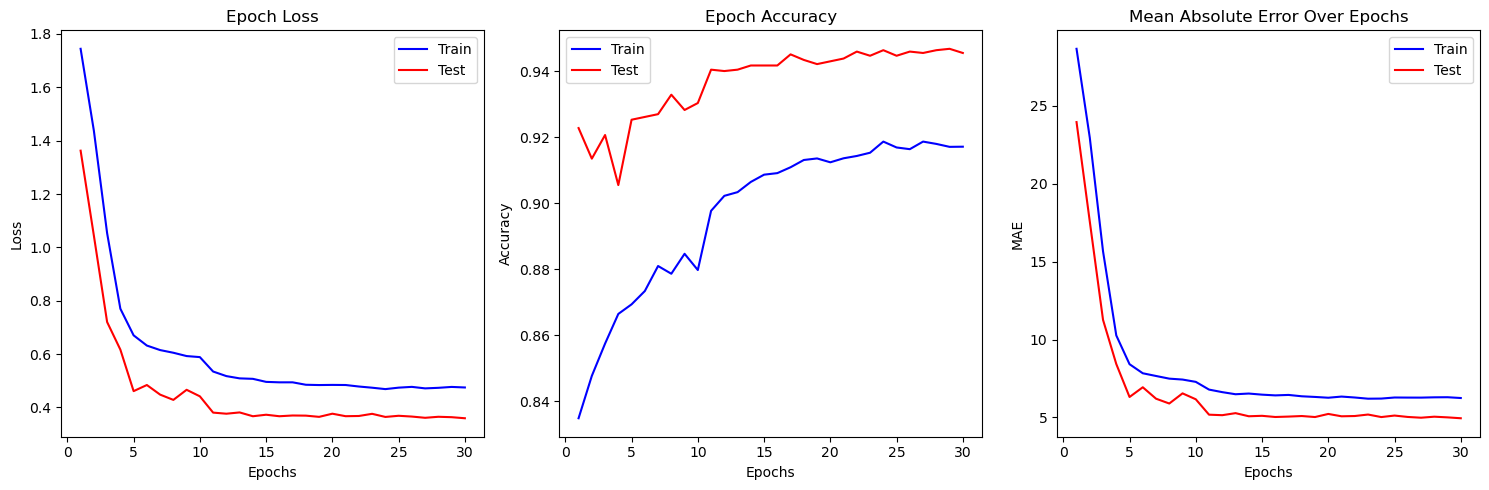

In [37]:
# Plotting epoch loss and accuracy
epochs = range(1, num_epochs + 1)

#Subplot for Loss
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(epochs, train_loss_values, 'b', label='Train')
plt.plot(epochs, test_loss_values, 'r', label='Test')
plt.title('Epoch Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Subplot for Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, train_acc_values, 'b', label='Train')
plt.plot(epochs, test_acc_values, 'r', label='Test')
plt.title('Epoch Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Subplot for MAE
plt.subplot(1, 3, 3)
plt.plot(epochs, train_age_error_values, 'b', label='Train')
plt.plot(epochs, test_age_error_values, 'r', label='Test')
plt.title('Mean Absolute Error Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

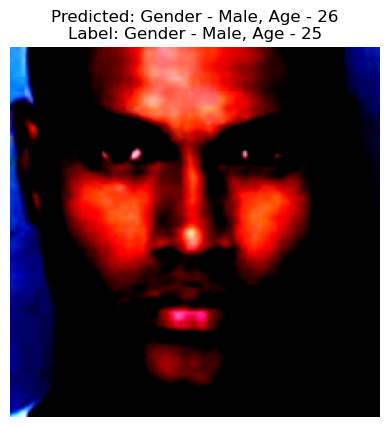

In [44]:
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()

# Choose a random photo from the test dataset
sample_idx = 10  # Choose the index of the photo to display
sample_data = dataloaders['test'].dataset[sample_idx]
sample_image = sample_data[0].unsqueeze(0).to(device)  # Add batch dimension and move to device
sample_gender_label = int(sample_data[1])  # Convert tensor to integer
sample_age_label = int(sample_data[2])  # Convert tensor to integer

# Make predictions on the sample image
with torch.no_grad():
    sample_gender_pred, sample_age_pred = model(sample_image)

# Convert gender prediction to string label
gender_labels = ['Male', 'Female']
sample_gender_pred_label = gender_labels[sample_gender_pred.argmax()]

# Convert age prediction to integer
sample_age_pred = int(sample_age_pred.item())

# Convert image tensor to NumPy array and transpose the dimensions
sample_image = sample_image.squeeze().cpu().numpy().transpose(1, 2, 0)

# Display the photo with predictions and labels
plt.imshow(sample_image)
plt.axis('off')
plt.title(f'Predicted: Gender - {sample_gender_pred_label}, Age - {sample_age_pred}\n'
          f'Label: Gender - {gender_labels[sample_gender_label]}, Age - {sample_age_label}')
plt.show()

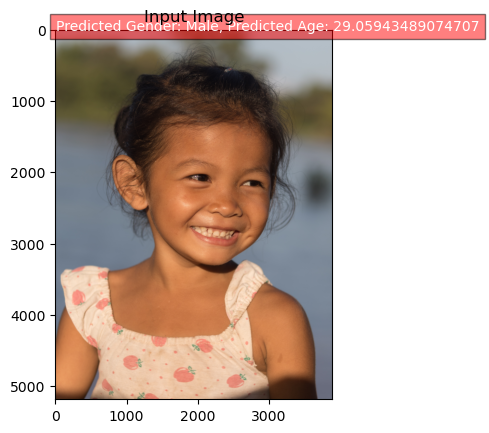